# Importar paquetes

In [3]:
import numpy as onp
from jax import random

from AOP_DataGen import  generate_training_data, DataGenerator

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import initializers

from tqdm import trange, tqdm

import matplotlib.pyplot as plt
%matplotlib inline

2022-02-18 08:22:36.959157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Generación de datos

In [4]:
length_scale = 0.2

N_train = 10000
m = 100 # number of input sensors
P_train = 1   # number of output sensors
length_scale = 0.2
key_train = random.PRNGKey(0)  # use different key for generating training data and test data 
u_train, y_train, s_train, _, _, _ = generate_training_data(key_train, N_train, m, P_train,length_scale)

In [5]:
batch_size = 10000
dataset = DataGenerator(u_train, y_train, s_train, batch_size)

# Definición del modelo

## Definición de funciones auxiliares

In [6]:
def s_i(i,M):
    return (2*i-1)/(2*M)


def s_i_power(L_params, i, M):
    S_I = onp.ones((L_params,1,1))
    for j in range(L_params):
         S_I[j][0][0] = onp.power( s_i(i+1,M), j)
    return S_I


def s_power(M,L_params):
    S_Power = onp.ones((M,L_params,1,1))
    for j in range(M):
        S_Power[j] = s_i_power(L_params, j, M )
    return tf.constant(S_Power, dtype= 'float32')

def matmul(arg):
    a, b = arg
    return tf.matmul(a,b)


def dot(arg):
    a , b = arg
    return tf.tensordot(a,b,axes = ((0),(0)))

## Definición de capa con pesos funcionales con vector como salida

In [7]:
class FWLayer(tf.keras.layers.Layer):
  def __init__(self, M ,Lk , Lw, Lb, num_outputs):
    super(FWLayer, self).__init__()
    self.M = M
    self.Lk = Lk
    self.Lw = Lw
    self.Lb = Lb
    #self.initializers = initializers.GlorotUniform(seed=1234)
    self.initializers = initializers.GlorotNormal(seed=1234)

        
    self.num_outputs = num_outputs
    self.cte = tf.constant(onp.pi/self.M,dtype=float)
    
    self.S_i_K = s_power(self.M,self.Lk)
    self.S_i_W = s_power(self.M,self.Lw)
    self.S_i_B = s_power(self.M,self.Lb)        
    
    
  def build(self, input_shape):
    
    #self.in_shape = int(input_shape[-1])
    
    self.kernel = self.add_weight("Hipermatriz kernel",
                                  shape=[self.Lk,int(input_shape[-1]),
                                         self.num_outputs],
                                  initializer = self.initializers)
    
    self.W = self.add_weight("Hipermatriz W",
                                  shape=[self.Lw,1,self.num_outputs],
                             initializer = self.initializers)
            
    self.B = self.add_weight("Hipermatriz B",
                                  shape=[self.Lb,1,self.num_outputs],
                             initializer = self.initializers)        
            
    

  def call(self, inputs):    
    
    K_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.kernel), self.S_i_K )
    W_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.W), self.S_i_W )
    B_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.B), self.S_i_B )
    
    
    K_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),K_S)
    W_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),W_S)
    B_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),B_S)
    
    
    out_fun = lambda entrada: tf.math.multiply(self.cte, tf.math.reduce_sum(tf.math.multiply( W_si , tf.keras.activations.relu(tf.math.add( tf.vectorized_map(lambda t: tf.matmul(entrada , t),K_si) , B_si)) ) ,axis = 0)) 
    
    output = tf.vectorized_map(out_fun, inputs)

    return output 

## Definición de capa con pesos funcionales con matriz como salida

In [8]:
class FWSelector(tf.keras.layers.Layer):
  def __init__(self, M , Lk, Lo, Lw, Lb, num_output_rows, num_output_columns):
    super(FWSelector, self).__init__()
    self.M = M
    self.Lk = Lk
    self.Lw = Lw
    self.Lb = Lb
    self.Lo = Lo
    self.initializers = initializers.GlorotNormal(seed=1234)

        
    self.num_output_rows = num_output_rows
    self.num_output_columns = num_output_columns
    self.cte = tf.constant(onp.pi/self.M,dtype=float)
    
    self.S_i_K = s_power(self.M,self.Lk)
    self.S_i_W = s_power(self.M,self.Lw)
    self.S_i_B = s_power(self.M,self.Lb)
    self.S_i_O = s_power(self.M,self.Lo)
    
    
  def build(self, input_shape):
    
    self.in_shape = int(input_shape[-1])
    
    self.kernel = self.add_weight("Hipermatriz kernel",
                                  shape=[self.Lk, self.num_output_rows,1],
                                  initializer = self.initializers)
    
    self.kernel_output = self.add_weight("Hipermatriz output kernel",
                                  shape=[self.Lo, int(input_shape[1]),num_output_columns],
                                  initializer = self.initializers)
    
    
    self.W = self.add_weight("Hipermatriz W",
                                  shape=[self.Lw,self.num_output_rows,num_output_columns],
                             initializer = self.initializers)
            
    self.B = self.add_weight("Hipermatriz B",
                                  shape=[self.Lb,self.num_output_rows,num_output_columns],
                             initializer = self.initializers)        
            
    

  def call(self, inputs):    
    
    K_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.kernel), self.S_i_K )
    O_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.kernel_output), self.S_i_O )
    W_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.W), self.S_i_W )
    B_S  = tf.vectorized_map(lambda t: tf.multiply(t,self.B), self.S_i_B )
    
    
    K_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),K_S)
    O_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),O_S)
    W_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),W_S)
    B_si = tf.vectorized_map(lambda t: tf.math.reduce_sum(t, axis= 0),B_S)
    
    #output = tf.reduce_sum(tf.math.multiply(W_si,tf.keras.activations.relu(tf.math.add(tf.vectorized_map(matmul,(tf.vectorized_map(lambda u: tf.matmul(u,inputs),K_si) , O_si))  ,B_si))  ) , axis= 0)

    kernel_output = tf.vectorized_map(lambda v: tf.matmul(v,inputs),K_si)
    
    #kernel_output = tf.reshape([self.M, , ])
    
    kernel_matrix = tf.vectorized_map(matmul,(kernel_output,O_si))
    
    neuron_output = tf.keras.activations.relu(tf.math.add(kernel_matrix ,B_si)) 

    output_si = tf.math.multiply(W_si, neuron_output )
    
    
    output = tf.reduce_sum(tf.reduce_sum(output_si , axis= 0) , axis= 0)
    
    return output 

## Creación del modelo

In [9]:
def selector_params():
    M = 5
    Lk = 3
    Lo = 3
    Lw = 3
    Lb = 3
    num_output_rows = 100
    num_output_columns = 100
    return M, Lk, Lo, Lw, Lb, num_output_rows, num_output_columns

M, Lk, Lo, Lw, Lb, num_output_rows, num_output_columns = selector_params()

def branch_params():
    M_b = 100
    Lk_b = 5
    Lw_b = 10
    Lb_b = 5
    return M_b, Lk_b, Lw_b, Lb_b

M_b, Lk_b, Lw_b, Lb_b = branch_params()

def trunk_params():
    M_t = 100
    Lk_t = 5
    Lw_t = 10
    Lb_t = 5
    return M_t, Lk_t, Lw_t, Lb_t

M_t, Lk_t, Lw_t, Lb_t = trunk_params()

def get_selector_branch_trunk_model():
    
    x_input = Input(shape=(1,1))
    u_input = Input(shape=(1,100))
    y_input = Input(shape=(1,1))
    
    input = concatenate([x_input, u_input,y_input])
        
    M, Lk, Lo, Lw, Lb, num_output_rows, num_output_columns = selector_params()
    Selector = FWSelector(M , Lk, Lo, Lw, Lb, num_output_rows, num_output_columns)
    selector_output = Selector(x_input)
    
    M_b, Lk_b, Lw_b, Lb_b = branch_params()
    layer_branch_1 = FWLayer(M_b, Lk_b, Lw_b, Lb_b,num_output_columns)
    branch_output = tf.transpose(layer_branch_1(u_input)[0])
    
    M_t, Lk_t, Lw_t, Lb_t = trunk_params()
    layer_trunk_1 = FWLayer(M_b, Lk_b, Lw_b, Lb_b,num_output_columns)
    trunk_output = layer_trunk_1(y_input)[0]
    
    selector_branch_output = tf.matmul(selector_output,branch_output)
    
    output = tf.tensordot(branch_output,tf.transpose(trunk_output),[[0],[0]])[0]
    
    return Model(inputs=[x_input, u_input,y_input], outputs=[output])

In [10]:
x_tf = tf.cast(tf.linspace(1,2,1), dtype='float32')
x = tf.reshape(x_tf, shape = [tf.shape(x_tf)[0],1  ]) 

u_tf = tf.cast(tf.linspace(0,1,100), dtype='float32')
u = tf.reshape(u_tf, shape = [1,1,tf.shape(u_tf)[0]  ]) 

y_tf = tf.cast(tf.linspace(1,2,1), dtype='float32')
y = tf.reshape(y_tf, shape = [tf.shape(y_tf)[0],1  ]) 

2022-02-18 08:23:37.535036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-18 08:23:37.535070: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


### Probando creación del modelo

In [12]:
model_test = get_selector_branch_trunk_model()

print(model_test([x,u,y]))

model_test.summary()

tf.Tensor([0.00218042], shape=(1,), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1, 100)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 fw_layer_2 (FWLayer)           (None, 1, 100)       51500       ['input_5[0][0]']                
                                                                                                  
 fw_layer_3 (FWLayer)           (None, 1, 100)       2000        ['input_6[0][0]']                
                                         

# Entrenamiento

## Definición de funciones auxiliares de entrenamiento

In [34]:
def single_eval(arg,model):
    x,u,y = arg
    return model([x,u,y])[0]

def single_loss(model,arg,s):
    pred = single_eval(arg,model)
    return (tf.math.add(s,-pred)[0][0])**2

def single_op(arg,s):
    return single_loss(model_test,arg,s)


def simple_op_loss(argumentos):
    x,u,y,s = argumentos
    arg = [x,u,y]
    return single_op(arg,s)

def test_loss(new_arg):
    x = tf.zeros(shape=[1,1])
    u,y,s = new_arg
    arg = [x,u,y]
    return single_op(arg,s)

def full_loss(argumentos):
    return tf.math.reduce_mean(tf.vectorized_map( test_loss ,argumentos)) 

def tot_loss(argumentos):
    return tf.math.reduce_mean(tf.vectorized_map( simple_op_loss ,argumentos)) 



In [26]:
s = tf.constant(0.005,shape = [1,1])
print('s =',s)

print('single_eval =',single_eval([x,u,y],model_test))

print('single_loss =',single_loss(model_test,[x,u,y],s))

print('single_op =',single_op([x,u,y],s))

print('simple_op_loss',simple_op_loss([x,u,y,s]))

print('test_loss = ',test_loss([u,y,s]))


s = tf.Tensor([[0.005]], shape=(1, 1), dtype=float32)
single_eval = tf.Tensor(0.0021804213, shape=(), dtype=float32)
single_loss = tf.Tensor(7.950023e-06, shape=(), dtype=float32)
single_op = tf.Tensor(7.950023e-06, shape=(), dtype=float32)
simple_op_loss tf.Tensor(7.950023e-06, shape=(), dtype=float32)
test_loss =  tf.Tensor(7.950023e-06, shape=(), dtype=float32)


In [31]:
data = iter(dataset)
batch = next(data)
inputs, s = batch
u, y = inputs

print('y_tf shape =', tf.shape(y_tf))
        
u_tf = tf.constant(u,shape = [onp.shape(u)[0],1,1,onp.shape(u)[1]])
y_tf = tf.constant(y,shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])
s_tf = tf.constant(s,shape = [onp.shape(s)[0],1,1,onp.shape(s)[1]])
        
input_arg = ((u_tf,y_tf,s_tf))

full_loss(input_arg)

y_tf shape = tf.Tensor([10000     1     1     1], shape=(4,), dtype=int32)


2022-02-18 09:49:27.605221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.
2022-02-18 09:49:27.615850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 400000000 exceeds 10% of free system memory.


<tf.Tensor: shape=(), dtype=float32, numpy=0.18255413>

In [33]:
x_tf = tf.zeros(shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])

print('x_tf shape =',tf.shape(x_tf))

x_tf shape = tf.Tensor([10000     1     1     1], shape=(4,), dtype=int32)


In [37]:
data = iter(dataset)
batch = next(data)
inputs, s = batch
u, y = inputs

#print('y_tf shape =', tf.shape(y_tf))

x_tf = tf.zeros(shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])
u_tf = tf.constant(u,shape = [onp.shape(u)[0],1,1,onp.shape(u)[1]])
y_tf = tf.constant(y,shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])
s_tf = tf.constant(s,shape = [onp.shape(s)[0],1,1,onp.shape(s)[1]])
        
input_arg = ((x_tf ,u_tf,y_tf,s_tf))

tot_loss(input_arg)

<tf.Tensor: shape=(), dtype=float32, numpy=0.18255414>

In [45]:
@tf.function
def step_grad(trainable_vars,input_arg):
    with tf.GradientTape() as tape:
        tape.watch(trainable_vars)
        x ,u ,y ,s  = input_arg
        loss  = tot_loss((x , u ,y ,s ))
        gradients = tape.gradient(loss, trainable_vars)
    return loss, gradients

In [46]:
def entrenar( dataset,  nIter, trainable_vars, losses ):
    data = iter(dataset)
    pbar = trange(nIter)
    for it in pbar:
        batch = next(data)
        inputs, s = batch
        u, y = inputs
        
        x_tf = tf.zeros(shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])
        u_tf = tf.constant(u,shape = [onp.shape(u)[0],1,1,onp.shape(u)[1]])
        y_tf = tf.constant(y,shape = [onp.shape(y)[0],1,1,onp.shape(y)[1]])
        s_tf = tf.constant(s,shape = [onp.shape(s)[0],1,1,onp.shape(s)[1]])
        
        input_arg = ((x_tf,u_tf,y_tf,s_tf))
        loss, gradients = step_grad(trainable_vars,input_arg)
        Adam.apply_gradients(zip(gradients, trainable_vars))
        losses.append(loss.numpy())
        pbar.set_description(desc="Loss = " + str(loss.numpy()))
        array_losses = onp.array(losses)
        index_min_loss = onp.argmin(array_losses)
        min_loss = array_losses[index_min_loss]
        if str(loss.numpy()) == 'nan':
            break
        if loss.numpy() == min_loss:
            model_test.save_weights('Antiderivative_FW_MultiOpNet.ckpt')
            print('New min loss = ',loss.numpy())
            if loss.numpy() < 0.000005:
                break
        pbar.update(1)
    pbar.close()
    return losses#input_arg#loss#losses

In [41]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
trainable_vars = model_test.trainable_variables
losses = []

# Ejecución del entrenamiento 

Loss = 0.17542131:   0%|▏                                                                                                                                                         | 1/1000 [00:04<1:06:40,  4.00s/it]

New min loss =  0.17542131


Loss = 0.1678685:   0%|▍                                                                                                                                                            | 3/1000 [00:06<31:41,  1.91s/it]

New min loss =  0.1678685


Loss = 0.15933955:   0%|▊                                                                                                                                                           | 5/1000 [00:08<25:18,  1.53s/it]

New min loss =  0.15933955


Loss = 0.14941841:   1%|▉                                                                                                                                                           | 6/1000 [00:11<28:50,  1.74s/it]

New min loss =  0.14941841


Loss = 0.13796271:   1%|█▏                                                                                                                                                          | 8/1000 [00:13<25:05,  1.52s/it]

New min loss =  0.13796271


Loss = 0.12498145:   1%|█▍                                                                                                                                                          | 9/1000 [00:16<30:02,  1.82s/it]

New min loss =  0.12498145


Loss = 0.11069596:   1%|█▌                                                                                                                                                         | 10/1000 [00:19<35:19,  2.14s/it]

New min loss =  0.11069596


Loss = 0.09560023:   1%|█▊                                                                                                                                                         | 12/1000 [00:21<29:06,  1.77s/it]

New min loss =  0.09560023


Loss = 0.080519795:   1%|██                                                                                                                                                        | 13/1000 [00:24<31:12,  1.90s/it]

New min loss =  0.080519795


Loss = 0.06664696:   1%|██▏                                                                                                                                                        | 14/1000 [00:26<34:15,  2.08s/it]

New min loss =  0.06664696


Loss = 0.055509582:   2%|██▎                                                                                                                                                       | 15/1000 [00:29<36:44,  2.24s/it]

New min loss =  0.055509582


Loss = 0.04874729:   2%|██▋                                                                                                                                                        | 17/1000 [00:32<31:02,  1.89s/it]

New min loss =  0.04874729


Loss = 0.04726746:   2%|██▊                                                                                                                                                        | 18/1000 [00:34<33:26,  2.04s/it]

New min loss =  0.04726746


Loss = 0.044971123:   2%|███▌                                                                                                                                                      | 23/1000 [00:44<29:46,  1.83s/it]

New min loss =  0.044971123


Loss = 0.03830075:   2%|███▋                                                                                                                                                       | 24/1000 [00:47<32:12,  1.98s/it]

New min loss =  0.03830075


Loss = 0.032176558:   2%|███▊                                                                                                                                                      | 25/1000 [00:49<33:56,  2.09s/it]

New min loss =  0.032176558


Loss = 0.02793479:   3%|████                                                                                                                                                       | 26/1000 [00:52<35:49,  2.21s/it]

New min loss =  0.02793479


Loss = 0.025882415:   3%|████▏                                                                                                                                                     | 27/1000 [00:54<37:01,  2.28s/it]

New min loss =  0.025882415


Loss = 0.025536701:   3%|████▎                                                                                                                                                     | 28/1000 [00:57<38:41,  2.39s/it]

New min loss =  0.025536701


Loss = 0.02400042:   3%|█████                                                                                                                                                      | 33/1000 [01:07<35:49,  2.22s/it]

New min loss =  0.02400042


Loss = 0.021460617:   3%|█████▏                                                                                                                                                    | 34/1000 [01:09<37:01,  2.30s/it]

New min loss =  0.021460617


Loss = 0.01856158:   4%|█████▍                                                                                                                                                     | 35/1000 [01:12<38:36,  2.40s/it]

New min loss =  0.01856158


Loss = 0.015964884:   4%|█████▌                                                                                                                                                    | 36/1000 [01:15<39:37,  2.47s/it]

New min loss =  0.015964884


Loss = 0.014297665:   4%|█████▊                                                                                                                                                    | 38/1000 [01:17<31:22,  1.96s/it]

New min loss =  0.014297665


Loss = 0.0138150845:   4%|█████▉                                                                                                                                                   | 39/1000 [01:20<32:42,  2.04s/it]

New min loss =  0.0138150845


Loss = 0.01318222:   4%|██████▌                                                                                                                                                    | 42/1000 [01:27<37:05,  2.32s/it]

New min loss =  0.01318222


Loss = 0.012012422:   4%|██████▌                                                                                                                                                   | 43/1000 [01:29<36:40,  2.30s/it]

New min loss =  0.012012422


Loss = 0.011257761:   4%|██████▊                                                                                                                                                   | 44/1000 [01:32<39:39,  2.49s/it]

New min loss =  0.011257761


Loss = 0.011160836:   4%|██████▉                                                                                                                                                   | 45/1000 [01:35<41:48,  2.63s/it]

New min loss =  0.011160836


Loss = 0.010935895:   5%|████████                                                                                                                                                  | 52/1000 [01:55<48:25,  3.06s/it]

New min loss =  0.010935895


Loss = 0.010387722:   5%|████████▏                                                                                                                                                 | 53/1000 [01:58<48:44,  3.09s/it]

New min loss =  0.010387722


Loss = 0.010029384:   5%|████████▎                                                                                                                                                 | 54/1000 [02:01<49:22,  3.13s/it]

New min loss =  0.010029384


Loss = 0.009946094:   6%|████████▍                                                                                                                                                 | 55/1000 [02:04<48:34,  3.08s/it]

New min loss =  0.009946094


Loss = 0.009865136:   6%|████████▉                                                                                                                                                 | 58/1000 [02:10<41:03,  2.61s/it]

New min loss =  0.009865136


Loss = 0.009610234:   6%|█████████                                                                                                                                                 | 59/1000 [02:14<43:14,  2.76s/it]

New min loss =  0.009610234


Loss = 0.009330574:   6%|█████████▏                                                                                                                                                | 60/1000 [02:17<44:41,  2.85s/it]

New min loss =  0.009330574


Loss = 0.009183033:   6%|█████████▍                                                                                                                                                | 61/1000 [02:20<46:34,  2.98s/it]

New min loss =  0.009183033


Loss = 0.009177717:   7%|██████████▏                                                                                                                                               | 66/1000 [02:36<49:24,  3.17s/it]

New min loss =  0.009177717


Loss = 0.009012777:   7%|██████████▍                                                                                                                                               | 68/1000 [02:39<37:34,  2.42s/it]

New min loss =  0.009012777


Loss = 0.008913295:   7%|██████████▋                                                                                                                                               | 69/1000 [02:42<39:53,  2.57s/it]

New min loss =  0.008913295


Loss = 0.008883634:   7%|██████████▊                                                                                                                                               | 70/1000 [02:46<42:35,  2.75s/it]

New min loss =  0.008883634


Loss = 0.008872751:   7%|██████████▉                                                                                                                                               | 71/1000 [02:49<44:56,  2.90s/it]

New min loss =  0.008872751


Loss = 0.008826013:   7%|███████████                                                                                                                                               | 72/1000 [02:52<45:59,  2.97s/it]

New min loss =  0.008826013


Loss = 0.008729671:   7%|███████████▏                                                                                                                                              | 73/1000 [02:55<46:54,  3.04s/it]

New min loss =  0.008729671


Loss = 0.008614035:   7%|███████████▍                                                                                                                                              | 74/1000 [02:58<46:33,  3.02s/it]

New min loss =  0.008614035


Loss = 0.008519799:   8%|███████████▌                                                                                                                                              | 75/1000 [03:01<46:49,  3.04s/it]

New min loss =  0.008519799


Loss = 0.008461256:   8%|███████████▋                                                                                                                                              | 76/1000 [03:05<48:10,  3.13s/it]

New min loss =  0.008461256


Loss = 0.00841925:   8%|███████████▉                                                                                                                                               | 77/1000 [03:08<48:36,  3.16s/it]

New min loss =  0.00841925


Loss = 0.0083649615:   8%|███████████▉                                                                                                                                             | 78/1000 [03:11<48:52,  3.18s/it]

New min loss =  0.0083649615


Loss = 0.008286605:   8%|████████████▎                                                                                                                                             | 80/1000 [03:14<38:01,  2.48s/it]

New min loss =  0.008286605


Loss = 0.008193535:   8%|████████████▍                                                                                                                                             | 81/1000 [03:18<43:14,  2.82s/it]

New min loss =  0.008193535


Loss = 0.008099953:   8%|████████████▋                                                                                                                                             | 82/1000 [03:21<44:09,  2.89s/it]

New min loss =  0.008099953


Loss = 0.008010152:   8%|████████████▊                                                                                                                                             | 83/1000 [03:25<46:01,  3.01s/it]

New min loss =  0.008010152


Loss = 0.007919452:   8%|████████████▉                                                                                                                                             | 84/1000 [03:28<47:06,  3.09s/it]

New min loss =  0.007919452


Loss = 0.007823291:   8%|█████████████                                                                                                                                             | 85/1000 [03:31<48:20,  3.17s/it]

New min loss =  0.007823291


Loss = 0.0077209924:   9%|█████████████▏                                                                                                                                           | 86/1000 [03:35<48:35,  3.19s/it]

New min loss =  0.0077209924


Loss = 0.007611026:   9%|█████████████▍                                                                                                                                            | 87/1000 [03:38<50:18,  3.31s/it]

New min loss =  0.007611026


Loss = 0.0074865785:   9%|█████████████▍                                                                                                                                           | 88/1000 [03:41<49:10,  3.24s/it]

New min loss =  0.0074865785


Loss = 0.007340056:   9%|█████████████▋                                                                                                                                            | 89/1000 [03:45<49:28,  3.26s/it]

New min loss =  0.007340056


Loss = 0.007175389:   9%|█████████████▊                                                                                                                                            | 90/1000 [03:48<49:04,  3.24s/it]

New min loss =  0.007175389


Loss = 0.0070065996:   9%|█████████████▉                                                                                                                                           | 91/1000 [03:51<48:29,  3.20s/it]

New min loss =  0.0070065996


Loss = 0.006840805:   9%|██████████████▎                                                                                                                                           | 93/1000 [03:54<37:20,  2.47s/it]

New min loss =  0.006840805


Loss = 0.0066639655:   9%|██████████████▍                                                                                                                                          | 94/1000 [03:57<39:21,  2.61s/it]

New min loss =  0.0066639655


Loss = 0.0064578475:  10%|██████████████▌                                                                                                                                          | 95/1000 [04:00<42:05,  2.79s/it]

New min loss =  0.0064578475


Loss = 0.0062316987:  10%|██████████████▋                                                                                                                                          | 96/1000 [04:04<44:29,  2.95s/it]

New min loss =  0.0062316987


Loss = 0.0060115005:  10%|██████████████▊                                                                                                                                          | 97/1000 [04:07<45:44,  3.04s/it]

New min loss =  0.0060115005


Loss = 0.005798639:  10%|███████████████                                                                                                                                           | 98/1000 [04:10<45:46,  3.05s/it]

New min loss =  0.005798639


Loss = 0.0055744057:  10%|███████████████▏                                                                                                                                         | 99/1000 [04:13<46:18,  3.08s/it]

New min loss =  0.0055744057


Loss = 0.0053270776:  10%|███████████████▏                                                                                                                                        | 100/1000 [04:16<45:26,  3.03s/it]

New min loss =  0.0053270776


Loss = 0.0050593237:  10%|███████████████▎                                                                                                                                        | 101/1000 [04:19<46:13,  3.09s/it]

New min loss =  0.0050593237


Loss = 0.0047855554:  10%|███████████████▌                                                                                                                                        | 102/1000 [04:23<47:22,  3.17s/it]

New min loss =  0.0047855554


Loss = 0.0045344103:  10%|███████████████▋                                                                                                                                        | 103/1000 [04:26<47:56,  3.21s/it]

New min loss =  0.0045344103


Loss = 0.004299741:  10%|███████████████▉                                                                                                                                         | 104/1000 [04:29<48:32,  3.25s/it]

New min loss =  0.004299741


Loss = 0.0040723374:  10%|███████████████▉                                                                                                                                        | 105/1000 [04:33<50:08,  3.36s/it]

New min loss =  0.0040723374


Loss = 0.0038549039:  11%|████████████████▎                                                                                                                                       | 107/1000 [04:36<37:31,  2.52s/it]

New min loss =  0.0038549039


Loss = 0.0036495437:  11%|████████████████▍                                                                                                                                       | 108/1000 [04:39<39:54,  2.68s/it]

New min loss =  0.0036495437


Loss = 0.003479945:  11%|████████████████▋                                                                                                                                        | 109/1000 [04:43<42:05,  2.83s/it]

New min loss =  0.003479945


Loss = 0.0033395656:  11%|████████████████▋                                                                                                                                       | 110/1000 [04:46<43:49,  2.95s/it]

New min loss =  0.0033395656


Loss = 0.0032225377:  11%|████████████████▊                                                                                                                                       | 111/1000 [04:49<44:22,  2.99s/it]

New min loss =  0.0032225377


Loss = 0.0031170903:  11%|█████████████████                                                                                                                                       | 112/1000 [04:52<45:25,  3.07s/it]

New min loss =  0.0031170903


Loss = 0.0030366664:  11%|█████████████████▏                                                                                                                                      | 113/1000 [04:55<45:33,  3.08s/it]

New min loss =  0.0030366664


Loss = 0.002983257:  11%|█████████████████▍                                                                                                                                       | 114/1000 [04:59<46:11,  3.13s/it]

New min loss =  0.002983257


Loss = 0.0029452988:  12%|█████████████████▍                                                                                                                                      | 115/1000 [05:02<47:08,  3.20s/it]

New min loss =  0.0029452988


Loss = 0.0029111889:  12%|█████████████████▋                                                                                                                                      | 116/1000 [05:05<47:32,  3.23s/it]

New min loss =  0.0029111889


Loss = 0.0028781784:  12%|█████████████████▊                                                                                                                                      | 117/1000 [05:08<46:12,  3.14s/it]

New min loss =  0.0028781784


Loss = 0.0028494324:  12%|█████████████████▉                                                                                                                                      | 118/1000 [05:11<46:32,  3.17s/it]

New min loss =  0.0028494324


Loss = 0.002818251:  12%|██████████████████▏                                                                                                                                      | 119/1000 [05:15<47:05,  3.21s/it]

New min loss =  0.002818251


Loss = 0.0027803958:  12%|██████████████████▏                                                                                                                                     | 120/1000 [05:18<49:38,  3.38s/it]

New min loss =  0.0027803958


Loss = 0.0027330276:  12%|██████████████████▌                                                                                                                                     | 122/1000 [05:22<39:28,  2.70s/it]

New min loss =  0.0027330276


Loss = 0.002682775:  12%|██████████████████▊                                                                                                                                      | 123/1000 [05:25<40:50,  2.79s/it]

New min loss =  0.002682775


Loss = 0.0026304252:  12%|██████████████████▊                                                                                                                                     | 124/1000 [05:29<43:46,  3.00s/it]

New min loss =  0.0026304252


Loss = 0.0025794092:  12%|███████████████████                                                                                                                                     | 125/1000 [05:32<44:51,  3.08s/it]

New min loss =  0.0025794092


Loss = 0.0025297843:  13%|███████████████████▏                                                                                                                                    | 126/1000 [05:35<45:24,  3.12s/it]

New min loss =  0.0025297843


Loss = 0.002484881:  13%|███████████████████▍                                                                                                                                     | 127/1000 [05:39<45:44,  3.14s/it]

New min loss =  0.002484881


Loss = 0.0024461974:  13%|███████████████████▍                                                                                                                                    | 128/1000 [05:42<46:00,  3.17s/it]

New min loss =  0.0024461974


Loss = 0.0024135548:  13%|███████████████████▌                                                                                                                                    | 129/1000 [05:45<45:18,  3.12s/it]

New min loss =  0.0024135548


Loss = 0.0023855488:  13%|███████████████████▊                                                                                                                                    | 130/1000 [05:48<47:18,  3.26s/it]

New min loss =  0.0023855488


Loss = 0.0023595432:  13%|███████████████████▉                                                                                                                                    | 131/1000 [05:52<46:36,  3.22s/it]

New min loss =  0.0023595432


Loss = 0.0023348911:  13%|████████████████████                                                                                                                                    | 132/1000 [05:55<48:16,  3.34s/it]

New min loss =  0.0023348911


Loss = 0.0023104714:  13%|████████████████████▏                                                                                                                                   | 133/1000 [05:58<47:59,  3.32s/it]

New min loss =  0.0023104714


Loss = 0.0022867564:  13%|████████████████████▎                                                                                                                                   | 134/1000 [06:02<48:07,  3.33s/it]

New min loss =  0.0022867564


Loss = 0.00226234:  14%|████████████████████▊                                                                                                                                     | 135/1000 [06:05<48:02,  3.33s/it]

New min loss =  0.00226234


Loss = 0.0022373067:  14%|████████████████████▋                                                                                                                                   | 136/1000 [06:08<47:22,  3.29s/it]

New min loss =  0.0022373067


Loss = 0.0022115312:  14%|████████████████████▉                                                                                                                                   | 138/1000 [06:12<36:12,  2.52s/it]

New min loss =  0.0022115312


Loss = 0.002186213:  14%|█████████████████████▎                                                                                                                                   | 139/1000 [06:15<38:11,  2.66s/it]

New min loss =  0.002186213


Loss = 0.002162062:  14%|█████████████████████▍                                                                                                                                   | 140/1000 [06:18<41:49,  2.92s/it]

New min loss =  0.002162062


Loss = 0.002138616:  14%|█████████████████████▌                                                                                                                                   | 141/1000 [06:21<42:51,  2.99s/it]

New min loss =  0.002138616


Loss = 0.0021154778:  14%|█████████████████████▌                                                                                                                                  | 142/1000 [06:25<43:06,  3.01s/it]

New min loss =  0.0021154778


Loss = 0.0020928355:  14%|█████████████████████▋                                                                                                                                  | 143/1000 [06:28<43:20,  3.03s/it]

New min loss =  0.0020928355


Loss = 0.0020715208:  14%|█████████████████████▉                                                                                                                                  | 144/1000 [06:31<44:48,  3.14s/it]

New min loss =  0.0020715208


Loss = 0.0020512568:  14%|██████████████████████                                                                                                                                  | 145/1000 [06:34<44:06,  3.09s/it]

New min loss =  0.0020512568


Loss = 0.0020312178:  15%|██████████████████████▏                                                                                                                                 | 146/1000 [06:38<46:42,  3.28s/it]

New min loss =  0.0020312178


Loss = 0.0020104959:  15%|██████████████████████▎                                                                                                                                 | 147/1000 [06:41<48:14,  3.39s/it]

New min loss =  0.0020104959


Loss = 0.0019893532:  15%|██████████████████████▍                                                                                                                                 | 148/1000 [06:45<50:09,  3.53s/it]

New min loss =  0.0019893532


Loss = 0.0019683787:  15%|██████████████████████▋                                                                                                                                 | 149/1000 [06:49<50:51,  3.59s/it]

New min loss =  0.0019683787


Loss = 0.0019480076:  15%|██████████████████████▊                                                                                                                                 | 150/1000 [06:53<52:06,  3.68s/it]

New min loss =  0.0019480076


Loss = 0.001928389:  15%|███████████████████████                                                                                                                                  | 151/1000 [06:56<51:20,  3.63s/it]

New min loss =  0.001928389


Loss = 0.0019097431:  15%|███████████████████████                                                                                                                                 | 152/1000 [07:01<54:14,  3.84s/it]

New min loss =  0.0019097431


Loss = 0.001891907:  15%|███████████████████████▍                                                                                                                                 | 153/1000 [07:05<54:17,  3.85s/it]

New min loss =  0.001891907


Loss = 0.0018746055:  16%|███████████████████████▌                                                                                                                                | 155/1000 [07:08<41:21,  2.94s/it]

New min loss =  0.0018746055


Loss = 0.0018574203:  16%|███████████████████████▋                                                                                                                                | 156/1000 [07:12<43:47,  3.11s/it]

New min loss =  0.0018574203


Loss = 0.0018403301:  16%|███████████████████████▊                                                                                                                                | 157/1000 [07:16<46:48,  3.33s/it]

New min loss =  0.0018403301


Loss = 0.0018235322:  16%|████████████████████████                                                                                                                                | 158/1000 [07:20<49:55,  3.56s/it]

New min loss =  0.0018235322


Loss = 0.0018069326:  16%|████████████████████████▏                                                                                                                               | 159/1000 [07:24<49:28,  3.53s/it]

New min loss =  0.0018069326


Loss = 0.001790116:  16%|████████████████████████▍                                                                                                                                | 160/1000 [07:27<49:48,  3.56s/it]

New min loss =  0.001790116


Loss = 0.001773021:  16%|████████████████████████▋                                                                                                                                | 161/1000 [07:31<50:39,  3.62s/it]

New min loss =  0.001773021


Loss = 0.001755894:  16%|████████████████████████▊                                                                                                                                | 162/1000 [07:35<52:11,  3.74s/it]

New min loss =  0.001755894


Loss = 0.0017389223:  16%|████████████████████████▊                                                                                                                               | 163/1000 [07:39<52:13,  3.74s/it]

New min loss =  0.0017389223


Loss = 0.001722097:  16%|█████████████████████████                                                                                                                                | 164/1000 [07:42<51:57,  3.73s/it]

New min loss =  0.001722097


Loss = 0.0017055956:  16%|█████████████████████████                                                                                                                               | 165/1000 [07:46<50:53,  3.66s/it]

New min loss =  0.0017055956


Loss = 0.0016893751:  17%|█████████████████████████▏                                                                                                                              | 166/1000 [07:50<51:34,  3.71s/it]

New min loss =  0.0016893751


Loss = 0.001673178:  17%|█████████████████████████▌                                                                                                                               | 167/1000 [07:54<51:43,  3.73s/it]

New min loss =  0.001673178


Loss = 0.0016570948:  17%|█████████████████████████▌                                                                                                                              | 168/1000 [07:57<52:11,  3.76s/it]

New min loss =  0.0016570948


Loss = 0.0016412655:  17%|█████████████████████████▋                                                                                                                              | 169/1000 [08:01<52:47,  3.81s/it]

New min loss =  0.0016412655


Loss = 0.0016257088:  17%|█████████████████████████▊                                                                                                                              | 170/1000 [08:05<51:45,  3.74s/it]

New min loss =  0.0016257088


Loss = 0.0016103185:  17%|█████████████████████████▉                                                                                                                              | 171/1000 [08:09<52:04,  3.77s/it]

New min loss =  0.0016103185


Loss = 0.0015951012:  17%|██████████████████████████▎                                                                                                                             | 173/1000 [08:12<39:58,  2.90s/it]

New min loss =  0.0015951012


Loss = 0.001579944:  17%|██████████████████████████▌                                                                                                                              | 174/1000 [08:16<42:55,  3.12s/it]

New min loss =  0.001579944


Loss = 0.0015648218:  18%|██████████████████████████▌                                                                                                                             | 175/1000 [08:20<44:55,  3.27s/it]

New min loss =  0.0015648218


Loss = 0.0015498791:  18%|██████████████████████████▊                                                                                                                             | 176/1000 [08:23<45:44,  3.33s/it]

New min loss =  0.0015498791


Loss = 0.0015350588:  18%|██████████████████████████▉                                                                                                                             | 177/1000 [08:27<47:56,  3.49s/it]

New min loss =  0.0015350588


Loss = 0.0015201687:  18%|███████████████████████████                                                                                                                             | 178/1000 [08:31<49:19,  3.60s/it]

New min loss =  0.0015201687


Loss = 0.0015053733:  18%|███████████████████████████▏                                                                                                                            | 179/1000 [08:35<49:10,  3.59s/it]

New min loss =  0.0015053733


Loss = 0.0014906813:  18%|███████████████████████████▎                                                                                                                            | 180/1000 [08:39<50:28,  3.69s/it]

New min loss =  0.0014906813


Loss = 0.001476109:  18%|███████████████████████████▋                                                                                                                             | 181/1000 [08:42<49:44,  3.64s/it]

New min loss =  0.001476109


Loss = 0.0014617197:  18%|███████████████████████████▋                                                                                                                            | 182/1000 [08:46<50:26,  3.70s/it]

New min loss =  0.0014617197


Loss = 0.001447391:  18%|███████████████████████████▉                                                                                                                             | 183/1000 [08:50<49:51,  3.66s/it]

New min loss =  0.001447391


Loss = 0.0014330943:  18%|███████████████████████████▉                                                                                                                            | 184/1000 [08:54<50:51,  3.74s/it]

New min loss =  0.0014330943


Loss = 0.0014188783:  18%|████████████████████████████                                                                                                                            | 185/1000 [08:57<51:11,  3.77s/it]

New min loss =  0.0014188783


Loss = 0.0014047567:  19%|████████████████████████████▎                                                                                                                           | 186/1000 [09:01<50:09,  3.70s/it]

New min loss =  0.0014047567


Loss = 0.0013907201:  19%|████████████████████████████▍                                                                                                                           | 187/1000 [09:05<50:09,  3.70s/it]

New min loss =  0.0013907201


Loss = 0.0013768314:  19%|████████████████████████████▌                                                                                                                           | 188/1000 [09:08<49:50,  3.68s/it]

New min loss =  0.0013768314


Loss = 0.0013631644:  19%|████████████████████████████▋                                                                                                                           | 189/1000 [09:12<50:12,  3.71s/it]

New min loss =  0.0013631644


Loss = 0.0013496398:  19%|████████████████████████████▉                                                                                                                           | 190/1000 [09:16<50:35,  3.75s/it]

New min loss =  0.0013496398


Loss = 0.0013361677:  19%|█████████████████████████████▏                                                                                                                          | 192/1000 [09:20<38:40,  2.87s/it]

New min loss =  0.0013361677


Loss = 0.001322632:  19%|█████████████████████████████▌                                                                                                                           | 193/1000 [09:23<40:42,  3.03s/it]

New min loss =  0.001322632


Loss = 0.0013090653:  19%|█████████████████████████████▍                                                                                                                          | 194/1000 [09:27<42:58,  3.20s/it]

New min loss =  0.0013090653


Loss = 0.0012955478:  20%|█████████████████████████████▋                                                                                                                          | 195/1000 [09:31<44:55,  3.35s/it]

New min loss =  0.0012955478


Loss = 0.0012820231:  20%|█████████████████████████████▊                                                                                                                          | 196/1000 [09:35<47:08,  3.52s/it]

New min loss =  0.0012820231


Loss = 0.0012685127:  20%|█████████████████████████████▉                                                                                                                          | 197/1000 [09:38<47:03,  3.52s/it]

New min loss =  0.0012685127


Loss = 0.001254933:  20%|██████████████████████████████▎                                                                                                                          | 198/1000 [09:42<47:38,  3.56s/it]

New min loss =  0.001254933


Loss = 0.0012412949:  20%|██████████████████████████████▏                                                                                                                         | 199/1000 [09:45<48:15,  3.62s/it]

New min loss =  0.0012412949


Loss = 0.0012276302:  20%|██████████████████████████████▍                                                                                                                         | 200/1000 [09:49<48:32,  3.64s/it]

New min loss =  0.0012276302


Loss = 0.001213978:  20%|██████████████████████████████▊                                                                                                                          | 201/1000 [09:53<48:23,  3.63s/it]

New min loss =  0.001213978


Loss = 0.0012002578:  20%|██████████████████████████████▋                                                                                                                         | 202/1000 [09:56<47:58,  3.61s/it]

New min loss =  0.0012002578


Loss = 0.0011863355:  20%|██████████████████████████████▊                                                                                                                         | 203/1000 [10:00<46:58,  3.54s/it]

New min loss =  0.0011863355


Loss = 0.0011719789:  20%|███████████████████████████████                                                                                                                         | 204/1000 [10:03<47:17,  3.57s/it]

New min loss =  0.0011719789


Loss = 0.0011569536:  20%|███████████████████████████████▏                                                                                                                        | 205/1000 [10:07<47:55,  3.62s/it]

New min loss =  0.0011569536


Loss = 0.0011411681:  21%|███████████████████████████████▎                                                                                                                        | 206/1000 [10:11<47:45,  3.61s/it]

New min loss =  0.0011411681


Loss = 0.0011244932:  21%|███████████████████████████████▍                                                                                                                        | 207/1000 [10:14<47:47,  3.62s/it]

New min loss =  0.0011244932


Loss = 0.0011066056:  21%|███████████████████████████████▌                                                                                                                        | 208/1000 [10:18<48:37,  3.68s/it]

New min loss =  0.0011066056


Loss = 0.0010871473:  21%|███████████████████████████████▊                                                                                                                        | 209/1000 [10:22<48:47,  3.70s/it]

New min loss =  0.0010871473


Loss = 0.0010660402:  21%|███████████████████████████████▉                                                                                                                        | 210/1000 [10:26<49:34,  3.77s/it]

New min loss =  0.0010660402


Loss = 0.0010434082:  21%|████████████████████████████████▏                                                                                                                       | 212/1000 [10:30<38:20,  2.92s/it]

New min loss =  0.0010434082


Loss = 0.0010192974:  21%|████████████████████████████████▍                                                                                                                       | 213/1000 [10:33<40:40,  3.10s/it]

New min loss =  0.0010192974


Loss = 0.0009937211:  21%|████████████████████████████████▌                                                                                                                       | 214/1000 [10:37<42:53,  3.27s/it]

New min loss =  0.0009937211


Loss = 0.00096758077:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [10:41<44:33,  3.41s/it]

New min loss =  0.00096758077


Loss = 0.0009418577:  22%|████████████████████████████████▊                                                                                                                       | 216/1000 [10:45<46:43,  3.58s/it]

New min loss =  0.0009418577


Loss = 0.00091709767:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [10:48<46:56,  3.60s/it]

New min loss =  0.00091709767


Loss = 0.0008943813:  22%|█████████████████████████████████▏                                                                                                                      | 218/1000 [10:52<46:05,  3.54s/it]

New min loss =  0.0008943813


Loss = 0.0008740243:  22%|█████████████████████████████████▎                                                                                                                      | 219/1000 [10:56<47:05,  3.62s/it]

New min loss =  0.0008740243


Loss = 0.0008565338:  22%|█████████████████████████████████▍                                                                                                                      | 220/1000 [10:59<47:45,  3.67s/it]

New min loss =  0.0008565338


Loss = 0.00084175775:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [11:03<48:08,  3.71s/it]

New min loss =  0.00084175775


Loss = 0.00082980917:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [11:07<48:05,  3.71s/it]

New min loss =  0.00082980917


Loss = 0.00081950874:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [11:10<47:14,  3.65s/it]

New min loss =  0.00081950874


Loss = 0.00081122876:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [11:14<47:04,  3.64s/it]

New min loss =  0.00081122876


Loss = 0.0008034412:  22%|██████████████████████████████████▏                                                                                                                     | 225/1000 [11:18<47:32,  3.68s/it]

New min loss =  0.0008034412


Loss = 0.0007942642:  23%|██████████████████████████████████▎                                                                                                                     | 226/1000 [11:22<48:17,  3.74s/it]

New min loss =  0.0007942642


Loss = 0.00078273914:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [11:25<47:11,  3.66s/it]

New min loss =  0.00078273914


Loss = 0.0007713441:  23%|██████████████████████████████████▋                                                                                                                     | 228/1000 [11:29<48:18,  3.75s/it]

New min loss =  0.0007713441


Loss = 0.0007620487:  23%|██████████████████████████████████▊                                                                                                                     | 229/1000 [11:33<49:44,  3.87s/it]

New min loss =  0.0007620487


Loss = 0.0007511527:  23%|██████████████████████████████████▉                                                                                                                     | 230/1000 [11:37<49:58,  3.89s/it]

New min loss =  0.0007511527


Loss = 0.00073818857:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [11:41<48:41,  3.80s/it]

New min loss =  0.00073818857


Loss = 0.0007262618:  23%|███████████████████████████████████▍                                                                                                                    | 233/1000 [11:45<37:12,  2.91s/it]

New min loss =  0.0007262618


Loss = 0.0007158654:  23%|███████████████████████████████████▌                                                                                                                    | 234/1000 [11:49<40:20,  3.16s/it]

New min loss =  0.0007158654


Loss = 0.00070528814:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [11:52<41:07,  3.23s/it]

New min loss =  0.00070528814


Loss = 0.0006945235:  24%|███████████████████████████████████▊                                                                                                                    | 236/1000 [11:56<42:13,  3.32s/it]

New min loss =  0.0006945235


Loss = 0.0006860124:  24%|████████████████████████████████████                                                                                                                    | 237/1000 [11:59<42:38,  3.35s/it]

New min loss =  0.0006860124


Loss = 0.00067886343:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [12:03<43:36,  3.43s/it]

New min loss =  0.00067886343


Loss = 0.0006717168:  24%|████████████████████████████████████▎                                                                                                                   | 239/1000 [12:06<43:46,  3.45s/it]

New min loss =  0.0006717168


Loss = 0.0006649274:  24%|████████████████████████████████████▍                                                                                                                   | 240/1000 [12:10<44:30,  3.51s/it]

New min loss =  0.0006649274


Loss = 0.0006593145:  24%|████████████████████████████████████▋                                                                                                                   | 241/1000 [12:14<45:22,  3.59s/it]

New min loss =  0.0006593145


Loss = 0.00065373123:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [12:17<45:58,  3.64s/it]

New min loss =  0.00065373123


Loss = 0.00064716703:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [12:21<46:22,  3.68s/it]

New min loss =  0.00064716703


Loss = 0.0006407257:  24%|█████████████████████████████████████                                                                                                                   | 244/1000 [12:25<45:58,  3.65s/it]

New min loss =  0.0006407257


Loss = 0.0006347959:  24%|█████████████████████████████████████▏                                                                                                                  | 245/1000 [12:28<45:24,  3.61s/it]

New min loss =  0.0006347959


Loss = 0.000628568:  25%|█████████████████████████████████████▋                                                                                                                   | 246/1000 [12:32<45:22,  3.61s/it]

New min loss =  0.000628568


Loss = 0.00062185695:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [12:36<46:36,  3.71s/it]

New min loss =  0.00062185695


Loss = 0.00061560556:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [12:40<46:57,  3.75s/it]

New min loss =  0.00061560556


Loss = 0.0006099677:  25%|█████████████████████████████████████▊                                                                                                                  | 249/1000 [12:43<47:02,  3.76s/it]

New min loss =  0.0006099677


Loss = 0.00060457096:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [12:47<47:07,  3.77s/it]

New min loss =  0.00060457096


Loss = 0.0005992505:  25%|██████████████████████████████████████▏                                                                                                                 | 251/1000 [12:51<46:41,  3.74s/it]

New min loss =  0.0005992505


Loss = 0.00059439294:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [12:55<47:00,  3.77s/it]

New min loss =  0.00059439294


Loss = 0.00059008406:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [12:58<46:44,  3.75s/it]

New min loss =  0.00059008406


Loss = 0.0005858895:  26%|██████████████████████████████████████▊                                                                                                                 | 255/1000 [13:02<35:49,  2.89s/it]

New min loss =  0.0005858895


Loss = 0.0005815005:  26%|██████████████████████████████████████▉                                                                                                                 | 256/1000 [13:06<37:58,  3.06s/it]

New min loss =  0.0005815005


Loss = 0.0005772105:  26%|███████████████████████████████████████                                                                                                                 | 257/1000 [13:09<39:09,  3.16s/it]

New min loss =  0.0005772105


Loss = 0.00057315826:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [13:13<41:03,  3.32s/it]

New min loss =  0.00057315826


Loss = 0.00056909124:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [13:17<42:52,  3.47s/it]

New min loss =  0.00056909124


Loss = 0.0005649717:  26%|███████████████████████████████████████▌                                                                                                                | 260/1000 [13:21<44:49,  3.63s/it]

New min loss =  0.0005649717


Loss = 0.00056083786:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [13:25<47:05,  3.82s/it]

New min loss =  0.00056083786


Loss = 0.0005569315:  26%|███████████████████████████████████████▊                                                                                                                | 262/1000 [13:29<47:34,  3.87s/it]

New min loss =  0.0005569315


Loss = 0.00055318436:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [13:33<47:41,  3.88s/it]

New min loss =  0.00055318436


Loss = 0.00054956984:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [13:37<47:11,  3.85s/it]

New min loss =  0.00054956984


Loss = 0.0005459506:  26%|████████████████████████████████████████▎                                                                                                               | 265/1000 [13:40<46:37,  3.81s/it]

New min loss =  0.0005459506


Loss = 0.0005424444:  27%|████████████████████████████████████████▍                                                                                                               | 266/1000 [13:44<46:42,  3.82s/it]

New min loss =  0.0005424444


Loss = 0.00053906935:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [13:48<46:05,  3.77s/it]

New min loss =  0.00053906935


Loss = 0.00053580414:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [13:52<45:55,  3.76s/it]

New min loss =  0.00053580414


Loss = 0.00053257315:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [13:55<45:35,  3.74s/it]

New min loss =  0.00053257315


Loss = 0.00052931823:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [13:59<45:47,  3.76s/it]

New min loss =  0.00052931823


Loss = 0.00052607834:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [14:03<46:00,  3.79s/it]

New min loss =  0.00052607834


Loss = 0.00052286417:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [14:07<45:54,  3.78s/it]

New min loss =  0.00052286417


Loss = 0.00051970856:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [14:11<46:00,  3.80s/it]

New min loss =  0.00051970856


Loss = 0.0005165706:  27%|█████████████████████████████████████████▋                                                                                                              | 274/1000 [14:14<45:18,  3.74s/it]

New min loss =  0.0005165706


Loss = 0.0005134964:  28%|█████████████████████████████████████████▊                                                                                                              | 275/1000 [14:18<43:31,  3.60s/it]

New min loss =  0.0005134964


Loss = 0.0005104675:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [14:21<42:37,  3.53s/it]

New min loss =  0.0005104675


Loss = 0.00050751:  28%|██████████████████████████████████████████▊                                                                                                               | 278/1000 [14:25<33:34,  2.79s/it]

New min loss =  0.00050751


Loss = 0.0005046503:  28%|██████████████████████████████████████████▍                                                                                                             | 279/1000 [14:29<36:36,  3.05s/it]

New min loss =  0.0005046503


Loss = 0.0005018741:  28%|██████████████████████████████████████████▌                                                                                                             | 280/1000 [14:32<38:14,  3.19s/it]

New min loss =  0.0005018741


Loss = 0.0004992256:  28%|██████████████████████████████████████████▋                                                                                                             | 281/1000 [14:36<39:39,  3.31s/it]

New min loss =  0.0004992256


Loss = 0.00049650285:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [14:39<39:55,  3.34s/it]

New min loss =  0.00049650285


Loss = 0.0004936495:  28%|███████████████████████████████████████████                                                                                                             | 283/1000 [14:43<40:32,  3.39s/it]

New min loss =  0.0004936495


Loss = 0.00049058103:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [14:46<41:42,  3.50s/it]

New min loss =  0.00049058103


Loss = 0.00048760863:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [14:50<42:51,  3.60s/it]

New min loss =  0.00048760863


Loss = 0.00048471347:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [14:54<44:31,  3.74s/it]

New min loss =  0.00048471347


Loss = 0.00048181353:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [14:58<43:34,  3.67s/it]

New min loss =  0.00048181353


Loss = 0.00047902213:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [15:02<43:22,  3.65s/it]

New min loss =  0.00047902213


Loss = 0.0004763934:  29%|███████████████████████████████████████████▉                                                                                                            | 289/1000 [15:05<43:19,  3.66s/it]

New min loss =  0.0004763934


Loss = 0.00047384825:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [15:09<43:44,  3.70s/it]

New min loss =  0.00047384825


Loss = 0.00047122512:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [15:13<45:47,  3.87s/it]

New min loss =  0.00047122512


Loss = 0.00046847083:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [15:17<46:09,  3.91s/it]

New min loss =  0.00046847083


Loss = 0.00046572532:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [15:21<46:47,  3.97s/it]

New min loss =  0.00046572532


Loss = 0.00046313423:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [15:25<46:15,  3.93s/it]

New min loss =  0.00046313423


Loss = 0.0004606326:  30%|████████████████████████████████████████████▊                                                                                                           | 295/1000 [15:29<46:10,  3.93s/it]

New min loss =  0.0004606326


Loss = 0.00045807692:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [15:33<44:38,  3.80s/it]

New min loss =  0.00045807692


Loss = 0.00045538292:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [15:36<43:20,  3.70s/it]

New min loss =  0.00045538292


Loss = 0.00045275135:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [15:40<42:30,  3.63s/it]

New min loss =  0.00045275135


Loss = 0.00045031557:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [15:43<42:43,  3.66s/it]

New min loss =  0.00045031557


Loss = 0.00044799357:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [15:47<44:06,  3.78s/it]

New min loss =  0.00044799357


Loss = 0.00044563418:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [15:51<33:50,  2.91s/it]

New min loss =  0.00044563418


Loss = 0.0004432046:  30%|██████████████████████████████████████████████                                                                                                          | 303/1000 [15:55<36:28,  3.14s/it]

New min loss =  0.0004432046


Loss = 0.00044080152:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [15:59<37:40,  3.25s/it]

New min loss =  0.00044080152


Loss = 0.00043850736:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [16:02<38:16,  3.30s/it]

New min loss =  0.00043850736


Loss = 0.00043630385:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [16:06<39:18,  3.40s/it]

New min loss =  0.00043630385


Loss = 0.00043410587:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [16:10<41:28,  3.59s/it]

New min loss =  0.00043410587


Loss = 0.00043187427:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [16:13<41:42,  3.62s/it]

New min loss =  0.00043187427


Loss = 0.00042965173:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [16:17<41:26,  3.60s/it]

New min loss =  0.00042965173


Loss = 0.0004275003:  31%|███████████████████████████████████████████████                                                                                                         | 310/1000 [16:21<41:27,  3.61s/it]

New min loss =  0.0004275003


Loss = 0.00042550516:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [16:24<41:29,  3.61s/it]

New min loss =  0.00042550516


Loss = 0.0004237569:  31%|███████████████████████████████████████████████▍                                                                                                        | 312/1000 [16:28<42:06,  3.67s/it]

New min loss =  0.0004237569


Loss = 0.0004221549:  31%|███████████████████████████████████████████████▌                                                                                                        | 313/1000 [16:32<43:07,  3.77s/it]

New min loss =  0.0004221549


Loss = 0.0004205449:  31%|███████████████████████████████████████████████▋                                                                                                        | 314/1000 [16:35<41:47,  3.66s/it]

New min loss =  0.0004205449


Loss = 0.0004187337:  32%|███████████████████████████████████████████████▉                                                                                                        | 315/1000 [16:39<43:04,  3.77s/it]

New min loss =  0.0004187337


Loss = 0.00041727113:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [16:43<42:46,  3.75s/it]

New min loss =  0.00041727113


Loss = 0.00041602907:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [16:47<42:22,  3.72s/it]

New min loss =  0.00041602907


Loss = 0.00041389838:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [16:50<41:51,  3.68s/it]

New min loss =  0.00041389838


Loss = 0.00041076812:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [16:54<40:18,  3.55s/it]

New min loss =  0.00041076812


Loss = 0.00040763235:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [16:58<41:28,  3.66s/it]

New min loss =  0.00040763235


Loss = 0.00040517616:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [17:01<41:21,  3.65s/it]

New min loss =  0.00040517616


Loss = 0.0004029566:  32%|████████████████████████████████████████████████▉                                                                                                       | 322/1000 [17:05<41:08,  3.64s/it]

New min loss =  0.0004029566


Loss = 0.00040086717:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [17:09<41:18,  3.66s/it]

New min loss =  0.00040086717


Loss = 0.00039940065:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [17:12<40:23,  3.59s/it]

New min loss =  0.00039940065


Loss = 0.00039816136:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [17:16<41:26,  3.68s/it]

New min loss =  0.00039816136


Loss = 0.0003961773:  33%|█████████████████████████████████████████████████▋                                                                                                      | 327/1000 [17:19<31:27,  2.80s/it]

New min loss =  0.0003961773


Loss = 0.00039368143:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [17:23<34:00,  3.04s/it]

New min loss =  0.00039368143


Loss = 0.00039142423:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [17:27<35:23,  3.16s/it]

New min loss =  0.00039142423


Loss = 0.00038934994:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [17:30<36:23,  3.26s/it]

New min loss =  0.00038934994


Loss = 0.00038718685:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [17:34<37:23,  3.35s/it]

New min loss =  0.00038718685


Loss = 0.0003852059:  33%|██████████████████████████████████████████████████▍                                                                                                     | 332/1000 [17:38<39:38,  3.56s/it]

New min loss =  0.0003852059


Loss = 0.00038361072:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [17:42<40:03,  3.60s/it]

New min loss =  0.00038361072


Loss = 0.0003820464:  33%|██████████████████████████████████████████████████▊                                                                                                     | 334/1000 [17:45<40:12,  3.62s/it]

New min loss =  0.0003820464


Loss = 0.00038018974:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [17:49<39:26,  3.56s/it]

New min loss =  0.00038018974


Loss = 0.00037822724:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [17:52<39:08,  3.54s/it]

New min loss =  0.00037822724


Loss = 0.00037636215:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [17:56<40:18,  3.65s/it]

New min loss =  0.00037636215


Loss = 0.00037446147:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [18:00<40:35,  3.68s/it]

New min loss =  0.00037446147


Loss = 0.00037241445:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [18:03<40:01,  3.63s/it]

New min loss =  0.00037241445


Loss = 0.00037043975:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [18:07<40:20,  3.67s/it]

New min loss =  0.00037043975


Loss = 0.00036869323:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [18:10<38:48,  3.53s/it]

New min loss =  0.00036869323


Loss = 0.00036702814:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [18:14<38:57,  3.55s/it]

New min loss =  0.00036702814


Loss = 0.00036529594:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [18:18<39:43,  3.63s/it]

New min loss =  0.00036529594


Loss = 0.0003635896:  34%|████████████████████████████████████████████████████▎                                                                                                   | 344/1000 [18:21<39:23,  3.60s/it]

New min loss =  0.0003635896


Loss = 0.00036202048:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [18:25<40:17,  3.69s/it]

New min loss =  0.00036202048


Loss = 0.00036049564:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [18:29<40:31,  3.72s/it]

New min loss =  0.00036049564


Loss = 0.00035892287:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [18:33<40:19,  3.70s/it]

New min loss =  0.00035892287


Loss = 0.0003573446:  35%|████████████████████████████████████████████████████▉                                                                                                   | 348/1000 [18:36<40:54,  3.76s/it]

New min loss =  0.0003573446


Loss = 0.00035587462:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [18:40<40:37,  3.74s/it]

New min loss =  0.00035587462


Loss = 0.00035451306:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [18:44<39:56,  3.69s/it]

New min loss =  0.00035451306


Loss = 0.0003531986:  35%|█████████████████████████████████████████████████████▎                                                                                                  | 351/1000 [18:47<39:18,  3.63s/it]

New min loss =  0.0003531986


Loss = 0.00035195376:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [18:51<30:03,  2.79s/it]

New min loss =  0.00035195376


Loss = 0.0003508244:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 354/1000 [18:55<32:52,  3.05s/it]

New min loss =  0.0003508244


Loss = 0.00034985374:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [18:58<34:13,  3.18s/it]

New min loss =  0.00034985374


Loss = 0.00034895222:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [19:02<35:23,  3.30s/it]

New min loss =  0.00034895222


Loss = 0.00034789447:  36%|█████████████████████████████████████████████████████▉                                                                                                 | 357/1000 [19:05<35:46,  3.34s/it]

New min loss =  0.00034789447


Loss = 0.00034648913:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [19:09<36:29,  3.41s/it]

New min loss =  0.00034648913


Loss = 0.0003446539:  36%|██████████████████████████████████████████████████████▌                                                                                                 | 359/1000 [19:13<37:14,  3.49s/it]

New min loss =  0.0003446539


Loss = 0.00034233226:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [19:16<38:19,  3.59s/it]

New min loss =  0.00034233226


Loss = 0.0003397699:  36%|██████████████████████████████████████████████████████▊                                                                                                 | 361/1000 [19:20<39:31,  3.71s/it]

New min loss =  0.0003397699


Loss = 0.0003373376:  36%|███████████████████████████████████████████████████████                                                                                                 | 362/1000 [19:24<39:56,  3.76s/it]

New min loss =  0.0003373376


Loss = 0.00033547354:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [19:28<39:42,  3.74s/it]

New min loss =  0.00033547354


Loss = 0.00033417487:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [19:31<38:49,  3.66s/it]

New min loss =  0.00033417487


Loss = 0.00033318138:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [19:35<38:36,  3.65s/it]

New min loss =  0.00033318138


Loss = 0.00033230233:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [19:39<38:51,  3.68s/it]

New min loss =  0.00033230233


Loss = 0.00033138302:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [19:42<37:30,  3.56s/it]

New min loss =  0.00033138302


Loss = 0.00033021654:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [19:46<37:06,  3.52s/it]

New min loss =  0.00033021654


Loss = 0.00032871292:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [19:49<37:07,  3.53s/it]

New min loss =  0.00032871292


Loss = 0.00032699114:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [19:53<37:17,  3.55s/it]

New min loss =  0.00032699114


Loss = 0.00032521825:  37%|████████████████████████████████████████████████████████                                                                                               | 371/1000 [19:57<38:07,  3.64s/it]

New min loss =  0.00032521825


Loss = 0.00032350398:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [20:00<37:16,  3.56s/it]

New min loss =  0.00032350398


Loss = 0.00032191604:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [20:04<37:30,  3.59s/it]

New min loss =  0.00032191604


Loss = 0.00032053885:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [20:08<38:44,  3.71s/it]

New min loss =  0.00032053885


Loss = 0.00031936425:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [20:11<38:37,  3.71s/it]

New min loss =  0.00031936425


Loss = 0.00031829535:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [20:15<37:53,  3.64s/it]

New min loss =  0.00031829535


Loss = 0.00031725902:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [20:19<39:10,  3.77s/it]

New min loss =  0.00031725902


Loss = 0.00031623832:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [20:22<38:41,  3.73s/it]

New min loss =  0.00031623832


Loss = 0.00031522318:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 380/1000 [20:26<29:42,  2.87s/it]

New min loss =  0.00031522318


Loss = 0.00031417012:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [20:30<31:39,  3.07s/it]

New min loss =  0.00031417012


Loss = 0.00031306106:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [20:33<32:39,  3.17s/it]

New min loss =  0.00031306106


Loss = 0.0003119158:  38%|██████████████████████████████████████████████████████████▏                                                                                             | 383/1000 [20:37<34:08,  3.32s/it]

New min loss =  0.0003119158


Loss = 0.00031076773:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [20:41<36:05,  3.52s/it]

New min loss =  0.00031076773


Loss = 0.0003095877:  38%|██████████████████████████████████████████████████████████▌                                                                                             | 385/1000 [20:45<36:35,  3.57s/it]

New min loss =  0.0003095877


Loss = 0.00030838602:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [20:48<37:01,  3.62s/it]

New min loss =  0.00030838602


Loss = 0.00030716904:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [20:52<36:52,  3.61s/it]

New min loss =  0.00030716904


Loss = 0.00030596944:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [20:56<37:03,  3.63s/it]

New min loss =  0.00030596944


Loss = 0.0003047888:  39%|███████████████████████████████████████████████████████████▏                                                                                            | 389/1000 [20:59<36:57,  3.63s/it]

New min loss =  0.0003047888


Loss = 0.00030361058:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [21:03<37:34,  3.70s/it]

New min loss =  0.00030361058


Loss = 0.00030245527:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [21:07<36:52,  3.63s/it]

New min loss =  0.00030245527


Loss = 0.00030134048:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [21:10<36:29,  3.60s/it]

New min loss =  0.00030134048


Loss = 0.00030025555:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [21:14<36:10,  3.57s/it]

New min loss =  0.00030025555


Loss = 0.0002991947:  39%|███████████████████████████████████████████████████████████▉                                                                                            | 394/1000 [21:17<36:11,  3.58s/it]

New min loss =  0.0002991947


Loss = 0.0002981621:  40%|████████████████████████████████████████████████████████████                                                                                            | 395/1000 [21:21<36:32,  3.62s/it]

New min loss =  0.0002981621


Loss = 0.0002971742:  40%|████████████████████████████████████████████████████████████▏                                                                                           | 396/1000 [21:25<36:23,  3.62s/it]

New min loss =  0.0002971742


Loss = 0.00029625095:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [21:29<37:57,  3.78s/it]

New min loss =  0.00029625095


Loss = 0.0002953953:  40%|████████████████████████████████████████████████████████████▍                                                                                           | 398/1000 [21:32<37:17,  3.72s/it]

New min loss =  0.0002953953


Loss = 0.00029464668:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [21:36<37:11,  3.71s/it]

New min loss =  0.00029464668


Loss = 0.0002940411:  40%|████████████████████████████████████████████████████████████▊                                                                                           | 400/1000 [21:40<36:49,  3.68s/it]

New min loss =  0.0002940411


Loss = 0.0002936076:  40%|████████████████████████████████████████████████████████████▉                                                                                           | 401/1000 [21:43<35:31,  3.56s/it]

New min loss =  0.0002936076


Loss = 0.0002933858:  40%|█████████████████████████████████████████████████████████████                                                                                           | 402/1000 [21:46<35:17,  3.54s/it]

New min loss =  0.0002933858


Loss = 0.00029333378:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [21:50<35:52,  3.61s/it]

New min loss =  0.00029333378


Loss = 0.0002932769:  40%|█████████████████████████████████████████████████████████████▌                                                                                          | 405/1000 [21:58<35:49,  3.61s/it]

New min loss =  0.0002932769


Loss = 0.00029258477:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [22:01<35:59,  3.64s/it]

New min loss =  0.00029258477


Loss = 0.00029089078:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [22:05<27:10,  2.75s/it]

New min loss =  0.00029089078


Loss = 0.00028831803:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [22:08<29:18,  2.98s/it]

New min loss =  0.00028831803


Loss = 0.00028539693:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [22:12<30:39,  3.12s/it]

New min loss =  0.00028539693


Loss = 0.00028298027:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [22:15<31:55,  3.25s/it]

New min loss =  0.00028298027


Loss = 0.00028154964:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [22:19<32:46,  3.35s/it]

New min loss =  0.00028154964


Loss = 0.00028106643:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [22:23<34:06,  3.49s/it]

New min loss =  0.00028106643


Loss = 0.00028104376:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [22:30<34:52,  3.58s/it]

New min loss =  0.00028104376


Loss = 0.0002805553:  42%|███████████████████████████████████████████████████████████████▏                                                                                        | 416/1000 [22:34<35:32,  3.65s/it]

New min loss =  0.0002805553


Loss = 0.00027941872:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [22:38<35:07,  3.61s/it]

New min loss =  0.00027941872


Loss = 0.00027777816:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [22:41<34:47,  3.59s/it]

New min loss =  0.00027777816


Loss = 0.00027596892:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [22:45<35:07,  3.63s/it]

New min loss =  0.00027596892


Loss = 0.00027437357:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [22:49<35:25,  3.66s/it]

New min loss =  0.00027437357


Loss = 0.0002731999:  42%|███████████████████████████████████████████████████████████████▉                                                                                        | 421/1000 [22:52<35:14,  3.65s/it]

New min loss =  0.0002731999


Loss = 0.00027243228:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [22:56<35:27,  3.68s/it]

New min loss =  0.00027243228


Loss = 0.00027191956:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [22:59<34:54,  3.63s/it]

New min loss =  0.00027191956


Loss = 0.00027147136:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [23:03<34:49,  3.63s/it]

New min loss =  0.00027147136


Loss = 0.00027093219:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [23:07<34:43,  3.62s/it]

New min loss =  0.00027093219


Loss = 0.00027019906:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [23:10<34:05,  3.56s/it]

New min loss =  0.00027019906


Loss = 0.0002692732:  43%|████████████████████████████████████████████████████████████████▉                                                                                       | 427/1000 [23:14<34:20,  3.60s/it]

New min loss =  0.0002692732


Loss = 0.0002681835:  43%|█████████████████████████████████████████████████████████████████                                                                                       | 428/1000 [23:17<34:09,  3.58s/it]

New min loss =  0.0002681835


Loss = 0.00026700363:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [23:21<34:04,  3.58s/it]

New min loss =  0.00026700363


Loss = 0.00026580886:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [23:25<34:21,  3.62s/it]

New min loss =  0.00026580886


Loss = 0.00026466817:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [23:28<33:55,  3.58s/it]

New min loss =  0.00026466817


Loss = 0.00026361475:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [23:32<34:23,  3.63s/it]

New min loss =  0.00026361475


Loss = 0.00026265264:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [23:36<34:32,  3.66s/it]

New min loss =  0.00026265264


Loss = 0.00026177004:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [23:39<34:02,  3.61s/it]

New min loss =  0.00026177004


Loss = 0.0002609494:  44%|██████████████████████████████████████████████████████████████████                                                                                      | 435/1000 [23:43<34:23,  3.65s/it]

New min loss =  0.0002609494


Loss = 0.0002601762:  44%|██████████████████████████████████████████████████████████████████▍                                                                                     | 437/1000 [23:47<27:43,  2.95s/it]

New min loss =  0.0002601762


Loss = 0.0002594423:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 438/1000 [23:51<29:18,  3.13s/it]

New min loss =  0.0002594423


Loss = 0.0002587617:  44%|██████████████████████████████████████████████████████████████████▋                                                                                     | 439/1000 [23:54<30:37,  3.28s/it]

New min loss =  0.0002587617


Loss = 0.0002581645:  44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 440/1000 [23:58<31:09,  3.34s/it]

New min loss =  0.0002581645


Loss = 0.00025771288:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [24:01<31:35,  3.39s/it]

New min loss =  0.00025771288


Loss = 0.0002575047:  44%|███████████████████████████████████████████████████████████████████▏                                                                                    | 442/1000 [24:05<31:39,  3.40s/it]

New min loss =  0.0002575047


Loss = 0.00025613388:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [24:34<33:09,  3.62s/it]

New min loss =  0.00025613388


Loss = 0.0002496582:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 451/1000 [24:37<32:42,  3.57s/it]

New min loss =  0.0002496582


Loss = 0.00024685977:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [24:41<32:56,  3.61s/it]

New min loss =  0.00024685977


Loss = 0.00024588523:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [24:59<33:00,  3.65s/it]

New min loss =  0.00024588523


Loss = 0.0002413813:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                  | 458/1000 [25:03<33:50,  3.75s/it]

New min loss =  0.0002413813


Loss = 0.00023908283:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [25:07<33:23,  3.70s/it]

New min loss =  0.00023908283


Loss = 0.00023908162:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [25:10<32:50,  3.65s/it]

New min loss =  0.00023908162


Loss = 0.00023522868:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [25:31<36:56,  4.14s/it]

New min loss =  0.00023522868


Loss = 0.00023077586:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [25:35<27:02,  3.04s/it]

New min loss =  0.00023077586


Loss = 0.00022740183:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [25:38<27:41,  3.12s/it]

New min loss =  0.00022740183


Loss = 0.00022552113:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [25:42<28:49,  3.26s/it]

New min loss =  0.00022552113


Loss = 0.00022486846:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [25:45<29:59,  3.39s/it]

New min loss =  0.00022486846


Loss = 0.0002141975:  48%|████████████████████████████████████████████████████████████████████████▌                                                                               | 477/1000 [26:11<31:16,  3.59s/it]

New min loss =  0.0002141975


Loss = 0.00021237059:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [26:15<32:41,  3.76s/it]

New min loss =  0.00021237059


Loss = 0.00020459623:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [26:33<32:11,  3.74s/it]

New min loss =  0.00020459623


Loss = 0.00020433567:  48%|█████████████████████████████████████████████████████████████████████████                                                                              | 484/1000 [26:37<31:35,  3.67s/it]

New min loss =  0.00020433567


Loss = 0.00020254435:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [26:52<31:47,  3.73s/it]

New min loss =  0.00020254435


Loss = 0.00019675845:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [26:55<31:08,  3.66s/it]

New min loss =  0.00019675845


Loss = 0.00019347068:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [27:12<29:16,  3.47s/it]

New min loss =  0.00019347068


Loss = 0.00019027278:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 495/1000 [27:16<30:15,  3.59s/it]

New min loss =  0.00019027278


Loss = 0.00018731992:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [27:34<27:02,  3.25s/it]

New min loss =  0.00018731992


Loss = 0.00018456417:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [27:38<27:33,  3.32s/it]

New min loss =  0.00018456417


Loss = 0.00018274623:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [27:56<29:34,  3.60s/it]

New min loss =  0.00018274623


Loss = 0.00017955988:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [28:00<29:59,  3.66s/it]

New min loss =  0.00017955988


Loss = 0.00017592592:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [28:21<28:56,  3.57s/it]

New min loss =  0.00017592592


Loss = 0.00017458599:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [28:25<29:18,  3.63s/it]

New min loss =  0.00017458599


Loss = 0.00017326316:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [28:43<28:56,  3.62s/it]

New min loss =  0.00017326316


Loss = 0.00017101869:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [28:47<29:02,  3.64s/it]

New min loss =  0.00017101869


Loss = 0.00017027717:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [28:50<28:31,  3.58s/it]

New min loss =  0.00017027717


Loss = 0.00016878368:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [29:08<28:07,  3.57s/it]

New min loss =  0.00016878368


Loss = 0.00016723709:  53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 528/1000 [29:12<27:45,  3.53s/it]

New min loss =  0.00016723709


Loss = 0.0001660389:  53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 530/1000 [29:16<21:31,  2.75s/it]

New min loss =  0.0001660389


Loss = 0.00016549054:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [29:19<23:21,  2.99s/it]

New min loss =  0.00016549054


Loss = 0.00016536748:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [29:23<24:48,  3.18s/it]

New min loss =  0.00016536748


Loss = 0.00016528732:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [29:27<26:00,  3.34s/it]

New min loss =  0.00016528732


Loss = 0.0001651169:  53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 534/1000 [29:31<27:31,  3.54s/it]

New min loss =  0.0001651169


Loss = 0.00016476818:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [29:35<27:51,  3.59s/it]

New min loss =  0.00016476818


Loss = 0.00016409597:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [29:38<28:30,  3.69s/it]

New min loss =  0.00016409597


Loss = 0.00016329736:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [29:42<28:15,  3.66s/it]

New min loss =  0.00016329736


Loss = 0.00016235023:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [29:46<28:56,  3.76s/it]

New min loss =  0.00016235023


Loss = 0.00016142795:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [29:50<29:16,  3.81s/it]

New min loss =  0.00016142795


Loss = 0.00016068862:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [29:53<28:29,  3.72s/it]

New min loss =  0.00016068862


Loss = 0.0001600871:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                     | 541/1000 [29:57<28:22,  3.71s/it]

New min loss =  0.0001600871


Loss = 0.00015962173:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [30:01<29:30,  3.86s/it]

New min loss =  0.00015962173


Loss = 0.00015926457:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [30:05<28:52,  3.79s/it]

New min loss =  0.00015926457


Loss = 0.00015893925:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [30:09<28:28,  3.75s/it]

New min loss =  0.00015893925


Loss = 0.00015862401:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [30:12<27:42,  3.65s/it]

New min loss =  0.00015862401


Loss = 0.00015833523:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [30:16<27:21,  3.61s/it]

New min loss =  0.00015833523


Loss = 0.00015802671:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [30:19<27:21,  3.62s/it]

New min loss =  0.00015802671


Loss = 0.00015778048:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [30:23<27:30,  3.65s/it]

New min loss =  0.00015778048


Loss = 0.00015749384:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [30:27<28:09,  3.75s/it]

New min loss =  0.00015749384


Loss = 0.00015723522:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [30:31<28:39,  3.82s/it]

New min loss =  0.00015723522


Loss = 0.00015697035:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [30:35<28:12,  3.77s/it]

New min loss =  0.00015697035


Loss = 0.00015681477:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [30:38<28:16,  3.79s/it]

New min loss =  0.00015681477


Loss = 0.0001566455:  55%|████████████████████████████████████████████████████████████████████████████████████                                                                    | 553/1000 [30:42<27:42,  3.72s/it]

New min loss =  0.0001566455


Loss = 0.00015659352:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [30:46<27:21,  3.68s/it]

New min loss =  0.00015659352


Loss = 0.00015638772:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [30:49<26:41,  3.60s/it]

New min loss =  0.00015638772


Loss = 0.0001562349:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 556/1000 [30:53<27:36,  3.73s/it]

New min loss =  0.0001562349


Loss = 0.00015587978:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [30:57<27:14,  3.69s/it]

New min loss =  0.00015587978


Loss = 0.00015552409:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [31:00<27:17,  3.70s/it]

New min loss =  0.00015552409


Loss = 0.00015485678:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [31:04<27:27,  3.74s/it]

New min loss =  0.00015485678


Loss = 0.00015407587:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [31:08<27:15,  3.72s/it]

New min loss =  0.00015407587


Loss = 0.00015298181:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [31:11<26:13,  3.59s/it]

New min loss =  0.00015298181


Loss = 0.00015186192:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [31:15<20:27,  2.81s/it]

New min loss =  0.00015186192


Loss = 0.0001507227:  56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 564/1000 [31:19<22:19,  3.07s/it]

New min loss =  0.0001507227


Loss = 0.00014971207:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 565/1000 [31:22<23:07,  3.19s/it]

New min loss =  0.00014971207


Loss = 0.00014885182:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [31:26<24:47,  3.43s/it]

New min loss =  0.00014885182


Loss = 0.00014816975:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [31:30<25:15,  3.50s/it]

New min loss =  0.00014816975


Loss = 0.00014764212:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [31:34<26:39,  3.70s/it]

New min loss =  0.00014764212


Loss = 0.00014724118:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [31:38<27:11,  3.79s/it]

New min loss =  0.00014724118


Loss = 0.0001469296:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 570/1000 [31:42<26:45,  3.73s/it]

New min loss =  0.0001469296


Loss = 0.00014668159:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [31:46<26:40,  3.73s/it]

New min loss =  0.00014668159


Loss = 0.00014648828:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [31:50<27:17,  3.83s/it]

New min loss =  0.00014648828


Loss = 0.00014632817:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [31:53<26:53,  3.78s/it]

New min loss =  0.00014632817


Loss = 0.00014623806:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [31:57<26:37,  3.75s/it]

New min loss =  0.00014623806


Loss = 0.00014620693:  57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 575/1000 [32:01<26:26,  3.73s/it]

New min loss =  0.00014620693


Loss = 0.00014478376:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [32:40<23:50,  3.46s/it]

New min loss =  0.00014478376


Loss = 0.00014241142:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [32:43<23:34,  3.42s/it]

New min loss =  0.00014241142


Loss = 0.00014039541:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [32:47<23:24,  3.41s/it]

New min loss =  0.00014039541


Loss = 0.00013902433:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [32:50<23:43,  3.46s/it]

New min loss =  0.00013902433


Loss = 0.00013840942:  59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/1000 [32:53<23:17,  3.41s/it]

New min loss =  0.00013840942


Loss = 0.0001382072:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                             | 599/1000 [33:20<20:01,  3.00s/it]

New min loss =  0.0001382072


Loss = 0.00013728013:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [33:24<21:29,  3.22s/it]

New min loss =  0.00013728013


Loss = 0.00013629206:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [33:28<22:15,  3.35s/it]

New min loss =  0.00013629206


Loss = 0.00013538502:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [33:31<22:33,  3.40s/it]

New min loss =  0.00013538502


Loss = 0.00013461013:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 603/1000 [33:35<22:53,  3.46s/it]

New min loss =  0.00013461013


Loss = 0.0001340035:  60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 604/1000 [33:39<23:13,  3.52s/it]

New min loss =  0.0001340035


Loss = 0.00013355284:  60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 605/1000 [33:43<23:51,  3.62s/it]

New min loss =  0.00013355284


Loss = 0.00013323157:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [33:47<24:30,  3.73s/it]

New min loss =  0.00013323157


Loss = 0.0001330067:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 607/1000 [33:50<24:47,  3.78s/it]

New min loss =  0.0001330067


Loss = 0.00013284943:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [33:54<24:32,  3.76s/it]

New min loss =  0.00013284943


Loss = 0.00013274625:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [33:58<24:10,  3.71s/it]

New min loss =  0.00013274625


Loss = 0.00013268652:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [34:01<23:44,  3.65s/it]

New min loss =  0.00013268652


Loss = 0.00013268157:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [34:05<23:43,  3.66s/it]

New min loss =  0.00013268157


Loss = 0.00013127389:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [35:02<22:16,  3.57s/it]

New min loss =  0.00013127389


Loss = 0.00012839916:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [35:06<21:57,  3.53s/it]

New min loss =  0.00012839916


Loss = 0.00012714267:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 628/1000 [35:09<21:58,  3.54s/it]

New min loss =  0.00012714267


Loss = 0.0001270083:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 637/1000 [35:39<21:32,  3.56s/it]

New min loss =  0.0001270083


Loss = 0.00012563741:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [35:42<21:19,  3.53s/it]

New min loss =  0.00012563741


Loss = 0.00012482762:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [35:46<22:00,  3.66s/it]

New min loss =  0.00012482762


Loss = 0.00012460367:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [35:50<22:40,  3.78s/it]

New min loss =  0.00012460367


Loss = 0.00012413431:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [36:21<22:10,  3.78s/it]

New min loss =  0.00012413431


Loss = 0.000123459:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 649/1000 [36:24<21:58,  3.76s/it]

New min loss =  0.000123459


Loss = 0.00012283715:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [36:28<21:35,  3.70s/it]

New min loss =  0.00012283715


Loss = 0.00012231027:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [36:32<21:52,  3.76s/it]

New min loss =  0.00012231027


Loss = 0.00012189527:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [36:35<21:26,  3.70s/it]

New min loss =  0.00012189527


Loss = 0.00012158545:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [36:39<21:36,  3.74s/it]

New min loss =  0.00012158545


Loss = 0.000121361256:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 654/1000 [36:43<21:45,  3.77s/it]

New min loss =  0.000121361256


Loss = 0.000121200064:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 655/1000 [36:47<21:29,  3.74s/it]

New min loss =  0.000121200064


Loss = 0.00012108121:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [36:50<20:47,  3.63s/it]

New min loss =  0.00012108121


Loss = 0.000120992554:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 657/1000 [36:53<20:10,  3.53s/it]

New min loss =  0.000120992554


Loss = 0.0001209272:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 658/1000 [36:57<20:18,  3.56s/it]

New min loss =  0.0001209272


Loss = 0.00012088928:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [37:00<19:56,  3.51s/it]

New min loss =  0.00012088928


Loss = 0.00012088345:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [37:04<20:03,  3.54s/it]

New min loss =  0.00012088345


Loss = 0.00011770797:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [38:06<18:59,  3.54s/it]

New min loss =  0.00011770797


Loss = 0.00011587918:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [38:09<18:52,  3.53s/it]

New min loss =  0.00011587918


Loss = 0.000114493916:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 687/1000 [38:38<18:52,  3.62s/it]

New min loss =  0.000114493916


Loss = 0.00011408241:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [38:42<18:51,  3.63s/it]

New min loss =  0.00011408241


Loss = 0.00011359706:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [39:07<18:20,  3.61s/it]

New min loss =  0.00011359706


Loss = 0.00011260871:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [39:10<18:11,  3.59s/it]

New min loss =  0.00011260871


Loss = 0.000112117734:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 697/1000 [39:14<17:57,  3.56s/it]

New min loss =  0.000112117734


Loss = 0.00011208484:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [39:17<17:59,  3.57s/it]

New min loss =  0.00011208484


Loss = 0.00011187575:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [39:43<14:48,  3.02s/it]

New min loss =  0.00011187575


Loss = 0.00011133952:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [39:47<15:40,  3.21s/it]

New min loss =  0.00011133952


Loss = 0.00011081213:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [39:50<16:08,  3.32s/it]

New min loss =  0.00011081213


Loss = 0.00011033027:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [39:54<16:21,  3.37s/it]

New min loss =  0.00011033027


Loss = 0.00010991652:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [39:58<17:10,  3.55s/it]

New min loss =  0.00010991652


Loss = 0.000109571956:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 711/1000 [40:02<17:06,  3.55s/it]

New min loss =  0.000109571956


Loss = 0.000109289314:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 712/1000 [40:06<17:45,  3.70s/it]

New min loss =  0.000109289314


Loss = 0.00010905592:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [40:10<18:31,  3.87s/it]

New min loss =  0.00010905592


Loss = 0.00010885935:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [40:14<18:41,  3.92s/it]

New min loss =  0.00010885935


Loss = 0.00010869006:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [40:18<18:51,  3.97s/it]

New min loss =  0.00010869006


Loss = 0.000108542896:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 716/1000 [40:22<18:33,  3.92s/it]

New min loss =  0.000108542896


Loss = 0.000108416905:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 717/1000 [40:26<18:26,  3.91s/it]

New min loss =  0.000108416905


Loss = 0.00010831742:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [40:29<18:09,  3.86s/it]

New min loss =  0.00010831742


Loss = 0.00010825697:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [40:33<18:07,  3.87s/it]

New min loss =  0.00010825697


Loss = 0.00010825561:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [40:37<17:47,  3.81s/it]

New min loss =  0.00010825561


Loss = 0.00010618702:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [41:34<16:31,  3.74s/it]

New min loss =  0.00010618702


Loss = 0.00010374497:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [42:00<12:24,  2.90s/it]

New min loss =  0.00010374497


Loss = 0.000102517486:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 749/1000 [42:23<15:09,  3.62s/it]

New min loss =  0.000102517486


Loss = 0.00010151814:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [42:45<15:18,  3.75s/it]

New min loss =  0.00010151814


Loss = 0.000100953985:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 761/1000 [43:08<14:48,  3.72s/it]

New min loss =  0.000100953985


Loss = 0.00010019503:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [43:11<14:37,  3.69s/it]

New min loss =  0.00010019503


Loss = 9.971073e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 768/1000 [43:35<15:04,  3.90s/it]

New min loss =  9.971073e-05


Loss = 9.905975e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 769/1000 [43:39<14:50,  3.85s/it]

New min loss =  9.905975e-05


Loss = 9.880653e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 770/1000 [43:43<15:05,  3.94s/it]

New min loss =  9.880653e-05


Loss = 9.875807e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 775/1000 [44:03<14:40,  3.91s/it]

New min loss =  9.875807e-05


Loss = 9.831922e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 776/1000 [44:06<14:20,  3.84s/it]

New min loss =  9.831922e-05


Loss = 9.786678e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 777/1000 [44:10<14:02,  3.78s/it]

New min loss =  9.786678e-05


Loss = 9.7490476e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 778/1000 [44:14<13:58,  3.78s/it]

New min loss =  9.7490476e-05


Loss = 9.72298e-05:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 779/1000 [44:18<13:55,  3.78s/it]

New min loss =  9.72298e-05


Loss = 9.707834e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 780/1000 [44:21<13:48,  3.77s/it]

New min loss =  9.707834e-05


Loss = 9.7002965e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [44:25<10:22,  2.86s/it]

New min loss =  9.7002965e-05


Loss = 9.6961725e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [44:28<10:58,  3.03s/it]

New min loss =  9.6961725e-05


Loss = 9.6916556e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [44:32<11:47,  3.27s/it]

New min loss =  9.6916556e-05


Loss = 9.6847325e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [44:37<12:55,  3.61s/it]

New min loss =  9.6847325e-05


Loss = 9.674492e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 786/1000 [44:41<13:08,  3.68s/it]

New min loss =  9.674492e-05


Loss = 9.6610376e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [44:45<13:12,  3.72s/it]

New min loss =  9.6610376e-05


Loss = 9.645141e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 788/1000 [44:48<13:07,  3.71s/it]

New min loss =  9.645141e-05


Loss = 9.627915e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 789/1000 [44:52<13:07,  3.73s/it]

New min loss =  9.627915e-05


Loss = 9.610112e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 790/1000 [44:56<13:24,  3.83s/it]

New min loss =  9.610112e-05


Loss = 9.5927666e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [45:00<13:36,  3.90s/it]

New min loss =  9.5927666e-05


Loss = 9.576684e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 792/1000 [45:04<13:26,  3.88s/it]

New min loss =  9.576684e-05


Loss = 9.562518e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 793/1000 [45:08<13:03,  3.79s/it]

New min loss =  9.562518e-05


Loss = 9.551046e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 794/1000 [45:12<13:11,  3.84s/it]

New min loss =  9.551046e-05


Loss = 9.543327e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 795/1000 [45:16<13:26,  3.93s/it]

New min loss =  9.543327e-05


Loss = 9.5409545e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [45:20<13:22,  3.94s/it]

New min loss =  9.5409545e-05


Loss = 9.247271e-05:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 813/1000 [46:21<10:55,  3.50s/it]

New min loss =  9.247271e-05


Loss = 9.147073e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 820/1000 [46:48<11:06,  3.70s/it]

New min loss =  9.147073e-05


Loss = 9.080607e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 827/1000 [47:10<09:57,  3.45s/it]

New min loss =  9.080607e-05


Loss = 9.0650756e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [47:13<10:13,  3.57s/it]

New min loss =  9.0650756e-05


Loss = 8.9787514e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [47:36<10:21,  3.74s/it]

New min loss =  8.9787514e-05


Loss = 8.94207e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 835/1000 [47:40<10:16,  3.73s/it]

New min loss =  8.94207e-05


Loss = 8.928273e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 841/1000 [48:02<10:13,  3.86s/it]

New min loss =  8.928273e-05


Loss = 8.853139e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 842/1000 [48:06<09:52,  3.75s/it]

New min loss =  8.853139e-05


Loss = 8.831758e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 843/1000 [48:10<09:50,  3.76s/it]

New min loss =  8.831758e-05


Loss = 8.788489e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 850/1000 [48:35<09:13,  3.69s/it]

New min loss =  8.788489e-05


Loss = 8.7447384e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [48:39<09:27,  3.81s/it]

New min loss =  8.7447384e-05


Loss = 8.715314e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 852/1000 [48:43<09:25,  3.82s/it]

New min loss =  8.715314e-05


Loss = 8.700868e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 853/1000 [48:47<09:20,  3.81s/it]

New min loss =  8.700868e-05


Loss = 8.697791e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 854/1000 [48:51<09:25,  3.87s/it]

New min loss =  8.697791e-05


Loss = 8.688716e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 860/1000 [49:13<08:35,  3.68s/it]

New min loss =  8.688716e-05


Loss = 8.675137e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 861/1000 [49:16<08:23,  3.62s/it]

New min loss =  8.675137e-05


Loss = 8.659911e-05:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 863/1000 [49:20<06:30,  2.85s/it]

New min loss =  8.659911e-05


Loss = 8.6441876e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [49:24<07:03,  3.11s/it]

New min loss =  8.6441876e-05


Loss = 8.6288106e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [49:28<07:26,  3.31s/it]

New min loss =  8.6288106e-05


Loss = 8.614541e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 866/1000 [49:32<07:44,  3.46s/it]

New min loss =  8.614541e-05


Loss = 8.601953e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 867/1000 [49:36<07:56,  3.58s/it]

New min loss =  8.601953e-05


Loss = 8.591565e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 868/1000 [49:40<08:06,  3.68s/it]

New min loss =  8.591565e-05


Loss = 8.583999e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 869/1000 [49:43<07:59,  3.66s/it]

New min loss =  8.583999e-05


Loss = 8.5801694e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [49:47<08:02,  3.71s/it]

New min loss =  8.5801694e-05


Loss = 8.349169e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [50:58<06:45,  3.65s/it]

New min loss =  8.349169e-05


Loss = 8.26259e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 896/1000 [51:23<06:23,  3.69s/it]

New min loss =  8.26259e-05


Loss = 8.2456885e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [51:45<05:57,  3.65s/it]

New min loss =  8.2456885e-05


Loss = 8.2017126e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [51:49<06:04,  3.76s/it]

New min loss =  8.2017126e-05


Loss = 8.155502e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 910/1000 [52:12<05:25,  3.62s/it]

New min loss =  8.155502e-05


Loss = 8.1120874e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [52:16<05:32,  3.74s/it]

New min loss =  8.1120874e-05


Loss = 8.043681e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [52:43<05:07,  3.76s/it]

New min loss =  8.043681e-05


Loss = 8.034131e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 919/1000 [52:47<04:59,  3.70s/it]

New min loss =  8.034131e-05


Loss = 8.029271e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 925/1000 [53:10<04:45,  3.81s/it]

New min loss =  8.029271e-05


Loss = 7.98137e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 926/1000 [53:14<04:41,  3.80s/it]

New min loss =  7.98137e-05


Loss = 7.9508114e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [53:17<04:34,  3.76s/it]

New min loss =  7.9508114e-05


Loss = 7.940342e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 928/1000 [53:21<04:34,  3.81s/it]

New min loss =  7.940342e-05


Loss = 7.935906e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 934/1000 [53:44<04:19,  3.93s/it]

New min loss =  7.935906e-05


Loss = 7.913213e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 935/1000 [53:48<04:08,  3.82s/it]

New min loss =  7.913213e-05


Loss = 7.889104e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [53:52<04:03,  3.80s/it]

New min loss =  7.889104e-05


Loss = 7.866709e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [53:56<04:01,  3.84s/it]

New min loss =  7.866709e-05


Loss = 7.847759e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 938/1000 [53:59<03:56,  3.82s/it]

New min loss =  7.847759e-05


Loss = 7.8328005e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [54:03<03:52,  3.81s/it]

New min loss =  7.8328005e-05


Loss = 7.8215155e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [54:07<03:52,  3.88s/it]

New min loss =  7.8215155e-05


Loss = 7.813138e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [54:11<03:43,  3.78s/it]

New min loss =  7.813138e-05


Loss = 7.806721e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [54:15<03:45,  3.89s/it]

New min loss =  7.806721e-05


Loss = 7.801436e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 943/1000 [54:19<03:43,  3.92s/it]

New min loss =  7.801436e-05


Loss = 7.796666e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 944/1000 [54:22<03:35,  3.85s/it]

New min loss =  7.796666e-05


Loss = 7.792063e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [54:27<03:39,  4.00s/it]

New min loss =  7.792063e-05


Loss = 7.787502e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [54:31<03:37,  4.02s/it]

New min loss =  7.787502e-05


Loss = 7.783063e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 948/1000 [54:35<02:40,  3.09s/it]

New min loss =  7.783063e-05


Loss = 7.77901e-05:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 949/1000 [54:39<02:51,  3.35s/it]

New min loss =  7.77901e-05


Loss = 7.775837e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [54:43<03:00,  3.60s/it]

New min loss =  7.775837e-05


Loss = 7.774162e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [54:47<03:03,  3.74s/it]

New min loss =  7.774162e-05


Loss = 7.571119e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 972/1000 [56:04<01:38,  3.52s/it]

New min loss =  7.571119e-05


Loss = 7.534646e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [56:29<01:17,  3.67s/it]

New min loss =  7.534646e-05


Loss = 7.519931e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [56:33<01:13,  3.68s/it]

New min loss =  7.519931e-05


Loss = 7.422877e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 986/1000 [56:56<00:52,  3.73s/it]

New min loss =  7.422877e-05


Loss = 7.407108e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [56:59<00:48,  3.72s/it]

New min loss =  7.407108e-05


Loss = 7.351195e-05:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [57:22<00:19,  3.23s/it]

New min loss =  7.351195e-05


Loss = 7.293325e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [57:26<00:16,  3.35s/it]

New min loss =  7.293325e-05


Loss = 7.223904e-05: : 1002it [57:52,  3.66s/it]                                                                                                                                                                     

New min loss =  7.223904e-05


Loss = 7.19301e-05: : 1003it [57:55,  3.63s/it] 

New min loss =  7.19301e-05


Loss = 7.192682e-05: : 1009it [58:19,  3.94s/it] 

New min loss =  7.192682e-05


Loss = 7.1413284e-05: : 1010it [58:23,  4.03s/it]

New min loss =  7.1413284e-05


Loss = 7.099702e-05: : 1011it [58:27,  4.09s/it] 

New min loss =  7.099702e-05


Loss = 7.074473e-05: : 1012it [58:32,  4.20s/it]

New min loss =  7.074473e-05


Loss = 7.0650574e-05: : 1013it [58:35,  4.03s/it]

New min loss =  7.0650574e-05


Loss = 7.062919e-05: : 1017it [58:51,  4.02s/it] 

New min loss =  7.062919e-05


Loss = 7.048172e-05: : 1018it [58:55,  4.02s/it]

New min loss =  7.048172e-05


Loss = 7.026863e-05: : 1019it [58:59,  4.09s/it]

New min loss =  7.026863e-05


Loss = 7.001559e-05: : 1020it [59:03,  4.06s/it]

New min loss =  7.001559e-05


Loss = 6.9750015e-05: : 1021it [59:07,  4.07s/it]

New min loss =  6.9750015e-05


Loss = 6.949405e-05: : 1022it [59:11,  3.96s/it] 

New min loss =  6.949405e-05


Loss = 6.926119e-05: : 1023it [59:15,  3.97s/it]

New min loss =  6.926119e-05


Loss = 6.905726e-05: : 1024it [59:19,  4.08s/it]

New min loss =  6.905726e-05


Loss = 6.888126e-05: : 1025it [59:23,  4.06s/it]

New min loss =  6.888126e-05


Loss = 6.87284e-05: : 1026it [59:27,  3.99s/it] 

New min loss =  6.87284e-05


Loss = 6.859279e-05: : 1027it [59:31,  3.90s/it]

New min loss =  6.859279e-05


Loss = 6.8468355e-05: : 1028it [59:35,  3.80s/it]

New min loss =  6.8468355e-05


Loss = 6.835056e-05: : 1029it [59:38,  3.84s/it] 

New min loss =  6.835056e-05


Loss = 6.8236666e-05: : 1030it [59:42,  3.82s/it]

New min loss =  6.8236666e-05


Loss = 6.8126e-05: : 1031it [59:46,  3.74s/it]   

New min loss =  6.8126e-05


Loss = 6.801867e-05: : 1032it [59:49,  3.69s/it]

New min loss =  6.801867e-05


Loss = 6.79155e-05: : 1033it [59:53,  3.70s/it] 

New min loss =  6.79155e-05


Loss = 6.781917e-05: : 1034it [59:57,  3.72s/it]

New min loss =  6.781917e-05


Loss = 6.7735324e-05: : 1035it [1:00:01,  3.83s/it]

New min loss =  6.7735324e-05


Loss = 6.7670466e-05: : 1037it [1:00:05,  2.90s/it]

New min loss =  6.7670466e-05


Loss = 6.763608e-05: : 1038it [1:00:08,  3.07s/it] 

New min loss =  6.763608e-05


Loss = 7.126286e-05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:00:35<00:00,  3.64s/it]


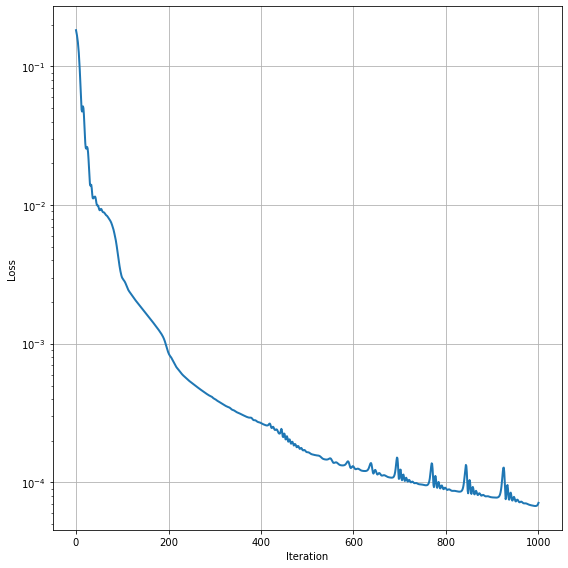

In [47]:
nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Loss = 6.695483e-05:   1%|█▌                                                                                                                                                       | 10/1000 [00:15<27:49,  1.69s/it]

New min loss =  6.695483e-05


Loss = 6.5841785e-05:   2%|██▌                                                                                                                                                     | 17/1000 [00:28<30:05,  1.84s/it]

New min loss =  6.5841785e-05


Loss = 6.574413e-05:   2%|███▌                                                                                                                                                     | 23/1000 [00:45<39:22,  2.42s/it]

New min loss =  6.574413e-05


Loss = 6.55813e-05:   3%|████▎                                                                                                                                                     | 28/1000 [01:04<57:19,  3.54s/it]

New min loss =  6.55813e-05


Loss = 6.550943e-05:   3%|█████▏                                                                                                                                                   | 34/1000 [01:23<56:54,  3.53s/it]

New min loss =  6.550943e-05


Loss = 6.523748e-05:   4%|██████▋                                                                                                                                                  | 44/1000 [01:55<51:42,  3.25s/it]

New min loss =  6.523748e-05


Loss = 6.507273e-05:   5%|███████▋                                                                                                                                                 | 50/1000 [02:10<42:09,  2.66s/it]

New min loss =  6.507273e-05


Loss = 6.498391e-05:   5%|████████▎                                                                                                                                                | 54/1000 [02:21<44:12,  2.80s/it]

New min loss =  6.498391e-05


Loss = 6.495839e-05:   6%|█████████                                                                                                                                                | 59/1000 [02:31<34:03,  2.17s/it]

New min loss =  6.495839e-05


Loss = 6.48535e-05:   6%|█████████▏                                                                                                                                                | 60/1000 [02:33<32:42,  2.09s/it]

New min loss =  6.48535e-05


Loss = 6.4715714e-05:   6%|█████████▋                                                                                                                                              | 64/1000 [02:41<32:02,  2.05s/it]

New min loss =  6.4715714e-05


Loss = 6.460684e-05:   7%|██████████▌                                                                                                                                              | 69/1000 [02:50<28:38,  1.85s/it]

New min loss =  6.460684e-05


Loss = 6.4497915e-05:   7%|███████████                                                                                                                                             | 73/1000 [03:02<44:35,  2.89s/it]

New min loss =  6.4497915e-05


Loss = 6.44829e-05:   8%|███████████▋                                                                                                                                              | 76/1000 [03:11<43:35,  2.83s/it]

New min loss =  6.44829e-05


Loss = 6.438434e-05:   8%|███████████▊                                                                                                                                             | 77/1000 [03:13<39:26,  2.56s/it]

New min loss =  6.438434e-05


Loss = 6.438157e-05:   8%|███████████▉                                                                                                                                             | 78/1000 [03:15<37:35,  2.45s/it]

New min loss =  6.438157e-05


Loss = 6.4343156e-05:   8%|████████████▎                                                                                                                                           | 81/1000 [03:20<28:36,  1.87s/it]

New min loss =  6.4343156e-05


Loss = 6.426751e-05:   8%|████████████▌                                                                                                                                            | 82/1000 [03:22<29:24,  1.92s/it]

New min loss =  6.426751e-05


Loss = 6.4258275e-05:   8%|████████████▌                                                                                                                                           | 83/1000 [03:24<29:29,  1.93s/it]

New min loss =  6.4258275e-05


Loss = 6.420776e-05:   8%|█████████████                                                                                                                                            | 85/1000 [03:28<31:43,  2.08s/it]

New min loss =  6.420776e-05


Loss = 6.4149186e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:30<32:29,  2.13s/it]

New min loss =  6.4149186e-05


Loss = 6.4136955e-05:   9%|█████████████▏                                                                                                                                          | 87/1000 [03:33<33:16,  2.19s/it]

New min loss =  6.4136955e-05


Loss = 6.412562e-05:   9%|█████████████▍                                                                                                                                           | 88/1000 [03:35<35:17,  2.32s/it]

New min loss =  6.412562e-05


Loss = 6.407611e-05:   9%|█████████████▌                                                                                                                                           | 89/1000 [03:39<39:43,  2.62s/it]

New min loss =  6.407611e-05


Loss = 6.403017e-05:   9%|█████████████▊                                                                                                                                           | 90/1000 [03:42<43:12,  2.85s/it]

New min loss =  6.403017e-05


Loss = 6.4015374e-05:   9%|█████████████▊                                                                                                                                          | 91/1000 [03:46<46:39,  3.08s/it]

New min loss =  6.4015374e-05


Loss = 6.399366e-05:   9%|██████████████▏                                                                                                                                          | 93/1000 [03:49<37:00,  2.45s/it]

New min loss =  6.399366e-05


Loss = 6.394729e-05:   9%|██████████████▍                                                                                                                                          | 94/1000 [03:52<39:38,  2.62s/it]

New min loss =  6.394729e-05


Loss = 6.391033e-05:  10%|██████████████▌                                                                                                                                          | 95/1000 [03:56<42:16,  2.80s/it]

New min loss =  6.391033e-05


Loss = 6.389212e-05:  10%|██████████████▋                                                                                                                                          | 96/1000 [03:59<46:03,  3.06s/it]

New min loss =  6.389212e-05


Loss = 6.386287e-05:  10%|██████████████▊                                                                                                                                          | 97/1000 [04:03<46:51,  3.11s/it]

New min loss =  6.386287e-05


Loss = 6.3820204e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [04:04<41:49,  2.78s/it]

New min loss =  6.3820204e-05


Loss = 6.37892e-05:  10%|███████████████▏                                                                                                                                          | 99/1000 [04:07<39:45,  2.65s/it]

New min loss =  6.37892e-05


Loss = 6.376683e-05:  10%|███████████████▏                                                                                                                                        | 100/1000 [04:09<38:14,  2.55s/it]

New min loss =  6.376683e-05


Loss = 6.373294e-05:  10%|███████████████▎                                                                                                                                        | 101/1000 [04:11<37:09,  2.48s/it]

New min loss =  6.373294e-05


Loss = 6.3694475e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [04:14<36:36,  2.45s/it]

New min loss =  6.3694475e-05


Loss = 6.366646e-05:  10%|███████████████▋                                                                                                                                        | 103/1000 [04:16<34:47,  2.33s/it]

New min loss =  6.366646e-05


Loss = 6.363958e-05:  10%|███████████████▊                                                                                                                                        | 104/1000 [04:18<34:24,  2.30s/it]

New min loss =  6.363958e-05


Loss = 6.36034e-05:  10%|████████████████                                                                                                                                         | 105/1000 [04:20<33:28,  2.24s/it]

New min loss =  6.36034e-05


Loss = 6.356835e-05:  11%|████████████████▎                                                                                                                                       | 107/1000 [04:22<25:06,  1.69s/it]

New min loss =  6.356835e-05


Loss = 6.354018e-05:  11%|████████████████▍                                                                                                                                       | 108/1000 [04:24<26:52,  1.81s/it]

New min loss =  6.354018e-05


Loss = 6.3508785e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [04:27<29:20,  1.98s/it]

New min loss =  6.3508785e-05


Loss = 6.347239e-05:  11%|████████████████▋                                                                                                                                       | 110/1000 [04:30<32:33,  2.19s/it]

New min loss =  6.347239e-05


Loss = 6.343987e-05:  11%|████████████████▊                                                                                                                                       | 111/1000 [04:32<33:52,  2.29s/it]

New min loss =  6.343987e-05


Loss = 6.341002e-05:  11%|█████████████████                                                                                                                                       | 112/1000 [04:35<35:22,  2.39s/it]

New min loss =  6.341002e-05


Loss = 6.337587e-05:  11%|█████████████████▏                                                                                                                                      | 113/1000 [04:38<36:44,  2.49s/it]

New min loss =  6.337587e-05


Loss = 6.33407e-05:  11%|█████████████████▍                                                                                                                                       | 114/1000 [04:40<37:43,  2.55s/it]

New min loss =  6.33407e-05


Loss = 6.330915e-05:  12%|█████████████████▍                                                                                                                                      | 115/1000 [04:43<37:34,  2.55s/it]

New min loss =  6.330915e-05


Loss = 6.327696e-05:  12%|█████████████████▋                                                                                                                                      | 116/1000 [04:45<38:04,  2.58s/it]

New min loss =  6.327696e-05


Loss = 6.324176e-05:  12%|█████████████████▊                                                                                                                                      | 117/1000 [04:48<37:50,  2.57s/it]

New min loss =  6.324176e-05


Loss = 6.3207954e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [04:51<37:44,  2.57s/it]

New min loss =  6.3207954e-05


Loss = 6.3175845e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:53<38:16,  2.61s/it]

New min loss =  6.3175845e-05


Loss = 6.314173e-05:  12%|██████████████████▏                                                                                                                                     | 120/1000 [04:56<39:06,  2.67s/it]

New min loss =  6.314173e-05


Loss = 6.310677e-05:  12%|██████████████████▌                                                                                                                                     | 122/1000 [04:59<30:15,  2.07s/it]

New min loss =  6.310677e-05


Loss = 6.30736e-05:  12%|██████████████████▊                                                                                                                                      | 123/1000 [05:01<31:53,  2.18s/it]

New min loss =  6.30736e-05


Loss = 6.3040214e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [05:04<32:55,  2.25s/it]

New min loss =  6.3040214e-05


Loss = 6.3005326e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [05:06<34:40,  2.38s/it]

New min loss =  6.3005326e-05


Loss = 6.2971085e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [05:09<36:26,  2.50s/it]

New min loss =  6.2971085e-05


Loss = 6.2937674e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:12<35:55,  2.47s/it]

New min loss =  6.2937674e-05


Loss = 6.290321e-05:  13%|███████████████████▍                                                                                                                                    | 128/1000 [05:14<36:31,  2.51s/it]

New min loss =  6.290321e-05


Loss = 6.286839e-05:  13%|███████████████████▌                                                                                                                                    | 129/1000 [05:17<37:40,  2.59s/it]

New min loss =  6.286839e-05


Loss = 6.283446e-05:  13%|███████████████████▊                                                                                                                                    | 130/1000 [05:20<37:59,  2.62s/it]

New min loss =  6.283446e-05


Loss = 6.2800274e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [05:22<37:52,  2.62s/it]

New min loss =  6.2800274e-05


Loss = 6.2765335e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:25<36:41,  2.54s/it]

New min loss =  6.2765335e-05


Loss = 6.273085e-05:  13%|████████████████████▏                                                                                                                                   | 133/1000 [05:27<36:53,  2.55s/it]

New min loss =  6.273085e-05


Loss = 6.269666e-05:  13%|████████████████████▎                                                                                                                                   | 134/1000 [05:30<38:12,  2.65s/it]

New min loss =  6.269666e-05


Loss = 6.266189e-05:  14%|████████████████████▌                                                                                                                                   | 135/1000 [05:33<38:03,  2.64s/it]

New min loss =  6.266189e-05


Loss = 6.2627056e-05:  14%|████████████████████▌                                                                                                                                  | 136/1000 [05:35<38:01,  2.64s/it]

New min loss =  6.2627056e-05


Loss = 6.259266e-05:  14%|████████████████████▉                                                                                                                                   | 138/1000 [05:38<28:57,  2.02s/it]

New min loss =  6.259266e-05


Loss = 6.255797e-05:  14%|█████████████████████▏                                                                                                                                  | 139/1000 [05:41<30:45,  2.14s/it]

New min loss =  6.255797e-05


Loss = 6.2522995e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:43<32:10,  2.24s/it]

New min loss =  6.2522995e-05


Loss = 6.248832e-05:  14%|█████████████████████▍                                                                                                                                  | 141/1000 [05:46<34:31,  2.41s/it]

New min loss =  6.248832e-05


Loss = 6.245359e-05:  14%|█████████████████████▌                                                                                                                                  | 142/1000 [05:48<34:12,  2.39s/it]

New min loss =  6.245359e-05


Loss = 6.241851e-05:  14%|█████████████████████▋                                                                                                                                  | 143/1000 [05:51<35:28,  2.48s/it]

New min loss =  6.241851e-05


Loss = 6.238358e-05:  14%|█████████████████████▉                                                                                                                                  | 144/1000 [05:54<36:55,  2.59s/it]

New min loss =  6.238358e-05


Loss = 6.234873e-05:  14%|██████████████████████                                                                                                                                  | 145/1000 [05:56<36:49,  2.58s/it]

New min loss =  6.234873e-05


Loss = 6.231364e-05:  15%|██████████████████████▏                                                                                                                                 | 146/1000 [05:59<35:36,  2.50s/it]

New min loss =  6.231364e-05


Loss = 6.2278494e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [06:01<36:04,  2.54s/it]

New min loss =  6.2278494e-05


Loss = 6.224349e-05:  15%|██████████████████████▍                                                                                                                                 | 148/1000 [06:04<36:04,  2.54s/it]

New min loss =  6.224349e-05


Loss = 6.220834e-05:  15%|██████████████████████▋                                                                                                                                 | 149/1000 [06:07<36:44,  2.59s/it]

New min loss =  6.220834e-05


Loss = 6.2173094e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [06:09<36:10,  2.55s/it]

New min loss =  6.2173094e-05


Loss = 6.213793e-05:  15%|██████████████████████▉                                                                                                                                 | 151/1000 [06:11<35:11,  2.49s/it]

New min loss =  6.213793e-05


Loss = 6.2102765e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [06:14<35:41,  2.53s/it]

New min loss =  6.2102765e-05


Loss = 6.206748e-05:  15%|███████████████████████▎                                                                                                                                | 153/1000 [06:17<35:29,  2.51s/it]

New min loss =  6.206748e-05


Loss = 6.203212e-05:  16%|███████████████████████▌                                                                                                                                | 155/1000 [06:19<27:27,  1.95s/it]

New min loss =  6.203212e-05


Loss = 6.199655e-05:  16%|███████████████████████▋                                                                                                                                | 156/1000 [06:22<29:54,  2.13s/it]

New min loss =  6.199655e-05


Loss = 6.196072e-05:  16%|███████████████████████▊                                                                                                                                | 157/1000 [06:24<31:41,  2.26s/it]

New min loss =  6.196072e-05


Loss = 6.192469e-05:  16%|████████████████████████                                                                                                                                | 158/1000 [06:27<33:09,  2.36s/it]

New min loss =  6.192469e-05


Loss = 6.188855e-05:  16%|████████████████████████▏                                                                                                                               | 159/1000 [06:30<34:08,  2.44s/it]

New min loss =  6.188855e-05


Loss = 6.185222e-05:  16%|████████████████████████▎                                                                                                                               | 160/1000 [06:32<34:58,  2.50s/it]

New min loss =  6.185222e-05


Loss = 6.181581e-05:  16%|████████████████████████▍                                                                                                                               | 161/1000 [06:35<35:02,  2.51s/it]

New min loss =  6.181581e-05


Loss = 6.177935e-05:  16%|████████████████████████▌                                                                                                                               | 162/1000 [06:37<35:06,  2.51s/it]

New min loss =  6.177935e-05


Loss = 6.174276e-05:  16%|████████████████████████▊                                                                                                                               | 163/1000 [06:40<35:36,  2.55s/it]

New min loss =  6.174276e-05


Loss = 6.1706094e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:43<35:56,  2.58s/it]

New min loss =  6.1706094e-05


Loss = 6.166941e-05:  16%|█████████████████████████                                                                                                                               | 165/1000 [06:45<35:31,  2.55s/it]

New min loss =  6.166941e-05


Loss = 6.1632614e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [06:48<35:12,  2.53s/it]

New min loss =  6.1632614e-05


Loss = 6.1595725e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [06:50<35:59,  2.59s/it]

New min loss =  6.1595725e-05


Loss = 6.1558756e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [06:53<36:00,  2.60s/it]

New min loss =  6.1558756e-05


Loss = 6.1521736e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [06:56<35:59,  2.60s/it]

New min loss =  6.1521736e-05


Loss = 6.148462e-05:  17%|█████████████████████████▊                                                                                                                              | 170/1000 [06:58<35:50,  2.59s/it]

New min loss =  6.148462e-05


Loss = 6.144749e-05:  17%|█████████████████████████▉                                                                                                                              | 171/1000 [07:01<35:40,  2.58s/it]

New min loss =  6.144749e-05


Loss = 6.141037e-05:  17%|██████████████████████████▎                                                                                                                             | 173/1000 [07:03<27:17,  1.98s/it]

New min loss =  6.141037e-05


Loss = 6.137323e-05:  17%|██████████████████████████▍                                                                                                                             | 174/1000 [07:06<29:24,  2.14s/it]

New min loss =  6.137323e-05


Loss = 6.133609e-05:  18%|██████████████████████████▌                                                                                                                             | 175/1000 [07:09<31:20,  2.28s/it]

New min loss =  6.133609e-05


Loss = 6.1299004e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:11<32:19,  2.35s/it]

New min loss =  6.1299004e-05


Loss = 6.126191e-05:  18%|██████████████████████████▉                                                                                                                             | 177/1000 [07:14<32:49,  2.39s/it]

New min loss =  6.126191e-05


Loss = 6.122483e-05:  18%|███████████████████████████                                                                                                                             | 178/1000 [07:16<34:04,  2.49s/it]

New min loss =  6.122483e-05


Loss = 6.118777e-05:  18%|███████████████████████████▏                                                                                                                            | 179/1000 [07:19<34:25,  2.52s/it]

New min loss =  6.118777e-05


Loss = 6.115072e-05:  18%|███████████████████████████▎                                                                                                                            | 180/1000 [07:21<34:33,  2.53s/it]

New min loss =  6.115072e-05


Loss = 6.111361e-05:  18%|███████████████████████████▌                                                                                                                            | 181/1000 [07:24<34:26,  2.52s/it]

New min loss =  6.111361e-05


Loss = 6.107652e-05:  18%|███████████████████████████▋                                                                                                                            | 182/1000 [07:27<35:07,  2.58s/it]

New min loss =  6.107652e-05


Loss = 6.103941e-05:  18%|███████████████████████████▊                                                                                                                            | 183/1000 [07:29<34:53,  2.56s/it]

New min loss =  6.103941e-05


Loss = 6.1002247e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [07:32<34:58,  2.57s/it]

New min loss =  6.1002247e-05


Loss = 6.096516e-05:  18%|████████████████████████████                                                                                                                            | 185/1000 [07:34<34:39,  2.55s/it]

New min loss =  6.096516e-05


Loss = 6.0928036e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [07:37<33:47,  2.49s/it]

New min loss =  6.0928036e-05


Loss = 6.089098e-05:  19%|████████████████████████████▍                                                                                                                           | 187/1000 [07:39<34:18,  2.53s/it]

New min loss =  6.089098e-05


Loss = 6.085397e-05:  19%|████████████████████████████▌                                                                                                                           | 188/1000 [07:42<34:58,  2.58s/it]

New min loss =  6.085397e-05


Loss = 6.0817005e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [07:45<34:54,  2.58s/it]

New min loss =  6.0817005e-05


Loss = 6.078006e-05:  19%|████████████████████████████▉                                                                                                                           | 190/1000 [07:47<34:24,  2.55s/it]

New min loss =  6.078006e-05


Loss = 6.0743165e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [07:49<25:49,  1.92s/it]

New min loss =  6.0743165e-05


Loss = 6.0706305e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [07:52<27:59,  2.08s/it]

New min loss =  6.0706305e-05


Loss = 6.0669554e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [07:55<29:55,  2.23s/it]

New min loss =  6.0669554e-05


Loss = 6.0632836e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [07:57<31:12,  2.33s/it]

New min loss =  6.0632836e-05


Loss = 6.0596158e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [08:00<31:57,  2.39s/it]

New min loss =  6.0596158e-05


Loss = 6.0559523e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [08:02<32:52,  2.46s/it]

New min loss =  6.0559523e-05


Loss = 6.0522925e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [08:05<33:35,  2.51s/it]

New min loss =  6.0522925e-05


Loss = 6.0486327e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [08:08<34:15,  2.57s/it]

New min loss =  6.0486327e-05


Loss = 6.0449784e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [08:10<34:17,  2.57s/it]

New min loss =  6.0449784e-05


Loss = 6.0413266e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [08:13<34:47,  2.61s/it]

New min loss =  6.0413266e-05


Loss = 6.0376824e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [08:15<33:44,  2.54s/it]

New min loss =  6.0376824e-05


Loss = 6.0340415e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [08:18<33:40,  2.54s/it]

New min loss =  6.0340415e-05


Loss = 6.0304068e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [08:21<33:57,  2.56s/it]

New min loss =  6.0304068e-05


Loss = 6.0267783e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [08:23<34:14,  2.58s/it]

New min loss =  6.0267783e-05


Loss = 6.023154e-05:  21%|███████████████████████████████▎                                                                                                                        | 206/1000 [08:26<34:09,  2.58s/it]

New min loss =  6.023154e-05


Loss = 6.019535e-05:  21%|███████████████████████████████▍                                                                                                                        | 207/1000 [08:28<33:21,  2.52s/it]

New min loss =  6.019535e-05


Loss = 6.0159116e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [08:31<34:09,  2.59s/it]

New min loss =  6.0159116e-05


Loss = 6.0122962e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [08:34<34:17,  2.60s/it]

New min loss =  6.0122962e-05


Loss = 6.0086833e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [08:36<33:53,  2.57s/it]

New min loss =  6.0086833e-05


Loss = 6.0050756e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [08:39<25:53,  1.97s/it]

New min loss =  6.0050756e-05


Loss = 6.0014736e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [08:41<27:23,  2.09s/it]

New min loss =  6.0014736e-05


Loss = 5.9978687e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [08:44<29:31,  2.25s/it]

New min loss =  5.9978687e-05


Loss = 5.9942686e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [08:46<31:03,  2.37s/it]

New min loss =  5.9942686e-05


Loss = 5.9906703e-05:  22%|████████████████████████████████▌                                                                                                                      | 216/1000 [08:49<31:27,  2.41s/it]

New min loss =  5.9906703e-05


Loss = 5.9870763e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [08:52<32:07,  2.46s/it]

New min loss =  5.9870763e-05


Loss = 5.9834885e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [08:54<32:11,  2.47s/it]

New min loss =  5.9834885e-05


Loss = 5.979905e-05:  22%|█████████████████████████████████▎                                                                                                                      | 219/1000 [08:57<32:27,  2.49s/it]

New min loss =  5.979905e-05


Loss = 5.976329e-05:  22%|█████████████████████████████████▍                                                                                                                      | 220/1000 [08:59<32:51,  2.53s/it]

New min loss =  5.976329e-05


Loss = 5.972756e-05:  22%|█████████████████████████████████▌                                                                                                                      | 221/1000 [09:02<32:05,  2.47s/it]

New min loss =  5.972756e-05


Loss = 5.969184e-05:  22%|█████████████████████████████████▋                                                                                                                      | 222/1000 [09:04<32:27,  2.50s/it]

New min loss =  5.969184e-05


Loss = 5.965618e-05:  22%|█████████████████████████████████▉                                                                                                                      | 223/1000 [09:07<32:13,  2.49s/it]

New min loss =  5.965618e-05


Loss = 5.9620565e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [09:09<33:02,  2.55s/it]

New min loss =  5.9620565e-05


Loss = 5.9585e-05:  22%|██████████████████████████████████▋                                                                                                                       | 225/1000 [09:12<33:48,  2.62s/it]

New min loss =  5.9585e-05


Loss = 5.9549468e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [09:14<33:09,  2.57s/it]

New min loss =  5.9549468e-05


Loss = 5.951396e-05:  23%|██████████████████████████████████▌                                                                                                                     | 227/1000 [09:17<32:37,  2.53s/it]

New min loss =  5.951396e-05


Loss = 5.9478498e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [09:20<33:00,  2.57s/it]

New min loss =  5.9478498e-05


Loss = 5.9443068e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [09:22<33:09,  2.58s/it]

New min loss =  5.9443068e-05


Loss = 5.9407645e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [09:25<34:08,  2.66s/it]

New min loss =  5.9407645e-05


Loss = 5.9372276e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [09:27<33:13,  2.59s/it]

New min loss =  5.9372276e-05


Loss = 5.933693e-05:  23%|███████████████████████████████████▍                                                                                                                    | 233/1000 [09:30<25:09,  1.97s/it]

New min loss =  5.933693e-05


Loss = 5.9301616e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [09:33<27:03,  2.12s/it]

New min loss =  5.9301616e-05


Loss = 5.9266353e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [09:35<29:16,  2.30s/it]

New min loss =  5.9266353e-05


Loss = 5.9231086e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [09:38<29:56,  2.35s/it]

New min loss =  5.9231086e-05


Loss = 5.9195852e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [09:40<30:43,  2.42s/it]

New min loss =  5.9195852e-05


Loss = 5.916065e-05:  24%|████████████████████████████████████▏                                                                                                                   | 238/1000 [09:43<31:44,  2.50s/it]

New min loss =  5.916065e-05


Loss = 5.9125483e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [09:46<32:18,  2.55s/it]

New min loss =  5.9125483e-05


Loss = 5.9090333e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [09:48<32:36,  2.57s/it]

New min loss =  5.9090333e-05


Loss = 5.9055234e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [09:51<32:03,  2.53s/it]

New min loss =  5.9055234e-05


Loss = 5.902016e-05:  24%|████████████████████████████████████▊                                                                                                                   | 242/1000 [09:53<32:14,  2.55s/it]

New min loss =  5.902016e-05


Loss = 5.898515e-05:  24%|████████████████████████████████████▉                                                                                                                   | 243/1000 [09:56<32:32,  2.58s/it]

New min loss =  5.898515e-05


Loss = 5.8950154e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [09:59<32:46,  2.60s/it]

New min loss =  5.8950154e-05


Loss = 5.8915204e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [10:01<32:16,  2.56s/it]

New min loss =  5.8915204e-05


Loss = 5.8880283e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [10:04<31:26,  2.50s/it]

New min loss =  5.8880283e-05


Loss = 5.8845366e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [10:06<31:26,  2.51s/it]

New min loss =  5.8845366e-05


Loss = 5.8810478e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [10:09<32:19,  2.58s/it]

New min loss =  5.8810478e-05


Loss = 5.8775633e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [10:11<32:06,  2.56s/it]

New min loss =  5.8775633e-05


Loss = 5.8740843e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [10:14<31:24,  2.51s/it]

New min loss =  5.8740843e-05


Loss = 5.8706068e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [10:16<31:23,  2.51s/it]

New min loss =  5.8706068e-05


Loss = 5.8671343e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [10:19<31:45,  2.55s/it]

New min loss =  5.8671343e-05


Loss = 5.8636688e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [10:21<31:55,  2.56s/it]

New min loss =  5.8636688e-05


Loss = 5.8602054e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [10:24<25:01,  2.01s/it]

New min loss =  5.8602054e-05


Loss = 5.856738e-05:  26%|██████████████████████████████████████▉                                                                                                                 | 256/1000 [10:27<26:34,  2.14s/it]

New min loss =  5.856738e-05


Loss = 5.853277e-05:  26%|███████████████████████████████████████                                                                                                                 | 257/1000 [10:29<27:51,  2.25s/it]

New min loss =  5.853277e-05


Loss = 5.849818e-05:  26%|███████████████████████████████████████▏                                                                                                                | 258/1000 [10:32<29:55,  2.42s/it]

New min loss =  5.849818e-05


Loss = 5.8463644e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [10:35<30:50,  2.50s/it]

New min loss =  5.8463644e-05


Loss = 5.8429086e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [10:38<31:13,  2.53s/it]

New min loss =  5.8429086e-05


Loss = 5.839455e-05:  26%|███████████████████████████████████████▋                                                                                                                | 261/1000 [10:40<30:47,  2.50s/it]

New min loss =  5.839455e-05


Loss = 5.8360052e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [10:43<31:10,  2.53s/it]

New min loss =  5.8360052e-05


Loss = 5.832559e-05:  26%|███████████████████████████████████████▉                                                                                                                | 263/1000 [10:45<32:00,  2.61s/it]

New min loss =  5.832559e-05


Loss = 5.8291185e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [10:48<31:48,  2.59s/it]

New min loss =  5.8291185e-05


Loss = 5.8256817e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [10:50<31:00,  2.53s/it]

New min loss =  5.8256817e-05


Loss = 5.822244e-05:  27%|████████████████████████████████████████▍                                                                                                               | 266/1000 [10:53<31:17,  2.56s/it]

New min loss =  5.822244e-05


Loss = 5.818811e-05:  27%|████████████████████████████████████████▌                                                                                                               | 267/1000 [10:55<31:21,  2.57s/it]

New min loss =  5.818811e-05


Loss = 5.8153797e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [10:58<30:53,  2.53s/it]

New min loss =  5.8153797e-05


Loss = 5.8119447e-05:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [11:00<30:47,  2.53s/it]

New min loss =  5.8119447e-05


Loss = 5.8085185e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [11:03<31:11,  2.56s/it]

New min loss =  5.8085185e-05


Loss = 5.8050908e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [11:06<30:41,  2.53s/it]

New min loss =  5.8050908e-05


Loss = 5.801659e-05:  27%|█████████████████████████████████████████▎                                                                                                              | 272/1000 [11:08<30:28,  2.51s/it]

New min loss =  5.801659e-05


Loss = 5.7982325e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [11:10<29:58,  2.47s/it]

New min loss =  5.7982325e-05


Loss = 5.794807e-05:  27%|█████████████████████████████████████████▋                                                                                                              | 274/1000 [11:13<30:46,  2.54s/it]

New min loss =  5.794807e-05


Loss = 5.791385e-05:  28%|█████████████████████████████████████████▊                                                                                                              | 275/1000 [11:16<30:47,  2.55s/it]

New min loss =  5.791385e-05


Loss = 5.7879628e-05:  28%|█████████████████████████████████████████▋                                                                                                             | 276/1000 [11:18<30:51,  2.56s/it]

New min loss =  5.7879628e-05


Loss = 5.784545e-05:  28%|██████████████████████████████████████████▎                                                                                                             | 278/1000 [11:21<24:08,  2.01s/it]

New min loss =  5.784545e-05


Loss = 5.781127e-05:  28%|██████████████████████████████████████████▍                                                                                                             | 279/1000 [11:24<26:05,  2.17s/it]

New min loss =  5.781127e-05


Loss = 5.777704e-05:  28%|██████████████████████████████████████████▌                                                                                                             | 280/1000 [11:26<27:07,  2.26s/it]

New min loss =  5.777704e-05


Loss = 5.774288e-05:  28%|██████████████████████████████████████████▋                                                                                                             | 281/1000 [11:28<27:21,  2.28s/it]

New min loss =  5.774288e-05


Loss = 5.7708727e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [11:31<27:23,  2.29s/it]

New min loss =  5.7708727e-05


Loss = 5.7674588e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [11:33<28:27,  2.38s/it]

New min loss =  5.7674588e-05


Loss = 5.7640456e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [11:36<29:09,  2.44s/it]

New min loss =  5.7640456e-05


Loss = 5.7606332e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [11:39<30:12,  2.54s/it]

New min loss =  5.7606332e-05


Loss = 5.757226e-05:  29%|███████████████████████████████████████████▍                                                                                                            | 286/1000 [11:41<29:31,  2.48s/it]

New min loss =  5.757226e-05


Loss = 5.7538222e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [11:44<29:50,  2.51s/it]

New min loss =  5.7538222e-05


Loss = 5.750417e-05:  29%|███████████████████████████████████████████▊                                                                                                            | 288/1000 [11:46<29:53,  2.52s/it]

New min loss =  5.750417e-05


Loss = 5.7470214e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [11:49<30:27,  2.57s/it]

New min loss =  5.7470214e-05


Loss = 5.743624e-05:  29%|████████████████████████████████████████████                                                                                                            | 290/1000 [11:52<30:25,  2.57s/it]

New min loss =  5.743624e-05


Loss = 5.74023e-05:  29%|████████████████████████████████████████████▌                                                                                                            | 291/1000 [11:54<29:58,  2.54s/it]

New min loss =  5.74023e-05


Loss = 5.7368405e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [11:56<29:51,  2.53s/it]

New min loss =  5.7368405e-05


Loss = 5.733455e-05:  29%|████████████████████████████████████████████▌                                                                                                           | 293/1000 [11:59<30:26,  2.58s/it]

New min loss =  5.733455e-05


Loss = 5.7300716e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [12:02<30:14,  2.57s/it]

New min loss =  5.7300716e-05


Loss = 5.7266934e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [12:04<29:57,  2.55s/it]

New min loss =  5.7266934e-05


Loss = 5.7233177e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [12:07<29:30,  2.51s/it]

New min loss =  5.7233177e-05


Loss = 5.719946e-05:  30%|█████████████████████████████████████████████▏                                                                                                          | 297/1000 [12:09<29:19,  2.50s/it]

New min loss =  5.719946e-05


Loss = 5.7165777e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [12:12<29:42,  2.54s/it]

New min loss =  5.7165777e-05


Loss = 5.7132132e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [12:14<29:45,  2.55s/it]

New min loss =  5.7132132e-05


Loss = 5.7098543e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [12:17<29:33,  2.53s/it]

New min loss =  5.7098543e-05


Loss = 5.7065023e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [12:19<22:30,  1.93s/it]

New min loss =  5.7065023e-05


Loss = 5.7031484e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [12:22<23:33,  2.03s/it]

New min loss =  5.7031484e-05


Loss = 5.699797e-05:  30%|██████████████████████████████████████████████▏                                                                                                         | 304/1000 [12:24<25:37,  2.21s/it]

New min loss =  5.699797e-05


Loss = 5.6964494e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [12:27<27:25,  2.37s/it]

New min loss =  5.6964494e-05


Loss = 5.6931047e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [12:30<28:15,  2.44s/it]

New min loss =  5.6931047e-05


Loss = 5.6897617e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [12:32<28:10,  2.44s/it]

New min loss =  5.6897617e-05


Loss = 5.686424e-05:  31%|██████████████████████████████████████████████▊                                                                                                         | 308/1000 [12:35<28:23,  2.46s/it]

New min loss =  5.686424e-05


Loss = 5.683089e-05:  31%|██████████████████████████████████████████████▉                                                                                                         | 309/1000 [12:38<29:42,  2.58s/it]

New min loss =  5.683089e-05


Loss = 5.6797566e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [12:40<29:34,  2.57s/it]

New min loss =  5.6797566e-05


Loss = 5.6764275e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [12:43<29:18,  2.55s/it]

New min loss =  5.6764275e-05


Loss = 5.6730943e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [12:45<29:25,  2.57s/it]

New min loss =  5.6730943e-05


Loss = 5.6697743e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [12:48<29:50,  2.61s/it]

New min loss =  5.6697743e-05


Loss = 5.6664598e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [12:50<29:24,  2.57s/it]

New min loss =  5.6664598e-05


Loss = 5.663146e-05:  32%|███████████████████████████████████████████████▉                                                                                                        | 315/1000 [12:53<30:04,  2.63s/it]

New min loss =  5.663146e-05


Loss = 5.659839e-05:  32%|████████████████████████████████████████████████                                                                                                        | 316/1000 [12:56<29:09,  2.56s/it]

New min loss =  5.659839e-05


Loss = 5.6565284e-05:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [12:58<29:21,  2.58s/it]

New min loss =  5.6565284e-05


Loss = 5.6532263e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [13:01<29:33,  2.60s/it]

New min loss =  5.6532263e-05


Loss = 5.6499266e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [13:03<29:38,  2.61s/it]

New min loss =  5.6499266e-05


Loss = 5.6466277e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [13:06<29:38,  2.62s/it]

New min loss =  5.6466277e-05


Loss = 5.6433262e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [13:09<29:23,  2.60s/it]

New min loss =  5.6433262e-05


Loss = 5.640025e-05:  32%|████████████████████████████████████████████████▉                                                                                                       | 322/1000 [13:11<29:04,  2.57s/it]

New min loss =  5.640025e-05


Loss = 5.6367277e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [13:14<29:14,  2.59s/it]

New min loss =  5.6367277e-05


Loss = 5.6334342e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [13:16<29:07,  2.59s/it]

New min loss =  5.6334342e-05


Loss = 5.6301422e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [13:19<28:42,  2.55s/it]

New min loss =  5.6301422e-05


Loss = 5.6268575e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [13:21<21:53,  1.95s/it]

New min loss =  5.6268575e-05


Loss = 5.623574e-05:  33%|█████████████████████████████████████████████████▊                                                                                                      | 328/1000 [13:24<23:46,  2.12s/it]

New min loss =  5.623574e-05


Loss = 5.620295e-05:  33%|██████████████████████████████████████████████████                                                                                                      | 329/1000 [13:27<25:16,  2.26s/it]

New min loss =  5.620295e-05


Loss = 5.617016e-05:  33%|██████████████████████████████████████████████████▏                                                                                                     | 330/1000 [13:29<26:25,  2.37s/it]

New min loss =  5.617016e-05


Loss = 5.613743e-05:  33%|██████████████████████████████████████████████████▎                                                                                                     | 331/1000 [13:32<26:11,  2.35s/it]

New min loss =  5.613743e-05


Loss = 5.610478e-05:  33%|██████████████████████████████████████████████████▍                                                                                                     | 332/1000 [13:34<26:57,  2.42s/it]

New min loss =  5.610478e-05


Loss = 5.6072182e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [13:37<27:36,  2.48s/it]

New min loss =  5.6072182e-05


Loss = 5.6039607e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [13:40<28:09,  2.54s/it]

New min loss =  5.6039607e-05


Loss = 5.6007062e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [13:42<28:26,  2.57s/it]

New min loss =  5.6007062e-05


Loss = 5.597455e-05:  34%|███████████████████████████████████████████████████                                                                                                     | 336/1000 [13:45<28:34,  2.58s/it]

New min loss =  5.597455e-05


Loss = 5.5942084e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [13:47<28:46,  2.60s/it]

New min loss =  5.5942084e-05


Loss = 5.5909688e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [13:50<28:35,  2.59s/it]

New min loss =  5.5909688e-05


Loss = 5.5877365e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [13:53<28:47,  2.61s/it]

New min loss =  5.5877365e-05


Loss = 5.584509e-05:  34%|███████████████████████████████████████████████████▋                                                                                                    | 340/1000 [13:55<28:12,  2.56s/it]

New min loss =  5.584509e-05


Loss = 5.5812834e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [13:58<28:18,  2.58s/it]

New min loss =  5.5812834e-05


Loss = 5.5780627e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [14:00<28:21,  2.59s/it]

New min loss =  5.5780627e-05


Loss = 5.5748482e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [14:03<28:45,  2.63s/it]

New min loss =  5.5748482e-05


Loss = 5.5716322e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [14:05<27:39,  2.53s/it]

New min loss =  5.5716322e-05


Loss = 5.5684213e-05:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [14:08<27:51,  2.55s/it]

New min loss =  5.5684213e-05


Loss = 5.5652188e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [14:11<28:08,  2.58s/it]

New min loss =  5.5652188e-05


Loss = 5.56202e-05:  35%|█████████████████████████████████████████████████████                                                                                                    | 347/1000 [14:13<28:22,  2.61s/it]

New min loss =  5.56202e-05


Loss = 5.5588276e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [14:16<28:24,  2.61s/it]

New min loss =  5.5588276e-05


Loss = 5.5556382e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [14:18<27:56,  2.58s/it]

New min loss =  5.5556382e-05


Loss = 5.5524528e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [14:21<28:07,  2.60s/it]

New min loss =  5.5524528e-05


Loss = 5.5492706e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [14:23<27:38,  2.56s/it]

New min loss =  5.5492706e-05


Loss = 5.5460892e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [14:26<21:15,  1.97s/it]

New min loss =  5.5460892e-05


Loss = 5.5429096e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [14:29<22:29,  2.09s/it]

New min loss =  5.5429096e-05


Loss = 5.5397308e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [14:31<23:36,  2.20s/it]

New min loss =  5.5397308e-05


Loss = 5.5365563e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [14:34<24:25,  2.28s/it]

New min loss =  5.5365563e-05


Loss = 5.533383e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                 | 357/1000 [14:36<25:53,  2.42s/it]

New min loss =  5.533383e-05


Loss = 5.530211e-05:  36%|██████████████████████████████████████████████████████▍                                                                                                 | 358/1000 [14:39<26:37,  2.49s/it]

New min loss =  5.530211e-05


Loss = 5.527041e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                 | 359/1000 [14:41<26:05,  2.44s/it]

New min loss =  5.527041e-05


Loss = 5.5238746e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [14:44<26:40,  2.50s/it]

New min loss =  5.5238746e-05


Loss = 5.520715e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                 | 361/1000 [14:47<27:03,  2.54s/it]

New min loss =  5.520715e-05


Loss = 5.5175602e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [14:49<26:55,  2.53s/it]

New min loss =  5.5175602e-05


Loss = 5.514407e-05:  36%|███████████████████████████████████████████████████████▏                                                                                                | 363/1000 [14:52<26:43,  2.52s/it]

New min loss =  5.514407e-05


Loss = 5.5112625e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [14:54<26:44,  2.52s/it]

New min loss =  5.5112625e-05


Loss = 5.508123e-05:  36%|███████████████████████████████████████████████████████▍                                                                                                | 365/1000 [14:57<26:40,  2.52s/it]

New min loss =  5.508123e-05


Loss = 5.504991e-05:  37%|███████████████████████████████████████████████████████▋                                                                                                | 366/1000 [14:59<26:44,  2.53s/it]

New min loss =  5.504991e-05


Loss = 5.5018587e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [15:02<26:32,  2.52s/it]

New min loss =  5.5018587e-05


Loss = 5.4987348e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [15:04<26:51,  2.55s/it]

New min loss =  5.4987348e-05


Loss = 5.4956137e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [15:07<26:51,  2.55s/it]

New min loss =  5.4956137e-05


Loss = 5.4925036e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [15:09<26:52,  2.56s/it]

New min loss =  5.4925036e-05


Loss = 5.489399e-05:  37%|████████████████████████████████████████████████████████▍                                                                                               | 371/1000 [15:12<26:34,  2.54s/it]

New min loss =  5.489399e-05


Loss = 5.4862987e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [15:15<26:54,  2.57s/it]

New min loss =  5.4862987e-05


Loss = 5.4832064e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [15:17<26:22,  2.52s/it]

New min loss =  5.4832064e-05


Loss = 5.480122e-05:  37%|████████████████████████████████████████████████████████▊                                                                                               | 374/1000 [15:20<26:24,  2.53s/it]

New min loss =  5.480122e-05


Loss = 5.477041e-05:  38%|█████████████████████████████████████████████████████████                                                                                               | 375/1000 [15:22<26:16,  2.52s/it]

New min loss =  5.477041e-05


Loss = 5.4739667e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [15:25<27:28,  2.64s/it]

New min loss =  5.4739667e-05


Loss = 5.470896e-05:  38%|█████████████████████████████████████████████████████████▎                                                                                              | 377/1000 [15:27<26:26,  2.55s/it]

New min loss =  5.470896e-05


Loss = 5.467837e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                              | 378/1000 [15:30<27:23,  2.64s/it]

New min loss =  5.467837e-05


Loss = 5.4647793e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 380/1000 [15:33<21:08,  2.05s/it]

New min loss =  5.4647793e-05


Loss = 5.4617296e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [15:35<22:33,  2.19s/it]

New min loss =  5.4617296e-05


Loss = 5.4586853e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [15:38<23:42,  2.30s/it]

New min loss =  5.4586853e-05


Loss = 5.4556476e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [15:41<24:50,  2.42s/it]

New min loss =  5.4556476e-05


Loss = 5.4526103e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [15:43<25:20,  2.47s/it]

New min loss =  5.4526103e-05


Loss = 5.4495806e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [15:46<25:39,  2.50s/it]

New min loss =  5.4495806e-05


Loss = 5.446558e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                             | 386/1000 [15:48<25:32,  2.50s/it]

New min loss =  5.446558e-05


Loss = 5.4435433e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [15:51<25:27,  2.49s/it]

New min loss =  5.4435433e-05


Loss = 5.4405336e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [15:54<25:42,  2.52s/it]

New min loss =  5.4405336e-05


Loss = 5.4375298e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [15:56<26:04,  2.56s/it]

New min loss =  5.4375298e-05


Loss = 5.434531e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                            | 390/1000 [15:59<26:48,  2.64s/it]

New min loss =  5.434531e-05


Loss = 5.431537e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                            | 391/1000 [16:02<26:25,  2.60s/it]

New min loss =  5.431537e-05


Loss = 5.428548e-05:  39%|███████████████████████████████████████████████████████████▌                                                                                            | 392/1000 [16:04<26:03,  2.57s/it]

New min loss =  5.428548e-05


Loss = 5.4255586e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [16:07<25:47,  2.55s/it]

New min loss =  5.4255586e-05


Loss = 5.4225762e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [16:09<25:43,  2.55s/it]

New min loss =  5.4225762e-05


Loss = 5.4195953e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [16:12<25:40,  2.55s/it]

New min loss =  5.4195953e-05


Loss = 5.416621e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                           | 396/1000 [16:14<25:17,  2.51s/it]

New min loss =  5.416621e-05


Loss = 5.413648e-05:  40%|████████████████████████████████████████████████████████████▎                                                                                           | 397/1000 [16:17<25:09,  2.50s/it]

New min loss =  5.413648e-05


Loss = 5.4106808e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [16:19<25:28,  2.54s/it]

New min loss =  5.4106808e-05


Loss = 5.4077173e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [16:22<25:24,  2.54s/it]

New min loss =  5.4077173e-05


Loss = 5.4047592e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [16:24<25:43,  2.57s/it]

New min loss =  5.4047592e-05


Loss = 5.4018034e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [16:27<25:38,  2.57s/it]

New min loss =  5.4018034e-05


Loss = 5.3988562e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [16:29<25:10,  2.53s/it]

New min loss =  5.3988562e-05


Loss = 5.395914e-05:  40%|█████████████████████████████████████████████████████████████▎                                                                                          | 403/1000 [16:32<25:45,  2.59s/it]

New min loss =  5.395914e-05


Loss = 5.392972e-05:  40%|█████████████████████████████████████████████████████████████▍                                                                                          | 404/1000 [16:35<25:33,  2.57s/it]

New min loss =  5.392972e-05


Loss = 5.3900345e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [16:37<25:39,  2.59s/it]

New min loss =  5.3900345e-05


Loss = 5.387102e-05:  41%|█████████████████████████████████████████████████████████████▋                                                                                          | 406/1000 [16:40<24:55,  2.52s/it]

New min loss =  5.387102e-05


Loss = 5.384174e-05:  41%|██████████████████████████████████████████████████████████████                                                                                          | 408/1000 [16:42<19:06,  1.94s/it]

New min loss =  5.384174e-05


Loss = 5.3812502e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [16:45<20:36,  2.09s/it]

New min loss =  5.3812502e-05


Loss = 5.3783333e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [16:47<22:25,  2.28s/it]

New min loss =  5.3783333e-05


Loss = 5.37542e-05:  41%|██████████████████████████████████████████████████████████████▉                                                                                          | 411/1000 [16:50<23:25,  2.39s/it]

New min loss =  5.37542e-05


Loss = 5.372512e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                         | 412/1000 [16:52<23:16,  2.38s/it]

New min loss =  5.372512e-05


Loss = 5.3696083e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [16:55<23:42,  2.42s/it]

New min loss =  5.3696083e-05


Loss = 5.3667092e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [16:58<24:31,  2.51s/it]

New min loss =  5.3667092e-05


Loss = 5.3638105e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [17:00<24:33,  2.52s/it]

New min loss =  5.3638105e-05


Loss = 5.3609157e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [17:03<24:08,  2.48s/it]

New min loss =  5.3609157e-05


Loss = 5.3580214e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [17:05<24:12,  2.49s/it]

New min loss =  5.3580214e-05


Loss = 5.355129e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                        | 418/1000 [17:08<24:44,  2.55s/it]

New min loss =  5.355129e-05


Loss = 5.3522406e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [17:11<25:15,  2.61s/it]

New min loss =  5.3522406e-05


Loss = 5.3493513e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [17:13<25:11,  2.61s/it]

New min loss =  5.3493513e-05


Loss = 5.3464657e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [17:16<24:26,  2.53s/it]

New min loss =  5.3464657e-05


Loss = 5.3435797e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [17:18<24:19,  2.53s/it]

New min loss =  5.3435797e-05


Loss = 5.3406937e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [17:21<24:33,  2.55s/it]

New min loss =  5.3406937e-05


Loss = 5.3378062e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [17:23<24:58,  2.60s/it]

New min loss =  5.3378062e-05


Loss = 5.3349246e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [17:26<25:00,  2.61s/it]

New min loss =  5.3349246e-05


Loss = 5.3320407e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [17:29<24:53,  2.60s/it]

New min loss =  5.3320407e-05


Loss = 5.3291595e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [17:31<24:30,  2.57s/it]

New min loss =  5.3291595e-05


Loss = 5.326277e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                       | 428/1000 [17:34<24:16,  2.55s/it]

New min loss =  5.326277e-05


Loss = 5.3233896e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [17:36<24:35,  2.58s/it]

New min loss =  5.3233896e-05


Loss = 5.3205073e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [17:39<24:10,  2.54s/it]

New min loss =  5.3205073e-05


Loss = 5.317623e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 431/1000 [17:41<24:04,  2.54s/it]

New min loss =  5.317623e-05


Loss = 5.3147363e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [17:44<23:43,  2.51s/it]

New min loss =  5.3147363e-05


Loss = 5.311854e-05:  43%|█████████████████████████████████████████████████████████████████▊                                                                                      | 433/1000 [17:46<23:54,  2.53s/it]

New min loss =  5.311854e-05


Loss = 5.3089654e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [17:49<24:26,  2.59s/it]

New min loss =  5.3089654e-05


Loss = 5.3060823e-05:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 435/1000 [17:52<24:26,  2.60s/it]

New min loss =  5.3060823e-05


Loss = 5.3032003e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [17:54<18:12,  1.94s/it]

New min loss =  5.3032003e-05


Loss = 5.300319e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 438/1000 [17:57<20:16,  2.16s/it]

New min loss =  5.300319e-05


Loss = 5.2974377e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [18:00<21:31,  2.30s/it]

New min loss =  5.2974377e-05


Loss = 5.2945627e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [18:02<22:29,  2.41s/it]

New min loss =  5.2945627e-05


Loss = 5.2916897e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [18:05<22:42,  2.44s/it]

New min loss =  5.2916897e-05


Loss = 5.2888186e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [18:07<22:48,  2.45s/it]

New min loss =  5.2888186e-05


Loss = 5.2859516e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [18:10<23:28,  2.53s/it]

New min loss =  5.2859516e-05


Loss = 5.28309e-05:  44%|███████████████████████████████████████████████████████████████████▉                                                                                     | 444/1000 [18:13<24:04,  2.60s/it]

New min loss =  5.28309e-05


Loss = 5.2802257e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [18:16<24:44,  2.68s/it]

New min loss =  5.2802257e-05


Loss = 5.2773685e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [18:18<23:42,  2.57s/it]

New min loss =  5.2773685e-05


Loss = 5.2745123e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [18:20<23:43,  2.57s/it]

New min loss =  5.2745123e-05


Loss = 5.27166e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                    | 448/1000 [18:23<23:33,  2.56s/it]

New min loss =  5.27166e-05


Loss = 5.2688098e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [18:26<23:42,  2.58s/it]

New min loss =  5.2688098e-05


Loss = 5.265963e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 450/1000 [18:28<23:16,  2.54s/it]

New min loss =  5.265963e-05


Loss = 5.263119e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 451/1000 [18:31<23:20,  2.55s/it]

New min loss =  5.263119e-05


Loss = 5.260276e-05:  45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 452/1000 [18:33<23:34,  2.58s/it]

New min loss =  5.260276e-05


Loss = 5.257433e-05:  45%|████████████████████████████████████████████████████████████████████▊                                                                                   | 453/1000 [18:36<23:52,  2.62s/it]

New min loss =  5.257433e-05


Loss = 5.254593e-05:  45%|█████████████████████████████████████████████████████████████████████                                                                                   | 454/1000 [18:39<23:46,  2.61s/it]

New min loss =  5.254593e-05


Loss = 5.2517567e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [18:41<23:22,  2.57s/it]

New min loss =  5.2517567e-05


Loss = 5.248921e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                  | 456/1000 [18:44<23:31,  2.60s/it]

New min loss =  5.248921e-05


Loss = 5.24609e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                   | 457/1000 [18:46<23:47,  2.63s/it]

New min loss =  5.24609e-05


Loss = 5.2432602e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [18:49<23:30,  2.60s/it]

New min loss =  5.2432602e-05


Loss = 5.2404368e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [18:51<22:52,  2.54s/it]

New min loss =  5.2404368e-05


Loss = 5.237614e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 460/1000 [18:54<22:45,  2.53s/it]

New min loss =  5.237614e-05


Loss = 5.2347936e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [18:56<22:51,  2.54s/it]

New min loss =  5.2347936e-05


Loss = 5.231974e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                 | 462/1000 [18:59<23:05,  2.57s/it]

New min loss =  5.231974e-05


Loss = 5.229158e-05:  46%|██████████████████████████████████████████████████████████████████████▍                                                                                 | 463/1000 [19:02<22:44,  2.54s/it]

New min loss =  5.229158e-05


Loss = 5.2263462e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [19:04<22:19,  2.50s/it]

New min loss =  5.2263462e-05


Loss = 5.2235348e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [19:07<22:28,  2.52s/it]

New min loss =  5.2235348e-05


Loss = 5.2207262e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [19:09<17:32,  1.97s/it]

New min loss =  5.2207262e-05


Loss = 5.217917e-05:  47%|███████████████████████████████████████████████████████████████████████▏                                                                                | 468/1000 [19:12<18:42,  2.11s/it]

New min loss =  5.217917e-05


Loss = 5.215114e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                                | 469/1000 [19:14<20:11,  2.28s/it]

New min loss =  5.215114e-05


Loss = 5.212307e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 470/1000 [19:17<20:13,  2.29s/it]

New min loss =  5.212307e-05


Loss = 5.209501e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                                | 471/1000 [19:19<20:38,  2.34s/it]

New min loss =  5.209501e-05


Loss = 5.206701e-05:  47%|███████████████████████████████████████████████████████████████████████▋                                                                                | 472/1000 [19:22<21:22,  2.43s/it]

New min loss =  5.206701e-05


Loss = 5.2039028e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [19:25<22:58,  2.62s/it]

New min loss =  5.2039028e-05


Loss = 5.2011077e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [19:28<23:16,  2.66s/it]

New min loss =  5.2011077e-05


Loss = 5.1983156e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [19:30<23:15,  2.66s/it]

New min loss =  5.1983156e-05


Loss = 5.1955252e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [19:33<22:35,  2.59s/it]

New min loss =  5.1955252e-05


Loss = 5.192738e-05:  48%|████████████████████████████████████████████████████████████████████████▌                                                                               | 477/1000 [19:36<23:06,  2.65s/it]

New min loss =  5.192738e-05


Loss = 5.1899515e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [19:38<23:01,  2.65s/it]

New min loss =  5.1899515e-05


Loss = 5.1871706e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [19:41<23:13,  2.68s/it]

New min loss =  5.1871706e-05


Loss = 5.1843905e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 480/1000 [19:44<22:53,  2.64s/it]

New min loss =  5.1843905e-05


Loss = 5.1816143e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 481/1000 [19:46<22:58,  2.66s/it]

New min loss =  5.1816143e-05


Loss = 5.1788415e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [19:49<23:06,  2.68s/it]

New min loss =  5.1788415e-05


Loss = 5.1760704e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [19:52<23:01,  2.67s/it]

New min loss =  5.1760704e-05


Loss = 5.173303e-05:  48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 484/1000 [19:54<22:21,  2.60s/it]

New min loss =  5.173303e-05


Loss = 5.1705374e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [19:57<22:29,  2.62s/it]

New min loss =  5.1705374e-05


Loss = 5.1677715e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [19:59<22:42,  2.65s/it]

New min loss =  5.1677715e-05


Loss = 5.1650106e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [20:02<23:18,  2.73s/it]

New min loss =  5.1650106e-05


Loss = 5.1622497e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [20:05<22:10,  2.60s/it]

New min loss =  5.1622497e-05


Loss = 5.1594914e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [20:08<22:50,  2.68s/it]

New min loss =  5.1594914e-05


Loss = 5.156739e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 490/1000 [20:10<22:39,  2.67s/it]

New min loss =  5.156739e-05


Loss = 5.1539886e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [20:13<22:42,  2.68s/it]

New min loss =  5.1539886e-05


Loss = 5.1512383e-05:  49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 492/1000 [20:15<22:07,  2.61s/it]

New min loss =  5.1512383e-05


Loss = 5.148494e-05:  49%|██████████████████████████████████████████████████████████████████████████▉                                                                             | 493/1000 [20:18<21:57,  2.60s/it]

New min loss =  5.148494e-05


Loss = 5.14575e-05:  49%|███████████████████████████████████████████████████████████████████████████▌                                                                             | 494/1000 [20:20<21:35,  2.56s/it]

New min loss =  5.14575e-05


Loss = 5.1430095e-05:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 495/1000 [20:23<22:04,  2.62s/it]

New min loss =  5.1430095e-05


Loss = 5.1402723e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [20:26<22:20,  2.66s/it]

New min loss =  5.1402723e-05


Loss = 5.1375395e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [20:29<17:29,  2.09s/it]

New min loss =  5.1375395e-05


Loss = 5.1348055e-05:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 499/1000 [20:31<18:26,  2.21s/it]

New min loss =  5.1348055e-05


Loss = 5.132072e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 500/1000 [20:34<19:41,  2.36s/it]

New min loss =  5.132072e-05


Loss = 5.129341e-05:  50%|████████████████████████████████████████████████████████████████████████████▏                                                                           | 501/1000 [20:37<20:27,  2.46s/it]

New min loss =  5.129341e-05


Loss = 5.1266135e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [20:39<20:39,  2.49s/it]

New min loss =  5.1266135e-05


Loss = 5.1238876e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [20:42<20:51,  2.52s/it]

New min loss =  5.1238876e-05


Loss = 5.1211657e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [20:45<21:23,  2.59s/it]

New min loss =  5.1211657e-05


Loss = 5.118444e-05:  50%|████████████████████████████████████████████████████████████████████████████▊                                                                           | 505/1000 [20:47<21:24,  2.60s/it]

New min loss =  5.118444e-05


Loss = 5.1157265e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [20:50<20:58,  2.55s/it]

New min loss =  5.1157265e-05


Loss = 5.113008e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                           | 507/1000 [20:52<20:50,  2.54s/it]

New min loss =  5.113008e-05


Loss = 5.1102943e-05:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [20:55<21:25,  2.61s/it]

New min loss =  5.1102943e-05


Loss = 5.1075815e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [20:58<20:58,  2.56s/it]

New min loss =  5.1075815e-05


Loss = 5.1048726e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [21:00<21:14,  2.60s/it]

New min loss =  5.1048726e-05


Loss = 5.102166e-05:  51%|█████████████████████████████████████████████████████████████████████████████▋                                                                          | 511/1000 [21:03<21:01,  2.58s/it]

New min loss =  5.102166e-05


Loss = 5.0994648e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [21:05<20:45,  2.55s/it]

New min loss =  5.0994648e-05


Loss = 5.0967647e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [21:08<20:36,  2.54s/it]

New min loss =  5.0967647e-05


Loss = 5.0940645e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [21:10<21:06,  2.61s/it]

New min loss =  5.0940645e-05


Loss = 5.0913655e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [21:13<21:24,  2.65s/it]

New min loss =  5.0913655e-05


Loss = 5.088671e-05:  52%|██████████████████████████████████████████████████████████████████████████████▍                                                                         | 516/1000 [21:16<20:41,  2.56s/it]

New min loss =  5.088671e-05


Loss = 5.0859748e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [21:18<20:15,  2.52s/it]

New min loss =  5.0859748e-05


Loss = 5.0832827e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [21:21<20:18,  2.53s/it]

New min loss =  5.0832827e-05


Loss = 5.0805913e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [21:23<20:32,  2.56s/it]

New min loss =  5.0805913e-05


Loss = 5.077901e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 520/1000 [21:26<20:49,  2.60s/it]

New min loss =  5.077901e-05


Loss = 5.0752125e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [21:28<20:21,  2.55s/it]

New min loss =  5.0752125e-05


Loss = 5.0725244e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [21:31<20:01,  2.51s/it]

New min loss =  5.0725244e-05


Loss = 5.069838e-05:  52%|███████████████████████████████████████████████████████████████████████████████▍                                                                        | 523/1000 [21:33<20:27,  2.57s/it]

New min loss =  5.069838e-05


Loss = 5.067153e-05:  52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 524/1000 [21:36<20:54,  2.64s/it]

New min loss =  5.067153e-05


Loss = 5.064469e-05:  52%|███████████████████████████████████████████████████████████████████████████████▊                                                                        | 525/1000 [21:39<20:47,  2.63s/it]

New min loss =  5.064469e-05


Loss = 5.061785e-05:  53%|███████████████████████████████████████████████████████████████████████████████▉                                                                        | 526/1000 [21:41<20:07,  2.55s/it]

New min loss =  5.061785e-05


Loss = 5.059104e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                        | 527/1000 [21:44<20:18,  2.58s/it]

New min loss =  5.059104e-05


Loss = 5.0564235e-05:  53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 528/1000 [21:46<20:20,  2.59s/it]

New min loss =  5.0564235e-05


Loss = 5.05374e-05:  53%|█████████████████████████████████████████████████████████████████████████████████                                                                        | 530/1000 [21:49<15:13,  1.94s/it]

New min loss =  5.05374e-05


Loss = 5.0510596e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [21:52<16:43,  2.14s/it]

New min loss =  5.0510596e-05


Loss = 5.04838e-05:  53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                       | 532/1000 [21:54<17:42,  2.27s/it]

New min loss =  5.04838e-05


Loss = 5.0457038e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [21:57<18:02,  2.32s/it]

New min loss =  5.0457038e-05


Loss = 5.0430233e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [21:59<18:13,  2.35s/it]

New min loss =  5.0430233e-05


Loss = 5.040347e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                      | 535/1000 [22:02<18:50,  2.43s/it]

New min loss =  5.040347e-05


Loss = 5.0376766e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [22:05<19:41,  2.55s/it]

New min loss =  5.0376766e-05


Loss = 5.0350023e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [22:07<19:36,  2.54s/it]

New min loss =  5.0350023e-05


Loss = 5.032329e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                      | 538/1000 [22:10<19:54,  2.59s/it]

New min loss =  5.032329e-05


Loss = 5.0296556e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [22:13<20:08,  2.62s/it]

New min loss =  5.0296556e-05


Loss = 5.026983e-05:  54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 540/1000 [22:15<19:50,  2.59s/it]

New min loss =  5.026983e-05


Loss = 5.024315e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                     | 541/1000 [22:17<19:30,  2.55s/it]

New min loss =  5.024315e-05


Loss = 5.021646e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▍                                                                     | 542/1000 [22:20<19:32,  2.56s/it]

New min loss =  5.021646e-05


Loss = 5.0189807e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [22:23<19:29,  2.56s/it]

New min loss =  5.0189807e-05


Loss = 5.0163137e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [22:25<19:59,  2.63s/it]

New min loss =  5.0163137e-05


Loss = 5.013648e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                     | 545/1000 [22:28<20:00,  2.64s/it]

New min loss =  5.013648e-05


Loss = 5.010983e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                     | 546/1000 [22:31<19:28,  2.57s/it]

New min loss =  5.010983e-05


Loss = 5.008316e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                    | 547/1000 [22:33<19:48,  2.62s/it]

New min loss =  5.008316e-05


Loss = 5.005653e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                    | 548/1000 [22:36<19:52,  2.64s/it]

New min loss =  5.005653e-05


Loss = 5.00299e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▉                                                                     | 549/1000 [22:39<19:57,  2.66s/it]

New min loss =  5.00299e-05


Loss = 5.000329e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                    | 550/1000 [22:41<19:34,  2.61s/it]

New min loss =  5.000329e-05


Loss = 4.997665e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▊                                                                    | 551/1000 [22:44<19:13,  2.57s/it]

New min loss =  4.997665e-05


Loss = 4.9950053e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [22:46<19:10,  2.57s/it]

New min loss =  4.9950053e-05


Loss = 4.9923445e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [22:49<19:18,  2.59s/it]

New min loss =  4.9923445e-05


Loss = 4.9896847e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [22:51<19:23,  2.61s/it]

New min loss =  4.9896847e-05


Loss = 4.9870283e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [22:54<18:57,  2.56s/it]

New min loss =  4.9870283e-05


Loss = 4.984371e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 556/1000 [22:57<19:04,  2.58s/it]

New min loss =  4.984371e-05


Loss = 4.9817147e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [22:59<18:59,  2.57s/it]

New min loss =  4.9817147e-05


Loss = 4.9790608e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [23:02<19:27,  2.64s/it]

New min loss =  4.9790608e-05


Loss = 4.976405e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 559/1000 [23:05<19:30,  2.66s/it]

New min loss =  4.976405e-05


Loss = 4.97375e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 560/1000 [23:07<19:15,  2.63s/it]

New min loss =  4.97375e-05


Loss = 4.9710943e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [23:10<19:03,  2.61s/it]

New min loss =  4.9710943e-05


Loss = 4.9684404e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [23:12<14:47,  2.03s/it]

New min loss =  4.9684404e-05


Loss = 4.9657843e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 564/1000 [23:15<15:33,  2.14s/it]

New min loss =  4.9657843e-05


Loss = 4.963131e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 565/1000 [23:18<16:33,  2.28s/it]

New min loss =  4.963131e-05


Loss = 4.9604772e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [23:20<16:34,  2.29s/it]

New min loss =  4.9604772e-05


Loss = 4.9578255e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [23:23<17:15,  2.39s/it]

New min loss =  4.9578255e-05


Loss = 4.9551752e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [23:25<17:54,  2.49s/it]

New min loss =  4.9551752e-05


Loss = 4.9525286e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [23:28<18:39,  2.60s/it]

New min loss =  4.9525286e-05


Loss = 4.9498838e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [23:31<18:42,  2.61s/it]

New min loss =  4.9498838e-05


Loss = 4.9472423e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [23:33<18:14,  2.55s/it]

New min loss =  4.9472423e-05


Loss = 4.9445993e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [23:36<18:26,  2.59s/it]

New min loss =  4.9445993e-05


Loss = 4.9419643e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [23:39<18:36,  2.61s/it]

New min loss =  4.9419643e-05


Loss = 4.939328e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                | 574/1000 [23:41<18:46,  2.64s/it]

New min loss =  4.939328e-05


Loss = 4.936691e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                | 575/1000 [23:44<18:33,  2.62s/it]

New min loss =  4.936691e-05


Loss = 4.934059e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                | 576/1000 [23:46<18:11,  2.57s/it]

New min loss =  4.934059e-05


Loss = 4.9314247e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [23:49<18:24,  2.61s/it]

New min loss =  4.9314247e-05


Loss = 4.928794e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                | 578/1000 [23:51<18:07,  2.58s/it]

New min loss =  4.928794e-05


Loss = 4.9261613e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 579/1000 [23:54<18:20,  2.61s/it]

New min loss =  4.9261613e-05


Loss = 4.9235303e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [23:57<18:15,  2.61s/it]

New min loss =  4.9235303e-05


Loss = 4.9208993e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [23:59<18:24,  2.64s/it]

New min loss =  4.9208993e-05


Loss = 4.9182687e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [24:02<18:32,  2.66s/it]

New min loss =  4.9182687e-05


Loss = 4.9156417e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [24:05<18:36,  2.68s/it]

New min loss =  4.9156417e-05


Loss = 4.9130118e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [24:07<17:55,  2.59s/it]

New min loss =  4.9130118e-05


Loss = 4.9103885e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 585/1000 [24:10<18:15,  2.64s/it]

New min loss =  4.9103885e-05


Loss = 4.9077666e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [24:13<18:01,  2.61s/it]

New min loss =  4.9077666e-05


Loss = 4.905145e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 587/1000 [24:15<17:54,  2.60s/it]

New min loss =  4.905145e-05


Loss = 4.9025224e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [24:18<17:58,  2.62s/it]

New min loss =  4.9025224e-05


Loss = 4.899904e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 589/1000 [24:20<17:46,  2.59s/it]

New min loss =  4.899904e-05


Loss = 4.8972845e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/1000 [24:23<17:48,  2.61s/it]

New min loss =  4.8972845e-05


Loss = 4.8946684e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [24:26<18:11,  2.67s/it]

New min loss =  4.8946684e-05


Loss = 4.8920512e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [24:28<18:06,  2.66s/it]

New min loss =  4.8920512e-05


Loss = 4.889433e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 593/1000 [24:31<18:03,  2.66s/it]

New min loss =  4.889433e-05


Loss = 4.886818e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 594/1000 [24:34<18:01,  2.66s/it]

New min loss =  4.886818e-05


Loss = 4.884205e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 595/1000 [24:36<17:54,  2.65s/it]

New min loss =  4.884205e-05


Loss = 4.881595e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 597/1000 [24:39<13:30,  2.01s/it]

New min loss =  4.881595e-05


Loss = 4.8789883e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [24:41<14:10,  2.12s/it]

New min loss =  4.8789883e-05


Loss = 4.8763817e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [24:44<15:22,  2.30s/it]

New min loss =  4.8763817e-05


Loss = 4.87378e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 600/1000 [24:47<15:55,  2.39s/it]

New min loss =  4.87378e-05


Loss = 4.8711754e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [24:50<16:30,  2.48s/it]

New min loss =  4.8711754e-05


Loss = 4.8685724e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [24:52<16:25,  2.48s/it]

New min loss =  4.8685724e-05


Loss = 4.86597e-05:  60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 603/1000 [24:55<16:59,  2.57s/it]

New min loss =  4.86597e-05


Loss = 4.8633665e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [24:57<17:03,  2.59s/it]

New min loss =  4.8633665e-05


Loss = 4.8607693e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 605/1000 [25:00<17:24,  2.64s/it]

New min loss =  4.8607693e-05


Loss = 4.8581685e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [25:03<17:10,  2.61s/it]

New min loss =  4.8581685e-05


Loss = 4.8555692e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [25:05<17:19,  2.65s/it]

New min loss =  4.8555692e-05


Loss = 4.8529684e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [25:08<17:01,  2.61s/it]

New min loss =  4.8529684e-05


Loss = 4.8503705e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [25:11<17:15,  2.65s/it]

New min loss =  4.8503705e-05


Loss = 4.847773e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 610/1000 [25:13<16:48,  2.59s/it]

New min loss =  4.847773e-05


Loss = 4.8451726e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [25:16<16:31,  2.55s/it]

New min loss =  4.8451726e-05


Loss = 4.842572e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████                                                           | 612/1000 [25:18<16:33,  2.56s/it]

New min loss =  4.842572e-05


Loss = 4.8399754e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [25:21<16:15,  2.52s/it]

New min loss =  4.8399754e-05


Loss = 4.8373753e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [25:23<16:12,  2.52s/it]

New min loss =  4.8373753e-05


Loss = 4.8347796e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [25:26<16:28,  2.57s/it]

New min loss =  4.8347796e-05


Loss = 4.8321832e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [25:28<16:25,  2.57s/it]

New min loss =  4.8321832e-05


Loss = 4.829584e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 617/1000 [25:31<16:09,  2.53s/it]

New min loss =  4.829584e-05


Loss = 4.8269867e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [25:33<16:04,  2.52s/it]

New min loss =  4.8269867e-05


Loss = 4.8243888e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [25:36<16:33,  2.61s/it]

New min loss =  4.8243888e-05


Loss = 4.821792e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 620/1000 [25:39<16:54,  2.67s/it]

New min loss =  4.821792e-05


Loss = 4.819194e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 621/1000 [25:41<16:34,  2.62s/it]

New min loss =  4.819194e-05


Loss = 4.816596e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 622/1000 [25:44<16:18,  2.59s/it]

New min loss =  4.816596e-05


Loss = 4.814003e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 623/1000 [25:47<16:46,  2.67s/it]

New min loss =  4.814003e-05


Loss = 4.8114078e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [25:50<16:48,  2.68s/it]

New min loss =  4.8114078e-05


Loss = 4.808811e-05:  62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                         | 625/1000 [25:52<16:30,  2.64s/it]

New min loss =  4.808811e-05


Loss = 4.8062146e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [25:55<16:12,  2.60s/it]

New min loss =  4.8062146e-05


Loss = 4.803618e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 627/1000 [25:57<16:32,  2.66s/it]

New min loss =  4.803618e-05


Loss = 4.8010224e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 628/1000 [26:00<16:33,  2.67s/it]

New min loss =  4.8010224e-05


Loss = 4.798428e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 629/1000 [26:03<16:42,  2.70s/it]

New min loss =  4.798428e-05


Loss = 4.7958325e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [26:06<16:30,  2.68s/it]

New min loss =  4.7958325e-05


Loss = 4.7932343e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [26:08<12:06,  1.97s/it]

New min loss =  4.7932343e-05


Loss = 4.7906382e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [26:11<13:28,  2.20s/it]

New min loss =  4.7906382e-05


Loss = 4.7880407e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [26:14<15:20,  2.51s/it]

New min loss =  4.7880407e-05


Loss = 4.7854443e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [26:17<16:31,  2.72s/it]

New min loss =  4.7854443e-05


Loss = 4.7828475e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [26:20<17:03,  2.81s/it]

New min loss =  4.7828475e-05


Loss = 4.7802525e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [26:24<17:32,  2.90s/it]

New min loss =  4.7802525e-05


Loss = 4.777655e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 638/1000 [26:27<17:57,  2.98s/it]

New min loss =  4.777655e-05


Loss = 4.77506e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 639/1000 [26:30<18:06,  3.01s/it]

New min loss =  4.77506e-05


Loss = 4.7724676e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [26:33<18:18,  3.05s/it]

New min loss =  4.7724676e-05


Loss = 4.769871e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 641/1000 [26:35<17:03,  2.85s/it]

New min loss =  4.769871e-05


Loss = 4.7672766e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [26:38<16:54,  2.83s/it]

New min loss =  4.7672766e-05


Loss = 4.7646834e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 643/1000 [26:41<17:21,  2.92s/it]

New min loss =  4.7646834e-05


Loss = 4.762088e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 644/1000 [26:44<17:41,  2.98s/it]

New min loss =  4.762088e-05


Loss = 4.7594953e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [26:47<17:11,  2.91s/it]

New min loss =  4.7594953e-05


Loss = 4.7569032e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [26:50<17:01,  2.88s/it]

New min loss =  4.7569032e-05


Loss = 4.7543086e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [26:53<16:31,  2.81s/it]

New min loss =  4.7543086e-05


Loss = 4.7517104e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [26:55<16:32,  2.82s/it]

New min loss =  4.7517104e-05


Loss = 4.749114e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 649/1000 [26:58<16:39,  2.85s/it]

New min loss =  4.749114e-05


Loss = 4.7465146e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [27:01<16:23,  2.81s/it]

New min loss =  4.7465146e-05


Loss = 4.743914e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 651/1000 [27:04<17:16,  2.97s/it]

New min loss =  4.743914e-05


Loss = 4.7413145e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [27:07<16:59,  2.93s/it]

New min loss =  4.7413145e-05


Loss = 4.7387133e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [27:10<16:54,  2.92s/it]

New min loss =  4.7387133e-05


Loss = 4.7361118e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [27:13<16:36,  2.88s/it]

New min loss =  4.7361118e-05


Loss = 4.7335107e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [27:16<16:28,  2.86s/it]

New min loss =  4.7335107e-05


Loss = 4.7309124e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [27:19<16:46,  2.93s/it]

New min loss =  4.7309124e-05


Loss = 4.7283123e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [27:22<16:33,  2.90s/it]

New min loss =  4.7283123e-05


Loss = 4.7257145e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [27:24<16:25,  2.88s/it]

New min loss =  4.7257145e-05


Loss = 4.7231144e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [27:28<16:43,  2.94s/it]

New min loss =  4.7231144e-05


Loss = 4.7205176e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [27:30<16:14,  2.87s/it]

New min loss =  4.7205176e-05


Loss = 4.7179226e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [27:33<15:40,  2.77s/it]

New min loss =  4.7179226e-05


Loss = 4.7153273e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [27:36<15:29,  2.75s/it]

New min loss =  4.7153273e-05


Loss = 4.7127338e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [27:38<15:07,  2.69s/it]

New min loss =  4.7127338e-05


Loss = 4.710139e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 664/1000 [27:41<15:04,  2.69s/it]

New min loss =  4.710139e-05


Loss = 4.707543e-05:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 665/1000 [27:43<14:39,  2.63s/it]

New min loss =  4.707543e-05


Loss = 4.704951e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 666/1000 [27:46<14:20,  2.58s/it]

New min loss =  4.704951e-05


Loss = 4.7023583e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [27:48<11:08,  2.01s/it]

New min loss =  4.7023583e-05


Loss = 4.6997677e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [27:51<11:56,  2.16s/it]

New min loss =  4.6997677e-05


Loss = 4.6971734e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [27:54<12:38,  2.30s/it]

New min loss =  4.6971734e-05


Loss = 4.6945803e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [27:56<13:02,  2.38s/it]

New min loss =  4.6945803e-05


Loss = 4.6919886e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [27:59<13:34,  2.48s/it]

New min loss =  4.6919886e-05


Loss = 4.6893994e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [28:02<13:44,  2.52s/it]

New min loss =  4.6893994e-05


Loss = 4.6868165e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [28:04<13:50,  2.55s/it]

New min loss =  4.6868165e-05


Loss = 4.6842306e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [28:07<13:45,  2.54s/it]

New min loss =  4.6842306e-05


Loss = 4.6816444e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [28:10<14:02,  2.60s/it]

New min loss =  4.6816444e-05


Loss = 4.6790577e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [28:12<14:04,  2.61s/it]

New min loss =  4.6790577e-05


Loss = 4.676473e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 678/1000 [28:15<14:06,  2.63s/it]

New min loss =  4.676473e-05


Loss = 4.6738907e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [28:17<14:04,  2.63s/it]

New min loss =  4.6738907e-05


Loss = 4.6713052e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [28:20<13:52,  2.60s/it]

New min loss =  4.6713052e-05


Loss = 4.6687248e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [28:23<13:54,  2.61s/it]

New min loss =  4.6687248e-05


Loss = 4.6661447e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [28:25<13:40,  2.58s/it]

New min loss =  4.6661447e-05


Loss = 4.6635647e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [28:28<13:53,  2.63s/it]

New min loss =  4.6635647e-05


Loss = 4.660986e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 684/1000 [28:30<13:46,  2.61s/it]

New min loss =  4.660986e-05


Loss = 4.6584075e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [28:33<14:00,  2.67s/it]

New min loss =  4.6584075e-05


Loss = 4.6558296e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [28:36<13:38,  2.61s/it]

New min loss =  4.6558296e-05


Loss = 4.6532517e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [28:38<13:29,  2.59s/it]

New min loss =  4.6532517e-05


Loss = 4.650675e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 688/1000 [28:41<13:25,  2.58s/it]

New min loss =  4.650675e-05


Loss = 4.6480942e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 689/1000 [28:44<13:50,  2.67s/it]

New min loss =  4.6480942e-05


Loss = 4.6455116e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [28:46<13:12,  2.56s/it]

New min loss =  4.6455116e-05


Loss = 4.642934e-05:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 691/1000 [28:49<13:13,  2.57s/it]

New min loss =  4.642934e-05


Loss = 4.6403577e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [28:51<13:20,  2.60s/it]

New min loss =  4.6403577e-05


Loss = 4.6377794e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [28:54<13:16,  2.59s/it]

New min loss =  4.6377794e-05


Loss = 4.635204e-05:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 694/1000 [28:56<13:14,  2.60s/it]

New min loss =  4.635204e-05


Loss = 4.63263e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 695/1000 [28:59<13:24,  2.64s/it]

New min loss =  4.63263e-05


Loss = 4.6300545e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [29:02<13:30,  2.66s/it]

New min loss =  4.6300545e-05


Loss = 4.627478e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 697/1000 [29:05<13:35,  2.69s/it]

New min loss =  4.627478e-05


Loss = 4.6249028e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [29:07<13:07,  2.61s/it]

New min loss =  4.6249028e-05


Loss = 4.6223253e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 699/1000 [29:10<13:01,  2.60s/it]

New min loss =  4.6223253e-05


Loss = 4.6197474e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [29:12<12:59,  2.60s/it]

New min loss =  4.6197474e-05


Loss = 4.617173e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 701/1000 [29:15<12:45,  2.56s/it]

New min loss =  4.617173e-05


Loss = 4.6145975e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [29:18<13:05,  2.63s/it]

New min loss =  4.6145975e-05


Loss = 4.6120236e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [29:20<12:44,  2.57s/it]

New min loss =  4.6120236e-05


Loss = 4.6094458e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [29:23<09:44,  1.98s/it]

New min loss =  4.6094458e-05


Loss = 4.6068693e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [29:25<10:30,  2.15s/it]

New min loss =  4.6068693e-05


Loss = 4.60429e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 707/1000 [29:28<11:04,  2.27s/it]

New min loss =  4.60429e-05


Loss = 4.601712e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 708/1000 [29:30<11:28,  2.36s/it]

New min loss =  4.601712e-05


Loss = 4.599135e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 709/1000 [29:33<11:24,  2.35s/it]

New min loss =  4.599135e-05


Loss = 4.5965593e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [29:35<11:43,  2.43s/it]

New min loss =  4.5965593e-05


Loss = 4.593981e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 711/1000 [29:38<11:58,  2.49s/it]

New min loss =  4.593981e-05


Loss = 4.5914046e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [29:41<12:15,  2.56s/it]

New min loss =  4.5914046e-05


Loss = 4.58883e-05:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 713/1000 [29:43<12:20,  2.58s/it]

New min loss =  4.58883e-05


Loss = 4.5862533e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [29:46<11:54,  2.50s/it]

New min loss =  4.5862533e-05


Loss = 4.5836787e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [29:48<11:52,  2.50s/it]

New min loss =  4.5836787e-05


Loss = 4.5810993e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [29:51<11:50,  2.50s/it]

New min loss =  4.5810993e-05


Loss = 4.5785146e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [29:53<12:02,  2.55s/it]

New min loss =  4.5785146e-05


Loss = 4.57593e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 718/1000 [29:56<11:52,  2.53s/it]

New min loss =  4.57593e-05


Loss = 4.5733454e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [29:58<11:39,  2.49s/it]

New min loss =  4.5733454e-05


Loss = 4.570757e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 720/1000 [30:01<11:43,  2.51s/it]

New min loss =  4.570757e-05


Loss = 4.5681663e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [30:04<11:58,  2.57s/it]

New min loss =  4.5681663e-05


Loss = 4.565575e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 722/1000 [30:06<11:56,  2.58s/it]

New min loss =  4.565575e-05


Loss = 4.562982e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 723/1000 [30:09<12:08,  2.63s/it]

New min loss =  4.562982e-05


Loss = 4.560382e-05:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 724/1000 [30:11<11:52,  2.58s/it]

New min loss =  4.560382e-05


Loss = 4.5577835e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [30:14<12:01,  2.62s/it]

New min loss =  4.5577835e-05


Loss = 4.5551853e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [30:17<11:54,  2.61s/it]

New min loss =  4.5551853e-05


Loss = 4.552581e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 727/1000 [30:19<12:00,  2.64s/it]

New min loss =  4.552581e-05


Loss = 4.5499786e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [30:22<11:34,  2.55s/it]

New min loss =  4.5499786e-05


Loss = 4.547376e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 729/1000 [30:24<11:38,  2.58s/it]

New min loss =  4.547376e-05


Loss = 4.5447727e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [30:27<11:39,  2.59s/it]

New min loss =  4.5447727e-05


Loss = 4.542169e-05:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 731/1000 [30:30<11:47,  2.63s/it]

New min loss =  4.542169e-05


Loss = 4.539566e-05:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 732/1000 [30:32<11:47,  2.64s/it]

New min loss =  4.539566e-05


Loss = 4.536964e-05:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 733/1000 [30:35<11:29,  2.58s/it]

New min loss =  4.536964e-05


Loss = 4.5343553e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [30:37<11:31,  2.60s/it]

New min loss =  4.5343553e-05


Loss = 4.5317473e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [30:40<11:46,  2.66s/it]

New min loss =  4.5317473e-05


Loss = 4.5291363e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 736/1000 [30:43<11:49,  2.69s/it]

New min loss =  4.5291363e-05


Loss = 4.526522e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 737/1000 [30:45<11:28,  2.62s/it]

New min loss =  4.526522e-05


Loss = 4.5239078e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [30:48<11:24,  2.61s/it]

New min loss =  4.5239078e-05


Loss = 4.5212895e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [30:51<11:19,  2.60s/it]

New min loss =  4.5212895e-05


Loss = 4.5186724e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [30:53<11:19,  2.61s/it]

New min loss =  4.5186724e-05


Loss = 4.51605e-05:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 741/1000 [30:56<11:24,  2.64s/it]

New min loss =  4.51605e-05


Loss = 4.5134333e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [30:58<08:31,  1.99s/it]

New min loss =  4.5134333e-05


Loss = 4.5108143e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [31:01<09:03,  2.12s/it]

New min loss =  4.5108143e-05


Loss = 4.508192e-05:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 745/1000 [31:04<09:39,  2.27s/it]

New min loss =  4.508192e-05


Loss = 4.5055705e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [31:06<10:14,  2.42s/it]

New min loss =  4.5055705e-05


Loss = 4.5029454e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [31:09<10:24,  2.47s/it]

New min loss =  4.5029454e-05


Loss = 4.5003213e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 748/1000 [31:12<10:34,  2.52s/it]

New min loss =  4.5003213e-05


Loss = 4.4976936e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [31:14<10:41,  2.55s/it]

New min loss =  4.4976936e-05


Loss = 4.4950633e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [31:17<10:33,  2.54s/it]

New min loss =  4.4950633e-05


Loss = 4.492435e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 751/1000 [31:20<11:01,  2.66s/it]

New min loss =  4.492435e-05


Loss = 4.4898035e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 752/1000 [31:22<10:57,  2.65s/it]

New min loss =  4.4898035e-05


Loss = 4.487172e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 753/1000 [31:25<10:42,  2.60s/it]

New min loss =  4.487172e-05


Loss = 4.4845412e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 754/1000 [31:27<10:37,  2.59s/it]

New min loss =  4.4845412e-05


Loss = 4.481906e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 755/1000 [31:30<10:29,  2.57s/it]

New min loss =  4.481906e-05


Loss = 4.4792723e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [31:33<10:25,  2.56s/it]

New min loss =  4.4792723e-05


Loss = 4.4766384e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [31:35<10:24,  2.57s/it]

New min loss =  4.4766384e-05


Loss = 4.474e-05:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 758/1000 [31:37<10:07,  2.51s/it]

New min loss =  4.474e-05


Loss = 4.471363e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 759/1000 [31:40<10:08,  2.52s/it]

New min loss =  4.471363e-05


Loss = 4.4687273e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [31:43<10:12,  2.55s/it]

New min loss =  4.4687273e-05


Loss = 4.4660916e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [31:45<10:09,  2.55s/it]

New min loss =  4.4660916e-05


Loss = 4.4634526e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [31:48<10:22,  2.61s/it]

New min loss =  4.4634526e-05


Loss = 4.4608118e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [31:51<10:18,  2.61s/it]

New min loss =  4.4608118e-05


Loss = 4.4581666e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [31:53<10:04,  2.56s/it]

New min loss =  4.4581666e-05


Loss = 4.4555192e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [31:56<10:04,  2.57s/it]

New min loss =  4.4555192e-05


Loss = 4.452871e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 766/1000 [31:58<10:17,  2.64s/it]

New min loss =  4.452871e-05


Loss = 4.4502198e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [32:01<10:05,  2.60s/it]

New min loss =  4.4502198e-05


Loss = 4.447564e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 768/1000 [32:03<09:53,  2.56s/it]

New min loss =  4.447564e-05


Loss = 4.4449036e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [32:06<09:51,  2.56s/it]

New min loss =  4.4449036e-05


Loss = 4.4422482e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [32:08<09:47,  2.56s/it]

New min loss =  4.4422482e-05


Loss = 4.439589e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 771/1000 [32:11<09:47,  2.57s/it]

New min loss =  4.439589e-05


Loss = 4.4369324e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [32:14<09:57,  2.62s/it]

New min loss =  4.4369324e-05


Loss = 4.434274e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 773/1000 [32:16<09:41,  2.56s/it]

New min loss =  4.434274e-05


Loss = 4.431613e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 774/1000 [32:19<09:43,  2.58s/it]

New min loss =  4.431613e-05


Loss = 4.4289507e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 775/1000 [32:22<09:54,  2.64s/it]

New min loss =  4.4289507e-05


Loss = 4.4262804e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [32:24<09:57,  2.67s/it]

New min loss =  4.4262804e-05


Loss = 4.423611e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 777/1000 [32:27<09:41,  2.61s/it]

New min loss =  4.423611e-05


Loss = 4.420939e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 778/1000 [32:29<09:41,  2.62s/it]

New min loss =  4.420939e-05


Loss = 4.4182674e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [32:32<09:43,  2.64s/it]

New min loss =  4.4182674e-05


Loss = 4.4155942e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [32:35<09:36,  2.62s/it]

New min loss =  4.4155942e-05


Loss = 4.412923e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 782/1000 [32:37<07:13,  1.99s/it]

New min loss =  4.412923e-05


Loss = 4.4102515e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [32:40<07:47,  2.16s/it]

New min loss =  4.4102515e-05


Loss = 4.40758e-05:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 784/1000 [32:43<08:17,  2.30s/it]

New min loss =  4.40758e-05


Loss = 4.4049095e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [32:45<08:48,  2.46s/it]

New min loss =  4.4049095e-05


Loss = 4.402237e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 786/1000 [32:48<08:37,  2.42s/it]

New min loss =  4.402237e-05


Loss = 4.3995606e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [32:50<08:51,  2.49s/it]

New min loss =  4.3995606e-05


Loss = 4.3968823e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [32:53<08:52,  2.51s/it]

New min loss =  4.3968823e-05


Loss = 4.3942e-05:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 789/1000 [32:56<08:53,  2.53s/it]

New min loss =  4.3942e-05


Loss = 4.391518e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 790/1000 [32:58<08:54,  2.54s/it]

New min loss =  4.391518e-05


Loss = 4.3888373e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [33:01<08:41,  2.49s/it]

New min loss =  4.3888373e-05


Loss = 4.3861568e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [33:03<08:37,  2.49s/it]

New min loss =  4.3861568e-05


Loss = 4.3834756e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [33:06<08:33,  2.48s/it]

New min loss =  4.3834756e-05


Loss = 4.3807937e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [33:08<08:43,  2.54s/it]

New min loss =  4.3807937e-05


Loss = 4.3781103e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [33:11<08:44,  2.56s/it]

New min loss =  4.3781103e-05


Loss = 4.3754302e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [33:13<08:35,  2.53s/it]

New min loss =  4.3754302e-05


Loss = 4.372754e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 797/1000 [33:16<08:24,  2.48s/it]

New min loss =  4.372754e-05


Loss = 4.3700755e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [33:18<08:35,  2.55s/it]

New min loss =  4.3700755e-05


Loss = 4.3674063e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [33:21<08:46,  2.62s/it]

New min loss =  4.3674063e-05


Loss = 4.36473e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 800/1000 [33:24<08:36,  2.58s/it]

New min loss =  4.36473e-05


Loss = 4.3620552e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [33:26<08:35,  2.59s/it]

New min loss =  4.3620552e-05


Loss = 4.359382e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 802/1000 [33:29<08:39,  2.62s/it]

New min loss =  4.359382e-05


Loss = 4.356717e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/1000 [33:32<08:42,  2.65s/it]

New min loss =  4.356717e-05


Loss = 4.3540513e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [33:34<08:19,  2.55s/it]

New min loss =  4.3540513e-05


Loss = 4.3513897e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [33:36<08:09,  2.51s/it]

New min loss =  4.3513897e-05


Loss = 4.3487296e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [33:39<08:15,  2.55s/it]

New min loss =  4.3487296e-05


Loss = 4.346062e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 807/1000 [33:42<08:20,  2.59s/it]

New min loss =  4.346062e-05


Loss = 4.343395e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 808/1000 [33:44<08:22,  2.62s/it]

New min loss =  4.343395e-05


Loss = 4.340722e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 809/1000 [33:47<08:17,  2.60s/it]

New min loss =  4.340722e-05


Loss = 4.3380507e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [33:49<08:07,  2.56s/it]

New min loss =  4.3380507e-05


Loss = 4.3353713e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [33:52<08:11,  2.60s/it]

New min loss =  4.3353713e-05


Loss = 4.33269e-05:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 812/1000 [33:55<08:19,  2.65s/it]

New min loss =  4.33269e-05


Loss = 4.3300093e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [33:58<08:21,  2.68s/it]

New min loss =  4.3300093e-05


Loss = 4.3273227e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [34:00<08:24,  2.71s/it]

New min loss =  4.3273227e-05


Loss = 4.324639e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 815/1000 [34:03<08:12,  2.66s/it]

New min loss =  4.324639e-05


Loss = 4.32195e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 816/1000 [34:06<08:18,  2.71s/it]

New min loss =  4.32195e-05


Loss = 4.319264e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 817/1000 [34:09<08:15,  2.71s/it]

New min loss =  4.319264e-05


Loss = 4.3165783e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [34:11<08:14,  2.72s/it]

New min loss =  4.3165783e-05


Loss = 4.313887e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 819/1000 [34:14<07:52,  2.61s/it]

New min loss =  4.313887e-05


Loss = 4.3111973e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [34:16<07:50,  2.61s/it]

New min loss =  4.3111973e-05


Loss = 4.3085045e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [34:19<06:00,  2.03s/it]

New min loss =  4.3085045e-05


Loss = 4.3058e-05:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 823/1000 [34:22<06:24,  2.17s/it]

New min loss =  4.3058e-05


Loss = 4.30309e-05:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 824/1000 [34:24<06:38,  2.27s/it]

New min loss =  4.30309e-05


Loss = 4.300377e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 825/1000 [34:27<06:48,  2.34s/it]

New min loss =  4.300377e-05


Loss = 4.2976568e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [34:29<07:00,  2.41s/it]

New min loss =  4.2976568e-05


Loss = 4.294937e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 827/1000 [34:32<07:08,  2.48s/it]

New min loss =  4.294937e-05


Loss = 4.2922136e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [34:34<07:07,  2.48s/it]

New min loss =  4.2922136e-05


Loss = 4.2894928e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [34:37<07:07,  2.50s/it]

New min loss =  4.2894928e-05


Loss = 4.286767e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 830/1000 [34:39<07:00,  2.47s/it]

New min loss =  4.286767e-05


Loss = 4.2840402e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [34:42<07:08,  2.54s/it]

New min loss =  4.2840402e-05


Loss = 4.281298e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 832/1000 [34:44<07:04,  2.53s/it]

New min loss =  4.281298e-05


Loss = 4.2785567e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [34:47<07:13,  2.60s/it]

New min loss =  4.2785567e-05


Loss = 4.2758136e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [34:50<07:07,  2.58s/it]

New min loss =  4.2758136e-05


Loss = 4.2730735e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [34:52<06:59,  2.54s/it]

New min loss =  4.2730735e-05


Loss = 4.270331e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 836/1000 [34:55<06:57,  2.55s/it]

New min loss =  4.270331e-05


Loss = 4.2675845e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [34:57<07:03,  2.60s/it]

New min loss =  4.2675845e-05


Loss = 4.264843e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 838/1000 [35:00<07:11,  2.66s/it]

New min loss =  4.264843e-05


Loss = 4.2620995e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [35:03<06:55,  2.58s/it]

New min loss =  4.2620995e-05


Loss = 4.2593558e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 840/1000 [35:05<06:49,  2.56s/it]

New min loss =  4.2593558e-05


Loss = 4.256611e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 841/1000 [35:08<06:47,  2.57s/it]

New min loss =  4.256611e-05


Loss = 4.253866e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 842/1000 [35:11<06:53,  2.62s/it]

New min loss =  4.253866e-05


Loss = 4.2511227e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [35:13<06:51,  2.62s/it]

New min loss =  4.2511227e-05


Loss = 4.248379e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 844/1000 [35:16<06:37,  2.55s/it]

New min loss =  4.248379e-05


Loss = 4.2456384e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [35:18<06:40,  2.58s/it]

New min loss =  4.2456384e-05


Loss = 4.2428976e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [35:21<06:48,  2.65s/it]

New min loss =  4.2428976e-05


Loss = 4.240159e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 847/1000 [35:24<06:45,  2.65s/it]

New min loss =  4.240159e-05


Loss = 4.2374228e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [35:26<06:29,  2.56s/it]

New min loss =  4.2374228e-05


Loss = 4.2346874e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [35:29<06:27,  2.56s/it]

New min loss =  4.2346874e-05


Loss = 4.231955e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 850/1000 [35:31<06:22,  2.55s/it]

New min loss =  4.231955e-05


Loss = 4.229222e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 851/1000 [35:34<06:21,  2.56s/it]

New min loss =  4.229222e-05


Loss = 4.226491e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 852/1000 [35:36<06:13,  2.53s/it]

New min loss =  4.226491e-05


Loss = 4.2237632e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [35:38<06:03,  2.47s/it]

New min loss =  4.2237632e-05


Loss = 4.221035e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 854/1000 [35:41<06:05,  2.51s/it]

New min loss =  4.221035e-05


Loss = 4.218309e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 855/1000 [35:44<06:09,  2.54s/it]

New min loss =  4.218309e-05


Loss = 4.2155832e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [35:46<06:13,  2.59s/it]

New min loss =  4.2155832e-05


Loss = 4.2128617e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [35:49<06:12,  2.60s/it]

New min loss =  4.2128617e-05


Loss = 4.2101394e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [35:51<06:02,  2.56s/it]

New min loss =  4.2101394e-05


Loss = 4.2074233e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [35:54<06:02,  2.57s/it]

New min loss =  4.2074233e-05


Loss = 4.2047104e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [35:57<06:05,  2.61s/it]

New min loss =  4.2047104e-05


Loss = 4.2019976e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [35:59<06:03,  2.61s/it]

New min loss =  4.2019976e-05


Loss = 4.1992855e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [36:02<04:33,  2.00s/it]

New min loss =  4.1992855e-05


Loss = 4.1965784e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [36:04<04:48,  2.12s/it]

New min loss =  4.1965784e-05


Loss = 4.1938714e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [36:07<05:05,  2.27s/it]

New min loss =  4.1938714e-05


Loss = 4.191168e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 866/1000 [36:10<05:12,  2.33s/it]

New min loss =  4.191168e-05


Loss = 4.1884683e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [36:12<05:21,  2.41s/it]

New min loss =  4.1884683e-05


Loss = 4.185767e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 868/1000 [36:15<05:26,  2.48s/it]

New min loss =  4.185767e-05


Loss = 4.1830695e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [36:17<05:24,  2.48s/it]

New min loss =  4.1830695e-05


Loss = 4.180377e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 870/1000 [36:20<05:25,  2.50s/it]

New min loss =  4.180377e-05


Loss = 4.1776846e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [36:23<05:28,  2.55s/it]

New min loss =  4.1776846e-05


Loss = 4.1749936e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [36:25<05:26,  2.55s/it]

New min loss =  4.1749936e-05


Loss = 4.172301e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 873/1000 [36:28<05:23,  2.55s/it]

New min loss =  4.172301e-05


Loss = 4.1696047e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [36:30<05:22,  2.56s/it]

New min loss =  4.1696047e-05


Loss = 4.1669107e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [36:33<05:24,  2.59s/it]

New min loss =  4.1669107e-05


Loss = 4.164216e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 876/1000 [36:36<05:34,  2.70s/it]

New min loss =  4.164216e-05


Loss = 4.1615225e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [36:38<05:21,  2.61s/it]

New min loss =  4.1615225e-05


Loss = 4.1588308e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [36:41<05:20,  2.63s/it]

New min loss =  4.1588308e-05


Loss = 4.156139e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 879/1000 [36:44<05:18,  2.63s/it]

New min loss =  4.156139e-05


Loss = 4.1534488e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [36:46<05:16,  2.64s/it]

New min loss =  4.1534488e-05


Loss = 4.150762e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 881/1000 [36:49<05:07,  2.59s/it]

New min loss =  4.150762e-05


Loss = 4.148074e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 882/1000 [36:51<05:03,  2.57s/it]

New min loss =  4.148074e-05


Loss = 4.145388e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 883/1000 [36:54<04:57,  2.54s/it]

New min loss =  4.145388e-05


Loss = 4.1427033e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [36:56<04:55,  2.55s/it]

New min loss =  4.1427033e-05


Loss = 4.1400206e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [36:59<04:53,  2.55s/it]

New min loss =  4.1400206e-05


Loss = 4.137338e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 886/1000 [37:01<04:53,  2.57s/it]

New min loss =  4.137338e-05


Loss = 4.1346597e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [37:04<04:42,  2.50s/it]

New min loss =  4.1346597e-05


Loss = 4.1319818e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [37:06<04:39,  2.50s/it]

New min loss =  4.1319818e-05


Loss = 4.1293002e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [37:09<04:42,  2.54s/it]

New min loss =  4.1293002e-05


Loss = 4.126617e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 890/1000 [37:12<04:47,  2.62s/it]

New min loss =  4.126617e-05


Loss = 4.1239357e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [37:14<04:45,  2.62s/it]

New min loss =  4.1239357e-05


Loss = 4.1212523e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [37:17<04:42,  2.61s/it]

New min loss =  4.1212523e-05


Loss = 4.1185678e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [37:19<04:36,  2.59s/it]

New min loss =  4.1185678e-05


Loss = 4.1158826e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [37:22<04:36,  2.61s/it]

New min loss =  4.1158826e-05


Loss = 4.1131974e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [37:25<04:33,  2.61s/it]

New min loss =  4.1131974e-05


Loss = 4.110513e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 896/1000 [37:28<04:35,  2.65s/it]

New min loss =  4.110513e-05


Loss = 4.1078274e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [37:30<04:30,  2.62s/it]

New min loss =  4.1078274e-05


Loss = 4.105141e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 898/1000 [37:33<04:31,  2.66s/it]

New min loss =  4.105141e-05


Loss = 4.1024537e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [37:35<04:25,  2.63s/it]

New min loss =  4.1024537e-05


Loss = 4.0997667e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [37:38<04:20,  2.61s/it]

New min loss =  4.0997667e-05


Loss = 4.09708e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 901/1000 [37:40<04:12,  2.55s/it]

New min loss =  4.09708e-05


Loss = 4.094393e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 902/1000 [37:43<04:10,  2.55s/it]

New min loss =  4.094393e-05


Loss = 4.0917093e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [37:46<04:14,  2.62s/it]

New min loss =  4.0917093e-05


Loss = 4.0890245e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 905/1000 [37:48<03:14,  2.05s/it]

New min loss =  4.0890245e-05


Loss = 4.0863404e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 906/1000 [37:51<03:23,  2.16s/it]

New min loss =  4.0863404e-05


Loss = 4.083656e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 907/1000 [37:54<03:35,  2.32s/it]

New min loss =  4.083656e-05


Loss = 4.080974e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [37:57<03:47,  2.47s/it]

New min loss =  4.080974e-05


Loss = 4.0782954e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [37:59<03:50,  2.54s/it]

New min loss =  4.0782954e-05


Loss = 4.0756157e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [38:02<03:47,  2.53s/it]

New min loss =  4.0756157e-05


Loss = 4.0729356e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [38:04<03:41,  2.49s/it]

New min loss =  4.0729356e-05


Loss = 4.0702595e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [38:07<03:44,  2.55s/it]

New min loss =  4.0702595e-05


Loss = 4.0675826e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [38:10<03:49,  2.63s/it]

New min loss =  4.0675826e-05


Loss = 4.064907e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 914/1000 [38:12<03:43,  2.60s/it]

New min loss =  4.064907e-05


Loss = 4.062236e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 915/1000 [38:15<03:41,  2.61s/it]

New min loss =  4.062236e-05


Loss = 4.059563e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 916/1000 [38:18<03:40,  2.62s/it]

New min loss =  4.059563e-05


Loss = 4.0568877e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [38:20<03:37,  2.63s/it]

New min loss =  4.0568877e-05


Loss = 4.0542156e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [38:23<03:32,  2.59s/it]

New min loss =  4.0542156e-05


Loss = 4.0515446e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [38:25<03:28,  2.58s/it]

New min loss =  4.0515446e-05


Loss = 4.0488754e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [38:28<03:25,  2.57s/it]

New min loss =  4.0488754e-05


Loss = 4.046206e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 921/1000 [38:30<03:18,  2.52s/it]

New min loss =  4.046206e-05


Loss = 4.0435396e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [38:33<03:16,  2.51s/it]

New min loss =  4.0435396e-05


Loss = 4.0408744e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [38:35<03:15,  2.54s/it]

New min loss =  4.0408744e-05


Loss = 4.0382096e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [38:38<03:10,  2.50s/it]

New min loss =  4.0382096e-05


Loss = 4.0355448e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [38:40<03:09,  2.53s/it]

New min loss =  4.0355448e-05


Loss = 4.0328752e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [38:43<03:09,  2.56s/it]

New min loss =  4.0328752e-05


Loss = 4.0302046e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [38:46<03:10,  2.61s/it]

New min loss =  4.0302046e-05


Loss = 4.027537e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 928/1000 [38:49<03:25,  2.85s/it]

New min loss =  4.027537e-05


Loss = 4.024868e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 929/1000 [38:52<03:27,  2.92s/it]

New min loss =  4.024868e-05


Loss = 4.0222007e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [38:55<03:25,  2.94s/it]

New min loss =  4.0222007e-05


Loss = 4.019529e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [38:58<03:20,  2.90s/it]

New min loss =  4.019529e-05


Loss = 4.0168576e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [39:01<03:19,  2.93s/it]

New min loss =  4.0168576e-05


Loss = 4.0141826e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [39:03<03:04,  2.75s/it]

New min loss =  4.0141826e-05


Loss = 4.0115094e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [39:06<03:01,  2.75s/it]

New min loss =  4.0115094e-05


Loss = 4.0088322e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [39:09<02:59,  2.76s/it]

New min loss =  4.0088322e-05


Loss = 4.006153e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [39:11<02:53,  2.71s/it]

New min loss =  4.006153e-05


Loss = 4.0034745e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [39:14<02:46,  2.64s/it]

New min loss =  4.0034745e-05


Loss = 4.0007963e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [39:17<02:47,  2.71s/it]

New min loss =  4.0007963e-05


Loss = 3.998118e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 939/1000 [39:19<02:45,  2.72s/it]

New min loss =  3.998118e-05


Loss = 3.9954422e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [39:22<02:43,  2.72s/it]

New min loss =  3.9954422e-05


Loss = 3.9927676e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [39:25<02:33,  2.60s/it]

New min loss =  3.9927676e-05


Loss = 3.990095e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [39:27<02:29,  2.58s/it]

New min loss =  3.990095e-05


Loss = 3.987426e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 943/1000 [39:30<02:26,  2.57s/it]

New min loss =  3.987426e-05


Loss = 3.984755e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 944/1000 [39:32<02:25,  2.59s/it]

New min loss =  3.984755e-05


Loss = 3.9820847e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [39:35<02:21,  2.57s/it]

New min loss =  3.9820847e-05


Loss = 3.979415e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [39:37<02:17,  2.54s/it]

New min loss =  3.979415e-05


Loss = 3.9767474e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [39:40<01:41,  1.96s/it]

New min loss =  3.9767474e-05


Loss = 3.974078e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 949/1000 [39:43<01:49,  2.15s/it]

New min loss =  3.974078e-05


Loss = 3.9714105e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [39:45<01:57,  2.35s/it]

New min loss =  3.9714105e-05


Loss = 3.9687395e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [39:48<01:55,  2.36s/it]

New min loss =  3.9687395e-05


Loss = 3.966073e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 952/1000 [39:50<01:54,  2.39s/it]

New min loss =  3.966073e-05


Loss = 3.9634066e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [39:53<01:54,  2.43s/it]

New min loss =  3.9634066e-05


Loss = 3.96074e-05:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 954/1000 [39:55<01:54,  2.49s/it]

New min loss =  3.96074e-05


Loss = 3.958074e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [39:58<01:54,  2.55s/it]

New min loss =  3.958074e-05


Loss = 3.9554106e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [40:01<01:55,  2.62s/it]

New min loss =  3.9554106e-05


Loss = 3.9527415e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [40:03<01:50,  2.56s/it]

New min loss =  3.9527415e-05


Loss = 3.950075e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 958/1000 [40:06<01:48,  2.58s/it]

New min loss =  3.950075e-05


Loss = 3.9474075e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [40:08<01:42,  2.51s/it]

New min loss =  3.9474075e-05


Loss = 3.9447415e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [40:11<01:41,  2.53s/it]

New min loss =  3.9447415e-05


Loss = 3.9420767e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [40:13<01:39,  2.54s/it]

New min loss =  3.9420767e-05


Loss = 3.939413e-05:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 962/1000 [40:16<01:36,  2.53s/it]

New min loss =  3.939413e-05


Loss = 3.9367507e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [40:18<01:32,  2.50s/it]

New min loss =  3.9367507e-05


Loss = 3.9340877e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [40:21<01:30,  2.51s/it]

New min loss =  3.9340877e-05


Loss = 3.931425e-05:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [40:23<01:28,  2.52s/it]

New min loss =  3.931425e-05


Loss = 3.928765e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [40:26<01:28,  2.59s/it]

New min loss =  3.928765e-05


Loss = 3.9261027e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [40:29<01:24,  2.56s/it]

New min loss =  3.9261027e-05


Loss = 3.923437e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [40:31<01:22,  2.58s/it]

New min loss =  3.923437e-05


Loss = 3.9207745e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [40:34<01:21,  2.62s/it]

New min loss =  3.9207745e-05


Loss = 3.9181094e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [40:37<01:17,  2.58s/it]

New min loss =  3.9181094e-05


Loss = 3.915446e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [40:39<01:14,  2.58s/it]

New min loss =  3.915446e-05


Loss = 3.9127863e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [40:42<01:13,  2.61s/it]

New min loss =  3.9127863e-05


Loss = 3.9101273e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [40:45<01:11,  2.64s/it]

New min loss =  3.9101273e-05


Loss = 3.9074686e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [40:47<01:10,  2.70s/it]

New min loss =  3.9074686e-05


Loss = 3.9048107e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [40:50<01:07,  2.70s/it]

New min loss =  3.9048107e-05


Loss = 3.9021517e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [40:53<01:04,  2.69s/it]

New min loss =  3.9021517e-05


Loss = 3.899492e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [40:56<01:02,  2.72s/it]

New min loss =  3.899492e-05


Loss = 3.8968326e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [40:59<01:01,  2.81s/it]

New min loss =  3.8968326e-05


Loss = 3.8941744e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [41:01<00:56,  2.68s/it]

New min loss =  3.8941744e-05


Loss = 3.8915194e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [41:03<00:52,  2.64s/it]

New min loss =  3.8915194e-05


Loss = 3.8888644e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [41:06<00:49,  2.59s/it]

New min loss =  3.8888644e-05


Loss = 3.8862097e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [41:09<00:47,  2.63s/it]

New min loss =  3.8862097e-05


Loss = 3.883553e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [41:11<00:44,  2.63s/it]

New min loss =  3.883553e-05


Loss = 3.880903e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [41:14<00:40,  2.55s/it]

New min loss =  3.880903e-05


Loss = 3.8782513e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [41:16<00:38,  2.55s/it]

New min loss =  3.8782513e-05


Loss = 3.8756018e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [41:19<00:36,  2.59s/it]

New min loss =  3.8756018e-05


Loss = 3.872949e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [41:22<00:33,  2.60s/it]

New min loss =  3.872949e-05


Loss = 3.870301e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [41:24<00:31,  2.61s/it]

New min loss =  3.870301e-05


Loss = 3.867654e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [41:27<00:28,  2.56s/it]

New min loss =  3.867654e-05


Loss = 3.8650054e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [41:29<00:25,  2.57s/it]

New min loss =  3.8650054e-05


Loss = 3.862362e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [41:32<00:16,  2.03s/it]

New min loss =  3.862362e-05


Loss = 3.8597154e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [41:35<00:15,  2.19s/it]

New min loss =  3.8597154e-05


Loss = 3.8570757e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [41:37<00:13,  2.26s/it]

New min loss =  3.8570757e-05


Loss = 3.854435e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [41:40<00:12,  2.44s/it]

New min loss =  3.854435e-05


Loss = 3.8517945e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [41:43<00:09,  2.50s/it]

New min loss =  3.8517945e-05


Loss = 3.8491562e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [41:45<00:07,  2.50s/it]

New min loss =  3.8491562e-05


Loss = 3.846522e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [41:48<00:04,  2.47s/it]

New min loss =  3.846522e-05


Loss = 3.8438855e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [41:50<00:02,  2.51s/it]

New min loss =  3.8438855e-05


Loss = 3.841253e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:53<00:00,  2.56s/it]

New min loss =  3.841253e-05


Loss = 3.8386206e-05: : 1001it [41:55,  2.56s/it]                                                                                                                                                                    

New min loss =  3.8386206e-05


Loss = 3.8359918e-05: : 1002it [41:58,  2.55s/it]

New min loss =  3.8359918e-05


Loss = 3.833366e-05: : 1003it [42:01,  2.59s/it] 

New min loss =  3.833366e-05


Loss = 3.83074e-05: : 1004it [42:03,  2.57s/it] 

New min loss =  3.83074e-05


Loss = 3.8281098e-05: : 1005it [42:06,  2.63s/it]

New min loss =  3.8281098e-05


Loss = 3.82548e-05: : 1006it [42:09,  2.61s/it]  

New min loss =  3.82548e-05


Loss = 3.8228452e-05: : 1007it [42:11,  2.59s/it]

New min loss =  3.8228452e-05


Loss = 3.8202077e-05: : 1008it [42:14,  2.61s/it]

New min loss =  3.8202077e-05


Loss = 3.81757e-05: : 1009it [42:16,  2.66s/it]  

New min loss =  3.81757e-05


Loss = 3.8149323e-05: : 1010it [42:19,  2.68s/it]

New min loss =  3.8149323e-05


Loss = 3.8122973e-05: : 1011it [42:22,  2.57s/it]

New min loss =  3.8122973e-05


Loss = 3.8096634e-05: : 1012it [42:24,  2.56s/it]

New min loss =  3.8096634e-05


Loss = 3.80703e-05: : 1013it [42:27,  2.60s/it]  

New min loss =  3.80703e-05


Loss = 3.8043992e-05: : 1014it [42:29,  2.59s/it]

New min loss =  3.8043992e-05


Loss = 3.8017646e-05: : 1015it [42:32,  2.63s/it]

New min loss =  3.8017646e-05


Loss = 3.7991314e-05: : 1016it [42:34,  2.57s/it]

New min loss =  3.7991314e-05


Loss = 3.7964954e-05: : 1017it [42:37,  2.53s/it]

New min loss =  3.7964954e-05


Loss = 3.793857e-05: : 1018it [42:40,  2.61s/it] 

New min loss =  3.793857e-05


Loss = 3.791215e-05: : 1019it [42:43,  2.68s/it]

New min loss =  3.791215e-05


Loss = 3.788577e-05: : 1020it [42:45,  2.57s/it]

New min loss =  3.788577e-05


Loss = 3.7859423e-05: : 1021it [42:48,  2.61s/it]

New min loss =  3.7859423e-05


Loss = 3.7833113e-05: : 1022it [42:50,  2.62s/it]

New min loss =  3.7833113e-05


Loss = 3.7806793e-05: : 1023it [42:53,  2.65s/it]

New min loss =  3.7806793e-05


Loss = 3.7780457e-05: : 1024it [42:55,  2.59s/it]

New min loss =  3.7780457e-05


Loss = 3.7754162e-05: : 1025it [42:58,  2.59s/it]

New min loss =  3.7754162e-05


Loss = 3.7727907e-05: : 1026it [43:01,  2.58s/it]

New min loss =  3.7727907e-05


Loss = 3.770163e-05: : 1027it [43:03,  2.55s/it] 

New min loss =  3.770163e-05


Loss = 3.767542e-05: : 1028it [43:05,  2.51s/it]

New min loss =  3.767542e-05


Loss = 3.7649257e-05: : 1029it [43:08,  2.47s/it]

New min loss =  3.7649257e-05


Loss = 3.7623126e-05: : 1030it [43:10,  2.50s/it]

New min loss =  3.7623126e-05


Loss = 3.759705e-05: : 1031it [43:13,  2.50s/it] 

New min loss =  3.759705e-05


Loss = 3.7570993e-05: : 1032it [43:15,  2.50s/it]

New min loss =  3.7570993e-05


Loss = 3.7545007e-05: : 1033it [43:18,  2.53s/it]

New min loss =  3.7545007e-05


Loss = 3.751907e-05: : 1034it [43:20,  2.51s/it] 

New min loss =  3.751907e-05


Loss = 3.7493188e-05: : 1035it [43:23,  2.51s/it]

New min loss =  3.7493188e-05


Loss = 3.7467318e-05: : 1037it [43:26,  1.96s/it]

New min loss =  3.7467318e-05


Loss = 3.7441474e-05: : 1038it [43:28,  2.11s/it]

New min loss =  3.7441474e-05


Loss = 3.7415637e-05: : 1039it [43:31,  2.27s/it]

New min loss =  3.7415637e-05


Loss = 3.738986e-05: : 1040it [43:33,  2.28s/it] 

New min loss =  3.738986e-05


Loss = 3.736414e-05: : 1041it [43:36,  2.32s/it]

New min loss =  3.736414e-05


Loss = 3.733847e-05: : 1042it [43:38,  2.42s/it]

New min loss =  3.733847e-05


Loss = 3.7312846e-05: : 1043it [43:41,  2.49s/it]

New min loss =  3.7312846e-05


Loss = 3.728725e-05: : 1044it [43:43,  2.50s/it] 

New min loss =  3.728725e-05


Loss = 3.7261707e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [43:46<00:00,  2.63s/it]


New min loss =  3.7261707e-05


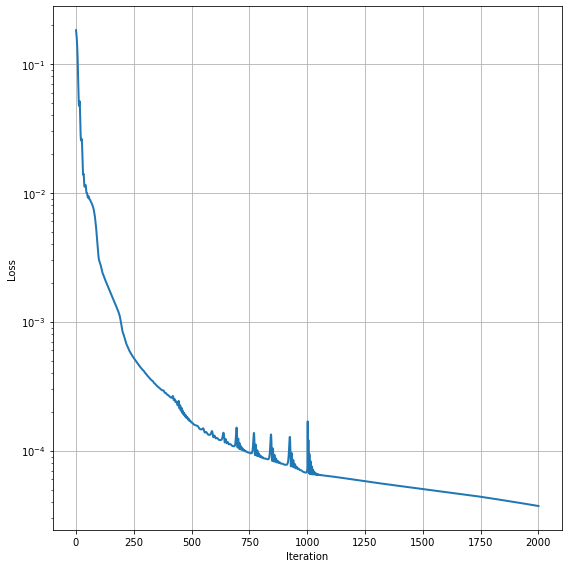

In [48]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Loss = 3.7236197e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<44:54,  2.70s/it]

New min loss =  3.7236197e-05


Loss = 3.715254e-05:   5%|███████▏                                                                                                                                                 | 47/1000 [01:25<25:44,  1.62s/it]

New min loss =  3.715254e-05


Loss = 3.705862e-05:   5%|███████▊                                                                                                                                                 | 51/1000 [01:35<35:29,  2.24s/it]

New min loss =  3.705862e-05


Loss = 3.700742e-05:   6%|████████▍                                                                                                                                                | 55/1000 [01:44<37:56,  2.41s/it]

New min loss =  3.700742e-05


Loss = 3.69705e-05:   6%|█████████▏                                                                                                                                                | 60/1000 [01:55<37:37,  2.40s/it]

New min loss =  3.69705e-05


Loss = 3.6958056e-05:   6%|█████████▌                                                                                                                                              | 63/1000 [02:03<40:02,  2.56s/it]

New min loss =  3.6958056e-05


Loss = 3.6947684e-05:   6%|█████████▋                                                                                                                                              | 64/1000 [02:06<40:45,  2.61s/it]

New min loss =  3.6947684e-05


Loss = 3.6903657e-05:   7%|██████████▎                                                                                                                                             | 68/1000 [02:15<35:44,  2.30s/it]

New min loss =  3.6903657e-05


Loss = 3.6864512e-05:   7%|██████████▉                                                                                                                                             | 72/1000 [02:30<51:39,  3.34s/it]

New min loss =  3.6864512e-05


Loss = 3.685984e-05:   8%|███████████▍                                                                                                                                             | 75/1000 [02:40<49:54,  3.24s/it]

New min loss =  3.685984e-05


Loss = 3.6834423e-05:   8%|███████████▌                                                                                                                                            | 76/1000 [02:43<49:49,  3.24s/it]

New min loss =  3.6834423e-05


Loss = 3.6818223e-05:   8%|████████████▏                                                                                                                                           | 80/1000 [02:53<37:58,  2.48s/it]

New min loss =  3.6818223e-05


Loss = 3.681221e-05:   8%|████████████▍                                                                                                                                            | 81/1000 [02:56<41:23,  2.70s/it]

New min loss =  3.681221e-05


Loss = 3.6799658e-05:   8%|████████████▌                                                                                                                                           | 83/1000 [03:03<44:52,  2.94s/it]

New min loss =  3.6799658e-05


Loss = 3.6783047e-05:   8%|████████████▊                                                                                                                                           | 84/1000 [03:06<46:59,  3.08s/it]

New min loss =  3.6783047e-05


Loss = 3.6779173e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:13<49:07,  3.22s/it]

New min loss =  3.6779173e-05


Loss = 3.6760353e-05:   9%|█████████████▏                                                                                                                                          | 87/1000 [03:16<48:48,  3.21s/it]

New min loss =  3.6760353e-05


Loss = 3.6753456e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [03:19<49:27,  3.25s/it]

New min loss =  3.6753456e-05


Loss = 3.6753107e-05:   9%|█████████████▌                                                                                                                                          | 89/1000 [03:23<50:26,  3.32s/it]

New min loss =  3.6753107e-05


Loss = 3.6739617e-05:   9%|█████████████▋                                                                                                                                          | 90/1000 [03:26<49:32,  3.27s/it]

New min loss =  3.6739617e-05


Loss = 3.6726986e-05:   9%|█████████████▊                                                                                                                                          | 91/1000 [03:29<49:06,  3.24s/it]

New min loss =  3.6726986e-05


Loss = 3.6724556e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:33<37:57,  2.51s/it]

New min loss =  3.6724556e-05


Loss = 3.6716996e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:36<40:31,  2.68s/it]

New min loss =  3.6716996e-05


Loss = 3.670398e-05:  10%|██████████████▌                                                                                                                                          | 95/1000 [03:39<44:07,  2.93s/it]

New min loss =  3.670398e-05


Loss = 3.6697133e-05:  10%|██████████████▌                                                                                                                                         | 96/1000 [03:43<46:48,  3.11s/it]

New min loss =  3.6697133e-05


Loss = 3.669183e-05:  10%|██████████████▊                                                                                                                                          | 97/1000 [03:47<49:33,  3.29s/it]

New min loss =  3.669183e-05


Loss = 3.6680605e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [03:50<48:36,  3.23s/it]

New min loss =  3.6680605e-05


Loss = 3.6671318e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:53<49:22,  3.29s/it]

New min loss =  3.6671318e-05


Loss = 3.666622e-05:  10%|███████████████▏                                                                                                                                        | 100/1000 [03:57<49:25,  3.30s/it]

New min loss =  3.666622e-05


Loss = 3.665678e-05:  10%|███████████████▎                                                                                                                                        | 101/1000 [04:00<48:31,  3.24s/it]

New min loss =  3.665678e-05


Loss = 3.6646186e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [04:03<48:52,  3.27s/it]

New min loss =  3.6646186e-05


Loss = 3.6640155e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [04:06<45:33,  3.05s/it]

New min loss =  3.6640155e-05


Loss = 3.663233e-05:  10%|███████████████▊                                                                                                                                        | 104/1000 [04:08<42:50,  2.87s/it]

New min loss =  3.663233e-05


Loss = 3.6621634e-05:  10%|███████████████▊                                                                                                                                       | 105/1000 [04:11<42:14,  2.83s/it]

New min loss =  3.6621634e-05


Loss = 3.6613863e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [04:13<32:01,  2.15s/it]

New min loss =  3.6613863e-05


Loss = 3.660693e-05:  11%|████████████████▍                                                                                                                                       | 108/1000 [04:16<34:06,  2.29s/it]

New min loss =  3.660693e-05


Loss = 3.6597266e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [04:19<34:51,  2.35s/it]

New min loss =  3.6597266e-05


Loss = 3.658819e-05:  11%|████████████████▋                                                                                                                                       | 110/1000 [04:21<35:48,  2.41s/it]

New min loss =  3.658819e-05


Loss = 3.658092e-05:  11%|████████████████▊                                                                                                                                       | 111/1000 [04:24<37:14,  2.51s/it]

New min loss =  3.658092e-05


Loss = 3.6572033e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:27<37:49,  2.56s/it]

New min loss =  3.6572033e-05


Loss = 3.6562706e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:29<37:40,  2.55s/it]

New min loss =  3.6562706e-05


Loss = 3.655491e-05:  11%|█████████████████▎                                                                                                                                      | 114/1000 [04:32<37:18,  2.53s/it]

New min loss =  3.655491e-05


Loss = 3.6546237e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [04:34<38:25,  2.61s/it]

New min loss =  3.6546237e-05


Loss = 3.6536978e-05:  12%|█████████████████▌                                                                                                                                     | 116/1000 [04:37<38:51,  2.64s/it]

New min loss =  3.6536978e-05


Loss = 3.6528796e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [04:40<38:38,  2.63s/it]

New min loss =  3.6528796e-05


Loss = 3.6520232e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [04:42<37:07,  2.53s/it]

New min loss =  3.6520232e-05


Loss = 3.6510963e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:45<37:50,  2.58s/it]

New min loss =  3.6510963e-05


Loss = 3.6502413e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [04:47<38:25,  2.62s/it]

New min loss =  3.6502413e-05


Loss = 3.649394e-05:  12%|██████████████████▌                                                                                                                                     | 122/1000 [04:50<29:48,  2.04s/it]

New min loss =  3.649394e-05


Loss = 3.6484733e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:53<31:09,  2.13s/it]

New min loss =  3.6484733e-05


Loss = 3.6475903e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [04:55<32:58,  2.26s/it]

New min loss =  3.6475903e-05


Loss = 3.646733e-05:  12%|███████████████████                                                                                                                                     | 125/1000 [04:58<33:50,  2.32s/it]

New min loss =  3.646733e-05


Loss = 3.6458154e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [05:00<34:34,  2.37s/it]

New min loss =  3.6458154e-05


Loss = 3.6449183e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:03<36:08,  2.48s/it]

New min loss =  3.6449183e-05


Loss = 3.6440455e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [05:05<35:27,  2.44s/it]

New min loss =  3.6440455e-05


Loss = 3.6431316e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [05:08<35:58,  2.48s/it]

New min loss =  3.6431316e-05


Loss = 3.642224e-05:  13%|███████████████████▊                                                                                                                                    | 130/1000 [05:11<37:27,  2.58s/it]

New min loss =  3.642224e-05


Loss = 3.641336e-05:  13%|███████████████████▉                                                                                                                                    | 131/1000 [05:13<37:30,  2.59s/it]

New min loss =  3.641336e-05


Loss = 3.6404173e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:16<37:01,  2.56s/it]

New min loss =  3.6404173e-05


Loss = 3.639498e-05:  13%|████████████████████▏                                                                                                                                   | 133/1000 [05:19<37:28,  2.59s/it]

New min loss =  3.639498e-05


Loss = 3.6385984e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [05:21<38:29,  2.67s/it]

New min loss =  3.6385984e-05


Loss = 3.637675e-05:  14%|████████████████████▌                                                                                                                                   | 135/1000 [05:24<38:02,  2.64s/it]

New min loss =  3.637675e-05


Loss = 3.6367463e-05:  14%|████████████████████▌                                                                                                                                  | 136/1000 [05:26<36:17,  2.52s/it]

New min loss =  3.6367463e-05


Loss = 3.635834e-05:  14%|████████████████████▉                                                                                                                                   | 138/1000 [05:29<27:37,  1.92s/it]

New min loss =  3.635834e-05


Loss = 3.6349058e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [05:31<30:06,  2.10s/it]

New min loss =  3.6349058e-05


Loss = 3.6339705e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:34<31:41,  2.21s/it]

New min loss =  3.6339705e-05


Loss = 3.6330468e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [05:36<33:40,  2.35s/it]

New min loss =  3.6330468e-05


Loss = 3.6321126e-05:  14%|█████████████████████▍                                                                                                                                 | 142/1000 [05:39<34:20,  2.40s/it]

New min loss =  3.6321126e-05


Loss = 3.6311692e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [05:42<34:47,  2.44s/it]

New min loss =  3.6311692e-05


Loss = 3.6302354e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [05:44<36:14,  2.54s/it]

New min loss =  3.6302354e-05


Loss = 3.629289e-05:  14%|██████████████████████                                                                                                                                  | 145/1000 [05:47<36:47,  2.58s/it]

New min loss =  3.629289e-05


Loss = 3.628342e-05:  15%|██████████████████████▏                                                                                                                                 | 146/1000 [05:49<36:11,  2.54s/it]

New min loss =  3.628342e-05


Loss = 3.6273952e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [05:52<36:03,  2.54s/it]

New min loss =  3.6273952e-05


Loss = 3.6264442e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [05:55<36:30,  2.57s/it]

New min loss =  3.6264442e-05


Loss = 3.625486e-05:  15%|██████████████████████▋                                                                                                                                 | 149/1000 [05:57<36:16,  2.56s/it]

New min loss =  3.625486e-05


Loss = 3.62453e-05:  15%|██████████████████████▉                                                                                                                                  | 150/1000 [06:00<37:49,  2.67s/it]

New min loss =  3.62453e-05


Loss = 3.6235677e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [06:03<38:28,  2.72s/it]

New min loss =  3.6235677e-05


Loss = 3.622599e-05:  15%|███████████████████████                                                                                                                                 | 152/1000 [06:06<38:42,  2.74s/it]

New min loss =  3.622599e-05


Loss = 3.621632e-05:  15%|███████████████████████▎                                                                                                                                | 153/1000 [06:08<37:21,  2.65s/it]

New min loss =  3.621632e-05


Loss = 3.6206584e-05:  16%|███████████████████████▍                                                                                                                               | 155/1000 [06:11<28:44,  2.04s/it]

New min loss =  3.6206584e-05


Loss = 3.619681e-05:  16%|███████████████████████▋                                                                                                                                | 156/1000 [06:13<30:42,  2.18s/it]

New min loss =  3.619681e-05


Loss = 3.618706e-05:  16%|███████████████████████▊                                                                                                                                | 157/1000 [06:16<32:58,  2.35s/it]

New min loss =  3.618706e-05


Loss = 3.6177244e-05:  16%|███████████████████████▊                                                                                                                               | 158/1000 [06:19<34:19,  2.45s/it]

New min loss =  3.6177244e-05


Loss = 3.616741e-05:  16%|████████████████████████▏                                                                                                                               | 159/1000 [06:22<34:40,  2.47s/it]

New min loss =  3.616741e-05


Loss = 3.6157566e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [06:24<34:55,  2.49s/it]

New min loss =  3.6157566e-05


Loss = 3.614766e-05:  16%|████████████████████████▍                                                                                                                               | 161/1000 [06:27<35:23,  2.53s/it]

New min loss =  3.614766e-05


Loss = 3.613773e-05:  16%|████████████████████████▌                                                                                                                               | 162/1000 [06:29<35:26,  2.54s/it]

New min loss =  3.613773e-05


Loss = 3.61278e-05:  16%|████████████████████████▉                                                                                                                                | 163/1000 [06:32<36:33,  2.62s/it]

New min loss =  3.61278e-05


Loss = 3.6117788e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:35<35:52,  2.57s/it]

New min loss =  3.6117788e-05


Loss = 3.6107784e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [06:37<35:17,  2.54s/it]

New min loss =  3.6107784e-05


Loss = 3.6097725e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [06:40<36:00,  2.59s/it]

New min loss =  3.6097725e-05


Loss = 3.6087637e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [06:42<35:27,  2.55s/it]

New min loss =  3.6087637e-05


Loss = 3.6077534e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [06:45<34:54,  2.52s/it]

New min loss =  3.6077534e-05


Loss = 3.606738e-05:  17%|█████████████████████████▋                                                                                                                              | 169/1000 [06:47<35:13,  2.54s/it]

New min loss =  3.606738e-05


Loss = 3.6057198e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [06:50<35:16,  2.55s/it]

New min loss =  3.6057198e-05


Loss = 3.604701e-05:  17%|█████████████████████████▉                                                                                                                              | 171/1000 [06:52<35:25,  2.56s/it]

New min loss =  3.604701e-05


Loss = 3.6036785e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [06:55<26:49,  1.95s/it]

New min loss =  3.6036785e-05


Loss = 3.6026537e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [06:58<29:47,  2.16s/it]

New min loss =  3.6026537e-05


Loss = 3.6016256e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [07:00<30:43,  2.23s/it]

New min loss =  3.6016256e-05


Loss = 3.6005946e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:03<32:50,  2.39s/it]

New min loss =  3.6005946e-05


Loss = 3.599562e-05:  18%|██████████████████████████▉                                                                                                                             | 177/1000 [07:05<33:31,  2.44s/it]

New min loss =  3.599562e-05


Loss = 3.598527e-05:  18%|███████████████████████████                                                                                                                             | 178/1000 [07:08<33:55,  2.48s/it]

New min loss =  3.598527e-05


Loss = 3.597489e-05:  18%|███████████████████████████▏                                                                                                                            | 179/1000 [07:11<34:27,  2.52s/it]

New min loss =  3.597489e-05


Loss = 3.5964506e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [07:13<33:59,  2.49s/it]

New min loss =  3.5964506e-05


Loss = 3.5954086e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [07:16<33:55,  2.48s/it]

New min loss =  3.5954086e-05


Loss = 3.5943645e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [07:18<34:07,  2.50s/it]

New min loss =  3.5943645e-05


Loss = 3.5933157e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [07:21<35:21,  2.60s/it]

New min loss =  3.5933157e-05


Loss = 3.5922654e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [07:23<35:19,  2.60s/it]

New min loss =  3.5922654e-05


Loss = 3.5912137e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [07:26<34:21,  2.53s/it]

New min loss =  3.5912137e-05


Loss = 3.5901554e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [07:28<34:43,  2.56s/it]

New min loss =  3.5901554e-05


Loss = 3.589096e-05:  19%|████████████████████████████▍                                                                                                                           | 187/1000 [07:31<34:27,  2.54s/it]

New min loss =  3.589096e-05


Loss = 3.588035e-05:  19%|████████████████████████████▌                                                                                                                           | 188/1000 [07:34<34:30,  2.55s/it]

New min loss =  3.588035e-05


Loss = 3.58697e-05:  19%|████████████████████████████▉                                                                                                                            | 189/1000 [07:36<34:52,  2.58s/it]

New min loss =  3.58697e-05


Loss = 3.5859037e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [07:39<33:44,  2.50s/it]

New min loss =  3.5859037e-05


Loss = 3.5848327e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [07:41<26:03,  1.94s/it]

New min loss =  3.5848327e-05


Loss = 3.583759e-05:  19%|█████████████████████████████▎                                                                                                                          | 193/1000 [07:44<27:43,  2.06s/it]

New min loss =  3.583759e-05


Loss = 3.582686e-05:  19%|█████████████████████████████▍                                                                                                                          | 194/1000 [07:46<29:56,  2.23s/it]

New min loss =  3.582686e-05


Loss = 3.5816087e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [07:49<32:30,  2.42s/it]

New min loss =  3.5816087e-05


Loss = 3.5805275e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [07:52<32:49,  2.45s/it]

New min loss =  3.5805275e-05


Loss = 3.579445e-05:  20%|█████████████████████████████▉                                                                                                                          | 197/1000 [07:54<33:58,  2.54s/it]

New min loss =  3.579445e-05


Loss = 3.578359e-05:  20%|██████████████████████████████                                                                                                                          | 198/1000 [07:57<35:40,  2.67s/it]

New min loss =  3.578359e-05


Loss = 3.5772704e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [08:01<37:41,  2.82s/it]

New min loss =  3.5772704e-05


Loss = 3.576179e-05:  20%|██████████████████████████████▍                                                                                                                         | 200/1000 [08:04<38:53,  2.92s/it]

New min loss =  3.576179e-05


Loss = 3.5750865e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [08:07<40:40,  3.05s/it]

New min loss =  3.5750865e-05


Loss = 3.57399e-05:  20%|██████████████████████████████▉                                                                                                                          | 202/1000 [08:11<42:22,  3.19s/it]

New min loss =  3.57399e-05


Loss = 3.5728917e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [08:14<43:53,  3.30s/it]

New min loss =  3.5728917e-05


Loss = 3.5717945e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [08:18<44:09,  3.33s/it]

New min loss =  3.5717945e-05


Loss = 3.5706933e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [08:21<43:54,  3.31s/it]

New min loss =  3.5706933e-05


Loss = 3.5695888e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [08:24<43:16,  3.27s/it]

New min loss =  3.5695888e-05


Loss = 3.5684832e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [08:28<43:58,  3.33s/it]

New min loss =  3.5684832e-05


Loss = 3.5673726e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [08:31<45:02,  3.41s/it]

New min loss =  3.5673726e-05


Loss = 3.566262e-05:  21%|███████████████████████████████▊                                                                                                                        | 209/1000 [08:35<45:14,  3.43s/it]

New min loss =  3.566262e-05


Loss = 3.5651483e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [08:37<43:05,  3.27s/it]

New min loss =  3.5651483e-05


Loss = 3.564033e-05:  21%|████████████████████████████████▏                                                                                                                       | 212/1000 [08:41<33:14,  2.53s/it]

New min loss =  3.564033e-05


Loss = 3.5629106e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [08:44<34:47,  2.65s/it]

New min loss =  3.5629106e-05


Loss = 3.5617893e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [08:47<36:44,  2.80s/it]

New min loss =  3.5617893e-05


Loss = 3.560667e-05:  22%|████████████████████████████████▋                                                                                                                       | 215/1000 [08:51<39:00,  2.98s/it]

New min loss =  3.560667e-05


Loss = 3.559542e-05:  22%|████████████████████████████████▊                                                                                                                       | 216/1000 [08:54<39:20,  3.01s/it]

New min loss =  3.559542e-05


Loss = 3.558414e-05:  22%|████████████████████████████████▉                                                                                                                       | 217/1000 [08:57<39:24,  3.02s/it]

New min loss =  3.558414e-05


Loss = 3.5572823e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [09:00<41:53,  3.21s/it]

New min loss =  3.5572823e-05


Loss = 3.556151e-05:  22%|█████████████████████████████████▎                                                                                                                      | 219/1000 [09:04<44:03,  3.39s/it]

New min loss =  3.556151e-05


Loss = 3.5550176e-05:  22%|█████████████████████████████████▏                                                                                                                     | 220/1000 [09:08<45:22,  3.49s/it]

New min loss =  3.5550176e-05


Loss = 3.5538807e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [09:11<45:31,  3.51s/it]

New min loss =  3.5538807e-05


Loss = 3.5527424e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [09:15<45:21,  3.50s/it]

New min loss =  3.5527424e-05


Loss = 3.5516034e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [09:19<46:06,  3.56s/it]

New min loss =  3.5516034e-05


Loss = 3.5504614e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [09:22<46:37,  3.61s/it]

New min loss =  3.5504614e-05


Loss = 3.5493176e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [09:26<47:00,  3.64s/it]

New min loss =  3.5493176e-05


Loss = 3.5481724e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [09:30<47:28,  3.68s/it]

New min loss =  3.5481724e-05


Loss = 3.5470224e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [09:33<47:06,  3.66s/it]

New min loss =  3.5470224e-05


Loss = 3.5458732e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [09:37<46:24,  3.61s/it]

New min loss =  3.5458732e-05


Loss = 3.5447218e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [09:40<45:49,  3.57s/it]

New min loss =  3.5447218e-05


Loss = 3.5435678e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [09:44<45:47,  3.57s/it]

New min loss =  3.5435678e-05


Loss = 3.5424124e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [09:48<46:31,  3.63s/it]

New min loss =  3.5424124e-05


Loss = 3.541255e-05:  23%|███████████████████████████████████▍                                                                                                                    | 233/1000 [09:51<35:08,  2.75s/it]

New min loss =  3.541255e-05


Loss = 3.5400968e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [09:55<37:46,  2.96s/it]

New min loss =  3.5400968e-05


Loss = 3.538936e-05:  24%|███████████████████████████████████▋                                                                                                                    | 235/1000 [09:58<39:48,  3.12s/it]

New min loss =  3.538936e-05


Loss = 3.5377725e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [10:02<41:39,  3.27s/it]

New min loss =  3.5377725e-05


Loss = 3.5366076e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [10:06<42:44,  3.36s/it]

New min loss =  3.5366076e-05


Loss = 3.535441e-05:  24%|████████████████████████████████████▏                                                                                                                   | 238/1000 [10:09<42:41,  3.36s/it]

New min loss =  3.535441e-05


Loss = 3.534271e-05:  24%|████████████████████████████████████▎                                                                                                                   | 239/1000 [10:13<43:55,  3.46s/it]

New min loss =  3.534271e-05


Loss = 3.533098e-05:  24%|████████████████████████████████████▍                                                                                                                   | 240/1000 [10:17<45:15,  3.57s/it]

New min loss =  3.533098e-05


Loss = 3.5319244e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [10:20<45:15,  3.58s/it]

New min loss =  3.5319244e-05


Loss = 3.5307487e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [10:24<45:47,  3.63s/it]

New min loss =  3.5307487e-05


Loss = 3.529569e-05:  24%|████████████████████████████████████▉                                                                                                                   | 243/1000 [10:27<45:26,  3.60s/it]

New min loss =  3.529569e-05


Loss = 3.5283898e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [10:31<45:42,  3.63s/it]

New min loss =  3.5283898e-05


Loss = 3.5272078e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [10:35<45:48,  3.64s/it]

New min loss =  3.5272078e-05


Loss = 3.5260226e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [10:38<45:01,  3.58s/it]

New min loss =  3.5260226e-05


Loss = 3.5248377e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [10:42<45:18,  3.61s/it]

New min loss =  3.5248377e-05


Loss = 3.5236506e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [10:45<44:37,  3.56s/it]

New min loss =  3.5236506e-05


Loss = 3.522461e-05:  25%|█████████████████████████████████████▊                                                                                                                  | 249/1000 [10:49<44:35,  3.56s/it]

New min loss =  3.522461e-05


Loss = 3.5212706e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [10:52<44:09,  3.53s/it]

New min loss =  3.5212706e-05


Loss = 3.520078e-05:  25%|██████████████████████████████████████▏                                                                                                                 | 251/1000 [10:56<44:07,  3.54s/it]

New min loss =  3.520078e-05


Loss = 3.5188838e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [11:00<46:19,  3.72s/it]

New min loss =  3.5188838e-05


Loss = 3.5176843e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [11:04<45:34,  3.66s/it]

New min loss =  3.5176843e-05


Loss = 3.5164874e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [11:07<33:52,  2.73s/it]

New min loss =  3.5164874e-05


Loss = 3.5152865e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [11:10<36:13,  2.92s/it]

New min loss =  3.5152865e-05


Loss = 3.5140823e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [11:14<38:07,  3.08s/it]

New min loss =  3.5140823e-05


Loss = 3.5128778e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [11:17<39:18,  3.18s/it]

New min loss =  3.5128778e-05


Loss = 3.5116707e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [11:21<40:53,  3.31s/it]

New min loss =  3.5116707e-05


Loss = 3.5104604e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [11:25<42:15,  3.43s/it]

New min loss =  3.5104604e-05


Loss = 3.5092486e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [11:28<42:31,  3.45s/it]

New min loss =  3.5092486e-05


Loss = 3.5080353e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [11:32<43:17,  3.52s/it]

New min loss =  3.5080353e-05


Loss = 3.506821e-05:  26%|███████████████████████████████████████▉                                                                                                                | 263/1000 [11:35<43:06,  3.51s/it]

New min loss =  3.506821e-05


Loss = 3.5056062e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [11:39<42:55,  3.50s/it]

New min loss =  3.5056062e-05


Loss = 3.5043882e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [11:42<43:11,  3.53s/it]

New min loss =  3.5043882e-05


Loss = 3.5031688e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [11:46<42:44,  3.49s/it]

New min loss =  3.5031688e-05


Loss = 3.501948e-05:  27%|████████████████████████████████████████▌                                                                                                               | 267/1000 [11:49<42:17,  3.46s/it]

New min loss =  3.501948e-05


Loss = 3.5007244e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [11:53<42:38,  3.50s/it]

New min loss =  3.5007244e-05


Loss = 3.4994995e-05:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [11:57<44:14,  3.63s/it]

New min loss =  3.4994995e-05


Loss = 3.4982728e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [12:01<44:37,  3.67s/it]

New min loss =  3.4982728e-05


Loss = 3.4970428e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [12:04<44:34,  3.67s/it]

New min loss =  3.4970428e-05


Loss = 3.4958113e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [12:07<42:55,  3.54s/it]

New min loss =  3.4958113e-05


Loss = 3.494579e-05:  27%|█████████████████████████████████████████▍                                                                                                              | 273/1000 [12:11<43:19,  3.58s/it]

New min loss =  3.494579e-05


Loss = 3.4933437e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [12:15<43:35,  3.60s/it]

New min loss =  3.4933437e-05


Loss = 3.492107e-05:  28%|█████████████████████████████████████████▊                                                                                                              | 275/1000 [12:19<44:01,  3.64s/it]

New min loss =  3.492107e-05


Loss = 3.490867e-05:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [12:22<44:29,  3.69s/it]

New min loss =  3.490867e-05


Loss = 3.4896253e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [12:26<33:11,  2.76s/it]

New min loss =  3.4896253e-05


Loss = 3.4883826e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [12:29<35:11,  2.93s/it]

New min loss =  3.4883826e-05


Loss = 3.4871362e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [12:33<37:19,  3.11s/it]

New min loss =  3.4871362e-05


Loss = 3.4858902e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [12:36<39:16,  3.28s/it]

New min loss =  3.4858902e-05


Loss = 3.4846395e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [12:40<41:14,  3.45s/it]

New min loss =  3.4846395e-05


Loss = 3.4833894e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [12:44<42:14,  3.53s/it]

New min loss =  3.4833894e-05


Loss = 3.482135e-05:  28%|███████████████████████████████████████████▏                                                                                                            | 284/1000 [12:47<41:46,  3.50s/it]

New min loss =  3.482135e-05


Loss = 3.480879e-05:  28%|███████████████████████████████████████████▎                                                                                                            | 285/1000 [12:51<41:50,  3.51s/it]

New min loss =  3.480879e-05


Loss = 3.4796216e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [12:55<41:48,  3.51s/it]

New min loss =  3.4796216e-05


Loss = 3.478363e-05:  29%|███████████████████████████████████████████▌                                                                                                            | 287/1000 [12:58<43:08,  3.63s/it]

New min loss =  3.478363e-05


Loss = 3.477102e-05:  29%|███████████████████████████████████████████▊                                                                                                            | 288/1000 [13:02<43:18,  3.65s/it]

New min loss =  3.477102e-05


Loss = 3.475841e-05:  29%|███████████████████████████████████████████▉                                                                                                            | 289/1000 [13:06<42:58,  3.63s/it]

New min loss =  3.475841e-05


Loss = 3.4745768e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [13:09<42:14,  3.57s/it]

New min loss =  3.4745768e-05


Loss = 3.47331e-05:  29%|████████████████████████████████████████████▌                                                                                                            | 291/1000 [13:13<43:31,  3.68s/it]

New min loss =  3.47331e-05


Loss = 3.472039e-05:  29%|████████████████████████████████████████████▍                                                                                                           | 292/1000 [13:17<44:30,  3.77s/it]

New min loss =  3.472039e-05


Loss = 3.470769e-05:  29%|████████████████████████████████████████████▌                                                                                                           | 293/1000 [13:21<44:08,  3.75s/it]

New min loss =  3.470769e-05


Loss = 3.469498e-05:  29%|████████████████████████████████████████████▋                                                                                                           | 294/1000 [13:25<44:11,  3.76s/it]

New min loss =  3.469498e-05


Loss = 3.468223e-05:  30%|████████████████████████████████████████████▊                                                                                                           | 295/1000 [13:29<45:11,  3.85s/it]

New min loss =  3.468223e-05


Loss = 3.4669454e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [13:32<45:02,  3.84s/it]

New min loss =  3.4669454e-05


Loss = 3.4656652e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [13:36<44:01,  3.76s/it]

New min loss =  3.4656652e-05


Loss = 3.464382e-05:  30%|█████████████████████████████████████████████▎                                                                                                          | 298/1000 [13:40<44:06,  3.77s/it]

New min loss =  3.464382e-05


Loss = 3.463097e-05:  30%|█████████████████████████████████████████████▍                                                                                                          | 299/1000 [13:43<43:15,  3.70s/it]

New min loss =  3.463097e-05


Loss = 3.46181e-05:  30%|█████████████████████████████████████████████▉                                                                                                           | 300/1000 [13:47<43:38,  3.74s/it]

New min loss =  3.46181e-05


Loss = 3.4605207e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [13:51<33:46,  2.90s/it]

New min loss =  3.4605207e-05


Loss = 3.459231e-05:  30%|██████████████████████████████████████████████                                                                                                          | 303/1000 [13:55<37:50,  3.26s/it]

New min loss =  3.459231e-05


Loss = 3.457939e-05:  30%|██████████████████████████████████████████████▏                                                                                                         | 304/1000 [14:00<40:42,  3.51s/it]

New min loss =  3.457939e-05


Loss = 3.456648e-05:  30%|██████████████████████████████████████████████▎                                                                                                         | 305/1000 [14:03<41:15,  3.56s/it]

New min loss =  3.456648e-05


Loss = 3.4553508e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [14:07<42:00,  3.63s/it]

New min loss =  3.4553508e-05


Loss = 3.454054e-05:  31%|██████████████████████████████████████████████▋                                                                                                         | 307/1000 [14:11<42:54,  3.71s/it]

New min loss =  3.454054e-05


Loss = 3.4527566e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [14:15<43:00,  3.73s/it]

New min loss =  3.4527566e-05


Loss = 3.4514564e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [14:18<42:33,  3.70s/it]

New min loss =  3.4514564e-05


Loss = 3.4501554e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [14:22<41:46,  3.63s/it]

New min loss =  3.4501554e-05


Loss = 3.4488497e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [14:25<41:20,  3.60s/it]

New min loss =  3.4488497e-05


Loss = 3.4475463e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [14:29<41:38,  3.63s/it]

New min loss =  3.4475463e-05


Loss = 3.4462373e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [14:33<41:38,  3.64s/it]

New min loss =  3.4462373e-05


Loss = 3.44493e-05:  31%|████████████████████████████████████████████████                                                                                                         | 314/1000 [14:36<40:20,  3.53s/it]

New min loss =  3.44493e-05


Loss = 3.443619e-05:  32%|███████████████████████████████████████████████▉                                                                                                        | 315/1000 [14:40<40:49,  3.58s/it]

New min loss =  3.443619e-05


Loss = 3.442311e-05:  32%|████████████████████████████████████████████████                                                                                                        | 316/1000 [14:43<40:43,  3.57s/it]

New min loss =  3.442311e-05


Loss = 3.441e-05:  32%|█████████████████████████████████████████████████▏                                                                                                         | 317/1000 [14:47<40:27,  3.55s/it]

New min loss =  3.441e-05


Loss = 3.4396864e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [14:50<40:44,  3.58s/it]

New min loss =  3.4396864e-05


Loss = 3.4383727e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [14:54<40:34,  3.57s/it]

New min loss =  3.4383727e-05


Loss = 3.4370583e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [14:58<40:47,  3.60s/it]

New min loss =  3.4370583e-05


Loss = 3.435742e-05:  32%|████████████████████████████████████████████████▊                                                                                                       | 321/1000 [15:01<40:40,  3.59s/it]

New min loss =  3.435742e-05


Loss = 3.434428e-05:  32%|████████████████████████████████████████████████▉                                                                                                       | 322/1000 [15:05<41:15,  3.65s/it]

New min loss =  3.434428e-05


Loss = 3.4331093e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [15:09<41:44,  3.70s/it]

New min loss =  3.4331093e-05


Loss = 3.4317924e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [15:13<41:39,  3.70s/it]

New min loss =  3.4317924e-05


Loss = 3.430472e-05:  32%|█████████████████████████████████████████████████▍                                                                                                      | 325/1000 [15:16<41:19,  3.67s/it]

New min loss =  3.430472e-05


Loss = 3.4291512e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [15:20<31:29,  2.81s/it]

New min loss =  3.4291512e-05


Loss = 3.4278284e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [15:24<34:07,  3.05s/it]

New min loss =  3.4278284e-05


Loss = 3.4265056e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [15:27<36:05,  3.23s/it]

New min loss =  3.4265056e-05


Loss = 3.4251792e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [15:31<37:53,  3.39s/it]

New min loss =  3.4251792e-05


Loss = 3.4238536e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [15:35<38:27,  3.45s/it]

New min loss =  3.4238536e-05


Loss = 3.422527e-05:  33%|██████████████████████████████████████████████████▍                                                                                                     | 332/1000 [15:38<38:20,  3.44s/it]

New min loss =  3.422527e-05


Loss = 3.4212004e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [15:42<38:33,  3.47s/it]

New min loss =  3.4212004e-05


Loss = 3.419872e-05:  33%|██████████████████████████████████████████████████▊                                                                                                     | 334/1000 [15:45<38:30,  3.47s/it]

New min loss =  3.419872e-05


Loss = 3.418545e-05:  34%|██████████████████████████████████████████████████▉                                                                                                     | 335/1000 [15:49<39:36,  3.57s/it]

New min loss =  3.418545e-05


Loss = 3.4172168e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [15:53<39:41,  3.59s/it]

New min loss =  3.4172168e-05


Loss = 3.4158857e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [15:56<39:50,  3.61s/it]

New min loss =  3.4158857e-05


Loss = 3.4145545e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [16:00<39:40,  3.60s/it]

New min loss =  3.4145545e-05


Loss = 3.4132237e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [16:04<40:36,  3.69s/it]

New min loss =  3.4132237e-05


Loss = 3.4118926e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [16:07<40:10,  3.65s/it]

New min loss =  3.4118926e-05


Loss = 3.4105604e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [16:11<40:28,  3.69s/it]

New min loss =  3.4105604e-05


Loss = 3.4092285e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [16:15<40:33,  3.70s/it]

New min loss =  3.4092285e-05


Loss = 3.4078952e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [16:18<39:43,  3.63s/it]

New min loss =  3.4078952e-05


Loss = 3.4065622e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [16:22<39:12,  3.59s/it]

New min loss =  3.4065622e-05


Loss = 3.4052275e-05:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [16:25<39:15,  3.60s/it]

New min loss =  3.4052275e-05


Loss = 3.40389e-05:  35%|████████████████████████████████████████████████████▉                                                                                                    | 346/1000 [16:29<39:21,  3.61s/it]

New min loss =  3.40389e-05


Loss = 3.4025514e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [16:33<39:24,  3.62s/it]

New min loss =  3.4025514e-05


Loss = 3.4012115e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [16:36<39:40,  3.65s/it]

New min loss =  3.4012115e-05


Loss = 3.3998702e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [16:40<39:08,  3.61s/it]

New min loss =  3.3998702e-05


Loss = 3.3985274e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [16:43<38:12,  3.53s/it]

New min loss =  3.3985274e-05


Loss = 3.3971828e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [16:47<39:16,  3.63s/it]

New min loss =  3.3971828e-05


Loss = 3.3958386e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [16:51<30:48,  2.86s/it]

New min loss =  3.3958386e-05


Loss = 3.394492e-05:  35%|█████████████████████████████████████████████████████▊                                                                                                  | 354/1000 [16:55<33:32,  3.12s/it]

New min loss =  3.394492e-05


Loss = 3.393142e-05:  36%|█████████████████████████████████████████████████████▉                                                                                                  | 355/1000 [16:58<34:26,  3.20s/it]

New min loss =  3.393142e-05


Loss = 3.3917913e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [17:02<35:51,  3.34s/it]

New min loss =  3.3917913e-05


Loss = 3.39044e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                  | 357/1000 [17:06<37:17,  3.48s/it]

New min loss =  3.39044e-05


Loss = 3.3890872e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [17:10<37:59,  3.55s/it]

New min loss =  3.3890872e-05


Loss = 3.3877343e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [17:13<38:04,  3.56s/it]

New min loss =  3.3877343e-05


Loss = 3.3863787e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [17:17<38:37,  3.62s/it]

New min loss =  3.3863787e-05


Loss = 3.385023e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                 | 361/1000 [17:21<38:49,  3.65s/it]

New min loss =  3.385023e-05


Loss = 3.3836655e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [17:24<38:53,  3.66s/it]

New min loss =  3.3836655e-05


Loss = 3.38231e-05:  36%|███████████████████████████████████████████████████████▌                                                                                                 | 363/1000 [17:28<39:36,  3.73s/it]

New min loss =  3.38231e-05


Loss = 3.380952e-05:  36%|███████████████████████████████████████████████████████▎                                                                                                | 364/1000 [17:32<39:50,  3.76s/it]

New min loss =  3.380952e-05


Loss = 3.379594e-05:  36%|███████████████████████████████████████████████████████▍                                                                                                | 365/1000 [17:36<39:43,  3.75s/it]

New min loss =  3.379594e-05


Loss = 3.378236e-05:  37%|███████████████████████████████████████████████████████▋                                                                                                | 366/1000 [17:39<38:09,  3.61s/it]

New min loss =  3.378236e-05


Loss = 3.3768774e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [17:43<38:13,  3.62s/it]

New min loss =  3.3768774e-05


Loss = 3.375516e-05:  37%|███████████████████████████████████████████████████████▉                                                                                                | 368/1000 [17:46<38:34,  3.66s/it]

New min loss =  3.375516e-05


Loss = 3.3741544e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [17:50<39:02,  3.71s/it]

New min loss =  3.3741544e-05


Loss = 3.3727938e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [17:54<39:15,  3.74s/it]

New min loss =  3.3727938e-05


Loss = 3.3714314e-05:  37%|████████████████████████████████████████████████████████                                                                                               | 371/1000 [17:58<38:19,  3.66s/it]

New min loss =  3.3714314e-05


Loss = 3.3700686e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [18:01<38:29,  3.68s/it]

New min loss =  3.3700686e-05


Loss = 3.3687036e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [18:05<38:51,  3.72s/it]

New min loss =  3.3687036e-05


Loss = 3.3673383e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [18:09<38:43,  3.71s/it]

New min loss =  3.3673383e-05


Loss = 3.3659722e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [18:13<39:25,  3.79s/it]

New min loss =  3.3659722e-05


Loss = 3.364607e-05:  38%|█████████████████████████████████████████████████████████▏                                                                                              | 376/1000 [18:16<38:07,  3.67s/it]

New min loss =  3.364607e-05


Loss = 3.3632423e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [18:20<37:39,  3.63s/it]

New min loss =  3.3632423e-05


Loss = 3.3618737e-05:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [18:23<37:58,  3.66s/it]

New min loss =  3.3618737e-05


Loss = 3.360502e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                              | 380/1000 [18:27<29:18,  2.84s/it]

New min loss =  3.360502e-05


Loss = 3.3591314e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [18:31<31:46,  3.08s/it]

New min loss =  3.3591314e-05


Loss = 3.3577646e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [18:35<33:22,  3.24s/it]

New min loss =  3.3577646e-05


Loss = 3.3563952e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [18:38<34:18,  3.34s/it]

New min loss =  3.3563952e-05


Loss = 3.3550237e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [18:42<35:18,  3.44s/it]

New min loss =  3.3550237e-05


Loss = 3.353654e-05:  38%|██████████████████████████████████████████████████████████▌                                                                                             | 385/1000 [18:46<36:52,  3.60s/it]

New min loss =  3.353654e-05


Loss = 3.352285e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                             | 386/1000 [18:50<37:48,  3.70s/it]

New min loss =  3.352285e-05


Loss = 3.3509135e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [18:54<40:10,  3.93s/it]

New min loss =  3.3509135e-05


Loss = 3.349542e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                             | 388/1000 [18:58<39:37,  3.89s/it]

New min loss =  3.349542e-05


Loss = 3.3481705e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [19:02<39:27,  3.88s/it]

New min loss =  3.3481705e-05


Loss = 3.346799e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                            | 390/1000 [19:06<39:53,  3.92s/it]

New min loss =  3.346799e-05


Loss = 3.3454264e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [19:10<39:47,  3.92s/it]

New min loss =  3.3454264e-05


Loss = 3.3440585e-05:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [19:14<38:41,  3.82s/it]

New min loss =  3.3440585e-05


Loss = 3.3426957e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [19:18<39:05,  3.86s/it]

New min loss =  3.3426957e-05


Loss = 3.341347e-05:  39%|███████████████████████████████████████████████████████████▉                                                                                            | 394/1000 [19:21<38:48,  3.84s/it]

New min loss =  3.341347e-05


Loss = 3.3400276e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [19:25<37:50,  3.75s/it]

New min loss =  3.3400276e-05


Loss = 3.3387667e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [19:29<37:33,  3.73s/it]

New min loss =  3.3387667e-05


Loss = 3.3376313e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [19:33<39:13,  3.90s/it]

New min loss =  3.3376313e-05


Loss = 3.33675e-05:  40%|████████████████████████████████████████████████████████████▉                                                                                            | 398/1000 [19:37<40:20,  4.02s/it]

New min loss =  3.33675e-05


Loss = 3.3364155e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [19:41<39:18,  3.92s/it]

New min loss =  3.3364155e-05


Loss = 3.324335e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                         | 410/1000 [20:17<30:53,  3.14s/it]

New min loss =  3.324335e-05


Loss = 3.3143675e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [20:35<34:20,  3.52s/it]

New min loss =  3.3143675e-05


Loss = 3.312244e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                        | 419/1000 [20:49<33:57,  3.51s/it]

New min loss =  3.312244e-05


Loss = 3.310943e-05:  42%|████████████████████████████████████████████████████████████████▎                                                                                       | 423/1000 [21:04<34:54,  3.63s/it]

New min loss =  3.310943e-05


Loss = 3.3038526e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [21:08<35:20,  3.68s/it]

New min loss =  3.3038526e-05


Loss = 3.29734e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                       | 428/1000 [21:23<35:51,  3.76s/it]

New min loss =  3.29734e-05


Loss = 3.292903e-05:  43%|█████████████████████████████████████████████████████████████████▋                                                                                      | 432/1000 [21:37<32:57,  3.48s/it]

New min loss =  3.292903e-05


Loss = 3.2890195e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [21:52<26:52,  2.86s/it]

New min loss =  3.2890195e-05


Loss = 3.285954e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 438/1000 [21:56<29:14,  3.12s/it]

New min loss =  3.285954e-05


Loss = 3.2848853e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [22:08<34:11,  3.67s/it]

New min loss =  3.2848853e-05


Loss = 3.280651e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                    | 442/1000 [22:11<33:55,  3.65s/it]

New min loss =  3.280651e-05


Loss = 3.280384e-05:  44%|███████████████████████████████████████████████████████████████████▎                                                                                    | 443/1000 [22:15<33:54,  3.65s/it]

New min loss =  3.280384e-05


Loss = 3.2798656e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [22:22<33:23,  3.61s/it]

New min loss =  3.2798656e-05


Loss = 3.276277e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                    | 446/1000 [22:26<33:17,  3.61s/it]

New min loss =  3.276277e-05


Loss = 3.2741293e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [22:29<33:41,  3.66s/it]

New min loss =  3.2741293e-05


Loss = 3.2739063e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [22:37<33:34,  3.66s/it]

New min loss =  3.2739063e-05


Loss = 3.2717766e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [22:40<33:41,  3.68s/it]

New min loss =  3.2717766e-05


Loss = 3.269146e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 451/1000 [22:44<34:01,  3.72s/it]

New min loss =  3.269146e-05


Loss = 3.2678116e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [22:48<34:12,  3.75s/it]

New min loss =  3.2678116e-05


Loss = 3.2674576e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [22:52<33:40,  3.69s/it]

New min loss =  3.2674576e-05


Loss = 3.2665357e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [22:55<33:29,  3.68s/it]

New min loss =  3.2665357e-05


Loss = 3.2645607e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [22:59<32:22,  3.56s/it]

New min loss =  3.2645607e-05


Loss = 3.2625365e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [23:02<32:38,  3.60s/it]

New min loss =  3.2625365e-05


Loss = 3.2613592e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [23:06<33:50,  3.74s/it]

New min loss =  3.2613592e-05


Loss = 3.260645e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                  | 458/1000 [23:10<33:53,  3.75s/it]

New min loss =  3.260645e-05


Loss = 3.2595104e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [23:14<34:04,  3.78s/it]

New min loss =  3.2595104e-05


Loss = 3.2577896e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [23:18<33:38,  3.74s/it]

New min loss =  3.2577896e-05


Loss = 3.2560758e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [23:21<32:53,  3.66s/it]

New min loss =  3.2560758e-05


Loss = 3.2548465e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 462/1000 [23:25<32:51,  3.66s/it]

New min loss =  3.2548465e-05


Loss = 3.2539003e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 463/1000 [23:29<32:58,  3.68s/it]

New min loss =  3.2539003e-05


Loss = 3.2527358e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [23:32<33:22,  3.74s/it]

New min loss =  3.2527358e-05


Loss = 3.2512213e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [23:36<33:25,  3.75s/it]

New min loss =  3.2512213e-05


Loss = 3.2496613e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [23:40<25:19,  2.85s/it]

New min loss =  3.2496613e-05


Loss = 3.2483484e-05:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [23:43<26:49,  3.02s/it]

New min loss =  3.2483484e-05


Loss = 3.2472475e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [23:47<27:50,  3.15s/it]

New min loss =  3.2472475e-05


Loss = 3.246089e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 470/1000 [23:50<28:35,  3.24s/it]

New min loss =  3.246089e-05


Loss = 3.244724e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                                | 471/1000 [23:54<29:50,  3.39s/it]

New min loss =  3.244724e-05


Loss = 3.243264e-05:  47%|███████████████████████████████████████████████████████████████████████▋                                                                                | 472/1000 [23:58<30:19,  3.45s/it]

New min loss =  3.243264e-05


Loss = 3.2418964e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [24:01<30:04,  3.42s/it]

New min loss =  3.2418964e-05


Loss = 3.240676e-05:  47%|████████████████████████████████████████████████████████████████████████                                                                                | 474/1000 [24:05<31:07,  3.55s/it]

New min loss =  3.240676e-05


Loss = 3.2394924e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [24:09<31:59,  3.66s/it]

New min loss =  3.2394924e-05


Loss = 3.2382242e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [24:13<32:11,  3.69s/it]

New min loss =  3.2382242e-05


Loss = 3.2368593e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                               | 477/1000 [24:17<33:06,  3.80s/it]

New min loss =  3.2368593e-05


Loss = 3.2354837e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [24:21<33:25,  3.84s/it]

New min loss =  3.2354837e-05


Loss = 3.234185e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 479/1000 [24:24<32:46,  3.77s/it]

New min loss =  3.234185e-05


Loss = 3.2329488e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 480/1000 [24:28<32:22,  3.73s/it]

New min loss =  3.2329488e-05


Loss = 3.231716e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                               | 481/1000 [24:31<32:12,  3.72s/it]

New min loss =  3.231716e-05


Loss = 3.2304306e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [24:35<31:59,  3.71s/it]

New min loss =  3.2304306e-05


Loss = 3.2291002e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [24:39<32:07,  3.73s/it]

New min loss =  3.2291002e-05


Loss = 3.2277683e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                              | 484/1000 [24:42<31:25,  3.65s/it]

New min loss =  3.2277683e-05


Loss = 3.2264736e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [24:46<31:38,  3.69s/it]

New min loss =  3.2264736e-05


Loss = 3.225212e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                              | 486/1000 [24:50<31:20,  3.66s/it]

New min loss =  3.225212e-05


Loss = 3.2239564e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [24:53<31:09,  3.65s/it]

New min loss =  3.2239564e-05


Loss = 3.2226766e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [24:57<30:46,  3.61s/it]

New min loss =  3.2226766e-05


Loss = 3.2213706e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [25:00<30:25,  3.57s/it]

New min loss =  3.2213706e-05


Loss = 3.220056e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 490/1000 [25:04<29:54,  3.52s/it]

New min loss =  3.220056e-05


Loss = 3.2187574e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [25:07<29:44,  3.51s/it]

New min loss =  3.2187574e-05


Loss = 3.2174758e-05:  49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 492/1000 [25:11<30:25,  3.59s/it]

New min loss =  3.2174758e-05


Loss = 3.2162054e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 493/1000 [25:15<30:52,  3.65s/it]

New min loss =  3.2162054e-05


Loss = 3.2149284e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [25:19<32:02,  3.80s/it]

New min loss =  3.2149284e-05


Loss = 3.213641e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 495/1000 [25:23<31:41,  3.77s/it]

New min loss =  3.213641e-05


Loss = 3.212342e-05:  50%|███████████████████████████████████████████████████████████████████████████▍                                                                            | 496/1000 [25:26<31:24,  3.74s/it]

New min loss =  3.212342e-05


Loss = 3.2110405e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [25:30<23:50,  2.85s/it]

New min loss =  3.2110405e-05


Loss = 3.2097472e-05:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 499/1000 [25:34<25:43,  3.08s/it]

New min loss =  3.2097472e-05


Loss = 3.208462e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                            | 500/1000 [25:37<26:55,  3.23s/it]

New min loss =  3.208462e-05


Loss = 3.207179e-05:  50%|████████████████████████████████████████████████████████████████████████████▏                                                                           | 501/1000 [25:41<27:37,  3.32s/it]

New min loss =  3.207179e-05


Loss = 3.2058968e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [25:45<28:32,  3.44s/it]

New min loss =  3.2058968e-05


Loss = 3.204608e-05:  50%|████████████████████████████████████████████████████████████████████████████▍                                                                           | 503/1000 [25:49<29:17,  3.54s/it]

New min loss =  3.204608e-05


Loss = 3.203316e-05:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                           | 504/1000 [25:53<31:05,  3.76s/it]

New min loss =  3.203316e-05


Loss = 3.2020213e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [25:57<31:02,  3.76s/it]

New min loss =  3.2020213e-05


Loss = 3.2007265e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [26:00<30:52,  3.75s/it]

New min loss =  3.2007265e-05


Loss = 3.1994357e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [26:04<31:25,  3.82s/it]

New min loss =  3.1994357e-05


Loss = 3.198146e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                          | 508/1000 [26:08<30:59,  3.78s/it]

New min loss =  3.198146e-05


Loss = 3.1968586e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [26:12<30:19,  3.71s/it]

New min loss =  3.1968586e-05


Loss = 3.195569e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 510/1000 [26:15<30:07,  3.69s/it]

New min loss =  3.195569e-05


Loss = 3.1942734e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [26:19<30:24,  3.73s/it]

New min loss =  3.1942734e-05


Loss = 3.1929783e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [26:23<30:28,  3.75s/it]

New min loss =  3.1929783e-05


Loss = 3.191681e-05:  51%|█████████████████████████████████████████████████████████████████████████████▉                                                                          | 513/1000 [26:27<30:38,  3.77s/it]

New min loss =  3.191681e-05


Loss = 3.1903823e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [26:30<29:59,  3.70s/it]

New min loss =  3.1903823e-05


Loss = 3.1890835e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [26:34<29:57,  3.71s/it]

New min loss =  3.1890835e-05


Loss = 3.1877862e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [26:38<30:08,  3.74s/it]

New min loss =  3.1877862e-05


Loss = 3.1864885e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [26:41<29:39,  3.68s/it]

New min loss =  3.1864885e-05


Loss = 3.185193e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                         | 518/1000 [26:45<29:53,  3.72s/it]

New min loss =  3.185193e-05


Loss = 3.1838947e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [26:49<30:25,  3.79s/it]

New min loss =  3.1838947e-05


Loss = 3.1825963e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [26:53<30:15,  3.78s/it]

New min loss =  3.1825963e-05


Loss = 3.181297e-05:  52%|███████████████████████████████████████████████████████████████████████████████▏                                                                        | 521/1000 [26:56<29:51,  3.74s/it]

New min loss =  3.181297e-05


Loss = 3.179996e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                        | 522/1000 [27:00<29:34,  3.71s/it]

New min loss =  3.179996e-05


Loss = 3.1786953e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 523/1000 [27:04<30:25,  3.83s/it]

New min loss =  3.1786953e-05


Loss = 3.1773936e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [27:08<30:56,  3.90s/it]

New min loss =  3.1773936e-05


Loss = 3.1760937e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [27:12<30:56,  3.91s/it]

New min loss =  3.1760937e-05


Loss = 3.174793e-05:  53%|███████████████████████████████████████████████████████████████████████████████▉                                                                        | 526/1000 [27:16<30:06,  3.81s/it]

New min loss =  3.174793e-05


Loss = 3.1734944e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [27:20<30:29,  3.87s/it]

New min loss =  3.1734944e-05


Loss = 3.1721942e-05:  53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 528/1000 [27:24<30:20,  3.86s/it]

New min loss =  3.1721942e-05


Loss = 3.170895e-05:  53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 530/1000 [27:27<22:59,  2.94s/it]

New min loss =  3.170895e-05


Loss = 3.1695945e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [27:31<24:04,  3.08s/it]

New min loss =  3.1695945e-05


Loss = 3.1682932e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [27:34<25:03,  3.21s/it]

New min loss =  3.1682932e-05


Loss = 3.1669922e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [27:38<25:56,  3.33s/it]

New min loss =  3.1669922e-05


Loss = 3.165692e-05:  53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 534/1000 [27:42<26:22,  3.40s/it]

New min loss =  3.165692e-05


Loss = 3.1643904e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [27:45<26:50,  3.46s/it]

New min loss =  3.1643904e-05


Loss = 3.1630894e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [27:49<26:59,  3.49s/it]

New min loss =  3.1630894e-05


Loss = 3.1617874e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [27:53<27:33,  3.57s/it]

New min loss =  3.1617874e-05


Loss = 3.1604857e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [27:57<28:57,  3.76s/it]

New min loss =  3.1604857e-05


Loss = 3.1591808e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [28:01<29:39,  3.86s/it]

New min loss =  3.1591808e-05


Loss = 3.157878e-05:  54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 540/1000 [28:05<29:52,  3.90s/it]

New min loss =  3.157878e-05


Loss = 3.156573e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                     | 541/1000 [28:09<29:22,  3.84s/it]

New min loss =  3.156573e-05


Loss = 3.1552674e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [28:12<29:13,  3.83s/it]

New min loss =  3.1552674e-05


Loss = 3.1539596e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [28:16<28:51,  3.79s/it]

New min loss =  3.1539596e-05


Loss = 3.1526546e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [28:20<28:36,  3.76s/it]

New min loss =  3.1526546e-05


Loss = 3.1513482e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [28:24<28:59,  3.82s/it]

New min loss =  3.1513482e-05


Loss = 3.1500414e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [28:28<29:22,  3.88s/it]

New min loss =  3.1500414e-05


Loss = 3.1487383e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [28:31<28:30,  3.78s/it]

New min loss =  3.1487383e-05


Loss = 3.1474377e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [28:35<28:15,  3.75s/it]

New min loss =  3.1474377e-05


Loss = 3.1461386e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [28:39<28:38,  3.81s/it]

New min loss =  3.1461386e-05


Loss = 3.1448446e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [28:43<28:11,  3.76s/it]

New min loss =  3.1448446e-05


Loss = 3.1435608e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [28:46<28:13,  3.77s/it]

New min loss =  3.1435608e-05


Loss = 3.1422933e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [28:50<27:51,  3.73s/it]

New min loss =  3.1422933e-05


Loss = 3.1410545e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [28:54<28:03,  3.77s/it]

New min loss =  3.1410545e-05


Loss = 3.1398664e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [28:58<28:28,  3.83s/it]

New min loss =  3.1398664e-05


Loss = 3.1387714e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [29:01<27:57,  3.77s/it]

New min loss =  3.1387714e-05


Loss = 3.1378342e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [29:05<28:15,  3.82s/it]

New min loss =  3.1378342e-05


Loss = 3.137184e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 557/1000 [29:09<27:59,  3.79s/it]

New min loss =  3.137184e-05


Loss = 3.1370575e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [29:13<27:32,  3.74s/it]

New min loss =  3.1370575e-05


Loss = 3.126978e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 572/1000 [30:00<25:19,  3.55s/it]

New min loss =  3.126978e-05


Loss = 3.1124175e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [30:19<26:25,  3.75s/it]

New min loss =  3.1124175e-05


Loss = 3.106585e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 582/1000 [30:37<25:22,  3.64s/it]

New min loss =  3.106585e-05


Loss = 3.1014817e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [30:55<25:26,  3.70s/it]

New min loss =  3.1014817e-05


Loss = 3.0967953e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [31:10<25:03,  3.68s/it]

New min loss =  3.0967953e-05


Loss = 3.096103e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 592/1000 [31:13<24:59,  3.68s/it]

New min loss =  3.096103e-05


Loss = 3.089394e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 597/1000 [31:27<18:00,  2.68s/it]

New min loss =  3.089394e-05


Loss = 3.0886455e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [31:41<21:16,  3.20s/it]

New min loss =  3.0886455e-05


Loss = 3.0830866e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [31:44<21:48,  3.29s/it]

New min loss =  3.0830866e-05


Loss = 3.0809355e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [31:59<23:19,  3.55s/it]

New min loss =  3.0809355e-05


Loss = 3.0770643e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [32:02<22:46,  3.48s/it]

New min loss =  3.0770643e-05


Loss = 3.0764048e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [32:06<23:35,  3.61s/it]

New min loss =  3.0764048e-05


Loss = 3.0741347e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [32:17<23:57,  3.70s/it]

New min loss =  3.0741347e-05


Loss = 3.071146e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████                                                           | 612/1000 [32:21<24:36,  3.81s/it]

New min loss =  3.071146e-05


Loss = 3.0698957e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [32:25<24:39,  3.82s/it]

New min loss =  3.0698957e-05


Loss = 3.069487e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 615/1000 [32:33<24:11,  3.77s/it]

New min loss =  3.069487e-05


Loss = 3.0676707e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [32:37<24:18,  3.80s/it]

New min loss =  3.0676707e-05


Loss = 3.065308e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 617/1000 [32:41<24:39,  3.86s/it]

New min loss =  3.065308e-05


Loss = 3.063674e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 618/1000 [32:45<24:56,  3.92s/it]

New min loss =  3.063674e-05


Loss = 3.063007e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                          | 619/1000 [32:48<24:47,  3.90s/it]

New min loss =  3.063007e-05


Loss = 3.0624586e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 620/1000 [32:53<25:26,  4.02s/it]

New min loss =  3.0624586e-05


Loss = 3.0612417e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [32:57<25:22,  4.02s/it]

New min loss =  3.0612417e-05


Loss = 3.059431e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 622/1000 [33:01<25:50,  4.10s/it]

New min loss =  3.059431e-05


Loss = 3.057706e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 623/1000 [33:05<25:28,  4.05s/it]

New min loss =  3.057706e-05


Loss = 3.0565297e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [33:09<24:25,  3.90s/it]

New min loss =  3.0565297e-05


Loss = 3.055723e-05:  62%|███████████████████████████████████████████████████████████████████████████████████████████████                                                         | 625/1000 [33:13<24:33,  3.93s/it]

New min loss =  3.055723e-05


Loss = 3.054778e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 626/1000 [33:17<25:02,  4.02s/it]

New min loss =  3.054778e-05


Loss = 3.0534226e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [33:21<25:29,  4.10s/it]

New min loss =  3.0534226e-05


Loss = 3.051852e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 628/1000 [33:25<24:42,  3.98s/it]

New min loss =  3.051852e-05


Loss = 3.0504241e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 629/1000 [33:29<25:06,  4.06s/it]

New min loss =  3.0504241e-05


Loss = 3.0492898e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [33:33<25:00,  4.06s/it]

New min loss =  3.0492898e-05


Loss = 3.0483066e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [33:37<18:51,  3.08s/it]

New min loss =  3.0483066e-05


Loss = 3.0472169e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [33:41<20:06,  3.29s/it]

New min loss =  3.0472169e-05


Loss = 3.0459163e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [33:45<20:49,  3.42s/it]

New min loss =  3.0459163e-05


Loss = 3.0445146e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [33:48<20:46,  3.42s/it]

New min loss =  3.0445146e-05


Loss = 3.0431873e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [33:52<21:18,  3.51s/it]

New min loss =  3.0431873e-05


Loss = 3.0420115e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [33:55<21:22,  3.53s/it]

New min loss =  3.0420115e-05


Loss = 3.0409194e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [33:59<22:08,  3.67s/it]

New min loss =  3.0409194e-05


Loss = 3.0397903e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [34:03<22:26,  3.73s/it]

New min loss =  3.0397903e-05


Loss = 3.038559e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 640/1000 [34:07<22:03,  3.68s/it]

New min loss =  3.038559e-05


Loss = 3.0372557e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [34:11<22:10,  3.71s/it]

New min loss =  3.0372557e-05


Loss = 3.0359679e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [34:14<22:10,  3.72s/it]

New min loss =  3.0359679e-05


Loss = 3.0347497e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 643/1000 [34:18<21:49,  3.67s/it]

New min loss =  3.0347497e-05


Loss = 3.033593e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 644/1000 [34:22<21:55,  3.69s/it]

New min loss =  3.033593e-05


Loss = 3.0324438e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [34:26<22:25,  3.79s/it]

New min loss =  3.0324438e-05


Loss = 3.031258e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 646/1000 [34:30<22:34,  3.83s/it]

New min loss =  3.031258e-05


Loss = 3.0300218e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [34:34<22:48,  3.88s/it]

New min loss =  3.0300218e-05


Loss = 3.028767e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 648/1000 [34:37<22:33,  3.85s/it]

New min loss =  3.028767e-05


Loss = 3.0275285e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [34:41<22:54,  3.91s/it]

New min loss =  3.0275285e-05


Loss = 3.0263209e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [34:45<22:55,  3.93s/it]

New min loss =  3.0263209e-05


Loss = 3.0251387e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [34:49<22:34,  3.88s/it]

New min loss =  3.0251387e-05


Loss = 3.0239597e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [34:53<22:52,  3.94s/it]

New min loss =  3.0239597e-05


Loss = 3.0227644e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [34:57<22:07,  3.82s/it]

New min loss =  3.0227644e-05


Loss = 3.0215448e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [35:00<21:06,  3.66s/it]

New min loss =  3.0215448e-05


Loss = 3.0203137e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [35:03<19:40,  3.42s/it]

New min loss =  3.0203137e-05


Loss = 3.0190877e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [35:06<19:06,  3.33s/it]

New min loss =  3.0190877e-05


Loss = 3.0178768e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [35:09<18:30,  3.24s/it]

New min loss =  3.0178768e-05


Loss = 3.0166811e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [35:12<18:17,  3.21s/it]

New min loss =  3.0166811e-05


Loss = 3.0154917e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [35:15<17:23,  3.06s/it]

New min loss =  3.0154917e-05


Loss = 3.0142994e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [35:18<17:00,  3.00s/it]

New min loss =  3.0142994e-05


Loss = 3.0130968e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [35:21<16:54,  2.99s/it]

New min loss =  3.0130968e-05


Loss = 3.0118877e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [35:24<16:57,  3.01s/it]

New min loss =  3.0118877e-05


Loss = 3.0106756e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [35:27<16:47,  2.99s/it]

New min loss =  3.0106756e-05


Loss = 3.0094674e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [35:30<16:33,  2.96s/it]

New min loss =  3.0094674e-05


Loss = 3.0082647e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [35:33<16:20,  2.93s/it]

New min loss =  3.0082647e-05


Loss = 3.0070707e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [35:35<16:22,  2.94s/it]

New min loss =  3.0070707e-05


Loss = 3.0058813e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [35:38<12:31,  2.26s/it]

New min loss =  3.0058813e-05


Loss = 3.0046946e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [35:42<13:44,  2.49s/it]

New min loss =  3.0046946e-05


Loss = 3.003505e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 670/1000 [35:44<12:56,  2.35s/it]

New min loss =  3.003505e-05


Loss = 3.0023151e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [35:46<12:38,  2.30s/it]

New min loss =  3.0023151e-05


Loss = 3.0011213e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [35:48<12:20,  2.26s/it]

New min loss =  3.0011213e-05


Loss = 2.9999255e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [35:50<12:01,  2.21s/it]

New min loss =  2.9999255e-05


Loss = 2.9987323e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [35:52<11:32,  2.12s/it]

New min loss =  2.9987323e-05


Loss = 2.9975414e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [35:54<11:05,  2.05s/it]

New min loss =  2.9975414e-05


Loss = 2.9963523e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [35:56<11:04,  2.05s/it]

New min loss =  2.9963523e-05


Loss = 2.9951674e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [35:58<11:13,  2.08s/it]

New min loss =  2.9951674e-05


Loss = 2.9939842e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [36:00<11:29,  2.14s/it]

New min loss =  2.9939842e-05


Loss = 2.9928011e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [36:02<11:18,  2.11s/it]

New min loss =  2.9928011e-05


Loss = 2.9916167e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [36:05<11:41,  2.19s/it]

New min loss =  2.9916167e-05


Loss = 2.990433e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 681/1000 [36:07<12:34,  2.36s/it]

New min loss =  2.990433e-05


Loss = 2.9892517e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [36:10<13:04,  2.47s/it]

New min loss =  2.9892517e-05


Loss = 2.988069e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 683/1000 [36:13<13:21,  2.53s/it]

New min loss =  2.988069e-05


Loss = 2.9868877e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [36:15<12:58,  2.46s/it]

New min loss =  2.9868877e-05


Loss = 2.9857067e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [36:18<13:00,  2.48s/it]

New min loss =  2.9857067e-05


Loss = 2.9845261e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [36:20<13:11,  2.52s/it]

New min loss =  2.9845261e-05


Loss = 2.983346e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 687/1000 [36:23<13:25,  2.57s/it]

New min loss =  2.983346e-05


Loss = 2.9821695e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [36:26<13:36,  2.62s/it]

New min loss =  2.9821695e-05


Loss = 2.9809917e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 689/1000 [36:28<13:25,  2.59s/it]

New min loss =  2.9809917e-05


Loss = 2.9798191e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [36:31<13:26,  2.60s/it]

New min loss =  2.9798191e-05


Loss = 2.9786459e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [36:34<13:55,  2.70s/it]

New min loss =  2.9786459e-05


Loss = 2.9774737e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [36:36<13:53,  2.71s/it]

New min loss =  2.9774737e-05


Loss = 2.9763021e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [36:39<13:49,  2.70s/it]

New min loss =  2.9763021e-05


Loss = 2.9751316e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [36:41<13:06,  2.57s/it]

New min loss =  2.9751316e-05


Loss = 2.9739598e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [36:44<13:02,  2.57s/it]

New min loss =  2.9739598e-05


Loss = 2.97279e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 696/1000 [36:47<13:04,  2.58s/it]

New min loss =  2.97279e-05


Loss = 2.971622e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 697/1000 [36:49<13:02,  2.58s/it]

New min loss =  2.971622e-05


Loss = 2.9704523e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [36:52<13:05,  2.60s/it]

New min loss =  2.9704523e-05


Loss = 2.9692865e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 699/1000 [36:54<13:04,  2.61s/it]

New min loss =  2.9692865e-05


Loss = 2.9681212e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [36:57<12:41,  2.54s/it]

New min loss =  2.9681212e-05


Loss = 2.966956e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 701/1000 [36:59<12:26,  2.50s/it]

New min loss =  2.966956e-05


Loss = 2.9657936e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [37:02<12:52,  2.59s/it]

New min loss =  2.9657936e-05


Loss = 2.9646295e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [37:05<13:05,  2.65s/it]

New min loss =  2.9646295e-05


Loss = 2.9634675e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [37:07<09:46,  1.99s/it]

New min loss =  2.9634675e-05


Loss = 2.9623097e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [37:10<10:27,  2.14s/it]

New min loss =  2.9623097e-05


Loss = 2.961151e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 707/1000 [37:13<11:14,  2.30s/it]

New min loss =  2.961151e-05


Loss = 2.9599958e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [37:15<11:41,  2.40s/it]

New min loss =  2.9599958e-05


Loss = 2.9588437e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [37:18<11:40,  2.41s/it]

New min loss =  2.9588437e-05


Loss = 2.9576933e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [37:21<12:21,  2.56s/it]

New min loss =  2.9576933e-05


Loss = 2.95655e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 711/1000 [37:23<12:35,  2.61s/it]

New min loss =  2.95655e-05


Loss = 2.955415e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 712/1000 [37:26<12:34,  2.62s/it]

New min loss =  2.955415e-05


Loss = 2.9542896e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [37:28<12:13,  2.56s/it]

New min loss =  2.9542896e-05


Loss = 2.9531837e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [37:31<11:59,  2.52s/it]

New min loss =  2.9531837e-05


Loss = 2.9521083e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [37:33<12:01,  2.53s/it]

New min loss =  2.9521083e-05


Loss = 2.9510886e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [37:36<12:15,  2.59s/it]

New min loss =  2.9510886e-05


Loss = 2.9501527e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [37:39<12:22,  2.62s/it]

New min loss =  2.9501527e-05


Loss = 2.9493624e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [37:41<12:05,  2.57s/it]

New min loss =  2.9493624e-05


Loss = 2.948823e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 719/1000 [37:44<12:07,  2.59s/it]

New min loss =  2.948823e-05


Loss = 2.9487124e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [37:46<11:59,  2.57s/it]

New min loss =  2.9487124e-05


Loss = 2.9306018e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [38:23<11:19,  2.55s/it]

New min loss =  2.9306018e-05


Loss = 2.9277444e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [38:49<09:42,  2.28s/it]

New min loss =  2.9277444e-05


Loss = 2.9231682e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [38:52<10:10,  2.40s/it]

New min loss =  2.9231682e-05


Loss = 2.9193414e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [39:03<10:50,  2.60s/it]

New min loss =  2.9193414e-05


Loss = 2.916188e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 751/1000 [39:05<10:44,  2.59s/it]

New min loss =  2.916188e-05


Loss = 2.912026e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 755/1000 [39:16<10:33,  2.59s/it]

New min loss =  2.912026e-05


Loss = 2.9099816e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [39:18<10:19,  2.54s/it]

New min loss =  2.9099816e-05


Loss = 2.9058814e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [39:29<10:14,  2.56s/it]

New min loss =  2.9058814e-05


Loss = 2.9039726e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [39:31<10:14,  2.57s/it]

New min loss =  2.9039726e-05


Loss = 2.9003697e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [39:42<10:05,  2.58s/it]

New min loss =  2.9003697e-05


Loss = 2.8981895e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 766/1000 [39:44<10:13,  2.62s/it]

New min loss =  2.8981895e-05


Loss = 2.8951568e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [39:55<10:16,  2.68s/it]

New min loss =  2.8951568e-05


Loss = 2.892742e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 771/1000 [39:58<10:27,  2.74s/it]

New min loss =  2.892742e-05


Loss = 2.8900287e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 775/1000 [40:09<09:53,  2.64s/it]

New min loss =  2.8900287e-05


Loss = 2.8876302e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [40:11<09:56,  2.66s/it]

New min loss =  2.8876302e-05


Loss = 2.8870052e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [40:14<09:51,  2.65s/it]

New min loss =  2.8870052e-05


Loss = 2.8866529e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [40:20<10:11,  2.77s/it]

New min loss =  2.8866529e-05


Loss = 2.8848362e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [40:22<09:42,  2.65s/it]

New min loss =  2.8848362e-05


Loss = 2.8827346e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [40:25<07:24,  2.04s/it]

New min loss =  2.8827346e-05


Loss = 2.8814336e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [40:27<07:59,  2.21s/it]

New min loss =  2.8814336e-05


Loss = 2.8809774e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [40:30<08:20,  2.32s/it]

New min loss =  2.8809774e-05


Loss = 2.8805458e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [40:33<08:44,  2.44s/it]

New min loss =  2.8805458e-05


Loss = 2.8794668e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [40:35<08:52,  2.49s/it]

New min loss =  2.8794668e-05


Loss = 2.8778588e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [40:38<08:54,  2.51s/it]

New min loss =  2.8778588e-05


Loss = 2.8763474e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [40:40<08:49,  2.50s/it]

New min loss =  2.8763474e-05


Loss = 2.8753451e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 789/1000 [40:43<08:58,  2.55s/it]

New min loss =  2.8753451e-05


Loss = 2.8746921e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 790/1000 [40:46<09:00,  2.57s/it]

New min loss =  2.8746921e-05


Loss = 2.8739312e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [40:48<08:44,  2.51s/it]

New min loss =  2.8739312e-05


Loss = 2.8728015e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [40:51<08:50,  2.55s/it]

New min loss =  2.8728015e-05


Loss = 2.871452e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 793/1000 [40:53<08:39,  2.51s/it]

New min loss =  2.871452e-05


Loss = 2.8702003e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [40:56<08:46,  2.56s/it]

New min loss =  2.8702003e-05


Loss = 2.8692204e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [40:59<08:54,  2.61s/it]

New min loss =  2.8692204e-05


Loss = 2.8684068e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [41:01<08:43,  2.57s/it]

New min loss =  2.8684068e-05


Loss = 2.8675282e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [41:04<08:49,  2.61s/it]

New min loss =  2.8675282e-05


Loss = 2.8664625e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [41:06<08:40,  2.58s/it]

New min loss =  2.8664625e-05


Loss = 2.8652754e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [41:09<09:00,  2.69s/it]

New min loss =  2.8652754e-05


Loss = 2.864123e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 800/1000 [41:12<08:42,  2.61s/it]

New min loss =  2.864123e-05


Loss = 2.8631079e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [41:14<08:30,  2.56s/it]

New min loss =  2.8631079e-05


Loss = 2.8621937e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 802/1000 [41:17<08:30,  2.58s/it]

New min loss =  2.8621937e-05


Loss = 2.861273e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/1000 [41:19<08:39,  2.64s/it]

New min loss =  2.861273e-05


Loss = 2.8602648e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [41:22<08:36,  2.64s/it]

New min loss =  2.8602648e-05


Loss = 2.859178e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 805/1000 [41:25<08:31,  2.62s/it]

New min loss =  2.859178e-05


Loss = 2.8580827e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [41:27<08:16,  2.56s/it]

New min loss =  2.8580827e-05


Loss = 2.8570408e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [41:30<08:14,  2.56s/it]

New min loss =  2.8570408e-05


Loss = 2.8560651e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 808/1000 [41:32<08:19,  2.60s/it]

New min loss =  2.8560651e-05


Loss = 2.8551107e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [41:35<08:14,  2.59s/it]

New min loss =  2.8551107e-05


Loss = 2.8541344e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [41:37<07:58,  2.52s/it]

New min loss =  2.8541344e-05


Loss = 2.853111e-05:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 811/1000 [41:40<08:01,  2.55s/it]

New min loss =  2.853111e-05


Loss = 2.8520575e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [41:42<07:58,  2.54s/it]

New min loss =  2.8520575e-05


Loss = 2.8510112e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [41:45<08:01,  2.58s/it]

New min loss =  2.8510112e-05


Loss = 2.8499926e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [41:48<07:57,  2.57s/it]

New min loss =  2.8499926e-05


Loss = 2.8490025e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [41:50<07:55,  2.57s/it]

New min loss =  2.8490025e-05


Loss = 2.8480217e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [41:53<07:56,  2.59s/it]

New min loss =  2.8480217e-05


Loss = 2.8470271e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [41:55<07:50,  2.57s/it]

New min loss =  2.8470271e-05


Loss = 2.8460145e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [41:58<07:46,  2.56s/it]

New min loss =  2.8460145e-05


Loss = 2.8449875e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [42:00<07:45,  2.57s/it]

New min loss =  2.8449875e-05


Loss = 2.8439581e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [42:03<07:36,  2.54s/it]

New min loss =  2.8439581e-05


Loss = 2.8429426e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [42:06<05:53,  1.98s/it]

New min loss =  2.8429426e-05


Loss = 2.8419361e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [42:08<06:17,  2.13s/it]

New min loss =  2.8419361e-05


Loss = 2.8409382e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [42:11<06:37,  2.26s/it]

New min loss =  2.8409382e-05


Loss = 2.839939e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 825/1000 [42:13<06:50,  2.35s/it]

New min loss =  2.839939e-05


Loss = 2.8389326e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [42:16<06:55,  2.39s/it]

New min loss =  2.8389326e-05


Loss = 2.8379154e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [42:18<07:03,  2.45s/it]

New min loss =  2.8379154e-05


Loss = 2.836898e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 828/1000 [42:21<07:10,  2.50s/it]

New min loss =  2.836898e-05


Loss = 2.8358792e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [42:24<07:08,  2.50s/it]

New min loss =  2.8358792e-05


Loss = 2.8348652e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [42:26<07:14,  2.55s/it]

New min loss =  2.8348652e-05


Loss = 2.833859e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 831/1000 [42:29<07:10,  2.55s/it]

New min loss =  2.833859e-05


Loss = 2.8328568e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [42:31<07:06,  2.54s/it]

New min loss =  2.8328568e-05


Loss = 2.831853e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 833/1000 [42:34<07:09,  2.57s/it]

New min loss =  2.831853e-05


Loss = 2.8308468e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [42:37<07:19,  2.64s/it]

New min loss =  2.8308468e-05


Loss = 2.8298366e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [42:39<06:59,  2.54s/it]

New min loss =  2.8298366e-05


Loss = 2.8288236e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [42:42<07:00,  2.56s/it]

New min loss =  2.8288236e-05


Loss = 2.82781e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 837/1000 [42:44<07:03,  2.60s/it]

New min loss =  2.82781e-05


Loss = 2.8267961e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [42:47<06:56,  2.57s/it]

New min loss =  2.8267961e-05


Loss = 2.8257848e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [42:50<07:02,  2.62s/it]

New min loss =  2.8257848e-05


Loss = 2.8247743e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 840/1000 [42:52<06:50,  2.56s/it]

New min loss =  2.8247743e-05


Loss = 2.8237644e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [42:55<06:51,  2.58s/it]

New min loss =  2.8237644e-05


Loss = 2.8227561e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [42:57<06:53,  2.62s/it]

New min loss =  2.8227561e-05


Loss = 2.8217471e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [43:00<06:40,  2.55s/it]

New min loss =  2.8217471e-05


Loss = 2.8207385e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [43:03<06:44,  2.59s/it]

New min loss =  2.8207385e-05


Loss = 2.819731e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 845/1000 [43:05<06:32,  2.53s/it]

New min loss =  2.819731e-05


Loss = 2.818723e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 846/1000 [43:07<06:30,  2.53s/it]

New min loss =  2.818723e-05


Loss = 2.8177139e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [43:10<06:44,  2.64s/it]

New min loss =  2.8177139e-05


Loss = 2.8167098e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [43:13<06:41,  2.64s/it]

New min loss =  2.8167098e-05


Loss = 2.8157056e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [43:15<06:29,  2.58s/it]

New min loss =  2.8157056e-05


Loss = 2.814702e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 850/1000 [43:18<06:28,  2.59s/it]

New min loss =  2.814702e-05


Loss = 2.8136992e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [43:21<06:29,  2.61s/it]

New min loss =  2.8136992e-05


Loss = 2.8126982e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 852/1000 [43:23<06:23,  2.59s/it]

New min loss =  2.8126982e-05


Loss = 2.8116996e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [43:26<06:20,  2.59s/it]

New min loss =  2.8116996e-05


Loss = 2.810699e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 854/1000 [43:28<06:13,  2.56s/it]

New min loss =  2.810699e-05


Loss = 2.8097016e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [43:31<06:05,  2.52s/it]

New min loss =  2.8097016e-05


Loss = 2.8087037e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [43:33<06:05,  2.54s/it]

New min loss =  2.8087037e-05


Loss = 2.8077064e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [43:36<06:08,  2.58s/it]

New min loss =  2.8077064e-05


Loss = 2.8067125e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [43:39<06:09,  2.60s/it]

New min loss =  2.8067125e-05


Loss = 2.8057188e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [43:41<06:09,  2.62s/it]

New min loss =  2.8057188e-05


Loss = 2.8047245e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [43:44<06:02,  2.59s/it]

New min loss =  2.8047245e-05


Loss = 2.8037322e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [43:47<06:05,  2.63s/it]

New min loss =  2.8037322e-05


Loss = 2.8027409e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [43:49<04:37,  2.03s/it]

New min loss =  2.8027409e-05


Loss = 2.8017526e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [43:52<04:51,  2.14s/it]

New min loss =  2.8017526e-05


Loss = 2.8007666e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [43:54<05:04,  2.26s/it]

New min loss =  2.8007666e-05


Loss = 2.7997801e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [43:57<05:26,  2.44s/it]

New min loss =  2.7997801e-05


Loss = 2.798797e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 867/1000 [44:00<05:55,  2.67s/it]

New min loss =  2.798797e-05


Loss = 2.7978138e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [44:03<05:48,  2.64s/it]

New min loss =  2.7978138e-05


Loss = 2.796833e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 869/1000 [44:06<05:44,  2.63s/it]

New min loss =  2.796833e-05


Loss = 2.7958537e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [44:09<05:56,  2.74s/it]

New min loss =  2.7958537e-05


Loss = 2.7948763e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [44:11<05:45,  2.68s/it]

New min loss =  2.7948763e-05


Loss = 2.7938995e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [44:14<05:46,  2.70s/it]

New min loss =  2.7938995e-05


Loss = 2.7929273e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [44:17<05:44,  2.71s/it]

New min loss =  2.7929273e-05


Loss = 2.791957e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 874/1000 [44:19<05:32,  2.64s/it]

New min loss =  2.791957e-05


Loss = 2.790988e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 875/1000 [44:22<05:42,  2.74s/it]

New min loss =  2.790988e-05


Loss = 2.7900212e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [44:25<05:42,  2.76s/it]

New min loss =  2.7900212e-05


Loss = 2.7890552e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [44:27<05:31,  2.69s/it]

New min loss =  2.7890552e-05


Loss = 2.7880913e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [44:30<05:19,  2.62s/it]

New min loss =  2.7880913e-05


Loss = 2.7871314e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [44:33<05:19,  2.64s/it]

New min loss =  2.7871314e-05


Loss = 2.7861723e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [44:35<05:18,  2.66s/it]

New min loss =  2.7861723e-05


Loss = 2.7852142e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [44:38<05:19,  2.68s/it]

New min loss =  2.7852142e-05


Loss = 2.78426e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 882/1000 [44:40<05:03,  2.57s/it]

New min loss =  2.78426e-05


Loss = 2.7833044e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [44:43<05:01,  2.57s/it]

New min loss =  2.7833044e-05


Loss = 2.7823497e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [44:45<04:55,  2.55s/it]

New min loss =  2.7823497e-05


Loss = 2.781396e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 885/1000 [44:48<04:51,  2.53s/it]

New min loss =  2.781396e-05


Loss = 2.780444e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 886/1000 [44:51<05:00,  2.63s/it]

New min loss =  2.780444e-05


Loss = 2.7794933e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [44:53<04:48,  2.55s/it]

New min loss =  2.7794933e-05


Loss = 2.7785465e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [44:56<04:43,  2.53s/it]

New min loss =  2.7785465e-05


Loss = 2.7776021e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [44:58<04:42,  2.55s/it]

New min loss =  2.7776021e-05


Loss = 2.7766615e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [45:01<04:43,  2.58s/it]

New min loss =  2.7766615e-05


Loss = 2.775731e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 891/1000 [45:04<04:43,  2.60s/it]

New min loss =  2.775731e-05


Loss = 2.7748105e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [45:06<04:38,  2.58s/it]

New min loss =  2.7748105e-05


Loss = 2.7739114e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [45:09<04:32,  2.55s/it]

New min loss =  2.7739114e-05


Loss = 2.7730464e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [45:11<04:34,  2.59s/it]

New min loss =  2.7730464e-05


Loss = 2.7722388e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [45:14<04:37,  2.64s/it]

New min loss =  2.7722388e-05


Loss = 2.771532e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 896/1000 [45:17<04:33,  2.63s/it]

New min loss =  2.771532e-05


Loss = 2.7710015e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [45:19<04:23,  2.56s/it]

New min loss =  2.7710015e-05


Loss = 2.7707812e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [45:22<04:21,  2.57s/it]

New min loss =  2.7707812e-05


Loss = 2.7530587e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [46:10<03:12,  2.38s/it]

New min loss =  2.7530587e-05


Loss = 2.7506498e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [46:23<03:07,  2.47s/it]

New min loss =  2.7506498e-05


Loss = 2.7476426e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [46:33<03:05,  2.57s/it]

New min loss =  2.7476426e-05


Loss = 2.7393806e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [46:46<02:51,  2.56s/it]

New min loss =  2.7393806e-05


Loss = 2.7355749e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [47:00<02:43,  2.63s/it]

New min loss =  2.7355749e-05


Loss = 2.7331915e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [47:10<02:32,  2.63s/it]

New min loss =  2.7331915e-05


Loss = 2.7322882e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [47:13<02:29,  2.62s/it]

New min loss =  2.7322882e-05


Loss = 2.7278937e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [47:23<01:42,  1.97s/it]

New min loss =  2.7278937e-05


Loss = 2.7267492e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [47:33<01:54,  2.38s/it]

New min loss =  2.7267492e-05


Loss = 2.7235388e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [47:36<01:56,  2.47s/it]

New min loss =  2.7235388e-05


Loss = 2.7214992e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [47:46<01:51,  2.59s/it]

New min loss =  2.7214992e-05


Loss = 2.7193964e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 958/1000 [47:49<01:48,  2.59s/it]

New min loss =  2.7193964e-05


Loss = 2.7189899e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [47:56<01:40,  2.57s/it]

New min loss =  2.7189899e-05


Loss = 2.7169017e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 962/1000 [47:59<01:38,  2.59s/it]

New min loss =  2.7169017e-05


Loss = 2.7152937e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [48:01<01:33,  2.52s/it]

New min loss =  2.7152937e-05


Loss = 2.7149206e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [48:04<01:29,  2.49s/it]

New min loss =  2.7149206e-05


Loss = 2.7149019e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [48:06<01:29,  2.55s/it]

New min loss =  2.7149019e-05


Loss = 2.7141079e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [48:09<01:26,  2.54s/it]

New min loss =  2.7141079e-05


Loss = 2.7125705e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [48:12<01:24,  2.55s/it]

New min loss =  2.7125705e-05


Loss = 2.7112066e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [48:14<01:23,  2.61s/it]

New min loss =  2.7112066e-05


Loss = 2.7105538e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [48:17<01:19,  2.55s/it]

New min loss =  2.7105538e-05


Loss = 2.7102224e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [48:19<01:17,  2.60s/it]

New min loss =  2.7102224e-05


Loss = 2.709526e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [48:22<01:15,  2.59s/it]

New min loss =  2.709526e-05


Loss = 2.7083426e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [48:25<01:12,  2.58s/it]

New min loss =  2.7083426e-05


Loss = 2.7071326e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [48:27<01:08,  2.55s/it]

New min loss =  2.7071326e-05


Loss = 2.7062992e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [48:30<01:07,  2.61s/it]

New min loss =  2.7062992e-05


Loss = 2.7057516e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [48:33<01:06,  2.65s/it]

New min loss =  2.7057516e-05


Loss = 2.7050954e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [48:35<01:03,  2.66s/it]

New min loss =  2.7050954e-05


Loss = 2.7041424e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [48:38<00:59,  2.60s/it]

New min loss =  2.7041424e-05


Loss = 2.7030661e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [48:40<00:57,  2.60s/it]

New min loss =  2.7030661e-05


Loss = 2.7021477e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [48:43<00:53,  2.56s/it]

New min loss =  2.7021477e-05


Loss = 2.701439e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [48:45<00:51,  2.60s/it]

New min loss =  2.701439e-05


Loss = 2.7007645e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [48:48<00:48,  2.57s/it]

New min loss =  2.7007645e-05


Loss = 2.699949e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [48:50<00:46,  2.56s/it]

New min loss =  2.699949e-05


Loss = 2.6989972e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [48:53<00:44,  2.60s/it]

New min loss =  2.6989972e-05


Loss = 2.6980608e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [48:56<00:42,  2.63s/it]

New min loss =  2.6980608e-05


Loss = 2.697244e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [48:58<00:39,  2.61s/it]

New min loss =  2.697244e-05


Loss = 2.696513e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 986/1000 [49:01<00:36,  2.58s/it]

New min loss =  2.696513e-05


Loss = 2.6957516e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [49:03<00:33,  2.54s/it]

New min loss =  2.6957516e-05


Loss = 2.6948988e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [49:06<00:30,  2.58s/it]

New min loss =  2.6948988e-05


Loss = 2.694001e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [49:09<00:28,  2.62s/it]

New min loss =  2.694001e-05


Loss = 2.693137e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [49:11<00:25,  2.59s/it]

New min loss =  2.693137e-05


Loss = 2.6923379e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [49:14<00:15,  1.99s/it]

New min loss =  2.6923379e-05


Loss = 2.6915699e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [49:16<00:15,  2.15s/it]

New min loss =  2.6915699e-05


Loss = 2.6907748e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [49:19<00:13,  2.31s/it]

New min loss =  2.6907748e-05


Loss = 2.6899332e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [49:22<00:11,  2.39s/it]

New min loss =  2.6899332e-05


Loss = 2.6890733e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [49:24<00:09,  2.41s/it]

New min loss =  2.6890733e-05


Loss = 2.6882366e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [49:27<00:07,  2.46s/it]

New min loss =  2.6882366e-05


Loss = 2.6874322e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [49:30<00:05,  2.51s/it]

New min loss =  2.6874322e-05


Loss = 2.6866426e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [49:32<00:02,  2.56s/it]

New min loss =  2.6866426e-05


Loss = 2.6858377e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:35<00:00,  2.54s/it]

New min loss =  2.6858377e-05


Loss = 2.6850099e-05: : 1001it [49:37,  2.55s/it]                                                                                                                                                                    

New min loss =  2.6850099e-05


Loss = 2.6841706e-05: : 1002it [49:40,  2.59s/it]

New min loss =  2.6841706e-05


Loss = 2.683341e-05: : 1003it [49:42,  2.56s/it] 

New min loss =  2.683341e-05


Loss = 2.6825279e-05: : 1004it [49:45,  2.63s/it]

New min loss =  2.6825279e-05


Loss = 2.681724e-05: : 1005it [49:48,  2.54s/it] 

New min loss =  2.681724e-05


Loss = 2.6809155e-05: : 1006it [49:50,  2.56s/it]

New min loss =  2.6809155e-05


Loss = 2.680097e-05: : 1007it [49:53,  2.58s/it] 

New min loss =  2.680097e-05


Loss = 2.6792688e-05: : 1008it [49:56,  2.61s/it]

New min loss =  2.6792688e-05


Loss = 2.6784437e-05: : 1009it [49:58,  2.54s/it]

New min loss =  2.6784437e-05


Loss = 2.6776284e-05: : 1010it [50:01,  2.61s/it]

New min loss =  2.6776284e-05


Loss = 2.6768214e-05: : 1011it [50:04,  2.74s/it]

New min loss =  2.6768214e-05


Loss = 2.6760128e-05: : 1012it [50:06,  2.73s/it]

New min loss =  2.6760128e-05


Loss = 2.6751992e-05: : 1013it [50:09,  2.74s/it]

New min loss =  2.6751992e-05


Loss = 2.674383e-05: : 1014it [50:12,  2.63s/it] 

New min loss =  2.674383e-05


Loss = 2.6735628e-05: : 1015it [50:14,  2.66s/it]

New min loss =  2.6735628e-05


Loss = 2.6727446e-05: : 1016it [50:17,  2.71s/it]

New min loss =  2.6727446e-05


Loss = 2.671931e-05: : 1017it [50:20,  2.69s/it] 

New min loss =  2.671931e-05


Loss = 2.6711195e-05: : 1018it [50:22,  2.63s/it]

New min loss =  2.6711195e-05


Loss = 2.6703101e-05: : 1019it [50:25,  2.59s/it]

New min loss =  2.6703101e-05


Loss = 2.6694977e-05: : 1020it [50:27,  2.59s/it]

New min loss =  2.6694977e-05


Loss = 2.66868e-05: : 1021it [50:30,  2.57s/it]  

New min loss =  2.66868e-05


Loss = 2.6678628e-05: : 1022it [50:33,  2.64s/it]

New min loss =  2.6678628e-05


Loss = 2.6670468e-05: : 1023it [50:35,  2.56s/it]

New min loss =  2.6670468e-05


Loss = 2.66623e-05: : 1024it [50:38,  2.56s/it]  

New min loss =  2.66623e-05


Loss = 2.6654148e-05: : 1025it [50:40,  2.62s/it]

New min loss =  2.6654148e-05


Loss = 2.6645985e-05: : 1026it [50:43,  2.64s/it]

New min loss =  2.6645985e-05


Loss = 2.663781e-05: : 1027it [50:45,  2.52s/it] 

New min loss =  2.663781e-05


Loss = 2.6629608e-05: : 1028it [50:48,  2.56s/it]

New min loss =  2.6629608e-05


Loss = 2.662142e-05: : 1029it [50:51,  2.59s/it] 

New min loss =  2.662142e-05


Loss = 2.6613236e-05: : 1030it [50:53,  2.60s/it]

New min loss =  2.6613236e-05


Loss = 2.6605061e-05: : 1031it [50:56,  2.58s/it]

New min loss =  2.6605061e-05


Loss = 2.6596901e-05: : 1032it [50:58,  2.53s/it]

New min loss =  2.6596901e-05


Loss = 2.6588777e-05: : 1033it [51:01,  2.55s/it]

New min loss =  2.6588777e-05


Loss = 2.6580605e-05: : 1034it [51:03,  2.60s/it]

New min loss =  2.6580605e-05


Loss = 2.6572472e-05: : 1035it [51:06,  2.63s/it]

New min loss =  2.6572472e-05


Loss = 2.65643e-05: : 1037it [51:09,  2.00s/it]  

New min loss =  2.65643e-05


Loss = 2.6556165e-05: : 1038it [51:11,  2.08s/it]

New min loss =  2.6556165e-05


Loss = 2.654801e-05: : 1039it [51:14,  2.24s/it] 

New min loss =  2.654801e-05


Loss = 2.6539874e-05: : 1040it [51:16,  2.33s/it]

New min loss =  2.6539874e-05


Loss = 2.6531727e-05: : 1041it [51:19,  2.38s/it]

New min loss =  2.6531727e-05


Loss = 2.6523614e-05: : 1042it [51:21,  2.45s/it]

New min loss =  2.6523614e-05


Loss = 2.6515445e-05: : 1043it [51:24,  2.46s/it]

New min loss =  2.6515445e-05


Loss = 2.650728e-05: : 1044it [51:27,  2.51s/it] 

New min loss =  2.650728e-05


Loss = 2.6499152e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [51:29<00:00,  3.09s/it]


New min loss =  2.6499152e-05


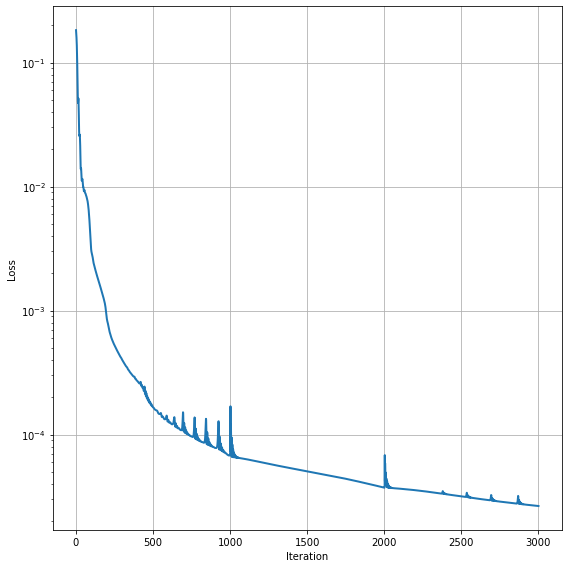

In [49]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Loss = 2.6490992e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<43:22,  2.60s/it]

New min loss =  2.6490992e-05


Loss = 2.6422616e-05:   6%|█████████▋                                                                                                                                              | 64/1000 [02:20<42:41,  2.74s/it]

New min loss =  2.6422616e-05


Loss = 2.6379743e-05:   7%|██████████▍                                                                                                                                             | 69/1000 [02:33<41:07,  2.65s/it]

New min loss =  2.6379743e-05


Loss = 2.6340567e-05:   8%|████████████▎                                                                                                                                           | 81/1000 [03:08<39:25,  2.57s/it]

New min loss =  2.6340567e-05


Loss = 2.6318303e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [03:30<46:27,  3.06s/it]

New min loss =  2.6318303e-05


Loss = 2.630938e-05:   9%|██████████████▏                                                                                                                                          | 93/1000 [03:42<36:25,  2.41s/it]

New min loss =  2.630938e-05


Loss = 2.6293812e-05:  10%|██████████████▌                                                                                                                                         | 96/1000 [03:51<42:32,  2.82s/it]

New min loss =  2.6293812e-05


Loss = 2.6287878e-05:  10%|███████████████                                                                                                                                        | 100/1000 [04:04<45:46,  3.05s/it]

New min loss =  2.6287878e-05


Loss = 2.6271928e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [04:13<45:55,  3.07s/it]

New min loss =  2.6271928e-05


Loss = 2.6263791e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [04:22<34:33,  2.32s/it]

New min loss =  2.6263791e-05


Loss = 2.6257423e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:32<41:41,  2.81s/it]

New min loss =  2.6257423e-05


Loss = 2.6253008e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [04:34<41:31,  2.80s/it]

New min loss =  2.6253008e-05


Loss = 2.6250076e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:41<43:58,  2.97s/it]

New min loss =  2.6250076e-05


Loss = 2.6241663e-05:  11%|█████████████████▏                                                                                                                                     | 114/1000 [04:44<44:03,  2.98s/it]

New min loss =  2.6241663e-05


Loss = 2.6241189e-05:  12%|█████████████████▌                                                                                                                                     | 116/1000 [04:51<48:54,  3.32s/it]

New min loss =  2.6241189e-05


Loss = 2.623207e-05:  12%|█████████████████▊                                                                                                                                      | 117/1000 [04:54<46:53,  3.19s/it]

New min loss =  2.623207e-05


Loss = 2.623129e-05:  12%|██████████████████                                                                                                                                      | 119/1000 [05:00<46:02,  3.14s/it]

New min loss =  2.623129e-05


Loss = 2.6223033e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [05:03<45:41,  3.11s/it]

New min loss =  2.6223033e-05


Loss = 2.6221795e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [05:06<35:24,  2.42s/it]

New min loss =  2.6221795e-05


Loss = 2.622087e-05:  12%|██████████████████▋                                                                                                                                     | 123/1000 [05:09<36:51,  2.52s/it]

New min loss =  2.622087e-05


Loss = 2.6214057e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [05:12<38:20,  2.63s/it]

New min loss =  2.6214057e-05


Loss = 2.6211172e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [05:15<40:08,  2.75s/it]

New min loss =  2.6211172e-05


Loss = 2.6210322e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [05:18<42:02,  2.89s/it]

New min loss =  2.6210322e-05


Loss = 2.6204827e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:21<42:47,  2.94s/it]

New min loss =  2.6204827e-05


Loss = 2.62011e-05:  13%|███████████████████▌                                                                                                                                     | 128/1000 [05:25<44:23,  3.05s/it]

New min loss =  2.62011e-05


Loss = 2.6199896e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [05:28<44:18,  3.05s/it]

New min loss =  2.6199896e-05


Loss = 2.6195336e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [05:31<44:57,  3.10s/it]

New min loss =  2.6195336e-05


Loss = 2.6191276e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [05:34<45:24,  3.14s/it]

New min loss =  2.6191276e-05


Loss = 2.6189571e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:38<46:33,  3.22s/it]

New min loss =  2.6189571e-05


Loss = 2.6185673e-05:  13%|████████████████████                                                                                                                                   | 133/1000 [05:41<45:49,  3.17s/it]

New min loss =  2.6185673e-05


Loss = 2.6181564e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [05:44<44:17,  3.07s/it]

New min loss =  2.6181564e-05


Loss = 2.6179416e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [05:47<44:09,  3.06s/it]

New min loss =  2.6179416e-05


Loss = 2.6175854e-05:  14%|████████████████████▌                                                                                                                                  | 136/1000 [05:50<43:38,  3.03s/it]

New min loss =  2.6175854e-05


Loss = 2.617183e-05:  14%|████████████████████▉                                                                                                                                   | 138/1000 [05:53<34:52,  2.43s/it]

New min loss =  2.617183e-05


Loss = 2.616933e-05:  14%|█████████████████████▏                                                                                                                                  | 139/1000 [05:57<40:20,  2.81s/it]

New min loss =  2.616933e-05


Loss = 2.6165968e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [06:00<41:44,  2.91s/it]

New min loss =  2.6165968e-05


Loss = 2.6162059e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [06:03<41:44,  2.92s/it]

New min loss =  2.6162059e-05


Loss = 2.6159287e-05:  14%|█████████████████████▍                                                                                                                                 | 142/1000 [06:06<42:27,  2.97s/it]

New min loss =  2.6159287e-05


Loss = 2.6155984e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [06:09<43:27,  3.04s/it]

New min loss =  2.6155984e-05


Loss = 2.6152196e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [06:13<44:49,  3.14s/it]

New min loss =  2.6152196e-05


Loss = 2.6149226e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [06:16<44:32,  3.13s/it]

New min loss =  2.6149226e-05


Loss = 2.6145904e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [06:19<43:34,  3.06s/it]

New min loss =  2.6145904e-05


Loss = 2.6142205e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [06:22<44:32,  3.13s/it]

New min loss =  2.6142205e-05


Loss = 2.6139125e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [06:25<43:59,  3.10s/it]

New min loss =  2.6139125e-05


Loss = 2.6135784e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [06:28<44:07,  3.11s/it]

New min loss =  2.6135784e-05


Loss = 2.613214e-05:  15%|██████████████████████▊                                                                                                                                 | 150/1000 [06:32<44:27,  3.14s/it]

New min loss =  2.613214e-05


Loss = 2.6128959e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [06:35<44:22,  3.14s/it]

New min loss =  2.6128959e-05


Loss = 2.6125574e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [06:38<44:18,  3.14s/it]

New min loss =  2.6125574e-05


Loss = 2.6121983e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [06:42<47:51,  3.39s/it]

New min loss =  2.6121983e-05


Loss = 2.6118723e-05:  16%|███████████████████████▍                                                                                                                               | 155/1000 [06:45<36:05,  2.56s/it]

New min loss =  2.6118723e-05


Loss = 2.6115293e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [06:48<37:43,  2.68s/it]

New min loss =  2.6115293e-05


Loss = 2.6111722e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [06:51<39:09,  2.79s/it]

New min loss =  2.6111722e-05


Loss = 2.6108402e-05:  16%|███████████████████████▊                                                                                                                               | 158/1000 [06:54<39:17,  2.80s/it]

New min loss =  2.6108402e-05


Loss = 2.6104924e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [06:57<39:51,  2.84s/it]

New min loss =  2.6104924e-05


Loss = 2.6101368e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [07:00<41:03,  2.93s/it]

New min loss =  2.6101368e-05


Loss = 2.6097989e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [07:04<45:29,  3.25s/it]

New min loss =  2.6097989e-05


Loss = 2.6094496e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [07:07<45:58,  3.29s/it]

New min loss =  2.6094496e-05


Loss = 2.6090947e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [07:10<44:39,  3.20s/it]

New min loss =  2.6090947e-05


Loss = 2.608754e-05:  16%|████████████████████████▉                                                                                                                               | 164/1000 [07:13<43:34,  3.13s/it]

New min loss =  2.608754e-05


Loss = 2.6083979e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [07:17<43:51,  3.15s/it]

New min loss =  2.6083979e-05


Loss = 2.6080448e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [07:20<43:51,  3.15s/it]

New min loss =  2.6080448e-05


Loss = 2.607699e-05:  17%|█████████████████████████▍                                                                                                                              | 167/1000 [07:23<42:56,  3.09s/it]

New min loss =  2.607699e-05


Loss = 2.607342e-05:  17%|█████████████████████████▌                                                                                                                              | 168/1000 [07:26<43:12,  3.12s/it]

New min loss =  2.607342e-05


Loss = 2.6069862e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [07:29<41:53,  3.03s/it]

New min loss =  2.6069862e-05


Loss = 2.6066333e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [07:32<42:02,  3.04s/it]

New min loss =  2.6066333e-05


Loss = 2.6062733e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [07:35<42:31,  3.08s/it]

New min loss =  2.6062733e-05


Loss = 2.6059168e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [07:38<32:52,  2.38s/it]

New min loss =  2.6059168e-05


Loss = 2.6055608e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [07:42<36:49,  2.67s/it]

New min loss =  2.6055608e-05


Loss = 2.6051981e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [07:44<37:12,  2.71s/it]

New min loss =  2.6051981e-05


Loss = 2.6048368e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:47<38:16,  2.79s/it]

New min loss =  2.6048368e-05


Loss = 2.6044765e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [07:51<39:49,  2.90s/it]

New min loss =  2.6044765e-05


Loss = 2.604112e-05:  18%|███████████████████████████                                                                                                                             | 178/1000 [07:54<41:00,  2.99s/it]

New min loss =  2.604112e-05


Loss = 2.6037487e-05:  18%|███████████████████████████                                                                                                                            | 179/1000 [07:57<41:38,  3.04s/it]

New min loss =  2.6037487e-05


Loss = 2.6033846e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [08:00<41:36,  3.04s/it]

New min loss =  2.6033846e-05


Loss = 2.6030171e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [08:03<41:45,  3.06s/it]

New min loss =  2.6030171e-05


Loss = 2.602653e-05:  18%|███████████████████████████▋                                                                                                                            | 182/1000 [08:06<42:44,  3.13s/it]

New min loss =  2.602653e-05


Loss = 2.6022848e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [08:10<42:16,  3.11s/it]

New min loss =  2.6022848e-05


Loss = 2.6019145e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [08:13<43:33,  3.20s/it]

New min loss =  2.6019145e-05


Loss = 2.6015467e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [08:16<42:39,  3.14s/it]

New min loss =  2.6015467e-05


Loss = 2.6011752e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [08:20<44:44,  3.30s/it]

New min loss =  2.6011752e-05


Loss = 2.6008027e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [08:23<44:45,  3.30s/it]

New min loss =  2.6008027e-05


Loss = 2.6004305e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [08:26<43:55,  3.25s/it]

New min loss =  2.6004305e-05


Loss = 2.600057e-05:  19%|████████████████████████████▋                                                                                                                           | 189/1000 [08:29<43:25,  3.21s/it]

New min loss =  2.600057e-05


Loss = 2.5996851e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [08:32<42:20,  3.14s/it]

New min loss =  2.5996851e-05


Loss = 2.599311e-05:  19%|█████████████████████████████▏                                                                                                                          | 192/1000 [08:35<32:48,  2.44s/it]

New min loss =  2.599311e-05


Loss = 2.5989348e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [08:39<35:21,  2.63s/it]

New min loss =  2.5989348e-05


Loss = 2.5985584e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [08:41<36:15,  2.70s/it]

New min loss =  2.5985584e-05


Loss = 2.5981837e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [08:45<37:23,  2.79s/it]

New min loss =  2.5981837e-05


Loss = 2.5978052e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [08:48<38:55,  2.90s/it]

New min loss =  2.5978052e-05


Loss = 2.5974286e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [08:51<38:53,  2.91s/it]

New min loss =  2.5974286e-05


Loss = 2.597047e-05:  20%|██████████████████████████████                                                                                                                          | 198/1000 [08:54<39:18,  2.94s/it]

New min loss =  2.597047e-05


Loss = 2.5966656e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [08:57<39:08,  2.93s/it]

New min loss =  2.5966656e-05


Loss = 2.5962847e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [09:00<39:46,  2.98s/it]

New min loss =  2.5962847e-05


Loss = 2.5959009e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [09:03<40:10,  3.02s/it]

New min loss =  2.5959009e-05


Loss = 2.595518e-05:  20%|██████████████████████████████▋                                                                                                                         | 202/1000 [09:06<39:26,  2.97s/it]

New min loss =  2.595518e-05


Loss = 2.595132e-05:  20%|██████████████████████████████▊                                                                                                                         | 203/1000 [09:09<39:22,  2.96s/it]

New min loss =  2.595132e-05


Loss = 2.594747e-05:  20%|███████████████████████████████                                                                                                                         | 204/1000 [09:12<39:24,  2.97s/it]

New min loss =  2.594747e-05


Loss = 2.5943598e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [09:15<39:44,  3.00s/it]

New min loss =  2.5943598e-05


Loss = 2.5939737e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [09:18<39:51,  3.01s/it]

New min loss =  2.5939737e-05


Loss = 2.5935844e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [09:21<42:15,  3.20s/it]

New min loss =  2.5935844e-05


Loss = 2.5931951e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [09:25<42:29,  3.22s/it]

New min loss =  2.5931951e-05


Loss = 2.5928057e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [09:28<43:37,  3.31s/it]

New min loss =  2.5928057e-05


Loss = 2.592414e-05:  21%|███████████████████████████████▉                                                                                                                        | 210/1000 [09:31<42:47,  3.25s/it]

New min loss =  2.592414e-05


Loss = 2.5920248e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [09:34<32:32,  2.48s/it]

New min loss =  2.5920248e-05


Loss = 2.5916308e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [09:37<34:34,  2.64s/it]

New min loss =  2.5916308e-05


Loss = 2.5912386e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [09:41<36:00,  2.75s/it]

New min loss =  2.5912386e-05


Loss = 2.5908446e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [09:43<36:07,  2.76s/it]

New min loss =  2.5908446e-05


Loss = 2.590447e-05:  22%|████████████████████████████████▊                                                                                                                       | 216/1000 [09:46<37:15,  2.85s/it]

New min loss =  2.590447e-05


Loss = 2.590052e-05:  22%|████████████████████████████████▉                                                                                                                       | 217/1000 [09:49<38:02,  2.92s/it]

New min loss =  2.590052e-05


Loss = 2.5896543e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [09:53<38:56,  2.99s/it]

New min loss =  2.5896543e-05


Loss = 2.5892552e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [09:56<39:06,  3.00s/it]

New min loss =  2.5892552e-05


Loss = 2.5888556e-05:  22%|█████████████████████████████████▏                                                                                                                     | 220/1000 [09:59<39:01,  3.00s/it]

New min loss =  2.5888556e-05


Loss = 2.588455e-05:  22%|█████████████████████████████████▌                                                                                                                      | 221/1000 [10:01<37:57,  2.92s/it]

New min loss =  2.588455e-05


Loss = 2.5880563e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [10:04<38:08,  2.94s/it]

New min loss =  2.5880563e-05


Loss = 2.5876538e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [10:07<38:33,  2.98s/it]

New min loss =  2.5876538e-05


Loss = 2.5872529e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [10:11<38:59,  3.02s/it]

New min loss =  2.5872529e-05


Loss = 2.5868503e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [10:14<39:18,  3.04s/it]

New min loss =  2.5868503e-05


Loss = 2.5864463e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [10:17<39:57,  3.10s/it]

New min loss =  2.5864463e-05


Loss = 2.5860441e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [10:20<38:22,  2.98s/it]

New min loss =  2.5860441e-05


Loss = 2.5856387e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [10:23<38:46,  3.01s/it]

New min loss =  2.5856387e-05


Loss = 2.5852325e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [10:26<38:40,  3.01s/it]

New min loss =  2.5852325e-05


Loss = 2.5848258e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [10:29<38:23,  2.99s/it]

New min loss =  2.5848258e-05


Loss = 2.5844192e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [10:32<37:53,  2.96s/it]

New min loss =  2.5844192e-05


Loss = 2.5840121e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [10:35<29:19,  2.29s/it]

New min loss =  2.5840121e-05


Loss = 2.5836021e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [10:37<30:42,  2.41s/it]

New min loss =  2.5836021e-05


Loss = 2.583192e-05:  24%|███████████████████████████████████▋                                                                                                                    | 235/1000 [10:40<32:43,  2.57s/it]

New min loss =  2.583192e-05


Loss = 2.5827816e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [10:43<33:44,  2.65s/it]

New min loss =  2.5827816e-05


Loss = 2.5823712e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [10:46<35:25,  2.79s/it]

New min loss =  2.5823712e-05


Loss = 2.5819563e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [10:49<36:12,  2.85s/it]

New min loss =  2.5819563e-05


Loss = 2.5815425e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [10:53<37:18,  2.94s/it]

New min loss =  2.5815425e-05


Loss = 2.5811296e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [10:56<37:34,  2.97s/it]

New min loss =  2.5811296e-05


Loss = 2.5807149e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [10:59<38:00,  3.00s/it]

New min loss =  2.5807149e-05


Loss = 2.5803005e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [11:02<38:10,  3.02s/it]

New min loss =  2.5803005e-05


Loss = 2.5798821e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [11:05<38:32,  3.05s/it]

New min loss =  2.5798821e-05


Loss = 2.5794661e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [11:08<37:49,  3.00s/it]

New min loss =  2.5794661e-05


Loss = 2.5790494e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [11:11<38:16,  3.04s/it]

New min loss =  2.5790494e-05


Loss = 2.5786343e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [11:14<39:00,  3.10s/it]

New min loss =  2.5786343e-05


Loss = 2.5782161e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [11:17<38:31,  3.07s/it]

New min loss =  2.5782161e-05


Loss = 2.5778001e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [11:20<37:40,  3.01s/it]

New min loss =  2.5778001e-05


Loss = 2.5773847e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [11:23<37:37,  3.01s/it]

New min loss =  2.5773847e-05


Loss = 2.576965e-05:  25%|██████████████████████████████████████                                                                                                                  | 250/1000 [11:26<37:28,  3.00s/it]

New min loss =  2.576965e-05


Loss = 2.5765488e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [11:29<37:56,  3.04s/it]

New min loss =  2.5765488e-05


Loss = 2.5761297e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [11:32<38:45,  3.11s/it]

New min loss =  2.5761297e-05


Loss = 2.5757097e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [11:35<38:02,  3.06s/it]

New min loss =  2.5757097e-05


Loss = 2.5752857e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [11:38<29:05,  2.34s/it]

New min loss =  2.5752857e-05


Loss = 2.5748623e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [11:41<30:50,  2.49s/it]

New min loss =  2.5748623e-05


Loss = 2.5744379e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [11:44<32:36,  2.63s/it]

New min loss =  2.5744379e-05


Loss = 2.5740126e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [11:47<33:43,  2.73s/it]

New min loss =  2.5740126e-05


Loss = 2.5735873e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [11:50<34:50,  2.82s/it]

New min loss =  2.5735873e-05


Loss = 2.5731584e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [11:53<35:21,  2.87s/it]

New min loss =  2.5731584e-05


Loss = 2.5727311e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [11:56<35:25,  2.88s/it]

New min loss =  2.5727311e-05


Loss = 2.5723028e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [11:59<35:27,  2.88s/it]

New min loss =  2.5723028e-05


Loss = 2.5718731e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [12:02<36:32,  2.97s/it]

New min loss =  2.5718731e-05


Loss = 2.5714422e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [12:05<36:37,  2.99s/it]

New min loss =  2.5714422e-05


Loss = 2.5710115e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [12:09<37:25,  3.06s/it]

New min loss =  2.5710115e-05


Loss = 2.5705802e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [12:12<37:58,  3.10s/it]

New min loss =  2.5705802e-05


Loss = 2.5701474e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [12:15<36:54,  3.02s/it]

New min loss =  2.5701474e-05


Loss = 2.5697133e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [12:18<36:58,  3.03s/it]

New min loss =  2.5697133e-05


Loss = 2.5692803e-05:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [12:21<36:33,  3.00s/it]

New min loss =  2.5692803e-05


Loss = 2.5688458e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [12:24<36:48,  3.03s/it]

New min loss =  2.5688458e-05


Loss = 2.5684089e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [12:27<36:25,  3.00s/it]

New min loss =  2.5684089e-05


Loss = 2.5679734e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [12:30<36:37,  3.02s/it]

New min loss =  2.5679734e-05


Loss = 2.5675363e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [12:33<36:30,  3.01s/it]

New min loss =  2.5675363e-05


Loss = 2.5670995e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [12:36<36:48,  3.04s/it]

New min loss =  2.5670995e-05


Loss = 2.5666619e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [12:39<36:49,  3.05s/it]

New min loss =  2.5666619e-05


Loss = 2.5662255e-05:  28%|█████████████████████████████████████████▋                                                                                                             | 276/1000 [12:42<36:46,  3.05s/it]

New min loss =  2.5662255e-05


Loss = 2.5657866e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [12:45<27:10,  2.26s/it]

New min loss =  2.5657866e-05


Loss = 2.5653475e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [12:47<29:03,  2.42s/it]

New min loss =  2.5653475e-05


Loss = 2.5649068e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [12:51<31:09,  2.60s/it]

New min loss =  2.5649068e-05


Loss = 2.564466e-05:  28%|██████████████████████████████████████████▋                                                                                                             | 281/1000 [12:54<33:11,  2.77s/it]

New min loss =  2.564466e-05


Loss = 2.5640255e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [12:57<33:58,  2.84s/it]

New min loss =  2.5640255e-05


Loss = 2.5635833e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [13:00<33:58,  2.84s/it]

New min loss =  2.5635833e-05


Loss = 2.5631403e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [13:03<34:29,  2.89s/it]

New min loss =  2.5631403e-05


Loss = 2.5626967e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [13:06<35:10,  2.95s/it]

New min loss =  2.5626967e-05


Loss = 2.5622534e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [13:09<35:32,  2.99s/it]

New min loss =  2.5622534e-05


Loss = 2.5618083e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [13:12<35:47,  3.01s/it]

New min loss =  2.5618083e-05


Loss = 2.5613612e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [13:15<35:17,  2.97s/it]

New min loss =  2.5613612e-05


Loss = 2.5609144e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [13:18<35:26,  2.99s/it]

New min loss =  2.5609144e-05


Loss = 2.5604671e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [13:21<36:16,  3.06s/it]

New min loss =  2.5604671e-05


Loss = 2.560019e-05:  29%|████████████████████████████████████████████▏                                                                                                           | 291/1000 [13:24<36:48,  3.11s/it]

New min loss =  2.560019e-05


Loss = 2.5595671e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [13:27<36:23,  3.08s/it]

New min loss =  2.5595671e-05


Loss = 2.5591142e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [13:31<37:11,  3.16s/it]

New min loss =  2.5591142e-05


Loss = 2.5586605e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [13:34<37:45,  3.21s/it]

New min loss =  2.5586605e-05


Loss = 2.5582078e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [13:37<37:10,  3.16s/it]

New min loss =  2.5582078e-05


Loss = 2.5577545e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [13:40<36:04,  3.07s/it]

New min loss =  2.5577545e-05


Loss = 2.5572985e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [13:43<36:18,  3.10s/it]

New min loss =  2.5572985e-05


Loss = 2.5568423e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [13:46<36:55,  3.16s/it]

New min loss =  2.5568423e-05


Loss = 2.5563842e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [13:50<38:11,  3.27s/it]

New min loss =  2.5563842e-05


Loss = 2.5559264e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [13:53<37:53,  3.25s/it]

New min loss =  2.5559264e-05


Loss = 2.5554664e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [13:56<28:29,  2.45s/it]

New min loss =  2.5554664e-05


Loss = 2.5550056e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [13:59<30:48,  2.65s/it]

New min loss =  2.5550056e-05


Loss = 2.5545427e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [14:02<32:05,  2.77s/it]

New min loss =  2.5545427e-05


Loss = 2.5540781e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [14:05<33:01,  2.85s/it]

New min loss =  2.5540781e-05


Loss = 2.5536137e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [14:09<34:06,  2.95s/it]

New min loss =  2.5536137e-05


Loss = 2.5531459e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [14:12<34:07,  2.95s/it]

New min loss =  2.5531459e-05


Loss = 2.5526795e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [14:14<33:38,  2.92s/it]

New min loss =  2.5526795e-05


Loss = 2.5522117e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [14:18<34:21,  2.98s/it]

New min loss =  2.5522117e-05


Loss = 2.5517422e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [14:21<34:18,  2.98s/it]

New min loss =  2.5517422e-05


Loss = 2.5512707e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [14:24<34:19,  2.99s/it]

New min loss =  2.5512707e-05


Loss = 2.5508001e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [14:27<34:53,  3.04s/it]

New min loss =  2.5508001e-05


Loss = 2.5503266e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [14:30<34:31,  3.02s/it]

New min loss =  2.5503266e-05


Loss = 2.5498515e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [14:33<33:39,  2.94s/it]

New min loss =  2.5498515e-05


Loss = 2.5493762e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [14:36<34:12,  3.00s/it]

New min loss =  2.5493762e-05


Loss = 2.5488984e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [14:39<35:01,  3.07s/it]

New min loss =  2.5488984e-05


Loss = 2.548421e-05:  32%|████████████████████████████████████████████████▏                                                                                                       | 317/1000 [14:42<34:52,  3.06s/it]

New min loss =  2.548421e-05


Loss = 2.5479423e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [14:45<35:17,  3.11s/it]

New min loss =  2.5479423e-05


Loss = 2.5474628e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [14:48<34:32,  3.04s/it]

New min loss =  2.5474628e-05


Loss = 2.5469823e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [14:51<34:57,  3.08s/it]

New min loss =  2.5469823e-05


Loss = 2.5465006e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [14:54<35:10,  3.11s/it]

New min loss =  2.5465006e-05


Loss = 2.546019e-05:  32%|████████████████████████████████████████████████▉                                                                                                       | 322/1000 [14:57<35:00,  3.10s/it]

New min loss =  2.546019e-05


Loss = 2.5455349e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [15:00<34:18,  3.04s/it]

New min loss =  2.5455349e-05


Loss = 2.5450498e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [15:04<35:29,  3.15s/it]

New min loss =  2.5450498e-05


Loss = 2.5445628e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [15:07<35:28,  3.15s/it]

New min loss =  2.5445628e-05


Loss = 2.5440746e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [15:10<26:37,  2.37s/it]

New min loss =  2.5440746e-05


Loss = 2.5435866e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [15:13<28:20,  2.53s/it]

New min loss =  2.5435866e-05


Loss = 2.5430994e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [15:16<29:51,  2.67s/it]

New min loss =  2.5430994e-05


Loss = 2.542609e-05:  33%|██████████████████████████████████████████████████▏                                                                                                     | 330/1000 [15:19<30:44,  2.75s/it]

New min loss =  2.542609e-05


Loss = 2.5421195e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [15:22<31:54,  2.86s/it]

New min loss =  2.5421195e-05


Loss = 2.5416282e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [15:25<32:52,  2.95s/it]

New min loss =  2.5416282e-05


Loss = 2.5411362e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [15:28<33:23,  3.00s/it]

New min loss =  2.5411362e-05


Loss = 2.5406453e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [15:31<33:09,  2.99s/it]

New min loss =  2.5406453e-05


Loss = 2.5401512e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [15:34<33:32,  3.03s/it]

New min loss =  2.5401512e-05


Loss = 2.5396579e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [15:38<34:59,  3.16s/it]

New min loss =  2.5396579e-05


Loss = 2.5391631e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [15:41<34:36,  3.13s/it]

New min loss =  2.5391631e-05


Loss = 2.5386682e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [15:44<33:54,  3.07s/it]

New min loss =  2.5386682e-05


Loss = 2.538172e-05:  34%|███████████████████████████████████████████████████▌                                                                                                    | 339/1000 [15:47<34:16,  3.11s/it]

New min loss =  2.538172e-05


Loss = 2.5376767e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [15:50<33:15,  3.02s/it]

New min loss =  2.5376767e-05


Loss = 2.5371772e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [15:53<33:29,  3.05s/it]

New min loss =  2.5371772e-05


Loss = 2.5366795e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [15:56<33:41,  3.07s/it]

New min loss =  2.5366795e-05


Loss = 2.536181e-05:  34%|████████████████████████████████████████████████████▏                                                                                                   | 343/1000 [15:59<33:52,  3.09s/it]

New min loss =  2.536181e-05


Loss = 2.5356818e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [16:03<34:23,  3.15s/it]

New min loss =  2.5356818e-05


Loss = 2.5351816e-05:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [16:06<35:34,  3.26s/it]

New min loss =  2.5351816e-05


Loss = 2.5346797e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [16:09<35:50,  3.29s/it]

New min loss =  2.5346797e-05


Loss = 2.5341802e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [16:13<35:33,  3.27s/it]

New min loss =  2.5341802e-05


Loss = 2.5336754e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [16:16<35:12,  3.24s/it]

New min loss =  2.5336754e-05


Loss = 2.5331718e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [16:19<35:59,  3.32s/it]

New min loss =  2.5331718e-05


Loss = 2.5326648e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [16:23<35:40,  3.29s/it]

New min loss =  2.5326648e-05


Loss = 2.5321579e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [16:26<34:45,  3.21s/it]

New min loss =  2.5321579e-05


Loss = 2.5316476e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [16:29<26:24,  2.45s/it]

New min loss =  2.5316476e-05


Loss = 2.5311401e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [16:32<28:19,  2.63s/it]

New min loss =  2.5311401e-05


Loss = 2.5306303e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [16:35<29:58,  2.79s/it]

New min loss =  2.5306303e-05


Loss = 2.5301206e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [16:38<30:07,  2.81s/it]

New min loss =  2.5301206e-05


Loss = 2.5296098e-05:  36%|█████████████████████████████████████████████████████▉                                                                                                 | 357/1000 [16:41<31:14,  2.91s/it]

New min loss =  2.5296098e-05


Loss = 2.5290987e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [16:44<32:04,  3.00s/it]

New min loss =  2.5290987e-05


Loss = 2.5285852e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [16:48<33:07,  3.10s/it]

New min loss =  2.5285852e-05


Loss = 2.5280711e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [16:51<33:46,  3.17s/it]

New min loss =  2.5280711e-05


Loss = 2.5275582e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                | 361/1000 [16:54<33:40,  3.16s/it]

New min loss =  2.5275582e-05


Loss = 2.5270414e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [16:57<33:04,  3.11s/it]

New min loss =  2.5270414e-05


Loss = 2.526525e-05:  36%|███████████████████████████████████████████████████████▏                                                                                                | 363/1000 [17:00<32:58,  3.11s/it]

New min loss =  2.526525e-05


Loss = 2.5260086e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [17:03<33:14,  3.14s/it]

New min loss =  2.5260086e-05


Loss = 2.5254887e-05:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [17:07<33:02,  3.12s/it]

New min loss =  2.5254887e-05


Loss = 2.5249696e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [17:10<32:36,  3.09s/it]

New min loss =  2.5249696e-05


Loss = 2.5244499e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [17:13<32:02,  3.04s/it]

New min loss =  2.5244499e-05


Loss = 2.5239313e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [17:16<33:01,  3.13s/it]

New min loss =  2.5239313e-05


Loss = 2.5234114e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [17:19<32:43,  3.11s/it]

New min loss =  2.5234114e-05


Loss = 2.52289e-05:  37%|████████████████████████████████████████████████████████▌                                                                                                | 370/1000 [17:22<33:00,  3.14s/it]

New min loss =  2.52289e-05


Loss = 2.5223679e-05:  37%|████████████████████████████████████████████████████████                                                                                               | 371/1000 [17:25<32:41,  3.12s/it]

New min loss =  2.5223679e-05


Loss = 2.5218473e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [17:28<32:33,  3.11s/it]

New min loss =  2.5218473e-05


Loss = 2.5213221e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [17:31<32:28,  3.11s/it]

New min loss =  2.5213221e-05


Loss = 2.5207975e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [17:35<32:32,  3.12s/it]

New min loss =  2.5207975e-05


Loss = 2.5202724e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [17:38<32:54,  3.16s/it]

New min loss =  2.5202724e-05


Loss = 2.5197456e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [17:41<32:53,  3.16s/it]

New min loss =  2.5197456e-05


Loss = 2.5192165e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [17:44<32:30,  3.13s/it]

New min loss =  2.5192165e-05


Loss = 2.518688e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                              | 378/1000 [17:47<33:28,  3.23s/it]

New min loss =  2.518688e-05


Loss = 2.5181607e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 380/1000 [17:51<25:45,  2.49s/it]

New min loss =  2.5181607e-05


Loss = 2.5176338e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [17:54<27:39,  2.68s/it]

New min loss =  2.5176338e-05


Loss = 2.5171035e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [17:57<28:40,  2.78s/it]

New min loss =  2.5171035e-05


Loss = 2.5165731e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [18:00<28:59,  2.82s/it]

New min loss =  2.5165731e-05


Loss = 2.5160434e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [18:03<30:07,  2.93s/it]

New min loss =  2.5160434e-05


Loss = 2.5155116e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [18:06<30:47,  3.00s/it]

New min loss =  2.5155116e-05


Loss = 2.5149793e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [18:09<30:57,  3.03s/it]

New min loss =  2.5149793e-05


Loss = 2.5144469e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [18:13<30:58,  3.03s/it]

New min loss =  2.5144469e-05


Loss = 2.5139136e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [18:15<30:32,  2.99s/it]

New min loss =  2.5139136e-05


Loss = 2.5133777e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [18:18<30:04,  2.95s/it]

New min loss =  2.5133777e-05


Loss = 2.5128418e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [18:22<31:27,  3.09s/it]

New min loss =  2.5128418e-05


Loss = 2.5123049e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [18:25<31:34,  3.11s/it]

New min loss =  2.5123049e-05


Loss = 2.5117668e-05:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [18:28<32:28,  3.20s/it]

New min loss =  2.5117668e-05


Loss = 2.5112275e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [18:31<31:48,  3.14s/it]

New min loss =  2.5112275e-05


Loss = 2.5106887e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [18:34<31:51,  3.15s/it]

New min loss =  2.5106887e-05


Loss = 2.5101486e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [18:38<31:43,  3.15s/it]

New min loss =  2.5101486e-05


Loss = 2.5096082e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [18:41<31:35,  3.14s/it]

New min loss =  2.5096082e-05


Loss = 2.5090667e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [18:44<31:39,  3.15s/it]

New min loss =  2.5090667e-05


Loss = 2.508521e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                           | 398/1000 [18:47<30:32,  3.04s/it]

New min loss =  2.508521e-05


Loss = 2.5079797e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [18:50<30:38,  3.06s/it]

New min loss =  2.5079797e-05


Loss = 2.5074345e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [18:53<30:55,  3.09s/it]

New min loss =  2.5074345e-05


Loss = 2.5068917e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [18:56<31:30,  3.16s/it]

New min loss =  2.5068917e-05


Loss = 2.506347e-05:  40%|█████████████████████████████████████████████████████████████                                                                                           | 402/1000 [18:59<31:24,  3.15s/it]

New min loss =  2.506347e-05


Loss = 2.5058016e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [19:02<30:18,  3.05s/it]

New min loss =  2.5058016e-05


Loss = 2.505255e-05:  40%|█████████████████████████████████████████████████████████████▍                                                                                          | 404/1000 [19:06<31:07,  3.13s/it]

New min loss =  2.505255e-05


Loss = 2.5047064e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [19:09<31:07,  3.14s/it]

New min loss =  2.5047064e-05


Loss = 2.5041598e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [19:12<31:08,  3.15s/it]

New min loss =  2.5041598e-05


Loss = 2.5036145e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [19:15<23:50,  2.42s/it]

New min loss =  2.5036145e-05


Loss = 2.5030682e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [19:18<25:15,  2.56s/it]

New min loss =  2.5030682e-05


Loss = 2.502521e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                         | 410/1000 [19:21<25:42,  2.61s/it]

New min loss =  2.502521e-05


Loss = 2.501974e-05:  41%|██████████████████████████████████████████████████████████████▍                                                                                         | 411/1000 [19:24<27:23,  2.79s/it]

New min loss =  2.501974e-05


Loss = 2.5014264e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [19:27<27:50,  2.84s/it]

New min loss =  2.5014264e-05


Loss = 2.5008776e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [19:30<28:59,  2.96s/it]

New min loss =  2.5008776e-05


Loss = 2.500329e-05:  41%|██████████████████████████████████████████████████████████████▉                                                                                         | 414/1000 [19:33<29:13,  2.99s/it]

New min loss =  2.500329e-05


Loss = 2.4997798e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [19:36<28:54,  2.96s/it]

New min loss =  2.4997798e-05


Loss = 2.4992309e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [19:39<29:21,  3.02s/it]

New min loss =  2.4992309e-05


Loss = 2.4986819e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [19:42<29:23,  3.03s/it]

New min loss =  2.4986819e-05


Loss = 2.4981322e-05:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [19:46<29:47,  3.07s/it]

New min loss =  2.4981322e-05


Loss = 2.4975823e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [19:49<29:40,  3.06s/it]

New min loss =  2.4975823e-05


Loss = 2.4970317e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [19:52<29:26,  3.05s/it]

New min loss =  2.4970317e-05


Loss = 2.49648e-05:  42%|████████████████████████████████████████████████████████████████▍                                                                                        | 421/1000 [19:55<28:58,  3.00s/it]

New min loss =  2.49648e-05


Loss = 2.4959276e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [19:57<28:40,  2.98s/it]

New min loss =  2.4959276e-05


Loss = 2.4953753e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [20:00<28:28,  2.96s/it]

New min loss =  2.4953753e-05


Loss = 2.4948224e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [20:03<28:30,  2.97s/it]

New min loss =  2.4948224e-05


Loss = 2.4942696e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [20:06<28:26,  2.97s/it]

New min loss =  2.4942696e-05


Loss = 2.493715e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                       | 426/1000 [20:09<28:42,  3.00s/it]

New min loss =  2.493715e-05


Loss = 2.493162e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                       | 427/1000 [20:12<28:34,  2.99s/it]

New min loss =  2.493162e-05


Loss = 2.4926081e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [20:15<28:34,  3.00s/it]

New min loss =  2.4926081e-05


Loss = 2.4920528e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [20:19<29:15,  3.07s/it]

New min loss =  2.4920528e-05


Loss = 2.4915009e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [20:22<29:44,  3.13s/it]

New min loss =  2.4915009e-05


Loss = 2.4909441e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [20:25<29:45,  3.14s/it]

New min loss =  2.4909441e-05


Loss = 2.4903897e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [20:28<29:22,  3.10s/it]

New min loss =  2.4903897e-05


Loss = 2.489838e-05:  43%|█████████████████████████████████████████████████████████████████▊                                                                                      | 433/1000 [20:31<29:22,  3.11s/it]

New min loss =  2.489838e-05


Loss = 2.489283e-05:  43%|█████████████████████████████████████████████████████████████████▉                                                                                      | 434/1000 [20:34<29:45,  3.15s/it]

New min loss =  2.489283e-05


Loss = 2.4887308e-05:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 435/1000 [20:38<29:54,  3.18s/it]

New min loss =  2.4887308e-05


Loss = 2.488176e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                     | 437/1000 [20:41<22:42,  2.42s/it]

New min loss =  2.488176e-05


Loss = 2.4876214e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [20:44<24:02,  2.57s/it]

New min loss =  2.4876214e-05


Loss = 2.487065e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                     | 439/1000 [20:47<25:26,  2.72s/it]

New min loss =  2.487065e-05


Loss = 2.4865087e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [20:50<26:30,  2.84s/it]

New min loss =  2.4865087e-05


Loss = 2.4859515e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [20:53<27:01,  2.90s/it]

New min loss =  2.4859515e-05


Loss = 2.4853947e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [20:56<27:54,  3.00s/it]

New min loss =  2.4853947e-05


Loss = 2.4848387e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [20:59<27:29,  2.96s/it]

New min loss =  2.4848387e-05


Loss = 2.4842824e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [21:02<27:38,  2.98s/it]

New min loss =  2.4842824e-05


Loss = 2.483723e-05:  44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 445/1000 [21:05<27:56,  3.02s/it]

New min loss =  2.483723e-05


Loss = 2.483162e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                    | 446/1000 [21:09<28:36,  3.10s/it]

New min loss =  2.483162e-05


Loss = 2.482601e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                    | 447/1000 [21:12<29:32,  3.20s/it]

New min loss =  2.482601e-05


Loss = 2.482038e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                    | 448/1000 [21:15<28:39,  3.11s/it]

New min loss =  2.482038e-05


Loss = 2.4814752e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [21:18<28:49,  3.14s/it]

New min loss =  2.4814752e-05


Loss = 2.4809106e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [21:21<28:25,  3.10s/it]

New min loss =  2.4809106e-05


Loss = 2.4803472e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [21:24<28:07,  3.07s/it]

New min loss =  2.4803472e-05


Loss = 2.4797815e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [21:27<27:54,  3.06s/it]

New min loss =  2.4797815e-05


Loss = 2.4792165e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [21:30<28:07,  3.09s/it]

New min loss =  2.4792165e-05


Loss = 2.4786525e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [21:34<28:02,  3.08s/it]

New min loss =  2.4786525e-05


Loss = 2.4780873e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [21:37<28:36,  3.15s/it]

New min loss =  2.4780873e-05


Loss = 2.4775216e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [21:40<29:06,  3.21s/it]

New min loss =  2.4775216e-05


Loss = 2.4769515e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [21:43<28:27,  3.14s/it]

New min loss =  2.4769515e-05


Loss = 2.4763822e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [21:46<27:54,  3.09s/it]

New min loss =  2.4763822e-05


Loss = 2.475812e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                  | 459/1000 [21:49<27:30,  3.05s/it]

New min loss =  2.475812e-05


Loss = 2.4752417e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [21:52<27:36,  3.07s/it]

New min loss =  2.4752417e-05


Loss = 2.4746683e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [21:55<27:41,  3.08s/it]

New min loss =  2.4746683e-05


Loss = 2.1216942e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<39:29,  2.37s/it]

New min loss =  2.1216942e-05


Loss = 2.121654e-05:   4%|██████                                                                                                                                                   | 40/1000 [01:12<30:18,  1.89s/it]

New min loss =  2.121654e-05


Loss = 2.1198546e-05:   4%|██████▋                                                                                                                                                 | 44/1000 [01:22<36:00,  2.26s/it]

New min loss =  2.1198546e-05


Loss = 2.118687e-05:   5%|███████▍                                                                                                                                                 | 49/1000 [01:31<32:08,  2.03s/it]

New min loss =  2.118687e-05


Loss = 2.1175554e-05:   5%|████████                                                                                                                                                | 53/1000 [01:41<36:22,  2.30s/it]

New min loss =  2.1175554e-05


Loss = 2.1168282e-05:   6%|████████▊                                                                                                                                               | 58/1000 [01:50<30:43,  1.96s/it]

New min loss =  2.1168282e-05


Loss = 2.116055e-05:   6%|█████████▍                                                                                                                                               | 62/1000 [02:00<36:40,  2.35s/it]

New min loss =  2.116055e-05


Loss = 2.1159916e-05:   6%|█████████▉                                                                                                                                              | 65/1000 [02:07<37:26,  2.40s/it]

New min loss =  2.1159916e-05


Loss = 2.1155192e-05:   7%|██████████                                                                                                                                              | 66/1000 [02:10<37:38,  2.42s/it]

New min loss =  2.1155192e-05


Loss = 2.114865e-05:   7%|██████████▋                                                                                                                                              | 70/1000 [02:18<35:29,  2.29s/it]

New min loss =  2.114865e-05


Loss = 2.1147645e-05:   7%|███████████                                                                                                                                             | 73/1000 [02:27<42:59,  2.78s/it]

New min loss =  2.1147645e-05


Loss = 2.114065e-05:   7%|███████████▎                                                                                                                                             | 74/1000 [02:30<42:42,  2.77s/it]

New min loss =  2.114065e-05


Loss = 2.1137055e-05:   8%|███████████▋                                                                                                                                            | 77/1000 [02:38<43:40,  2.84s/it]

New min loss =  2.1137055e-05


Loss = 2.1135262e-05:   8%|███████████▊                                                                                                                                            | 78/1000 [02:42<44:52,  2.92s/it]

New min loss =  2.1135262e-05


Loss = 2.1133745e-05:   8%|████████████▎                                                                                                                                           | 81/1000 [02:48<39:39,  2.59s/it]

New min loss =  2.1133745e-05


Loss = 2.1129386e-05:   8%|████████████▍                                                                                                                                           | 82/1000 [02:51<41:31,  2.71s/it]

New min loss =  2.1129386e-05


Loss = 2.112931e-05:   8%|████████████▋                                                                                                                                            | 83/1000 [02:55<43:37,  2.85s/it]

New min loss =  2.112931e-05


Loss = 2.1128557e-05:   8%|████████████▊                                                                                                                                           | 84/1000 [02:58<44:23,  2.91s/it]

New min loss =  2.1128557e-05


Loss = 2.112473e-05:   8%|█████████████                                                                                                                                            | 85/1000 [03:01<46:22,  3.04s/it]

New min loss =  2.112473e-05


Loss = 2.1123018e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:04<46:14,  3.04s/it]

New min loss =  2.1123018e-05


Loss = 2.112249e-05:   9%|█████████████▎                                                                                                                                           | 87/1000 [03:07<46:53,  3.08s/it]

New min loss =  2.112249e-05


Loss = 2.1119826e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [03:10<46:48,  3.08s/it]

New min loss =  2.1119826e-05


Loss = 2.111735e-05:   9%|█████████████▌                                                                                                                                           | 89/1000 [03:13<47:03,  3.10s/it]

New min loss =  2.111735e-05


Loss = 2.1116512e-05:   9%|█████████████▋                                                                                                                                          | 90/1000 [03:17<47:19,  3.12s/it]

New min loss =  2.1116512e-05


Loss = 2.1114834e-05:   9%|█████████████▊                                                                                                                                          | 91/1000 [03:20<48:36,  3.21s/it]

New min loss =  2.1114834e-05


Loss = 2.1112031e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:24<39:45,  2.63s/it]

New min loss =  2.1112031e-05


Loss = 2.1110547e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:27<41:47,  2.77s/it]

New min loss =  2.1110547e-05


Loss = 2.1109394e-05:  10%|██████████████▍                                                                                                                                         | 95/1000 [03:30<43:39,  2.89s/it]

New min loss =  2.1109394e-05


Loss = 2.110701e-05:  10%|██████████████▋                                                                                                                                          | 96/1000 [03:34<47:09,  3.13s/it]

New min loss =  2.110701e-05


Loss = 2.1104937e-05:  10%|██████████████▋                                                                                                                                         | 97/1000 [03:38<48:22,  3.21s/it]

New min loss =  2.1104937e-05


Loss = 2.1103626e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [03:40<46:59,  3.13s/it]

New min loss =  2.1103626e-05


Loss = 2.1101829e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:44<47:31,  3.17s/it]

New min loss =  2.1101829e-05


Loss = 2.1099579e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:47<47:54,  3.19s/it]

New min loss =  2.1099579e-05


Loss = 2.1097947e-05:  10%|███████████████▎                                                                                                                                       | 101/1000 [03:50<48:16,  3.22s/it]

New min loss =  2.1097947e-05


Loss = 2.1096366e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [03:53<48:23,  3.23s/it]

New min loss =  2.1096366e-05


Loss = 2.1094233e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [03:56<47:07,  3.15s/it]

New min loss =  2.1094233e-05


Loss = 2.1092412e-05:  10%|███████████████▋                                                                                                                                       | 104/1000 [04:00<47:17,  3.17s/it]

New min loss =  2.1092412e-05


Loss = 2.109078e-05:  10%|███████████████▉                                                                                                                                        | 105/1000 [04:03<47:38,  3.19s/it]

New min loss =  2.109078e-05


Loss = 2.1088783e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [04:06<36:22,  2.44s/it]

New min loss =  2.1088783e-05


Loss = 2.1086871e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [04:09<39:07,  2.63s/it]

New min loss =  2.1086871e-05


Loss = 2.108517e-05:  11%|████████████████▌                                                                                                                                       | 109/1000 [04:12<39:58,  2.69s/it]

New min loss =  2.108517e-05


Loss = 2.1083273e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:15<41:27,  2.79s/it]

New min loss =  2.1083273e-05


Loss = 2.108127e-05:  11%|████████████████▊                                                                                                                                       | 111/1000 [04:18<43:22,  2.93s/it]

New min loss =  2.108127e-05


Loss = 2.1079539e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:22<44:32,  3.01s/it]

New min loss =  2.1079539e-05


Loss = 2.107768e-05:  11%|█████████████████▏                                                                                                                                      | 113/1000 [04:25<44:44,  3.03s/it]

New min loss =  2.107768e-05


Loss = 2.107565e-05:  11%|█████████████████▎                                                                                                                                      | 114/1000 [04:28<44:30,  3.01s/it]

New min loss =  2.107565e-05


Loss = 2.1073836e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [04:31<44:39,  3.03s/it]

New min loss =  2.1073836e-05


Loss = 2.1072e-05:  12%|█████████████████▊                                                                                                                                        | 116/1000 [04:34<45:10,  3.07s/it]

New min loss =  2.1072e-05


Loss = 2.1069975e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [04:37<45:38,  3.10s/it]

New min loss =  2.1069975e-05


Loss = 2.1068096e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [04:40<46:23,  3.16s/it]

New min loss =  2.1068096e-05


Loss = 2.1066255e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:43<46:03,  3.14s/it]

New min loss =  2.1066255e-05


Loss = 2.1064232e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [04:46<45:28,  3.10s/it]

New min loss =  2.1064232e-05


Loss = 2.1062291e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:50<35:49,  2.45s/it]

New min loss =  2.1062291e-05


Loss = 2.1060416e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:53<38:08,  2.61s/it]

New min loss =  2.1060416e-05


Loss = 2.1058402e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [04:56<40:47,  2.79s/it]

New min loss =  2.1058402e-05


Loss = 2.1056441e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [05:00<43:01,  2.95s/it]

New min loss =  2.1056441e-05


Loss = 2.1054528e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [05:02<42:29,  2.92s/it]

New min loss =  2.1054528e-05


Loss = 2.1052518e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:06<43:05,  2.96s/it]

New min loss =  2.1052518e-05


Loss = 2.1050513e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [05:09<44:43,  3.08s/it]

New min loss =  2.1050513e-05


Loss = 2.1048578e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [05:12<45:59,  3.17s/it]

New min loss =  2.1048578e-05


Loss = 2.1046537e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [05:16<46:50,  3.23s/it]

New min loss =  2.1046537e-05


Loss = 2.1044538e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [05:19<48:48,  3.37s/it]

New min loss =  2.1044538e-05


Loss = 2.1042559e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:23<47:43,  3.30s/it]

New min loss =  2.1042559e-05


Loss = 2.104051e-05:  13%|████████████████████▏                                                                                                                                   | 133/1000 [05:26<47:32,  3.29s/it]

New min loss =  2.104051e-05


Loss = 2.1038479e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [05:29<46:12,  3.20s/it]

New min loss =  2.1038479e-05


Loss = 2.1036481e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [05:32<46:37,  3.23s/it]

New min loss =  2.1036481e-05


Loss = 2.103443e-05:  14%|████████████████████▋                                                                                                                                   | 136/1000 [05:35<46:36,  3.24s/it]

New min loss =  2.103443e-05


Loss = 2.1032372e-05:  14%|████████████████████▊                                                                                                                                  | 138/1000 [05:38<35:05,  2.44s/it]

New min loss =  2.1032372e-05


Loss = 2.1030339e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [05:42<38:11,  2.66s/it]

New min loss =  2.1030339e-05


Loss = 2.1028283e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:45<40:06,  2.80s/it]

New min loss =  2.1028283e-05


Loss = 2.1026206e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [05:48<40:54,  2.86s/it]

New min loss =  2.1026206e-05


Loss = 2.1024147e-05:  14%|█████████████████████▍                                                                                                                                 | 142/1000 [05:51<42:53,  3.00s/it]

New min loss =  2.1024147e-05


Loss = 2.1022066e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [05:54<43:35,  3.05s/it]

New min loss =  2.1022066e-05


Loss = 2.101997e-05:  14%|█████████████████████▉                                                                                                                                  | 144/1000 [05:57<43:25,  3.04s/it]

New min loss =  2.101997e-05


Loss = 2.10179e-05:  14%|██████████████████████▏                                                                                                                                  | 145/1000 [06:01<45:04,  3.16s/it]

New min loss =  2.10179e-05


Loss = 2.1015778e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [06:04<44:53,  3.15s/it]

New min loss =  2.1015778e-05


Loss = 2.1013691e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [06:07<43:41,  3.07s/it]

New min loss =  2.1013691e-05


Loss = 2.1011576e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [06:10<44:58,  3.17s/it]

New min loss =  2.1011576e-05


Loss = 2.1009464e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [06:14<45:03,  3.18s/it]

New min loss =  2.1009464e-05


Loss = 2.1007338e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [06:17<44:50,  3.17s/it]

New min loss =  2.1007338e-05


Loss = 2.1005208e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [06:20<45:34,  3.22s/it]

New min loss =  2.1005208e-05


Loss = 2.1003074e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [06:23<44:36,  3.16s/it]

New min loss =  2.1003074e-05


Loss = 2.1000931e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [06:26<45:02,  3.19s/it]

New min loss =  2.1000931e-05


Loss = 2.0998776e-05:  16%|███████████████████████▍                                                                                                                               | 155/1000 [06:29<34:11,  2.43s/it]

New min loss =  2.0998776e-05


Loss = 2.0996613e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [06:33<36:56,  2.63s/it]

New min loss =  2.0996613e-05


Loss = 2.0994463e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [06:35<37:57,  2.70s/it]

New min loss =  2.0994463e-05


Loss = 2.0992295e-05:  16%|███████████████████████▊                                                                                                                               | 158/1000 [06:39<40:20,  2.87s/it]

New min loss =  2.0992295e-05


Loss = 2.0990108e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [06:42<41:41,  2.97s/it]

New min loss =  2.0990108e-05


Loss = 2.0987934e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [06:45<42:53,  3.06s/it]

New min loss =  2.0987934e-05


Loss = 2.098575e-05:  16%|████████████████████████▍                                                                                                                               | 161/1000 [06:49<44:00,  3.15s/it]

New min loss =  2.098575e-05


Loss = 2.0983558e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [06:52<43:12,  3.09s/it]

New min loss =  2.0983558e-05


Loss = 2.0981359e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [06:55<45:00,  3.23s/it]

New min loss =  2.0981359e-05


Loss = 2.0979149e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:58<44:17,  3.18s/it]

New min loss =  2.0979149e-05


Loss = 2.097695e-05:  16%|█████████████████████████                                                                                                                               | 165/1000 [07:01<43:50,  3.15s/it]

New min loss =  2.097695e-05


Loss = 2.0974725e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [07:04<42:43,  3.07s/it]

New min loss =  2.0974725e-05


Loss = 2.0972506e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [07:07<43:22,  3.12s/it]

New min loss =  2.0972506e-05


Loss = 2.0970278e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [07:11<43:55,  3.17s/it]

New min loss =  2.0970278e-05


Loss = 2.0968046e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [07:14<44:10,  3.19s/it]

New min loss =  2.0968046e-05


Loss = 2.0965817e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [07:17<43:50,  3.17s/it]

New min loss =  2.0965817e-05


Loss = 2.096357e-05:  17%|█████████████████████████▉                                                                                                                              | 171/1000 [07:20<43:24,  3.14s/it]

New min loss =  2.096357e-05


Loss = 2.0961323e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [07:24<34:01,  2.47s/it]

New min loss =  2.0961323e-05


Loss = 2.0959054e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [07:27<36:40,  2.66s/it]

New min loss =  2.0959054e-05


Loss = 2.0956802e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [07:30<38:21,  2.79s/it]

New min loss =  2.0956802e-05


Loss = 2.0954525e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:33<39:11,  2.85s/it]

New min loss =  2.0954525e-05


Loss = 2.0952242e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [07:36<39:06,  2.85s/it]

New min loss =  2.0952242e-05


Loss = 2.0949967e-05:  18%|██████████████████████████▉                                                                                                                            | 178/1000 [07:39<40:00,  2.92s/it]

New min loss =  2.0949967e-05


Loss = 2.0947668e-05:  18%|███████████████████████████                                                                                                                            | 179/1000 [07:42<40:36,  2.97s/it]

New min loss =  2.0947668e-05


Loss = 2.0945392e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [07:45<41:27,  3.03s/it]

New min loss =  2.0945392e-05


Loss = 2.0943084e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [07:48<41:34,  3.05s/it]

New min loss =  2.0943084e-05


Loss = 2.0940786e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [07:52<43:22,  3.18s/it]

New min loss =  2.0940786e-05


Loss = 2.093847e-05:  18%|███████████████████████████▊                                                                                                                            | 183/1000 [07:55<44:06,  3.24s/it]

New min loss =  2.093847e-05


Loss = 2.093615e-05:  18%|███████████████████████████▉                                                                                                                            | 184/1000 [07:58<44:08,  3.25s/it]

New min loss =  2.093615e-05


Loss = 2.0933823e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [08:02<46:34,  3.43s/it]

New min loss =  2.0933823e-05


Loss = 2.0931497e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [08:06<46:05,  3.40s/it]

New min loss =  2.0931497e-05


Loss = 2.0929156e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [08:09<44:27,  3.28s/it]

New min loss =  2.0929156e-05


Loss = 2.0926813e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [08:12<44:28,  3.29s/it]

New min loss =  2.0926813e-05


Loss = 2.0924457e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [08:15<44:28,  3.29s/it]

New min loss =  2.0924457e-05


Loss = 2.0922098e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [08:19<45:03,  3.34s/it]

New min loss =  2.0922098e-05


Loss = 2.0919755e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [08:22<34:01,  2.53s/it]

New min loss =  2.0919755e-05


Loss = 2.0917365e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [08:25<37:02,  2.75s/it]

New min loss =  2.0917365e-05


Loss = 2.0914998e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [08:29<40:16,  3.00s/it]

New min loss =  2.0914998e-05


Loss = 2.091263e-05:  20%|█████████████████████████████▋                                                                                                                          | 195/1000 [08:33<43:42,  3.26s/it]

New min loss =  2.091263e-05


Loss = 2.0910247e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [08:36<43:50,  3.27s/it]

New min loss =  2.0910247e-05


Loss = 2.090785e-05:  20%|█████████████████████████████▉                                                                                                                          | 197/1000 [08:40<44:37,  3.33s/it]

New min loss =  2.090785e-05


Loss = 2.0905467e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [08:43<43:20,  3.24s/it]

New min loss =  2.0905467e-05


Loss = 2.090306e-05:  20%|██████████████████████████████▏                                                                                                                         | 199/1000 [08:46<44:11,  3.31s/it]

New min loss =  2.090306e-05


Loss = 2.090066e-05:  20%|██████████████████████████████▍                                                                                                                         | 200/1000 [08:49<43:45,  3.28s/it]

New min loss =  2.090066e-05


Loss = 2.0898233e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [08:52<42:31,  3.19s/it]

New min loss =  2.0898233e-05


Loss = 2.0895826e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [08:56<43:31,  3.27s/it]

New min loss =  2.0895826e-05


Loss = 2.0893403e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [08:59<42:56,  3.23s/it]

New min loss =  2.0893403e-05


Loss = 2.089097e-05:  20%|███████████████████████████████                                                                                                                         | 204/1000 [09:02<41:47,  3.15s/it]

New min loss =  2.089097e-05


Loss = 2.0888534e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [09:05<42:41,  3.22s/it]

New min loss =  2.0888534e-05


Loss = 2.08861e-05:  21%|███████████████████████████████▌                                                                                                                         | 206/1000 [09:08<42:13,  3.19s/it]

New min loss =  2.08861e-05


Loss = 2.0883655e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [09:12<43:02,  3.26s/it]

New min loss =  2.0883655e-05


Loss = 2.08812e-05:  21%|███████████████████████████████▊                                                                                                                         | 208/1000 [09:15<42:57,  3.25s/it]

New min loss =  2.08812e-05


Loss = 2.087874e-05:  21%|███████████████████████████████▊                                                                                                                        | 209/1000 [09:18<42:12,  3.20s/it]

New min loss =  2.087874e-05


Loss = 2.0876283e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [09:21<41:31,  3.15s/it]

New min loss =  2.0876283e-05


Loss = 2.0873807e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [09:24<31:55,  2.43s/it]

New min loss =  2.0873807e-05


Loss = 2.0871346e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [09:28<34:13,  2.61s/it]

New min loss =  2.0871346e-05


Loss = 2.0868876e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [09:31<35:56,  2.74s/it]

New min loss =  2.0868876e-05


Loss = 2.0866386e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [09:34<37:59,  2.90s/it]

New min loss =  2.0866386e-05


Loss = 2.08639e-05:  22%|█████████████████████████████████                                                                                                                        | 216/1000 [09:37<38:53,  2.98s/it]

New min loss =  2.08639e-05


Loss = 2.0861404e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [09:40<39:07,  3.00s/it]

New min loss =  2.0861404e-05


Loss = 2.085891e-05:  22%|█████████████████████████████████▏                                                                                                                      | 218/1000 [09:43<39:40,  3.04s/it]

New min loss =  2.085891e-05


Loss = 2.085642e-05:  22%|█████████████████████████████████▎                                                                                                                      | 219/1000 [09:47<40:06,  3.08s/it]

New min loss =  2.085642e-05


Loss = 2.0853908e-05:  22%|█████████████████████████████████▏                                                                                                                     | 220/1000 [09:50<40:09,  3.09s/it]

New min loss =  2.0853908e-05


Loss = 2.0851397e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [09:53<39:34,  3.05s/it]

New min loss =  2.0851397e-05


Loss = 2.084888e-05:  22%|█████████████████████████████████▋                                                                                                                      | 222/1000 [09:56<41:33,  3.20s/it]

New min loss =  2.084888e-05


Loss = 2.0846359e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [09:59<40:43,  3.15s/it]

New min loss =  2.0846359e-05


Loss = 2.084384e-05:  22%|██████████████████████████████████                                                                                                                      | 224/1000 [10:02<41:10,  3.18s/it]

New min loss =  2.084384e-05


Loss = 2.0841306e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [10:06<40:49,  3.16s/it]

New min loss =  2.0841306e-05


Loss = 2.0838774e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [10:09<41:33,  3.22s/it]

New min loss =  2.0838774e-05


Loss = 2.083623e-05:  23%|██████████████████████████████████▌                                                                                                                     | 227/1000 [10:12<40:12,  3.12s/it]

New min loss =  2.083623e-05


Loss = 2.0833686e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [10:15<40:32,  3.15s/it]

New min loss =  2.0833686e-05


Loss = 2.0831136e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [10:18<41:33,  3.23s/it]

New min loss =  2.0831136e-05


Loss = 2.0828567e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [10:22<40:56,  3.19s/it]

New min loss =  2.0828567e-05


Loss = 2.0826013e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [10:25<40:35,  3.17s/it]

New min loss =  2.0826013e-05


Loss = 2.0823434e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [10:28<30:27,  2.38s/it]

New min loss =  2.0823434e-05


Loss = 2.0820884e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [10:31<33:58,  2.66s/it]

New min loss =  2.0820884e-05


Loss = 2.08183e-05:  24%|███████████████████████████████████▉                                                                                                                     | 235/1000 [10:35<37:36,  2.95s/it]

New min loss =  2.08183e-05


Loss = 2.0815714e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [10:39<40:28,  3.18s/it]

New min loss =  2.0815714e-05


Loss = 2.0813128e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [10:42<42:20,  3.33s/it]

New min loss =  2.0813128e-05


Loss = 2.0810532e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [10:46<42:58,  3.38s/it]

New min loss =  2.0810532e-05


Loss = 2.0807936e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [10:49<42:58,  3.39s/it]

New min loss =  2.0807936e-05


Loss = 2.0805335e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [10:53<45:16,  3.57s/it]

New min loss =  2.0805335e-05


Loss = 2.0802725e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [10:57<46:06,  3.65s/it]

New min loss =  2.0802725e-05


Loss = 2.0800102e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [11:01<46:25,  3.67s/it]

New min loss =  2.0800102e-05


Loss = 2.0797494e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [11:05<46:10,  3.66s/it]

New min loss =  2.0797494e-05


Loss = 2.0794863e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [11:08<45:44,  3.63s/it]

New min loss =  2.0794863e-05


Loss = 2.0792244e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [11:12<45:06,  3.58s/it]

New min loss =  2.0792244e-05


Loss = 2.0789608e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [11:15<46:20,  3.69s/it]

New min loss =  2.0789608e-05


Loss = 2.078697e-05:  25%|█████████████████████████████████████▌                                                                                                                  | 247/1000 [11:19<46:41,  3.72s/it]

New min loss =  2.078697e-05


Loss = 2.0784322e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [11:23<45:58,  3.67s/it]

New min loss =  2.0784322e-05


Loss = 2.0781668e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [11:26<45:39,  3.65s/it]

New min loss =  2.0781668e-05


Loss = 2.0779034e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [11:30<45:19,  3.63s/it]

New min loss =  2.0779034e-05


Loss = 2.0776373e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [11:34<46:04,  3.69s/it]

New min loss =  2.0776373e-05


Loss = 2.0773714e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [11:38<46:24,  3.72s/it]

New min loss =  2.0773714e-05


Loss = 2.0771033e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [11:41<46:03,  3.70s/it]

New min loss =  2.0771033e-05


Loss = 2.0768372e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [11:45<35:06,  2.83s/it]

New min loss =  2.0768372e-05


Loss = 2.076568e-05:  26%|██████████████████████████████████████▉                                                                                                                 | 256/1000 [11:48<37:09,  3.00s/it]

New min loss =  2.076568e-05


Loss = 2.0762993e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [11:52<39:03,  3.15s/it]

New min loss =  2.0762993e-05


Loss = 2.0760315e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [11:56<40:47,  3.30s/it]

New min loss =  2.0760315e-05


Loss = 2.075763e-05:  26%|███████████████████████████████████████▎                                                                                                                | 259/1000 [11:59<42:00,  3.40s/it]

New min loss =  2.075763e-05


Loss = 2.0754924e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [12:03<42:42,  3.46s/it]

New min loss =  2.0754924e-05


Loss = 2.0752217e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [12:07<43:04,  3.50s/it]

New min loss =  2.0752217e-05


Loss = 2.0749512e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [12:10<43:41,  3.55s/it]

New min loss =  2.0749512e-05


Loss = 2.0746806e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [12:14<43:31,  3.54s/it]

New min loss =  2.0746806e-05


Loss = 2.0744103e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [12:17<43:43,  3.56s/it]

New min loss =  2.0744103e-05


Loss = 2.074139e-05:  26%|████████████████████████████████████████▎                                                                                                               | 265/1000 [12:20<41:48,  3.41s/it]

New min loss =  2.074139e-05


Loss = 2.0738671e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [12:23<38:00,  3.11s/it]

New min loss =  2.0738671e-05


Loss = 2.0735934e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [12:25<35:32,  2.91s/it]

New min loss =  2.0735934e-05


Loss = 2.0733209e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [12:28<33:27,  2.74s/it]

New min loss =  2.0733209e-05


Loss = 2.073048e-05:  27%|████████████████████████████████████████▉                                                                                                               | 269/1000 [12:30<32:21,  2.66s/it]

New min loss =  2.073048e-05


Loss = 2.0727743e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [12:33<31:42,  2.61s/it]

New min loss =  2.0727743e-05


Loss = 2.0725005e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [12:35<30:27,  2.51s/it]

New min loss =  2.0725005e-05


Loss = 2.0722273e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [12:38<31:41,  2.61s/it]

New min loss =  2.0722273e-05


Loss = 2.0719523e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [12:41<34:26,  2.84s/it]

New min loss =  2.0719523e-05


Loss = 2.071677e-05:  27%|█████████████████████████████████████████▋                                                                                                              | 274/1000 [12:44<35:06,  2.90s/it]

New min loss =  2.071677e-05


Loss = 2.071401e-05:  28%|█████████████████████████████████████████▊                                                                                                              | 275/1000 [12:48<36:54,  3.05s/it]

New min loss =  2.071401e-05


Loss = 2.071124e-05:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [12:52<40:28,  3.35s/it]

New min loss =  2.071124e-05


Loss = 2.0708485e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [12:56<33:52,  2.82s/it]

New min loss =  2.0708485e-05


Loss = 2.070572e-05:  28%|██████████████████████████████████████████▍                                                                                                             | 279/1000 [13:00<37:47,  3.14s/it]

New min loss =  2.070572e-05


Loss = 2.0702953e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [13:03<36:21,  3.03s/it]

New min loss =  2.0702953e-05


Loss = 2.0700176e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [13:05<33:56,  2.83s/it]

New min loss =  2.0700176e-05


Loss = 2.069741e-05:  28%|██████████████████████████████████████████▊                                                                                                             | 282/1000 [13:08<33:25,  2.79s/it]

New min loss =  2.069741e-05


Loss = 2.0694632e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [13:10<32:56,  2.76s/it]

New min loss =  2.0694632e-05


Loss = 2.069185e-05:  28%|███████████████████████████████████████████▏                                                                                                            | 284/1000 [13:13<32:04,  2.69s/it]

New min loss =  2.069185e-05


Loss = 2.0689065e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [13:15<30:43,  2.58s/it]

New min loss =  2.0689065e-05


Loss = 2.0686286e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [13:18<30:06,  2.53s/it]

New min loss =  2.0686286e-05


Loss = 2.0683487e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [13:21<31:36,  2.66s/it]

New min loss =  2.0683487e-05


Loss = 2.0680702e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [13:24<33:00,  2.78s/it]

New min loss =  2.0680702e-05


Loss = 2.0677904e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [13:27<34:53,  2.94s/it]

New min loss =  2.0677904e-05


Loss = 2.067509e-05:  29%|████████████████████████████████████████████                                                                                                            | 290/1000 [13:31<39:33,  3.34s/it]

New min loss =  2.067509e-05


Loss = 2.0672289e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [13:36<43:14,  3.66s/it]

New min loss =  2.0672289e-05


Loss = 2.0669473e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [13:40<45:03,  3.82s/it]

New min loss =  2.0669473e-05


Loss = 2.0666652e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [13:44<46:41,  3.96s/it]

New min loss =  2.0666652e-05


Loss = 2.0663834e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [13:48<46:34,  3.96s/it]

New min loss =  2.0663834e-05


Loss = 2.0661017e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [13:51<41:12,  3.51s/it]

New min loss =  2.0661017e-05


Loss = 2.06582e-05:  30%|█████████████████████████████████████████████▎                                                                                                           | 296/1000 [13:53<37:08,  3.17s/it]

New min loss =  2.06582e-05


Loss = 2.0655365e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [13:56<34:46,  2.97s/it]

New min loss =  2.0655365e-05


Loss = 2.0652527e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [13:58<32:36,  2.79s/it]

New min loss =  2.0652527e-05


Loss = 2.064969e-05:  30%|█████████████████████████████████████████████▍                                                                                                          | 299/1000 [14:00<31:08,  2.67s/it]

New min loss =  2.064969e-05


Loss = 2.0646858e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [14:03<30:58,  2.65s/it]

New min loss =  2.0646858e-05


Loss = 2.0644015e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [14:05<23:19,  2.01s/it]

New min loss =  2.0644015e-05


Loss = 2.0641171e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [14:08<25:27,  2.19s/it]

New min loss =  2.0641171e-05


Loss = 2.0638323e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [14:11<27:32,  2.37s/it]

New min loss =  2.0638323e-05


Loss = 2.0635462e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [14:14<29:09,  2.52s/it]

New min loss =  2.0635462e-05


Loss = 2.0632604e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [14:17<32:20,  2.80s/it]

New min loss =  2.0632604e-05


Loss = 2.0629746e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [14:22<36:43,  3.18s/it]

New min loss =  2.0629746e-05


Loss = 2.0626883e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [14:25<38:52,  3.37s/it]

New min loss =  2.0626883e-05


Loss = 2.0624018e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [14:29<40:47,  3.54s/it]

New min loss =  2.0624018e-05


Loss = 2.0621152e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [14:33<39:47,  3.46s/it]

New min loss =  2.0621152e-05


Loss = 2.0618274e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [14:36<39:26,  3.43s/it]

New min loss =  2.0618274e-05


Loss = 2.0615393e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [14:40<40:10,  3.50s/it]

New min loss =  2.0615393e-05


Loss = 2.0612511e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [14:43<41:00,  3.58s/it]

New min loss =  2.0612511e-05


Loss = 2.0609608e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [14:48<42:44,  3.74s/it]

New min loss =  2.0609608e-05


Loss = 2.0606727e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [14:51<41:26,  3.63s/it]

New min loss =  2.0606727e-05


Loss = 2.0603831e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [14:55<41:12,  3.61s/it]

New min loss =  2.0603831e-05


Loss = 2.060092e-05:  32%|████████████████████████████████████████████████▏                                                                                                       | 317/1000 [14:59<42:41,  3.75s/it]

New min loss =  2.060092e-05


Loss = 2.0598023e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [15:02<42:22,  3.73s/it]

New min loss =  2.0598023e-05


Loss = 2.059512e-05:  32%|████████████████████████████████████████████████▍                                                                                                       | 319/1000 [15:06<42:47,  3.77s/it]

New min loss =  2.059512e-05


Loss = 2.059221e-05:  32%|████████████████████████████████████████████████▋                                                                                                       | 320/1000 [15:09<41:07,  3.63s/it]

New min loss =  2.059221e-05


Loss = 2.0589292e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [15:13<41:18,  3.65s/it]

New min loss =  2.0589292e-05


Loss = 2.0586369e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [15:17<41:24,  3.66s/it]

New min loss =  2.0586369e-05


Loss = 2.0583459e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [15:20<40:58,  3.63s/it]

New min loss =  2.0583459e-05


Loss = 2.0580534e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [15:24<41:07,  3.65s/it]

New min loss =  2.0580534e-05


Loss = 2.0577598e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [15:27<39:49,  3.54s/it]

New min loss =  2.0577598e-05


Loss = 2.0574662e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [15:31<30:41,  2.74s/it]

New min loss =  2.0574662e-05


Loss = 2.057173e-05:  33%|█████████████████████████████████████████████████▊                                                                                                      | 328/1000 [15:35<33:15,  2.97s/it]

New min loss =  2.057173e-05


Loss = 2.0568774e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [15:39<35:51,  3.21s/it]

New min loss =  2.0568774e-05


Loss = 2.0565834e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [15:42<36:58,  3.31s/it]

New min loss =  2.0565834e-05


Loss = 2.056287e-05:  33%|██████████████████████████████████████████████████▎                                                                                                     | 331/1000 [15:46<38:01,  3.41s/it]

New min loss =  2.056287e-05


Loss = 2.0559924e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [15:49<38:34,  3.47s/it]

New min loss =  2.0559924e-05


Loss = 2.0556963e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [15:53<39:00,  3.51s/it]

New min loss =  2.0556963e-05


Loss = 2.0554e-05:  33%|███████████████████████████████████████████████████▍                                                                                                      | 334/1000 [15:57<39:32,  3.56s/it]

New min loss =  2.0554e-05


Loss = 2.0551035e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [16:01<41:39,  3.76s/it]

New min loss =  2.0551035e-05


Loss = 2.0548076e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [16:05<41:52,  3.78s/it]

New min loss =  2.0548076e-05


Loss = 2.054511e-05:  34%|███████████████████████████████████████████████████▏                                                                                                    | 337/1000 [16:08<40:53,  3.70s/it]

New min loss =  2.054511e-05


Loss = 2.0542147e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [16:12<40:57,  3.71s/it]

New min loss =  2.0542147e-05


Loss = 2.0539148e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [16:16<41:02,  3.73s/it]

New min loss =  2.0539148e-05


Loss = 2.0536185e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [16:20<41:07,  3.74s/it]

New min loss =  2.0536185e-05


Loss = 2.0533207e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [16:23<40:26,  3.68s/it]

New min loss =  2.0533207e-05


Loss = 2.0530215e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [16:27<40:18,  3.68s/it]

New min loss =  2.0530215e-05


Loss = 2.0527224e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [16:30<40:26,  3.69s/it]

New min loss =  2.0527224e-05


Loss = 2.0524236e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [16:34<40:22,  3.69s/it]

New min loss =  2.0524236e-05


Loss = 2.052123e-05:  34%|████████████████████████████████████████████████████▍                                                                                                   | 345/1000 [16:38<40:46,  3.74s/it]

New min loss =  2.052123e-05


Loss = 2.0518237e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [16:42<42:36,  3.91s/it]

New min loss =  2.0518237e-05


Loss = 2.0515236e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [16:46<40:45,  3.75s/it]

New min loss =  2.0515236e-05


Loss = 2.0512241e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [16:50<41:17,  3.80s/it]

New min loss =  2.0512241e-05


Loss = 2.0509231e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [16:54<42:14,  3.89s/it]

New min loss =  2.0509231e-05


Loss = 2.0506228e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [16:58<43:57,  4.06s/it]

New min loss =  2.0506228e-05


Loss = 2.0503208e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [17:02<43:25,  4.02s/it]

New min loss =  2.0503208e-05


Loss = 2.0500187e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [17:06<32:30,  3.01s/it]

New min loss =  2.0500187e-05


Loss = 2.0497173e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [17:09<34:15,  3.18s/it]

New min loss =  2.0497173e-05


Loss = 2.0494144e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [17:13<34:58,  3.25s/it]

New min loss =  2.0494144e-05


Loss = 2.0491123e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [17:17<35:57,  3.35s/it]

New min loss =  2.0491123e-05


Loss = 2.0488089e-05:  36%|█████████████████████████████████████████████████████▉                                                                                                 | 357/1000 [17:20<36:53,  3.44s/it]

New min loss =  2.0488089e-05


Loss = 2.0485062e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [17:24<37:02,  3.46s/it]

New min loss =  2.0485062e-05


Loss = 2.0482013e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [17:27<37:56,  3.55s/it]

New min loss =  2.0482013e-05


Loss = 2.0478981e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [17:31<38:41,  3.63s/it]

New min loss =  2.0478981e-05


Loss = 2.0475936e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                | 361/1000 [17:35<39:01,  3.66s/it]

New min loss =  2.0475936e-05


Loss = 2.047289e-05:  36%|███████████████████████████████████████████████████████                                                                                                 | 362/1000 [17:39<38:37,  3.63s/it]

New min loss =  2.047289e-05


Loss = 2.0469823e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [17:42<39:06,  3.68s/it]

New min loss =  2.0469823e-05


Loss = 2.0466769e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [17:46<39:02,  3.68s/it]

New min loss =  2.0466769e-05


Loss = 2.0463714e-05:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [17:50<39:15,  3.71s/it]

New min loss =  2.0463714e-05


Loss = 2.0460653e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [17:53<38:33,  3.65s/it]

New min loss =  2.0460653e-05


Loss = 2.0457592e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [17:57<37:18,  3.54s/it]

New min loss =  2.0457592e-05


Loss = 2.0454552e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [18:00<37:28,  3.56s/it]

New min loss =  2.0454552e-05


Loss = 2.0451549e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [18:04<38:50,  3.69s/it]

New min loss =  2.0451549e-05


Loss = 2.0448599e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [18:08<38:57,  3.71s/it]

New min loss =  2.0448599e-05


Loss = 2.044578e-05:  37%|████████████████████████████████████████████████████████▍                                                                                               | 371/1000 [18:12<39:33,  3.77s/it]

New min loss =  2.044578e-05


Loss = 2.0443209e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [18:15<38:44,  3.70s/it]

New min loss =  2.0443209e-05


Loss = 2.0441199e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [18:19<38:16,  3.66s/it]

New min loss =  2.0441199e-05


Loss = 2.0440424e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [18:23<38:02,  3.65s/it]

New min loss =  2.0440424e-05


Loss = 2.0403382e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [18:57<25:44,  2.52s/it]

New min loss =  2.0403382e-05


Loss = 2.0377936e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [19:21<30:09,  2.99s/it]

New min loss =  2.0377936e-05


Loss = 2.0366628e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [19:34<31:20,  3.13s/it]

New min loss =  2.0366628e-05


Loss = 2.0356925e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [19:47<31:13,  3.14s/it]

New min loss =  2.0356925e-05


Loss = 2.0347457e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [19:59<23:49,  2.42s/it]

New min loss =  2.0347457e-05


Loss = 2.0337671e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [20:11<28:02,  2.86s/it]

New min loss =  2.0337671e-05


Loss = 2.0331887e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [20:14<28:23,  2.90s/it]

New min loss =  2.0331887e-05


Loss = 2.0327723e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [20:24<29:31,  3.03s/it]

New min loss =  2.0327723e-05


Loss = 2.0317786e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [20:27<29:21,  3.02s/it]

New min loss =  2.0317786e-05


Loss = 2.0317086e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [20:36<30:09,  3.12s/it]

New min loss =  2.0317086e-05


Loss = 2.0306123e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [20:39<30:34,  3.17s/it]

New min loss =  2.0306123e-05


Loss = 2.030547e-05:  42%|████████████████████████████████████████████████████████████████▍                                                                                       | 424/1000 [20:48<29:23,  3.06s/it]

New min loss =  2.030547e-05


Loss = 2.0295838e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [20:52<30:14,  3.16s/it]

New min loss =  2.0295838e-05


Loss = 2.0292278e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [20:55<30:14,  3.16s/it]

New min loss =  2.0292278e-05


Loss = 2.0285734e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [21:04<29:46,  3.13s/it]

New min loss =  2.0285734e-05


Loss = 2.0279966e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [21:08<29:50,  3.14s/it]

New min loss =  2.0279966e-05


Loss = 2.027877e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 431/1000 [21:11<30:30,  3.22s/it]

New min loss =  2.027877e-05


Loss = 2.0278432e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [21:14<29:51,  3.15s/it]

New min loss =  2.0278432e-05


Loss = 2.0274754e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [21:17<29:44,  3.15s/it]

New min loss =  2.0274754e-05


Loss = 2.0269152e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [21:20<30:00,  3.18s/it]

New min loss =  2.0269152e-05


Loss = 2.0265496e-05:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 435/1000 [21:24<30:22,  3.23s/it]

New min loss =  2.0265496e-05


Loss = 2.0264204e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [21:27<23:11,  2.47s/it]

New min loss =  2.0264204e-05


Loss = 2.0262361e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [21:30<24:20,  2.60s/it]

New min loss =  2.0262361e-05


Loss = 2.0258403e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [21:33<25:48,  2.76s/it]

New min loss =  2.0258403e-05


Loss = 2.025394e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 440/1000 [21:36<26:17,  2.82s/it]

New min loss =  2.025394e-05


Loss = 2.0250953e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [21:39<27:31,  2.95s/it]

New min loss =  2.0250953e-05


Loss = 2.0249088e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [21:43<28:20,  3.05s/it]

New min loss =  2.0249088e-05


Loss = 2.0246609e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [21:46<28:52,  3.11s/it]

New min loss =  2.0246609e-05


Loss = 2.0242924e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [21:49<28:58,  3.13s/it]

New min loss =  2.0242924e-05


Loss = 2.0239102e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [21:52<29:07,  3.15s/it]

New min loss =  2.0239102e-05


Loss = 2.0236177e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [21:55<28:55,  3.13s/it]

New min loss =  2.0236177e-05


Loss = 2.0233862e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [21:59<29:34,  3.21s/it]

New min loss =  2.0233862e-05


Loss = 2.0231182e-05:  45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 448/1000 [22:02<29:47,  3.24s/it]

New min loss =  2.0231182e-05


Loss = 2.0227797e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [22:05<29:59,  3.27s/it]

New min loss =  2.0227797e-05


Loss = 2.0224308e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [22:08<29:09,  3.18s/it]

New min loss =  2.0224308e-05


Loss = 2.0221276e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [22:12<29:24,  3.21s/it]

New min loss =  2.0221276e-05


Loss = 2.0218638e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [22:15<28:55,  3.17s/it]

New min loss =  2.0218638e-05


Loss = 2.0215912e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [22:18<28:43,  3.15s/it]

New min loss =  2.0215912e-05


Loss = 2.0212754e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [22:21<28:47,  3.16s/it]

New min loss =  2.0212754e-05


Loss = 2.0209456e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [22:24<28:48,  3.17s/it]

New min loss =  2.0209456e-05


Loss = 2.0206311e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [22:27<28:39,  3.16s/it]

New min loss =  2.0206311e-05


Loss = 2.0203466e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [22:30<28:16,  3.12s/it]

New min loss =  2.0203466e-05


Loss = 2.0200667e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [22:34<29:28,  3.26s/it]

New min loss =  2.0200667e-05


Loss = 2.0197684e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [22:38<30:18,  3.36s/it]

New min loss =  2.0197684e-05


Loss = 2.0194522e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [22:41<29:29,  3.28s/it]

New min loss =  2.0194522e-05


Loss = 2.0191355e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [22:44<29:13,  3.25s/it]

New min loss =  2.0191355e-05


Loss = 2.0188349e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 462/1000 [22:47<28:43,  3.20s/it]

New min loss =  2.0188349e-05


Loss = 2.018545e-05:  46%|██████████████████████████████████████████████████████████████████████▍                                                                                 | 463/1000 [22:50<28:47,  3.22s/it]

New min loss =  2.018545e-05


Loss = 2.0182535e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [22:53<28:40,  3.21s/it]

New min loss =  2.0182535e-05


Loss = 2.0179508e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [22:57<28:27,  3.19s/it]

New min loss =  2.0179508e-05


Loss = 2.0176383e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [23:00<21:29,  2.42s/it]

New min loss =  2.0176383e-05


Loss = 2.0173287e-05:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [23:03<23:05,  2.60s/it]

New min loss =  2.0173287e-05


Loss = 2.0170275e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [23:06<24:15,  2.74s/it]

New min loss =  2.0170275e-05


Loss = 2.0167308e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [23:09<26:00,  2.94s/it]

New min loss =  2.0167308e-05


Loss = 2.0164316e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                                | 471/1000 [23:13<26:30,  3.01s/it]

New min loss =  2.0164316e-05


Loss = 2.0161271e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 472/1000 [23:16<26:49,  3.05s/it]

New min loss =  2.0161271e-05


Loss = 2.0158193e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [23:19<28:03,  3.19s/it]

New min loss =  2.0158193e-05


Loss = 2.0155103e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [23:23<28:11,  3.22s/it]

New min loss =  2.0155103e-05


Loss = 2.0152038e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [23:26<28:29,  3.26s/it]

New min loss =  2.0152038e-05


Loss = 2.0149027e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [23:29<28:05,  3.22s/it]

New min loss =  2.0149027e-05


Loss = 2.0146012e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                               | 477/1000 [23:32<28:06,  3.22s/it]

New min loss =  2.0146012e-05


Loss = 2.0142961e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [23:35<28:02,  3.22s/it]

New min loss =  2.0142961e-05


Loss = 2.013988e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                               | 479/1000 [23:39<28:12,  3.25s/it]

New min loss =  2.013988e-05


Loss = 2.01368e-05:  48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 480/1000 [23:42<28:16,  3.26s/it]

New min loss =  2.01368e-05


Loss = 2.013372e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                               | 481/1000 [23:46<28:48,  3.33s/it]

New min loss =  2.013372e-05


Loss = 2.0130637e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [23:49<29:26,  3.41s/it]

New min loss =  2.0130637e-05


Loss = 2.01276e-05:  48%|█████████████████████████████████████████████████████████████████████████▉                                                                               | 483/1000 [23:53<30:03,  3.49s/it]

New min loss =  2.01276e-05


Loss = 2.012454e-05:  48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 484/1000 [23:57<30:59,  3.60s/it]

New min loss =  2.012454e-05


Loss = 2.0121468e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [24:00<30:05,  3.51s/it]

New min loss =  2.0121468e-05


Loss = 2.011838e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                              | 486/1000 [24:04<30:49,  3.60s/it]

New min loss =  2.011838e-05


Loss = 2.0115302e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [24:07<30:57,  3.62s/it]

New min loss =  2.0115302e-05


Loss = 2.0112207e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [24:11<30:55,  3.62s/it]

New min loss =  2.0112207e-05


Loss = 2.0109135e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [24:15<30:52,  3.62s/it]

New min loss =  2.0109135e-05


Loss = 2.0106068e-05:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 490/1000 [24:19<31:20,  3.69s/it]

New min loss =  2.0106068e-05


Loss = 2.0103e-05:  49%|███████████████████████████████████████████████████████████████████████████▌                                                                              | 491/1000 [24:22<31:31,  3.72s/it]

New min loss =  2.0103e-05


Loss = 2.0099931e-05:  49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 492/1000 [24:26<31:24,  3.71s/it]

New min loss =  2.0099931e-05


Loss = 2.009685e-05:  49%|██████████████████████████████████████████████████████████████████████████▉                                                                             | 493/1000 [24:30<31:42,  3.75s/it]

New min loss =  2.009685e-05


Loss = 2.0093776e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [24:34<31:28,  3.73s/it]

New min loss =  2.0093776e-05


Loss = 2.0090692e-05:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 495/1000 [24:37<31:17,  3.72s/it]

New min loss =  2.0090692e-05


Loss = 2.0087595e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [24:41<31:04,  3.70s/it]

New min loss =  2.0087595e-05


Loss = 2.0084512e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [24:45<24:31,  2.93s/it]

New min loss =  2.0084512e-05


Loss = 2.008142e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                            | 499/1000 [24:49<25:53,  3.10s/it]

New min loss =  2.008142e-05


Loss = 2.0078338e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [24:52<26:47,  3.21s/it]

New min loss =  2.0078338e-05


Loss = 2.0075231e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [24:56<27:38,  3.32s/it]

New min loss =  2.0075231e-05


Loss = 2.007215e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 502/1000 [24:59<28:28,  3.43s/it]

New min loss =  2.007215e-05


Loss = 2.0069045e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [25:03<29:00,  3.50s/it]

New min loss =  2.0069045e-05


Loss = 2.0065921e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [25:07<29:58,  3.63s/it]

New min loss =  2.0065921e-05


Loss = 2.0062818e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [25:11<29:39,  3.59s/it]

New min loss =  2.0062818e-05


Loss = 2.0059711e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [25:14<30:22,  3.69s/it]

New min loss =  2.0059711e-05


Loss = 2.0056588e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [25:18<30:30,  3.71s/it]

New min loss =  2.0056588e-05


Loss = 2.0053465e-05:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [25:22<30:36,  3.73s/it]

New min loss =  2.0053465e-05


Loss = 2.0050338e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [25:26<30:26,  3.72s/it]

New min loss =  2.0050338e-05


Loss = 2.0047211e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [25:29<30:11,  3.70s/it]

New min loss =  2.0047211e-05


Loss = 2.0044097e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [25:33<30:08,  3.70s/it]

New min loss =  2.0044097e-05


Loss = 2.0040969e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [25:37<30:13,  3.72s/it]

New min loss =  2.0040969e-05


Loss = 2.0037856e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [25:41<30:26,  3.75s/it]

New min loss =  2.0037856e-05


Loss = 2.0034717e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [25:44<30:11,  3.73s/it]

New min loss =  2.0034717e-05


Loss = 2.00316e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                          | 515/1000 [25:48<30:12,  3.74s/it]

New min loss =  2.00316e-05


Loss = 2.0028489e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [25:52<30:15,  3.75s/it]

New min loss =  2.0028489e-05


Loss = 2.0025358e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [25:56<31:30,  3.91s/it]

New min loss =  2.0025358e-05


Loss = 2.0022228e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [26:00<32:24,  4.03s/it]

New min loss =  2.0022228e-05


Loss = 2.0019108e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [26:04<31:27,  3.92s/it]

New min loss =  2.0019108e-05


Loss = 2.001597e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 520/1000 [26:08<30:31,  3.81s/it]

New min loss =  2.001597e-05


Loss = 2.0012843e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [26:11<29:56,  3.75s/it]

New min loss =  2.0012843e-05


Loss = 2.000971e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                        | 522/1000 [26:15<30:02,  3.77s/it]

New min loss =  2.000971e-05


Loss = 2.0006579e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 523/1000 [26:19<31:10,  3.92s/it]

New min loss =  2.0006579e-05


Loss = 2.0003445e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [26:24<31:34,  3.98s/it]

New min loss =  2.0003445e-05


Loss = 2.0000285e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [26:27<30:48,  3.89s/it]

New min loss =  2.0000285e-05


Loss = 1.9997156e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [26:31<30:58,  3.92s/it]

New min loss =  1.9997156e-05


Loss = 1.999402e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                        | 527/1000 [26:35<30:26,  3.86s/it]

New min loss =  1.999402e-05


Loss = 1.999086e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                       | 528/1000 [26:40<32:13,  4.10s/it]

New min loss =  1.999086e-05


Loss = 1.9987729e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [26:44<24:26,  3.12s/it]

New min loss =  1.9987729e-05


Loss = 1.9984587e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [26:47<25:31,  3.27s/it]

New min loss =  1.9984587e-05


Loss = 1.9981433e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [26:51<26:42,  3.43s/it]

New min loss =  1.9981433e-05


Loss = 1.9978283e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [26:54<26:34,  3.41s/it]

New min loss =  1.9978283e-05


Loss = 1.9975143e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [26:58<26:56,  3.47s/it]

New min loss =  1.9975143e-05


Loss = 1.9971987e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [27:02<27:07,  3.50s/it]

New min loss =  1.9971987e-05


Loss = 1.9968846e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [27:05<27:32,  3.56s/it]

New min loss =  1.9968846e-05


Loss = 1.9965712e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [27:09<27:56,  3.62s/it]

New min loss =  1.9965712e-05


Loss = 1.996258e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                      | 538/1000 [27:13<27:47,  3.61s/it]

New min loss =  1.996258e-05


Loss = 1.995947e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                      | 539/1000 [27:16<27:39,  3.60s/it]

New min loss =  1.995947e-05


Loss = 1.99564e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 540/1000 [27:20<27:30,  3.59s/it]

New min loss =  1.99564e-05


Loss = 1.9953388e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [27:24<28:01,  3.66s/it]

New min loss =  1.9953388e-05


Loss = 1.9950472e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [27:27<27:44,  3.64s/it]

New min loss =  1.9950472e-05


Loss = 1.994776e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                     | 543/1000 [27:31<27:07,  3.56s/it]

New min loss =  1.994776e-05


Loss = 1.9945397e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [27:34<27:08,  3.57s/it]

New min loss =  1.9945397e-05


Loss = 1.9943716e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [27:38<27:57,  3.69s/it]

New min loss =  1.9943716e-05


Loss = 1.9943258e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [27:42<27:31,  3.64s/it]

New min loss =  1.9943258e-05


Loss = 1.9922065e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [28:29<27:17,  3.71s/it]

New min loss =  1.9922065e-05


Loss = 1.9902312e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 565/1000 [28:47<22:50,  3.15s/it]

New min loss =  1.9902312e-05


Loss = 1.9874115e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [29:01<24:58,  3.48s/it]

New min loss =  1.9874115e-05


Loss = 1.9861713e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [29:20<26:30,  3.73s/it]

New min loss =  1.9861713e-05


Loss = 1.9843736e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 578/1000 [29:35<25:50,  3.67s/it]

New min loss =  1.9843736e-05


Loss = 1.98384e-05:  58%|█████████████████████████████████████████████████████████████████████████████████████████                                                                | 582/1000 [29:49<24:57,  3.58s/it]

New min loss =  1.98384e-05


Loss = 1.9833968e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [29:53<24:55,  3.59s/it]

New min loss =  1.9833968e-05


Loss = 1.9816842e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [30:08<24:55,  3.62s/it]

New min loss =  1.9816842e-05


Loss = 1.9807512e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [30:22<25:02,  3.67s/it]

New min loss =  1.9807512e-05


Loss = 1.980409e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 592/1000 [30:26<24:38,  3.62s/it]

New min loss =  1.980409e-05


Loss = 1.9799734e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [30:37<24:55,  3.69s/it]

New min loss =  1.9799734e-05


Loss = 1.979018e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 597/1000 [30:41<18:54,  2.82s/it]

New min loss =  1.979018e-05


Loss = 1.9789373e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [30:52<22:05,  3.31s/it]

New min loss =  1.9789373e-05


Loss = 1.9780377e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [30:55<22:30,  3.38s/it]

New min loss =  1.9780377e-05


Loss = 1.9775287e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [30:59<22:46,  3.43s/it]

New min loss =  1.9775287e-05


Loss = 1.9770467e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 605/1000 [31:10<23:15,  3.53s/it]

New min loss =  1.9770467e-05


Loss = 1.9763947e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [31:12<21:47,  3.32s/it]

New min loss =  1.9763947e-05


Loss = 1.9760517e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [31:15<19:36,  2.99s/it]

New min loss =  1.9760517e-05


Loss = 1.9759837e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [31:17<18:12,  2.79s/it]

New min loss =  1.9759837e-05


Loss = 1.9758061e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [31:19<17:27,  2.68s/it]

New min loss =  1.9758061e-05


Loss = 1.9753554e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [31:22<16:46,  2.58s/it]

New min loss =  1.9753554e-05


Loss = 1.9748533e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [31:24<16:20,  2.52s/it]

New min loss =  1.9748533e-05


Loss = 1.9745488e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 612/1000 [31:27<17:02,  2.64s/it]

New min loss =  1.9745488e-05


Loss = 1.974388e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 613/1000 [31:30<16:59,  2.63s/it]

New min loss =  1.974388e-05


Loss = 1.9741532e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [31:33<17:53,  2.78s/it]

New min loss =  1.9741532e-05


Loss = 1.973763e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 615/1000 [31:36<19:02,  2.97s/it]

New min loss =  1.973763e-05


Loss = 1.9733408e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [31:39<19:30,  3.05s/it]

New min loss =  1.9733408e-05


Loss = 1.973032e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 617/1000 [31:43<19:51,  3.11s/it]

New min loss =  1.973032e-05


Loss = 1.9728115e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [31:46<19:46,  3.11s/it]

New min loss =  1.9728115e-05


Loss = 1.9725607e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [31:49<20:06,  3.17s/it]

New min loss =  1.9725607e-05


Loss = 1.9722156e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 620/1000 [31:52<19:59,  3.16s/it]

New min loss =  1.9722156e-05


Loss = 1.9718385e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [31:55<20:02,  3.17s/it]

New min loss =  1.9718385e-05


Loss = 1.971517e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 622/1000 [31:59<20:11,  3.20s/it]

New min loss =  1.971517e-05


Loss = 1.971258e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 623/1000 [32:02<19:43,  3.14s/it]

New min loss =  1.971258e-05


Loss = 1.9709945e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [32:05<19:25,  3.10s/it]

New min loss =  1.9709945e-05


Loss = 1.9706804e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [32:08<19:51,  3.18s/it]

New min loss =  1.9706804e-05


Loss = 1.9703328e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [32:11<19:53,  3.19s/it]

New min loss =  1.9703328e-05


Loss = 1.9700063e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [32:14<19:44,  3.17s/it]

New min loss =  1.9700063e-05


Loss = 1.969716e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 628/1000 [32:17<19:20,  3.12s/it]

New min loss =  1.969716e-05


Loss = 1.9694411e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 629/1000 [32:20<19:14,  3.11s/it]

New min loss =  1.9694411e-05


Loss = 1.9691453e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [32:24<19:19,  3.13s/it]

New min loss =  1.9691453e-05


Loss = 1.9688216e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [32:27<14:59,  2.44s/it]

New min loss =  1.9688216e-05


Loss = 1.9684949e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [32:30<16:08,  2.64s/it]

New min loss =  1.9684949e-05


Loss = 1.9681884e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [32:33<16:34,  2.72s/it]

New min loss =  1.9681884e-05


Loss = 1.9678972e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [32:36<17:18,  2.85s/it]

New min loss =  1.9678972e-05


Loss = 1.9676072e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [32:39<17:39,  2.91s/it]

New min loss =  1.9676072e-05


Loss = 1.9673014e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [32:43<18:06,  2.99s/it]

New min loss =  1.9673014e-05


Loss = 1.9669858e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [32:46<18:12,  3.02s/it]

New min loss =  1.9669858e-05


Loss = 1.9666712e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [32:49<18:02,  3.00s/it]

New min loss =  1.9666712e-05


Loss = 1.9663676e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [32:52<18:26,  3.07s/it]

New min loss =  1.9663676e-05


Loss = 1.9660705e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [32:55<18:29,  3.09s/it]

New min loss =  1.9660705e-05


Loss = 1.9657717e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [32:59<19:10,  3.21s/it]

New min loss =  1.9657717e-05


Loss = 1.965465e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 643/1000 [33:02<19:37,  3.30s/it]

New min loss =  1.965465e-05


Loss = 1.9651505e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [33:05<19:04,  3.21s/it]

New min loss =  1.9651505e-05


Loss = 1.9648394e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [33:08<19:05,  3.23s/it]

New min loss =  1.9648394e-05


Loss = 1.9645342e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [33:11<18:51,  3.20s/it]

New min loss =  1.9645342e-05


Loss = 1.9642339e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [33:15<18:52,  3.21s/it]

New min loss =  1.9642339e-05


Loss = 1.9639323e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [33:18<18:39,  3.18s/it]

New min loss =  1.9639323e-05


Loss = 1.9636293e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [33:21<18:29,  3.16s/it]

New min loss =  1.9636293e-05


Loss = 1.9633208e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [33:24<18:26,  3.16s/it]

New min loss =  1.9633208e-05


Loss = 1.9630119e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [33:28<18:58,  3.26s/it]

New min loss =  1.9630119e-05


Loss = 1.962706e-05:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 652/1000 [33:31<18:39,  3.22s/it]

New min loss =  1.962706e-05


Loss = 1.9624027e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [33:34<18:28,  3.20s/it]

New min loss =  1.9624027e-05


Loss = 1.9621002e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [33:37<17:50,  3.10s/it]

New min loss =  1.9621002e-05


Loss = 1.961796e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 655/1000 [33:40<17:42,  3.08s/it]

New min loss =  1.961796e-05


Loss = 1.9614905e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [33:43<17:55,  3.13s/it]

New min loss =  1.9614905e-05


Loss = 1.9611838e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [33:47<18:53,  3.30s/it]

New min loss =  1.9611838e-05


Loss = 1.9608775e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [33:51<21:11,  3.72s/it]

New min loss =  1.9608775e-05


Loss = 1.9605699e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [33:55<21:52,  3.85s/it]

New min loss =  1.9605699e-05


Loss = 1.9602663e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [34:00<23:04,  4.07s/it]

New min loss =  1.9602663e-05


Loss = 1.959962e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 661/1000 [34:04<23:19,  4.13s/it]

New min loss =  1.959962e-05


Loss = 1.9596557e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [34:08<23:05,  4.10s/it]

New min loss =  1.9596557e-05


Loss = 1.959348e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 663/1000 [34:12<23:01,  4.10s/it]

New min loss =  1.959348e-05


Loss = 1.959041e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 664/1000 [34:17<23:03,  4.12s/it]

New min loss =  1.959041e-05


Loss = 1.9587329e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [34:21<23:09,  4.15s/it]

New min loss =  1.9587329e-05


Loss = 1.958426e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 666/1000 [34:25<23:10,  4.16s/it]

New min loss =  1.958426e-05


Loss = 1.9581199e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [34:29<17:57,  3.25s/it]

New min loss =  1.9581199e-05


Loss = 1.9578127e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [34:34<20:01,  3.63s/it]

New min loss =  1.9578127e-05


Loss = 1.9575053e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [34:38<20:37,  3.75s/it]

New min loss =  1.9575053e-05


Loss = 1.9571988e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [34:42<20:52,  3.81s/it]

New min loss =  1.9571988e-05


Loss = 1.9568917e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [34:46<20:22,  3.73s/it]

New min loss =  1.9568917e-05


Loss = 1.9565854e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [34:49<20:00,  3.67s/it]

New min loss =  1.9565854e-05


Loss = 1.956276e-05:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 674/1000 [34:53<20:23,  3.75s/it]

New min loss =  1.956276e-05


Loss = 1.9559682e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [34:57<21:02,  3.89s/it]

New min loss =  1.9559682e-05


Loss = 1.9556612e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [35:02<21:32,  3.99s/it]

New min loss =  1.9556612e-05


Loss = 1.9553538e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [35:06<22:23,  4.16s/it]

New min loss =  1.9553538e-05


Loss = 1.955046e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 678/1000 [35:10<22:01,  4.11s/it]

New min loss =  1.955046e-05


Loss = 1.9547379e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [35:14<21:27,  4.01s/it]

New min loss =  1.9547379e-05


Loss = 1.954431e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 680/1000 [35:18<20:34,  3.86s/it]

New min loss =  1.954431e-05


Loss = 1.954124e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 681/1000 [35:22<21:23,  4.03s/it]

New min loss =  1.954124e-05


Loss = 1.9538154e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [35:27<22:39,  4.28s/it]

New min loss =  1.9538154e-05


Loss = 1.9535068e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [35:31<23:04,  4.37s/it]

New min loss =  1.9535068e-05


Loss = 1.9531983e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [35:36<22:41,  4.31s/it]

New min loss =  1.9531983e-05


Loss = 1.9528901e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [35:39<21:15,  4.05s/it]

New min loss =  1.9528901e-05


Loss = 1.952582e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 686/1000 [35:43<21:22,  4.08s/it]

New min loss =  1.952582e-05


Loss = 1.9522744e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [35:47<21:04,  4.04s/it]

New min loss =  1.9522744e-05


Loss = 1.9519643e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [35:51<20:32,  3.95s/it]

New min loss =  1.9519643e-05


Loss = 1.951655e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 689/1000 [35:54<19:37,  3.79s/it]

New min loss =  1.951655e-05


Loss = 1.9513462e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [35:58<19:26,  3.76s/it]

New min loss =  1.9513462e-05


Loss = 1.9510355e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [36:01<18:47,  3.65s/it]

New min loss =  1.9510355e-05


Loss = 1.9507264e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [36:05<18:42,  3.65s/it]

New min loss =  1.9507264e-05


Loss = 1.9504174e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [36:09<19:07,  3.74s/it]

New min loss =  1.9504174e-05


Loss = 1.9501074e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [36:13<18:54,  3.71s/it]

New min loss =  1.9501074e-05


Loss = 1.9497977e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [36:16<18:15,  3.59s/it]

New min loss =  1.9497977e-05


Loss = 1.9494883e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [36:20<18:20,  3.62s/it]

New min loss =  1.9494883e-05


Loss = 1.9491787e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 697/1000 [36:24<19:13,  3.81s/it]

New min loss =  1.9491787e-05


Loss = 1.9488683e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [36:28<19:10,  3.81s/it]

New min loss =  1.9488683e-05


Loss = 1.9485582e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 699/1000 [36:31<18:53,  3.76s/it]

New min loss =  1.9485582e-05


Loss = 1.9482479e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [36:35<18:19,  3.67s/it]

New min loss =  1.9482479e-05


Loss = 1.947939e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 701/1000 [36:38<18:11,  3.65s/it]

New min loss =  1.947939e-05


Loss = 1.9476282e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [36:42<18:19,  3.69s/it]

New min loss =  1.9476282e-05


Loss = 1.9473171e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [36:46<19:16,  3.90s/it]

New min loss =  1.9473171e-05


Loss = 1.947006e-05:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 705/1000 [36:50<14:41,  2.99s/it]

New min loss =  1.947006e-05


Loss = 1.9466961e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [36:54<15:21,  3.13s/it]

New min loss =  1.9466961e-05


Loss = 1.9463854e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [36:57<15:42,  3.22s/it]

New min loss =  1.9463854e-05


Loss = 1.9460738e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [37:02<16:54,  3.47s/it]

New min loss =  1.9460738e-05


Loss = 1.9457637e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [37:06<18:22,  3.79s/it]

New min loss =  1.9457637e-05


Loss = 1.9454525e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [37:10<18:48,  3.89s/it]

New min loss =  1.9454525e-05


Loss = 1.9451412e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 711/1000 [37:14<18:13,  3.78s/it]

New min loss =  1.9451412e-05


Loss = 1.9448302e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [37:18<18:20,  3.82s/it]

New min loss =  1.9448302e-05


Loss = 1.9445195e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [37:21<17:43,  3.71s/it]

New min loss =  1.9445195e-05


Loss = 1.944209e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 714/1000 [37:25<17:32,  3.68s/it]

New min loss =  1.944209e-05


Loss = 1.9438958e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [37:28<17:32,  3.69s/it]

New min loss =  1.9438958e-05


Loss = 1.9435856e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [37:32<17:27,  3.69s/it]

New min loss =  1.9435856e-05


Loss = 1.9432746e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [37:36<17:23,  3.69s/it]

New min loss =  1.9432746e-05


Loss = 1.9429626e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [37:39<16:47,  3.57s/it]

New min loss =  1.9429626e-05


Loss = 1.9426503e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [37:43<17:32,  3.74s/it]

New min loss =  1.9426503e-05


Loss = 1.9423374e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [37:47<17:15,  3.70s/it]

New min loss =  1.9423374e-05


Loss = 1.9420248e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [37:51<17:26,  3.75s/it]

New min loss =  1.9420248e-05


Loss = 1.9417099e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [37:55<17:23,  3.75s/it]

New min loss =  1.9417099e-05


Loss = 1.9413972e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [37:58<16:50,  3.65s/it]

New min loss =  1.9413972e-05


Loss = 1.9410827e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 724/1000 [38:01<16:30,  3.59s/it]

New min loss =  1.9410827e-05


Loss = 1.9407677e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [38:05<16:42,  3.65s/it]

New min loss =  1.9407677e-05


Loss = 1.9404537e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [38:09<16:42,  3.66s/it]

New min loss =  1.9404537e-05


Loss = 1.940139e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 727/1000 [38:13<16:40,  3.67s/it]

New min loss =  1.940139e-05


Loss = 1.9398249e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [38:16<16:45,  3.70s/it]

New min loss =  1.9398249e-05


Loss = 1.9395122e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [38:20<16:04,  3.56s/it]

New min loss =  1.9395122e-05


Loss = 1.9392006e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [38:23<16:00,  3.56s/it]

New min loss =  1.9392006e-05


Loss = 1.9388894e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 731/1000 [38:27<16:00,  3.57s/it]

New min loss =  1.9388894e-05


Loss = 1.9385816e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [38:31<16:38,  3.72s/it]

New min loss =  1.9385816e-05


Loss = 1.9382784e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [38:34<16:29,  3.71s/it]

New min loss =  1.9382784e-05


Loss = 1.9379826e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [38:38<16:03,  3.62s/it]

New min loss =  1.9379826e-05


Loss = 1.9377017e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [38:41<15:56,  3.61s/it]

New min loss =  1.9377017e-05


Loss = 1.937444e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 736/1000 [38:45<15:52,  3.61s/it]

New min loss =  1.937444e-05


Loss = 1.9372299e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 737/1000 [38:49<15:45,  3.59s/it]

New min loss =  1.9372299e-05


Loss = 1.9370917e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [38:52<15:48,  3.62s/it]

New min loss =  1.9370917e-05


Loss = 1.9324765e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [39:30<14:02,  3.41s/it]

New min loss =  1.9324765e-05


Loss = 1.9315e-05:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 758/1000 [39:44<10:55,  2.71s/it]

New min loss =  1.9315e-05


Loss = 1.9294706e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [39:56<10:00,  2.53s/it]

New min loss =  1.9294706e-05


Loss = 1.9294197e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [40:16<15:00,  3.88s/it]

New min loss =  1.9294197e-05


Loss = 1.9267953e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [40:27<10:52,  2.86s/it]

New min loss =  1.9267953e-05


Loss = 1.9265082e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [40:36<09:25,  2.53s/it]

New min loss =  1.9265082e-05


Loss = 1.9257448e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [40:39<09:20,  2.51s/it]

New min loss =  1.9257448e-05


Loss = 1.9241952e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [40:53<09:36,  2.65s/it]

New min loss =  1.9241952e-05


Loss = 1.9235593e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [41:10<13:32,  3.80s/it]

New min loss =  1.9235593e-05


Loss = 1.9227306e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [41:15<13:59,  3.94s/it]

New min loss =  1.9227306e-05


Loss = 1.921634e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 791/1000 [41:25<10:03,  2.89s/it]

New min loss =  1.921634e-05


Loss = 1.9213592e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [41:27<09:20,  2.70s/it]

New min loss =  1.9213592e-05


Loss = 1.9208086e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [41:35<08:59,  2.63s/it]

New min loss =  1.9208086e-05


Loss = 1.92005e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 796/1000 [41:38<09:11,  2.70s/it]

New min loss =  1.92005e-05


Loss = 1.9199073e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [41:41<09:31,  2.82s/it]

New min loss =  1.9199073e-05


Loss = 1.9197349e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [41:49<11:25,  3.41s/it]

New min loss =  1.9197349e-05


Loss = 1.9190877e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [41:54<12:32,  3.76s/it]

New min loss =  1.9190877e-05


Loss = 1.918565e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 801/1000 [41:58<12:58,  3.91s/it]

New min loss =  1.918565e-05


Loss = 1.9184043e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 802/1000 [42:02<13:21,  4.05s/it]

New min loss =  1.9184043e-05


Loss = 1.918335e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/1000 [42:07<13:40,  4.16s/it]

New min loss =  1.918335e-05


Loss = 1.9180248e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [42:10<12:43,  3.90s/it]

New min loss =  1.9180248e-05


Loss = 1.9175142e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [42:13<11:22,  3.50s/it]

New min loss =  1.9175142e-05


Loss = 1.9170942e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [42:15<10:16,  3.18s/it]

New min loss =  1.9170942e-05


Loss = 1.9168872e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [42:18<09:37,  2.99s/it]

New min loss =  1.9168872e-05


Loss = 1.9167275e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 808/1000 [42:20<08:57,  2.80s/it]

New min loss =  1.9167275e-05


Loss = 1.9164256e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [42:23<08:51,  2.78s/it]

New min loss =  1.9164256e-05


Loss = 1.9160054e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [42:25<08:33,  2.70s/it]

New min loss =  1.9160054e-05


Loss = 1.9156303e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [42:28<08:33,  2.72s/it]

New min loss =  1.9156303e-05


Loss = 1.9153798e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [42:31<08:39,  2.76s/it]

New min loss =  1.9153798e-05


Loss = 1.9151681e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [42:34<08:52,  2.85s/it]

New min loss =  1.9151681e-05


Loss = 1.9148829e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [42:38<09:43,  3.14s/it]

New min loss =  1.9148829e-05


Loss = 1.9145202e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [42:42<10:52,  3.53s/it]

New min loss =  1.9145202e-05


Loss = 1.9141675e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [42:47<11:51,  3.87s/it]

New min loss =  1.9141675e-05


Loss = 1.9138848e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [42:51<12:09,  3.99s/it]

New min loss =  1.9138848e-05


Loss = 1.91364e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 818/1000 [42:55<12:20,  4.07s/it]

New min loss =  1.91364e-05


Loss = 1.9133642e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [42:59<11:58,  3.97s/it]

New min loss =  1.9133642e-05


Loss = 1.9130375e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [43:01<10:25,  3.48s/it]

New min loss =  1.9130375e-05


Loss = 1.9127032e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [43:04<07:11,  2.42s/it]

New min loss =  1.9127032e-05


Loss = 1.9124043e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [43:06<07:06,  2.41s/it]

New min loss =  1.9124043e-05


Loss = 1.9121351e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [43:08<07:02,  2.40s/it]

New min loss =  1.9121351e-05


Loss = 1.911862e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 825/1000 [43:11<07:06,  2.44s/it]

New min loss =  1.911862e-05


Loss = 1.9115585e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [43:13<07:03,  2.43s/it]

New min loss =  1.9115585e-05


Loss = 1.9112384e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [43:16<07:01,  2.43s/it]

New min loss =  1.9112384e-05


Loss = 1.9109308e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [43:19<07:29,  2.61s/it]

New min loss =  1.9109308e-05


Loss = 1.9106425e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [43:22<07:53,  2.77s/it]

New min loss =  1.9106425e-05


Loss = 1.910363e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 830/1000 [43:26<08:32,  3.01s/it]

New min loss =  1.910363e-05


Loss = 1.9100706e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [43:30<09:40,  3.43s/it]

New min loss =  1.9100706e-05


Loss = 1.9097626e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [43:34<10:17,  3.68s/it]

New min loss =  1.9097626e-05


Loss = 1.9094505e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [43:39<10:52,  3.91s/it]

New min loss =  1.9094505e-05


Loss = 1.9091434e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [43:43<11:02,  3.99s/it]

New min loss =  1.9091434e-05


Loss = 1.9088457e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [43:47<11:05,  4.03s/it]

New min loss =  1.9088457e-05


Loss = 1.9085483e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [43:50<09:51,  3.61s/it]

New min loss =  1.9085483e-05


Loss = 1.9082445e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [43:53<09:08,  3.36s/it]

New min loss =  1.9082445e-05


Loss = 1.9079327e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [43:55<08:19,  3.08s/it]

New min loss =  1.9079327e-05


Loss = 1.9076208e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [43:57<07:37,  2.84s/it]

New min loss =  1.9076208e-05


Loss = 1.907315e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 840/1000 [44:00<07:14,  2.72s/it]

New min loss =  1.907315e-05


Loss = 1.9070138e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [44:02<07:12,  2.72s/it]

New min loss =  1.9070138e-05


Loss = 1.9067127e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [44:05<07:00,  2.66s/it]

New min loss =  1.9067127e-05


Loss = 1.9064071e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [44:08<07:00,  2.68s/it]

New min loss =  1.9064071e-05


Loss = 1.9060966e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [44:10<06:55,  2.67s/it]

New min loss =  1.9060966e-05


Loss = 1.905789e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 845/1000 [44:13<07:14,  2.80s/it]

New min loss =  1.905789e-05


Loss = 1.9054816e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [44:18<08:22,  3.26s/it]

New min loss =  1.9054816e-05


Loss = 1.9051764e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [44:22<09:13,  3.61s/it]

New min loss =  1.9051764e-05


Loss = 1.9048703e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [44:27<09:41,  3.83s/it]

New min loss =  1.9048703e-05


Loss = 1.9045625e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [44:31<09:55,  3.94s/it]

New min loss =  1.9045625e-05


Loss = 1.9042538e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 850/1000 [44:35<09:57,  3.98s/it]

New min loss =  1.9042538e-05


Loss = 1.9039431e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [44:39<09:55,  3.99s/it]

New min loss =  1.9039431e-05


Loss = 1.903636e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 852/1000 [44:42<09:33,  3.87s/it]

New min loss =  1.903636e-05


Loss = 1.903331e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 853/1000 [44:45<08:35,  3.51s/it]

New min loss =  1.903331e-05


Loss = 1.9030243e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [44:48<07:49,  3.21s/it]

New min loss =  1.9030243e-05


Loss = 1.9027175e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [44:50<07:11,  2.97s/it]

New min loss =  1.9027175e-05


Loss = 1.9024123e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [44:52<06:40,  2.78s/it]

New min loss =  1.9024123e-05


Loss = 1.9021049e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [44:55<06:17,  2.64s/it]

New min loss =  1.9021049e-05


Loss = 1.9017965e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [44:57<06:07,  2.59s/it]

New min loss =  1.9017965e-05


Loss = 1.9014908e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [45:00<06:04,  2.59s/it]

New min loss =  1.9014908e-05


Loss = 1.9011848e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [45:02<05:58,  2.56s/it]

New min loss =  1.9011848e-05


Loss = 1.9008792e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [45:05<06:03,  2.62s/it]

New min loss =  1.9008792e-05


Loss = 1.9005744e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [45:08<04:50,  2.12s/it]

New min loss =  1.9005744e-05


Loss = 1.900268e-05:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 864/1000 [45:13<06:11,  2.73s/it]

New min loss =  1.900268e-05


Loss = 1.8999619e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [45:17<07:19,  3.26s/it]

New min loss =  1.8999619e-05


Loss = 1.899655e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 866/1000 [45:22<08:01,  3.59s/it]

New min loss =  1.899655e-05


Loss = 1.8993489e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [45:26<08:26,  3.81s/it]

New min loss =  1.8993489e-05


Loss = 1.8990439e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [45:30<08:33,  3.89s/it]

New min loss =  1.8990439e-05


Loss = 1.898738e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 869/1000 [45:35<08:44,  4.00s/it]

New min loss =  1.898738e-05


Loss = 1.898431e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 870/1000 [45:38<08:21,  3.86s/it]

New min loss =  1.898431e-05


Loss = 1.8981242e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [45:40<07:21,  3.42s/it]

New min loss =  1.8981242e-05


Loss = 1.8978175e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [45:43<06:46,  3.17s/it]

New min loss =  1.8978175e-05


Loss = 1.897511e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 873/1000 [45:45<06:08,  2.90s/it]

New min loss =  1.897511e-05


Loss = 1.8972041e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [45:48<05:42,  2.72s/it]

New min loss =  1.8972041e-05


Loss = 1.8968964e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [45:50<05:29,  2.63s/it]

New min loss =  1.8968964e-05


Loss = 1.89659e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 876/1000 [45:52<05:18,  2.57s/it]

New min loss =  1.89659e-05


Loss = 1.896282e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 877/1000 [45:56<05:35,  2.73s/it]

New min loss =  1.896282e-05


Loss = 1.8959756e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [45:59<05:53,  2.90s/it]

New min loss =  1.8959756e-05


Loss = 1.8956696e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [46:02<05:51,  2.90s/it]

New min loss =  1.8956696e-05


Loss = 1.8953646e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [46:06<06:28,  3.23s/it]

New min loss =  1.8953646e-05


Loss = 1.895059e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 881/1000 [46:11<07:20,  3.70s/it]

New min loss =  1.895059e-05


Loss = 1.894753e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 882/1000 [46:15<07:46,  3.96s/it]

New min loss =  1.894753e-05


Loss = 1.8944473e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [46:20<08:12,  4.21s/it]

New min loss =  1.8944473e-05


Loss = 1.894142e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 884/1000 [46:24<08:16,  4.28s/it]

New min loss =  1.894142e-05


Loss = 1.8938386e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [46:29<08:36,  4.49s/it]

New min loss =  1.8938386e-05


Loss = 1.8935341e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 886/1000 [46:35<09:04,  4.78s/it]

New min loss =  1.8935341e-05


Loss = 1.8932291e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [46:40<09:02,  4.80s/it]

New min loss =  1.8932291e-05


Loss = 1.8929242e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [46:44<08:59,  4.82s/it]

New min loss =  1.8929242e-05


Loss = 1.8926197e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [46:48<08:25,  4.55s/it]

New min loss =  1.8926197e-05


Loss = 1.8923152e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [46:51<07:15,  3.96s/it]

New min loss =  1.8923152e-05


Loss = 1.8920118e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [46:53<06:19,  3.48s/it]

New min loss =  1.8920118e-05


Loss = 1.8917073e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [46:56<05:43,  3.18s/it]

New min loss =  1.8917073e-05


Loss = 1.8914037e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [46:58<05:22,  3.01s/it]

New min loss =  1.8914037e-05


Loss = 1.891101e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [47:01<05:03,  2.87s/it]

New min loss =  1.891101e-05


Loss = 1.8907962e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [47:03<04:44,  2.71s/it]

New min loss =  1.8907962e-05


Loss = 1.8904915e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [47:06<04:38,  2.68s/it]

New min loss =  1.8904915e-05


Loss = 1.8901861e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [47:08<04:30,  2.63s/it]

New min loss =  1.8901861e-05


Loss = 1.8898827e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [47:12<04:55,  2.90s/it]

New min loss =  1.8898827e-05


Loss = 1.889579e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [47:16<05:29,  3.26s/it]

New min loss =  1.889579e-05


Loss = 1.8892752e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [47:21<06:04,  3.65s/it]

New min loss =  1.8892752e-05


Loss = 1.8889701e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [47:25<06:26,  3.91s/it]

New min loss =  1.8889701e-05


Loss = 1.8886662e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [47:29<06:34,  4.03s/it]

New min loss =  1.8886662e-05


Loss = 1.888363e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [47:34<06:42,  4.15s/it]

New min loss =  1.888363e-05


Loss = 1.8880575e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 905/1000 [47:38<04:59,  3.16s/it]

New min loss =  1.8880575e-05


Loss = 1.887752e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 906/1000 [47:40<04:41,  2.99s/it]

New min loss =  1.887752e-05


Loss = 1.887446e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 907/1000 [47:43<04:21,  2.81s/it]

New min loss =  1.887446e-05


Loss = 1.8871384e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [47:45<04:03,  2.64s/it]

New min loss =  1.8871384e-05


Loss = 1.8868323e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [47:47<03:56,  2.60s/it]

New min loss =  1.8868323e-05


Loss = 1.8865245e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [47:50<03:49,  2.55s/it]

New min loss =  1.8865245e-05


Loss = 1.8862176e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [47:52<03:50,  2.59s/it]

New min loss =  1.8862176e-05


Loss = 1.88591e-05:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 912/1000 [47:55<03:43,  2.54s/it]

New min loss =  1.88591e-05


Loss = 1.8856023e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [47:58<03:50,  2.65s/it]

New min loss =  1.8856023e-05


Loss = 1.8852948e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [48:01<03:53,  2.72s/it]

New min loss =  1.8852948e-05


Loss = 1.8849852e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 915/1000 [48:04<04:14,  2.99s/it]

New min loss =  1.8849852e-05


Loss = 1.8846767e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [48:08<04:23,  3.14s/it]

New min loss =  1.8846767e-05


Loss = 1.8843688e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [48:11<04:30,  3.26s/it]

New min loss =  1.8843688e-05


Loss = 1.8840612e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [48:15<04:38,  3.40s/it]

New min loss =  1.8840612e-05


Loss = 1.8837538e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [48:19<04:49,  3.57s/it]

New min loss =  1.8837538e-05


Loss = 1.8834453e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [48:23<04:52,  3.66s/it]

New min loss =  1.8834453e-05


Loss = 1.8831386e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [48:27<05:00,  3.80s/it]

New min loss =  1.8831386e-05


Loss = 1.8828297e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [48:31<04:51,  3.74s/it]

New min loss =  1.8828297e-05


Loss = 1.8825236e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [48:34<04:50,  3.77s/it]

New min loss =  1.8825236e-05


Loss = 1.882216e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 924/1000 [48:38<04:43,  3.72s/it]

New min loss =  1.882216e-05


Loss = 1.8819075e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [48:42<04:38,  3.71s/it]

New min loss =  1.8819075e-05


Loss = 1.8816007e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [48:45<04:28,  3.63s/it]

New min loss =  1.8816007e-05


Loss = 1.8812925e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [48:49<04:22,  3.60s/it]

New min loss =  1.8812925e-05


Loss = 1.880986e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 928/1000 [48:53<04:23,  3.66s/it]

New min loss =  1.880986e-05


Loss = 1.8806786e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [48:56<04:17,  3.62s/it]

New min loss =  1.8806786e-05


Loss = 1.8803717e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [49:00<04:14,  3.63s/it]

New min loss =  1.8803717e-05


Loss = 1.8800649e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [49:03<04:10,  3.64s/it]

New min loss =  1.8800649e-05


Loss = 1.8797575e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [49:07<04:10,  3.68s/it]

New min loss =  1.8797575e-05


Loss = 1.879449e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 933/1000 [49:10<03:59,  3.57s/it]

New min loss =  1.879449e-05


Loss = 1.8791423e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [49:14<04:03,  3.69s/it]

New min loss =  1.8791423e-05


Loss = 1.8788347e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [49:18<04:06,  3.79s/it]

New min loss =  1.8788347e-05


Loss = 1.8785258e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [49:22<03:58,  3.73s/it]

New min loss =  1.8785258e-05


Loss = 1.8782208e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [49:26<03:57,  3.77s/it]

New min loss =  1.8782208e-05


Loss = 1.877912e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 938/1000 [49:30<03:53,  3.76s/it]

New min loss =  1.877912e-05


Loss = 1.8776038e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [49:34<03:52,  3.81s/it]

New min loss =  1.8776038e-05


Loss = 1.8772971e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [49:38<03:52,  3.87s/it]

New min loss =  1.8772971e-05


Loss = 1.8769904e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [49:41<03:43,  3.79s/it]

New min loss =  1.8769904e-05


Loss = 1.876683e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [49:45<03:38,  3.77s/it]

New min loss =  1.876683e-05


Loss = 1.8763772e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [49:49<03:33,  3.75s/it]

New min loss =  1.8763772e-05


Loss = 1.8760698e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [49:52<03:22,  3.61s/it]

New min loss =  1.8760698e-05


Loss = 1.8757639e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [49:56<03:24,  3.73s/it]

New min loss =  1.8757639e-05


Loss = 1.8754577e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [50:00<03:24,  3.79s/it]

New min loss =  1.8754577e-05


Loss = 1.8751542e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [50:04<02:32,  2.92s/it]

New min loss =  1.8751542e-05


Loss = 1.874851e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 949/1000 [50:07<02:38,  3.11s/it]

New min loss =  1.874851e-05


Loss = 1.8745526e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [50:11<02:41,  3.23s/it]

New min loss =  1.8745526e-05


Loss = 1.8742568e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [50:15<02:43,  3.33s/it]

New min loss =  1.8742568e-05


Loss = 1.8739698e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [50:18<02:45,  3.46s/it]

New min loss =  1.8739698e-05


Loss = 1.8736982e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [50:23<02:52,  3.66s/it]

New min loss =  1.8736982e-05


Loss = 1.8734521e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [50:26<02:44,  3.57s/it]

New min loss =  1.8734521e-05


Loss = 1.8732515e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [50:30<02:42,  3.61s/it]

New min loss =  1.8732515e-05


Loss = 1.8731285e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [50:33<02:39,  3.63s/it]

New min loss =  1.8731285e-05


Loss = 1.8708688e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [51:27<01:40,  3.45s/it]

New min loss =  1.8708688e-05


Loss = 1.8667943e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [51:44<01:24,  3.51s/it]

New min loss =  1.8667943e-05


Loss = 1.8655857e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [52:03<01:10,  3.71s/it]

New min loss =  1.8655857e-05


Loss = 1.8649289e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [52:20<00:50,  3.58s/it]

New min loss =  1.8649289e-05


Loss = 1.8631179e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [52:32<00:29,  2.90s/it]

New min loss =  1.8631179e-05


Loss = 1.861396e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [52:44<00:08,  2.24s/it]

New min loss =  1.861396e-05


Loss = 1.8610133e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [52:54<00:00,  2.64s/it]

New min loss =  1.8610133e-05


Loss = 1.8601037e-05: : 1001it [52:58,  2.83s/it]                                                                                                                                                                    

New min loss =  1.8601037e-05


Loss = 1.859087e-05: : 1005it [53:10,  2.97s/it] 

New min loss =  1.859087e-05


Loss = 1.858784e-05: : 1006it [53:13,  3.06s/it]

New min loss =  1.858784e-05


Loss = 1.8585659e-05: : 1009it [53:23,  3.15s/it]

New min loss =  1.8585659e-05


Loss = 1.857523e-05: : 1010it [53:26,  3.08s/it] 

New min loss =  1.857523e-05


Loss = 1.85737e-05: : 1011it [53:29,  3.16s/it] 

New min loss =  1.85737e-05


Loss = 1.8567722e-05: : 1014it [53:39,  3.21s/it]

New min loss =  1.8567722e-05


Loss = 1.8560684e-05: : 1015it [53:42,  3.15s/it]

New min loss =  1.8560684e-05


Loss = 1.855901e-05: : 1016it [53:45,  3.08s/it] 

New min loss =  1.855901e-05


Loss = 1.855751e-05: : 1018it [53:51,  3.03s/it]

New min loss =  1.855751e-05


Loss = 1.8551757e-05: : 1019it [53:54,  3.07s/it]

New min loss =  1.8551757e-05


Loss = 1.854643e-05: : 1020it [53:57,  3.16s/it] 

New min loss =  1.854643e-05


Loss = 1.854422e-05: : 1021it [54:00,  3.16s/it]

New min loss =  1.854422e-05


Loss = 1.8543486e-05: : 1022it [54:03,  3.18s/it]

New min loss =  1.8543486e-05


Loss = 1.8541135e-05: : 1023it [54:07,  3.19s/it]

New min loss =  1.8541135e-05


Loss = 1.853666e-05: : 1024it [54:10,  3.16s/it] 

New min loss =  1.853666e-05


Loss = 1.8532219e-05: : 1025it [54:13,  3.18s/it]

New min loss =  1.8532219e-05


Loss = 1.8529565e-05: : 1026it [54:16,  3.19s/it]

New min loss =  1.8529565e-05


Loss = 1.8527955e-05: : 1027it [54:19,  3.15s/it]

New min loss =  1.8527955e-05


Loss = 1.8525609e-05: : 1028it [54:22,  3.16s/it]

New min loss =  1.8525609e-05


Loss = 1.8521945e-05: : 1029it [54:26,  3.14s/it]

New min loss =  1.8521945e-05


Loss = 1.8518047e-05: : 1030it [54:29,  3.16s/it]

New min loss =  1.8518047e-05


Loss = 1.8515077e-05: : 1031it [54:32,  3.16s/it]

New min loss =  1.8515077e-05


Loss = 1.8512877e-05: : 1032it [54:35,  3.18s/it]

New min loss =  1.8512877e-05


Loss = 1.8510496e-05: : 1033it [54:38,  3.19s/it]

New min loss =  1.8510496e-05


Loss = 1.850735e-05: : 1034it [54:41,  3.13s/it] 

New min loss =  1.850735e-05


Loss = 1.850383e-05: : 1035it [54:45,  3.20s/it]

New min loss =  1.850383e-05


Loss = 1.8500707e-05: : 1037it [54:48,  2.53s/it]

New min loss =  1.8500707e-05


Loss = 1.8498136e-05: : 1038it [54:52,  2.78s/it]

New min loss =  1.8498136e-05


Loss = 1.849564e-05: : 1039it [54:55,  2.97s/it] 

New min loss =  1.849564e-05


Loss = 1.8492783e-05: : 1040it [54:59,  3.16s/it]

New min loss =  1.8492783e-05


Loss = 1.8489585e-05: : 1041it [55:02,  3.27s/it]

New min loss =  1.8489585e-05


Loss = 1.8486437e-05: : 1042it [55:06,  3.36s/it]

New min loss =  1.8486437e-05


Loss = 1.8483608e-05: : 1043it [55:10,  3.46s/it]

New min loss =  1.8483608e-05


Loss = 1.8480972e-05: : 1044it [55:13,  3.54s/it]

New min loss =  1.8480972e-05


Loss = 1.8478238e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [55:17<00:00,  3.32s/it]


New min loss =  1.8478238e-05


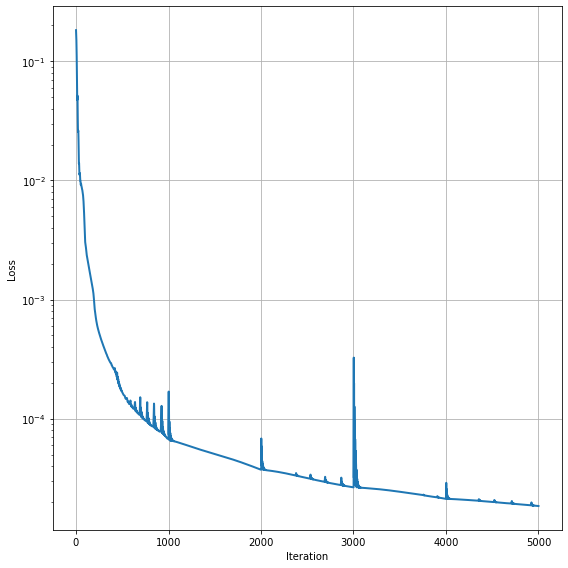

In [72]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Loss = 1.847526e-05:   0%|▏                                                                                                                                                         | 1/1000 [00:02<38:48,  2.33s/it]

New min loss =  1.847526e-05


Loss = 1.8465571e-05:   5%|███████▍                                                                                                                                                | 49/1000 [01:28<30:25,  1.92s/it]

New min loss =  1.8465571e-05


Loss = 1.8453065e-05:   5%|████████                                                                                                                                                | 53/1000 [01:38<37:53,  2.40s/it]

New min loss =  1.8453065e-05


Loss = 1.8445684e-05:   6%|█████████▎                                                                                                                                              | 61/1000 [01:57<38:49,  2.48s/it]

New min loss =  1.8445684e-05


Loss = 1.8439081e-05:   7%|██████████▍                                                                                                                                             | 69/1000 [02:17<37:33,  2.42s/it]

New min loss =  1.8439081e-05


Loss = 1.8436864e-05:   7%|██████████▉                                                                                                                                             | 72/1000 [02:26<43:05,  2.79s/it]

New min loss =  1.8436864e-05


Loss = 1.8436787e-05:   8%|███████████▍                                                                                                                                            | 75/1000 [02:36<46:56,  3.05s/it]

New min loss =  1.8436787e-05


Loss = 1.8434572e-05:   8%|███████████▌                                                                                                                                            | 76/1000 [02:39<47:04,  3.06s/it]

New min loss =  1.8434572e-05


Loss = 1.8429499e-05:   8%|████████████▏                                                                                                                                           | 80/1000 [02:49<36:58,  2.41s/it]

New min loss =  1.8429499e-05


Loss = 1.842599e-05:   8%|████████████▋                                                                                                                                            | 83/1000 [02:58<43:57,  2.88s/it]

New min loss =  1.842599e-05


Loss = 1.842318e-05:   9%|█████████████▏                                                                                                                                           | 86/1000 [03:08<47:32,  3.12s/it]

New min loss =  1.842318e-05


Loss = 1.8420358e-05:   9%|█████████████▌                                                                                                                                          | 89/1000 [03:18<48:13,  3.18s/it]

New min loss =  1.8420358e-05


Loss = 1.8417317e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:28<38:37,  2.56s/it]

New min loss =  1.8417317e-05


Loss = 1.8416815e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:31<41:21,  2.74s/it]

New min loss =  1.8416815e-05


Loss = 1.8414188e-05:  10%|██████████████▌                                                                                                                                         | 96/1000 [03:38<45:45,  3.04s/it]

New min loss =  1.8414188e-05


Loss = 1.8413264e-05:  10%|██████████████▋                                                                                                                                         | 97/1000 [03:41<46:01,  3.06s/it]

New min loss =  1.8413264e-05


Loss = 1.8410892e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:47<46:59,  3.13s/it]

New min loss =  1.8410892e-05


Loss = 1.8409837e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:51<46:53,  3.13s/it]

New min loss =  1.8409837e-05


Loss = 1.8409744e-05:  10%|███████████████▎                                                                                                                                       | 101/1000 [03:54<46:22,  3.09s/it]

New min loss =  1.8409744e-05


Loss = 1.8407512e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [03:57<45:37,  3.05s/it]

New min loss =  1.8407512e-05


Loss = 1.8406472e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [03:59<44:48,  3.00s/it]

New min loss =  1.8406472e-05


Loss = 1.840609e-05:  10%|███████████████▊                                                                                                                                        | 104/1000 [04:03<46:25,  3.11s/it]

New min loss =  1.840609e-05


Loss = 1.8404135e-05:  10%|███████████████▊                                                                                                                                       | 105/1000 [04:06<46:18,  3.10s/it]

New min loss =  1.8404135e-05


Loss = 1.8403078e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [04:09<35:38,  2.39s/it]

New min loss =  1.8403078e-05


Loss = 1.8402463e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [04:12<37:44,  2.54s/it]

New min loss =  1.8402463e-05


Loss = 1.8400699e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [04:15<39:49,  2.68s/it]

New min loss =  1.8400699e-05


Loss = 1.8399689e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:18<41:20,  2.79s/it]

New min loss =  1.8399689e-05


Loss = 1.8398869e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [04:21<41:52,  2.83s/it]

New min loss =  1.8398869e-05


Loss = 1.8397226e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:24<43:26,  2.93s/it]

New min loss =  1.8397226e-05


Loss = 1.8396255e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:28<45:45,  3.10s/it]

New min loss =  1.8396255e-05


Loss = 1.839529e-05:  11%|█████████████████▎                                                                                                                                      | 114/1000 [04:31<45:05,  3.05s/it]

New min loss =  1.839529e-05


Loss = 1.8393761e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [04:34<45:28,  3.08s/it]

New min loss =  1.8393761e-05


Loss = 1.8392777e-05:  12%|█████████████████▌                                                                                                                                     | 116/1000 [04:37<44:56,  3.05s/it]

New min loss =  1.8392777e-05


Loss = 1.839168e-05:  12%|█████████████████▊                                                                                                                                      | 117/1000 [04:40<44:46,  3.04s/it]

New min loss =  1.839168e-05


Loss = 1.839025e-05:  12%|█████████████████▉                                                                                                                                      | 118/1000 [04:43<44:25,  3.02s/it]

New min loss =  1.839025e-05


Loss = 1.8389273e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:46<45:09,  3.08s/it]

New min loss =  1.8389273e-05


Loss = 1.838807e-05:  12%|██████████████████▏                                                                                                                                     | 120/1000 [04:49<45:21,  3.09s/it]

New min loss =  1.838807e-05


Loss = 1.8386725e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:53<37:59,  2.60s/it]

New min loss =  1.8386725e-05


Loss = 1.8385683e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:58<44:26,  3.04s/it]

New min loss =  1.8385683e-05


Loss = 1.8384428e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [05:01<47:31,  3.26s/it]

New min loss =  1.8384428e-05


Loss = 1.8383138e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [05:05<48:24,  3.32s/it]

New min loss =  1.8383138e-05


Loss = 1.8382054e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [05:09<49:22,  3.39s/it]

New min loss =  1.8382054e-05


Loss = 1.8380759e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:12<48:37,  3.34s/it]

New min loss =  1.8380759e-05


Loss = 1.837954e-05:  13%|███████████████████▍                                                                                                                                    | 128/1000 [05:15<47:15,  3.25s/it]

New min loss =  1.837954e-05


Loss = 1.837839e-05:  13%|███████████████████▌                                                                                                                                    | 129/1000 [05:18<46:51,  3.23s/it]

New min loss =  1.837839e-05


Loss = 1.837709e-05:  13%|███████████████████▊                                                                                                                                    | 130/1000 [05:21<47:53,  3.30s/it]

New min loss =  1.837709e-05


Loss = 1.837588e-05:  13%|███████████████████▉                                                                                                                                    | 131/1000 [05:25<47:30,  3.28s/it]

New min loss =  1.837588e-05


Loss = 1.8374678e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:28<46:14,  3.20s/it]

New min loss =  1.8374678e-05


Loss = 1.837337e-05:  13%|████████████████████▏                                                                                                                                   | 133/1000 [05:31<46:46,  3.24s/it]

New min loss =  1.837337e-05


Loss = 1.8372179e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [05:34<46:49,  3.24s/it]

New min loss =  1.8372179e-05


Loss = 1.837092e-05:  14%|████████████████████▌                                                                                                                                   | 135/1000 [05:38<47:01,  3.26s/it]

New min loss =  1.837092e-05


Loss = 1.836963e-05:  14%|████████████████████▋                                                                                                                                   | 136/1000 [05:41<45:42,  3.17s/it]

New min loss =  1.836963e-05


Loss = 1.8368417e-05:  14%|████████████████████▊                                                                                                                                  | 138/1000 [05:44<34:32,  2.40s/it]

New min loss =  1.8368417e-05


Loss = 1.8367124e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [05:47<36:44,  2.56s/it]

New min loss =  1.8367124e-05


Loss = 1.8365841e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:50<39:09,  2.73s/it]

New min loss =  1.8365841e-05


Loss = 1.8364597e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [05:53<40:56,  2.86s/it]

New min loss =  1.8364597e-05


Loss = 1.83633e-05:  14%|█████████████████████▋                                                                                                                                   | 142/1000 [05:56<42:13,  2.95s/it]

New min loss =  1.83633e-05


Loss = 1.8362027e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [05:59<42:05,  2.95s/it]

New min loss =  1.8362027e-05


Loss = 1.836076e-05:  14%|█████████████████████▉                                                                                                                                  | 144/1000 [06:02<41:31,  2.91s/it]

New min loss =  1.836076e-05


Loss = 1.8359447e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [06:05<42:13,  2.96s/it]

New min loss =  1.8359447e-05


Loss = 1.8358174e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [06:08<41:57,  2.95s/it]

New min loss =  1.8358174e-05


Loss = 1.8356879e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [06:11<43:12,  3.04s/it]

New min loss =  1.8356879e-05


Loss = 1.835558e-05:  15%|██████████████████████▍                                                                                                                                 | 148/1000 [06:14<43:55,  3.09s/it]

New min loss =  1.835558e-05


Loss = 1.8354278e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [06:18<44:19,  3.13s/it]

New min loss =  1.8354278e-05


Loss = 1.8352968e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [06:21<44:20,  3.13s/it]

New min loss =  1.8352968e-05


Loss = 1.8351655e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [06:24<44:22,  3.14s/it]

New min loss =  1.8351655e-05


Loss = 1.8350365e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [06:27<44:32,  3.15s/it]

New min loss =  1.8350365e-05


Loss = 1.8349028e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [06:30<43:14,  3.06s/it]

New min loss =  1.8349028e-05


Loss = 1.834771e-05:  16%|███████████████████████▌                                                                                                                                | 155/1000 [06:33<33:29,  2.38s/it]

New min loss =  1.834771e-05


Loss = 1.8346378e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [06:36<35:58,  2.56s/it]

New min loss =  1.8346378e-05


Loss = 1.8345028e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [06:39<37:58,  2.70s/it]

New min loss =  1.8345028e-05


Loss = 1.83437e-05:  16%|████████████████████████▏                                                                                                                                | 158/1000 [06:43<40:30,  2.89s/it]

New min loss =  1.83437e-05


Loss = 1.8342345e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [06:46<40:28,  2.89s/it]

New min loss =  1.8342345e-05


Loss = 1.8341001e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [06:49<41:15,  2.95s/it]

New min loss =  1.8341001e-05


Loss = 1.8339646e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [06:52<42:57,  3.07s/it]

New min loss =  1.8339646e-05


Loss = 1.8338282e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [06:55<42:49,  3.07s/it]

New min loss =  1.8338282e-05


Loss = 1.8336925e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [06:58<43:07,  3.09s/it]

New min loss =  1.8336925e-05


Loss = 1.8335553e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [07:01<42:58,  3.08s/it]

New min loss =  1.8335553e-05


Loss = 1.8334174e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [07:04<42:38,  3.06s/it]

New min loss =  1.8334174e-05


Loss = 1.8332801e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [07:08<44:33,  3.21s/it]

New min loss =  1.8332801e-05


Loss = 1.833142e-05:  17%|█████████████████████████▍                                                                                                                              | 167/1000 [07:11<44:36,  3.21s/it]

New min loss =  1.833142e-05


Loss = 1.8330044e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [07:14<42:41,  3.08s/it]

New min loss =  1.8330044e-05


Loss = 1.8328652e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [07:17<42:08,  3.04s/it]

New min loss =  1.8328652e-05


Loss = 1.8327266e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [07:20<41:40,  3.01s/it]

New min loss =  1.8327266e-05


Loss = 1.8325849e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [07:23<41:38,  3.01s/it]

New min loss =  1.8325849e-05


Loss = 1.8324448e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [07:26<32:16,  2.34s/it]

New min loss =  1.8324448e-05


Loss = 1.832304e-05:  17%|██████████████████████████▍                                                                                                                             | 174/1000 [07:29<34:23,  2.50s/it]

New min loss =  1.832304e-05


Loss = 1.8321625e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [07:32<36:36,  2.66s/it]

New min loss =  1.8321625e-05


Loss = 1.8320208e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:35<38:01,  2.77s/it]

New min loss =  1.8320208e-05


Loss = 1.8318799e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [07:38<39:20,  2.87s/it]

New min loss =  1.8318799e-05


Loss = 1.8317378e-05:  18%|██████████████████████████▉                                                                                                                            | 178/1000 [07:41<39:26,  2.88s/it]

New min loss =  1.8317378e-05


Loss = 1.831594e-05:  18%|███████████████████████████▏                                                                                                                            | 179/1000 [07:44<40:12,  2.94s/it]

New min loss =  1.831594e-05


Loss = 1.8314515e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [07:47<40:20,  2.95s/it]

New min loss =  1.8314515e-05


Loss = 1.8313081e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [07:50<40:32,  2.97s/it]

New min loss =  1.8313081e-05


Loss = 1.8311632e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [07:53<40:22,  2.96s/it]

New min loss =  1.8311632e-05


Loss = 1.831019e-05:  18%|███████████████████████████▊                                                                                                                            | 183/1000 [07:57<42:05,  3.09s/it]

New min loss =  1.831019e-05


Loss = 1.8308749e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [07:59<41:27,  3.05s/it]

New min loss =  1.8308749e-05


Loss = 1.830728e-05:  18%|████████████████████████████                                                                                                                            | 185/1000 [08:02<41:15,  3.04s/it]

New min loss =  1.830728e-05


Loss = 1.8305824e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [08:06<41:47,  3.08s/it]

New min loss =  1.8305824e-05


Loss = 1.8304358e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [08:09<43:36,  3.22s/it]

New min loss =  1.8304358e-05


Loss = 1.8302893e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [08:12<43:14,  3.19s/it]

New min loss =  1.8302893e-05


Loss = 1.8301425e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [08:15<41:51,  3.10s/it]

New min loss =  1.8301425e-05


Loss = 1.8299947e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [08:18<41:03,  3.04s/it]

New min loss =  1.8299947e-05


Loss = 1.8298466e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [08:21<32:04,  2.38s/it]

New min loss =  1.8298466e-05


Loss = 1.8296989e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [08:25<34:54,  2.60s/it]

New min loss =  1.8296989e-05


Loss = 1.8295497e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [08:28<37:25,  2.79s/it]

New min loss =  1.8295497e-05


Loss = 1.8294008e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [08:31<38:15,  2.85s/it]

New min loss =  1.8294008e-05


Loss = 1.8292514e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [08:34<38:32,  2.88s/it]

New min loss =  1.8292514e-05


Loss = 1.8291003e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [08:37<39:17,  2.94s/it]

New min loss =  1.8291003e-05


Loss = 1.8289491e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [08:40<39:47,  2.98s/it]

New min loss =  1.8289491e-05


Loss = 1.8287994e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [08:43<39:39,  2.97s/it]

New min loss =  1.8287994e-05


Loss = 1.8286479e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [08:46<39:03,  2.93s/it]

New min loss =  1.8286479e-05


Loss = 1.8284965e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [08:49<39:14,  2.95s/it]

New min loss =  1.8284965e-05


Loss = 1.828344e-05:  20%|██████████████████████████████▋                                                                                                                         | 202/1000 [08:52<39:47,  2.99s/it]

New min loss =  1.828344e-05


Loss = 1.8281915e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [08:55<41:45,  3.14s/it]

New min loss =  1.8281915e-05


Loss = 1.8280392e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [08:58<40:54,  3.08s/it]

New min loss =  1.8280392e-05


Loss = 1.827884e-05:  20%|███████████████████████████████▏                                                                                                                        | 205/1000 [09:01<40:31,  3.06s/it]

New min loss =  1.827884e-05


Loss = 1.8277313e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [09:04<40:28,  3.06s/it]

New min loss =  1.8277313e-05


Loss = 1.8275776e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [09:07<40:28,  3.06s/it]

New min loss =  1.8275776e-05


Loss = 1.8274224e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [09:10<39:59,  3.03s/it]

New min loss =  1.8274224e-05


Loss = 1.8272676e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [09:14<40:35,  3.08s/it]

New min loss =  1.8272676e-05


Loss = 1.827113e-05:  21%|███████████████████████████████▉                                                                                                                        | 210/1000 [09:17<41:04,  3.12s/it]

New min loss =  1.827113e-05


Loss = 1.8269571e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [09:20<31:39,  2.41s/it]

New min loss =  1.8269571e-05


Loss = 1.8268007e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [09:23<33:54,  2.58s/it]

New min loss =  1.8268007e-05


Loss = 1.8266453e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [09:26<35:54,  2.74s/it]

New min loss =  1.8266453e-05


Loss = 1.8264896e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [09:29<36:51,  2.82s/it]

New min loss =  1.8264896e-05


Loss = 1.826332e-05:  22%|████████████████████████████████▊                                                                                                                       | 216/1000 [09:32<37:12,  2.85s/it]

New min loss =  1.826332e-05


Loss = 1.826174e-05:  22%|████████████████████████████████▉                                                                                                                       | 217/1000 [09:35<37:46,  2.90s/it]

New min loss =  1.826174e-05


Loss = 1.8260169e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [09:38<37:53,  2.91s/it]

New min loss =  1.8260169e-05


Loss = 1.8258575e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [09:42<39:18,  3.02s/it]

New min loss =  1.8258575e-05


Loss = 1.8257e-05:  22%|█████████████████████████████████▉                                                                                                                        | 220/1000 [09:45<39:35,  3.05s/it]

New min loss =  1.8257e-05


Loss = 1.8255403e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [09:48<39:08,  3.02s/it]

New min loss =  1.8255403e-05


Loss = 1.8253815e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [09:50<38:36,  2.98s/it]

New min loss =  1.8253815e-05


Loss = 1.8252218e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [09:54<39:58,  3.09s/it]

New min loss =  1.8252218e-05


Loss = 1.8250605e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [09:57<39:39,  3.07s/it]

New min loss =  1.8250605e-05


Loss = 1.8248998e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [10:00<39:46,  3.08s/it]

New min loss =  1.8248998e-05


Loss = 1.8247396e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [10:03<39:20,  3.05s/it]

New min loss =  1.8247396e-05


Loss = 1.8245782e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [10:06<39:26,  3.06s/it]

New min loss =  1.8245782e-05


Loss = 1.8244156e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [10:09<39:36,  3.08s/it]

New min loss =  1.8244156e-05


Loss = 1.8242532e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [10:12<38:33,  3.00s/it]

New min loss =  1.8242532e-05


Loss = 1.8240902e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [10:15<39:01,  3.04s/it]

New min loss =  1.8240902e-05


Loss = 1.8239272e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [10:18<40:06,  3.13s/it]

New min loss =  1.8239272e-05


Loss = 1.823763e-05:  23%|███████████████████████████████████▍                                                                                                                    | 233/1000 [10:22<31:36,  2.47s/it]

New min loss =  1.823763e-05


Loss = 1.8235996e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [10:25<35:13,  2.76s/it]

New min loss =  1.8235996e-05


Loss = 1.8234352e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [10:29<37:07,  2.91s/it]

New min loss =  1.8234352e-05


Loss = 1.8232706e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [10:33<40:14,  3.16s/it]

New min loss =  1.8232706e-05


Loss = 1.8231058e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [10:35<38:49,  3.05s/it]

New min loss =  1.8231058e-05


Loss = 1.8229413e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [10:38<38:43,  3.05s/it]

New min loss =  1.8229413e-05


Loss = 1.8227765e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [10:42<40:56,  3.23s/it]

New min loss =  1.8227765e-05


Loss = 1.8226106e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [10:46<41:59,  3.32s/it]

New min loss =  1.8226106e-05


Loss = 1.8224455e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [10:50<44:17,  3.50s/it]

New min loss =  1.8224455e-05


Loss = 1.8222785e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [10:54<46:39,  3.69s/it]

New min loss =  1.8222785e-05


Loss = 1.8221126e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [10:58<47:31,  3.77s/it]

New min loss =  1.8221126e-05


Loss = 1.8219464e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [11:02<49:09,  3.90s/it]

New min loss =  1.8219464e-05


Loss = 1.8217796e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [11:06<48:32,  3.86s/it]

New min loss =  1.8217796e-05


Loss = 1.8216122e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [11:09<48:05,  3.83s/it]

New min loss =  1.8216122e-05


Loss = 1.8214452e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [11:13<47:29,  3.78s/it]

New min loss =  1.8214452e-05


Loss = 1.8212779e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [11:17<46:14,  3.69s/it]

New min loss =  1.8212779e-05


Loss = 1.821109e-05:  25%|█████████████████████████████████████▊                                                                                                                  | 249/1000 [11:20<47:10,  3.77s/it]

New min loss =  1.821109e-05


Loss = 1.8209406e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [11:24<46:30,  3.72s/it]

New min loss =  1.8209406e-05


Loss = 1.8207715e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [11:28<47:04,  3.77s/it]

New min loss =  1.8207715e-05


Loss = 1.8206012e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [11:32<47:12,  3.79s/it]

New min loss =  1.8206012e-05


Loss = 1.8204308e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [11:35<46:03,  3.70s/it]

New min loss =  1.8204308e-05


Loss = 1.8202612e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [11:39<34:20,  2.77s/it]

New min loss =  1.8202612e-05


Loss = 1.8200904e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [11:42<36:59,  2.98s/it]

New min loss =  1.8200904e-05


Loss = 1.8199202e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [11:46<39:24,  3.18s/it]

New min loss =  1.8199202e-05


Loss = 1.8197468e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [11:50<42:07,  3.41s/it]

New min loss =  1.8197468e-05


Loss = 1.819576e-05:  26%|███████████████████████████████████████▎                                                                                                                | 259/1000 [11:54<43:51,  3.55s/it]

New min loss =  1.819576e-05


Loss = 1.819403e-05:  26%|███████████████████████████████████████▌                                                                                                                | 260/1000 [11:58<46:05,  3.74s/it]

New min loss =  1.819403e-05


Loss = 1.8192297e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [12:02<46:32,  3.78s/it]

New min loss =  1.8192297e-05


Loss = 1.8190574e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [12:06<47:25,  3.86s/it]

New min loss =  1.8190574e-05


Loss = 1.8188832e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [12:10<48:50,  3.98s/it]

New min loss =  1.8188832e-05


Loss = 1.8187096e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [12:15<52:16,  4.26s/it]

New min loss =  1.8187096e-05


Loss = 1.8185363e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [12:19<51:19,  4.19s/it]

New min loss =  1.8185363e-05


Loss = 1.818363e-05:  27%|████████████████████████████████████████▍                                                                                                               | 266/1000 [12:23<49:36,  4.06s/it]

New min loss =  1.818363e-05


Loss = 1.8181876e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [12:27<48:28,  3.97s/it]

New min loss =  1.8181876e-05


Loss = 1.8180137e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [12:31<48:29,  3.98s/it]

New min loss =  1.8180137e-05


Loss = 1.817837e-05:  27%|████████████████████████████████████████▉                                                                                                               | 269/1000 [12:35<48:38,  3.99s/it]

New min loss =  1.817837e-05


Loss = 1.8176619e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [12:39<47:45,  3.93s/it]

New min loss =  1.8176619e-05


Loss = 1.8174864e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [12:43<47:57,  3.95s/it]

New min loss =  1.8174864e-05


Loss = 1.8173085e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [12:47<48:24,  3.99s/it]

New min loss =  1.8173085e-05


Loss = 1.8171311e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [12:51<49:27,  4.08s/it]

New min loss =  1.8171311e-05


Loss = 1.8169534e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [12:55<48:26,  4.00s/it]

New min loss =  1.8169534e-05


Loss = 1.8167759e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [12:58<47:11,  3.91s/it]

New min loss =  1.8167759e-05


Loss = 1.816597e-05:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [13:02<46:26,  3.85s/it]

New min loss =  1.816597e-05


Loss = 1.816418e-05:  28%|██████████████████████████████████████████▎                                                                                                             | 278/1000 [13:06<36:49,  3.06s/it]

New min loss =  1.816418e-05


Loss = 1.8162396e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [13:10<38:43,  3.22s/it]

New min loss =  1.8162396e-05


Loss = 1.8160605e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [13:14<40:58,  3.41s/it]

New min loss =  1.8160605e-05


Loss = 1.8158808e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [13:18<41:39,  3.48s/it]

New min loss =  1.8158808e-05


Loss = 1.815701e-05:  28%|██████████████████████████████████████████▊                                                                                                             | 282/1000 [13:21<41:06,  3.43s/it]

New min loss =  1.815701e-05


Loss = 1.8155195e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [13:25<41:35,  3.48s/it]

New min loss =  1.8155195e-05


Loss = 1.8153392e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [13:29<42:54,  3.60s/it]

New min loss =  1.8153392e-05


Loss = 1.8151572e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [13:33<45:32,  3.82s/it]

New min loss =  1.8151572e-05


Loss = 1.8149773e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [13:37<44:56,  3.78s/it]

New min loss =  1.8149773e-05


Loss = 1.814795e-05:  29%|███████████████████████████████████████████▌                                                                                                            | 287/1000 [13:40<42:48,  3.60s/it]

New min loss =  1.814795e-05


Loss = 1.8146124e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [13:43<41:55,  3.53s/it]

New min loss =  1.8146124e-05


Loss = 1.8144316e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [13:47<42:46,  3.61s/it]

New min loss =  1.8144316e-05


Loss = 1.8142478e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [13:51<42:44,  3.61s/it]

New min loss =  1.8142478e-05


Loss = 1.8140647e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [13:54<42:20,  3.58s/it]

New min loss =  1.8140647e-05


Loss = 1.8138817e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [13:57<41:23,  3.51s/it]

New min loss =  1.8138817e-05


Loss = 1.8136983e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [14:01<41:12,  3.50s/it]

New min loss =  1.8136983e-05


Loss = 1.8135148e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [14:05<43:56,  3.73s/it]

New min loss =  1.8135148e-05


Loss = 1.8133314e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [14:10<46:20,  3.94s/it]

New min loss =  1.8133314e-05


Loss = 1.8131464e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [14:14<47:43,  4.07s/it]

New min loss =  1.8131464e-05


Loss = 1.812961e-05:  30%|█████████████████████████████████████████████▏                                                                                                          | 297/1000 [14:18<48:00,  4.10s/it]

New min loss =  1.812961e-05


Loss = 1.8127777e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [14:22<47:56,  4.10s/it]

New min loss =  1.8127777e-05


Loss = 1.8125907e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [14:26<48:18,  4.13s/it]

New min loss =  1.8125907e-05


Loss = 1.8124048e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [14:30<47:01,  4.03s/it]

New min loss =  1.8124048e-05


Loss = 1.8122202e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [14:35<37:05,  3.19s/it]

New min loss =  1.8122202e-05


Loss = 1.812033e-05:  30%|██████████████████████████████████████████████                                                                                                          | 303/1000 [14:39<38:50,  3.34s/it]

New min loss =  1.812033e-05


Loss = 1.8118453e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [14:43<41:26,  3.57s/it]

New min loss =  1.8118453e-05


Loss = 1.811658e-05:  30%|██████████████████████████████████████████████▎                                                                                                         | 305/1000 [14:47<42:35,  3.68s/it]

New min loss =  1.811658e-05


Loss = 1.8114695e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [14:50<42:21,  3.66s/it]

New min loss =  1.8114695e-05


Loss = 1.8112827e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [14:54<42:29,  3.68s/it]

New min loss =  1.8112827e-05


Loss = 1.8110939e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [14:58<44:03,  3.82s/it]

New min loss =  1.8110939e-05


Loss = 1.8109056e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [15:02<43:32,  3.78s/it]

New min loss =  1.8109056e-05


Loss = 1.8107157e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [15:06<43:36,  3.79s/it]

New min loss =  1.8107157e-05


Loss = 1.810526e-05:  31%|███████████████████████████████████████████████▎                                                                                                        | 311/1000 [15:10<45:04,  3.92s/it]

New min loss =  1.810526e-05


Loss = 1.8103365e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [15:14<45:22,  3.96s/it]

New min loss =  1.8103365e-05


Loss = 1.8101453e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [15:18<45:19,  3.96s/it]

New min loss =  1.8101453e-05


Loss = 1.8099558e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [15:22<45:27,  3.98s/it]

New min loss =  1.8099558e-05


Loss = 1.8097651e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [15:26<44:07,  3.86s/it]

New min loss =  1.8097651e-05


Loss = 1.8095752e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [15:30<44:44,  3.92s/it]

New min loss =  1.8095752e-05


Loss = 1.8093844e-05:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [15:34<44:38,  3.92s/it]

New min loss =  1.8093844e-05


Loss = 1.8091923e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [15:37<42:27,  3.74s/it]

New min loss =  1.8091923e-05


Loss = 1.8090004e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [15:40<42:10,  3.72s/it]

New min loss =  1.8090004e-05


Loss = 1.80881e-05:  32%|████████████████████████████████████████████████▉                                                                                                        | 320/1000 [15:44<43:04,  3.80s/it]

New min loss =  1.80881e-05


Loss = 1.808618e-05:  32%|████████████████████████████████████████████████▊                                                                                                       | 321/1000 [15:48<41:21,  3.66s/it]

New min loss =  1.808618e-05


Loss = 1.8084258e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [15:51<39:45,  3.52s/it]

New min loss =  1.8084258e-05


Loss = 1.8082332e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [15:55<39:56,  3.54s/it]

New min loss =  1.8082332e-05


Loss = 1.808041e-05:  32%|█████████████████████████████████████████████████▏                                                                                                      | 324/1000 [15:58<40:19,  3.58s/it]

New min loss =  1.808041e-05


Loss = 1.8078486e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [16:02<39:48,  3.54s/it]

New min loss =  1.8078486e-05


Loss = 1.807655e-05:  33%|█████████████████████████████████████████████████▋                                                                                                      | 327/1000 [16:05<29:13,  2.61s/it]

New min loss =  1.807655e-05


Loss = 1.8074608e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [16:08<30:20,  2.71s/it]

New min loss =  1.8074608e-05


Loss = 1.8072673e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [16:11<32:57,  2.95s/it]

New min loss =  1.8072673e-05


Loss = 1.8070716e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [16:15<36:06,  3.23s/it]

New min loss =  1.8070716e-05


Loss = 1.806878e-05:  33%|██████████████████████████████████████████████████▎                                                                                                     | 331/1000 [16:19<38:24,  3.44s/it]

New min loss =  1.806878e-05


Loss = 1.8066834e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [16:23<38:18,  3.44s/it]

New min loss =  1.8066834e-05


Loss = 1.8064886e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [16:26<37:26,  3.37s/it]

New min loss =  1.8064886e-05


Loss = 1.8062941e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [16:29<37:40,  3.39s/it]

New min loss =  1.8062941e-05


Loss = 1.8061e-05:  34%|███████████████████████████████████████████████████▌                                                                                                      | 335/1000 [16:33<37:16,  3.36s/it]

New min loss =  1.8061e-05


Loss = 1.805903e-05:  34%|███████████████████████████████████████████████████                                                                                                     | 336/1000 [16:36<38:12,  3.45s/it]

New min loss =  1.805903e-05


Loss = 1.8057082e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [16:40<38:52,  3.52s/it]

New min loss =  1.8057082e-05


Loss = 1.8055138e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [16:44<40:41,  3.69s/it]

New min loss =  1.8055138e-05


Loss = 1.805319e-05:  34%|███████████████████████████████████████████████████▌                                                                                                    | 339/1000 [16:47<37:01,  3.36s/it]

New min loss =  1.805319e-05


Loss = 1.8051234e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [16:49<34:34,  3.14s/it]

New min loss =  1.8051234e-05


Loss = 1.8049257e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [16:52<33:44,  3.07s/it]

New min loss =  1.8049257e-05


Loss = 1.8047305e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [16:55<32:09,  2.93s/it]

New min loss =  1.8047305e-05


Loss = 1.8045339e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [16:58<31:14,  2.85s/it]

New min loss =  1.8045339e-05


Loss = 1.8043373e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [17:00<30:48,  2.82s/it]

New min loss =  1.8043373e-05


Loss = 1.804138e-05:  34%|████████████████████████████████████████████████████▍                                                                                                   | 345/1000 [17:03<30:06,  2.76s/it]

New min loss =  1.804138e-05


Loss = 1.8039409e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [17:06<30:31,  2.80s/it]

New min loss =  1.8039409e-05


Loss = 1.8037423e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [17:09<31:04,  2.86s/it]

New min loss =  1.8037423e-05


Loss = 1.8035442e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [17:12<32:34,  3.00s/it]

New min loss =  1.8035442e-05


Loss = 1.8033466e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [17:16<34:54,  3.22s/it]

New min loss =  1.8033466e-05


Loss = 1.8031464e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [17:20<36:14,  3.35s/it]

New min loss =  1.8031464e-05


Loss = 1.8029481e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [17:23<37:54,  3.50s/it]

New min loss =  1.8029481e-05


Loss = 1.8027484e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [17:27<29:53,  2.77s/it]

New min loss =  1.8027484e-05


Loss = 1.8025485e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [17:31<32:18,  3.00s/it]

New min loss =  1.8025485e-05


Loss = 1.8023477e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [17:35<34:08,  3.18s/it]

New min loss =  1.8023477e-05


Loss = 1.802148e-05:  36%|██████████████████████████████████████████████████████                                                                                                  | 356/1000 [17:38<34:51,  3.25s/it]

New min loss =  1.802148e-05


Loss = 1.8019473e-05:  36%|█████████████████████████████████████████████████████▉                                                                                                 | 357/1000 [17:42<36:23,  3.40s/it]

New min loss =  1.8019473e-05


Loss = 1.8017481e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [17:45<36:54,  3.45s/it]

New min loss =  1.8017481e-05


Loss = 1.8015468e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [17:49<37:44,  3.53s/it]

New min loss =  1.8015468e-05


Loss = 1.8013472e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [17:53<38:01,  3.56s/it]

New min loss =  1.8013472e-05


Loss = 1.8011438e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                | 361/1000 [17:56<37:40,  3.54s/it]

New min loss =  1.8011438e-05


Loss = 1.8009418e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [18:00<38:10,  3.59s/it]

New min loss =  1.8009418e-05


Loss = 1.8007406e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [18:04<39:07,  3.68s/it]

New min loss =  1.8007406e-05


Loss = 1.800538e-05:  36%|███████████████████████████████████████████████████████▎                                                                                                | 364/1000 [18:07<38:49,  3.66s/it]

New min loss =  1.800538e-05


Loss = 1.8003351e-05:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [18:11<39:12,  3.70s/it]

New min loss =  1.8003351e-05


Loss = 1.8001323e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [18:15<38:27,  3.64s/it]

New min loss =  1.8001323e-05


Loss = 1.799928e-05:  37%|███████████████████████████████████████████████████████▊                                                                                                | 367/1000 [18:18<38:14,  3.62s/it]

New min loss =  1.799928e-05


Loss = 1.7997252e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [18:22<39:01,  3.71s/it]

New min loss =  1.7997252e-05


Loss = 1.7995215e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [18:26<39:07,  3.72s/it]

New min loss =  1.7995215e-05


Loss = 1.7993169e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [18:29<37:30,  3.57s/it]

New min loss =  1.7993169e-05


Loss = 1.7991135e-05:  37%|████████████████████████████████████████████████████████                                                                                               | 371/1000 [18:32<35:11,  3.36s/it]

New min loss =  1.7991135e-05


Loss = 1.7989092e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [18:35<34:00,  3.25s/it]

New min loss =  1.7989092e-05


Loss = 1.7987022e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [18:38<33:24,  3.20s/it]

New min loss =  1.7987022e-05


Loss = 1.7984981e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [18:41<32:37,  3.13s/it]

New min loss =  1.7984981e-05


Loss = 1.7982933e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [18:44<31:57,  3.07s/it]

New min loss =  1.7982933e-05


Loss = 1.7980876e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [18:47<31:54,  3.07s/it]

New min loss =  1.7980876e-05


Loss = 1.7978826e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [18:50<32:06,  3.09s/it]

New min loss =  1.7978826e-05


Loss = 1.797678e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                              | 378/1000 [18:53<31:43,  3.06s/it]

New min loss =  1.797678e-05


Loss = 1.7974724e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 380/1000 [18:56<24:39,  2.39s/it]

New min loss =  1.7974724e-05


Loss = 1.7972676e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [19:00<27:04,  2.62s/it]

New min loss =  1.7972676e-05


Loss = 1.7970613e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [19:03<28:36,  2.78s/it]

New min loss =  1.7970613e-05


Loss = 1.7968548e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [19:06<30:07,  2.93s/it]

New min loss =  1.7968548e-05


Loss = 1.7966486e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [19:09<28:10,  2.74s/it]

New min loss =  1.7966486e-05


Loss = 1.7964418e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [19:11<25:57,  2.53s/it]

New min loss =  1.7964418e-05


Loss = 1.7962357e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [19:13<24:35,  2.40s/it]

New min loss =  1.7962357e-05


Loss = 1.796028e-05:  39%|██████████████████████████████████████████████████████████▊                                                                                             | 387/1000 [19:15<23:24,  2.29s/it]

New min loss =  1.796028e-05


Loss = 1.7958215e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [19:17<22:49,  2.24s/it]

New min loss =  1.7958215e-05


Loss = 1.7956152e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [19:19<22:32,  2.21s/it]

New min loss =  1.7956152e-05


Loss = 1.7954073e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [19:21<21:41,  2.13s/it]

New min loss =  1.7954073e-05


Loss = 1.7952008e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [19:23<21:20,  2.10s/it]

New min loss =  1.7952008e-05


Loss = 1.7949937e-05:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [19:25<21:33,  2.13s/it]

New min loss =  1.7949937e-05


Loss = 1.7947865e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [19:27<21:53,  2.16s/it]

New min loss =  1.7947865e-05


Loss = 1.7945797e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [19:30<22:29,  2.23s/it]

New min loss =  1.7945797e-05


Loss = 1.794372e-05:  40%|████████████████████████████████████████████████████████████                                                                                            | 395/1000 [19:32<22:30,  2.23s/it]

New min loss =  1.794372e-05


Loss = 1.7941633e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [19:35<23:14,  2.31s/it]

New min loss =  1.7941633e-05


Loss = 1.7939561e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [19:37<24:06,  2.40s/it]

New min loss =  1.7939561e-05


Loss = 1.7937482e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [19:40<24:01,  2.39s/it]

New min loss =  1.7937482e-05


Loss = 1.7935386e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [19:42<23:35,  2.35s/it]

New min loss =  1.7935386e-05


Loss = 1.7933302e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [19:45<25:09,  2.52s/it]

New min loss =  1.7933302e-05


Loss = 1.7931216e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [19:47<25:55,  2.60s/it]

New min loss =  1.7931216e-05


Loss = 1.7929133e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [19:50<26:02,  2.61s/it]

New min loss =  1.7929133e-05


Loss = 1.7927052e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [19:53<25:59,  2.61s/it]

New min loss =  1.7927052e-05


Loss = 1.7924967e-05:  40%|█████████████████████████████████████████████████████████████                                                                                          | 404/1000 [19:55<25:57,  2.61s/it]

New min loss =  1.7924967e-05


Loss = 1.7922874e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [19:58<25:41,  2.59s/it]

New min loss =  1.7922874e-05


Loss = 1.7920793e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [20:00<25:36,  2.59s/it]

New min loss =  1.7920793e-05


Loss = 1.79187e-05:  41%|██████████████████████████████████████████████████████████████▍                                                                                          | 408/1000 [20:03<19:59,  2.03s/it]

New min loss =  1.79187e-05


Loss = 1.7916602e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [20:06<21:19,  2.17s/it]

New min loss =  1.7916602e-05


Loss = 1.7914525e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [20:08<22:21,  2.27s/it]

New min loss =  1.7914525e-05


Loss = 1.7912409e-05:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [20:11<23:13,  2.37s/it]

New min loss =  1.7912409e-05


Loss = 1.7910308e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [20:14<24:16,  2.48s/it]

New min loss =  1.7910308e-05


Loss = 1.7908204e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [20:16<24:51,  2.54s/it]

New min loss =  1.7908204e-05


Loss = 1.7906104e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [20:19<24:15,  2.48s/it]

New min loss =  1.7906104e-05


Loss = 1.790399e-05:  42%|███████████████████████████████████████████████████████████████                                                                                         | 415/1000 [20:21<24:53,  2.55s/it]

New min loss =  1.790399e-05


Loss = 1.7901879e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [20:24<25:20,  2.60s/it]

New min loss =  1.7901879e-05


Loss = 1.7899776e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [20:27<25:16,  2.60s/it]

New min loss =  1.7899776e-05


Loss = 1.7897648e-05:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [20:29<25:06,  2.59s/it]

New min loss =  1.7897648e-05


Loss = 1.7895543e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [20:32<25:14,  2.61s/it]

New min loss =  1.7895543e-05


Loss = 1.7893424e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [20:35<25:19,  2.62s/it]

New min loss =  1.7893424e-05


Loss = 1.7891303e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [20:37<25:52,  2.68s/it]

New min loss =  1.7891303e-05


Loss = 1.7889191e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [20:40<25:11,  2.62s/it]

New min loss =  1.7889191e-05


Loss = 1.7887074e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [20:42<24:52,  2.59s/it]

New min loss =  1.7887074e-05


Loss = 1.7884946e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [20:45<24:45,  2.58s/it]

New min loss =  1.7884946e-05


Loss = 1.7882832e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [20:48<25:52,  2.70s/it]

New min loss =  1.7882832e-05


Loss = 1.7880691e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [20:51<25:19,  2.65s/it]

New min loss =  1.7880691e-05


Loss = 1.7878587e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [20:53<24:35,  2.58s/it]

New min loss =  1.7878587e-05


Loss = 1.7876451e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [20:56<24:53,  2.61s/it]

New min loss =  1.7876451e-05


Loss = 1.787434e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                      | 429/1000 [20:58<25:01,  2.63s/it]

New min loss =  1.787434e-05


Loss = 1.7872193e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [21:01<25:09,  2.65s/it]

New min loss =  1.7872193e-05


Loss = 1.7870061e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [21:04<25:19,  2.67s/it]

New min loss =  1.7870061e-05


Loss = 1.786793e-05:  43%|█████████████████████████████████████████████████████████████████▋                                                                                      | 432/1000 [21:06<24:23,  2.58s/it]

New min loss =  1.786793e-05


Loss = 1.7865796e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [21:09<24:31,  2.60s/it]

New min loss =  1.7865796e-05


Loss = 1.7863646e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [21:11<24:47,  2.63s/it]

New min loss =  1.7863646e-05


Loss = 1.7861506e-05:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 435/1000 [21:14<24:26,  2.59s/it]

New min loss =  1.7861506e-05


Loss = 1.7859356e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [21:17<19:00,  2.03s/it]

New min loss =  1.7859356e-05


Loss = 1.785722e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 438/1000 [21:19<19:54,  2.13s/it]

New min loss =  1.785722e-05


Loss = 1.7855082e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [21:22<20:55,  2.24s/it]

New min loss =  1.7855082e-05


Loss = 1.7852935e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [21:25<22:26,  2.40s/it]

New min loss =  1.7852935e-05


Loss = 1.7850785e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [21:27<22:45,  2.44s/it]

New min loss =  1.7850785e-05


Loss = 1.784865e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                    | 442/1000 [21:29<22:44,  2.45s/it]

New min loss =  1.784865e-05


Loss = 1.7846496e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [21:32<23:05,  2.49s/it]

New min loss =  1.7846496e-05


Loss = 1.7844357e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [21:35<23:42,  2.56s/it]

New min loss =  1.7844357e-05


Loss = 1.7842212e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [21:38<24:13,  2.62s/it]

New min loss =  1.7842212e-05


Loss = 1.7840066e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [21:40<24:12,  2.62s/it]

New min loss =  1.7840066e-05


Loss = 1.7837927e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [21:43<23:48,  2.58s/it]

New min loss =  1.7837927e-05


Loss = 1.7835775e-05:  45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 448/1000 [21:45<23:55,  2.60s/it]

New min loss =  1.7835775e-05


Loss = 1.7833621e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [21:48<24:07,  2.63s/it]

New min loss =  1.7833621e-05


Loss = 1.7831484e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [21:51<24:16,  2.65s/it]

New min loss =  1.7831484e-05


Loss = 1.7829321e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [21:53<23:59,  2.62s/it]

New min loss =  1.7829321e-05


Loss = 1.7827158e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [21:56<23:55,  2.62s/it]

New min loss =  1.7827158e-05


Loss = 1.7825016e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [21:59<24:22,  2.67s/it]

New min loss =  1.7825016e-05


Loss = 1.7822844e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [22:01<23:59,  2.64s/it]

New min loss =  1.7822844e-05


Loss = 1.782068e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 455/1000 [22:04<23:48,  2.62s/it]

New min loss =  1.782068e-05


Loss = 1.7818526e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [22:06<23:14,  2.56s/it]

New min loss =  1.7818526e-05


Loss = 1.781636e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                  | 457/1000 [22:09<23:15,  2.57s/it]

New min loss =  1.781636e-05


Loss = 1.7814204e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [22:12<23:34,  2.61s/it]

New min loss =  1.7814204e-05


Loss = 1.7812024e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [22:14<24:03,  2.67s/it]

New min loss =  1.7812024e-05


Loss = 1.780987e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 460/1000 [22:16<21:59,  2.44s/it]

New min loss =  1.780987e-05


Loss = 1.780771e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                  | 461/1000 [22:18<20:57,  2.33s/it]

New min loss =  1.780771e-05


Loss = 1.7805556e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 462/1000 [22:21<20:45,  2.32s/it]

New min loss =  1.7805556e-05


Loss = 1.7803395e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 463/1000 [22:23<20:05,  2.24s/it]

New min loss =  1.7803395e-05


Loss = 1.7801225e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [22:25<19:37,  2.20s/it]

New min loss =  1.7801225e-05


Loss = 1.7799062e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [22:27<18:57,  2.13s/it]

New min loss =  1.7799062e-05


Loss = 1.7796909e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [22:29<14:29,  1.63s/it]

New min loss =  1.7796909e-05


Loss = 1.779473e-05:  47%|███████████████████████████████████████████████████████████████████████▏                                                                                | 468/1000 [22:31<15:41,  1.77s/it]

New min loss =  1.779473e-05


Loss = 1.7792556e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [22:33<16:49,  1.90s/it]

New min loss =  1.7792556e-05


Loss = 1.7790391e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [22:35<16:59,  1.92s/it]

New min loss =  1.7790391e-05


Loss = 1.778821e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                                | 471/1000 [22:38<18:19,  2.08s/it]

New min loss =  1.778821e-05


Loss = 1.7786047e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 472/1000 [22:41<19:58,  2.27s/it]

New min loss =  1.7786047e-05


Loss = 1.7783865e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [22:43<20:30,  2.34s/it]

New min loss =  1.7783865e-05


Loss = 1.7781682e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [22:46<21:35,  2.46s/it]

New min loss =  1.7781682e-05


Loss = 1.7779503e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [22:48<21:17,  2.43s/it]

New min loss =  1.7779503e-05


Loss = 1.7777327e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [22:51<21:54,  2.51s/it]

New min loss =  1.7777327e-05


Loss = 1.777513e-05:  48%|████████████████████████████████████████████████████████████████████████▌                                                                               | 477/1000 [22:54<22:41,  2.60s/it]

New min loss =  1.777513e-05


Loss = 1.777296e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 478/1000 [22:56<22:41,  2.61s/it]

New min loss =  1.777296e-05


Loss = 1.7770779e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [22:59<22:23,  2.58s/it]

New min loss =  1.7770779e-05


Loss = 1.7768592e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 480/1000 [23:01<22:26,  2.59s/it]

New min loss =  1.7768592e-05


Loss = 1.7766428e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 481/1000 [23:04<22:38,  2.62s/it]

New min loss =  1.7766428e-05


Loss = 1.7764236e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [23:07<22:41,  2.63s/it]

New min loss =  1.7764236e-05


Loss = 1.7762055e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [23:09<22:19,  2.59s/it]

New min loss =  1.7762055e-05


Loss = 1.775988e-05:  48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 484/1000 [23:12<22:58,  2.67s/it]

New min loss =  1.775988e-05


Loss = 1.7757688e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [23:15<24:41,  2.88s/it]

New min loss =  1.7757688e-05


Loss = 1.7755514e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [23:19<25:03,  2.93s/it]

New min loss =  1.7755514e-05


Loss = 1.7753318e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [23:22<26:01,  3.04s/it]

New min loss =  1.7753318e-05


Loss = 1.7751137e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [23:25<26:32,  3.11s/it]

New min loss =  1.7751137e-05


Loss = 1.7748947e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [23:29<27:33,  3.24s/it]

New min loss =  1.7748947e-05


Loss = 1.7746761e-05:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 490/1000 [23:32<28:27,  3.35s/it]

New min loss =  1.7746761e-05


Loss = 1.774458e-05:  49%|██████████████████████████████████████████████████████████████████████████▋                                                                             | 491/1000 [23:36<28:30,  3.36s/it]

New min loss =  1.774458e-05


Loss = 1.774238e-05:  49%|██████████████████████████████████████████████████████████████████████████▊                                                                             | 492/1000 [23:39<28:35,  3.38s/it]

New min loss =  1.774238e-05


Loss = 1.7740196e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 493/1000 [23:42<28:23,  3.36s/it]

New min loss =  1.7740196e-05


Loss = 1.7738008e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [23:46<29:31,  3.50s/it]

New min loss =  1.7738008e-05


Loss = 1.773581e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 495/1000 [23:50<30:21,  3.61s/it]

New min loss =  1.773581e-05


Loss = 1.7733628e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [23:54<30:37,  3.65s/it]

New min loss =  1.7733628e-05


Loss = 1.773143e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                            | 498/1000 [23:57<23:34,  2.82s/it]

New min loss =  1.773143e-05


Loss = 1.772925e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                            | 499/1000 [24:01<24:40,  2.96s/it]

New min loss =  1.772925e-05


Loss = 1.7727054e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [24:04<25:31,  3.06s/it]

New min loss =  1.7727054e-05


Loss = 1.7724853e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [24:08<26:00,  3.13s/it]

New min loss =  1.7724853e-05


Loss = 1.7722663e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [24:11<26:03,  3.14s/it]

New min loss =  1.7722663e-05


Loss = 1.7720455e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [24:14<26:31,  3.20s/it]

New min loss =  1.7720455e-05


Loss = 1.7718268e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [24:18<28:00,  3.39s/it]

New min loss =  1.7718268e-05


Loss = 1.7716071e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [24:21<27:17,  3.31s/it]

New min loss =  1.7716071e-05


Loss = 1.7713866e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [24:24<27:25,  3.33s/it]

New min loss =  1.7713866e-05


Loss = 1.7711658e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [24:28<27:45,  3.38s/it]

New min loss =  1.7711658e-05


Loss = 1.770945e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                          | 508/1000 [24:31<27:13,  3.32s/it]

New min loss =  1.770945e-05


Loss = 1.7707225e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [24:35<27:56,  3.41s/it]

New min loss =  1.7707225e-05


Loss = 1.7705022e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [24:38<28:21,  3.47s/it]

New min loss =  1.7705022e-05


Loss = 1.7702812e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [24:41<27:28,  3.37s/it]

New min loss =  1.7702812e-05


Loss = 1.7700608e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [24:45<27:05,  3.33s/it]

New min loss =  1.7700608e-05


Loss = 1.7698394e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [24:48<27:17,  3.36s/it]

New min loss =  1.7698394e-05


Loss = 1.7696164e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [24:52<28:18,  3.49s/it]

New min loss =  1.7696164e-05


Loss = 1.7693948e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [24:56<28:28,  3.52s/it]

New min loss =  1.7693948e-05


Loss = 1.769173e-05:  52%|██████████████████████████████████████████████████████████████████████████████▍                                                                         | 516/1000 [24:59<28:50,  3.57s/it]

New min loss =  1.769173e-05


Loss = 1.7689508e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [25:02<27:56,  3.47s/it]

New min loss =  1.7689508e-05


Loss = 1.7687264e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [25:06<28:23,  3.53s/it]

New min loss =  1.7687264e-05


Loss = 1.7685037e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [25:10<30:11,  3.77s/it]

New min loss =  1.7685037e-05


Loss = 1.76828e-05:  52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 520/1000 [25:15<31:31,  3.94s/it]

New min loss =  1.76828e-05


Loss = 1.7680568e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [25:19<32:42,  4.10s/it]

New min loss =  1.7680568e-05


Loss = 1.7678323e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [25:23<32:35,  4.09s/it]

New min loss =  1.7678323e-05


Loss = 1.7676071e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 523/1000 [25:27<31:06,  3.91s/it]

New min loss =  1.7676071e-05


Loss = 1.767383e-05:  52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 524/1000 [25:30<30:17,  3.82s/it]

New min loss =  1.767383e-05


Loss = 1.7671578e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [25:34<29:46,  3.76s/it]

New min loss =  1.7671578e-05


Loss = 1.7669336e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [25:38<29:26,  3.73s/it]

New min loss =  1.7669336e-05


Loss = 1.7667082e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [25:42<29:58,  3.80s/it]

New min loss =  1.7667082e-05


Loss = 1.766483e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                       | 528/1000 [25:45<29:21,  3.73s/it]

New min loss =  1.766483e-05


Loss = 1.7662578e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [25:49<22:13,  2.84s/it]

New min loss =  1.7662578e-05


Loss = 1.7660313e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [25:53<23:49,  3.05s/it]

New min loss =  1.7660313e-05


Loss = 1.7658045e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [25:56<25:01,  3.21s/it]

New min loss =  1.7658045e-05


Loss = 1.7655784e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [26:00<26:47,  3.44s/it]

New min loss =  1.7655784e-05


Loss = 1.7653512e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [26:04<27:09,  3.50s/it]

New min loss =  1.7653512e-05


Loss = 1.7651246e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [26:08<27:41,  3.57s/it]

New min loss =  1.7651246e-05


Loss = 1.7648968e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [26:12<29:12,  3.78s/it]

New min loss =  1.7648968e-05


Loss = 1.7646704e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [26:16<30:56,  4.01s/it]

New min loss =  1.7646704e-05


Loss = 1.7644403e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [26:21<31:24,  4.08s/it]

New min loss =  1.7644403e-05


Loss = 1.7642138e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [26:25<32:35,  4.24s/it]

New min loss =  1.7642138e-05


Loss = 1.7639857e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [26:29<31:57,  4.17s/it]

New min loss =  1.7639857e-05


Loss = 1.7637569e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [26:34<31:56,  4.18s/it]

New min loss =  1.7637569e-05


Loss = 1.7635268e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [26:38<31:36,  4.14s/it]

New min loss =  1.7635268e-05


Loss = 1.763298e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                     | 543/1000 [26:41<30:43,  4.03s/it]

New min loss =  1.763298e-05


Loss = 1.7630673e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [26:45<30:02,  3.95s/it]

New min loss =  1.7630673e-05


Loss = 1.7628392e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [26:49<30:33,  4.03s/it]

New min loss =  1.7628392e-05


Loss = 1.7626071e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [26:54<32:32,  4.30s/it]

New min loss =  1.7626071e-05


Loss = 1.7623774e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [26:59<32:14,  4.27s/it]

New min loss =  1.7623774e-05


Loss = 1.762145e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                    | 548/1000 [27:03<31:57,  4.24s/it]

New min loss =  1.762145e-05


Loss = 1.7619144e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [27:07<31:16,  4.16s/it]

New min loss =  1.7619144e-05


Loss = 1.7616845e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [27:10<30:17,  4.04s/it]

New min loss =  1.7616845e-05


Loss = 1.761452e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▊                                                                    | 551/1000 [27:14<30:13,  4.04s/it]

New min loss =  1.761452e-05


Loss = 1.7612203e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [27:18<29:41,  3.98s/it]

New min loss =  1.7612203e-05


Loss = 1.76099e-05:  55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 553/1000 [27:22<28:45,  3.86s/it]

New min loss =  1.76099e-05


Loss = 1.7607576e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [27:26<28:36,  3.85s/it]

New min loss =  1.7607576e-05


Loss = 1.7605256e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [27:30<29:39,  4.00s/it]

New min loss =  1.7605256e-05


Loss = 1.760294e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 556/1000 [27:35<30:41,  4.15s/it]

New min loss =  1.760294e-05


Loss = 1.7600605e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [27:39<30:57,  4.19s/it]

New min loss =  1.7600605e-05


Loss = 1.7598273e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [27:43<30:14,  4.11s/it]

New min loss =  1.7598273e-05


Loss = 1.7595929e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [27:46<29:13,  3.98s/it]

New min loss =  1.7595929e-05


Loss = 1.7593604e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [27:50<29:08,  3.97s/it]

New min loss =  1.7593604e-05


Loss = 1.7591261e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [27:54<28:53,  3.95s/it]

New min loss =  1.7591261e-05


Loss = 1.7588905e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [27:58<22:20,  3.07s/it]

New min loss =  1.7588905e-05


Loss = 1.7586559e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 564/1000 [28:02<24:13,  3.33s/it]

New min loss =  1.7586559e-05


Loss = 1.758421e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 565/1000 [28:06<24:48,  3.42s/it]

New min loss =  1.758421e-05


Loss = 1.7581857e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [28:10<25:44,  3.56s/it]

New min loss =  1.7581857e-05


Loss = 1.7579514e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [28:13<25:19,  3.51s/it]

New min loss =  1.7579514e-05


Loss = 1.7577153e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [28:17<25:07,  3.49s/it]

New min loss =  1.7577153e-05


Loss = 1.7574786e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [28:20<24:56,  3.47s/it]

New min loss =  1.7574786e-05


Loss = 1.7572424e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [28:24<24:19,  3.39s/it]

New min loss =  1.7572424e-05


Loss = 1.7570066e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [28:27<23:59,  3.36s/it]

New min loss =  1.7570066e-05


Loss = 1.7567703e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [28:31<25:02,  3.51s/it]

New min loss =  1.7567703e-05


Loss = 1.7565331e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [28:35<26:10,  3.68s/it]

New min loss =  1.7565331e-05


Loss = 1.756296e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                | 574/1000 [28:39<27:09,  3.83s/it]

New min loss =  1.756296e-05


Loss = 1.7560587e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 575/1000 [28:43<26:56,  3.80s/it]

New min loss =  1.7560587e-05


Loss = 1.755822e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                | 576/1000 [28:46<26:27,  3.74s/it]

New min loss =  1.755822e-05


Loss = 1.7555847e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [28:50<25:56,  3.68s/it]

New min loss =  1.7555847e-05


Loss = 1.755347e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                | 578/1000 [28:53<25:42,  3.65s/it]

New min loss =  1.755347e-05


Loss = 1.755109e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                                | 579/1000 [28:57<25:20,  3.61s/it]

New min loss =  1.755109e-05


Loss = 1.7548711e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [29:01<25:35,  3.65s/it]

New min loss =  1.7548711e-05


Loss = 1.7546337e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [29:04<25:21,  3.63s/it]

New min loss =  1.7546337e-05


Loss = 1.7543975e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [29:08<24:35,  3.53s/it]

New min loss =  1.7543975e-05


Loss = 1.7541603e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [29:11<25:21,  3.65s/it]

New min loss =  1.7541603e-05


Loss = 1.7539218e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [29:15<25:31,  3.68s/it]

New min loss =  1.7539218e-05


Loss = 1.753685e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 585/1000 [29:19<24:56,  3.61s/it]

New min loss =  1.753685e-05


Loss = 1.7534467e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [29:22<25:14,  3.66s/it]

New min loss =  1.7534467e-05


Loss = 1.7532102e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [29:26<24:55,  3.62s/it]

New min loss =  1.7532102e-05


Loss = 1.7529705e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [29:30<25:35,  3.73s/it]

New min loss =  1.7529705e-05


Loss = 1.7527336e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [29:34<25:36,  3.74s/it]

New min loss =  1.7527336e-05


Loss = 1.7524953e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/1000 [29:37<25:07,  3.68s/it]

New min loss =  1.7524953e-05


Loss = 1.7522567e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [29:41<25:23,  3.73s/it]

New min loss =  1.7522567e-05


Loss = 1.7520182e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [29:45<24:50,  3.65s/it]

New min loss =  1.7520182e-05


Loss = 1.7517796e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 593/1000 [29:48<24:03,  3.55s/it]

New min loss =  1.7517796e-05


Loss = 1.75154e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 594/1000 [29:52<24:25,  3.61s/it]

New min loss =  1.75154e-05


Loss = 1.7513023e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [29:55<24:47,  3.67s/it]

New min loss =  1.7513023e-05


Loss = 1.7510632e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 597/1000 [29:59<19:09,  2.85s/it]

New min loss =  1.7510632e-05


Loss = 1.7508248e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [30:03<20:19,  3.03s/it]

New min loss =  1.7508248e-05


Loss = 1.7505858e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [30:07<21:33,  3.23s/it]

New min loss =  1.7505858e-05


Loss = 1.7503453e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [30:10<22:22,  3.36s/it]

New min loss =  1.7503453e-05


Loss = 1.7501066e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [30:14<23:20,  3.51s/it]

New min loss =  1.7501066e-05


Loss = 1.749866e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 602/1000 [30:18<23:32,  3.55s/it]

New min loss =  1.749866e-05


Loss = 1.7496252e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 603/1000 [30:22<23:54,  3.61s/it]

New min loss =  1.7496252e-05


Loss = 1.7493836e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [30:25<24:17,  3.68s/it]

New min loss =  1.7493836e-05


Loss = 1.749143e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 605/1000 [30:29<24:06,  3.66s/it]

New min loss =  1.749143e-05


Loss = 1.7489016e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [30:33<24:33,  3.74s/it]

New min loss =  1.7489016e-05


Loss = 1.748661e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 607/1000 [30:37<24:22,  3.72s/it]

New min loss =  1.748661e-05


Loss = 1.7484175e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [30:40<24:18,  3.72s/it]

New min loss =  1.7484175e-05


Loss = 1.7481763e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [30:44<24:06,  3.70s/it]

New min loss =  1.7481763e-05


Loss = 1.7479328e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [30:48<24:09,  3.72s/it]

New min loss =  1.7479328e-05


Loss = 1.7476905e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [30:52<24:27,  3.77s/it]

New min loss =  1.7476905e-05


Loss = 1.747444e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████                                                           | 612/1000 [30:56<24:39,  3.81s/it]

New min loss =  1.747444e-05


Loss = 1.7471986e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [30:59<23:53,  3.70s/it]

New min loss =  1.7471986e-05


Loss = 1.746953e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 614/1000 [31:03<23:59,  3.73s/it]

New min loss =  1.746953e-05


Loss = 1.7467051e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [31:06<22:58,  3.58s/it]

New min loss =  1.7467051e-05


Loss = 1.7464572e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [31:09<20:57,  3.27s/it]

New min loss =  1.7464572e-05


Loss = 1.7462096e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 617/1000 [31:11<19:11,  3.01s/it]

New min loss =  1.7462096e-05


Loss = 1.74596e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 618/1000 [31:13<17:54,  2.81s/it]

New min loss =  1.74596e-05


Loss = 1.7457118e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [31:16<17:42,  2.79s/it]

New min loss =  1.7457118e-05


Loss = 1.745462e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 620/1000 [31:19<17:06,  2.70s/it]

New min loss =  1.745462e-05


Loss = 1.7452121e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [31:21<16:42,  2.65s/it]

New min loss =  1.7452121e-05


Loss = 1.744962e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 622/1000 [31:23<16:01,  2.54s/it]

New min loss =  1.744962e-05


Loss = 1.7447095e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 623/1000 [31:26<15:50,  2.52s/it]

New min loss =  1.7447095e-05


Loss = 1.7444569e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [31:29<16:22,  2.61s/it]

New min loss =  1.7444569e-05


Loss = 1.7442053e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [31:32<17:33,  2.81s/it]

New min loss =  1.7442053e-05


Loss = 1.7439517e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [31:36<19:03,  3.06s/it]

New min loss =  1.7439517e-05


Loss = 1.743699e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 627/1000 [31:39<19:13,  3.09s/it]

New min loss =  1.743699e-05


Loss = 1.743444e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 628/1000 [31:42<19:11,  3.10s/it]

New min loss =  1.743444e-05


Loss = 1.7431916e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 629/1000 [31:45<19:24,  3.14s/it]

New min loss =  1.7431916e-05


Loss = 1.742937e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 630/1000 [31:49<20:36,  3.34s/it]

New min loss =  1.742937e-05


Loss = 1.742683e-05:  63%|████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 632/1000 [31:53<16:07,  2.63s/it]

New min loss =  1.742683e-05


Loss = 1.74243e-05:  63%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 633/1000 [31:56<17:05,  2.80s/it]

New min loss =  1.74243e-05


Loss = 1.742175e-05:  63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 634/1000 [31:59<17:11,  2.82s/it]

New min loss =  1.742175e-05


Loss = 1.7419223e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [32:02<17:38,  2.90s/it]

New min loss =  1.7419223e-05


Loss = 1.7416676e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [32:05<17:42,  2.92s/it]

New min loss =  1.7416676e-05


Loss = 1.741413e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 637/1000 [32:08<17:41,  2.92s/it]

New min loss =  1.741413e-05


Loss = 1.741159e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 638/1000 [32:11<18:23,  3.05s/it]

New min loss =  1.741159e-05


Loss = 1.7409066e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [32:15<19:24,  3.23s/it]

New min loss =  1.7409066e-05


Loss = 1.7406519e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [32:18<19:19,  3.22s/it]

New min loss =  1.7406519e-05


Loss = 1.7403967e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [32:21<19:36,  3.28s/it]

New min loss =  1.7403967e-05


Loss = 1.7401419e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [32:25<20:09,  3.38s/it]

New min loss =  1.7401419e-05


Loss = 1.739889e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 643/1000 [32:29<20:31,  3.45s/it]

New min loss =  1.739889e-05


Loss = 1.7396353e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [32:32<20:27,  3.45s/it]

New min loss =  1.7396353e-05


Loss = 1.7393813e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [32:36<20:35,  3.48s/it]

New min loss =  1.7393813e-05


Loss = 1.739127e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 646/1000 [32:39<20:27,  3.47s/it]

New min loss =  1.739127e-05


Loss = 1.7388731e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [32:43<21:07,  3.59s/it]

New min loss =  1.7388731e-05


Loss = 1.7386204e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [32:46<20:55,  3.57s/it]

New min loss =  1.7386204e-05


Loss = 1.738366e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 649/1000 [32:49<19:42,  3.37s/it]

New min loss =  1.738366e-05


Loss = 1.7381108e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [32:53<19:34,  3.36s/it]

New min loss =  1.7381108e-05


Loss = 1.7378565e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [32:56<19:23,  3.33s/it]

New min loss =  1.7378565e-05


Loss = 1.7376018e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [32:59<18:55,  3.26s/it]

New min loss =  1.7376018e-05


Loss = 1.7373468e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [33:02<18:37,  3.22s/it]

New min loss =  1.7373468e-05


Loss = 1.7370921e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [33:05<18:24,  3.19s/it]

New min loss =  1.7370921e-05


Loss = 1.7368378e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [33:08<18:15,  3.18s/it]

New min loss =  1.7368378e-05


Loss = 1.7365835e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [33:12<18:34,  3.24s/it]

New min loss =  1.7365835e-05


Loss = 1.73633e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 657/1000 [33:15<18:33,  3.25s/it]

New min loss =  1.73633e-05


Loss = 1.7360755e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [33:18<17:56,  3.15s/it]

New min loss =  1.7360755e-05


Loss = 1.7358214e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [33:21<17:40,  3.11s/it]

New min loss =  1.7358214e-05


Loss = 1.7355676e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [33:24<17:43,  3.13s/it]

New min loss =  1.7355676e-05


Loss = 1.7353139e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [33:27<17:24,  3.08s/it]

New min loss =  1.7353139e-05


Loss = 1.735059e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 662/1000 [33:31<18:33,  3.30s/it]

New min loss =  1.735059e-05


Loss = 1.7348042e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [33:34<18:42,  3.33s/it]

New min loss =  1.7348042e-05


Loss = 1.7345494e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [33:38<18:42,  3.34s/it]

New min loss =  1.7345494e-05


Loss = 1.734296e-05:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 665/1000 [33:41<19:04,  3.42s/it]

New min loss =  1.734296e-05


Loss = 1.7340417e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [33:45<19:44,  3.55s/it]

New min loss =  1.7340417e-05


Loss = 1.7337878e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [33:49<15:22,  2.78s/it]

New min loss =  1.7337878e-05


Loss = 1.733533e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 669/1000 [33:52<16:17,  2.95s/it]

New min loss =  1.733533e-05


Loss = 1.7332792e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [33:56<16:49,  3.06s/it]

New min loss =  1.7332792e-05


Loss = 1.7330252e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [33:59<17:26,  3.18s/it]

New min loss =  1.7330252e-05


Loss = 1.7327693e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [34:03<18:05,  3.31s/it]

New min loss =  1.7327693e-05


Loss = 1.732515e-05:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 673/1000 [34:06<18:18,  3.36s/it]

New min loss =  1.732515e-05


Loss = 1.732261e-05:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 674/1000 [34:10<18:28,  3.40s/it]

New min loss =  1.732261e-05


Loss = 1.7320057e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [34:14<18:49,  3.48s/it]

New min loss =  1.7320057e-05


Loss = 1.7317507e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [34:17<18:51,  3.49s/it]

New min loss =  1.7317507e-05


Loss = 1.7314956e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [34:21<18:57,  3.52s/it]

New min loss =  1.7314956e-05


Loss = 1.73124e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 678/1000 [34:24<18:48,  3.51s/it]

New min loss =  1.73124e-05


Loss = 1.7309845e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [34:28<18:53,  3.53s/it]

New min loss =  1.7309845e-05


Loss = 1.7307293e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [34:31<18:47,  3.52s/it]

New min loss =  1.7307293e-05


Loss = 1.7304732e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [34:35<19:10,  3.61s/it]

New min loss =  1.7304732e-05


Loss = 1.7302194e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [34:39<18:55,  3.57s/it]

New min loss =  1.7302194e-05


Loss = 1.7299642e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [34:42<19:24,  3.67s/it]

New min loss =  1.7299642e-05


Loss = 1.7297089e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [34:46<19:15,  3.66s/it]

New min loss =  1.7297089e-05


Loss = 1.729454e-05:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 685/1000 [34:50<19:41,  3.75s/it]

New min loss =  1.729454e-05


Loss = 1.7291992e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [34:54<19:44,  3.77s/it]

New min loss =  1.7291992e-05


Loss = 1.7289447e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [34:57<19:05,  3.66s/it]

New min loss =  1.7289447e-05


Loss = 1.7286884e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [35:01<18:51,  3.63s/it]

New min loss =  1.7286884e-05


Loss = 1.7284328e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 689/1000 [35:05<18:57,  3.66s/it]

New min loss =  1.7284328e-05


Loss = 1.7281767e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [35:08<19:13,  3.72s/it]

New min loss =  1.7281767e-05


Loss = 1.727922e-05:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 691/1000 [35:12<18:54,  3.67s/it]

New min loss =  1.727922e-05


Loss = 1.7276656e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [35:15<18:23,  3.58s/it]

New min loss =  1.7276656e-05


Loss = 1.7274102e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [35:20<19:19,  3.78s/it]

New min loss =  1.7274102e-05


Loss = 1.7271548e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [35:23<18:48,  3.69s/it]

New min loss =  1.7271548e-05


Loss = 1.7269e-05:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 695/1000 [35:27<18:33,  3.65s/it]

New min loss =  1.7269e-05


Loss = 1.7266446e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [35:30<18:36,  3.67s/it]

New min loss =  1.7266446e-05


Loss = 1.7263905e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 697/1000 [35:34<18:23,  3.64s/it]

New min loss =  1.7263905e-05


Loss = 1.7261349e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [35:38<18:14,  3.62s/it]

New min loss =  1.7261349e-05


Loss = 1.725879e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 699/1000 [35:41<18:22,  3.66s/it]

New min loss =  1.725879e-05


Loss = 1.7256245e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [35:45<18:15,  3.65s/it]

New min loss =  1.7256245e-05


Loss = 1.7253704e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [35:48<18:01,  3.62s/it]

New min loss =  1.7253704e-05


Loss = 1.7251152e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [35:52<17:53,  3.60s/it]

New min loss =  1.7251152e-05


Loss = 1.7248616e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [35:55<17:28,  3.53s/it]

New min loss =  1.7248616e-05


Loss = 1.7246064e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [35:59<13:15,  2.70s/it]

New min loss =  1.7246064e-05


Loss = 1.7243523e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [36:03<14:48,  3.02s/it]

New min loss =  1.7243523e-05


Loss = 1.724097e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 707/1000 [36:07<15:53,  3.25s/it]

New min loss =  1.724097e-05


Loss = 1.7238423e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [36:11<17:19,  3.56s/it]

New min loss =  1.7238423e-05


Loss = 1.7235881e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [36:15<17:23,  3.59s/it]

New min loss =  1.7235881e-05


Loss = 1.7233328e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [36:19<17:57,  3.72s/it]

New min loss =  1.7233328e-05


Loss = 1.7230792e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 711/1000 [36:22<17:43,  3.68s/it]

New min loss =  1.7230792e-05


Loss = 1.7228258e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [36:26<17:26,  3.63s/it]

New min loss =  1.7228258e-05


Loss = 1.7225715e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [36:28<15:42,  3.29s/it]

New min loss =  1.7225715e-05


Loss = 1.722317e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 714/1000 [36:31<14:17,  3.00s/it]

New min loss =  1.722317e-05


Loss = 1.7220644e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [36:33<13:19,  2.80s/it]

New min loss =  1.7220644e-05


Loss = 1.7218115e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [36:36<12:58,  2.74s/it]

New min loss =  1.7218115e-05


Loss = 1.7215576e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [36:38<13:01,  2.76s/it]

New min loss =  1.7215576e-05


Loss = 1.7213037e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [36:41<12:21,  2.63s/it]

New min loss =  1.7213037e-05


Loss = 1.7210501e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [36:43<12:01,  2.57s/it]

New min loss =  1.7210501e-05


Loss = 1.7207965e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [36:46<11:39,  2.50s/it]

New min loss =  1.7207965e-05


Loss = 1.7205437e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [36:48<11:41,  2.51s/it]

New min loss =  1.7205437e-05


Loss = 1.72029e-05:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 722/1000 [36:51<12:30,  2.70s/it]

New min loss =  1.72029e-05


Loss = 1.7200362e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [36:55<13:37,  2.95s/it]

New min loss =  1.7200362e-05


Loss = 1.719783e-05:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 724/1000 [36:58<14:08,  3.07s/it]

New min loss =  1.719783e-05


Loss = 1.7195298e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [37:01<14:23,  3.14s/it]

New min loss =  1.7195298e-05


Loss = 1.7192755e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [37:05<14:43,  3.22s/it]

New min loss =  1.7192755e-05


Loss = 1.7190221e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [37:08<14:38,  3.22s/it]

New min loss =  1.7190221e-05


Loss = 1.7187695e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [37:12<15:01,  3.31s/it]

New min loss =  1.7187695e-05


Loss = 1.7185166e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [37:15<15:28,  3.43s/it]

New min loss =  1.7185166e-05


Loss = 1.7182641e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [37:19<15:31,  3.45s/it]

New min loss =  1.7182641e-05


Loss = 1.7180106e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 731/1000 [37:22<15:48,  3.52s/it]

New min loss =  1.7180106e-05


Loss = 1.7177574e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [37:26<15:55,  3.57s/it]

New min loss =  1.7177574e-05


Loss = 1.7175045e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [37:30<16:25,  3.69s/it]

New min loss =  1.7175045e-05


Loss = 1.7172504e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [37:34<16:15,  3.67s/it]

New min loss =  1.7172504e-05


Loss = 1.716998e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 735/1000 [37:37<16:07,  3.65s/it]

New min loss =  1.716998e-05


Loss = 1.716745e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 736/1000 [37:41<16:23,  3.72s/it]

New min loss =  1.716745e-05


Loss = 1.716491e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 737/1000 [37:45<16:18,  3.72s/it]

New min loss =  1.716491e-05


Loss = 1.716238e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 738/1000 [37:49<16:03,  3.68s/it]

New min loss =  1.716238e-05


Loss = 1.7159859e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [37:52<15:33,  3.58s/it]

New min loss =  1.7159859e-05


Loss = 1.7157325e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [37:55<15:28,  3.57s/it]

New min loss =  1.7157325e-05


Loss = 1.7154814e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 741/1000 [37:59<15:37,  3.62s/it]

New min loss =  1.7154814e-05


Loss = 1.7152279e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [38:03<11:56,  2.79s/it]

New min loss =  1.7152279e-05


Loss = 1.7149752e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [38:07<12:53,  3.02s/it]

New min loss =  1.7149752e-05


Loss = 1.7147242e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [38:10<13:09,  3.10s/it]

New min loss =  1.7147242e-05


Loss = 1.7144715e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [38:13<13:39,  3.23s/it]

New min loss =  1.7144715e-05


Loss = 1.7142185e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [38:17<14:19,  3.40s/it]

New min loss =  1.7142185e-05


Loss = 1.7139664e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 748/1000 [38:21<14:58,  3.57s/it]

New min loss =  1.7139664e-05


Loss = 1.7137156e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [38:25<15:10,  3.63s/it]

New min loss =  1.7137156e-05


Loss = 1.7134642e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [38:29<15:00,  3.60s/it]

New min loss =  1.7134642e-05


Loss = 1.7132117e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 751/1000 [38:32<14:56,  3.60s/it]

New min loss =  1.7132117e-05


Loss = 1.712962e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 752/1000 [38:36<14:56,  3.61s/it]

New min loss =  1.712962e-05


Loss = 1.712712e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 753/1000 [38:40<15:08,  3.68s/it]

New min loss =  1.712712e-05


Loss = 1.712461e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 754/1000 [38:43<15:19,  3.74s/it]

New min loss =  1.712461e-05


Loss = 1.7122104e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [38:47<15:02,  3.68s/it]

New min loss =  1.7122104e-05


Loss = 1.71196e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 756/1000 [38:51<14:42,  3.62s/it]

New min loss =  1.71196e-05


Loss = 1.7117089e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [38:54<14:42,  3.63s/it]

New min loss =  1.7117089e-05


Loss = 1.711459e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 758/1000 [38:58<14:43,  3.65s/it]

New min loss =  1.711459e-05


Loss = 1.71121e-05:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 759/1000 [39:02<14:54,  3.71s/it]

New min loss =  1.71121e-05


Loss = 1.71096e-05:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 760/1000 [39:05<14:46,  3.70s/it]

New min loss =  1.71096e-05


Loss = 1.7107113e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [39:09<14:29,  3.64s/it]

New min loss =  1.7107113e-05


Loss = 1.7104609e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [39:12<14:13,  3.59s/it]

New min loss =  1.7104609e-05


Loss = 1.710211e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 763/1000 [39:16<14:17,  3.62s/it]

New min loss =  1.710211e-05


Loss = 1.7099619e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [39:20<14:44,  3.75s/it]

New min loss =  1.7099619e-05


Loss = 1.7097125e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [39:24<14:35,  3.72s/it]

New min loss =  1.7097125e-05


Loss = 1.7094633e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 766/1000 [39:27<14:25,  3.70s/it]

New min loss =  1.7094633e-05


Loss = 1.7092147e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [39:31<14:24,  3.71s/it]

New min loss =  1.7092147e-05


Loss = 1.7089647e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [39:35<14:24,  3.72s/it]

New min loss =  1.7089647e-05


Loss = 1.7087152e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [39:38<14:12,  3.69s/it]

New min loss =  1.7087152e-05


Loss = 1.7084647e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [39:42<14:02,  3.66s/it]

New min loss =  1.7084647e-05


Loss = 1.7082166e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [39:46<14:17,  3.74s/it]

New min loss =  1.7082166e-05


Loss = 1.7079677e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [39:50<14:04,  3.71s/it]

New min loss =  1.7079677e-05


Loss = 1.7077171e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [39:53<13:53,  3.67s/it]

New min loss =  1.7077171e-05


Loss = 1.7074677e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 774/1000 [39:57<14:04,  3.74s/it]

New min loss =  1.7074677e-05


Loss = 1.7072201e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 775/1000 [40:01<13:46,  3.67s/it]

New min loss =  1.7072201e-05


Loss = 1.7069717e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [40:05<14:01,  3.76s/it]

New min loss =  1.7069717e-05


Loss = 1.7067232e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [40:09<14:13,  3.83s/it]

New min loss =  1.7067232e-05


Loss = 1.706475e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 778/1000 [40:12<14:04,  3.80s/it]

New min loss =  1.706475e-05


Loss = 1.7062259e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [40:16<14:14,  3.86s/it]

New min loss =  1.7062259e-05


Loss = 1.705977e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 780/1000 [40:20<13:58,  3.81s/it]

New min loss =  1.705977e-05


Loss = 1.7057293e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [40:24<10:35,  2.91s/it]

New min loss =  1.7057293e-05


Loss = 1.705479e-05:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 783/1000 [40:28<11:35,  3.21s/it]

New min loss =  1.705479e-05


Loss = 1.7052316e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [40:32<12:07,  3.37s/it]

New min loss =  1.7052316e-05


Loss = 1.7049824e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [40:35<12:23,  3.46s/it]

New min loss =  1.7049824e-05


Loss = 1.704733e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 786/1000 [40:39<12:28,  3.50s/it]

New min loss =  1.704733e-05


Loss = 1.7044846e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [40:43<12:32,  3.53s/it]

New min loss =  1.7044846e-05


Loss = 1.7042343e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [40:46<12:42,  3.60s/it]

New min loss =  1.7042343e-05


Loss = 1.7039842e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 789/1000 [40:50<12:37,  3.59s/it]

New min loss =  1.7039842e-05


Loss = 1.7037353e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 790/1000 [40:54<13:29,  3.86s/it]

New min loss =  1.7037353e-05


Loss = 1.7034845e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [40:59<13:49,  3.97s/it]

New min loss =  1.7034845e-05


Loss = 1.7032362e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [41:02<13:36,  3.93s/it]

New min loss =  1.7032362e-05


Loss = 1.7029859e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [41:06<13:19,  3.86s/it]

New min loss =  1.7029859e-05


Loss = 1.7027369e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [41:10<13:03,  3.80s/it]

New min loss =  1.7027369e-05


Loss = 1.7024862e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [41:13<12:48,  3.75s/it]

New min loss =  1.7024862e-05


Loss = 1.702237e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 796/1000 [41:17<12:08,  3.57s/it]

New min loss =  1.702237e-05


Loss = 1.7019875e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [41:19<10:49,  3.20s/it]

New min loss =  1.7019875e-05


Loss = 1.7017383e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [41:21<10:01,  2.98s/it]

New min loss =  1.7017383e-05


Loss = 1.7014881e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [41:24<09:17,  2.77s/it]

New min loss =  1.7014881e-05


Loss = 1.7012382e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [41:26<09:11,  2.76s/it]

New min loss =  1.7012382e-05


Loss = 1.7009883e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [41:29<08:42,  2.63s/it]

New min loss =  1.7009883e-05


Loss = 1.7007382e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 802/1000 [41:31<08:39,  2.62s/it]

New min loss =  1.7007382e-05


Loss = 1.7004882e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 803/1000 [41:34<08:49,  2.69s/it]

New min loss =  1.7004882e-05


Loss = 1.7002392e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [41:37<08:49,  2.70s/it]

New min loss =  1.7002392e-05


Loss = 1.699989e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 805/1000 [41:40<08:48,  2.71s/it]

New min loss =  1.699989e-05


Loss = 1.6997392e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [41:42<08:48,  2.72s/it]

New min loss =  1.6997392e-05


Loss = 1.6994887e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [41:46<09:55,  3.08s/it]

New min loss =  1.6994887e-05


Loss = 1.699239e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 808/1000 [41:50<10:47,  3.37s/it]

New min loss =  1.699239e-05


Loss = 1.6989885e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [41:54<11:17,  3.55s/it]

New min loss =  1.6989885e-05


Loss = 1.6987386e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [41:58<11:14,  3.55s/it]

New min loss =  1.6987386e-05


Loss = 1.6984883e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [42:01<11:04,  3.51s/it]

New min loss =  1.6984883e-05


Loss = 1.6982374e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [42:05<10:48,  3.45s/it]

New min loss =  1.6982374e-05


Loss = 1.6979886e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [42:08<10:52,  3.49s/it]

New min loss =  1.6979886e-05


Loss = 1.6977388e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [42:12<10:36,  3.42s/it]

New min loss =  1.6977388e-05


Loss = 1.6974891e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [42:15<10:37,  3.45s/it]

New min loss =  1.6974891e-05


Loss = 1.6972408e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [42:18<10:20,  3.37s/it]

New min loss =  1.6972408e-05


Loss = 1.6969896e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [42:22<10:25,  3.42s/it]

New min loss =  1.6969896e-05


Loss = 1.6967397e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [42:26<11:18,  3.73s/it]

New min loss =  1.6967397e-05


Loss = 1.6964897e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [42:31<11:56,  3.96s/it]

New min loss =  1.6964897e-05


Loss = 1.696239e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 820/1000 [42:35<11:55,  3.97s/it]

New min loss =  1.696239e-05


Loss = 1.6959882e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [42:39<09:08,  3.08s/it]

New min loss =  1.6959882e-05


Loss = 1.6957381e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [42:43<09:34,  3.24s/it]

New min loss =  1.6957381e-05


Loss = 1.6954888e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [42:46<09:43,  3.32s/it]

New min loss =  1.6954888e-05


Loss = 1.6952386e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 825/1000 [42:50<09:53,  3.39s/it]

New min loss =  1.6952386e-05


Loss = 1.6949876e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [42:54<10:20,  3.57s/it]

New min loss =  1.6949876e-05


Loss = 1.6947355e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [42:58<10:44,  3.73s/it]

New min loss =  1.6947355e-05


Loss = 1.6944865e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [43:02<10:45,  3.75s/it]

New min loss =  1.6944865e-05


Loss = 1.6942353e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [43:05<10:25,  3.66s/it]

New min loss =  1.6942353e-05


Loss = 1.6939855e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [43:09<10:22,  3.66s/it]

New min loss =  1.6939855e-05


Loss = 1.6937336e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [43:12<10:18,  3.66s/it]

New min loss =  1.6937336e-05


Loss = 1.6934824e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [43:16<10:23,  3.71s/it]

New min loss =  1.6934824e-05


Loss = 1.6932308e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [43:21<10:51,  3.90s/it]

New min loss =  1.6932308e-05


Loss = 1.6929787e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [43:24<10:32,  3.81s/it]

New min loss =  1.6929787e-05


Loss = 1.692727e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 835/1000 [43:28<10:24,  3.79s/it]

New min loss =  1.692727e-05


Loss = 1.6924749e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [43:32<10:43,  3.92s/it]

New min loss =  1.6924749e-05


Loss = 1.6922242e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [43:36<10:55,  4.02s/it]

New min loss =  1.6922242e-05


Loss = 1.6919721e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [43:40<10:38,  3.94s/it]

New min loss =  1.6919721e-05


Loss = 1.69172e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 839/1000 [43:44<10:18,  3.84s/it]

New min loss =  1.69172e-05


Loss = 1.691468e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 840/1000 [43:47<10:09,  3.81s/it]

New min loss =  1.691468e-05


Loss = 1.6912154e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [43:51<10:03,  3.80s/it]

New min loss =  1.6912154e-05


Loss = 1.6909633e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [43:55<10:13,  3.88s/it]

New min loss =  1.6909633e-05


Loss = 1.6907095e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [43:59<10:08,  3.87s/it]

New min loss =  1.6907095e-05


Loss = 1.6904572e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [44:03<09:49,  3.78s/it]

New min loss =  1.6904572e-05


Loss = 1.6902044e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [44:07<09:49,  3.81s/it]

New min loss =  1.6902044e-05


Loss = 1.6899505e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [44:11<10:10,  3.96s/it]

New min loss =  1.6899505e-05


Loss = 1.6896987e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [44:15<09:51,  3.87s/it]

New min loss =  1.6896987e-05


Loss = 1.6894453e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [44:18<09:44,  3.84s/it]

New min loss =  1.6894453e-05


Loss = 1.6891929e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [44:22<09:33,  3.80s/it]

New min loss =  1.6891929e-05


Loss = 1.68894e-05:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 850/1000 [44:26<09:23,  3.76s/it]

New min loss =  1.68894e-05


Loss = 1.6886877e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [44:29<09:05,  3.66s/it]

New min loss =  1.6886877e-05


Loss = 1.688434e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 852/1000 [44:33<08:54,  3.61s/it]

New min loss =  1.688434e-05


Loss = 1.6881799e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [44:36<08:46,  3.58s/it]

New min loss =  1.6881799e-05


Loss = 1.687927e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 854/1000 [44:40<09:14,  3.80s/it]

New min loss =  1.687927e-05


Loss = 1.6876727e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [44:45<09:25,  3.90s/it]

New min loss =  1.6876727e-05


Loss = 1.6874192e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [44:49<09:27,  3.94s/it]

New min loss =  1.6874192e-05


Loss = 1.6871647e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [44:52<09:08,  3.83s/it]

New min loss =  1.6871647e-05


Loss = 1.6869097e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [44:56<08:48,  3.72s/it]

New min loss =  1.6869097e-05


Loss = 1.6866548e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [44:59<08:42,  3.70s/it]

New min loss =  1.6866548e-05


Loss = 1.6863993e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [45:03<08:47,  3.76s/it]

New min loss =  1.6863993e-05


Loss = 1.6861435e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [45:07<09:01,  3.90s/it]

New min loss =  1.6861435e-05


Loss = 1.6858889e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [45:11<06:42,  2.94s/it]

New min loss =  1.6858889e-05


Loss = 1.6856302e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [45:15<07:10,  3.17s/it]

New min loss =  1.6856302e-05


Loss = 1.6853752e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [45:19<07:45,  3.45s/it]

New min loss =  1.6853752e-05


Loss = 1.6851181e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [45:23<07:55,  3.55s/it]

New min loss =  1.6851181e-05


Loss = 1.6848615e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [45:27<07:57,  3.59s/it]

New min loss =  1.6848615e-05


Loss = 1.6846025e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [45:30<07:59,  3.64s/it]

New min loss =  1.6846025e-05


Loss = 1.6843453e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [45:34<08:03,  3.69s/it]

New min loss =  1.6843453e-05


Loss = 1.6840882e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [45:38<07:45,  3.58s/it]

New min loss =  1.6840882e-05


Loss = 1.6838296e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [45:41<07:36,  3.54s/it]

New min loss =  1.6838296e-05


Loss = 1.68357e-05:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 872/1000 [45:44<07:28,  3.51s/it]

New min loss =  1.68357e-05


Loss = 1.6833113e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [45:48<07:26,  3.51s/it]

New min loss =  1.6833113e-05


Loss = 1.6830529e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [45:52<07:30,  3.58s/it]

New min loss =  1.6830529e-05


Loss = 1.6827928e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [45:55<07:25,  3.57s/it]

New min loss =  1.6827928e-05


Loss = 1.6825335e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [45:59<07:27,  3.61s/it]

New min loss =  1.6825335e-05


Loss = 1.6822729e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [46:02<07:21,  3.59s/it]

New min loss =  1.6822729e-05


Loss = 1.6820137e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [46:06<07:19,  3.60s/it]

New min loss =  1.6820137e-05


Loss = 1.6817532e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [46:10<07:13,  3.58s/it]

New min loss =  1.6817532e-05


Loss = 1.6814916e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [46:13<07:12,  3.60s/it]

New min loss =  1.6814916e-05


Loss = 1.6812313e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [46:17<07:12,  3.63s/it]

New min loss =  1.6812313e-05


Loss = 1.6809701e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 882/1000 [46:21<07:06,  3.61s/it]

New min loss =  1.6809701e-05


Loss = 1.6807078e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [46:24<07:02,  3.61s/it]

New min loss =  1.6807078e-05


Loss = 1.6804457e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [46:28<07:04,  3.66s/it]

New min loss =  1.6804457e-05


Loss = 1.6801838e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [46:32<07:06,  3.71s/it]

New min loss =  1.6801838e-05


Loss = 1.6799224e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 886/1000 [46:35<07:02,  3.71s/it]

New min loss =  1.6799224e-05


Loss = 1.6796588e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [46:39<06:54,  3.67s/it]

New min loss =  1.6796588e-05


Loss = 1.6793967e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [46:43<06:46,  3.63s/it]

New min loss =  1.6793967e-05


Loss = 1.6791331e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [46:46<06:21,  3.44s/it]

New min loss =  1.6791331e-05


Loss = 1.6788703e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [46:48<05:48,  3.17s/it]

New min loss =  1.6788703e-05


Loss = 1.6786063e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [46:51<05:24,  2.97s/it]

New min loss =  1.6786063e-05


Loss = 1.6783431e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [46:53<05:00,  2.78s/it]

New min loss =  1.6783431e-05


Loss = 1.6780788e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [46:55<04:40,  2.62s/it]

New min loss =  1.6780788e-05


Loss = 1.6778138e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [46:58<04:32,  2.57s/it]

New min loss =  1.6778138e-05


Loss = 1.6775495e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [47:00<04:27,  2.55s/it]

New min loss =  1.6775495e-05


Loss = 1.6772847e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [47:03<04:26,  2.57s/it]

New min loss =  1.6772847e-05


Loss = 1.6770202e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [47:05<04:25,  2.57s/it]

New min loss =  1.6770202e-05


Loss = 1.6767552e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [47:08<04:32,  2.67s/it]

New min loss =  1.6767552e-05


Loss = 1.67649e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 899/1000 [47:12<04:50,  2.87s/it]

New min loss =  1.67649e-05


Loss = 1.6762251e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [47:15<05:04,  3.04s/it]

New min loss =  1.6762251e-05


Loss = 1.6759588e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [47:19<05:19,  3.23s/it]

New min loss =  1.6759588e-05


Loss = 1.6756929e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [47:22<05:19,  3.26s/it]

New min loss =  1.6756929e-05


Loss = 1.675426e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [47:26<05:23,  3.33s/it]

New min loss =  1.675426e-05


Loss = 1.67516e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 905/1000 [47:29<04:09,  2.62s/it]

New min loss =  1.67516e-05


Loss = 1.6748925e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 906/1000 [47:33<04:32,  2.90s/it]

New min loss =  1.6748925e-05


Loss = 1.6746255e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 907/1000 [47:37<04:46,  3.08s/it]

New min loss =  1.6746255e-05


Loss = 1.6743583e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [47:40<04:58,  3.25s/it]

New min loss =  1.6743583e-05


Loss = 1.6740914e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [47:44<04:58,  3.28s/it]

New min loss =  1.6740914e-05


Loss = 1.6738228e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [47:47<05:03,  3.37s/it]

New min loss =  1.6738228e-05


Loss = 1.6735554e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [47:51<05:10,  3.49s/it]

New min loss =  1.6735554e-05


Loss = 1.6732874e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [47:55<05:15,  3.58s/it]

New min loss =  1.6732874e-05


Loss = 1.673019e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [47:58<05:14,  3.61s/it]

New min loss =  1.673019e-05


Loss = 1.6727508e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [48:02<05:05,  3.56s/it]

New min loss =  1.6727508e-05


Loss = 1.672481e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 915/1000 [48:05<04:59,  3.52s/it]

New min loss =  1.672481e-05


Loss = 1.6722115e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [48:09<05:02,  3.60s/it]

New min loss =  1.6722115e-05


Loss = 1.6719412e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [48:13<04:58,  3.60s/it]

New min loss =  1.6719412e-05


Loss = 1.6716718e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [48:16<04:53,  3.58s/it]

New min loss =  1.6716718e-05


Loss = 1.6714028e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [48:20<04:55,  3.65s/it]

New min loss =  1.6714028e-05


Loss = 1.6711321e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [48:24<04:49,  3.61s/it]

New min loss =  1.6711321e-05


Loss = 1.6708598e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [48:27<04:49,  3.67s/it]

New min loss =  1.6708598e-05


Loss = 1.6705886e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [48:31<04:49,  3.71s/it]

New min loss =  1.6705886e-05


Loss = 1.6703154e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [48:35<04:43,  3.68s/it]

New min loss =  1.6703154e-05


Loss = 1.6700424e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [48:38<04:37,  3.65s/it]

New min loss =  1.6700424e-05


Loss = 1.669766e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 925/1000 [48:42<04:27,  3.57s/it]

New min loss =  1.669766e-05


Loss = 1.66949e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 926/1000 [48:45<04:26,  3.60s/it]

New min loss =  1.66949e-05


Loss = 1.669213e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [48:49<04:24,  3.62s/it]

New min loss =  1.669213e-05


Loss = 1.6689362e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [48:53<04:22,  3.65s/it]

New min loss =  1.6689362e-05


Loss = 1.6686587e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [48:56<04:19,  3.65s/it]

New min loss =  1.6686587e-05


Loss = 1.6683814e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [49:00<04:19,  3.70s/it]

New min loss =  1.6683814e-05


Loss = 1.6681026e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [49:04<04:15,  3.70s/it]

New min loss =  1.6681026e-05


Loss = 1.6678237e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [49:08<04:24,  3.89s/it]

New min loss =  1.6678237e-05


Loss = 1.6675445e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [49:12<04:23,  3.93s/it]

New min loss =  1.6675445e-05


Loss = 1.6672662e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [49:16<04:11,  3.82s/it]

New min loss =  1.6672662e-05


Loss = 1.6669856e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [49:19<04:03,  3.74s/it]

New min loss =  1.6669856e-05


Loss = 1.6667043e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [49:23<03:56,  3.69s/it]

New min loss =  1.6667043e-05


Loss = 1.6664242e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [49:27<03:52,  3.68s/it]

New min loss =  1.6664242e-05


Loss = 1.6661434e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [49:30<03:45,  3.64s/it]

New min loss =  1.6661434e-05


Loss = 1.6658623e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [49:34<03:42,  3.64s/it]

New min loss =  1.6658623e-05


Loss = 1.6655824e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [49:37<03:32,  3.55s/it]

New min loss =  1.6655824e-05


Loss = 1.6653024e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [49:41<03:38,  3.70s/it]

New min loss =  1.6653024e-05


Loss = 1.6650203e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [49:45<03:35,  3.72s/it]

New min loss =  1.6650203e-05


Loss = 1.6647404e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [49:49<03:31,  3.71s/it]

New min loss =  1.6647404e-05


Loss = 1.6644593e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [49:52<03:28,  3.72s/it]

New min loss =  1.6644593e-05


Loss = 1.664179e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [49:56<03:17,  3.59s/it]

New min loss =  1.664179e-05


Loss = 1.6638973e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [49:59<03:13,  3.59s/it]

New min loss =  1.6638973e-05


Loss = 1.6636164e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [50:03<02:23,  2.75s/it]

New min loss =  1.6636164e-05


Loss = 1.6633356e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 949/1000 [50:07<02:36,  3.07s/it]

New min loss =  1.6633356e-05


Loss = 1.6630554e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [50:11<02:42,  3.25s/it]

New min loss =  1.6630554e-05


Loss = 1.6627735e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [50:14<02:47,  3.41s/it]

New min loss =  1.6627735e-05


Loss = 1.6624932e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [50:18<02:45,  3.45s/it]

New min loss =  1.6624932e-05


Loss = 1.6622133e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [50:22<02:45,  3.51s/it]

New min loss =  1.6622133e-05


Loss = 1.6619324e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [50:26<02:47,  3.64s/it]

New min loss =  1.6619324e-05


Loss = 1.6616517e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [50:28<02:33,  3.40s/it]

New min loss =  1.6616517e-05


Loss = 1.6613712e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [50:31<02:15,  3.08s/it]

New min loss =  1.6613712e-05


Loss = 1.6610906e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [50:33<02:05,  2.92s/it]

New min loss =  1.6610906e-05


Loss = 1.6608114e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 958/1000 [50:36<01:57,  2.79s/it]

New min loss =  1.6608114e-05


Loss = 1.6605338e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [50:38<01:50,  2.69s/it]

New min loss =  1.6605338e-05


Loss = 1.6602567e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [50:41<01:43,  2.58s/it]

New min loss =  1.6602567e-05


Loss = 1.6599812e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [50:43<01:42,  2.62s/it]

New min loss =  1.6599812e-05


Loss = 1.6597127e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 962/1000 [50:46<01:40,  2.65s/it]

New min loss =  1.6597127e-05


Loss = 1.6594522e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [50:49<01:40,  2.72s/it]

New min loss =  1.6594522e-05


Loss = 1.659205e-05:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [50:52<01:42,  2.84s/it]

New min loss =  1.659205e-05


Loss = 1.6589818e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [50:55<01:40,  2.86s/it]

New min loss =  1.6589818e-05


Loss = 1.6588014e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [50:58<01:41,  2.99s/it]

New min loss =  1.6588014e-05


Loss = 1.6586933e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [51:02<01:42,  3.09s/it]

New min loss =  1.6586933e-05


Loss = 1.6566199e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [51:58<00:43,  2.89s/it]

New min loss =  1.6566199e-05


Loss = 1.6554359e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [52:02<00:42,  3.00s/it]

New min loss =  1.6554359e-05


Loss = 1.6543823e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [52:27<00:19,  3.21s/it]

New min loss =  1.6543823e-05


Loss = 1.6512206e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [52:31<00:16,  3.39s/it]

New min loss =  1.6512206e-05


Loss = 1.6498227e-05: : 1003it [53:01,  3.61s/it]                                                                                                                                                                    

New min loss =  1.6498227e-05


Loss = 1.6488848e-05: : 1004it [53:05,  3.66s/it]

New min loss =  1.6488848e-05


Loss = 1.6481135e-05: : 1010it [53:26,  3.48s/it]

New min loss =  1.6481135e-05


Loss = 1.647398e-05: : 1011it [53:30,  3.63s/it] 

New min loss =  1.647398e-05


Loss = 1.646927e-05: : 1012it [53:33,  3.52s/it]

New min loss =  1.646927e-05


Loss = 1.6465792e-05: : 1013it [53:35,  3.19s/it]

New min loss =  1.6465792e-05


Loss = 1.6464042e-05: : 1014it [53:38,  2.97s/it]

New min loss =  1.6464042e-05


Loss = 1.64638e-05: : 1017it [53:45,  2.65s/it]  

New min loss =  1.64638e-05


Loss = 1.6459224e-05: : 1018it [53:48,  2.64s/it]

New min loss =  1.6459224e-05


Loss = 1.645321e-05: : 1019it [53:50,  2.61s/it] 

New min loss =  1.645321e-05


Loss = 1.6447946e-05: : 1020it [53:53,  2.65s/it]

New min loss =  1.6447946e-05


Loss = 1.6444148e-05: : 1021it [53:56,  2.74s/it]

New min loss =  1.6444148e-05


Loss = 1.6441205e-05: : 1022it [53:59,  2.84s/it]

New min loss =  1.6441205e-05


Loss = 1.6438582e-05: : 1023it [54:02,  2.98s/it]

New min loss =  1.6438582e-05


Loss = 1.6436392e-05: : 1024it [54:06,  3.18s/it]

New min loss =  1.6436392e-05


Loss = 1.6434851e-05: : 1025it [54:09,  3.24s/it]

New min loss =  1.6434851e-05


Loss = 1.6433487e-05: : 1026it [54:13,  3.24s/it]

New min loss =  1.6433487e-05


Loss = 1.6431435e-05: : 1027it [54:16,  3.31s/it]

New min loss =  1.6431435e-05


Loss = 1.6428372e-05: : 1028it [54:20,  3.38s/it]

New min loss =  1.6428372e-05


Loss = 1.6424734e-05: : 1029it [54:23,  3.43s/it]

New min loss =  1.6424734e-05


Loss = 1.6421174e-05: : 1030it [54:27,  3.63s/it]

New min loss =  1.6421174e-05


Loss = 1.6417944e-05: : 1031it [54:32,  3.81s/it]

New min loss =  1.6417944e-05


Loss = 1.6414904e-05: : 1032it [54:35,  3.61s/it]

New min loss =  1.6414904e-05


Loss = 1.6411886e-05: : 1033it [54:38,  3.53s/it]

New min loss =  1.6411886e-05


Loss = 1.6409018e-05: : 1034it [54:42,  3.55s/it]

New min loss =  1.6409018e-05


Loss = 1.6406468e-05: : 1035it [54:45,  3.55s/it]

New min loss =  1.6406468e-05


Loss = 1.6404227e-05: : 1037it [54:49,  2.85s/it]

New min loss =  1.6404227e-05


Loss = 1.640205e-05: : 1038it [54:53,  3.04s/it] 

New min loss =  1.640205e-05


Loss = 1.6399685e-05: : 1039it [54:56,  3.14s/it]

New min loss =  1.6399685e-05


Loss = 1.6397124e-05: : 1040it [55:00,  3.21s/it]

New min loss =  1.6397124e-05


Loss = 1.639448e-05: : 1041it [55:03,  3.19s/it] 

New min loss =  1.639448e-05


Loss = 1.6391827e-05: : 1042it [55:06,  3.19s/it]

New min loss =  1.6391827e-05


Loss = 1.6389155e-05: : 1043it [55:09,  3.27s/it]

New min loss =  1.6389155e-05


Loss = 1.6386375e-05: : 1044it [55:13,  3.30s/it]

New min loss =  1.6386375e-05


Loss = 1.6383497e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [55:16<00:00,  3.32s/it]


New min loss =  1.6383497e-05


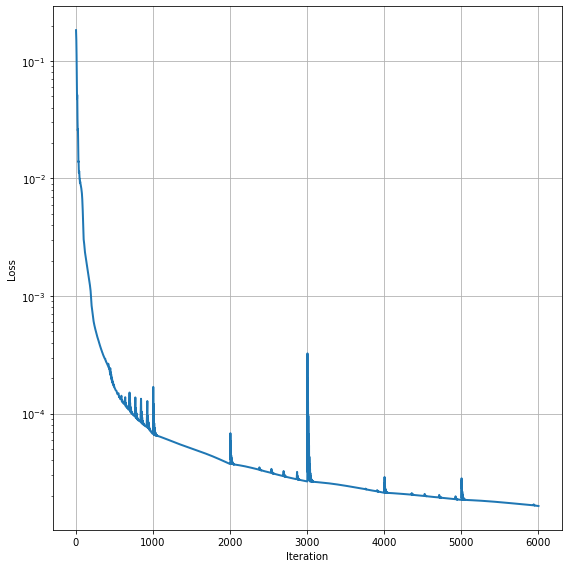

In [75]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Loss = 1.6380616e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<37:48,  2.27s/it]

New min loss =  1.6380616e-05


Loss = 1.6378377e-05:   5%|███████▊                                                                                                                                                | 51/1000 [01:57<44:12,  2.80s/it]

New min loss =  1.6378377e-05


Loss = 1.6373267e-05:   6%|████████▎                                                                                                                                               | 55/1000 [02:10<50:20,  3.20s/it]

New min loss =  1.6373267e-05


Loss = 1.636741e-05:   6%|█████████▋                                                                                                                                               | 63/1000 [02:31<45:45,  2.93s/it]

New min loss =  1.636741e-05


Loss = 1.6360547e-05:   7%|██████████▎                                                                                                                                             | 68/1000 [02:44<37:46,  2.43s/it]

New min loss =  1.6360547e-05


Loss = 1.6354481e-05:   8%|███████████▍                                                                                                                                            | 75/1000 [03:06<47:45,  3.10s/it]

New min loss =  1.6354481e-05


Loss = 1.6353166e-05:   8%|███████████▊                                                                                                                                            | 78/1000 [03:16<48:19,  3.14s/it]

New min loss =  1.6353166e-05


Loss = 1.6349439e-05:   8%|████████████▌                                                                                                                                           | 83/1000 [03:28<43:41,  2.86s/it]

New min loss =  1.6349439e-05


Loss = 1.6346776e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:38<45:26,  2.98s/it]

New min loss =  1.6346776e-05


Loss = 1.6345151e-05:   9%|█████████████▌                                                                                                                                          | 89/1000 [03:46<43:14,  2.85s/it]

New min loss =  1.6345151e-05


Loss = 1.6343613e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:54<32:47,  2.17s/it]

New min loss =  1.6343613e-05


Loss = 1.6342134e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:57<36:17,  2.40s/it]

New min loss =  1.6342134e-05


Loss = 1.634174e-05:  10%|██████████████▋                                                                                                                                          | 96/1000 [04:04<42:23,  2.81s/it]

New min loss =  1.634174e-05


Loss = 1.6339656e-05:  10%|██████████████▋                                                                                                                                         | 97/1000 [04:07<43:16,  2.88s/it]

New min loss =  1.6339656e-05


Loss = 1.6339609e-05:  10%|███████████████                                                                                                                                         | 99/1000 [04:13<42:59,  2.86s/it]

New min loss =  1.6339609e-05


Loss = 1.6337448e-05:  10%|███████████████                                                                                                                                        | 100/1000 [04:16<43:26,  2.90s/it]

New min loss =  1.6337448e-05


Loss = 1.633729e-05:  10%|███████████████▌                                                                                                                                        | 102/1000 [04:22<44:58,  3.00s/it]

New min loss =  1.633729e-05


Loss = 1.6335336e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [04:25<46:25,  3.10s/it]

New min loss =  1.6335336e-05


Loss = 1.633524e-05:  10%|███████████████▊                                                                                                                                        | 104/1000 [04:29<47:00,  3.15s/it]

New min loss =  1.633524e-05


Loss = 1.6334883e-05:  10%|███████████████▊                                                                                                                                       | 105/1000 [04:31<46:02,  3.09s/it]

New min loss =  1.6334883e-05


Loss = 1.6333175e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [04:34<34:16,  2.30s/it]

New min loss =  1.6333175e-05


Loss = 1.633278e-05:  11%|████████████████▍                                                                                                                                       | 108/1000 [04:37<37:15,  2.51s/it]

New min loss =  1.633278e-05


Loss = 1.633245e-05:  11%|████████████████▌                                                                                                                                       | 109/1000 [04:41<39:54,  2.69s/it]

New min loss =  1.633245e-05


Loss = 1.633098e-05:  11%|████████████████▋                                                                                                                                       | 110/1000 [04:44<41:59,  2.83s/it]

New min loss =  1.633098e-05


Loss = 1.6330383e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [04:47<43:09,  2.91s/it]

New min loss =  1.6330383e-05


Loss = 1.6329997e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:50<44:18,  2.99s/it]

New min loss =  1.6329997e-05


Loss = 1.6328739e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:54<46:18,  3.13s/it]

New min loss =  1.6328739e-05


Loss = 1.6328046e-05:  11%|█████████████████▏                                                                                                                                     | 114/1000 [04:57<47:25,  3.21s/it]

New min loss =  1.6328046e-05


Loss = 1.6327569e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [05:00<47:23,  3.21s/it]

New min loss =  1.6327569e-05


Loss = 1.632643e-05:  12%|█████████████████▋                                                                                                                                      | 116/1000 [05:04<49:35,  3.37s/it]

New min loss =  1.632643e-05


Loss = 1.6325697e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [05:07<49:14,  3.35s/it]

New min loss =  1.6325697e-05


Loss = 1.6325144e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [05:11<49:14,  3.35s/it]

New min loss =  1.6325144e-05


Loss = 1.6324097e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [05:14<48:10,  3.28s/it]

New min loss =  1.6324097e-05


Loss = 1.6323349e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [05:17<47:32,  3.24s/it]

New min loss =  1.6323349e-05


Loss = 1.6322729e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [05:20<36:24,  2.49s/it]

New min loss =  1.6322729e-05


Loss = 1.632173e-05:  12%|██████████████████▋                                                                                                                                     | 123/1000 [05:23<39:26,  2.70s/it]

New min loss =  1.632173e-05


Loss = 1.6320979e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [05:27<41:36,  2.85s/it]

New min loss =  1.6320979e-05


Loss = 1.6320277e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [05:30<43:27,  2.98s/it]

New min loss =  1.6320277e-05


Loss = 1.631934e-05:  13%|███████████████████▏                                                                                                                                    | 126/1000 [05:33<44:36,  3.06s/it]

New min loss =  1.631934e-05


Loss = 1.6318563e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [05:36<44:37,  3.07s/it]

New min loss =  1.6318563e-05


Loss = 1.6317827e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [05:39<43:55,  3.02s/it]

New min loss =  1.6317827e-05


Loss = 1.6316908e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [05:42<43:46,  3.02s/it]

New min loss =  1.6316908e-05


Loss = 1.6316135e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [05:46<45:01,  3.10s/it]

New min loss =  1.6316135e-05


Loss = 1.6315355e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [05:49<44:07,  3.05s/it]

New min loss =  1.6315355e-05


Loss = 1.6314452e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:51<43:49,  3.03s/it]

New min loss =  1.6314452e-05


Loss = 1.6313676e-05:  13%|████████████████████                                                                                                                                   | 133/1000 [05:55<43:52,  3.04s/it]

New min loss =  1.6313676e-05


Loss = 1.6312853e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [05:57<43:26,  3.01s/it]

New min loss =  1.6312853e-05


Loss = 1.6311968e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [06:01<43:50,  3.04s/it]

New min loss =  1.6311968e-05


Loss = 1.631117e-05:  14%|████████████████████▋                                                                                                                                   | 136/1000 [06:04<46:50,  3.25s/it]

New min loss =  1.631117e-05


Loss = 1.631034e-05:  14%|████████████████████▉                                                                                                                                   | 138/1000 [06:08<37:34,  2.62s/it]

New min loss =  1.631034e-05


Loss = 1.6309457e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [06:12<41:53,  2.92s/it]

New min loss =  1.6309457e-05


Loss = 1.630864e-05:  14%|█████████████████████▎                                                                                                                                  | 140/1000 [06:16<45:10,  3.15s/it]

New min loss =  1.630864e-05


Loss = 1.6307784e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [06:19<46:01,  3.21s/it]

New min loss =  1.6307784e-05


Loss = 1.630691e-05:  14%|█████████████████████▌                                                                                                                                  | 142/1000 [06:23<48:09,  3.37s/it]

New min loss =  1.630691e-05


Loss = 1.6306078e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [06:27<50:20,  3.52s/it]

New min loss =  1.6306078e-05


Loss = 1.6305206e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [06:31<52:12,  3.66s/it]

New min loss =  1.6305206e-05


Loss = 1.6304339e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [06:35<53:10,  3.73s/it]

New min loss =  1.6304339e-05


Loss = 1.6303495e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [06:38<52:18,  3.68s/it]

New min loss =  1.6303495e-05


Loss = 1.6302609e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [06:42<50:54,  3.58s/it]

New min loss =  1.6302609e-05


Loss = 1.630174e-05:  15%|██████████████████████▍                                                                                                                                 | 148/1000 [06:46<52:20,  3.69s/it]

New min loss =  1.630174e-05


Loss = 1.6300875e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [06:49<52:35,  3.71s/it]

New min loss =  1.6300875e-05


Loss = 1.6299984e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [06:53<52:06,  3.68s/it]

New min loss =  1.6299984e-05


Loss = 1.6299104e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [06:56<51:19,  3.63s/it]

New min loss =  1.6299104e-05


Loss = 1.629822e-05:  15%|███████████████████████                                                                                                                                 | 152/1000 [07:00<51:50,  3.67s/it]

New min loss =  1.629822e-05


Loss = 1.6297334e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [07:04<51:28,  3.65s/it]

New min loss =  1.6297334e-05


Loss = 1.629644e-05:  16%|███████████████████████▌                                                                                                                                | 155/1000 [07:07<39:35,  2.81s/it]

New min loss =  1.629644e-05


Loss = 1.6295558e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [07:11<42:35,  3.03s/it]

New min loss =  1.6295558e-05


Loss = 1.6294645e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [07:14<43:37,  3.10s/it]

New min loss =  1.6294645e-05


Loss = 1.629377e-05:  16%|████████████████████████                                                                                                                                | 158/1000 [07:18<45:33,  3.25s/it]

New min loss =  1.629377e-05


Loss = 1.6292859e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [07:22<48:08,  3.44s/it]

New min loss =  1.6292859e-05


Loss = 1.6291953e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [07:26<48:29,  3.46s/it]

New min loss =  1.6291953e-05


Loss = 1.6291067e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [07:30<50:35,  3.62s/it]

New min loss =  1.6291067e-05


Loss = 1.6290145e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [07:33<50:45,  3.63s/it]

New min loss =  1.6290145e-05


Loss = 1.6289236e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [07:37<52:07,  3.74s/it]

New min loss =  1.6289236e-05


Loss = 1.6288332e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [07:41<52:17,  3.75s/it]

New min loss =  1.6288332e-05


Loss = 1.6287408e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [07:45<52:11,  3.75s/it]

New min loss =  1.6287408e-05


Loss = 1.6286478e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [07:48<50:28,  3.63s/it]

New min loss =  1.6286478e-05


Loss = 1.6285569e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [07:52<51:04,  3.68s/it]

New min loss =  1.6285569e-05


Loss = 1.6284617e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [07:55<50:41,  3.66s/it]

New min loss =  1.6284617e-05


Loss = 1.6283693e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [07:59<50:59,  3.68s/it]

New min loss =  1.6283693e-05


Loss = 1.628277e-05:  17%|█████████████████████████▊                                                                                                                              | 170/1000 [08:03<52:13,  3.77s/it]

New min loss =  1.628277e-05


Loss = 1.6281832e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [08:07<53:05,  3.84s/it]

New min loss =  1.6281832e-05


Loss = 1.628089e-05:  17%|██████████████████████████▎                                                                                                                             | 173/1000 [08:12<42:20,  3.07s/it]

New min loss =  1.628089e-05


Loss = 1.6279944e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [08:16<45:21,  3.30s/it]

New min loss =  1.6279944e-05


Loss = 1.6279011e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [08:19<46:58,  3.42s/it]

New min loss =  1.6279011e-05


Loss = 1.6278058e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [08:24<50:00,  3.64s/it]

New min loss =  1.6278058e-05


Loss = 1.6277103e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [08:28<52:35,  3.83s/it]

New min loss =  1.6277103e-05


Loss = 1.627616e-05:  18%|███████████████████████████                                                                                                                             | 178/1000 [08:32<53:30,  3.91s/it]

New min loss =  1.627616e-05


Loss = 1.62752e-05:  18%|███████████████████████████▍                                                                                                                             | 179/1000 [08:36<53:42,  3.92s/it]

New min loss =  1.62752e-05


Loss = 1.627424e-05:  18%|███████████████████████████▎                                                                                                                            | 180/1000 [08:39<51:49,  3.79s/it]

New min loss =  1.627424e-05


Loss = 1.6273281e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [08:44<53:46,  3.94s/it]

New min loss =  1.6273281e-05


Loss = 1.6272325e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [08:48<54:57,  4.03s/it]

New min loss =  1.6272325e-05


Loss = 1.6271355e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [08:52<56:01,  4.11s/it]

New min loss =  1.6271355e-05


Loss = 1.6270382e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [08:56<55:13,  4.06s/it]

New min loss =  1.6270382e-05


Loss = 1.6269398e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [09:00<54:55,  4.04s/it]

New min loss =  1.6269398e-05


Loss = 1.6268428e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [09:04<54:27,  4.01s/it]

New min loss =  1.6268428e-05


Loss = 1.6267444e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [09:08<54:02,  3.99s/it]

New min loss =  1.6267444e-05


Loss = 1.6266467e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [09:12<54:32,  4.03s/it]

New min loss =  1.6266467e-05


Loss = 1.626547e-05:  19%|████████████████████████████▋                                                                                                                           | 189/1000 [09:16<55:31,  4.11s/it]

New min loss =  1.626547e-05


Loss = 1.6264476e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [09:21<57:16,  4.24s/it]

New min loss =  1.6264476e-05


Loss = 1.6263493e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [09:27<48:14,  3.58s/it]

New min loss =  1.6263493e-05


Loss = 1.6262495e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [09:30<48:42,  3.62s/it]

New min loss =  1.6262495e-05


Loss = 1.6261498e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [09:34<48:34,  3.62s/it]

New min loss =  1.6261498e-05


Loss = 1.6260497e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [09:38<50:01,  3.73s/it]

New min loss =  1.6260497e-05


Loss = 1.6259495e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [09:42<50:06,  3.74s/it]

New min loss =  1.6259495e-05


Loss = 1.6258484e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [09:45<49:30,  3.70s/it]

New min loss =  1.6258484e-05


Loss = 1.6257472e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [09:49<49:24,  3.70s/it]

New min loss =  1.6257472e-05


Loss = 1.6256463e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [09:53<50:21,  3.77s/it]

New min loss =  1.6256463e-05


Loss = 1.6255457e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [09:57<50:37,  3.80s/it]

New min loss =  1.6255457e-05


Loss = 1.6254435e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [10:00<48:59,  3.68s/it]

New min loss =  1.6254435e-05


Loss = 1.6253405e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [10:05<51:38,  3.88s/it]

New min loss =  1.6253405e-05


Loss = 1.6252392e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [10:09<53:14,  4.01s/it]

New min loss =  1.6252392e-05


Loss = 1.625137e-05:  20%|███████████████████████████████                                                                                                                         | 204/1000 [10:14<55:29,  4.18s/it]

New min loss =  1.625137e-05


Loss = 1.6250342e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [10:18<56:20,  4.25s/it]

New min loss =  1.6250342e-05


Loss = 1.6249305e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [10:23<58:07,  4.39s/it]

New min loss =  1.6249305e-05


Loss = 1.6248277e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [10:27<58:52,  4.46s/it]

New min loss =  1.6248277e-05


Loss = 1.6247239e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [10:32<59:19,  4.49s/it]

New min loss =  1.6247239e-05


Loss = 1.6246206e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [10:36<58:55,  4.47s/it]

New min loss =  1.6246206e-05


Loss = 1.624517e-05:  21%|███████████████████████████████▉                                                                                                                        | 210/1000 [10:40<56:18,  4.28s/it]

New min loss =  1.624517e-05


Loss = 1.624412e-05:  21%|████████████████████████████████▏                                                                                                                       | 212/1000 [10:44<40:39,  3.10s/it]

New min loss =  1.624412e-05


Loss = 1.6243064e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [10:48<43:52,  3.34s/it]

New min loss =  1.6243064e-05


Loss = 1.6242015e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [10:52<47:56,  3.66s/it]

New min loss =  1.6242015e-05


Loss = 1.6240967e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [10:57<50:47,  3.88s/it]

New min loss =  1.6240967e-05


Loss = 1.6239905e-05:  22%|████████████████████████████████▌                                                                                                                      | 216/1000 [11:01<52:30,  4.02s/it]

New min loss =  1.6239905e-05


Loss = 1.6238848e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [11:05<53:16,  4.08s/it]

New min loss =  1.6238848e-05


Loss = 1.6237782e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [11:09<52:35,  4.03s/it]

New min loss =  1.6237782e-05


Loss = 1.6236725e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [11:14<53:39,  4.12s/it]

New min loss =  1.6236725e-05


Loss = 1.623566e-05:  22%|█████████████████████████████████▍                                                                                                                      | 220/1000 [11:18<53:58,  4.15s/it]

New min loss =  1.623566e-05


Loss = 1.623459e-05:  22%|█████████████████████████████████▌                                                                                                                      | 221/1000 [11:22<55:33,  4.28s/it]

New min loss =  1.623459e-05


Loss = 1.6233513e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [11:27<55:06,  4.25s/it]

New min loss =  1.6233513e-05


Loss = 1.6232443e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [11:31<55:32,  4.29s/it]

New min loss =  1.6232443e-05


Loss = 1.623137e-05:  22%|██████████████████████████████████                                                                                                                      | 224/1000 [11:35<55:16,  4.27s/it]

New min loss =  1.623137e-05


Loss = 1.6230288e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [11:39<54:21,  4.21s/it]

New min loss =  1.6230288e-05


Loss = 1.6229198e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [11:43<54:13,  4.20s/it]

New min loss =  1.6229198e-05


Loss = 1.6228127e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [11:48<53:53,  4.18s/it]

New min loss =  1.6228127e-05


Loss = 1.6227039e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [11:52<55:49,  4.34s/it]

New min loss =  1.6227039e-05


Loss = 1.622595e-05:  23%|██████████████████████████████████▊                                                                                                                     | 229/1000 [11:57<55:46,  4.34s/it]

New min loss =  1.622595e-05


Loss = 1.6224849e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [12:01<55:46,  4.35s/it]

New min loss =  1.6224849e-05


Loss = 1.6223757e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [12:05<53:33,  4.18s/it]

New min loss =  1.6223757e-05


Loss = 1.6222646e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [12:09<41:44,  3.27s/it]

New min loss =  1.6222646e-05


Loss = 1.6221566e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [12:14<46:54,  3.67s/it]

New min loss =  1.6221566e-05


Loss = 1.6220454e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [12:19<50:48,  3.98s/it]

New min loss =  1.6220454e-05


Loss = 1.6219341e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [12:23<51:23,  4.04s/it]

New min loss =  1.6219341e-05


Loss = 1.6218233e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [12:27<49:50,  3.92s/it]

New min loss =  1.6218233e-05


Loss = 1.6217124e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [12:30<49:24,  3.89s/it]

New min loss =  1.6217124e-05


Loss = 1.6216007e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [12:34<47:20,  3.73s/it]

New min loss =  1.6216007e-05


Loss = 1.621489e-05:  24%|████████████████████████████████████▍                                                                                                                   | 240/1000 [12:37<46:17,  3.65s/it]

New min loss =  1.621489e-05


Loss = 1.6213779e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [12:41<46:53,  3.71s/it]

New min loss =  1.6213779e-05


Loss = 1.621265e-05:  24%|████████████████████████████████████▊                                                                                                                   | 242/1000 [12:45<48:10,  3.81s/it]

New min loss =  1.621265e-05


Loss = 1.6211521e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [12:49<49:26,  3.92s/it]

New min loss =  1.6211521e-05


Loss = 1.6210386e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [12:53<48:29,  3.85s/it]

New min loss =  1.6210386e-05


Loss = 1.6209262e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [12:56<46:35,  3.70s/it]

New min loss =  1.6209262e-05


Loss = 1.6208132e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [13:00<45:32,  3.62s/it]

New min loss =  1.6208132e-05


Loss = 1.6207003e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [13:03<45:10,  3.60s/it]

New min loss =  1.6207003e-05


Loss = 1.6205857e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [13:07<45:25,  3.62s/it]

New min loss =  1.6205857e-05


Loss = 1.6204722e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [13:11<47:02,  3.76s/it]

New min loss =  1.6204722e-05


Loss = 1.6203563e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [13:16<49:40,  3.97s/it]

New min loss =  1.6203563e-05


Loss = 1.6202426e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [13:20<49:35,  3.97s/it]

New min loss =  1.6202426e-05


Loss = 1.6201284e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [13:23<47:52,  3.84s/it]

New min loss =  1.6201284e-05


Loss = 1.6200129e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [13:27<47:13,  3.79s/it]

New min loss =  1.6200129e-05


Loss = 1.6198974e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [13:31<36:03,  2.90s/it]

New min loss =  1.6198974e-05


Loss = 1.6197815e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [13:35<39:30,  3.19s/it]

New min loss =  1.6197815e-05


Loss = 1.6196676e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [13:38<41:29,  3.35s/it]

New min loss =  1.6196676e-05


Loss = 1.619551e-05:  26%|███████████████████████████████████████▏                                                                                                                | 258/1000 [13:42<42:15,  3.42s/it]

New min loss =  1.619551e-05


Loss = 1.6194344e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [13:45<41:50,  3.39s/it]

New min loss =  1.6194344e-05


Loss = 1.6193182e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [13:49<43:15,  3.51s/it]

New min loss =  1.6193182e-05


Loss = 1.6192016e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [13:53<43:17,  3.51s/it]

New min loss =  1.6192016e-05


Loss = 1.6190848e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [13:56<42:22,  3.44s/it]

New min loss =  1.6190848e-05


Loss = 1.618967e-05:  26%|███████████████████████████████████████▉                                                                                                                | 263/1000 [14:00<42:51,  3.49s/it]

New min loss =  1.618967e-05


Loss = 1.6188502e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [14:03<43:55,  3.58s/it]

New min loss =  1.6188502e-05


Loss = 1.6187314e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [14:07<43:35,  3.56s/it]

New min loss =  1.6187314e-05


Loss = 1.6186143e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [14:11<46:54,  3.83s/it]

New min loss =  1.6186143e-05


Loss = 1.6184971e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [14:15<47:21,  3.88s/it]

New min loss =  1.6184971e-05


Loss = 1.6183778e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [14:19<48:25,  3.97s/it]

New min loss =  1.6183778e-05


Loss = 1.6182592e-05:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [14:23<48:06,  3.95s/it]

New min loss =  1.6182592e-05


Loss = 1.6181413e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [14:27<47:42,  3.92s/it]

New min loss =  1.6181413e-05


Loss = 1.6180218e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [14:31<48:07,  3.96s/it]

New min loss =  1.6180218e-05


Loss = 1.617903e-05:  27%|█████████████████████████████████████████▎                                                                                                              | 272/1000 [14:35<46:59,  3.87s/it]

New min loss =  1.617903e-05


Loss = 1.6177833e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [14:38<44:45,  3.69s/it]

New min loss =  1.6177833e-05


Loss = 1.6176644e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [14:42<44:10,  3.65s/it]

New min loss =  1.6176644e-05


Loss = 1.6175449e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [14:45<44:07,  3.65s/it]

New min loss =  1.6175449e-05


Loss = 1.617426e-05:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [14:49<45:09,  3.74s/it]

New min loss =  1.617426e-05


Loss = 1.6173055e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [14:53<35:11,  2.92s/it]

New min loss =  1.6173055e-05


Loss = 1.6171853e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [14:57<37:31,  3.12s/it]

New min loss =  1.6171853e-05


Loss = 1.6170645e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [15:01<40:11,  3.35s/it]

New min loss =  1.6170645e-05


Loss = 1.616944e-05:  28%|██████████████████████████████████████████▋                                                                                                             | 281/1000 [15:05<42:00,  3.51s/it]

New min loss =  1.616944e-05


Loss = 1.6168227e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [15:08<41:46,  3.49s/it]

New min loss =  1.6168227e-05


Loss = 1.6167003e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [15:12<42:20,  3.54s/it]

New min loss =  1.6167003e-05


Loss = 1.616581e-05:  28%|███████████████████████████████████████████▏                                                                                                            | 284/1000 [15:16<42:19,  3.55s/it]

New min loss =  1.616581e-05


Loss = 1.6164584e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [15:20<43:50,  3.68s/it]

New min loss =  1.6164584e-05


Loss = 1.6163383e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [15:24<45:05,  3.79s/it]

New min loss =  1.6163383e-05


Loss = 1.6162168e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [15:27<45:00,  3.79s/it]

New min loss =  1.6162168e-05


Loss = 1.6160937e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [15:31<44:33,  3.75s/it]

New min loss =  1.6160937e-05


Loss = 1.6159722e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [15:35<44:15,  3.73s/it]

New min loss =  1.6159722e-05


Loss = 1.61585e-05:  29%|████████████████████████████████████████████▎                                                                                                            | 290/1000 [15:38<42:31,  3.59s/it]

New min loss =  1.61585e-05


Loss = 1.6157268e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [15:42<43:04,  3.65s/it]

New min loss =  1.6157268e-05


Loss = 1.6156051e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [15:45<42:13,  3.58s/it]

New min loss =  1.6156051e-05


Loss = 1.6154823e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [15:49<42:11,  3.58s/it]

New min loss =  1.6154823e-05


Loss = 1.6153588e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [15:53<42:36,  3.62s/it]

New min loss =  1.6153588e-05


Loss = 1.6152368e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [15:56<41:16,  3.51s/it]

New min loss =  1.6152368e-05


Loss = 1.6151122e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [15:59<40:56,  3.49s/it]

New min loss =  1.6151122e-05


Loss = 1.6149894e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [16:03<40:42,  3.47s/it]

New min loss =  1.6149894e-05


Loss = 1.6148659e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [16:06<41:37,  3.56s/it]

New min loss =  1.6148659e-05


Loss = 1.6147414e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [16:10<42:22,  3.63s/it]

New min loss =  1.6147414e-05


Loss = 1.614618e-05:  30%|█████████████████████████████████████████████▌                                                                                                          | 300/1000 [16:14<41:48,  3.58s/it]

New min loss =  1.614618e-05


Loss = 1.6144928e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [16:17<31:10,  2.68s/it]

New min loss =  1.6144928e-05


Loss = 1.6143695e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [16:21<33:32,  2.89s/it]

New min loss =  1.6143695e-05


Loss = 1.614244e-05:  30%|██████████████████████████████████████████████▏                                                                                                         | 304/1000 [16:24<36:19,  3.13s/it]

New min loss =  1.614244e-05


Loss = 1.6141194e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [16:28<38:02,  3.28s/it]

New min loss =  1.6141194e-05


Loss = 1.6139944e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [16:31<38:13,  3.31s/it]

New min loss =  1.6139944e-05


Loss = 1.6138685e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [16:35<38:37,  3.34s/it]

New min loss =  1.6138685e-05


Loss = 1.6137436e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [16:38<39:24,  3.42s/it]

New min loss =  1.6137436e-05


Loss = 1.6136186e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [16:42<39:00,  3.39s/it]

New min loss =  1.6136186e-05


Loss = 1.613492e-05:  31%|███████████████████████████████████████████████                                                                                                         | 310/1000 [16:44<35:17,  3.07s/it]

New min loss =  1.613492e-05


Loss = 1.6133656e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [16:47<33:47,  2.94s/it]

New min loss =  1.6133656e-05


Loss = 1.6132402e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [16:49<31:02,  2.71s/it]

New min loss =  1.6132402e-05


Loss = 1.6131133e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [16:51<30:11,  2.64s/it]

New min loss =  1.6131133e-05


Loss = 1.612987e-05:  31%|███████████████████████████████████████████████▋                                                                                                        | 314/1000 [16:54<28:43,  2.51s/it]

New min loss =  1.612987e-05


Loss = 1.6128593e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [16:56<28:33,  2.50s/it]

New min loss =  1.6128593e-05


Loss = 1.6127326e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [16:59<29:55,  2.63s/it]

New min loss =  1.6127326e-05


Loss = 1.6126058e-05:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [17:01<29:33,  2.60s/it]

New min loss =  1.6126058e-05


Loss = 1.6124774e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [17:04<28:19,  2.49s/it]

New min loss =  1.6124774e-05


Loss = 1.612351e-05:  32%|████████████████████████████████████████████████▍                                                                                                       | 319/1000 [17:06<29:16,  2.58s/it]

New min loss =  1.612351e-05


Loss = 1.6122229e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [17:10<31:36,  2.79s/it]

New min loss =  1.6122229e-05


Loss = 1.6120943e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [17:14<36:58,  3.27s/it]

New min loss =  1.6120943e-05


Loss = 1.6119668e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [17:18<39:44,  3.52s/it]

New min loss =  1.6119668e-05


Loss = 1.6118378e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [17:22<41:59,  3.72s/it]

New min loss =  1.6118378e-05


Loss = 1.6117088e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [17:27<43:35,  3.87s/it]

New min loss =  1.6117088e-05


Loss = 1.6115815e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [17:30<41:16,  3.67s/it]

New min loss =  1.6115815e-05


Loss = 1.6114522e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [17:32<28:10,  2.51s/it]

New min loss =  1.6114522e-05


Loss = 1.6113228e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [17:35<28:01,  2.50s/it]

New min loss =  1.6113228e-05


Loss = 1.6111931e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [17:37<28:34,  2.55s/it]

New min loss =  1.6111931e-05


Loss = 1.611064e-05:  33%|██████████████████████████████████████████████████▏                                                                                                     | 330/1000 [17:40<28:26,  2.55s/it]

New min loss =  1.611064e-05


Loss = 1.6109354e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [17:42<28:06,  2.52s/it]

New min loss =  1.6109354e-05


Loss = 1.6108052e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [17:45<27:43,  2.49s/it]

New min loss =  1.6108052e-05


Loss = 1.6106751e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [17:47<28:27,  2.56s/it]

New min loss =  1.6106751e-05


Loss = 1.6105454e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [17:50<28:17,  2.55s/it]

New min loss =  1.6105454e-05


Loss = 1.6104152e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [17:53<31:16,  2.82s/it]

New min loss =  1.6104152e-05


Loss = 1.6102851e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [17:58<35:53,  3.24s/it]

New min loss =  1.6102851e-05


Loss = 1.610155e-05:  34%|███████████████████████████████████████████████████▏                                                                                                    | 337/1000 [18:02<39:21,  3.56s/it]

New min loss =  1.610155e-05


Loss = 1.6100254e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [18:06<41:51,  3.79s/it]

New min loss =  1.6100254e-05


Loss = 1.6098953e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [18:11<45:24,  4.12s/it]

New min loss =  1.6098953e-05


Loss = 1.6097636e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [18:16<46:14,  4.20s/it]

New min loss =  1.6097636e-05


Loss = 1.6096343e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [18:20<45:56,  4.18s/it]

New min loss =  1.6096343e-05


Loss = 1.6095037e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [18:24<45:18,  4.13s/it]

New min loss =  1.6095037e-05


Loss = 1.6093729e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [18:28<44:51,  4.10s/it]

New min loss =  1.6093729e-05


Loss = 1.6092425e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [18:30<39:25,  3.61s/it]

New min loss =  1.6092425e-05


Loss = 1.609111e-05:  34%|████████████████████████████████████████████████████▍                                                                                                   | 345/1000 [18:33<35:12,  3.23s/it]

New min loss =  1.609111e-05


Loss = 1.6089809e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [18:35<32:21,  2.97s/it]

New min loss =  1.6089809e-05


Loss = 1.6088494e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [18:38<30:53,  2.84s/it]

New min loss =  1.6088494e-05


Loss = 1.608718e-05:  35%|████████████████████████████████████████████████████▉                                                                                                   | 348/1000 [18:40<29:38,  2.73s/it]

New min loss =  1.608718e-05


Loss = 1.6085864e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [18:42<27:56,  2.58s/it]

New min loss =  1.6085864e-05


Loss = 1.608454e-05:  35%|█████████████████████████████████████████████████████▏                                                                                                  | 350/1000 [18:44<26:52,  2.48s/it]

New min loss =  1.608454e-05


Loss = 1.6083228e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [18:47<26:25,  2.44s/it]

New min loss =  1.6083228e-05


Loss = 1.6081909e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [18:49<20:43,  1.92s/it]

New min loss =  1.6081909e-05


Loss = 1.6080594e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [18:53<25:43,  2.39s/it]

New min loss =  1.6080594e-05


Loss = 1.6079264e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [18:57<30:36,  2.85s/it]

New min loss =  1.6079264e-05


Loss = 1.6077933e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [19:01<33:50,  3.15s/it]

New min loss =  1.6077933e-05


Loss = 1.607662e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                 | 357/1000 [19:05<36:33,  3.41s/it]

New min loss =  1.607662e-05


Loss = 1.6075288e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [19:10<38:57,  3.64s/it]

New min loss =  1.6075288e-05


Loss = 1.6073978e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [19:14<41:23,  3.87s/it]

New min loss =  1.6073978e-05


Loss = 1.6072634e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [19:18<40:00,  3.75s/it]

New min loss =  1.6072634e-05


Loss = 1.607131e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                 | 361/1000 [19:20<36:25,  3.42s/it]

New min loss =  1.607131e-05


Loss = 1.6069973e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [19:23<33:15,  3.13s/it]

New min loss =  1.6069973e-05


Loss = 1.6068638e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [19:25<30:28,  2.87s/it]

New min loss =  1.6068638e-05


Loss = 1.6067303e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [19:27<28:56,  2.73s/it]

New min loss =  1.6067303e-05


Loss = 1.606597e-05:  36%|███████████████████████████████████████████████████████▍                                                                                                | 365/1000 [19:30<27:51,  2.63s/it]

New min loss =  1.606597e-05


Loss = 1.6064623e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [19:32<27:21,  2.59s/it]

New min loss =  1.6064623e-05


Loss = 1.606329e-05:  37%|███████████████████████████████████████████████████████▊                                                                                                | 367/1000 [19:35<26:45,  2.54s/it]

New min loss =  1.606329e-05


Loss = 1.6061935e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [19:37<27:10,  2.58s/it]

New min loss =  1.6061935e-05


Loss = 1.606059e-05:  37%|████████████████████████████████████████████████████████                                                                                                | 369/1000 [19:40<28:38,  2.72s/it]

New min loss =  1.606059e-05


Loss = 1.605925e-05:  37%|████████████████████████████████████████████████████████▏                                                                                               | 370/1000 [19:44<31:31,  3.00s/it]

New min loss =  1.605925e-05


Loss = 1.605791e-05:  37%|████████████████████████████████████████████████████████▍                                                                                               | 371/1000 [19:49<37:36,  3.59s/it]

New min loss =  1.605791e-05


Loss = 1.605655e-05:  37%|████████████████████████████████████████████████████████▌                                                                                               | 372/1000 [19:53<39:51,  3.81s/it]

New min loss =  1.605655e-05


Loss = 1.6055217e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [19:57<40:07,  3.84s/it]

New min loss =  1.6055217e-05


Loss = 1.6053864e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [20:02<41:45,  4.00s/it]

New min loss =  1.6053864e-05


Loss = 1.6052507e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [20:06<42:19,  4.06s/it]

New min loss =  1.6052507e-05


Loss = 1.6051152e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [20:10<42:03,  4.04s/it]

New min loss =  1.6051152e-05


Loss = 1.6049793e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [20:14<43:03,  4.15s/it]

New min loss =  1.6049793e-05


Loss = 1.6048434e-05:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [20:18<42:59,  4.15s/it]

New min loss =  1.6048434e-05


Loss = 1.604707e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                              | 380/1000 [20:22<33:06,  3.20s/it]

New min loss =  1.604707e-05


Loss = 1.604572e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                              | 381/1000 [20:26<33:11,  3.22s/it]

New min loss =  1.604572e-05


Loss = 1.6044358e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [20:28<30:58,  3.01s/it]

New min loss =  1.6044358e-05


Loss = 1.6042986e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [20:31<29:24,  2.86s/it]

New min loss =  1.6042986e-05


Loss = 1.6041633e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [20:33<28:29,  2.77s/it]

New min loss =  1.6041633e-05


Loss = 1.604025e-05:  38%|██████████████████████████████████████████████████████████▌                                                                                             | 385/1000 [20:36<27:13,  2.66s/it]

New min loss =  1.604025e-05


Loss = 1.60389e-05:  39%|███████████████████████████████████████████████████████████                                                                                              | 386/1000 [20:38<25:48,  2.52s/it]

New min loss =  1.60389e-05


Loss = 1.6037524e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [20:40<25:41,  2.52s/it]

New min loss =  1.6037524e-05


Loss = 1.6036149e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [20:43<25:55,  2.54s/it]

New min loss =  1.6036149e-05


Loss = 1.6034794e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [20:46<27:01,  2.65s/it]

New min loss =  1.6034794e-05


Loss = 1.6033424e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [20:49<28:37,  2.82s/it]

New min loss =  1.6033424e-05


Loss = 1.6032043e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [20:52<29:47,  2.94s/it]

New min loss =  1.6032043e-05


Loss = 1.603067e-05:  39%|███████████████████████████████████████████████████████████▌                                                                                            | 392/1000 [20:56<33:16,  3.28s/it]

New min loss =  1.603067e-05


Loss = 1.60293e-05:  39%|████████████████████████████████████████████████████████████▏                                                                                            | 393/1000 [21:00<35:55,  3.55s/it]

New min loss =  1.60293e-05


Loss = 1.6027934e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [21:05<37:41,  3.73s/it]

New min loss =  1.6027934e-05


Loss = 1.602655e-05:  40%|████████████████████████████████████████████████████████████                                                                                            | 395/1000 [21:09<39:35,  3.93s/it]

New min loss =  1.602655e-05


Loss = 1.6025178e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [21:13<39:53,  3.96s/it]

New min loss =  1.6025178e-05


Loss = 1.6023794e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [21:15<34:33,  3.44s/it]

New min loss =  1.6023794e-05


Loss = 1.6022432e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [21:18<31:30,  3.14s/it]

New min loss =  1.6022432e-05


Loss = 1.6021044e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [21:20<29:09,  2.91s/it]

New min loss =  1.6021044e-05


Loss = 1.601966e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                           | 400/1000 [21:22<26:38,  2.66s/it]

New min loss =  1.601966e-05


Loss = 1.6018266e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [21:24<24:18,  2.43s/it]

New min loss =  1.6018266e-05


Loss = 1.6016891e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [21:26<22:48,  2.29s/it]

New min loss =  1.6016891e-05


Loss = 1.6015503e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [21:28<22:09,  2.23s/it]

New min loss =  1.6015503e-05


Loss = 1.6014104e-05:  40%|█████████████████████████████████████████████████████████████                                                                                          | 404/1000 [21:30<22:37,  2.28s/it]

New min loss =  1.6014104e-05


Loss = 1.6012727e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [21:33<22:59,  2.32s/it]

New min loss =  1.6012727e-05


Loss = 1.6011321e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [21:35<22:29,  2.27s/it]

New min loss =  1.6011321e-05


Loss = 1.6009939e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [21:38<17:50,  1.81s/it]

New min loss =  1.6009939e-05


Loss = 1.6008538e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [21:40<19:59,  2.03s/it]

New min loss =  1.6008538e-05


Loss = 1.6007147e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [21:43<21:32,  2.19s/it]

New min loss =  1.6007147e-05


Loss = 1.6005748e-05:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [21:46<22:45,  2.32s/it]

New min loss =  1.6005748e-05


Loss = 1.6004333e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [21:48<22:40,  2.31s/it]

New min loss =  1.6004333e-05


Loss = 1.6002941e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [21:51<23:26,  2.40s/it]

New min loss =  1.6002941e-05


Loss = 1.600154e-05:  41%|██████████████████████████████████████████████████████████████▉                                                                                         | 414/1000 [21:53<23:47,  2.44s/it]

New min loss =  1.600154e-05


Loss = 1.6000125e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [21:56<24:14,  2.49s/it]

New min loss =  1.6000125e-05


Loss = 1.599873e-05:  42%|███████████████████████████████████████████████████████████████▏                                                                                        | 416/1000 [21:58<24:24,  2.51s/it]

New min loss =  1.599873e-05


Loss = 1.599732e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                        | 417/1000 [22:01<24:04,  2.48s/it]

New min loss =  1.599732e-05


Loss = 1.599591e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                        | 418/1000 [22:03<24:12,  2.50s/it]

New min loss =  1.599591e-05


Loss = 1.5994501e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [22:06<24:26,  2.52s/it]

New min loss =  1.5994501e-05


Loss = 1.5993079e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [22:08<24:54,  2.58s/it]

New min loss =  1.5993079e-05


Loss = 1.599169e-05:  42%|███████████████████████████████████████████████████████████████▉                                                                                        | 421/1000 [22:11<24:51,  2.58s/it]

New min loss =  1.599169e-05


Loss = 1.5990267e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [22:13<24:09,  2.51s/it]

New min loss =  1.5990267e-05


Loss = 1.598885e-05:  42%|████████████████████████████████████████████████████████████████▎                                                                                       | 423/1000 [22:16<24:23,  2.54s/it]

New min loss =  1.598885e-05


Loss = 1.5987429e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [22:18<24:16,  2.53s/it]

New min loss =  1.5987429e-05


Loss = 1.5986021e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [22:21<23:54,  2.50s/it]

New min loss =  1.5986021e-05


Loss = 1.5984591e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [22:23<24:07,  2.52s/it]

New min loss =  1.5984591e-05


Loss = 1.5983183e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [22:26<23:29,  2.46s/it]

New min loss =  1.5983183e-05


Loss = 1.5981763e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [22:28<23:59,  2.52s/it]

New min loss =  1.5981763e-05


Loss = 1.5980346e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [22:31<23:56,  2.52s/it]

New min loss =  1.5980346e-05


Loss = 1.5978914e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [22:34<24:37,  2.59s/it]

New min loss =  1.5978914e-05


Loss = 1.59775e-05:  43%|█████████████████████████████████████████████████████████████████▉                                                                                       | 431/1000 [22:36<24:15,  2.56s/it]

New min loss =  1.59775e-05


Loss = 1.5976082e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [22:39<23:49,  2.52s/it]

New min loss =  1.5976082e-05


Loss = 1.5974652e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [22:41<23:44,  2.51s/it]

New min loss =  1.5974652e-05


Loss = 1.5973224e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [22:44<23:44,  2.52s/it]

New min loss =  1.5973224e-05


Loss = 1.5971811e-05:  44%|█████████████████████████████████████████████████████████████████▋                                                                                     | 435/1000 [22:46<23:10,  2.46s/it]

New min loss =  1.5971811e-05


Loss = 1.5970383e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [22:49<18:01,  1.92s/it]

New min loss =  1.5970383e-05


Loss = 1.5968955e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [22:51<19:15,  2.06s/it]

New min loss =  1.5968955e-05


Loss = 1.5967527e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [22:54<20:21,  2.18s/it]

New min loss =  1.5967527e-05


Loss = 1.5966085e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [22:56<21:33,  2.31s/it]

New min loss =  1.5966085e-05


Loss = 1.596466e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                     | 441/1000 [22:59<22:16,  2.39s/it]

New min loss =  1.596466e-05


Loss = 1.5963224e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [23:01<22:56,  2.47s/it]

New min loss =  1.5963224e-05


Loss = 1.5961801e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [23:04<22:38,  2.44s/it]

New min loss =  1.5961801e-05


Loss = 1.5960359e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [23:06<22:47,  2.46s/it]

New min loss =  1.5960359e-05


Loss = 1.5958934e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [23:09<23:00,  2.49s/it]

New min loss =  1.5958934e-05


Loss = 1.595749e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                    | 446/1000 [23:12<23:20,  2.53s/it]

New min loss =  1.595749e-05


Loss = 1.5956051e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [23:14<23:39,  2.57s/it]

New min loss =  1.5956051e-05


Loss = 1.595461e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                    | 448/1000 [23:17<23:29,  2.55s/it]

New min loss =  1.595461e-05


Loss = 1.5953172e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [23:19<23:01,  2.51s/it]

New min loss =  1.5953172e-05


Loss = 1.5951744e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [23:22<22:58,  2.51s/it]

New min loss =  1.5951744e-05


Loss = 1.5950294e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [23:24<22:50,  2.50s/it]

New min loss =  1.5950294e-05


Loss = 1.594884e-05:  45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 452/1000 [23:27<22:51,  2.50s/it]

New min loss =  1.594884e-05


Loss = 1.5947408e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [23:29<23:10,  2.54s/it]

New min loss =  1.5947408e-05


Loss = 1.5945956e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [23:32<23:33,  2.59s/it]

New min loss =  1.5945956e-05


Loss = 1.5944517e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [23:35<23:37,  2.60s/it]

New min loss =  1.5944517e-05


Loss = 1.5943066e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [23:37<23:46,  2.62s/it]

New min loss =  1.5943066e-05


Loss = 1.5941614e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [23:40<23:33,  2.60s/it]

New min loss =  1.5941614e-05


Loss = 1.5940166e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [23:42<23:05,  2.56s/it]

New min loss =  1.5940166e-05


Loss = 1.5938713e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [23:45<23:18,  2.59s/it]

New min loss =  1.5938713e-05


Loss = 1.5937258e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [23:48<23:22,  2.60s/it]

New min loss =  1.5937258e-05


Loss = 1.5935808e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [23:50<23:35,  2.63s/it]

New min loss =  1.5935808e-05


Loss = 1.593434e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                 | 462/1000 [23:52<22:28,  2.51s/it]

New min loss =  1.593434e-05


Loss = 1.5932885e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 463/1000 [23:55<22:36,  2.53s/it]

New min loss =  1.5932885e-05


Loss = 1.5931419e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [23:58<22:26,  2.51s/it]

New min loss =  1.5931419e-05


Loss = 1.592995e-05:  46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 465/1000 [24:00<22:45,  2.55s/it]

New min loss =  1.592995e-05


Loss = 1.5928503e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [24:03<17:39,  1.99s/it]

New min loss =  1.5928503e-05


Loss = 1.5927031e-05:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [24:05<18:22,  2.07s/it]

New min loss =  1.5927031e-05


Loss = 1.5925554e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [24:08<19:42,  2.23s/it]

New min loss =  1.5925554e-05


Loss = 1.5924099e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [24:10<20:38,  2.34s/it]

New min loss =  1.5924099e-05


Loss = 1.5922633e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                                | 471/1000 [24:13<21:01,  2.39s/it]

New min loss =  1.5922633e-05


Loss = 1.5921145e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 472/1000 [24:15<21:11,  2.41s/it]

New min loss =  1.5921145e-05


Loss = 1.591968e-05:  47%|███████████████████████████████████████████████████████████████████████▉                                                                                | 473/1000 [24:18<21:40,  2.47s/it]

New min loss =  1.591968e-05


Loss = 1.5918205e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [24:21<21:46,  2.48s/it]

New min loss =  1.5918205e-05


Loss = 1.5916732e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [24:23<21:28,  2.45s/it]

New min loss =  1.5916732e-05


Loss = 1.591526e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                               | 476/1000 [24:25<21:30,  2.46s/it]

New min loss =  1.591526e-05


Loss = 1.5913782e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                               | 477/1000 [24:28<21:20,  2.45s/it]

New min loss =  1.5913782e-05


Loss = 1.5912301e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [24:30<21:19,  2.45s/it]

New min loss =  1.5912301e-05


Loss = 1.5910815e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [24:33<21:17,  2.45s/it]

New min loss =  1.5910815e-05


Loss = 1.5909338e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 480/1000 [24:35<21:09,  2.44s/it]

New min loss =  1.5909338e-05


Loss = 1.590786e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                               | 481/1000 [24:38<21:58,  2.54s/it]

New min loss =  1.590786e-05


Loss = 1.590637e-05:  48%|█████████████████████████████████████████████████████████████████████████▎                                                                              | 482/1000 [24:40<21:36,  2.50s/it]

New min loss =  1.590637e-05


Loss = 1.5904887e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [24:43<21:20,  2.48s/it]

New min loss =  1.5904887e-05


Loss = 1.5903404e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                              | 484/1000 [24:45<21:34,  2.51s/it]

New min loss =  1.5903404e-05


Loss = 1.5901913e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [24:48<21:37,  2.52s/it]

New min loss =  1.5901913e-05


Loss = 1.5900408e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [24:51<21:57,  2.56s/it]

New min loss =  1.5900408e-05


Loss = 1.5898937e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [24:53<21:24,  2.50s/it]

New min loss =  1.5898937e-05


Loss = 1.5897434e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [24:55<21:31,  2.52s/it]

New min loss =  1.5897434e-05


Loss = 1.5895941e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [24:58<21:29,  2.52s/it]

New min loss =  1.5895941e-05


Loss = 1.589444e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 490/1000 [25:01<21:41,  2.55s/it]

New min loss =  1.589444e-05


Loss = 1.5892942e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [25:03<21:17,  2.51s/it]

New min loss =  1.5892942e-05


Loss = 1.5891448e-05:  49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 492/1000 [25:05<20:59,  2.48s/it]

New min loss =  1.5891448e-05


Loss = 1.5889946e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 493/1000 [25:08<20:42,  2.45s/it]

New min loss =  1.5889946e-05


Loss = 1.5888434e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [25:10<20:39,  2.45s/it]

New min loss =  1.5888434e-05


Loss = 1.5886933e-05:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                            | 495/1000 [25:13<21:21,  2.54s/it]

New min loss =  1.5886933e-05


Loss = 1.5885431e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [25:16<21:20,  2.54s/it]

New min loss =  1.5885431e-05


Loss = 1.588392e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                            | 498/1000 [25:18<16:23,  1.96s/it]

New min loss =  1.588392e-05


Loss = 1.58824e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                            | 499/1000 [25:21<17:17,  2.07s/it]

New min loss =  1.58824e-05


Loss = 1.5880889e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [25:23<18:18,  2.20s/it]

New min loss =  1.5880889e-05


Loss = 1.5879377e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [25:26<19:18,  2.32s/it]

New min loss =  1.5879377e-05


Loss = 1.587786e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 502/1000 [25:28<19:53,  2.40s/it]

New min loss =  1.587786e-05


Loss = 1.5876338e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [25:31<20:27,  2.47s/it]

New min loss =  1.5876338e-05


Loss = 1.5874824e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [25:34<20:48,  2.52s/it]

New min loss =  1.5874824e-05


Loss = 1.5873295e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [25:36<20:44,  2.51s/it]

New min loss =  1.5873295e-05


Loss = 1.5871776e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [25:38<20:13,  2.46s/it]

New min loss =  1.5871776e-05


Loss = 1.5870257e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [25:41<20:34,  2.51s/it]

New min loss =  1.5870257e-05


Loss = 1.586872e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                          | 508/1000 [25:44<20:34,  2.51s/it]

New min loss =  1.586872e-05


Loss = 1.5867201e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [25:46<20:43,  2.53s/it]

New min loss =  1.5867201e-05


Loss = 1.586566e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 510/1000 [25:49<20:25,  2.50s/it]

New min loss =  1.586566e-05


Loss = 1.5864129e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [25:51<20:56,  2.57s/it]

New min loss =  1.5864129e-05


Loss = 1.5862594e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [25:54<20:47,  2.56s/it]

New min loss =  1.5862594e-05


Loss = 1.5861046e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [25:56<20:34,  2.54s/it]

New min loss =  1.5861046e-05


Loss = 1.5859508e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [25:59<20:19,  2.51s/it]

New min loss =  1.5859508e-05


Loss = 1.5857968e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [26:01<19:52,  2.46s/it]

New min loss =  1.5857968e-05


Loss = 1.5856416e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [26:04<19:53,  2.47s/it]

New min loss =  1.5856416e-05


Loss = 1.585487e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                         | 517/1000 [26:06<20:26,  2.54s/it]

New min loss =  1.585487e-05


Loss = 1.5853313e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [26:09<20:16,  2.52s/it]

New min loss =  1.5853313e-05


Loss = 1.585176e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                         | 519/1000 [26:11<20:01,  2.50s/it]

New min loss =  1.585176e-05


Loss = 1.5850215e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [26:14<19:55,  2.49s/it]

New min loss =  1.5850215e-05


Loss = 1.5848651e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [26:16<20:06,  2.52s/it]

New min loss =  1.5848651e-05


Loss = 1.5847103e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [26:19<20:02,  2.52s/it]

New min loss =  1.5847103e-05


Loss = 1.584554e-05:  52%|███████████████████████████████████████████████████████████████████████████████▍                                                                        | 523/1000 [26:22<20:37,  2.59s/it]

New min loss =  1.584554e-05


Loss = 1.5843978e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [26:24<20:23,  2.57s/it]

New min loss =  1.5843978e-05


Loss = 1.5842417e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [26:27<20:40,  2.61s/it]

New min loss =  1.5842417e-05


Loss = 1.5840857e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [26:29<20:18,  2.57s/it]

New min loss =  1.5840857e-05


Loss = 1.5839287e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [26:32<20:14,  2.57s/it]

New min loss =  1.5839287e-05


Loss = 1.583773e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                       | 528/1000 [26:34<20:01,  2.55s/it]

New min loss =  1.583773e-05


Loss = 1.5836162e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [26:37<15:17,  1.95s/it]

New min loss =  1.5836162e-05


Loss = 1.5834588e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [26:39<16:24,  2.10s/it]

New min loss =  1.5834588e-05


Loss = 1.5833002e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [26:42<17:40,  2.27s/it]

New min loss =  1.5833002e-05


Loss = 1.583142e-05:  53%|█████████████████████████████████████████████████████████████████████████████████                                                                       | 533/1000 [26:44<17:44,  2.28s/it]

New min loss =  1.583142e-05


Loss = 1.5829846e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [26:47<18:26,  2.38s/it]

New min loss =  1.5829846e-05


Loss = 1.5828262e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [26:50<18:43,  2.42s/it]

New min loss =  1.5828262e-05


Loss = 1.5826676e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [26:52<19:27,  2.52s/it]

New min loss =  1.5826676e-05


Loss = 1.5825091e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [26:55<18:57,  2.46s/it]

New min loss =  1.5825091e-05


Loss = 1.5823505e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [26:57<19:08,  2.49s/it]

New min loss =  1.5823505e-05


Loss = 1.5821925e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [27:00<19:35,  2.55s/it]

New min loss =  1.5821925e-05


Loss = 1.5820327e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [27:03<19:39,  2.56s/it]

New min loss =  1.5820327e-05


Loss = 1.5818745e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [27:05<19:30,  2.55s/it]

New min loss =  1.5818745e-05


Loss = 1.5817153e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [27:08<19:18,  2.53s/it]

New min loss =  1.5817153e-05


Loss = 1.5815556e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [27:10<19:17,  2.53s/it]

New min loss =  1.5815556e-05


Loss = 1.5813977e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [27:13<19:26,  2.56s/it]

New min loss =  1.5813977e-05


Loss = 1.5812371e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [27:15<19:02,  2.51s/it]

New min loss =  1.5812371e-05


Loss = 1.5810776e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [27:18<18:53,  2.50s/it]

New min loss =  1.5810776e-05


Loss = 1.5809175e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [27:20<19:11,  2.54s/it]

New min loss =  1.5809175e-05


Loss = 1.5807582e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [27:23<19:19,  2.57s/it]

New min loss =  1.5807582e-05


Loss = 1.5805983e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [27:25<18:56,  2.52s/it]

New min loss =  1.5805983e-05


Loss = 1.5804375e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [27:28<18:41,  2.49s/it]

New min loss =  1.5804375e-05


Loss = 1.5802772e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [27:30<18:41,  2.50s/it]

New min loss =  1.5802772e-05


Loss = 1.5801177e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [27:33<18:58,  2.54s/it]

New min loss =  1.5801177e-05


Loss = 1.5799571e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [27:35<19:00,  2.55s/it]

New min loss =  1.5799571e-05


Loss = 1.5797972e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [27:38<18:50,  2.53s/it]

New min loss =  1.5797972e-05


Loss = 1.5796362e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [27:40<18:14,  2.46s/it]

New min loss =  1.5796362e-05


Loss = 1.5794752e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [27:43<17:55,  2.42s/it]

New min loss =  1.5794752e-05


Loss = 1.5793139e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [27:45<18:30,  2.51s/it]

New min loss =  1.5793139e-05


Loss = 1.5791527e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [27:48<18:20,  2.49s/it]

New min loss =  1.5791527e-05


Loss = 1.5789918e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [27:50<18:43,  2.55s/it]

New min loss =  1.5789918e-05


Loss = 1.5788317e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [27:53<18:42,  2.55s/it]

New min loss =  1.5788317e-05


Loss = 1.5786702e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [27:56<19:08,  2.62s/it]

New min loss =  1.5786702e-05


Loss = 1.5785068e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [27:58<14:41,  2.02s/it]

New min loss =  1.5785068e-05


Loss = 1.5783467e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 564/1000 [28:01<15:53,  2.19s/it]

New min loss =  1.5783467e-05


Loss = 1.578183e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 565/1000 [28:03<16:14,  2.24s/it]

New min loss =  1.578183e-05


Loss = 1.5780219e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [28:06<16:55,  2.34s/it]

New min loss =  1.5780219e-05


Loss = 1.5778587e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [28:09<17:26,  2.42s/it]

New min loss =  1.5778587e-05


Loss = 1.5776965e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [28:11<18:11,  2.53s/it]

New min loss =  1.5776965e-05


Loss = 1.5775331e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [28:14<18:04,  2.52s/it]

New min loss =  1.5775331e-05


Loss = 1.5773714e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [28:16<18:05,  2.52s/it]

New min loss =  1.5773714e-05


Loss = 1.5772084e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [28:19<18:51,  2.64s/it]

New min loss =  1.5772084e-05


Loss = 1.577045e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 572/1000 [28:22<18:31,  2.60s/it]

New min loss =  1.577045e-05


Loss = 1.5768812e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [28:24<18:20,  2.58s/it]

New min loss =  1.5768812e-05


Loss = 1.5767186e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [28:27<18:15,  2.57s/it]

New min loss =  1.5767186e-05


Loss = 1.576554e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                | 575/1000 [28:29<18:04,  2.55s/it]

New min loss =  1.576554e-05


Loss = 1.5763902e-05:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 576/1000 [28:32<18:06,  2.56s/it]

New min loss =  1.5763902e-05


Loss = 1.5762262e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [28:35<18:03,  2.56s/it]

New min loss =  1.5762262e-05


Loss = 1.576061e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                | 578/1000 [28:37<18:16,  2.60s/it]

New min loss =  1.576061e-05


Loss = 1.5758982e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 579/1000 [28:40<18:19,  2.61s/it]

New min loss =  1.5758982e-05


Loss = 1.575733e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 580/1000 [28:43<18:13,  2.60s/it]

New min loss =  1.575733e-05


Loss = 1.575568e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 581/1000 [28:45<18:24,  2.64s/it]

New min loss =  1.575568e-05


Loss = 1.5754042e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [28:48<18:22,  2.64s/it]

New min loss =  1.5754042e-05


Loss = 1.575239e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 583/1000 [28:51<18:43,  2.70s/it]

New min loss =  1.575239e-05


Loss = 1.575073e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 584/1000 [28:53<18:12,  2.63s/it]

New min loss =  1.575073e-05


Loss = 1.574908e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 585/1000 [28:56<18:01,  2.61s/it]

New min loss =  1.574908e-05


Loss = 1.5747424e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [28:58<17:59,  2.61s/it]

New min loss =  1.5747424e-05


Loss = 1.574578e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 587/1000 [29:01<17:47,  2.58s/it]

New min loss =  1.574578e-05


Loss = 1.5744123e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [29:03<17:22,  2.53s/it]

New min loss =  1.5744123e-05


Loss = 1.5742462e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [29:06<17:19,  2.53s/it]

New min loss =  1.5742462e-05


Loss = 1.57408e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 590/1000 [29:09<17:52,  2.62s/it]

New min loss =  1.57408e-05


Loss = 1.5739137e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [29:11<17:46,  2.61s/it]

New min loss =  1.5739137e-05


Loss = 1.5737476e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [29:14<17:20,  2.55s/it]

New min loss =  1.5737476e-05


Loss = 1.5735815e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 593/1000 [29:16<17:11,  2.53s/it]

New min loss =  1.5735815e-05


Loss = 1.573415e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 594/1000 [29:19<17:06,  2.53s/it]

New min loss =  1.573415e-05


Loss = 1.5732488e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [29:21<17:13,  2.55s/it]

New min loss =  1.5732488e-05


Loss = 1.5730813e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 597/1000 [29:24<13:09,  1.96s/it]

New min loss =  1.5730813e-05


Loss = 1.5729152e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [29:26<14:00,  2.09s/it]

New min loss =  1.5729152e-05


Loss = 1.5727475e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [29:29<14:51,  2.22s/it]

New min loss =  1.5727475e-05


Loss = 1.5725805e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [29:31<15:29,  2.32s/it]

New min loss =  1.5725805e-05


Loss = 1.5724123e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [29:34<15:34,  2.34s/it]

New min loss =  1.5724123e-05


Loss = 1.5722444e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [29:36<15:41,  2.37s/it]

New min loss =  1.5722444e-05


Loss = 1.572077e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 603/1000 [29:39<15:59,  2.42s/it]

New min loss =  1.572077e-05


Loss = 1.5719083e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [29:41<16:24,  2.49s/it]

New min loss =  1.5719083e-05


Loss = 1.57174e-05:  60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 605/1000 [29:44<16:29,  2.51s/it]

New min loss =  1.57174e-05


Loss = 1.5715726e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [29:46<16:17,  2.48s/it]

New min loss =  1.5715726e-05


Loss = 1.5714035e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [29:49<16:31,  2.52s/it]

New min loss =  1.5714035e-05


Loss = 1.5712356e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [29:52<17:00,  2.60s/it]

New min loss =  1.5712356e-05


Loss = 1.571067e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 609/1000 [29:54<16:59,  2.61s/it]

New min loss =  1.571067e-05


Loss = 1.5708978e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [29:57<16:42,  2.57s/it]

New min loss =  1.5708978e-05


Loss = 1.5707295e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [29:59<16:13,  2.50s/it]

New min loss =  1.5707295e-05


Loss = 1.5705597e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 612/1000 [30:02<16:08,  2.50s/it]

New min loss =  1.5705597e-05


Loss = 1.5703905e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [30:04<16:23,  2.54s/it]

New min loss =  1.5703905e-05


Loss = 1.570221e-05:  61%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 614/1000 [30:07<16:45,  2.60s/it]

New min loss =  1.570221e-05


Loss = 1.5700529e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [30:10<16:23,  2.55s/it]

New min loss =  1.5700529e-05


Loss = 1.5698828e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [30:12<16:27,  2.57s/it]

New min loss =  1.5698828e-05


Loss = 1.5697145e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 617/1000 [30:15<16:09,  2.53s/it]

New min loss =  1.5697145e-05


Loss = 1.5695452e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [30:17<16:08,  2.54s/it]

New min loss =  1.5695452e-05


Loss = 1.5693759e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [30:20<15:45,  2.48s/it]

New min loss =  1.5693759e-05


Loss = 1.569206e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 620/1000 [30:22<15:35,  2.46s/it]

New min loss =  1.569206e-05


Loss = 1.569035e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 621/1000 [30:25<15:58,  2.53s/it]

New min loss =  1.569035e-05


Loss = 1.5688644e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 622/1000 [30:27<16:07,  2.56s/it]

New min loss =  1.5688644e-05


Loss = 1.5686946e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 623/1000 [30:30<15:47,  2.51s/it]

New min loss =  1.5686946e-05


Loss = 1.5685247e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [30:32<15:14,  2.43s/it]

New min loss =  1.5685247e-05


Loss = 1.5683534e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [30:34<15:22,  2.46s/it]

New min loss =  1.5683534e-05


Loss = 1.5681837e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [30:37<15:24,  2.47s/it]

New min loss =  1.5681837e-05


Loss = 1.5680122e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [30:40<15:32,  2.50s/it]

New min loss =  1.5680122e-05


Loss = 1.5678412e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 628/1000 [30:42<15:39,  2.52s/it]

New min loss =  1.5678412e-05


Loss = 1.5676693e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 629/1000 [30:45<15:38,  2.53s/it]

New min loss =  1.5676693e-05


Loss = 1.5674981e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [30:47<15:40,  2.54s/it]

New min loss =  1.5674981e-05


Loss = 1.567328e-05:  63%|████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 632/1000 [30:50<11:59,  1.96s/it]

New min loss =  1.567328e-05


Loss = 1.567155e-05:  63%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 633/1000 [30:52<12:56,  2.12s/it]

New min loss =  1.567155e-05


Loss = 1.5669837e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [30:55<13:46,  2.26s/it]

New min loss =  1.5669837e-05


Loss = 1.5668122e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [30:57<13:55,  2.29s/it]

New min loss =  1.5668122e-05


Loss = 1.5666403e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [31:00<14:39,  2.42s/it]

New min loss =  1.5666403e-05


Loss = 1.566468e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 637/1000 [31:03<14:50,  2.45s/it]

New min loss =  1.566468e-05


Loss = 1.5662958e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [31:05<14:55,  2.48s/it]

New min loss =  1.5662958e-05


Loss = 1.5661224e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [31:08<14:32,  2.42s/it]

New min loss =  1.5661224e-05


Loss = 1.56595e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 640/1000 [31:10<14:57,  2.49s/it]

New min loss =  1.56595e-05


Loss = 1.5657764e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [31:13<14:59,  2.51s/it]

New min loss =  1.5657764e-05


Loss = 1.565604e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 642/1000 [31:15<15:17,  2.56s/it]

New min loss =  1.565604e-05


Loss = 1.5654305e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 643/1000 [31:18<14:49,  2.49s/it]

New min loss =  1.5654305e-05


Loss = 1.5652558e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [31:20<14:31,  2.45s/it]

New min loss =  1.5652558e-05


Loss = 1.565083e-05:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 645/1000 [31:23<14:45,  2.49s/it]

New min loss =  1.565083e-05


Loss = 1.5649095e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [31:25<14:39,  2.49s/it]

New min loss =  1.5649095e-05


Loss = 1.5647342e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [31:28<14:47,  2.51s/it]

New min loss =  1.5647342e-05


Loss = 1.5645599e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [31:30<14:46,  2.52s/it]

New min loss =  1.5645599e-05


Loss = 1.5643842e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [31:33<14:34,  2.49s/it]

New min loss =  1.5643842e-05


Loss = 1.5642107e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [31:35<14:32,  2.49s/it]

New min loss =  1.5642107e-05


Loss = 1.5640357e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [31:38<14:36,  2.51s/it]

New min loss =  1.5640357e-05


Loss = 1.5638609e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [31:40<14:35,  2.52s/it]

New min loss =  1.5638609e-05


Loss = 1.5636857e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [31:43<14:38,  2.53s/it]

New min loss =  1.5636857e-05


Loss = 1.563509e-05:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 654/1000 [31:45<14:22,  2.49s/it]

New min loss =  1.563509e-05


Loss = 1.5633344e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [31:48<14:31,  2.53s/it]

New min loss =  1.5633344e-05


Loss = 1.5631591e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [31:51<14:48,  2.58s/it]

New min loss =  1.5631591e-05


Loss = 1.5629828e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [31:53<15:03,  2.63s/it]

New min loss =  1.5629828e-05


Loss = 1.562807e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 658/1000 [31:56<14:28,  2.54s/it]

New min loss =  1.562807e-05


Loss = 1.5626312e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [31:58<14:35,  2.57s/it]

New min loss =  1.5626312e-05


Loss = 1.5624553e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [32:01<14:56,  2.64s/it]

New min loss =  1.5624553e-05


Loss = 1.5622789e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [32:03<14:29,  2.57s/it]

New min loss =  1.5622789e-05


Loss = 1.5621017e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [32:06<14:21,  2.55s/it]

New min loss =  1.5621017e-05


Loss = 1.5619258e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [32:09<14:19,  2.55s/it]

New min loss =  1.5619258e-05


Loss = 1.5617486e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [32:11<14:11,  2.53s/it]

New min loss =  1.5617486e-05


Loss = 1.5615724e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [32:14<14:09,  2.54s/it]

New min loss =  1.5615724e-05


Loss = 1.5613956e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [32:16<14:00,  2.52s/it]

New min loss =  1.5613956e-05


Loss = 1.561217e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 668/1000 [32:18<10:35,  1.92s/it]

New min loss =  1.561217e-05


Loss = 1.5610396e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [32:21<11:23,  2.07s/it]

New min loss =  1.5610396e-05


Loss = 1.5608626e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [32:23<11:55,  2.17s/it]

New min loss =  1.5608626e-05


Loss = 1.5606838e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [32:26<12:38,  2.30s/it]

New min loss =  1.5606838e-05


Loss = 1.5605056e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [32:29<12:51,  2.35s/it]

New min loss =  1.5605056e-05


Loss = 1.560328e-05:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 673/1000 [32:31<13:07,  2.41s/it]

New min loss =  1.560328e-05


Loss = 1.5601483e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [32:34<13:04,  2.41s/it]

New min loss =  1.5601483e-05


Loss = 1.5599704e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [32:36<13:27,  2.48s/it]

New min loss =  1.5599704e-05


Loss = 1.5597925e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [32:39<13:34,  2.51s/it]

New min loss =  1.5597925e-05


Loss = 1.5596146e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [32:41<13:15,  2.46s/it]

New min loss =  1.5596146e-05


Loss = 1.5594354e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [32:44<13:23,  2.50s/it]

New min loss =  1.5594354e-05


Loss = 1.5592563e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [32:46<13:20,  2.49s/it]

New min loss =  1.5592563e-05


Loss = 1.5590775e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [32:49<13:22,  2.51s/it]

New min loss =  1.5590775e-05


Loss = 1.5588992e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [32:52<13:49,  2.60s/it]

New min loss =  1.5588992e-05


Loss = 1.558719e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 682/1000 [32:54<13:13,  2.50s/it]

New min loss =  1.558719e-05


Loss = 1.5585392e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [32:56<13:08,  2.49s/it]

New min loss =  1.5585392e-05


Loss = 1.55836e-05:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 684/1000 [32:59<13:08,  2.50s/it]

New min loss =  1.55836e-05


Loss = 1.5581789e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [33:01<13:14,  2.52s/it]

New min loss =  1.5581789e-05


Loss = 1.557999e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 686/1000 [33:04<13:21,  2.55s/it]

New min loss =  1.557999e-05


Loss = 1.5578187e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [33:06<12:51,  2.47s/it]

New min loss =  1.5578187e-05


Loss = 1.5576383e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [33:09<12:46,  2.46s/it]

New min loss =  1.5576383e-05


Loss = 1.5574577e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 689/1000 [33:11<12:58,  2.50s/it]

New min loss =  1.5574577e-05


Loss = 1.5572756e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [33:14<12:58,  2.51s/it]

New min loss =  1.5572756e-05


Loss = 1.5570957e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [33:16<13:02,  2.53s/it]

New min loss =  1.5570957e-05


Loss = 1.5569138e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [33:19<12:43,  2.48s/it]

New min loss =  1.5569138e-05


Loss = 1.5567324e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [33:21<13:03,  2.55s/it]

New min loss =  1.5567324e-05


Loss = 1.5565518e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [33:24<13:15,  2.60s/it]

New min loss =  1.5565518e-05


Loss = 1.5563699e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [33:27<12:57,  2.55s/it]

New min loss =  1.5563699e-05


Loss = 1.5561898e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [33:29<12:55,  2.55s/it]

New min loss =  1.5561898e-05


Loss = 1.556007e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 697/1000 [33:31<12:26,  2.46s/it]

New min loss =  1.556007e-05


Loss = 1.5558255e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [33:34<12:22,  2.46s/it]

New min loss =  1.5558255e-05


Loss = 1.5556445e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 699/1000 [33:36<12:25,  2.48s/it]

New min loss =  1.5556445e-05


Loss = 1.5554611e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [33:39<12:33,  2.51s/it]

New min loss =  1.5554611e-05


Loss = 1.5552801e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [33:42<12:37,  2.53s/it]

New min loss =  1.5552801e-05


Loss = 1.5550977e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [33:44<12:12,  2.46s/it]

New min loss =  1.5550977e-05


Loss = 1.554915e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 703/1000 [33:46<12:24,  2.51s/it]

New min loss =  1.554915e-05


Loss = 1.5547339e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [33:49<09:28,  1.93s/it]

New min loss =  1.5547339e-05


Loss = 1.5545504e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [33:52<10:17,  2.10s/it]

New min loss =  1.5545504e-05


Loss = 1.554367e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 707/1000 [33:54<10:38,  2.18s/it]

New min loss =  1.554367e-05


Loss = 1.5541833e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [33:57<11:03,  2.27s/it]

New min loss =  1.5541833e-05


Loss = 1.5540016e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [33:59<11:21,  2.34s/it]

New min loss =  1.5540016e-05


Loss = 1.5538182e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [34:02<11:44,  2.43s/it]

New min loss =  1.5538182e-05


Loss = 1.5536352e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 711/1000 [34:04<11:55,  2.48s/it]

New min loss =  1.5536352e-05


Loss = 1.5534513e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [34:07<11:44,  2.45s/it]

New min loss =  1.5534513e-05


Loss = 1.5532692e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [34:09<12:02,  2.52s/it]

New min loss =  1.5532692e-05


Loss = 1.5530866e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [34:12<11:50,  2.49s/it]

New min loss =  1.5530866e-05


Loss = 1.5529027e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [34:14<11:59,  2.53s/it]

New min loss =  1.5529027e-05


Loss = 1.5527196e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [34:17<11:52,  2.51s/it]

New min loss =  1.5527196e-05


Loss = 1.5525366e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [34:19<11:46,  2.50s/it]

New min loss =  1.5525366e-05


Loss = 1.5523528e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [34:22<11:57,  2.55s/it]

New min loss =  1.5523528e-05


Loss = 1.5521682e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [34:24<11:51,  2.53s/it]

New min loss =  1.5521682e-05


Loss = 1.5519845e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [34:27<11:50,  2.54s/it]

New min loss =  1.5519845e-05


Loss = 1.5518004e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [34:30<11:53,  2.56s/it]

New min loss =  1.5518004e-05


Loss = 1.5516163e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [34:32<11:53,  2.57s/it]

New min loss =  1.5516163e-05


Loss = 1.5514323e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [34:35<12:21,  2.68s/it]

New min loss =  1.5514323e-05


Loss = 1.5512482e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 724/1000 [34:38<12:17,  2.67s/it]

New min loss =  1.5512482e-05


Loss = 1.5510646e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [34:40<11:43,  2.56s/it]

New min loss =  1.5510646e-05


Loss = 1.5508784e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [34:43<11:43,  2.57s/it]

New min loss =  1.5508784e-05


Loss = 1.5506954e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [34:45<11:32,  2.53s/it]

New min loss =  1.5506954e-05


Loss = 1.5505106e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [34:48<11:26,  2.52s/it]

New min loss =  1.5505106e-05


Loss = 1.5503245e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [34:50<11:37,  2.57s/it]

New min loss =  1.5503245e-05


Loss = 1.5501402e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [34:53<11:19,  2.52s/it]

New min loss =  1.5501402e-05


Loss = 1.549955e-05:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 731/1000 [34:55<11:17,  2.52s/it]

New min loss =  1.549955e-05


Loss = 1.5497695e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [34:58<11:16,  2.52s/it]

New min loss =  1.5497695e-05


Loss = 1.5495845e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [35:00<11:19,  2.54s/it]

New min loss =  1.5495845e-05


Loss = 1.5493986e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [35:03<11:24,  2.58s/it]

New min loss =  1.5493986e-05


Loss = 1.5492127e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [35:05<11:10,  2.53s/it]

New min loss =  1.5492127e-05


Loss = 1.5490266e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 736/1000 [35:08<11:14,  2.56s/it]

New min loss =  1.5490266e-05


Loss = 1.5488404e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 737/1000 [35:11<11:12,  2.56s/it]

New min loss =  1.5488404e-05


Loss = 1.5486545e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [35:13<11:01,  2.53s/it]

New min loss =  1.5486545e-05


Loss = 1.5484677e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [35:16<10:57,  2.52s/it]

New min loss =  1.5484677e-05


Loss = 1.5482814e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [35:18<10:58,  2.53s/it]

New min loss =  1.5482814e-05


Loss = 1.5480942e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 741/1000 [35:21<10:46,  2.50s/it]

New min loss =  1.5480942e-05


Loss = 1.5479087e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [35:23<08:18,  1.94s/it]

New min loss =  1.5479087e-05


Loss = 1.5477222e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [35:26<08:58,  2.11s/it]

New min loss =  1.5477222e-05


Loss = 1.5475345e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [35:28<09:23,  2.21s/it]

New min loss =  1.5475345e-05


Loss = 1.547348e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 746/1000 [35:31<09:40,  2.29s/it]

New min loss =  1.547348e-05


Loss = 1.5471622e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [35:33<09:47,  2.32s/it]

New min loss =  1.5471622e-05


Loss = 1.5469772e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 748/1000 [35:36<10:12,  2.43s/it]

New min loss =  1.5469772e-05


Loss = 1.5467896e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [35:39<10:30,  2.51s/it]

New min loss =  1.5467896e-05


Loss = 1.5466025e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [35:41<10:11,  2.45s/it]

New min loss =  1.5466025e-05


Loss = 1.5464164e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 751/1000 [35:44<10:26,  2.52s/it]

New min loss =  1.5464164e-05


Loss = 1.5462303e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 752/1000 [35:46<10:28,  2.53s/it]

New min loss =  1.5462303e-05


Loss = 1.5460431e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [35:49<10:35,  2.57s/it]

New min loss =  1.5460431e-05


Loss = 1.5458549e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 754/1000 [35:51<10:23,  2.54s/it]

New min loss =  1.5458549e-05


Loss = 1.5456682e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [35:54<10:06,  2.48s/it]

New min loss =  1.5456682e-05


Loss = 1.54548e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 756/1000 [35:56<10:02,  2.47s/it]

New min loss =  1.54548e-05


Loss = 1.5452932e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [35:59<10:06,  2.50s/it]

New min loss =  1.5452932e-05


Loss = 1.5451058e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 758/1000 [36:01<10:15,  2.54s/it]

New min loss =  1.5451058e-05


Loss = 1.5449194e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 759/1000 [36:04<10:18,  2.57s/it]

New min loss =  1.5449194e-05


Loss = 1.5447305e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [36:06<10:04,  2.52s/it]

New min loss =  1.5447305e-05


Loss = 1.5445426e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [36:09<10:11,  2.56s/it]

New min loss =  1.5445426e-05


Loss = 1.5443551e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [36:11<10:08,  2.56s/it]

New min loss =  1.5443551e-05


Loss = 1.544166e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 763/1000 [36:14<10:18,  2.61s/it]

New min loss =  1.544166e-05


Loss = 1.5439786e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [36:17<09:54,  2.52s/it]

New min loss =  1.5439786e-05


Loss = 1.5437903e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [36:19<09:59,  2.55s/it]

New min loss =  1.5437903e-05


Loss = 1.543603e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 766/1000 [36:22<10:06,  2.59s/it]

New min loss =  1.543603e-05


Loss = 1.5434132e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [36:25<10:12,  2.63s/it]

New min loss =  1.5434132e-05


Loss = 1.5432253e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [36:27<10:26,  2.70s/it]

New min loss =  1.5432253e-05


Loss = 1.5430362e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [36:30<09:55,  2.58s/it]

New min loss =  1.5430362e-05


Loss = 1.5428468e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [36:32<09:29,  2.47s/it]

New min loss =  1.5428468e-05


Loss = 1.5426585e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [36:34<09:18,  2.44s/it]

New min loss =  1.5426585e-05


Loss = 1.5424695e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [36:37<09:16,  2.44s/it]

New min loss =  1.5424695e-05


Loss = 1.5422791e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [36:39<09:13,  2.44s/it]

New min loss =  1.5422791e-05


Loss = 1.5420905e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 774/1000 [36:42<09:07,  2.42s/it]

New min loss =  1.5420905e-05


Loss = 1.5419004e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 775/1000 [36:44<09:16,  2.47s/it]

New min loss =  1.5419004e-05


Loss = 1.5417101e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [36:46<08:58,  2.41s/it]

New min loss =  1.5417101e-05


Loss = 1.5415206e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [36:49<09:06,  2.45s/it]

New min loss =  1.5415206e-05


Loss = 1.541329e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 778/1000 [36:51<09:11,  2.48s/it]

New min loss =  1.541329e-05


Loss = 1.5411395e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [36:54<09:08,  2.48s/it]

New min loss =  1.5411395e-05


Loss = 1.5409487e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [36:56<08:58,  2.45s/it]

New min loss =  1.5409487e-05


Loss = 1.5407584e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [36:59<06:52,  1.89s/it]

New min loss =  1.5407584e-05


Loss = 1.5405678e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [37:01<07:25,  2.05s/it]

New min loss =  1.5405678e-05


Loss = 1.5403766e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [37:04<08:01,  2.23s/it]

New min loss =  1.5403766e-05


Loss = 1.5401862e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [37:06<07:56,  2.22s/it]

New min loss =  1.5401862e-05


Loss = 1.5399948e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [37:09<08:16,  2.32s/it]

New min loss =  1.5399948e-05


Loss = 1.5398042e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [37:11<08:23,  2.36s/it]

New min loss =  1.5398042e-05


Loss = 1.5396135e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [37:14<08:35,  2.43s/it]

New min loss =  1.5396135e-05


Loss = 1.539423e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 789/1000 [37:16<08:26,  2.40s/it]

New min loss =  1.539423e-05


Loss = 1.539232e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 790/1000 [37:19<08:22,  2.39s/it]

New min loss =  1.539232e-05


Loss = 1.539041e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 791/1000 [37:21<08:18,  2.39s/it]

New min loss =  1.539041e-05


Loss = 1.5388488e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [37:23<08:20,  2.41s/it]

New min loss =  1.5388488e-05


Loss = 1.5386588e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [37:26<08:24,  2.44s/it]

New min loss =  1.5386588e-05


Loss = 1.5384674e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [37:29<08:27,  2.46s/it]

New min loss =  1.5384674e-05


Loss = 1.5382748e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [37:31<08:31,  2.49s/it]

New min loss =  1.5382748e-05


Loss = 1.5380845e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [37:33<08:19,  2.45s/it]

New min loss =  1.5380845e-05


Loss = 1.5378922e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [37:36<08:20,  2.47s/it]

New min loss =  1.5378922e-05


Loss = 1.5377e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 798/1000 [37:38<08:06,  2.41s/it]

New min loss =  1.5377e-05


Loss = 1.5375083e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [37:41<08:08,  2.43s/it]

New min loss =  1.5375083e-05


Loss = 1.5373145e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [37:43<08:08,  2.44s/it]

New min loss =  1.5373145e-05


Loss = 1.5371237e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [37:46<08:09,  2.46s/it]

New min loss =  1.5371237e-05


Loss = 1.5369305e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 802/1000 [37:48<08:04,  2.45s/it]

New min loss =  1.5369305e-05


Loss = 1.536738e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/1000 [37:51<08:05,  2.47s/it]

New min loss =  1.536738e-05


Loss = 1.5365455e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [37:53<07:59,  2.44s/it]

New min loss =  1.5365455e-05


Loss = 1.5363521e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [37:56<08:07,  2.50s/it]

New min loss =  1.5363521e-05


Loss = 1.5361604e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [37:58<08:04,  2.50s/it]

New min loss =  1.5361604e-05


Loss = 1.5359667e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [38:01<07:59,  2.49s/it]

New min loss =  1.5359667e-05


Loss = 1.5357738e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 808/1000 [38:03<07:59,  2.50s/it]

New min loss =  1.5357738e-05


Loss = 1.5355814e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [38:06<07:59,  2.51s/it]

New min loss =  1.5355814e-05


Loss = 1.5353882e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [38:08<07:44,  2.45s/it]

New min loss =  1.5353882e-05


Loss = 1.5351945e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [38:10<07:44,  2.46s/it]

New min loss =  1.5351945e-05


Loss = 1.5350008e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [38:13<07:43,  2.46s/it]

New min loss =  1.5350008e-05


Loss = 1.5348083e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [38:15<07:41,  2.47s/it]

New min loss =  1.5348083e-05


Loss = 1.5346148e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [38:18<07:31,  2.43s/it]

New min loss =  1.5346148e-05


Loss = 1.534421e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 815/1000 [38:20<07:24,  2.41s/it]

New min loss =  1.534421e-05


Loss = 1.5342272e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [38:22<07:20,  2.40s/it]

New min loss =  1.5342272e-05


Loss = 1.5340343e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [38:25<07:24,  2.43s/it]

New min loss =  1.5340343e-05


Loss = 1.5338403e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [38:28<07:43,  2.55s/it]

New min loss =  1.5338403e-05


Loss = 1.533645e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 819/1000 [38:30<07:20,  2.43s/it]

New min loss =  1.533645e-05


Loss = 1.5334517e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [38:32<07:11,  2.40s/it]

New min loss =  1.5334517e-05


Loss = 1.5332571e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [38:35<05:35,  1.88s/it]

New min loss =  1.5332571e-05


Loss = 1.533064e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 823/1000 [38:37<06:03,  2.05s/it]

New min loss =  1.533064e-05


Loss = 1.5328684e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [38:40<06:33,  2.23s/it]

New min loss =  1.5328684e-05


Loss = 1.5326741e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 825/1000 [38:42<06:32,  2.24s/it]

New min loss =  1.5326741e-05


Loss = 1.5324804e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [38:45<06:34,  2.27s/it]

New min loss =  1.5324804e-05


Loss = 1.5322865e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [38:47<06:42,  2.33s/it]

New min loss =  1.5322865e-05


Loss = 1.5320911e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [38:50<06:46,  2.36s/it]

New min loss =  1.5320911e-05


Loss = 1.5318972e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [38:52<06:54,  2.43s/it]

New min loss =  1.5318972e-05


Loss = 1.5317013e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [38:55<06:47,  2.40s/it]

New min loss =  1.5317013e-05


Loss = 1.5315083e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [38:57<06:52,  2.44s/it]

New min loss =  1.5315083e-05


Loss = 1.5313128e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [39:00<06:51,  2.45s/it]

New min loss =  1.5313128e-05


Loss = 1.5311181e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [39:02<06:56,  2.49s/it]

New min loss =  1.5311181e-05


Loss = 1.530924e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 834/1000 [39:05<07:07,  2.57s/it]

New min loss =  1.530924e-05


Loss = 1.5307296e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [39:08<07:10,  2.61s/it]

New min loss =  1.5307296e-05


Loss = 1.5305352e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [39:10<07:03,  2.59s/it]

New min loss =  1.5305352e-05


Loss = 1.530339e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 837/1000 [39:13<06:55,  2.55s/it]

New min loss =  1.530339e-05


Loss = 1.5301444e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [39:15<06:48,  2.52s/it]

New min loss =  1.5301444e-05


Loss = 1.52995e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 839/1000 [39:18<06:49,  2.54s/it]

New min loss =  1.52995e-05


Loss = 1.5297554e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 840/1000 [39:20<06:40,  2.50s/it]

New min loss =  1.5297554e-05


Loss = 1.5295609e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [39:23<06:47,  2.56s/it]

New min loss =  1.5295609e-05


Loss = 1.5293657e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [39:25<06:50,  2.60s/it]

New min loss =  1.5293657e-05


Loss = 1.5291715e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [39:28<06:45,  2.58s/it]

New min loss =  1.5291715e-05


Loss = 1.5289772e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [39:30<06:29,  2.50s/it]

New min loss =  1.5289772e-05


Loss = 1.5287826e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [39:33<06:26,  2.50s/it]

New min loss =  1.5287826e-05


Loss = 1.5285883e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [39:35<06:27,  2.51s/it]

New min loss =  1.5285883e-05


Loss = 1.5283924e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [39:38<06:22,  2.50s/it]

New min loss =  1.5283924e-05


Loss = 1.5281981e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [39:40<06:18,  2.49s/it]

New min loss =  1.5281981e-05


Loss = 1.5280031e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [39:43<06:21,  2.53s/it]

New min loss =  1.5280031e-05


Loss = 1.5278081e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 850/1000 [39:45<06:22,  2.55s/it]

New min loss =  1.5278081e-05


Loss = 1.5276131e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [39:48<06:21,  2.56s/it]

New min loss =  1.5276131e-05


Loss = 1.5274172e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 852/1000 [39:50<06:07,  2.48s/it]

New min loss =  1.5274172e-05


Loss = 1.5272239e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [39:53<06:00,  2.46s/it]

New min loss =  1.5272239e-05


Loss = 1.5270274e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [39:55<05:58,  2.45s/it]

New min loss =  1.5270274e-05


Loss = 1.5268326e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [39:58<06:03,  2.51s/it]

New min loss =  1.5268326e-05


Loss = 1.5266376e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [40:00<05:51,  2.44s/it]

New min loss =  1.5266376e-05


Loss = 1.5264428e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [40:02<05:40,  2.38s/it]

New min loss =  1.5264428e-05


Loss = 1.5262473e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [40:05<05:45,  2.43s/it]

New min loss =  1.5262473e-05


Loss = 1.5260512e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [40:07<05:43,  2.44s/it]

New min loss =  1.5260512e-05


Loss = 1.52585535e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 860/1000 [40:10<05:40,  2.43s/it]

New min loss =  1.52585535e-05


Loss = 1.52566e-05:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 861/1000 [40:12<05:33,  2.40s/it]

New min loss =  1.52566e-05


Loss = 1.5254653e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [40:15<04:18,  1.88s/it]

New min loss =  1.5254653e-05


Loss = 1.5252687e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [40:17<04:37,  2.04s/it]

New min loss =  1.5252687e-05


Loss = 1.5250736e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [40:20<04:52,  2.16s/it]

New min loss =  1.5250736e-05


Loss = 1.5248778e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [40:22<04:52,  2.18s/it]

New min loss =  1.5248778e-05


Loss = 1.524682e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 867/1000 [40:24<04:59,  2.25s/it]

New min loss =  1.524682e-05


Loss = 1.5244871e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [40:27<05:08,  2.34s/it]

New min loss =  1.5244871e-05


Loss = 1.52429075e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 869/1000 [40:29<05:07,  2.35s/it]

New min loss =  1.52429075e-05


Loss = 1.5240931e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [40:32<05:14,  2.42s/it]

New min loss =  1.5240931e-05


Loss = 1.52389775e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 871/1000 [40:34<05:01,  2.34s/it]

New min loss =  1.52389775e-05


Loss = 1.5237021e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [40:36<04:58,  2.33s/it]

New min loss =  1.5237021e-05


Loss = 1.5235051e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [40:39<04:59,  2.36s/it]

New min loss =  1.5235051e-05


Loss = 1.523309e-05:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 874/1000 [40:41<04:57,  2.36s/it]

New min loss =  1.523309e-05


Loss = 1.5231131e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [40:44<05:02,  2.42s/it]

New min loss =  1.5231131e-05


Loss = 1.5229157e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [40:46<04:50,  2.34s/it]

New min loss =  1.5229157e-05


Loss = 1.5227192e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [40:48<04:46,  2.33s/it]

New min loss =  1.5227192e-05


Loss = 1.5225226e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [40:51<04:49,  2.38s/it]

New min loss =  1.5225226e-05


Loss = 1.52232615e-05:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 879/1000 [40:53<04:48,  2.39s/it]

New min loss =  1.52232615e-05


Loss = 1.5221286e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [40:56<04:50,  2.42s/it]

New min loss =  1.5221286e-05


Loss = 1.5219323e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [40:58<04:49,  2.43s/it]

New min loss =  1.5219323e-05


Loss = 1.5217352e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 882/1000 [41:00<04:49,  2.45s/it]

New min loss =  1.5217352e-05


Loss = 1.5215376e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [41:03<04:52,  2.50s/it]

New min loss =  1.5215376e-05


Loss = 1.5213406e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [41:06<04:53,  2.53s/it]

New min loss =  1.5213406e-05


Loss = 1.52114335e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 885/1000 [41:08<04:39,  2.43s/it]

New min loss =  1.52114335e-05


Loss = 1.52094635e-05:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 886/1000 [41:10<04:36,  2.43s/it]

New min loss =  1.52094635e-05


Loss = 1.5207478e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [41:13<04:35,  2.44s/it]

New min loss =  1.5207478e-05


Loss = 1.5205505e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [41:15<04:38,  2.49s/it]

New min loss =  1.5205505e-05


Loss = 1.5203525e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [41:18<04:32,  2.46s/it]

New min loss =  1.5203525e-05


Loss = 1.5201558e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [41:20<04:28,  2.44s/it]

New min loss =  1.5201558e-05


Loss = 1.5199586e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [41:23<04:24,  2.43s/it]

New min loss =  1.5199586e-05


Loss = 1.5197608e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [41:25<04:25,  2.46s/it]

New min loss =  1.5197608e-05


Loss = 1.5195632e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [41:28<04:29,  2.51s/it]

New min loss =  1.5195632e-05


Loss = 1.5193647e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [41:30<04:18,  2.43s/it]

New min loss =  1.5193647e-05


Loss = 1.5191666e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [41:32<04:12,  2.40s/it]

New min loss =  1.5191666e-05


Loss = 1.51897075e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 896/1000 [41:35<04:10,  2.41s/it]

New min loss =  1.51897075e-05


Loss = 1.5187726e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [41:37<04:16,  2.49s/it]

New min loss =  1.5187726e-05


Loss = 1.5185761e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [41:40<04:13,  2.48s/it]

New min loss =  1.5185761e-05


Loss = 1.5183772e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [41:42<04:03,  2.41s/it]

New min loss =  1.5183772e-05


Loss = 1.51817885e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 900/1000 [41:45<04:00,  2.41s/it]

New min loss =  1.51817885e-05


Loss = 1.517981e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 901/1000 [41:47<04:04,  2.47s/it]

New min loss =  1.517981e-05


Loss = 1.51778195e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 902/1000 [41:50<04:03,  2.49s/it]

New min loss =  1.51778195e-05


Loss = 1.517584e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [41:52<04:01,  2.48s/it]

New min loss =  1.517584e-05


Loss = 1.5173861e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 905/1000 [41:55<03:00,  1.90s/it]

New min loss =  1.5173861e-05


Loss = 1.51718705e-05:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 906/1000 [41:57<03:11,  2.04s/it]

New min loss =  1.51718705e-05


Loss = 1.5169889e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 907/1000 [41:59<03:18,  2.13s/it]

New min loss =  1.5169889e-05


Loss = 1.5167895e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [42:02<03:22,  2.20s/it]

New min loss =  1.5167895e-05


Loss = 1.5165904e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [42:04<03:24,  2.24s/it]

New min loss =  1.5165904e-05


Loss = 1.5163913e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [42:07<03:24,  2.28s/it]

New min loss =  1.5163913e-05


Loss = 1.5161906e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [42:09<03:25,  2.31s/it]

New min loss =  1.5161906e-05


Loss = 1.5159911e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [42:11<03:27,  2.36s/it]

New min loss =  1.5159911e-05


Loss = 1.5157912e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [42:14<03:31,  2.43s/it]

New min loss =  1.5157912e-05


Loss = 1.5155917e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [42:16<03:22,  2.36s/it]

New min loss =  1.5155917e-05


Loss = 1.515393e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 915/1000 [42:19<03:22,  2.38s/it]

New min loss =  1.515393e-05


Loss = 1.5151918e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [42:21<03:23,  2.42s/it]

New min loss =  1.5151918e-05


Loss = 1.5149924e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [42:24<03:24,  2.46s/it]

New min loss =  1.5149924e-05


Loss = 1.5147927e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [42:26<03:22,  2.47s/it]

New min loss =  1.5147927e-05


Loss = 1.5145931e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [42:29<03:19,  2.47s/it]

New min loss =  1.5145931e-05


Loss = 1.5143925e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [42:31<03:16,  2.46s/it]

New min loss =  1.5143925e-05


Loss = 1.5141926e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [42:34<03:18,  2.51s/it]

New min loss =  1.5141926e-05


Loss = 1.5139925e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [42:36<03:13,  2.48s/it]

New min loss =  1.5139925e-05


Loss = 1.5137914e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [42:39<03:12,  2.50s/it]

New min loss =  1.5137914e-05


Loss = 1.5135905e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [42:41<03:10,  2.51s/it]

New min loss =  1.5135905e-05


Loss = 1.5133905e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [42:44<03:08,  2.52s/it]

New min loss =  1.5133905e-05


Loss = 1.51319e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 926/1000 [42:46<03:07,  2.53s/it]

New min loss =  1.51319e-05


Loss = 1.51299e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 927/1000 [42:49<03:06,  2.56s/it]

New min loss =  1.51299e-05


Loss = 1.5127883e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [42:51<03:01,  2.51s/it]

New min loss =  1.5127883e-05


Loss = 1.51258755e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [42:54<02:59,  2.52s/it]

New min loss =  1.51258755e-05


Loss = 1.5123862e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [42:57<02:59,  2.56s/it]

New min loss =  1.5123862e-05


Loss = 1.5121861e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [42:59<03:00,  2.61s/it]

New min loss =  1.5121861e-05


Loss = 1.5119845e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [43:02<02:54,  2.57s/it]

New min loss =  1.5119845e-05


Loss = 1.5117827e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [43:04<02:55,  2.62s/it]

New min loss =  1.5117827e-05


Loss = 1.5115811e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [43:07<02:55,  2.65s/it]

New min loss =  1.5115811e-05


Loss = 1.5113804e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [43:10<02:49,  2.61s/it]

New min loss =  1.5113804e-05


Loss = 1.5111774e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [43:12<02:44,  2.57s/it]

New min loss =  1.5111774e-05


Loss = 1.5109763e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [43:15<02:44,  2.61s/it]

New min loss =  1.5109763e-05


Loss = 1.5107751e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [43:18<02:44,  2.65s/it]

New min loss =  1.5107751e-05


Loss = 1.5105725e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [43:20<02:39,  2.61s/it]

New min loss =  1.5105725e-05


Loss = 1.5103701e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [43:23<02:33,  2.57s/it]

New min loss =  1.5103701e-05


Loss = 1.510168e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [43:25<02:30,  2.56s/it]

New min loss =  1.510168e-05


Loss = 1.5099666e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [43:28<02:31,  2.62s/it]

New min loss =  1.5099666e-05


Loss = 1.5097633e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [43:31<02:34,  2.71s/it]

New min loss =  1.5097633e-05


Loss = 1.5095604e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [43:33<02:26,  2.62s/it]

New min loss =  1.5095604e-05


Loss = 1.5093576e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [43:36<02:24,  2.62s/it]

New min loss =  1.5093576e-05


Loss = 1.509155e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [43:38<02:18,  2.57s/it]

New min loss =  1.509155e-05


Loss = 1.5089521e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [43:41<01:40,  1.94s/it]

New min loss =  1.5089521e-05


Loss = 1.50875e-05:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 949/1000 [43:43<01:46,  2.09s/it]

New min loss =  1.50875e-05


Loss = 1.508547e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [43:46<01:48,  2.18s/it]

New min loss =  1.508547e-05


Loss = 1.5083439e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [43:48<01:50,  2.25s/it]

New min loss =  1.5083439e-05


Loss = 1.508141e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 952/1000 [43:51<01:50,  2.29s/it]

New min loss =  1.508141e-05


Loss = 1.5079376e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [43:53<01:50,  2.35s/it]

New min loss =  1.5079376e-05


Loss = 1.507734e-05:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [43:56<01:50,  2.41s/it]

New min loss =  1.507734e-05


Loss = 1.5075311e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [43:58<01:45,  2.34s/it]

New min loss =  1.5075311e-05


Loss = 1.5073269e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [44:00<01:44,  2.38s/it]

New min loss =  1.5073269e-05


Loss = 1.5071236e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [44:03<01:45,  2.45s/it]

New min loss =  1.5071236e-05


Loss = 1.5069189e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 958/1000 [44:05<01:43,  2.46s/it]

New min loss =  1.5069189e-05


Loss = 1.5067163e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [44:08<01:38,  2.40s/it]

New min loss =  1.5067163e-05


Loss = 1.5065116e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [44:10<01:36,  2.42s/it]

New min loss =  1.5065116e-05


Loss = 1.5063083e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [44:12<01:34,  2.41s/it]

New min loss =  1.5063083e-05


Loss = 1.506104e-05:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 962/1000 [44:15<01:32,  2.44s/it]

New min loss =  1.506104e-05


Loss = 1.5058985e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [44:17<01:30,  2.44s/it]

New min loss =  1.5058985e-05


Loss = 1.50569485e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [44:20<01:25,  2.37s/it]

New min loss =  1.50569485e-05


Loss = 1.5054899e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [44:22<01:22,  2.36s/it]

New min loss =  1.5054899e-05


Loss = 1.5052852e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [44:25<01:22,  2.42s/it]

New min loss =  1.5052852e-05


Loss = 1.50507985e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [44:27<01:20,  2.45s/it]

New min loss =  1.50507985e-05


Loss = 1.5048745e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [44:30<01:18,  2.46s/it]

New min loss =  1.5048745e-05


Loss = 1.5046683e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [44:32<01:13,  2.37s/it]

New min loss =  1.5046683e-05


Loss = 1.5044627e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [44:34<01:10,  2.36s/it]

New min loss =  1.5044627e-05


Loss = 1.5042566e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [44:36<01:09,  2.39s/it]

New min loss =  1.5042566e-05


Loss = 1.50405e-05:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 972/1000 [44:39<01:07,  2.40s/it]

New min loss =  1.50405e-05


Loss = 1.5038434e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [44:41<01:04,  2.41s/it]

New min loss =  1.5038434e-05


Loss = 1.5036358e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [44:44<01:02,  2.40s/it]

New min loss =  1.5036358e-05


Loss = 1.5034285e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [44:46<01:00,  2.41s/it]

New min loss =  1.5034285e-05


Loss = 1.5032224e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [44:49<00:58,  2.45s/it]

New min loss =  1.5032224e-05


Loss = 1.50301385e-05:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [44:51<00:55,  2.43s/it]

New min loss =  1.50301385e-05


Loss = 1.502807e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [44:54<00:53,  2.45s/it]

New min loss =  1.502807e-05


Loss = 1.5025991e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [44:56<00:51,  2.43s/it]

New min loss =  1.5025991e-05


Loss = 1.5023917e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [44:58<00:48,  2.44s/it]

New min loss =  1.5023917e-05


Loss = 1.50218275e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [45:01<00:47,  2.50s/it]

New min loss =  1.50218275e-05


Loss = 1.5019738e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [45:04<00:44,  2.49s/it]

New min loss =  1.5019738e-05


Loss = 1.5017653e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [45:06<00:41,  2.44s/it]

New min loss =  1.5017653e-05


Loss = 1.5015562e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [45:08<00:39,  2.47s/it]

New min loss =  1.5015562e-05


Loss = 1.5013459e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [45:11<00:37,  2.52s/it]

New min loss =  1.5013459e-05


Loss = 1.5011365e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [45:13<00:34,  2.50s/it]

New min loss =  1.5011365e-05


Loss = 1.5009267e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [45:16<00:31,  2.46s/it]

New min loss =  1.5009267e-05


Loss = 1.5007164e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [45:18<00:28,  2.40s/it]

New min loss =  1.5007164e-05


Loss = 1.5005058e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [45:21<00:26,  2.44s/it]

New min loss =  1.5005058e-05


Loss = 1.5002939e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [45:23<00:24,  2.43s/it]

New min loss =  1.5002939e-05


Loss = 1.5000838e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [45:26<00:15,  1.90s/it]

New min loss =  1.5000838e-05


Loss = 1.4998731e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [45:28<00:14,  2.04s/it]

New min loss =  1.4998731e-05


Loss = 1.4996618e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [45:30<00:12,  2.13s/it]

New min loss =  1.4996618e-05


Loss = 1.4994496e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [45:33<00:11,  2.21s/it]

New min loss =  1.4994496e-05


Loss = 1.4992398e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [45:35<00:09,  2.28s/it]

New min loss =  1.4992398e-05


Loss = 1.49902735e-05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [45:38<00:06,  2.33s/it]

New min loss =  1.49902735e-05


Loss = 1.4988145e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [45:40<00:04,  2.35s/it]

New min loss =  1.4988145e-05


Loss = 1.4986023e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [45:43<00:02,  2.37s/it]

New min loss =  1.4986023e-05


Loss = 1.49839025e-05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:45<00:00,  2.35s/it]

New min loss =  1.49839025e-05


Loss = 1.4981778e-05: : 1001it [45:47,  2.39s/it]                                                                                                                                                                    

New min loss =  1.4981778e-05


Loss = 1.4979642e-05: : 1002it [45:50,  2.40s/it]

New min loss =  1.4979642e-05


Loss = 1.4977507e-05: : 1003it [45:52,  2.45s/it]

New min loss =  1.4977507e-05


Loss = 1.49753705e-05: : 1004it [45:55,  2.41s/it]

New min loss =  1.49753705e-05


Loss = 1.4973241e-05: : 1005it [45:57,  2.48s/it] 

New min loss =  1.4973241e-05


Loss = 1.49710995e-05: : 1006it [46:00,  2.49s/it]

New min loss =  1.49710995e-05


Loss = 1.49689495e-05: : 1007it [46:02,  2.47s/it]

New min loss =  1.49689495e-05


Loss = 1.4966805e-05: : 1008it [46:05,  2.46s/it] 

New min loss =  1.4966805e-05


Loss = 1.4964641e-05: : 1009it [46:07,  2.43s/it]

New min loss =  1.4964641e-05


Loss = 1.4962478e-05: : 1010it [46:10,  2.46s/it]

New min loss =  1.4962478e-05


Loss = 1.49603275e-05: : 1011it [46:12,  2.47s/it]

New min loss =  1.49603275e-05


Loss = 1.4958164e-05: : 1012it [46:15,  2.46s/it] 

New min loss =  1.4958164e-05


Loss = 1.4956e-05: : 1013it [46:17,  2.47s/it]   

New min loss =  1.4956e-05


Loss = 1.4953824e-05: : 1014it [46:19,  2.46s/it]

New min loss =  1.4953824e-05


Loss = 1.4951653e-05: : 1015it [46:22,  2.47s/it]

New min loss =  1.4951653e-05


Loss = 1.4949462e-05: : 1016it [46:25,  2.50s/it]

New min loss =  1.4949462e-05


Loss = 1.49472935e-05: : 1017it [46:27,  2.45s/it]

New min loss =  1.49472935e-05


Loss = 1.4945102e-05: : 1018it [46:29,  2.46s/it] 

New min loss =  1.4945102e-05


Loss = 1.4942926e-05: : 1019it [46:32,  2.46s/it]

New min loss =  1.4942926e-05


Loss = 1.4940743e-05: : 1020it [46:34,  2.44s/it]

New min loss =  1.4940743e-05


Loss = 1.4938544e-05: : 1021it [46:37,  2.48s/it]

New min loss =  1.4938544e-05


Loss = 1.49363605e-05: : 1022it [46:39,  2.49s/it]

New min loss =  1.49363605e-05


Loss = 1.4934176e-05: : 1023it [46:42,  2.52s/it] 

New min loss =  1.4934176e-05


Loss = 1.4931983e-05: : 1024it [46:44,  2.53s/it]

New min loss =  1.4931983e-05


Loss = 1.4929783e-05: : 1025it [46:47,  2.45s/it]

New min loss =  1.4929783e-05


Loss = 1.4927582e-05: : 1026it [46:49,  2.48s/it]

New min loss =  1.4927582e-05


Loss = 1.4925387e-05: : 1027it [46:52,  2.55s/it]

New min loss =  1.4925387e-05


Loss = 1.49231955e-05: : 1028it [46:55,  2.55s/it]

New min loss =  1.49231955e-05


Loss = 1.4920993e-05: : 1029it [46:57,  2.50s/it] 

New min loss =  1.4920993e-05


Loss = 1.4918798e-05: : 1030it [46:59,  2.51s/it]

New min loss =  1.4918798e-05


Loss = 1.4916602e-05: : 1031it [47:02,  2.49s/it]

New min loss =  1.4916602e-05


Loss = 1.4914408e-05: : 1032it [47:04,  2.49s/it]

New min loss =  1.4914408e-05


Loss = 1.4912203e-05: : 1033it [47:07,  2.46s/it]

New min loss =  1.4912203e-05


Loss = 1.4909998e-05: : 1034it [47:09,  2.46s/it]

New min loss =  1.4909998e-05


Loss = 1.4907798e-05: : 1035it [47:12,  2.43s/it]

New min loss =  1.4907798e-05


Loss = 1.4905587e-05: : 1037it [47:14,  1.89s/it]

New min loss =  1.4905587e-05


Loss = 1.4903383e-05: : 1038it [47:17,  2.07s/it]

New min loss =  1.4903383e-05


Loss = 1.4901168e-05: : 1039it [47:19,  2.16s/it]

New min loss =  1.4901168e-05


Loss = 1.4898969e-05: : 1040it [47:22,  2.26s/it]

New min loss =  1.4898969e-05


Loss = 1.4896771e-05: : 1041it [47:24,  2.34s/it]

New min loss =  1.4896771e-05


Loss = 1.4894551e-05: : 1042it [47:27,  2.39s/it]

New min loss =  1.4894551e-05


Loss = 1.4892359e-05: : 1043it [47:29,  2.34s/it]

New min loss =  1.4892359e-05


Loss = 1.4890144e-05: : 1044it [47:31,  2.40s/it]

New min loss =  1.4890144e-05


Loss = 1.4887941e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [47:34<00:00,  2.85s/it]


New min loss =  1.4887941e-05


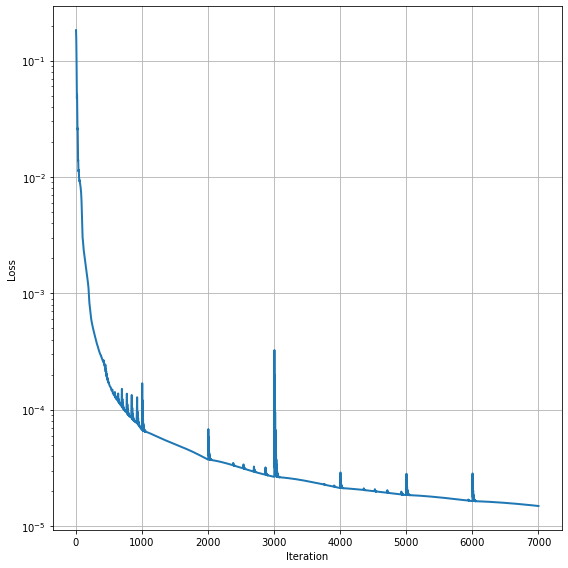

Loss = 1.48857325e-05:   0%|▏                                                                                                                                                       | 1/1000 [00:02<38:51,  2.33s/it]

New min loss =  1.48857325e-05


Loss = 1.4884927e-05:   4%|█████▎                                                                                                                                                  | 35/1000 [01:07<39:59,  2.49s/it]

New min loss =  1.4884927e-05


Loss = 1.4881036e-05:   4%|██████                                                                                                                                                  | 40/1000 [01:18<36:12,  2.26s/it]

New min loss =  1.4881036e-05


Loss = 1.4879265e-05:   4%|██████▋                                                                                                                                                 | 44/1000 [01:28<40:13,  2.52s/it]

New min loss =  1.4879265e-05


Loss = 1.4877251e-05:   6%|████████▋                                                                                                                                               | 57/1000 [01:57<30:02,  1.91s/it]

New min loss =  1.4877251e-05


Loss = 1.48693025e-05:   6%|█████████▏                                                                                                                                             | 61/1000 [02:07<36:49,  2.35s/it]

New min loss =  1.48693025e-05


Loss = 1.4865318e-05:   7%|██████████▍                                                                                                                                             | 69/1000 [02:24<32:12,  2.08s/it]

New min loss =  1.4865318e-05


Loss = 1.4865157e-05:   7%|███████████                                                                                                                                             | 73/1000 [02:35<39:01,  2.53s/it]

New min loss =  1.4865157e-05


Loss = 1.486117e-05:   8%|███████████▋                                                                                                                                             | 76/1000 [02:43<40:28,  2.63s/it]

New min loss =  1.486117e-05


Loss = 1.4860369e-05:   8%|████████████▏                                                                                                                                           | 80/1000 [02:51<30:29,  1.99s/it]

New min loss =  1.4860369e-05


Loss = 1.486009e-05:   8%|████████████▋                                                                                                                                            | 83/1000 [02:58<33:54,  2.22s/it]

New min loss =  1.486009e-05


Loss = 1.4857835e-05:   8%|████████████▊                                                                                                                                           | 84/1000 [03:00<34:37,  2.27s/it]

New min loss =  1.4857835e-05


Loss = 1.4855626e-05:   9%|█████████████▏                                                                                                                                          | 87/1000 [03:08<36:14,  2.38s/it]

New min loss =  1.4855626e-05


Loss = 1.4854086e-05:   9%|█████████████▋                                                                                                                                          | 90/1000 [03:15<36:31,  2.41s/it]

New min loss =  1.4854086e-05


Loss = 1.4852644e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:22<30:55,  2.05s/it]

New min loss =  1.4852644e-05


Loss = 1.4852342e-05:  10%|██████████████▍                                                                                                                                         | 95/1000 [03:25<33:26,  2.22s/it]

New min loss =  1.4852342e-05


Loss = 1.4851111e-05:  10%|██████████████▋                                                                                                                                         | 97/1000 [03:30<34:04,  2.26s/it]

New min loss =  1.4851111e-05


Loss = 1.4850244e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [03:32<35:05,  2.33s/it]

New min loss =  1.4850244e-05


Loss = 1.4849442e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:37<36:58,  2.47s/it]

New min loss =  1.4849442e-05


Loss = 1.4848337e-05:  10%|███████████████▎                                                                                                                                       | 101/1000 [03:40<37:20,  2.49s/it]

New min loss =  1.4848337e-05


Loss = 1.4847641e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [03:45<37:20,  2.50s/it]

New min loss =  1.4847641e-05


Loss = 1.484651e-05:  10%|███████████████▊                                                                                                                                        | 104/1000 [03:48<38:21,  2.57s/it]

New min loss =  1.484651e-05


Loss = 1.4845788e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [03:53<28:58,  1.95s/it]

New min loss =  1.4845788e-05


Loss = 1.4844703e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [03:55<31:34,  2.12s/it]

New min loss =  1.4844703e-05


Loss = 1.4844572e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [03:58<33:16,  2.24s/it]

New min loss =  1.4844572e-05


Loss = 1.4843887e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:00<34:01,  2.29s/it]

New min loss =  1.4843887e-05


Loss = 1.484289e-05:  11%|████████████████▊                                                                                                                                       | 111/1000 [04:03<35:26,  2.39s/it]

New min loss =  1.484289e-05


Loss = 1.4842604e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:05<35:27,  2.40s/it]

New min loss =  1.4842604e-05


Loss = 1.4841967e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:08<36:40,  2.48s/it]

New min loss =  1.4841967e-05


Loss = 1.4841055e-05:  11%|█████████████████▏                                                                                                                                     | 114/1000 [04:11<37:38,  2.55s/it]

New min loss =  1.4841055e-05


Loss = 1.4840669e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [04:13<37:30,  2.54s/it]

New min loss =  1.4840669e-05


Loss = 1.4840025e-05:  12%|█████████████████▌                                                                                                                                     | 116/1000 [04:16<36:26,  2.47s/it]

New min loss =  1.4840025e-05


Loss = 1.4839178e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [04:18<36:42,  2.49s/it]

New min loss =  1.4839178e-05


Loss = 1.483873e-05:  12%|█████████████████▉                                                                                                                                      | 118/1000 [04:21<37:04,  2.52s/it]

New min loss =  1.483873e-05


Loss = 1.4838083e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:23<37:29,  2.55s/it]

New min loss =  1.4838083e-05


Loss = 1.4837283e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [04:26<37:52,  2.58s/it]

New min loss =  1.4837283e-05


Loss = 1.4836781e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:29<28:32,  1.95s/it]

New min loss =  1.4836781e-05


Loss = 1.4836115e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:31<30:48,  2.11s/it]

New min loss =  1.4836115e-05


Loss = 1.4835373e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [04:34<33:00,  2.26s/it]

New min loss =  1.4835373e-05


Loss = 1.483483e-05:  12%|███████████████████                                                                                                                                     | 125/1000 [04:36<34:20,  2.36s/it]

New min loss =  1.483483e-05


Loss = 1.48341505e-05:  13%|██████████████████▉                                                                                                                                   | 126/1000 [04:39<34:28,  2.37s/it]

New min loss =  1.48341505e-05


Loss = 1.4833429e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [04:41<34:51,  2.40s/it]

New min loss =  1.4833429e-05


Loss = 1.4832867e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [04:44<36:03,  2.48s/it]

New min loss =  1.4832867e-05


Loss = 1.4832169e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [04:46<35:49,  2.47s/it]

New min loss =  1.4832169e-05


Loss = 1.48314775e-05:  13%|███████████████████▌                                                                                                                                  | 130/1000 [04:49<36:09,  2.49s/it]

New min loss =  1.48314775e-05


Loss = 1.4830874e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [04:51<35:41,  2.46s/it]

New min loss =  1.4830874e-05


Loss = 1.4830175e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [04:54<37:02,  2.56s/it]

New min loss =  1.4830175e-05


Loss = 1.4829497e-05:  13%|████████████████████                                                                                                                                   | 133/1000 [04:57<37:06,  2.57s/it]

New min loss =  1.4829497e-05


Loss = 1.4828873e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [04:59<35:59,  2.49s/it]

New min loss =  1.4828873e-05


Loss = 1.4828158e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [05:02<36:18,  2.52s/it]

New min loss =  1.4828158e-05


Loss = 1.4827487e-05:  14%|████████████████████▌                                                                                                                                  | 136/1000 [05:04<36:16,  2.52s/it]

New min loss =  1.4827487e-05


Loss = 1.4826839e-05:  14%|████████████████████▊                                                                                                                                  | 138/1000 [05:07<28:47,  2.00s/it]

New min loss =  1.4826839e-05


Loss = 1.4826128e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [05:10<30:49,  2.15s/it]

New min loss =  1.4826128e-05


Loss = 1.4825444e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:12<31:21,  2.19s/it]

New min loss =  1.4825444e-05


Loss = 1.4824781e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [05:15<33:13,  2.32s/it]

New min loss =  1.4824781e-05


Loss = 1.482407e-05:  14%|█████████████████████▌                                                                                                                                  | 142/1000 [05:17<34:15,  2.40s/it]

New min loss =  1.482407e-05


Loss = 1.4823401e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [05:20<34:57,  2.45s/it]

New min loss =  1.4823401e-05


Loss = 1.4822702e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [05:22<35:53,  2.52s/it]

New min loss =  1.4822702e-05


Loss = 1.4821997e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [05:25<35:56,  2.52s/it]

New min loss =  1.4821997e-05


Loss = 1.4821315e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [05:28<36:26,  2.56s/it]

New min loss =  1.4821315e-05


Loss = 1.4820607e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [05:30<37:24,  2.63s/it]

New min loss =  1.4820607e-05


Loss = 1.4819902e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [05:33<36:55,  2.60s/it]

New min loss =  1.4819902e-05


Loss = 1.48192075e-05:  15%|██████████████████████▎                                                                                                                               | 149/1000 [05:35<35:22,  2.49s/it]

New min loss =  1.48192075e-05


Loss = 1.4818482e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [05:38<35:46,  2.53s/it]

New min loss =  1.4818482e-05


Loss = 1.48177805e-05:  15%|██████████████████████▋                                                                                                                               | 151/1000 [05:40<35:17,  2.49s/it]

New min loss =  1.48177805e-05


Loss = 1.4817077e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [05:43<35:54,  2.54s/it]

New min loss =  1.4817077e-05


Loss = 1.4816357e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [05:45<36:06,  2.56s/it]

New min loss =  1.4816357e-05


Loss = 1.4815647e-05:  16%|███████████████████████▍                                                                                                                               | 155/1000 [05:48<27:26,  1.95s/it]

New min loss =  1.4815647e-05


Loss = 1.48149165e-05:  16%|███████████████████████▍                                                                                                                              | 156/1000 [05:51<30:27,  2.17s/it]

New min loss =  1.48149165e-05


Loss = 1.4814196e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [05:53<31:54,  2.27s/it]

New min loss =  1.4814196e-05


Loss = 1.481347e-05:  16%|████████████████████████                                                                                                                                | 158/1000 [05:56<33:18,  2.37s/it]

New min loss =  1.481347e-05


Loss = 1.4812742e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [05:58<33:41,  2.40s/it]

New min loss =  1.4812742e-05


Loss = 1.4812011e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [06:01<34:01,  2.43s/it]

New min loss =  1.4812011e-05


Loss = 1.4811274e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [06:04<35:15,  2.52s/it]

New min loss =  1.4811274e-05


Loss = 1.4810553e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [06:06<34:52,  2.50s/it]

New min loss =  1.4810553e-05


Loss = 1.4809812e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [06:09<35:02,  2.51s/it]

New min loss =  1.4809812e-05


Loss = 1.4809078e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:11<34:21,  2.47s/it]

New min loss =  1.4809078e-05


Loss = 1.4808323e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [06:14<35:19,  2.54s/it]

New min loss =  1.4808323e-05


Loss = 1.4807576e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [06:16<36:01,  2.59s/it]

New min loss =  1.4807576e-05


Loss = 1.4806841e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [06:19<36:08,  2.60s/it]

New min loss =  1.4806841e-05


Loss = 1.48060935e-05:  17%|█████████████████████████▏                                                                                                                            | 168/1000 [06:22<36:17,  2.62s/it]

New min loss =  1.48060935e-05


Loss = 1.4805333e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [06:25<37:18,  2.69s/it]

New min loss =  1.4805333e-05


Loss = 1.4804584e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [06:27<36:40,  2.65s/it]

New min loss =  1.4804584e-05


Loss = 1.4803823e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [06:30<36:33,  2.65s/it]

New min loss =  1.4803823e-05


Loss = 1.48030695e-05:  17%|█████████████████████████▉                                                                                                                            | 173/1000 [06:32<27:38,  2.01s/it]

New min loss =  1.48030695e-05


Loss = 1.4802307e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [06:35<29:24,  2.14s/it]

New min loss =  1.4802307e-05


Loss = 1.4801538e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [06:38<31:35,  2.30s/it]

New min loss =  1.4801538e-05


Loss = 1.4800766e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [06:40<32:38,  2.38s/it]

New min loss =  1.4800766e-05


Loss = 1.4800006e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [06:43<33:07,  2.41s/it]

New min loss =  1.4800006e-05


Loss = 1.4799243e-05:  18%|██████████████████████████▉                                                                                                                            | 178/1000 [06:45<34:20,  2.51s/it]

New min loss =  1.4799243e-05


Loss = 1.4798461e-05:  18%|███████████████████████████                                                                                                                            | 179/1000 [06:48<35:07,  2.57s/it]

New min loss =  1.4798461e-05


Loss = 1.4797689e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [06:51<35:21,  2.59s/it]

New min loss =  1.4797689e-05


Loss = 1.4796905e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [06:53<34:06,  2.50s/it]

New min loss =  1.4796905e-05


Loss = 1.4796141e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [06:56<34:29,  2.53s/it]

New min loss =  1.4796141e-05


Loss = 1.4795342e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [06:58<34:33,  2.54s/it]

New min loss =  1.4795342e-05


Loss = 1.4794561e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [07:01<34:54,  2.57s/it]

New min loss =  1.4794561e-05


Loss = 1.47937835e-05:  18%|███████████████████████████▊                                                                                                                          | 185/1000 [07:03<35:12,  2.59s/it]

New min loss =  1.47937835e-05


Loss = 1.4792988e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [07:06<34:26,  2.54s/it]

New min loss =  1.4792988e-05


Loss = 1.4792199e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [07:09<34:47,  2.57s/it]

New min loss =  1.4792199e-05


Loss = 1.4791405e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [07:11<35:06,  2.59s/it]

New min loss =  1.4791405e-05


Loss = 1.4790617e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [07:14<35:13,  2.61s/it]

New min loss =  1.4790617e-05


Loss = 1.478982e-05:  19%|████████████████████████████▉                                                                                                                           | 190/1000 [07:16<34:25,  2.55s/it]

New min loss =  1.478982e-05


Loss = 1.4789018e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [07:19<26:53,  2.00s/it]

New min loss =  1.4789018e-05


Loss = 1.47882165e-05:  19%|████████████████████████████▉                                                                                                                         | 193/1000 [07:22<29:10,  2.17s/it]

New min loss =  1.47882165e-05


Loss = 1.4787421e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [07:24<31:06,  2.32s/it]

New min loss =  1.4787421e-05


Loss = 1.478661e-05:  20%|█████████████████████████████▋                                                                                                                          | 195/1000 [07:27<31:47,  2.37s/it]

New min loss =  1.478661e-05


Loss = 1.4785807e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [07:29<31:55,  2.38s/it]

New min loss =  1.4785807e-05


Loss = 1.47850005e-05:  20%|█████████████████████████████▌                                                                                                                        | 197/1000 [07:32<32:25,  2.42s/it]

New min loss =  1.47850005e-05


Loss = 1.4784193e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [07:34<32:37,  2.44s/it]

New min loss =  1.4784193e-05


Loss = 1.478338e-05:  20%|██████████████████████████████▏                                                                                                                         | 199/1000 [07:37<33:04,  2.48s/it]

New min loss =  1.478338e-05


Loss = 1.4782563e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [07:39<32:59,  2.47s/it]

New min loss =  1.4782563e-05


Loss = 1.4781749e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [07:42<32:20,  2.43s/it]

New min loss =  1.4781749e-05


Loss = 1.4780924e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [07:44<32:38,  2.45s/it]

New min loss =  1.4780924e-05


Loss = 1.4780107e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [07:47<32:43,  2.46s/it]

New min loss =  1.4780107e-05


Loss = 1.4779282e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [07:49<33:58,  2.56s/it]

New min loss =  1.4779282e-05


Loss = 1.4778453e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [07:52<32:20,  2.44s/it]

New min loss =  1.4778453e-05


Loss = 1.4777629e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [07:54<32:45,  2.48s/it]

New min loss =  1.4777629e-05


Loss = 1.4776805e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [07:57<33:17,  2.52s/it]

New min loss =  1.4776805e-05


Loss = 1.4775963e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [07:59<32:49,  2.49s/it]

New min loss =  1.4775963e-05


Loss = 1.4775133e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [08:02<32:48,  2.49s/it]

New min loss =  1.4775133e-05


Loss = 1.4774312e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [08:04<32:06,  2.44s/it]

New min loss =  1.4774312e-05


Loss = 1.4773467e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [08:07<25:05,  1.91s/it]

New min loss =  1.4773467e-05


Loss = 1.4772625e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [08:09<27:13,  2.08s/it]

New min loss =  1.4772625e-05


Loss = 1.4771798e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [08:12<29:11,  2.23s/it]

New min loss =  1.4771798e-05


Loss = 1.4770952e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [08:14<29:19,  2.24s/it]

New min loss =  1.4770952e-05


Loss = 1.47700985e-05:  22%|████████████████████████████████▍                                                                                                                     | 216/1000 [08:16<29:46,  2.28s/it]

New min loss =  1.47700985e-05


Loss = 1.4769259e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [08:19<30:25,  2.33s/it]

New min loss =  1.4769259e-05


Loss = 1.4768404e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [08:22<31:27,  2.41s/it]

New min loss =  1.4768404e-05


Loss = 1.4767557e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [08:24<31:51,  2.45s/it]

New min loss =  1.4767557e-05


Loss = 1.476672e-05:  22%|█████████████████████████████████▍                                                                                                                      | 220/1000 [08:26<31:15,  2.40s/it]

New min loss =  1.476672e-05


Loss = 1.4765856e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [08:29<32:27,  2.50s/it]

New min loss =  1.4765856e-05


Loss = 1.4765006e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [08:32<32:29,  2.51s/it]

New min loss =  1.4765006e-05


Loss = 1.4764133e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [08:34<32:31,  2.51s/it]

New min loss =  1.4764133e-05


Loss = 1.4763293e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [08:37<31:52,  2.46s/it]

New min loss =  1.4763293e-05


Loss = 1.47624105e-05:  22%|█████████████████████████████████▊                                                                                                                    | 225/1000 [08:39<32:16,  2.50s/it]

New min loss =  1.47624105e-05


Loss = 1.4761556e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [08:42<31:59,  2.48s/it]

New min loss =  1.4761556e-05


Loss = 1.4760691e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [08:44<33:02,  2.56s/it]

New min loss =  1.4760691e-05


Loss = 1.4759824e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [08:47<32:13,  2.50s/it]

New min loss =  1.4759824e-05


Loss = 1.4758956e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [08:49<31:23,  2.44s/it]

New min loss =  1.4758956e-05


Loss = 1.4758086e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [08:52<32:11,  2.51s/it]

New min loss =  1.4758086e-05


Loss = 1.4757216e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [08:54<32:43,  2.55s/it]

New min loss =  1.4757216e-05


Loss = 1.4756347e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [08:57<24:38,  1.93s/it]

New min loss =  1.4756347e-05


Loss = 1.4755462e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [08:59<26:02,  2.04s/it]

New min loss =  1.4755462e-05


Loss = 1.4754593e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [09:02<27:29,  2.16s/it]

New min loss =  1.4754593e-05


Loss = 1.4753699e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [09:04<28:25,  2.23s/it]

New min loss =  1.4753699e-05


Loss = 1.4752832e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [09:07<29:42,  2.34s/it]

New min loss =  1.4752832e-05


Loss = 1.4751951e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [09:09<30:16,  2.38s/it]

New min loss =  1.4751951e-05


Loss = 1.4751066e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [09:11<29:41,  2.34s/it]

New min loss =  1.4751066e-05


Loss = 1.47502005e-05:  24%|████████████████████████████████████                                                                                                                  | 240/1000 [09:14<30:04,  2.37s/it]

New min loss =  1.47502005e-05


Loss = 1.47493e-05:  24%|████████████████████████████████████▊                                                                                                                    | 241/1000 [09:16<30:54,  2.44s/it]

New min loss =  1.47493e-05


Loss = 1.4748418e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [09:19<30:59,  2.45s/it]

New min loss =  1.4748418e-05


Loss = 1.4747533e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [09:21<31:08,  2.47s/it]

New min loss =  1.4747533e-05


Loss = 1.4746636e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [09:24<32:15,  2.56s/it]

New min loss =  1.4746636e-05


Loss = 1.4745742e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [09:27<32:20,  2.57s/it]

New min loss =  1.4745742e-05


Loss = 1.4744848e-05:  25%|█████████████████████████████████████▏                                                                                                                 | 246/1000 [09:29<32:36,  2.59s/it]

New min loss =  1.4744848e-05


Loss = 1.4743955e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [09:32<31:43,  2.53s/it]

New min loss =  1.4743955e-05


Loss = 1.4743058e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [09:34<31:31,  2.52s/it]

New min loss =  1.4743058e-05


Loss = 1.4742162e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [09:37<31:16,  2.50s/it]

New min loss =  1.4742162e-05


Loss = 1.4741257e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [09:39<32:18,  2.59s/it]

New min loss =  1.4741257e-05


Loss = 1.4740362e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [09:42<32:55,  2.64s/it]

New min loss =  1.4740362e-05


Loss = 1.4739457e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [09:45<32:31,  2.61s/it]

New min loss =  1.4739457e-05


Loss = 1.4738549e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [09:47<32:28,  2.61s/it]

New min loss =  1.4738549e-05


Loss = 1.4737648e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [09:50<25:03,  2.02s/it]

New min loss =  1.4737648e-05


Loss = 1.4736735e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [09:53<26:30,  2.14s/it]

New min loss =  1.4736735e-05


Loss = 1.473582e-05:  26%|███████████████████████████████████████                                                                                                                 | 257/1000 [09:55<28:10,  2.28s/it]

New min loss =  1.473582e-05


Loss = 1.4734909e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [09:58<28:42,  2.32s/it]

New min loss =  1.4734909e-05


Loss = 1.4734e-05:  26%|███████████████████████████████████████▉                                                                                                                  | 259/1000 [10:00<30:02,  2.43s/it]

New min loss =  1.4734e-05


Loss = 1.4733082e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [10:03<31:22,  2.54s/it]

New min loss =  1.4733082e-05


Loss = 1.4732172e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [10:06<31:21,  2.55s/it]

New min loss =  1.4732172e-05


Loss = 1.4731248e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [10:09<32:37,  2.65s/it]

New min loss =  1.4731248e-05


Loss = 1.4730319e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [10:11<32:43,  2.66s/it]

New min loss =  1.4730319e-05


Loss = 1.4729399e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [10:14<32:52,  2.68s/it]

New min loss =  1.4729399e-05


Loss = 1.4728481e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [10:17<32:34,  2.66s/it]

New min loss =  1.4728481e-05


Loss = 1.4727548e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [10:19<31:57,  2.61s/it]

New min loss =  1.4727548e-05


Loss = 1.4726615e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [10:22<31:38,  2.59s/it]

New min loss =  1.4726615e-05


Loss = 1.4725671e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [10:25<33:12,  2.72s/it]

New min loss =  1.4725671e-05


Loss = 1.472474e-05:  27%|████████████████████████████████████████▉                                                                                                               | 269/1000 [10:27<32:06,  2.64s/it]

New min loss =  1.472474e-05


Loss = 1.4723816e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [10:30<31:47,  2.61s/it]

New min loss =  1.4723816e-05


Loss = 1.4722875e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [10:32<31:27,  2.59s/it]

New min loss =  1.4722875e-05


Loss = 1.4721927e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [10:35<31:46,  2.62s/it]

New min loss =  1.4721927e-05


Loss = 1.47209885e-05:  27%|████████████████████████████████████████▉                                                                                                             | 273/1000 [10:38<32:31,  2.68s/it]

New min loss =  1.47209885e-05


Loss = 1.4720041e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [10:40<31:43,  2.62s/it]

New min loss =  1.4720041e-05


Loss = 1.4719094e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [10:43<32:09,  2.66s/it]

New min loss =  1.4719094e-05


Loss = 1.4718151e-05:  28%|█████████████████████████████████████████▋                                                                                                             | 276/1000 [10:46<33:04,  2.74s/it]

New min loss =  1.4718151e-05


Loss = 1.4717193e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [10:48<24:24,  2.03s/it]

New min loss =  1.4717193e-05


Loss = 1.4716242e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [10:51<25:46,  2.15s/it]

New min loss =  1.4716242e-05


Loss = 1.4715294e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [10:53<26:17,  2.19s/it]

New min loss =  1.4715294e-05


Loss = 1.4714341e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [10:56<27:59,  2.34s/it]

New min loss =  1.4714341e-05


Loss = 1.4713382e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [10:58<28:16,  2.36s/it]

New min loss =  1.4713382e-05


Loss = 1.4712432e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [11:01<29:18,  2.45s/it]

New min loss =  1.4712432e-05


Loss = 1.4711466e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [11:03<29:02,  2.43s/it]

New min loss =  1.4711466e-05


Loss = 1.4710501e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [11:06<29:12,  2.45s/it]

New min loss =  1.4710501e-05


Loss = 1.4709547e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [11:09<30:01,  2.52s/it]

New min loss =  1.4709547e-05


Loss = 1.4708594e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [11:11<30:02,  2.53s/it]

New min loss =  1.4708594e-05


Loss = 1.4707635e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [11:13<29:13,  2.46s/it]

New min loss =  1.4707635e-05


Loss = 1.4706662e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [11:16<29:17,  2.47s/it]

New min loss =  1.4706662e-05


Loss = 1.4705701e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [11:18<29:10,  2.47s/it]

New min loss =  1.4705701e-05


Loss = 1.4704725e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [11:21<29:59,  2.54s/it]

New min loss =  1.4704725e-05


Loss = 1.4703763e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [11:24<30:23,  2.58s/it]

New min loss =  1.4703763e-05


Loss = 1.4702797e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [11:26<29:10,  2.48s/it]

New min loss =  1.4702797e-05


Loss = 1.4701825e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [11:28<28:47,  2.45s/it]

New min loss =  1.4701825e-05


Loss = 1.4700854e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [11:31<28:57,  2.46s/it]

New min loss =  1.4700854e-05


Loss = 1.4699879e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [11:33<29:05,  2.48s/it]

New min loss =  1.4699879e-05


Loss = 1.4698899e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [11:36<29:24,  2.51s/it]

New min loss =  1.4698899e-05


Loss = 1.4697925e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [11:39<29:48,  2.55s/it]

New min loss =  1.4697925e-05


Loss = 1.4696944e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [11:41<28:38,  2.45s/it]

New min loss =  1.4696944e-05


Loss = 1.4695976e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [11:43<29:02,  2.49s/it]

New min loss =  1.4695976e-05


Loss = 1.4694991e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [11:46<22:32,  1.94s/it]

New min loss =  1.4694991e-05


Loss = 1.4694006e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [11:49<24:58,  2.15s/it]

New min loss =  1.4694006e-05


Loss = 1.4693001e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [11:51<25:53,  2.23s/it]

New min loss =  1.4693001e-05


Loss = 1.4692024e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [11:54<26:42,  2.31s/it]

New min loss =  1.4692024e-05


Loss = 1.4691034e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [11:56<28:02,  2.42s/it]

New min loss =  1.4691034e-05


Loss = 1.4690043e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [11:59<28:24,  2.46s/it]

New min loss =  1.4690043e-05


Loss = 1.46890525e-05:  31%|██████████████████████████████████████████████▏                                                                                                       | 308/1000 [12:01<27:51,  2.41s/it]

New min loss =  1.46890525e-05


Loss = 1.4688054e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [12:04<28:32,  2.48s/it]

New min loss =  1.4688054e-05


Loss = 1.4687058e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [12:06<28:15,  2.46s/it]

New min loss =  1.4687058e-05


Loss = 1.4686063e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [12:09<29:02,  2.53s/it]

New min loss =  1.4686063e-05


Loss = 1.46850525e-05:  31%|██████████████████████████████████████████████▊                                                                                                       | 312/1000 [12:11<28:33,  2.49s/it]

New min loss =  1.46850525e-05


Loss = 1.4684051e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [12:14<28:42,  2.51s/it]

New min loss =  1.4684051e-05


Loss = 1.4683054e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [12:17<28:44,  2.51s/it]

New min loss =  1.4683054e-05


Loss = 1.4682046e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [12:19<28:40,  2.51s/it]

New min loss =  1.4682046e-05


Loss = 1.4681038e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [12:21<28:13,  2.48s/it]

New min loss =  1.4681038e-05


Loss = 1.468004e-05:  32%|████████████████████████████████████████████████▏                                                                                                       | 317/1000 [12:24<28:01,  2.46s/it]

New min loss =  1.468004e-05


Loss = 1.4679025e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [12:26<27:43,  2.44s/it]

New min loss =  1.4679025e-05


Loss = 1.4678019e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [12:29<28:03,  2.47s/it]

New min loss =  1.4678019e-05


Loss = 1.4676999e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [12:31<27:49,  2.45s/it]

New min loss =  1.4676999e-05


Loss = 1.4675991e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [12:34<28:08,  2.49s/it]

New min loss =  1.4675991e-05


Loss = 1.467498e-05:  32%|████████████████████████████████████████████████▉                                                                                                       | 322/1000 [12:36<28:07,  2.49s/it]

New min loss =  1.467498e-05


Loss = 1.4673966e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [12:39<29:08,  2.58s/it]

New min loss =  1.4673966e-05


Loss = 1.4672943e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [12:42<29:25,  2.61s/it]

New min loss =  1.4672943e-05


Loss = 1.4671918e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [12:44<28:21,  2.52s/it]

New min loss =  1.4671918e-05


Loss = 1.4670892e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [12:47<21:40,  1.93s/it]

New min loss =  1.4670892e-05


Loss = 1.4669874e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [12:49<23:38,  2.11s/it]

New min loss =  1.4669874e-05


Loss = 1.4668851e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [12:52<25:08,  2.25s/it]

New min loss =  1.4668851e-05


Loss = 1.4667821e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [12:54<25:30,  2.28s/it]

New min loss =  1.4667821e-05


Loss = 1.4666793e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [12:57<25:49,  2.32s/it]

New min loss =  1.4666793e-05


Loss = 1.4665775e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [12:59<26:22,  2.37s/it]

New min loss =  1.4665775e-05


Loss = 1.4664736e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [13:02<26:30,  2.39s/it]

New min loss =  1.4664736e-05


Loss = 1.46637085e-05:  33%|██████████████████████████████████████████████████                                                                                                    | 334/1000 [13:04<27:04,  2.44s/it]

New min loss =  1.46637085e-05


Loss = 1.4662671e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [13:07<27:14,  2.46s/it]

New min loss =  1.4662671e-05


Loss = 1.466164e-05:  34%|███████████████████████████████████████████████████                                                                                                     | 336/1000 [13:09<27:14,  2.46s/it]

New min loss =  1.466164e-05


Loss = 1.4660604e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [13:12<28:05,  2.54s/it]

New min loss =  1.4660604e-05


Loss = 1.4659559e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [13:14<28:10,  2.55s/it]

New min loss =  1.4659559e-05


Loss = 1.4658529e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [13:17<27:48,  2.52s/it]

New min loss =  1.4658529e-05


Loss = 1.4657487e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [13:19<27:05,  2.46s/it]

New min loss =  1.4657487e-05


Loss = 1.46564425e-05:  34%|███████████████████████████████████████████████████▏                                                                                                  | 341/1000 [13:22<26:46,  2.44s/it]

New min loss =  1.46564425e-05


Loss = 1.4655397e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [13:24<26:54,  2.45s/it]

New min loss =  1.4655397e-05


Loss = 1.4654356e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [13:27<27:16,  2.49s/it]

New min loss =  1.4654356e-05


Loss = 1.4653319e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [13:29<27:03,  2.48s/it]

New min loss =  1.4653319e-05


Loss = 1.46522625e-05:  34%|███████████████████████████████████████████████████▋                                                                                                  | 345/1000 [13:32<27:29,  2.52s/it]

New min loss =  1.46522625e-05


Loss = 1.4651218e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [13:34<27:28,  2.52s/it]

New min loss =  1.4651218e-05


Loss = 1.4650172e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [13:37<27:36,  2.54s/it]

New min loss =  1.4650172e-05


Loss = 1.4649108e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [13:39<27:45,  2.55s/it]

New min loss =  1.4649108e-05


Loss = 1.4648062e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [13:42<27:28,  2.53s/it]

New min loss =  1.4648062e-05


Loss = 1.4646998e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [13:44<26:59,  2.49s/it]

New min loss =  1.4646998e-05


Loss = 1.4645955e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [13:47<27:09,  2.51s/it]

New min loss =  1.4645955e-05


Loss = 1.4644888e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [13:49<20:40,  1.92s/it]

New min loss =  1.4644888e-05


Loss = 1.4643839e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [13:52<22:08,  2.06s/it]

New min loss =  1.4643839e-05


Loss = 1.4642775e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [13:54<23:09,  2.15s/it]

New min loss =  1.4642775e-05


Loss = 1.4641717e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [13:57<23:57,  2.23s/it]

New min loss =  1.4641717e-05


Loss = 1.464065e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                 | 357/1000 [13:59<24:22,  2.28s/it]

New min loss =  1.464065e-05


Loss = 1.4639577e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [14:02<25:25,  2.38s/it]

New min loss =  1.4639577e-05


Loss = 1.46385255e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                | 359/1000 [14:04<25:59,  2.43s/it]

New min loss =  1.46385255e-05


Loss = 1.463746e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                 | 360/1000 [14:07<25:57,  2.43s/it]

New min loss =  1.463746e-05


Loss = 1.4636395e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                | 361/1000 [14:09<26:10,  2.46s/it]

New min loss =  1.4636395e-05


Loss = 1.4635319e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [14:12<26:03,  2.45s/it]

New min loss =  1.4635319e-05


Loss = 1.4634243e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [14:14<26:25,  2.49s/it]

New min loss =  1.4634243e-05


Loss = 1.4633176e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [14:17<26:54,  2.54s/it]

New min loss =  1.4633176e-05


Loss = 1.4632094e-05:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [14:19<26:25,  2.50s/it]

New min loss =  1.4632094e-05


Loss = 1.4631024e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [14:22<26:18,  2.49s/it]

New min loss =  1.4631024e-05


Loss = 1.4629945e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [14:24<26:26,  2.51s/it]

New min loss =  1.4629945e-05


Loss = 1.4628875e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [14:27<26:37,  2.53s/it]

New min loss =  1.4628875e-05


Loss = 1.4627787e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [14:29<26:24,  2.51s/it]

New min loss =  1.4627787e-05


Loss = 1.4626703e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [14:32<26:34,  2.53s/it]

New min loss =  1.4626703e-05


Loss = 1.462562e-05:  37%|████████████████████████████████████████████████████████▍                                                                                               | 371/1000 [14:34<25:56,  2.47s/it]

New min loss =  1.462562e-05


Loss = 1.4624533e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [14:37<26:09,  2.50s/it]

New min loss =  1.4624533e-05


Loss = 1.4623463e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [14:39<26:34,  2.54s/it]

New min loss =  1.4623463e-05


Loss = 1.4622365e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [14:42<25:26,  2.44s/it]

New min loss =  1.4622365e-05


Loss = 1.4621286e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [14:44<24:56,  2.40s/it]

New min loss =  1.4621286e-05


Loss = 1.4620209e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [14:47<25:42,  2.47s/it]

New min loss =  1.4620209e-05


Loss = 1.4619115e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [14:49<25:32,  2.46s/it]

New min loss =  1.4619115e-05


Loss = 1.4618027e-05:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [14:52<25:43,  2.48s/it]

New min loss =  1.4618027e-05


Loss = 1.461694e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                              | 380/1000 [14:54<19:51,  1.92s/it]

New min loss =  1.461694e-05


Loss = 1.461584e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                              | 381/1000 [14:56<21:03,  2.04s/it]

New min loss =  1.461584e-05


Loss = 1.4614744e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [14:59<22:27,  2.18s/it]

New min loss =  1.4614744e-05


Loss = 1.4613667e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [15:02<23:39,  2.30s/it]

New min loss =  1.4613667e-05


Loss = 1.4612565e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [15:04<24:29,  2.39s/it]

New min loss =  1.4612565e-05


Loss = 1.4611464e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [15:07<24:46,  2.42s/it]

New min loss =  1.4611464e-05


Loss = 1.4610374e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [15:09<24:46,  2.42s/it]

New min loss =  1.4610374e-05


Loss = 1.46092725e-05:  39%|██████████████████████████████████████████████████████████                                                                                            | 387/1000 [15:12<25:29,  2.49s/it]

New min loss =  1.46092725e-05


Loss = 1.4608189e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [15:14<25:25,  2.49s/it]

New min loss =  1.4608189e-05


Loss = 1.4607082e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [15:17<25:16,  2.48s/it]

New min loss =  1.4607082e-05


Loss = 1.4605979e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [15:19<25:09,  2.47s/it]

New min loss =  1.4605979e-05


Loss = 1.4604891e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [15:22<25:16,  2.49s/it]

New min loss =  1.4604891e-05


Loss = 1.46037755e-05:  39%|██████████████████████████████████████████████████████████▊                                                                                           | 392/1000 [15:24<25:26,  2.51s/it]

New min loss =  1.46037755e-05


Loss = 1.4602679e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [15:27<25:33,  2.53s/it]

New min loss =  1.4602679e-05


Loss = 1.4601562e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [15:29<25:20,  2.51s/it]

New min loss =  1.4601562e-05


Loss = 1.4600459e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [15:32<25:14,  2.50s/it]

New min loss =  1.4600459e-05


Loss = 1.45993545e-05:  40%|███████████████████████████████████████████████████████████▍                                                                                          | 396/1000 [15:34<24:57,  2.48s/it]

New min loss =  1.45993545e-05


Loss = 1.4598236e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [15:37<24:40,  2.45s/it]

New min loss =  1.4598236e-05


Loss = 1.4597134e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [15:39<25:01,  2.49s/it]

New min loss =  1.4597134e-05


Loss = 1.4596021e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [15:42<24:30,  2.45s/it]

New min loss =  1.4596021e-05


Loss = 1.4594892e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [15:44<24:49,  2.48s/it]

New min loss =  1.4594892e-05


Loss = 1.4593783e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [15:47<25:29,  2.55s/it]

New min loss =  1.4593783e-05


Loss = 1.4592665e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [15:49<25:09,  2.52s/it]

New min loss =  1.4592665e-05


Loss = 1.4591551e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [15:52<25:14,  2.54s/it]

New min loss =  1.4591551e-05


Loss = 1.4590421e-05:  40%|█████████████████████████████████████████████████████████████                                                                                          | 404/1000 [15:55<25:40,  2.58s/it]

New min loss =  1.4590421e-05


Loss = 1.45893055e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                         | 405/1000 [15:57<25:49,  2.60s/it]

New min loss =  1.45893055e-05


Loss = 1.4588188e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [16:00<25:38,  2.59s/it]

New min loss =  1.4588188e-05


Loss = 1.4587056e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [16:02<18:53,  1.91s/it]

New min loss =  1.4587056e-05


Loss = 1.4585927e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [16:05<20:13,  2.05s/it]

New min loss =  1.4585927e-05


Loss = 1.4584813e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [16:07<21:46,  2.21s/it]

New min loss =  1.4584813e-05


Loss = 1.4583681e-05:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [16:10<22:49,  2.33s/it]

New min loss =  1.4583681e-05


Loss = 1.45825525e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                        | 412/1000 [16:13<23:52,  2.44s/it]

New min loss =  1.45825525e-05


Loss = 1.4581423e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [16:15<23:21,  2.39s/it]

New min loss =  1.4581423e-05


Loss = 1.4580299e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [16:17<24:07,  2.47s/it]

New min loss =  1.4580299e-05


Loss = 1.4579159e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [16:20<24:20,  2.50s/it]

New min loss =  1.4579159e-05


Loss = 1.4578041e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [16:22<23:54,  2.46s/it]

New min loss =  1.4578041e-05


Loss = 1.4576911e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [16:25<23:35,  2.43s/it]

New min loss =  1.4576911e-05


Loss = 1.4575786e-05:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [16:27<23:32,  2.43s/it]

New min loss =  1.4575786e-05


Loss = 1.457465e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                        | 419/1000 [16:30<24:17,  2.51s/it]

New min loss =  1.457465e-05


Loss = 1.4573522e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [16:32<24:27,  2.53s/it]

New min loss =  1.4573522e-05


Loss = 1.4572378e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [16:35<24:26,  2.53s/it]

New min loss =  1.4572378e-05


Loss = 1.4571237e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [16:37<23:45,  2.47s/it]

New min loss =  1.4571237e-05


Loss = 1.4570108e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [16:40<24:28,  2.54s/it]

New min loss =  1.4570108e-05


Loss = 1.4568968e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [16:43<24:07,  2.51s/it]

New min loss =  1.4568968e-05


Loss = 1.4567834e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [16:45<24:22,  2.54s/it]

New min loss =  1.4567834e-05


Loss = 1.4566681e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [16:47<23:19,  2.44s/it]

New min loss =  1.4566681e-05


Loss = 1.4565547e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [16:50<23:30,  2.46s/it]

New min loss =  1.4565547e-05


Loss = 1.4564407e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [16:52<23:57,  2.51s/it]

New min loss =  1.4564407e-05


Loss = 1.4563258e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [16:55<23:47,  2.50s/it]

New min loss =  1.4563258e-05


Loss = 1.45621e-05:  43%|█████████████████████████████████████████████████████████████████▊                                                                                       | 430/1000 [16:58<24:24,  2.57s/it]

New min loss =  1.45621e-05


Loss = 1.4560955e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [17:00<23:15,  2.45s/it]

New min loss =  1.4560955e-05


Loss = 1.4559809e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [17:02<23:27,  2.48s/it]

New min loss =  1.4559809e-05


Loss = 1.4558647e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [17:05<23:36,  2.50s/it]

New min loss =  1.4558647e-05


Loss = 1.4557505e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [17:08<23:58,  2.54s/it]

New min loss =  1.4557505e-05


Loss = 1.45563545e-05:  44%|█████████████████████████████████████████████████████████████████▎                                                                                    | 435/1000 [17:10<23:08,  2.46s/it]

New min loss =  1.45563545e-05


Loss = 1.4555189e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [17:12<17:51,  1.90s/it]

New min loss =  1.4555189e-05


Loss = 1.4554044e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [17:15<19:18,  2.06s/it]

New min loss =  1.4554044e-05


Loss = 1.4552879e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [17:18<20:38,  2.21s/it]

New min loss =  1.4552879e-05


Loss = 1.4551729e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [17:20<21:11,  2.27s/it]

New min loss =  1.4551729e-05


Loss = 1.4550566e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [17:22<21:39,  2.33s/it]

New min loss =  1.4550566e-05


Loss = 1.4549401e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [17:25<22:24,  2.41s/it]

New min loss =  1.4549401e-05


Loss = 1.4548246e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [17:28<22:45,  2.45s/it]

New min loss =  1.4548246e-05


Loss = 1.4547077e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [17:30<22:58,  2.48s/it]

New min loss =  1.4547077e-05


Loss = 1.4545921e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [17:32<22:04,  2.39s/it]

New min loss =  1.4545921e-05


Loss = 1.4544761e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [17:35<22:00,  2.38s/it]

New min loss =  1.4544761e-05


Loss = 1.4543593e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [17:37<22:34,  2.45s/it]

New min loss =  1.4543593e-05


Loss = 1.4542425e-05:  45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 448/1000 [17:40<22:53,  2.49s/it]

New min loss =  1.4542425e-05


Loss = 1.454126e-05:  45%|████████████████████████████████████████████████████████████████████▏                                                                                   | 449/1000 [17:42<22:36,  2.46s/it]

New min loss =  1.454126e-05


Loss = 1.45401e-05:  45%|████████████████████████████████████████████████████████████████████▊                                                                                    | 450/1000 [17:45<22:26,  2.45s/it]

New min loss =  1.45401e-05


Loss = 1.4538919e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [17:47<22:51,  2.50s/it]

New min loss =  1.4538919e-05


Loss = 1.4537749e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [17:50<22:32,  2.47s/it]

New min loss =  1.4537749e-05


Loss = 1.45365775e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                  | 453/1000 [17:52<22:35,  2.48s/it]

New min loss =  1.45365775e-05


Loss = 1.4535408e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [17:55<22:59,  2.53s/it]

New min loss =  1.4535408e-05


Loss = 1.4534241e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [17:57<22:02,  2.43s/it]

New min loss =  1.4534241e-05


Loss = 1.4533051e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [18:00<22:10,  2.45s/it]

New min loss =  1.4533051e-05


Loss = 1.45318645e-05:  46%|████████████████████████████████████████████████████████████████████▌                                                                                 | 457/1000 [18:02<22:12,  2.45s/it]

New min loss =  1.45318645e-05


Loss = 1.4530703e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [18:05<22:41,  2.51s/it]

New min loss =  1.4530703e-05


Loss = 1.452952e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                  | 459/1000 [18:07<22:52,  2.54s/it]

New min loss =  1.452952e-05


Loss = 1.4528328e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [18:10<22:24,  2.49s/it]

New min loss =  1.4528328e-05


Loss = 1.4527142e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [18:12<22:18,  2.48s/it]

New min loss =  1.4527142e-05


Loss = 1.45259555e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                | 462/1000 [18:14<22:04,  2.46s/it]

New min loss =  1.45259555e-05


Loss = 1.45247595e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                | 463/1000 [18:17<21:58,  2.46s/it]

New min loss =  1.45247595e-05


Loss = 1.4523578e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [18:19<22:13,  2.49s/it]

New min loss =  1.4523578e-05


Loss = 1.45223885e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                | 465/1000 [18:22<21:55,  2.46s/it]

New min loss =  1.45223885e-05


Loss = 1.4521196e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [18:24<16:35,  1.87s/it]

New min loss =  1.4521196e-05


Loss = 1.4520001e-05:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [18:27<18:07,  2.04s/it]

New min loss =  1.4520001e-05


Loss = 1.4518803e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [18:29<19:15,  2.18s/it]

New min loss =  1.4518803e-05


Loss = 1.4517611e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [18:32<20:00,  2.26s/it]

New min loss =  1.4517611e-05


Loss = 1.4516413e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                                | 471/1000 [18:34<20:34,  2.33s/it]

New min loss =  1.4516413e-05


Loss = 1.45152135e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                               | 472/1000 [18:37<20:05,  2.28s/it]

New min loss =  1.45152135e-05


Loss = 1.4514005e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [18:39<21:27,  2.44s/it]

New min loss =  1.4514005e-05


Loss = 1.4512804e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [18:42<21:10,  2.41s/it]

New min loss =  1.4512804e-05


Loss = 1.4511605e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [18:44<21:49,  2.49s/it]

New min loss =  1.4511605e-05


Loss = 1.4510384e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [18:47<21:36,  2.47s/it]

New min loss =  1.4510384e-05


Loss = 1.4509177e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                               | 477/1000 [18:50<22:08,  2.54s/it]

New min loss =  1.4509177e-05


Loss = 1.4507966e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [18:52<21:53,  2.52s/it]

New min loss =  1.4507966e-05


Loss = 1.4506759e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [18:55<22:07,  2.55s/it]

New min loss =  1.4506759e-05


Loss = 1.450554e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 480/1000 [18:57<21:43,  2.51s/it]

New min loss =  1.450554e-05


Loss = 1.4504324e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 481/1000 [18:59<21:05,  2.44s/it]

New min loss =  1.4504324e-05


Loss = 1.4503106e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [19:02<20:55,  2.42s/it]

New min loss =  1.4503106e-05


Loss = 1.4501885e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [19:04<21:04,  2.45s/it]

New min loss =  1.4501885e-05


Loss = 1.4500664e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                              | 484/1000 [19:07<21:00,  2.44s/it]

New min loss =  1.4500664e-05


Loss = 1.44994465e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                             | 485/1000 [19:09<20:58,  2.44s/it]

New min loss =  1.44994465e-05


Loss = 1.4498213e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [19:11<20:42,  2.42s/it]

New min loss =  1.4498213e-05


Loss = 1.4497002e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [19:14<20:46,  2.43s/it]

New min loss =  1.4497002e-05


Loss = 1.4495777e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [19:17<21:34,  2.53s/it]

New min loss =  1.4495777e-05


Loss = 1.44945425e-05:  49%|█████████████████████████████████████████████████████████████████████████▎                                                                            | 489/1000 [19:19<21:23,  2.51s/it]

New min loss =  1.44945425e-05


Loss = 1.4493319e-05:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 490/1000 [19:22<21:54,  2.58s/it]

New min loss =  1.4493319e-05


Loss = 1.4492094e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [19:24<21:09,  2.49s/it]

New min loss =  1.4492094e-05


Loss = 1.449087e-05:  49%|██████████████████████████████████████████████████████████████████████████▊                                                                             | 492/1000 [19:27<21:10,  2.50s/it]

New min loss =  1.449087e-05


Loss = 1.448964e-05:  49%|██████████████████████████████████████████████████████████████████████████▉                                                                             | 493/1000 [19:29<20:55,  2.48s/it]

New min loss =  1.448964e-05


Loss = 1.4488408e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [19:32<21:33,  2.56s/it]

New min loss =  1.4488408e-05


Loss = 1.448717e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 495/1000 [19:34<20:58,  2.49s/it]

New min loss =  1.448717e-05


Loss = 1.4485934e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [19:37<20:52,  2.49s/it]

New min loss =  1.4485934e-05


Loss = 1.4484697e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [19:39<15:45,  1.88s/it]

New min loss =  1.4484697e-05


Loss = 1.4483464e-05:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 499/1000 [19:41<16:46,  2.01s/it]

New min loss =  1.4483464e-05


Loss = 1.4482218e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [19:44<17:48,  2.14s/it]

New min loss =  1.4482218e-05


Loss = 1.4480981e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [19:46<18:33,  2.23s/it]

New min loss =  1.4480981e-05


Loss = 1.4479732e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [19:49<18:59,  2.29s/it]

New min loss =  1.4479732e-05


Loss = 1.4478493e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [19:51<19:56,  2.41s/it]

New min loss =  1.4478493e-05


Loss = 1.447725e-05:  50%|████████████████████████████████████████████████████████████████████████████▌                                                                           | 504/1000 [19:54<20:44,  2.51s/it]

New min loss =  1.447725e-05


Loss = 1.4475997e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [19:57<20:09,  2.44s/it]

New min loss =  1.4475997e-05


Loss = 1.4474736e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [19:59<20:19,  2.47s/it]

New min loss =  1.4474736e-05


Loss = 1.4473495e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [20:02<20:39,  2.51s/it]

New min loss =  1.4473495e-05


Loss = 1.44722435e-05:  51%|████████████████████████████████████████████████████████████████████████████▏                                                                         | 508/1000 [20:04<20:50,  2.54s/it]

New min loss =  1.44722435e-05


Loss = 1.4470984e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [20:07<20:28,  2.50s/it]

New min loss =  1.4470984e-05


Loss = 1.4469731e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [20:09<20:25,  2.50s/it]

New min loss =  1.4469731e-05


Loss = 1.4468469e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [20:12<20:16,  2.49s/it]

New min loss =  1.4468469e-05


Loss = 1.44672085e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                         | 512/1000 [20:14<20:36,  2.53s/it]

New min loss =  1.44672085e-05


Loss = 1.446594e-05:  51%|█████████████████████████████████████████████████████████████████████████████▉                                                                          | 513/1000 [20:17<20:19,  2.50s/it]

New min loss =  1.446594e-05


Loss = 1.446467e-05:  51%|██████████████████████████████████████████████████████████████████████████████▏                                                                         | 514/1000 [20:19<20:01,  2.47s/it]

New min loss =  1.446467e-05


Loss = 1.4463405e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [20:22<20:25,  2.53s/it]

New min loss =  1.4463405e-05


Loss = 1.4462146e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [20:24<20:14,  2.51s/it]

New min loss =  1.4462146e-05


Loss = 1.4460881e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [20:27<20:25,  2.54s/it]

New min loss =  1.4460881e-05


Loss = 1.4459619e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [20:29<19:42,  2.45s/it]

New min loss =  1.4459619e-05


Loss = 1.4458342e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [20:32<19:42,  2.46s/it]

New min loss =  1.4458342e-05


Loss = 1.4457065e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [20:34<19:45,  2.47s/it]

New min loss =  1.4457065e-05


Loss = 1.4455791e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [20:37<20:07,  2.52s/it]

New min loss =  1.4455791e-05


Loss = 1.445454e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                        | 522/1000 [20:39<19:47,  2.48s/it]

New min loss =  1.445454e-05


Loss = 1.4453253e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 523/1000 [20:42<19:42,  2.48s/it]

New min loss =  1.4453253e-05


Loss = 1.4451981e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [20:44<19:48,  2.50s/it]

New min loss =  1.4451981e-05


Loss = 1.4450712e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [20:47<19:35,  2.48s/it]

New min loss =  1.4450712e-05


Loss = 1.444944e-05:  53%|███████████████████████████████████████████████████████████████████████████████▉                                                                        | 526/1000 [20:49<20:02,  2.54s/it]

New min loss =  1.444944e-05


Loss = 1.4448163e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [20:52<19:46,  2.51s/it]

New min loss =  1.4448163e-05


Loss = 1.4446877e-05:  53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 528/1000 [20:54<20:03,  2.55s/it]

New min loss =  1.4446877e-05


Loss = 1.4445597e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [20:57<15:09,  1.93s/it]

New min loss =  1.4445597e-05


Loss = 1.4444325e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [20:59<16:08,  2.07s/it]

New min loss =  1.4444325e-05


Loss = 1.4443035e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [21:02<16:56,  2.17s/it]

New min loss =  1.4443035e-05


Loss = 1.4441753e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [21:04<17:33,  2.26s/it]

New min loss =  1.4441753e-05


Loss = 1.4440474e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [21:07<18:22,  2.37s/it]

New min loss =  1.4440474e-05


Loss = 1.4439186e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [21:09<18:42,  2.41s/it]

New min loss =  1.4439186e-05


Loss = 1.4437906e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [21:12<18:56,  2.45s/it]

New min loss =  1.4437906e-05


Loss = 1.4436623e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [21:14<18:37,  2.41s/it]

New min loss =  1.4436623e-05


Loss = 1.4435337e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [21:17<18:53,  2.45s/it]

New min loss =  1.4435337e-05


Loss = 1.4434046e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [21:19<18:45,  2.44s/it]

New min loss =  1.4434046e-05


Loss = 1.4432745e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [21:22<18:40,  2.44s/it]

New min loss =  1.4432745e-05


Loss = 1.4431448e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [21:24<18:49,  2.46s/it]

New min loss =  1.4431448e-05


Loss = 1.4430161e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [21:26<18:17,  2.40s/it]

New min loss =  1.4430161e-05


Loss = 1.4428875e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [21:29<18:19,  2.41s/it]

New min loss =  1.4428875e-05


Loss = 1.4427574e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [21:31<18:47,  2.47s/it]

New min loss =  1.4427574e-05


Loss = 1.442627e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                     | 545/1000 [21:34<19:13,  2.53s/it]

New min loss =  1.442627e-05


Loss = 1.44249725e-05:  55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                    | 546/1000 [21:36<18:40,  2.47s/it]

New min loss =  1.44249725e-05


Loss = 1.4423668e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [21:39<18:48,  2.49s/it]

New min loss =  1.4423668e-05


Loss = 1.4422381e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [21:42<18:51,  2.50s/it]

New min loss =  1.4422381e-05


Loss = 1.442107e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▍                                                                    | 549/1000 [21:44<18:56,  2.52s/it]

New min loss =  1.442107e-05


Loss = 1.4419764e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [21:47<18:59,  2.53s/it]

New min loss =  1.4419764e-05


Loss = 1.4418462e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [21:49<18:34,  2.48s/it]

New min loss =  1.4418462e-05


Loss = 1.4417154e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [21:51<18:33,  2.49s/it]

New min loss =  1.4417154e-05


Loss = 1.4415854e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [21:54<18:17,  2.45s/it]

New min loss =  1.4415854e-05


Loss = 1.441454e-05:  55%|████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 554/1000 [21:56<18:27,  2.48s/it]

New min loss =  1.441454e-05


Loss = 1.4413232e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [21:59<18:43,  2.53s/it]

New min loss =  1.4413232e-05


Loss = 1.4411935e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [22:01<18:10,  2.46s/it]

New min loss =  1.4411935e-05


Loss = 1.44106225e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                  | 557/1000 [22:04<17:53,  2.42s/it]

New min loss =  1.44106225e-05


Loss = 1.44093065e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                  | 558/1000 [22:06<18:29,  2.51s/it]

New min loss =  1.44093065e-05


Loss = 1.440799e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 559/1000 [22:09<18:56,  2.58s/it]

New min loss =  1.440799e-05


Loss = 1.4406687e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [22:11<18:24,  2.51s/it]

New min loss =  1.4406687e-05


Loss = 1.4405373e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [22:14<18:07,  2.48s/it]

New min loss =  1.4405373e-05


Loss = 1.4404055e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [22:16<13:51,  1.90s/it]

New min loss =  1.4404055e-05


Loss = 1.44027445e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 564/1000 [22:19<15:07,  2.08s/it]

New min loss =  1.44027445e-05


Loss = 1.4401427e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 565/1000 [22:22<16:18,  2.25s/it]

New min loss =  1.4401427e-05


Loss = 1.4400108e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [22:24<16:49,  2.33s/it]

New min loss =  1.4400108e-05


Loss = 1.4398789e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [22:28<18:50,  2.61s/it]

New min loss =  1.4398789e-05


Loss = 1.4397466e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [22:30<18:36,  2.59s/it]

New min loss =  1.4397466e-05


Loss = 1.4396143e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [22:32<18:12,  2.53s/it]

New min loss =  1.4396143e-05


Loss = 1.43948155e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 570/1000 [22:35<17:51,  2.49s/it]

New min loss =  1.43948155e-05


Loss = 1.43934785e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                | 571/1000 [22:37<17:51,  2.50s/it]

New min loss =  1.43934785e-05


Loss = 1.43921625e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                | 572/1000 [22:40<18:33,  2.60s/it]

New min loss =  1.43921625e-05


Loss = 1.4390823e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [22:43<18:18,  2.57s/it]

New min loss =  1.4390823e-05


Loss = 1.4389485e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [22:45<17:44,  2.50s/it]

New min loss =  1.4389485e-05


Loss = 1.438815e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                | 575/1000 [22:47<17:32,  2.48s/it]

New min loss =  1.438815e-05


Loss = 1.4386819e-05:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 576/1000 [22:50<17:10,  2.43s/it]

New min loss =  1.4386819e-05


Loss = 1.4385474e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [22:52<17:08,  2.43s/it]

New min loss =  1.4385474e-05


Loss = 1.4384144e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 578/1000 [22:55<17:17,  2.46s/it]

New min loss =  1.4384144e-05


Loss = 1.4382792e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 579/1000 [22:57<16:47,  2.39s/it]

New min loss =  1.4382792e-05


Loss = 1.4381448e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [22:59<16:44,  2.39s/it]

New min loss =  1.4381448e-05


Loss = 1.4380109e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [23:02<16:55,  2.42s/it]

New min loss =  1.4380109e-05


Loss = 1.4378766e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [23:05<17:14,  2.48s/it]

New min loss =  1.4378766e-05


Loss = 1.4377421e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [23:07<16:42,  2.40s/it]

New min loss =  1.4377421e-05


Loss = 1.4376071e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [23:09<17:00,  2.45s/it]

New min loss =  1.4376071e-05


Loss = 1.437473e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 585/1000 [23:12<17:19,  2.50s/it]

New min loss =  1.437473e-05


Loss = 1.4373393e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [23:14<17:12,  2.49s/it]

New min loss =  1.4373393e-05


Loss = 1.4372049e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [23:17<16:33,  2.40s/it]

New min loss =  1.4372049e-05


Loss = 1.4370699e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [23:19<16:23,  2.39s/it]

New min loss =  1.4370699e-05


Loss = 1.4369357e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [23:21<16:32,  2.42s/it]

New min loss =  1.4369357e-05


Loss = 1.4368013e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/1000 [23:24<16:35,  2.43s/it]

New min loss =  1.4368013e-05


Loss = 1.4366659e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [23:26<16:43,  2.45s/it]

New min loss =  1.4366659e-05


Loss = 1.436531e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 592/1000 [23:29<16:18,  2.40s/it]

New min loss =  1.436531e-05


Loss = 1.4363956e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 593/1000 [23:31<16:17,  2.40s/it]

New min loss =  1.4363956e-05


Loss = 1.4362616e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 594/1000 [23:34<16:29,  2.44s/it]

New min loss =  1.4362616e-05


Loss = 1.4361244e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [23:36<16:34,  2.46s/it]

New min loss =  1.4361244e-05


Loss = 1.43598945e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 597/1000 [23:39<12:41,  1.89s/it]

New min loss =  1.43598945e-05


Loss = 1.4358553e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [23:41<13:25,  2.00s/it]

New min loss =  1.4358553e-05


Loss = 1.4357192e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [23:43<13:56,  2.09s/it]

New min loss =  1.4357192e-05


Loss = 1.4355835e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [23:46<14:27,  2.17s/it]

New min loss =  1.4355835e-05


Loss = 1.4354479e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [23:48<14:37,  2.20s/it]

New min loss =  1.4354479e-05


Loss = 1.4353121e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [23:50<15:10,  2.29s/it]

New min loss =  1.4353121e-05


Loss = 1.4351761e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 603/1000 [23:53<15:05,  2.28s/it]

New min loss =  1.4351761e-05


Loss = 1.435039e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 604/1000 [23:55<15:14,  2.31s/it]

New min loss =  1.435039e-05


Loss = 1.4349037e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 605/1000 [23:57<15:24,  2.34s/it]

New min loss =  1.4349037e-05


Loss = 1.4347669e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [24:00<15:47,  2.40s/it]

New min loss =  1.4347669e-05


Loss = 1.4346303e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [24:03<16:05,  2.46s/it]

New min loss =  1.4346303e-05


Loss = 1.4344931e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [24:05<15:47,  2.42s/it]

New min loss =  1.4344931e-05


Loss = 1.4343569e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [24:07<15:59,  2.45s/it]

New min loss =  1.4343569e-05


Loss = 1.4342207e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [24:10<15:58,  2.46s/it]

New min loss =  1.4342207e-05


Loss = 1.4340824e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [24:13<16:18,  2.52s/it]

New min loss =  1.4340824e-05


Loss = 1.4339466e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 612/1000 [24:15<15:35,  2.41s/it]

New min loss =  1.4339466e-05


Loss = 1.4338087e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [24:17<16:02,  2.49s/it]

New min loss =  1.4338087e-05


Loss = 1.4336714e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [24:20<16:16,  2.53s/it]

New min loss =  1.4336714e-05


Loss = 1.4335337e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [24:23<16:26,  2.56s/it]

New min loss =  1.4335337e-05


Loss = 1.4333951e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [24:25<16:06,  2.52s/it]

New min loss =  1.4333951e-05


Loss = 1.433259e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 617/1000 [24:28<16:12,  2.54s/it]

New min loss =  1.433259e-05


Loss = 1.4331202e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [24:30<16:18,  2.56s/it]

New min loss =  1.4331202e-05


Loss = 1.4329813e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [24:33<16:10,  2.55s/it]

New min loss =  1.4329813e-05


Loss = 1.4328437e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 620/1000 [24:35<15:55,  2.51s/it]

New min loss =  1.4328437e-05


Loss = 1.4327055e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [24:38<15:48,  2.50s/it]

New min loss =  1.4327055e-05


Loss = 1.4325667e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 622/1000 [24:40<15:26,  2.45s/it]

New min loss =  1.4325667e-05


Loss = 1.4324282e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 623/1000 [24:43<15:34,  2.48s/it]

New min loss =  1.4324282e-05


Loss = 1.4322896e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [24:45<15:46,  2.52s/it]

New min loss =  1.4322896e-05


Loss = 1.4321512e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [24:48<15:45,  2.52s/it]

New min loss =  1.4321512e-05


Loss = 1.43201205e-05:  63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 626/1000 [24:50<15:48,  2.54s/it]

New min loss =  1.43201205e-05


Loss = 1.4318742e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [24:53<15:39,  2.52s/it]

New min loss =  1.4318742e-05


Loss = 1.431736e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 628/1000 [24:55<15:38,  2.52s/it]

New min loss =  1.431736e-05


Loss = 1.431596e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 629/1000 [24:58<16:09,  2.61s/it]

New min loss =  1.431596e-05


Loss = 1.4314566e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [25:01<16:08,  2.62s/it]

New min loss =  1.4314566e-05


Loss = 1.4313167e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [25:03<12:06,  1.98s/it]

New min loss =  1.4313167e-05


Loss = 1.4311776e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [25:06<13:02,  2.13s/it]

New min loss =  1.4311776e-05


Loss = 1.43103825e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                       | 634/1000 [25:08<13:44,  2.25s/it]

New min loss =  1.43103825e-05


Loss = 1.4308982e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [25:11<14:15,  2.34s/it]

New min loss =  1.4308982e-05


Loss = 1.4307584e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [25:13<14:18,  2.36s/it]

New min loss =  1.4307584e-05


Loss = 1.4306191e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [25:16<14:33,  2.41s/it]

New min loss =  1.4306191e-05


Loss = 1.4304787e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [25:19<14:56,  2.48s/it]

New min loss =  1.4304787e-05


Loss = 1.430338e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 639/1000 [25:21<14:56,  2.48s/it]

New min loss =  1.430338e-05


Loss = 1.4301985e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [25:24<14:52,  2.48s/it]

New min loss =  1.4301985e-05


Loss = 1.4300579e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [25:26<14:54,  2.49s/it]

New min loss =  1.4300579e-05


Loss = 1.429916e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 642/1000 [25:29<14:53,  2.50s/it]

New min loss =  1.429916e-05


Loss = 1.4297753e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 643/1000 [25:31<14:39,  2.46s/it]

New min loss =  1.4297753e-05


Loss = 1.4296345e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [25:34<14:56,  2.52s/it]

New min loss =  1.4296345e-05


Loss = 1.4294926e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [25:36<14:38,  2.48s/it]

New min loss =  1.4294926e-05


Loss = 1.4293529e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [25:38<14:32,  2.47s/it]

New min loss =  1.4293529e-05


Loss = 1.4292109e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [25:41<14:31,  2.47s/it]

New min loss =  1.4292109e-05


Loss = 1.4290694e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [25:43<14:24,  2.46s/it]

New min loss =  1.4290694e-05


Loss = 1.4289289e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [25:46<14:27,  2.47s/it]

New min loss =  1.4289289e-05


Loss = 1.428788e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 650/1000 [25:48<14:05,  2.41s/it]

New min loss =  1.428788e-05


Loss = 1.4286467e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [25:50<13:53,  2.39s/it]

New min loss =  1.4286467e-05


Loss = 1.42850595e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 652/1000 [25:53<14:00,  2.41s/it]

New min loss =  1.42850595e-05


Loss = 1.42836525e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 653/1000 [25:55<14:13,  2.46s/it]

New min loss =  1.42836525e-05


Loss = 1.42822255e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 654/1000 [25:58<14:15,  2.47s/it]

New min loss =  1.42822255e-05


Loss = 1.428082e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 655/1000 [26:00<13:58,  2.43s/it]

New min loss =  1.428082e-05


Loss = 1.42794015e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 656/1000 [26:03<13:57,  2.44s/it]

New min loss =  1.42794015e-05


Loss = 1.4277981e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [26:05<13:42,  2.40s/it]

New min loss =  1.4277981e-05


Loss = 1.4276573e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [26:08<13:57,  2.45s/it]

New min loss =  1.4276573e-05


Loss = 1.4275142e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [26:10<13:43,  2.42s/it]

New min loss =  1.4275142e-05


Loss = 1.42737235e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 660/1000 [26:12<13:37,  2.40s/it]

New min loss =  1.42737235e-05


Loss = 1.4272304e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [26:15<13:30,  2.39s/it]

New min loss =  1.4272304e-05


Loss = 1.4270882e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [26:17<13:36,  2.42s/it]

New min loss =  1.4270882e-05


Loss = 1.4269454e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [26:20<13:50,  2.46s/it]

New min loss =  1.4269454e-05


Loss = 1.4268041e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [26:22<13:33,  2.42s/it]

New min loss =  1.4268041e-05


Loss = 1.4266613e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [26:24<13:26,  2.41s/it]

New min loss =  1.4266613e-05


Loss = 1.4265187e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [26:27<13:36,  2.44s/it]

New min loss =  1.4265187e-05


Loss = 1.4263764e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [26:30<10:39,  1.93s/it]

New min loss =  1.4263764e-05


Loss = 1.4262334e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [26:32<11:20,  2.05s/it]

New min loss =  1.4262334e-05


Loss = 1.4260904e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [26:34<11:40,  2.12s/it]

New min loss =  1.4260904e-05


Loss = 1.4259466e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [26:37<12:05,  2.20s/it]

New min loss =  1.4259466e-05


Loss = 1.4258051e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [26:39<12:22,  2.26s/it]

New min loss =  1.4258051e-05


Loss = 1.4256626e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [26:42<12:33,  2.30s/it]

New min loss =  1.4256626e-05


Loss = 1.4255194e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [26:44<12:51,  2.37s/it]

New min loss =  1.4255194e-05


Loss = 1.4253771e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [26:46<12:38,  2.33s/it]

New min loss =  1.4253771e-05


Loss = 1.4252337e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [26:49<12:43,  2.36s/it]

New min loss =  1.4252337e-05


Loss = 1.4250911e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [26:51<13:04,  2.43s/it]

New min loss =  1.4250911e-05


Loss = 1.4249476e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [26:54<13:14,  2.47s/it]

New min loss =  1.4249476e-05


Loss = 1.4248052e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [26:56<13:03,  2.44s/it]

New min loss =  1.4248052e-05


Loss = 1.42466215e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 680/1000 [26:59<12:50,  2.41s/it]

New min loss =  1.42466215e-05


Loss = 1.4245185e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [27:01<12:58,  2.44s/it]

New min loss =  1.4245185e-05


Loss = 1.4243744e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [27:04<12:53,  2.43s/it]

New min loss =  1.4243744e-05


Loss = 1.4242321e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [27:06<13:03,  2.47s/it]

New min loss =  1.4242321e-05


Loss = 1.42408635e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 684/1000 [27:08<12:46,  2.43s/it]

New min loss =  1.42408635e-05


Loss = 1.4239432e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [27:11<12:40,  2.41s/it]

New min loss =  1.4239432e-05


Loss = 1.4237991e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [27:13<12:36,  2.41s/it]

New min loss =  1.4237991e-05


Loss = 1.4236553e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [27:16<12:39,  2.43s/it]

New min loss =  1.4236553e-05


Loss = 1.4235107e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [27:18<12:36,  2.43s/it]

New min loss =  1.4235107e-05


Loss = 1.423366e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 689/1000 [27:21<12:38,  2.44s/it]

New min loss =  1.423366e-05


Loss = 1.4232215e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [27:23<12:38,  2.45s/it]

New min loss =  1.4232215e-05


Loss = 1.4230768e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [27:26<12:45,  2.48s/it]

New min loss =  1.4230768e-05


Loss = 1.4229321e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [27:28<12:17,  2.40s/it]

New min loss =  1.4229321e-05


Loss = 1.4227876e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [27:30<12:16,  2.40s/it]

New min loss =  1.4227876e-05


Loss = 1.4226424e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [27:33<12:21,  2.42s/it]

New min loss =  1.4226424e-05


Loss = 1.4224963e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [27:35<12:18,  2.42s/it]

New min loss =  1.4224963e-05


Loss = 1.422352e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 696/1000 [27:38<12:32,  2.47s/it]

New min loss =  1.422352e-05


Loss = 1.4222068e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 697/1000 [27:40<12:06,  2.40s/it]

New min loss =  1.4222068e-05


Loss = 1.4220621e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [27:42<12:09,  2.42s/it]

New min loss =  1.4220621e-05


Loss = 1.4219165e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 699/1000 [27:45<12:08,  2.42s/it]

New min loss =  1.4219165e-05


Loss = 1.42177105e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 700/1000 [27:47<12:22,  2.47s/it]

New min loss =  1.42177105e-05


Loss = 1.4216258e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [27:50<12:05,  2.43s/it]

New min loss =  1.4216258e-05


Loss = 1.4214805e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [27:52<11:58,  2.41s/it]

New min loss =  1.4214805e-05


Loss = 1.421335e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 703/1000 [27:55<11:56,  2.41s/it]

New min loss =  1.421335e-05


Loss = 1.4211893e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [27:57<09:14,  1.88s/it]

New min loss =  1.4211893e-05


Loss = 1.421043e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 706/1000 [27:59<09:49,  2.00s/it]

New min loss =  1.421043e-05


Loss = 1.4208974e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [28:02<10:08,  2.08s/it]

New min loss =  1.4208974e-05


Loss = 1.4207512e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [28:04<10:24,  2.14s/it]

New min loss =  1.4207512e-05


Loss = 1.4206047e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [28:07<10:46,  2.22s/it]

New min loss =  1.4206047e-05


Loss = 1.4204588e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [28:09<11:25,  2.36s/it]

New min loss =  1.4204588e-05


Loss = 1.4203118e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 711/1000 [28:12<11:23,  2.37s/it]

New min loss =  1.4203118e-05


Loss = 1.42016515e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 712/1000 [28:14<11:43,  2.44s/it]

New min loss =  1.42016515e-05


Loss = 1.4200181e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [28:17<11:43,  2.45s/it]

New min loss =  1.4200181e-05


Loss = 1.4198724e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [28:19<11:32,  2.42s/it]

New min loss =  1.4198724e-05


Loss = 1.4197249e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [28:21<11:24,  2.40s/it]

New min loss =  1.4197249e-05


Loss = 1.4195767e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [28:24<11:37,  2.45s/it]

New min loss =  1.4195767e-05


Loss = 1.4194292e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [28:26<11:20,  2.40s/it]

New min loss =  1.4194292e-05


Loss = 1.4192831e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [28:29<11:08,  2.37s/it]

New min loss =  1.4192831e-05


Loss = 1.4191355e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [28:31<11:08,  2.38s/it]

New min loss =  1.4191355e-05


Loss = 1.41898845e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 720/1000 [28:33<10:53,  2.33s/it]

New min loss =  1.41898845e-05


Loss = 1.4188405e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [28:36<10:59,  2.37s/it]

New min loss =  1.4188405e-05


Loss = 1.4186917e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [28:38<11:09,  2.41s/it]

New min loss =  1.4186917e-05


Loss = 1.4185445e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [28:41<11:13,  2.43s/it]

New min loss =  1.4185445e-05


Loss = 1.4183958e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 724/1000 [28:43<11:05,  2.41s/it]

New min loss =  1.4183958e-05


Loss = 1.4182481e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [28:45<10:55,  2.38s/it]

New min loss =  1.4182481e-05


Loss = 1.4181003e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [28:48<11:07,  2.44s/it]

New min loss =  1.4181003e-05


Loss = 1.4179516e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [28:50<11:08,  2.45s/it]

New min loss =  1.4179516e-05


Loss = 1.4178023e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [28:53<11:11,  2.47s/it]

New min loss =  1.4178023e-05


Loss = 1.4176548e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [28:55<10:55,  2.42s/it]

New min loss =  1.4176548e-05


Loss = 1.4175056e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [28:58<10:54,  2.42s/it]

New min loss =  1.4175056e-05


Loss = 1.4173576e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 731/1000 [29:00<10:47,  2.41s/it]

New min loss =  1.4173576e-05


Loss = 1.4172083e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [29:02<10:51,  2.43s/it]

New min loss =  1.4172083e-05


Loss = 1.4170591e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [29:05<10:56,  2.46s/it]

New min loss =  1.4170591e-05


Loss = 1.4169106e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [29:07<10:45,  2.43s/it]

New min loss =  1.4169106e-05


Loss = 1.41676155e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 735/1000 [29:10<11:00,  2.49s/it]

New min loss =  1.41676155e-05


Loss = 1.4166117e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 736/1000 [29:13<11:05,  2.52s/it]

New min loss =  1.4166117e-05


Loss = 1.4164619e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 737/1000 [29:15<10:40,  2.43s/it]

New min loss =  1.4164619e-05


Loss = 1.4163124e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [29:17<10:37,  2.43s/it]

New min loss =  1.4163124e-05


Loss = 1.4161619e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [29:20<10:43,  2.46s/it]

New min loss =  1.4161619e-05


Loss = 1.4160131e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [29:22<10:35,  2.44s/it]

New min loss =  1.4160131e-05


Loss = 1.4158623e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 741/1000 [29:25<10:28,  2.43s/it]

New min loss =  1.4158623e-05


Loss = 1.415713e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 743/1000 [29:27<07:52,  1.84s/it]

New min loss =  1.415713e-05


Loss = 1.4155623e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [29:29<08:33,  2.00s/it]

New min loss =  1.4155623e-05


Loss = 1.4154119e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [29:32<09:09,  2.16s/it]

New min loss =  1.4154119e-05


Loss = 1.4152611e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [29:34<09:25,  2.23s/it]

New min loss =  1.4152611e-05


Loss = 1.4151099e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [29:37<09:31,  2.26s/it]

New min loss =  1.4151099e-05


Loss = 1.4149586e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 748/1000 [29:39<09:37,  2.29s/it]

New min loss =  1.4149586e-05


Loss = 1.4148083e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [29:42<09:57,  2.38s/it]

New min loss =  1.4148083e-05


Loss = 1.4146577e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [29:44<09:59,  2.40s/it]

New min loss =  1.4146577e-05


Loss = 1.41450555e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 751/1000 [29:46<09:51,  2.37s/it]

New min loss =  1.41450555e-05


Loss = 1.4143545e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 752/1000 [29:49<09:51,  2.39s/it]

New min loss =  1.4143545e-05


Loss = 1.4142032e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [29:51<09:57,  2.42s/it]

New min loss =  1.4142032e-05


Loss = 1.4140506e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 754/1000 [29:54<10:13,  2.49s/it]

New min loss =  1.4140506e-05


Loss = 1.4139003e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [29:56<10:04,  2.47s/it]

New min loss =  1.4139003e-05


Loss = 1.4137495e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [29:59<10:01,  2.47s/it]

New min loss =  1.4137495e-05


Loss = 1.4135967e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [30:01<10:09,  2.51s/it]

New min loss =  1.4135967e-05


Loss = 1.4134454e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 758/1000 [30:04<10:03,  2.49s/it]

New min loss =  1.4134454e-05


Loss = 1.4132932e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 759/1000 [30:06<09:56,  2.47s/it]

New min loss =  1.4132932e-05


Loss = 1.41314e-05:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 760/1000 [30:09<09:30,  2.38s/it]

New min loss =  1.41314e-05


Loss = 1.41298815e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 761/1000 [30:11<09:20,  2.34s/it]

New min loss =  1.41298815e-05


Loss = 1.4128345e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [30:13<09:27,  2.39s/it]

New min loss =  1.4128345e-05


Loss = 1.4126818e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [30:16<09:27,  2.40s/it]

New min loss =  1.4126818e-05


Loss = 1.4125297e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [30:18<09:21,  2.38s/it]

New min loss =  1.4125297e-05


Loss = 1.41237615e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 765/1000 [30:21<09:32,  2.43s/it]

New min loss =  1.41237615e-05


Loss = 1.412223e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 766/1000 [30:23<09:22,  2.41s/it]

New min loss =  1.412223e-05


Loss = 1.4120699e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [30:25<09:25,  2.43s/it]

New min loss =  1.4120699e-05


Loss = 1.4119166e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [30:28<09:27,  2.45s/it]

New min loss =  1.4119166e-05


Loss = 1.4117636e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [30:30<09:19,  2.42s/it]

New min loss =  1.4117636e-05


Loss = 1.4116096e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [30:33<09:11,  2.40s/it]

New min loss =  1.4116096e-05


Loss = 1.4114565e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [30:35<09:15,  2.43s/it]

New min loss =  1.4114565e-05


Loss = 1.4113039e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [30:38<09:14,  2.43s/it]

New min loss =  1.4113039e-05


Loss = 1.4111483e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [30:40<09:17,  2.45s/it]

New min loss =  1.4111483e-05


Loss = 1.4109953e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 774/1000 [30:42<09:06,  2.42s/it]

New min loss =  1.4109953e-05


Loss = 1.410841e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 775/1000 [30:45<08:54,  2.37s/it]

New min loss =  1.410841e-05


Loss = 1.4106864e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [30:47<08:54,  2.39s/it]

New min loss =  1.4106864e-05


Loss = 1.41053315e-05:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 777/1000 [30:50<08:55,  2.40s/it]

New min loss =  1.41053315e-05


Loss = 1.4103793e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 778/1000 [30:52<08:54,  2.41s/it]

New min loss =  1.4103793e-05


Loss = 1.4102245e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [30:54<08:52,  2.41s/it]

New min loss =  1.4102245e-05


Loss = 1.4100686e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [30:57<08:56,  2.44s/it]

New min loss =  1.4100686e-05


Loss = 1.409915e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 782/1000 [30:59<06:56,  1.91s/it]

New min loss =  1.409915e-05


Loss = 1.4097588e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [31:02<07:26,  2.06s/it]

New min loss =  1.4097588e-05


Loss = 1.4096043e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [31:04<07:39,  2.13s/it]

New min loss =  1.4096043e-05


Loss = 1.4094505e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [31:07<08:04,  2.25s/it]

New min loss =  1.4094505e-05


Loss = 1.4092951e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [31:09<08:18,  2.33s/it]

New min loss =  1.4092951e-05


Loss = 1.4091403e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [31:12<08:30,  2.39s/it]

New min loss =  1.4091403e-05


Loss = 1.4089837e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [31:14<08:22,  2.37s/it]

New min loss =  1.4089837e-05


Loss = 1.4088291e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 789/1000 [31:17<08:16,  2.35s/it]

New min loss =  1.4088291e-05


Loss = 1.408673e-05:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 790/1000 [31:19<08:17,  2.37s/it]

New min loss =  1.408673e-05


Loss = 1.4085189e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [31:22<08:28,  2.43s/it]

New min loss =  1.4085189e-05


Loss = 1.4083619e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [31:24<08:09,  2.35s/it]

New min loss =  1.4083619e-05


Loss = 1.4082076e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [31:26<08:20,  2.42s/it]

New min loss =  1.4082076e-05


Loss = 1.4080507e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [31:29<08:17,  2.42s/it]

New min loss =  1.4080507e-05


Loss = 1.4078948e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [31:31<08:15,  2.42s/it]

New min loss =  1.4078948e-05


Loss = 1.40773955e-05:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 796/1000 [31:34<08:17,  2.44s/it]

New min loss =  1.40773955e-05


Loss = 1.4075823e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [31:36<08:08,  2.41s/it]

New min loss =  1.4075823e-05


Loss = 1.4074257e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [31:38<08:14,  2.45s/it]

New min loss =  1.4074257e-05


Loss = 1.4072694e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [31:41<08:11,  2.44s/it]

New min loss =  1.4072694e-05


Loss = 1.4071122e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [31:43<08:08,  2.44s/it]

New min loss =  1.4071122e-05


Loss = 1.406956e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 801/1000 [31:46<07:58,  2.40s/it]

New min loss =  1.406956e-05


Loss = 1.40679895e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 802/1000 [31:48<07:45,  2.35s/it]

New min loss =  1.40679895e-05


Loss = 1.406641e-05:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 803/1000 [31:50<07:48,  2.38s/it]

New min loss =  1.406641e-05


Loss = 1.4064824e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [31:53<07:49,  2.40s/it]

New min loss =  1.4064824e-05


Loss = 1.4063244e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [31:55<07:46,  2.39s/it]

New min loss =  1.4063244e-05


Loss = 1.4061671e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [31:58<07:46,  2.41s/it]

New min loss =  1.4061671e-05


Loss = 1.4060092e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [32:00<07:34,  2.36s/it]

New min loss =  1.4060092e-05


Loss = 1.40585125e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 808/1000 [32:02<07:43,  2.41s/it]

New min loss =  1.40585125e-05


Loss = 1.4056933e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [32:05<07:46,  2.44s/it]

New min loss =  1.4056933e-05


Loss = 1.4055353e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [32:07<07:46,  2.46s/it]

New min loss =  1.4055353e-05


Loss = 1.4053771e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [32:10<07:44,  2.46s/it]

New min loss =  1.4053771e-05


Loss = 1.4052189e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [32:12<07:32,  2.41s/it]

New min loss =  1.4052189e-05


Loss = 1.4050603e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [32:15<07:28,  2.40s/it]

New min loss =  1.4050603e-05


Loss = 1.4049019e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [32:17<07:36,  2.45s/it]

New min loss =  1.4049019e-05


Loss = 1.4047439e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [32:20<07:33,  2.45s/it]

New min loss =  1.4047439e-05


Loss = 1.4045836e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [32:22<07:22,  2.41s/it]

New min loss =  1.4045836e-05


Loss = 1.40442435e-05:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 817/1000 [32:24<07:13,  2.37s/it]

New min loss =  1.40442435e-05


Loss = 1.40426455e-05:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 818/1000 [32:27<07:19,  2.41s/it]

New min loss =  1.40426455e-05


Loss = 1.4041049e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [32:29<07:18,  2.42s/it]

New min loss =  1.4041049e-05


Loss = 1.4039457e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [32:32<07:19,  2.44s/it]

New min loss =  1.4039457e-05


Loss = 1.4037855e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [32:34<05:27,  1.84s/it]

New min loss =  1.4037855e-05


Loss = 1.4036256e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [32:36<05:57,  2.02s/it]

New min loss =  1.4036256e-05


Loss = 1.40346465e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 824/1000 [32:39<06:18,  2.15s/it]

New min loss =  1.40346465e-05


Loss = 1.4033047e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 825/1000 [32:42<06:41,  2.29s/it]

New min loss =  1.4033047e-05


Loss = 1.4031444e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [32:44<06:37,  2.29s/it]

New min loss =  1.4031444e-05


Loss = 1.4029828e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [32:46<06:33,  2.28s/it]

New min loss =  1.4029828e-05


Loss = 1.40282245e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 828/1000 [32:49<06:48,  2.37s/it]

New min loss =  1.40282245e-05


Loss = 1.4026619e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [32:51<06:49,  2.40s/it]

New min loss =  1.4026619e-05


Loss = 1.4025006e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [32:54<06:50,  2.41s/it]

New min loss =  1.4025006e-05


Loss = 1.4023391e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [32:56<06:39,  2.37s/it]

New min loss =  1.4023391e-05


Loss = 1.4021784e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [32:58<06:48,  2.43s/it]

New min loss =  1.4021784e-05


Loss = 1.402019e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 833/1000 [33:01<06:54,  2.48s/it]

New min loss =  1.402019e-05


Loss = 1.4018582e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [33:04<06:58,  2.52s/it]

New min loss =  1.4018582e-05


Loss = 1.4016986e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [33:06<06:43,  2.44s/it]

New min loss =  1.4016986e-05


Loss = 1.4015377e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [33:08<06:43,  2.46s/it]

New min loss =  1.4015377e-05


Loss = 1.4013774e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [33:11<06:45,  2.49s/it]

New min loss =  1.4013774e-05


Loss = 1.4012173e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [33:13<06:33,  2.43s/it]

New min loss =  1.4012173e-05


Loss = 1.4010558e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [33:16<06:26,  2.40s/it]

New min loss =  1.4010558e-05


Loss = 1.4008954e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 840/1000 [33:18<06:25,  2.41s/it]

New min loss =  1.4008954e-05


Loss = 1.4007351e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [33:21<06:28,  2.44s/it]

New min loss =  1.4007351e-05


Loss = 1.4005738e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [33:23<06:30,  2.47s/it]

New min loss =  1.4005738e-05


Loss = 1.4004138e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [33:26<06:25,  2.45s/it]

New min loss =  1.4004138e-05


Loss = 1.4002511e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [33:28<06:16,  2.41s/it]

New min loss =  1.4002511e-05


Loss = 1.4000916e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [33:30<06:19,  2.45s/it]

New min loss =  1.4000916e-05


Loss = 1.3999293e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [33:33<06:24,  2.49s/it]

New min loss =  1.3999293e-05


Loss = 1.3997683e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [33:36<06:28,  2.54s/it]

New min loss =  1.3997683e-05


Loss = 1.399606e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 848/1000 [33:38<06:14,  2.46s/it]

New min loss =  1.399606e-05


Loss = 1.3994467e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [33:40<06:14,  2.48s/it]

New min loss =  1.3994467e-05


Loss = 1.3992851e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 850/1000 [33:43<06:13,  2.49s/it]

New min loss =  1.3992851e-05


Loss = 1.3991234e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [33:45<06:11,  2.49s/it]

New min loss =  1.3991234e-05


Loss = 1.3989621e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 852/1000 [33:48<06:02,  2.45s/it]

New min loss =  1.3989621e-05


Loss = 1.3988009e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [33:50<05:55,  2.42s/it]

New min loss =  1.3988009e-05


Loss = 1.3986397e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [33:53<05:55,  2.44s/it]

New min loss =  1.3986397e-05


Loss = 1.3984796e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [33:55<05:55,  2.45s/it]

New min loss =  1.3984796e-05


Loss = 1.3983169e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [33:57<05:50,  2.43s/it]

New min loss =  1.3983169e-05


Loss = 1.3981563e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [34:00<05:43,  2.40s/it]

New min loss =  1.3981563e-05


Loss = 1.3979945e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [34:02<05:43,  2.42s/it]

New min loss =  1.3979945e-05


Loss = 1.3978334e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [34:05<05:53,  2.51s/it]

New min loss =  1.3978334e-05


Loss = 1.3976713e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [34:08<05:56,  2.55s/it]

New min loss =  1.3976713e-05


Loss = 1.3975105e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [34:10<05:42,  2.47s/it]

New min loss =  1.3975105e-05


Loss = 1.3973489e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [34:12<04:19,  1.90s/it]

New min loss =  1.3973489e-05


Loss = 1.3971876e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [34:15<04:38,  2.04s/it]

New min loss =  1.3971876e-05


Loss = 1.3970266e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [34:17<04:54,  2.18s/it]

New min loss =  1.3970266e-05


Loss = 1.3968641e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [34:20<04:57,  2.22s/it]

New min loss =  1.3968641e-05


Loss = 1.39670265e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 867/1000 [34:22<05:07,  2.32s/it]

New min loss =  1.39670265e-05


Loss = 1.3965404e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [34:25<05:15,  2.39s/it]

New min loss =  1.3965404e-05


Loss = 1.3963803e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [34:27<05:15,  2.40s/it]

New min loss =  1.3963803e-05


Loss = 1.3962176e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [34:30<05:13,  2.41s/it]

New min loss =  1.3962176e-05


Loss = 1.39605645e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 871/1000 [34:32<05:09,  2.40s/it]

New min loss =  1.39605645e-05


Loss = 1.39589365e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 872/1000 [34:35<05:10,  2.42s/it]

New min loss =  1.39589365e-05


Loss = 1.3957316e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [34:37<05:12,  2.46s/it]

New min loss =  1.3957316e-05


Loss = 1.3955698e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [34:40<05:14,  2.49s/it]

New min loss =  1.3955698e-05


Loss = 1.3954073e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [34:42<05:05,  2.44s/it]

New min loss =  1.3954073e-05


Loss = 1.395247e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 876/1000 [34:45<05:02,  2.44s/it]

New min loss =  1.395247e-05


Loss = 1.3950831e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [34:47<05:04,  2.48s/it]

New min loss =  1.3950831e-05


Loss = 1.3949232e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [34:50<05:07,  2.52s/it]

New min loss =  1.3949232e-05


Loss = 1.3947604e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [34:52<04:53,  2.42s/it]

New min loss =  1.3947604e-05


Loss = 1.3945991e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [34:54<04:51,  2.43s/it]

New min loss =  1.3945991e-05


Loss = 1.3944362e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [34:57<04:53,  2.46s/it]

New min loss =  1.3944362e-05


Loss = 1.3942748e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 882/1000 [34:59<04:55,  2.50s/it]

New min loss =  1.3942748e-05


Loss = 1.3941127e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [35:02<04:45,  2.44s/it]

New min loss =  1.3941127e-05


Loss = 1.39395e-05:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 884/1000 [35:04<04:40,  2.42s/it]

New min loss =  1.39395e-05


Loss = 1.3937879e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [35:07<04:40,  2.44s/it]

New min loss =  1.3937879e-05


Loss = 1.39362555e-05:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 886/1000 [35:09<04:43,  2.48s/it]

New min loss =  1.39362555e-05


Loss = 1.3934636e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [35:12<04:35,  2.44s/it]

New min loss =  1.3934636e-05


Loss = 1.3933004e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [35:14<04:27,  2.39s/it]

New min loss =  1.3933004e-05


Loss = 1.3931379e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [35:16<04:29,  2.42s/it]

New min loss =  1.3931379e-05


Loss = 1.39297545e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 890/1000 [35:19<04:29,  2.45s/it]

New min loss =  1.39297545e-05


Loss = 1.392812e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 891/1000 [35:21<04:25,  2.43s/it]

New min loss =  1.392812e-05


Loss = 1.3926494e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [35:24<04:21,  2.42s/it]

New min loss =  1.3926494e-05


Loss = 1.3924867e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [35:26<04:18,  2.42s/it]

New min loss =  1.3924867e-05


Loss = 1.3923233e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [35:28<04:15,  2.41s/it]

New min loss =  1.3923233e-05


Loss = 1.3921615e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [35:31<04:24,  2.52s/it]

New min loss =  1.3921615e-05


Loss = 1.3919988e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [35:33<04:10,  2.41s/it]

New min loss =  1.3919988e-05


Loss = 1.39183585e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 897/1000 [35:36<04:08,  2.41s/it]

New min loss =  1.39183585e-05


Loss = 1.39167305e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 898/1000 [35:38<04:04,  2.40s/it]

New min loss =  1.39167305e-05


Loss = 1.3915105e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [35:41<04:01,  2.39s/it]

New min loss =  1.3915105e-05


Loss = 1.3913484e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [35:43<04:04,  2.45s/it]

New min loss =  1.3913484e-05


Loss = 1.3911847e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [35:45<03:56,  2.39s/it]

New min loss =  1.3911847e-05


Loss = 1.3910237e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [35:48<03:55,  2.40s/it]

New min loss =  1.3910237e-05


Loss = 1.3908602e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [35:50<03:55,  2.43s/it]

New min loss =  1.3908602e-05


Loss = 1.3906975e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 905/1000 [35:53<02:58,  1.88s/it]

New min loss =  1.3906975e-05


Loss = 1.3905353e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 906/1000 [35:55<03:12,  2.05s/it]

New min loss =  1.3905353e-05


Loss = 1.3903719e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 907/1000 [35:58<03:18,  2.13s/it]

New min loss =  1.3903719e-05


Loss = 1.3902089e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [36:00<03:23,  2.21s/it]

New min loss =  1.3902089e-05


Loss = 1.3900461e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [36:03<03:28,  2.29s/it]

New min loss =  1.3900461e-05


Loss = 1.3898832e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [36:05<03:31,  2.36s/it]

New min loss =  1.3898832e-05


Loss = 1.3897198e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [36:07<03:27,  2.33s/it]

New min loss =  1.3897198e-05


Loss = 1.3895562e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [36:10<03:25,  2.34s/it]

New min loss =  1.3895562e-05


Loss = 1.38939295e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 913/1000 [36:12<03:29,  2.41s/it]

New min loss =  1.38939295e-05


Loss = 1.38923015e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [36:15<03:31,  2.46s/it]

New min loss =  1.38923015e-05


Loss = 1.3890663e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 915/1000 [36:17<03:30,  2.47s/it]

New min loss =  1.3890663e-05


Loss = 1.3889024e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [36:20<03:31,  2.51s/it]

New min loss =  1.3889024e-05


Loss = 1.3887397e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [36:22<03:27,  2.50s/it]

New min loss =  1.3887397e-05


Loss = 1.3885758e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [36:25<03:24,  2.50s/it]

New min loss =  1.3885758e-05


Loss = 1.38841315e-05:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [36:27<03:15,  2.41s/it]

New min loss =  1.38841315e-05


Loss = 1.3882494e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [36:30<03:14,  2.43s/it]

New min loss =  1.3882494e-05


Loss = 1.3880859e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [36:32<03:12,  2.44s/it]

New min loss =  1.3880859e-05


Loss = 1.3879227e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [36:35<03:14,  2.49s/it]

New min loss =  1.3879227e-05


Loss = 1.387757e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [36:37<03:17,  2.57s/it]

New min loss =  1.387757e-05


Loss = 1.3875934e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [36:40<03:07,  2.46s/it]

New min loss =  1.3875934e-05


Loss = 1.3874303e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [36:42<03:03,  2.45s/it]

New min loss =  1.3874303e-05


Loss = 1.3872659e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [36:45<03:00,  2.44s/it]

New min loss =  1.3872659e-05


Loss = 1.38710275e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 927/1000 [36:47<03:01,  2.48s/it]

New min loss =  1.38710275e-05


Loss = 1.3869382e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [36:49<02:54,  2.42s/it]

New min loss =  1.3869382e-05


Loss = 1.3867745e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [36:52<02:55,  2.47s/it]

New min loss =  1.3867745e-05


Loss = 1.3866105e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [36:55<02:56,  2.52s/it]

New min loss =  1.3866105e-05


Loss = 1.3864457e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [36:57<02:52,  2.50s/it]

New min loss =  1.3864457e-05


Loss = 1.38628275e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 932/1000 [37:00<02:50,  2.51s/it]

New min loss =  1.38628275e-05


Loss = 1.3861182e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [37:02<02:43,  2.44s/it]

New min loss =  1.3861182e-05


Loss = 1.3859534e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [37:04<02:40,  2.44s/it]

New min loss =  1.3859534e-05


Loss = 1.3857886e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [37:07<02:37,  2.43s/it]

New min loss =  1.3857886e-05


Loss = 1.3856244e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [37:09<02:37,  2.46s/it]

New min loss =  1.3856244e-05


Loss = 1.38546e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 937/1000 [37:12<02:40,  2.55s/it]

New min loss =  1.38546e-05


Loss = 1.3852954e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [37:14<02:32,  2.47s/it]

New min loss =  1.3852954e-05


Loss = 1.3851309e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [37:17<02:29,  2.45s/it]

New min loss =  1.3851309e-05


Loss = 1.3849649e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [37:19<02:28,  2.47s/it]

New min loss =  1.3849649e-05


Loss = 1.384801e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [37:22<02:28,  2.52s/it]

New min loss =  1.384801e-05


Loss = 1.384635e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [37:24<02:25,  2.50s/it]

New min loss =  1.384635e-05


Loss = 1.3844698e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [37:27<02:22,  2.50s/it]

New min loss =  1.3844698e-05


Loss = 1.3843045e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [37:29<02:21,  2.53s/it]

New min loss =  1.3843045e-05


Loss = 1.3841396e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [37:32<02:19,  2.55s/it]

New min loss =  1.3841396e-05


Loss = 1.3839732e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [37:34<02:12,  2.45s/it]

New min loss =  1.3839732e-05


Loss = 1.38380765e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [37:37<01:38,  1.89s/it]

New min loss =  1.38380765e-05


Loss = 1.3836405e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 949/1000 [37:39<01:42,  2.02s/it]

New min loss =  1.3836405e-05


Loss = 1.3834748e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [37:41<01:45,  2.10s/it]

New min loss =  1.3834748e-05


Loss = 1.3833097e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [37:44<01:47,  2.18s/it]

New min loss =  1.3833097e-05


Loss = 1.38314335e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [37:46<01:45,  2.19s/it]

New min loss =  1.38314335e-05


Loss = 1.3829759e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [37:48<01:45,  2.24s/it]

New min loss =  1.3829759e-05


Loss = 1.38281075e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [37:51<01:45,  2.30s/it]

New min loss =  1.38281075e-05


Loss = 1.3826439e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [37:53<01:46,  2.36s/it]

New min loss =  1.3826439e-05


Loss = 1.3824774e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [37:56<01:43,  2.36s/it]

New min loss =  1.3824774e-05


Loss = 1.3823114e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [37:58<01:42,  2.39s/it]

New min loss =  1.3823114e-05


Loss = 1.382145e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 958/1000 [38:01<01:41,  2.41s/it]

New min loss =  1.382145e-05


Loss = 1.3819781e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [38:03<01:37,  2.37s/it]

New min loss =  1.3819781e-05


Loss = 1.3818117e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [38:05<01:34,  2.36s/it]

New min loss =  1.3818117e-05


Loss = 1.3816455e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [38:07<01:29,  2.30s/it]

New min loss =  1.3816455e-05


Loss = 1.3814786e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 962/1000 [38:10<01:28,  2.34s/it]

New min loss =  1.3814786e-05


Loss = 1.3813108e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [38:12<01:26,  2.33s/it]

New min loss =  1.3813108e-05


Loss = 1.3811453e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [38:15<01:25,  2.37s/it]

New min loss =  1.3811453e-05


Loss = 1.380977e-05:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [38:17<01:24,  2.43s/it]

New min loss =  1.380977e-05


Loss = 1.3808097e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [38:19<01:21,  2.40s/it]

New min loss =  1.3808097e-05


Loss = 1.3806428e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [38:22<01:18,  2.39s/it]

New min loss =  1.3806428e-05


Loss = 1.38047535e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [38:24<01:17,  2.41s/it]

New min loss =  1.38047535e-05


Loss = 1.3803085e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [38:27<01:16,  2.46s/it]

New min loss =  1.3803085e-05


Loss = 1.3801402e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [38:29<01:12,  2.40s/it]

New min loss =  1.3801402e-05


Loss = 1.3799729e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [38:32<01:09,  2.41s/it]

New min loss =  1.3799729e-05


Loss = 1.3798052e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [38:34<01:07,  2.41s/it]

New min loss =  1.3798052e-05


Loss = 1.3796365e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [38:36<01:03,  2.37s/it]

New min loss =  1.3796365e-05


Loss = 1.3794694e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [38:39<01:01,  2.38s/it]

New min loss =  1.3794694e-05


Loss = 1.3793008e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [38:41<00:59,  2.38s/it]

New min loss =  1.3793008e-05


Loss = 1.3791326e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [38:43<00:57,  2.38s/it]

New min loss =  1.3791326e-05


Loss = 1.378964e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [38:46<00:54,  2.39s/it]

New min loss =  1.378964e-05


Loss = 1.3787962e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [38:48<00:51,  2.36s/it]

New min loss =  1.3787962e-05


Loss = 1.3786272e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [38:51<00:50,  2.41s/it]

New min loss =  1.3786272e-05


Loss = 1.3784566e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [38:53<00:47,  2.36s/it]

New min loss =  1.3784566e-05


Loss = 1.3782874e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [38:55<00:44,  2.35s/it]

New min loss =  1.3782874e-05


Loss = 1.3781184e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [38:58<00:44,  2.45s/it]

New min loss =  1.3781184e-05


Loss = 1.3779485e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [39:00<00:41,  2.47s/it]

New min loss =  1.3779485e-05


Loss = 1.3777795e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [39:03<00:40,  2.51s/it]

New min loss =  1.3777795e-05


Loss = 1.37760935e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 985/1000 [39:05<00:36,  2.46s/it]

New min loss =  1.37760935e-05


Loss = 1.3774386e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [39:08<00:34,  2.47s/it]

New min loss =  1.3774386e-05


Loss = 1.3772681e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [39:10<00:31,  2.45s/it]

New min loss =  1.3772681e-05


Loss = 1.3770969e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [39:13<00:29,  2.46s/it]

New min loss =  1.3770969e-05


Loss = 1.3769263e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [39:15<00:26,  2.44s/it]

New min loss =  1.3769263e-05


Loss = 1.3767545e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [39:18<00:24,  2.45s/it]

New min loss =  1.3767545e-05


Loss = 1.3765842e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [39:20<00:15,  1.92s/it]

New min loss =  1.3765842e-05


Loss = 1.3764122e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [39:23<00:14,  2.01s/it]

New min loss =  1.3764122e-05


Loss = 1.3762404e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [39:25<00:13,  2.17s/it]

New min loss =  1.3762404e-05


Loss = 1.3760683e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [39:28<00:11,  2.25s/it]

New min loss =  1.3760683e-05


Loss = 1.3758959e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [39:30<00:09,  2.33s/it]

New min loss =  1.3758959e-05


Loss = 1.3757241e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [39:33<00:07,  2.38s/it]

New min loss =  1.3757241e-05


Loss = 1.375552e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [39:35<00:05,  2.52s/it]

New min loss =  1.375552e-05


Loss = 1.3753803e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [39:38<00:02,  2.56s/it]

New min loss =  1.3753803e-05


Loss = 1.3752067e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:41<00:00,  2.66s/it]

New min loss =  1.3752067e-05


Loss = 1.3750346e-05: : 1001it [39:44,  2.67s/it]                                                                                                                                                                    

New min loss =  1.3750346e-05


Loss = 1.3748634e-05: : 1002it [39:47,  2.73s/it]

New min loss =  1.3748634e-05


Loss = 1.3746909e-05: : 1003it [39:49,  2.73s/it]

New min loss =  1.3746909e-05


Loss = 1.374518e-05: : 1004it [39:52,  2.73s/it] 

New min loss =  1.374518e-05


Loss = 1.374346e-05: : 1005it [39:55,  2.75s/it]

New min loss =  1.374346e-05


Loss = 1.3741716e-05: : 1006it [39:58,  2.80s/it]

New min loss =  1.3741716e-05


Loss = 1.37399975e-05: : 1007it [40:01,  2.85s/it]

New min loss =  1.37399975e-05


Loss = 1.3738263e-05: : 1008it [40:03,  2.76s/it] 

New min loss =  1.3738263e-05


Loss = 1.3736532e-05: : 1009it [40:06,  2.78s/it]

New min loss =  1.3736532e-05


Loss = 1.3734818e-05: : 1010it [40:09,  2.82s/it]

New min loss =  1.3734818e-05


Loss = 1.3733075e-05: : 1011it [40:12,  2.83s/it]

New min loss =  1.3733075e-05


Loss = 1.3731343e-05: : 1012it [40:15,  2.90s/it]

New min loss =  1.3731343e-05


Loss = 1.3729605e-05: : 1013it [40:18,  2.84s/it]

New min loss =  1.3729605e-05


Loss = 1.3727882e-05: : 1014it [40:20,  2.78s/it]

New min loss =  1.3727882e-05


Loss = 1.372614e-05: : 1015it [40:23,  2.76s/it] 

New min loss =  1.372614e-05


Loss = 1.3724394e-05: : 1016it [40:26,  2.75s/it]

New min loss =  1.3724394e-05


Loss = 1.3722658e-05: : 1017it [40:29,  2.76s/it]

New min loss =  1.3722658e-05


Loss = 1.3720912e-05: : 1018it [40:31,  2.73s/it]

New min loss =  1.3720912e-05


Loss = 1.3719168e-05: : 1019it [40:34,  2.78s/it]

New min loss =  1.3719168e-05


Loss = 1.3717436e-05: : 1020it [40:37,  2.77s/it]

New min loss =  1.3717436e-05


Loss = 1.3715688e-05: : 1021it [40:40,  2.79s/it]

New min loss =  1.3715688e-05


Loss = 1.371395e-05: : 1022it [40:42,  2.70s/it] 

New min loss =  1.371395e-05


Loss = 1.3712194e-05: : 1023it [40:45,  2.68s/it]

New min loss =  1.3712194e-05


Loss = 1.3710451e-05: : 1024it [40:48,  2.72s/it]

New min loss =  1.3710451e-05


Loss = 1.3708704e-05: : 1025it [40:50,  2.76s/it]

New min loss =  1.3708704e-05


Loss = 1.3706946e-05: : 1026it [40:53,  2.77s/it]

New min loss =  1.3706946e-05


Loss = 1.3705197e-05: : 1027it [40:56,  2.74s/it]

New min loss =  1.3705197e-05


Loss = 1.3703443e-05: : 1028it [40:58,  2.68s/it]

New min loss =  1.3703443e-05


Loss = 1.370169e-05: : 1029it [41:01,  2.69s/it] 

New min loss =  1.370169e-05


Loss = 1.3699919e-05: : 1030it [41:04,  2.71s/it]

New min loss =  1.3699919e-05


Loss = 1.3698165e-05: : 1031it [41:07,  2.74s/it]

New min loss =  1.3698165e-05


Loss = 1.3696401e-05: : 1032it [41:09,  2.71s/it]

New min loss =  1.3696401e-05


Loss = 1.3694632e-05: : 1033it [41:12,  2.72s/it]

New min loss =  1.3694632e-05


Loss = 1.3692877e-05: : 1034it [41:15,  2.70s/it]

New min loss =  1.3692877e-05


Loss = 1.3691102e-05: : 1035it [41:18,  2.76s/it]

New min loss =  1.3691102e-05


Loss = 1.36893395e-05: : 1037it [41:20,  2.14s/it]

New min loss =  1.36893395e-05


Loss = 1.3687573e-05: : 1038it [41:23,  2.27s/it] 

New min loss =  1.3687573e-05


Loss = 1.3685794e-05: : 1039it [41:26,  2.40s/it]

New min loss =  1.3685794e-05


Loss = 1.3684028e-05: : 1040it [41:29,  2.51s/it]

New min loss =  1.3684028e-05


Loss = 1.3682252e-05: : 1041it [41:31,  2.58s/it]

New min loss =  1.3682252e-05


Loss = 1.3680479e-05: : 1042it [41:34,  2.59s/it]

New min loss =  1.3680479e-05


Loss = 1.3678697e-05: : 1043it [41:37,  2.60s/it]

New min loss =  1.3678697e-05


Loss = 1.3676931e-05: : 1044it [41:40,  2.68s/it]

New min loss =  1.3676931e-05


Loss = 1.3675147e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [41:42<00:00,  2.50s/it]


New min loss =  1.3675147e-05


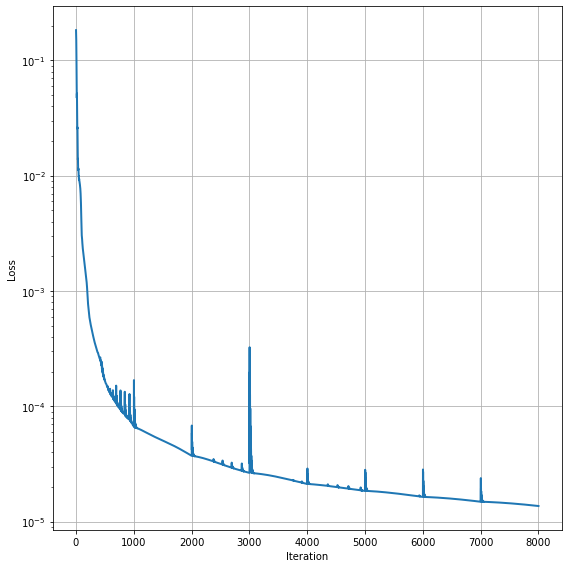

Loss = 1.3673368e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:01<32:03,  1.92s/it]

New min loss =  1.3673368e-05


Loss = 1.36727795e-05:   3%|████▋                                                                                                                                                  | 31/1000 [00:49<28:11,  1.75s/it]

New min loss =  1.36727795e-05


Loss = 1.3671091e-05:   5%|████████                                                                                                                                                | 53/1000 [01:34<33:07,  2.10s/it]

New min loss =  1.3671091e-05


Loss = 1.3663648e-05:   6%|████████▊                                                                                                                                               | 58/1000 [01:43<29:55,  1.91s/it]

New min loss =  1.3663648e-05


Loss = 1.3659888e-05:   6%|█████████▍                                                                                                                                              | 62/1000 [01:53<35:19,  2.26s/it]

New min loss =  1.3659888e-05


Loss = 1.3659391e-05:   7%|██████████                                                                                                                                              | 66/1000 [02:03<38:02,  2.44s/it]

New min loss =  1.3659391e-05


Loss = 1.3658714e-05:   7%|██████████▋                                                                                                                                             | 70/1000 [02:10<32:11,  2.08s/it]

New min loss =  1.3658714e-05


Loss = 1.3655969e-05:   7%|███████████▏                                                                                                                                            | 74/1000 [02:19<35:45,  2.32s/it]

New min loss =  1.3655969e-05


Loss = 1.3655785e-05:   8%|███████████▋                                                                                                                                            | 77/1000 [02:26<35:54,  2.33s/it]

New min loss =  1.3655785e-05


Loss = 1.3653298e-05:   8%|████████████▍                                                                                                                                           | 82/1000 [02:36<31:28,  2.06s/it]

New min loss =  1.3653298e-05


Loss = 1.365236e-05:   8%|█████████████                                                                                                                                            | 85/1000 [02:43<34:33,  2.27s/it]

New min loss =  1.365236e-05


Loss = 1.3651758e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [02:50<33:58,  2.24s/it]

New min loss =  1.3651758e-05


Loss = 1.3650678e-05:   9%|█████████████▌                                                                                                                                          | 89/1000 [02:52<35:00,  2.31s/it]

New min loss =  1.3650678e-05


Loss = 1.3649276e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [02:59<26:56,  1.78s/it]

New min loss =  1.3649276e-05


Loss = 1.3648131e-05:  10%|██████████████▌                                                                                                                                         | 96/1000 [03:06<31:29,  2.09s/it]

New min loss =  1.3648131e-05


Loss = 1.364803e-05:  10%|██████████████▊                                                                                                                                          | 97/1000 [03:09<33:03,  2.20s/it]

New min loss =  1.364803e-05


Loss = 1.3647026e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:13<34:05,  2.27s/it]

New min loss =  1.3647026e-05


Loss = 1.3646483e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:16<34:50,  2.32s/it]

New min loss =  1.3646483e-05


Loss = 1.3645807e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [03:21<36:13,  2.42s/it]

New min loss =  1.3645807e-05


Loss = 1.364509e-05:  10%|███████████████▋                                                                                                                                        | 103/1000 [03:23<35:06,  2.35s/it]

New min loss =  1.364509e-05


Loss = 1.364453e-05:  10%|███████████████▉                                                                                                                                        | 105/1000 [03:28<35:03,  2.35s/it]

New min loss =  1.364453e-05


Loss = 1.3643764e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [03:30<27:25,  1.84s/it]

New min loss =  1.3643764e-05


Loss = 1.3643618e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [03:32<29:25,  1.98s/it]

New min loss =  1.3643618e-05


Loss = 1.3643183e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [03:35<30:38,  2.06s/it]

New min loss =  1.3643183e-05


Loss = 1.3642443e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [03:37<31:55,  2.15s/it]

New min loss =  1.3642443e-05


Loss = 1.3642176e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [03:40<33:23,  2.25s/it]

New min loss =  1.3642176e-05


Loss = 1.3641788e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [03:42<33:59,  2.30s/it]

New min loss =  1.3641788e-05


Loss = 1.3641107e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [03:44<33:23,  2.26s/it]

New min loss =  1.3641107e-05


Loss = 1.364075e-05:  11%|█████████████████▎                                                                                                                                      | 114/1000 [03:47<33:41,  2.28s/it]

New min loss =  1.364075e-05


Loss = 1.3640386e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [03:49<33:55,  2.30s/it]

New min loss =  1.3640386e-05


Loss = 1.363976e-05:  12%|█████████████████▋                                                                                                                                      | 116/1000 [03:51<34:12,  2.32s/it]

New min loss =  1.363976e-05


Loss = 1.3639329e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [03:54<34:52,  2.37s/it]

New min loss =  1.3639329e-05


Loss = 1.36389735e-05:  12%|█████████████████▋                                                                                                                                    | 118/1000 [03:56<33:48,  2.30s/it]

New min loss =  1.36389735e-05


Loss = 1.3638376e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [03:58<34:27,  2.35s/it]

New min loss =  1.3638376e-05


Loss = 1.36379185e-05:  12%|██████████████████                                                                                                                                    | 120/1000 [04:01<35:17,  2.41s/it]

New min loss =  1.36379185e-05


Loss = 1.3637525e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:03<27:28,  1.88s/it]

New min loss =  1.3637525e-05


Loss = 1.3636984e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:06<28:33,  1.95s/it]

New min loss =  1.3636984e-05


Loss = 1.36365e-05:  12%|██████████████████▉                                                                                                                                      | 124/1000 [04:08<30:17,  2.07s/it]

New min loss =  1.36365e-05


Loss = 1.36360795e-05:  12%|██████████████████▊                                                                                                                                   | 125/1000 [04:10<32:02,  2.20s/it]

New min loss =  1.36360795e-05


Loss = 1.3635546e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [04:13<33:20,  2.29s/it]

New min loss =  1.3635546e-05


Loss = 1.36350645e-05:  13%|███████████████████                                                                                                                                   | 127/1000 [04:15<33:37,  2.31s/it]

New min loss =  1.36350645e-05


Loss = 1.3634623e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [04:18<33:22,  2.30s/it]

New min loss =  1.3634623e-05


Loss = 1.3634107e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [04:20<33:23,  2.30s/it]

New min loss =  1.3634107e-05


Loss = 1.3633608e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [04:22<33:44,  2.33s/it]

New min loss =  1.3633608e-05


Loss = 1.3633153e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [04:25<33:32,  2.32s/it]

New min loss =  1.3633153e-05


Loss = 1.3632637e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [04:27<34:16,  2.37s/it]

New min loss =  1.3632637e-05


Loss = 1.363214e-05:  13%|████████████████████▏                                                                                                                                   | 133/1000 [04:29<33:35,  2.33s/it]

New min loss =  1.363214e-05


Loss = 1.3631672e-05:  13%|████████████████████▏                                                                                                                                  | 134/1000 [04:32<34:06,  2.36s/it]

New min loss =  1.3631672e-05


Loss = 1.3631155e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [04:34<35:11,  2.44s/it]

New min loss =  1.3631155e-05


Loss = 1.363065e-05:  14%|████████████████████▋                                                                                                                                   | 136/1000 [04:37<35:41,  2.48s/it]

New min loss =  1.363065e-05


Loss = 1.3630168e-05:  14%|████████████████████▊                                                                                                                                  | 138/1000 [04:39<26:20,  1.83s/it]

New min loss =  1.3630168e-05


Loss = 1.36296485e-05:  14%|████████████████████▊                                                                                                                                 | 139/1000 [04:42<28:25,  1.98s/it]

New min loss =  1.36296485e-05


Loss = 1.362915e-05:  14%|█████████████████████▎                                                                                                                                  | 140/1000 [04:44<29:53,  2.09s/it]

New min loss =  1.362915e-05


Loss = 1.362865e-05:  14%|█████████████████████▍                                                                                                                                  | 141/1000 [04:46<31:33,  2.20s/it]

New min loss =  1.362865e-05


Loss = 1.3628116e-05:  14%|█████████████████████▍                                                                                                                                 | 142/1000 [04:49<31:31,  2.21s/it]

New min loss =  1.3628116e-05


Loss = 1.3627616e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [04:51<31:41,  2.22s/it]

New min loss =  1.3627616e-05


Loss = 1.3627105e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [04:53<31:34,  2.21s/it]

New min loss =  1.3627105e-05


Loss = 1.3626586e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [04:56<32:42,  2.30s/it]

New min loss =  1.3626586e-05


Loss = 1.3626073e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [04:58<33:24,  2.35s/it]

New min loss =  1.3626073e-05


Loss = 1.3625559e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [05:01<33:49,  2.38s/it]

New min loss =  1.3625559e-05


Loss = 1.3625029e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [05:03<32:38,  2.30s/it]

New min loss =  1.3625029e-05


Loss = 1.3624505e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [05:05<32:54,  2.32s/it]

New min loss =  1.3624505e-05


Loss = 1.3623982e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [05:07<33:07,  2.34s/it]

New min loss =  1.3623982e-05


Loss = 1.3623452e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [05:10<33:16,  2.35s/it]

New min loss =  1.3623452e-05


Loss = 1.3622927e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [05:12<32:47,  2.32s/it]

New min loss =  1.3622927e-05


Loss = 1.3622394e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [05:14<32:25,  2.30s/it]

New min loss =  1.3622394e-05


Loss = 1.36218605e-05:  16%|███████████████████████▎                                                                                                                              | 155/1000 [05:17<25:29,  1.81s/it]

New min loss =  1.36218605e-05


Loss = 1.3621324e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [05:19<27:43,  1.97s/it]

New min loss =  1.3621324e-05


Loss = 1.36207955e-05:  16%|███████████████████████▌                                                                                                                              | 157/1000 [05:22<29:15,  2.08s/it]

New min loss =  1.36207955e-05


Loss = 1.3620252e-05:  16%|███████████████████████▊                                                                                                                               | 158/1000 [05:24<29:39,  2.11s/it]

New min loss =  1.3620252e-05


Loss = 1.3619706e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [05:26<31:20,  2.24s/it]

New min loss =  1.3619706e-05


Loss = 1.3619181e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [05:29<31:43,  2.27s/it]

New min loss =  1.3619181e-05


Loss = 1.3618639e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [05:31<32:10,  2.30s/it]

New min loss =  1.3618639e-05


Loss = 1.3618079e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [05:33<32:07,  2.30s/it]

New min loss =  1.3618079e-05


Loss = 1.361753e-05:  16%|████████████████████████▊                                                                                                                               | 163/1000 [05:36<32:12,  2.31s/it]

New min loss =  1.361753e-05


Loss = 1.3616991e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [05:38<33:18,  2.39s/it]

New min loss =  1.3616991e-05


Loss = 1.3616438e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [05:41<33:55,  2.44s/it]

New min loss =  1.3616438e-05


Loss = 1.3615884e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [05:43<33:20,  2.40s/it]

New min loss =  1.3615884e-05


Loss = 1.3615331e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [05:45<32:56,  2.37s/it]

New min loss =  1.3615331e-05


Loss = 1.3614772e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [05:48<33:10,  2.39s/it]

New min loss =  1.3614772e-05


Loss = 1.3614215e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [05:50<33:07,  2.39s/it]

New min loss =  1.3614215e-05


Loss = 1.361367e-05:  17%|█████████████████████████▊                                                                                                                              | 170/1000 [05:53<33:38,  2.43s/it]

New min loss =  1.361367e-05


Loss = 1.3613093e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [05:55<32:12,  2.33s/it]

New min loss =  1.3613093e-05


Loss = 1.3612538e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [05:57<24:40,  1.79s/it]

New min loss =  1.3612538e-05


Loss = 1.3611973e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [06:00<27:09,  1.97s/it]

New min loss =  1.3611973e-05


Loss = 1.3611406e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [06:02<29:19,  2.13s/it]

New min loss =  1.3611406e-05


Loss = 1.3610836e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [06:05<29:29,  2.15s/it]

New min loss =  1.3610836e-05


Loss = 1.3610257e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [06:07<30:30,  2.22s/it]

New min loss =  1.3610257e-05


Loss = 1.36096905e-05:  18%|██████████████████████████▋                                                                                                                           | 178/1000 [06:09<31:19,  2.29s/it]

New min loss =  1.36096905e-05


Loss = 1.3609118e-05:  18%|███████████████████████████                                                                                                                            | 179/1000 [06:12<32:13,  2.35s/it]

New min loss =  1.3609118e-05


Loss = 1.3608541e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [06:14<31:32,  2.31s/it]

New min loss =  1.3608541e-05


Loss = 1.36079625e-05:  18%|███████████████████████████▏                                                                                                                          | 181/1000 [06:16<31:30,  2.31s/it]

New min loss =  1.36079625e-05


Loss = 1.3607379e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [06:19<32:15,  2.37s/it]

New min loss =  1.3607379e-05


Loss = 1.3606805e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [06:21<32:31,  2.39s/it]

New min loss =  1.3606805e-05


Loss = 1.3606226e-05:  18%|███████████████████████████▊                                                                                                                           | 184/1000 [06:24<32:37,  2.40s/it]

New min loss =  1.3606226e-05


Loss = 1.3605636e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [06:26<32:20,  2.38s/it]

New min loss =  1.3605636e-05


Loss = 1.3605049e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [06:29<32:23,  2.39s/it]

New min loss =  1.3605049e-05


Loss = 1.3604462e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [06:31<32:29,  2.40s/it]

New min loss =  1.3604462e-05


Loss = 1.3603862e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [06:33<32:33,  2.41s/it]

New min loss =  1.3603862e-05


Loss = 1.3603287e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [06:36<31:30,  2.33s/it]

New min loss =  1.3603287e-05


Loss = 1.3602683e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [06:38<31:34,  2.34s/it]

New min loss =  1.3602683e-05


Loss = 1.3602081e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [06:40<24:54,  1.85s/it]

New min loss =  1.3602081e-05


Loss = 1.3601494e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [06:43<27:15,  2.03s/it]

New min loss =  1.3601494e-05


Loss = 1.3600901e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [06:45<28:14,  2.10s/it]

New min loss =  1.3600901e-05


Loss = 1.3600302e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [06:48<28:54,  2.15s/it]

New min loss =  1.3600302e-05


Loss = 1.35997025e-05:  20%|█████████████████████████████▍                                                                                                                        | 196/1000 [06:50<30:47,  2.30s/it]

New min loss =  1.35997025e-05


Loss = 1.3599096e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [06:53<30:39,  2.29s/it]

New min loss =  1.3599096e-05


Loss = 1.3598478e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [06:55<30:37,  2.29s/it]

New min loss =  1.3598478e-05


Loss = 1.3597884e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [06:57<30:28,  2.28s/it]

New min loss =  1.3597884e-05


Loss = 1.359728e-05:  20%|██████████████████████████████▍                                                                                                                         | 200/1000 [07:00<30:56,  2.32s/it]

New min loss =  1.359728e-05


Loss = 1.359666e-05:  20%|██████████████████████████████▌                                                                                                                         | 201/1000 [07:02<31:41,  2.38s/it]

New min loss =  1.359666e-05


Loss = 1.3596052e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [07:04<31:46,  2.39s/it]

New min loss =  1.3596052e-05


Loss = 1.3595438e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [07:07<31:17,  2.36s/it]

New min loss =  1.3595438e-05


Loss = 1.35948185e-05:  20%|██████████████████████████████▌                                                                                                                       | 204/1000 [07:09<31:39,  2.39s/it]

New min loss =  1.35948185e-05


Loss = 1.3594205e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [07:12<31:13,  2.36s/it]

New min loss =  1.3594205e-05


Loss = 1.3593578e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [07:14<31:03,  2.35s/it]

New min loss =  1.3593578e-05


Loss = 1.3592964e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [07:16<31:29,  2.38s/it]

New min loss =  1.3592964e-05


Loss = 1.3592346e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [07:19<31:15,  2.37s/it]

New min loss =  1.3592346e-05


Loss = 1.3591712e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [07:21<31:34,  2.39s/it]

New min loss =  1.3591712e-05


Loss = 1.3591094e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [07:23<31:08,  2.37s/it]

New min loss =  1.3591094e-05


Loss = 1.3590467e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [07:26<23:53,  1.82s/it]

New min loss =  1.3590467e-05


Loss = 1.3589838e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [07:28<26:04,  1.99s/it]

New min loss =  1.3589838e-05


Loss = 1.358921e-05:  21%|████████████████████████████████▌                                                                                                                       | 214/1000 [07:31<27:06,  2.07s/it]

New min loss =  1.358921e-05


Loss = 1.3588571e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [07:33<28:38,  2.19s/it]

New min loss =  1.3588571e-05


Loss = 1.3587949e-05:  22%|████████████████████████████████▌                                                                                                                      | 216/1000 [07:35<29:06,  2.23s/it]

New min loss =  1.3587949e-05


Loss = 1.3587306e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [07:38<29:41,  2.28s/it]

New min loss =  1.3587306e-05


Loss = 1.3586679e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [07:40<30:07,  2.31s/it]

New min loss =  1.3586679e-05


Loss = 1.3586034e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [07:43<30:46,  2.36s/it]

New min loss =  1.3586034e-05


Loss = 1.358541e-05:  22%|█████████████████████████████████▍                                                                                                                      | 220/1000 [07:45<30:42,  2.36s/it]

New min loss =  1.358541e-05


Loss = 1.35847595e-05:  22%|█████████████████████████████████▏                                                                                                                    | 221/1000 [07:47<30:01,  2.31s/it]

New min loss =  1.35847595e-05


Loss = 1.3584129e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [07:50<29:59,  2.31s/it]

New min loss =  1.3584129e-05


Loss = 1.3583473e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [07:52<30:30,  2.36s/it]

New min loss =  1.3583473e-05


Loss = 1.3582833e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [07:54<30:29,  2.36s/it]

New min loss =  1.3582833e-05


Loss = 1.3582192e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [07:57<31:10,  2.41s/it]

New min loss =  1.3582192e-05


Loss = 1.3581545e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [07:59<30:11,  2.34s/it]

New min loss =  1.3581545e-05


Loss = 1.3580898e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [08:02<30:40,  2.38s/it]

New min loss =  1.3580898e-05


Loss = 1.3580247e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [08:04<30:51,  2.40s/it]

New min loss =  1.3580247e-05


Loss = 1.3579598e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [08:07<31:35,  2.46s/it]

New min loss =  1.3579598e-05


Loss = 1.3578953e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [08:09<30:17,  2.36s/it]

New min loss =  1.3578953e-05


Loss = 1.3578281e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [08:11<30:56,  2.41s/it]

New min loss =  1.3578281e-05


Loss = 1.3577637e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [08:14<24:03,  1.88s/it]

New min loss =  1.3577637e-05


Loss = 1.35769815e-05:  23%|███████████████████████████████████                                                                                                                   | 234/1000 [08:16<26:07,  2.05s/it]

New min loss =  1.35769815e-05


Loss = 1.3576323e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [08:19<26:31,  2.08s/it]

New min loss =  1.3576323e-05


Loss = 1.357567e-05:  24%|███████████████████████████████████▊                                                                                                                    | 236/1000 [08:21<27:05,  2.13s/it]

New min loss =  1.357567e-05


Loss = 1.3575005e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [08:23<27:45,  2.18s/it]

New min loss =  1.3575005e-05


Loss = 1.357435e-05:  24%|████████████████████████████████████▏                                                                                                                   | 238/1000 [08:25<28:34,  2.25s/it]

New min loss =  1.357435e-05


Loss = 1.35736855e-05:  24%|███████████████████████████████████▊                                                                                                                  | 239/1000 [08:28<30:01,  2.37s/it]

New min loss =  1.35736855e-05


Loss = 1.3573016e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [08:30<29:08,  2.30s/it]

New min loss =  1.3573016e-05


Loss = 1.3572358e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [08:33<28:58,  2.29s/it]

New min loss =  1.3572358e-05


Loss = 1.3571678e-05:  24%|████████████████████████████████████▌                                                                                                                  | 242/1000 [08:35<29:09,  2.31s/it]

New min loss =  1.3571678e-05


Loss = 1.3571021e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [08:37<29:40,  2.35s/it]

New min loss =  1.3571021e-05


Loss = 1.357035e-05:  24%|█████████████████████████████████████                                                                                                                   | 244/1000 [08:40<30:02,  2.38s/it]

New min loss =  1.357035e-05


Loss = 1.3569671e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [08:42<29:17,  2.33s/it]

New min loss =  1.3569671e-05


Loss = 1.356901e-05:  25%|█████████████████████████████████████▍                                                                                                                  | 246/1000 [08:45<30:03,  2.39s/it]

New min loss =  1.356901e-05


Loss = 1.35683285e-05:  25%|█████████████████████████████████████                                                                                                                 | 247/1000 [08:47<30:04,  2.40s/it]

New min loss =  1.35683285e-05


Loss = 1.3567659e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [08:49<30:04,  2.40s/it]

New min loss =  1.3567659e-05


Loss = 1.3566984e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [08:52<29:55,  2.39s/it]

New min loss =  1.3566984e-05


Loss = 1.3566312e-05:  25%|█████████████████████████████████████▊                                                                                                                 | 250/1000 [08:54<29:34,  2.37s/it]

New min loss =  1.3566312e-05


Loss = 1.3565626e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [08:56<29:29,  2.36s/it]

New min loss =  1.3565626e-05


Loss = 1.3564951e-05:  25%|██████████████████████████████████████                                                                                                                 | 252/1000 [08:59<29:48,  2.39s/it]

New min loss =  1.3564951e-05


Loss = 1.3564262e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [09:01<30:16,  2.43s/it]

New min loss =  1.3564262e-05


Loss = 1.3563588e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [09:04<23:03,  1.86s/it]

New min loss =  1.3563588e-05


Loss = 1.3562894e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [09:06<24:08,  1.95s/it]

New min loss =  1.3562894e-05


Loss = 1.3562213e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [09:09<26:29,  2.14s/it]

New min loss =  1.3562213e-05


Loss = 1.356153e-05:  26%|███████████████████████████████████████▏                                                                                                                | 258/1000 [09:11<27:26,  2.22s/it]

New min loss =  1.356153e-05


Loss = 1.3560843e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [09:13<27:38,  2.24s/it]

New min loss =  1.3560843e-05


Loss = 1.356014e-05:  26%|███████████████████████████████████████▌                                                                                                                | 260/1000 [09:16<27:52,  2.26s/it]

New min loss =  1.356014e-05


Loss = 1.3559461e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [09:18<28:25,  2.31s/it]

New min loss =  1.3559461e-05


Loss = 1.3558766e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [09:21<29:32,  2.40s/it]

New min loss =  1.3558766e-05


Loss = 1.3558064e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [09:23<29:27,  2.40s/it]

New min loss =  1.3558064e-05


Loss = 1.355737e-05:  26%|████████████████████████████████████████▏                                                                                                               | 264/1000 [09:25<28:33,  2.33s/it]

New min loss =  1.355737e-05


Loss = 1.3556677e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [09:28<28:38,  2.34s/it]

New min loss =  1.3556677e-05


Loss = 1.3555979e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [09:30<29:01,  2.37s/it]

New min loss =  1.3555979e-05


Loss = 1.35552855e-05:  27%|████████████████████████████████████████                                                                                                              | 267/1000 [09:33<29:16,  2.40s/it]

New min loss =  1.35552855e-05


Loss = 1.3554574e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [09:35<29:10,  2.39s/it]

New min loss =  1.3554574e-05


Loss = 1.3553888e-05:  27%|████████████████████████████████████████▌                                                                                                              | 269/1000 [09:37<28:36,  2.35s/it]

New min loss =  1.3553888e-05


Loss = 1.3553185e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [09:40<28:41,  2.36s/it]

New min loss =  1.3553185e-05


Loss = 1.3552475e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [09:42<29:19,  2.41s/it]

New min loss =  1.3552475e-05


Loss = 1.3551763e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [09:44<28:59,  2.39s/it]

New min loss =  1.3551763e-05


Loss = 1.3551059e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [09:47<28:44,  2.37s/it]

New min loss =  1.3551059e-05


Loss = 1.3550347e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [09:49<28:11,  2.33s/it]

New min loss =  1.3550347e-05


Loss = 1.3549647e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [09:51<28:32,  2.36s/it]

New min loss =  1.3549647e-05


Loss = 1.3548942e-05:  28%|█████████████████████████████████████████▋                                                                                                             | 276/1000 [09:54<28:17,  2.34s/it]

New min loss =  1.3548942e-05


Loss = 1.3548222e-05:  28%|█████████████████████████████████████████▉                                                                                                             | 278/1000 [09:56<21:51,  1.82s/it]

New min loss =  1.3548222e-05


Loss = 1.3547501e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [09:58<23:12,  1.93s/it]

New min loss =  1.3547501e-05


Loss = 1.3546792e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [10:01<24:49,  2.07s/it]

New min loss =  1.3546792e-05


Loss = 1.35460705e-05:  28%|██████████████████████████████████████████▏                                                                                                           | 281/1000 [10:03<25:27,  2.12s/it]

New min loss =  1.35460705e-05


Loss = 1.3545356e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [10:05<25:56,  2.17s/it]

New min loss =  1.3545356e-05


Loss = 1.3544637e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [10:08<26:33,  2.22s/it]

New min loss =  1.3544637e-05


Loss = 1.3543919e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [10:10<26:45,  2.24s/it]

New min loss =  1.3543919e-05


Loss = 1.3543204e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [10:13<28:22,  2.38s/it]

New min loss =  1.3543204e-05


Loss = 1.3542472e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [10:15<27:55,  2.35s/it]

New min loss =  1.3542472e-05


Loss = 1.3541752e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [10:17<27:23,  2.30s/it]

New min loss =  1.3541752e-05


Loss = 1.3541031e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [10:20<27:26,  2.31s/it]

New min loss =  1.3541031e-05


Loss = 1.3540308e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [10:22<27:41,  2.34s/it]

New min loss =  1.3540308e-05


Loss = 1.3539582e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [10:24<28:03,  2.37s/it]

New min loss =  1.3539582e-05


Loss = 1.3538846e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [10:27<27:50,  2.36s/it]

New min loss =  1.3538846e-05


Loss = 1.3538115e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [10:29<27:38,  2.34s/it]

New min loss =  1.3538115e-05


Loss = 1.3537389e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [10:31<27:46,  2.36s/it]

New min loss =  1.3537389e-05


Loss = 1.3536659e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [10:34<28:19,  2.41s/it]

New min loss =  1.3536659e-05


Loss = 1.3535926e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [10:36<28:29,  2.42s/it]

New min loss =  1.3535926e-05


Loss = 1.3535193e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [10:39<28:26,  2.42s/it]

New min loss =  1.3535193e-05


Loss = 1.3534463e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [10:41<28:42,  2.45s/it]

New min loss =  1.3534463e-05


Loss = 1.3533732e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [10:44<29:14,  2.50s/it]

New min loss =  1.3533732e-05


Loss = 1.3532981e-05:  30%|█████████████████████████████████████████████▏                                                                                                         | 299/1000 [10:46<28:01,  2.40s/it]

New min loss =  1.3532981e-05


Loss = 1.35322425e-05:  30%|█████████████████████████████████████████████                                                                                                         | 300/1000 [10:49<28:03,  2.40s/it]

New min loss =  1.35322425e-05


Loss = 1.3531506e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [10:51<22:07,  1.90s/it]

New min loss =  1.3531506e-05


Loss = 1.3530758e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [10:54<23:19,  2.01s/it]

New min loss =  1.3530758e-05


Loss = 1.3530025e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [10:56<24:59,  2.15s/it]

New min loss =  1.3530025e-05


Loss = 1.3529279e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [10:58<25:01,  2.16s/it]

New min loss =  1.3529279e-05


Loss = 1.3528532e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [11:01<25:31,  2.21s/it]

New min loss =  1.3528532e-05


Loss = 1.35278015e-05:  31%|██████████████████████████████████████████████                                                                                                        | 307/1000 [11:03<26:06,  2.26s/it]

New min loss =  1.35278015e-05


Loss = 1.35270475e-05:  31%|██████████████████████████████████████████████▏                                                                                                       | 308/1000 [11:05<26:36,  2.31s/it]

New min loss =  1.35270475e-05


Loss = 1.35263e-05:  31%|███████████████████████████████████████████████▎                                                                                                         | 309/1000 [11:08<27:33,  2.39s/it]

New min loss =  1.35263e-05


Loss = 1.3525554e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [11:10<26:53,  2.34s/it]

New min loss =  1.3525554e-05


Loss = 1.3524799e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [11:13<27:23,  2.38s/it]

New min loss =  1.3524799e-05


Loss = 1.3524051e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [11:15<27:30,  2.40s/it]

New min loss =  1.3524051e-05


Loss = 1.3523299e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [11:18<28:00,  2.45s/it]

New min loss =  1.3523299e-05


Loss = 1.3522554e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [11:20<27:12,  2.38s/it]

New min loss =  1.3522554e-05


Loss = 1.35218e-05:  32%|████████████████████████████████████████████████▏                                                                                                        | 315/1000 [11:22<27:21,  2.40s/it]

New min loss =  1.35218e-05


Loss = 1.3521037e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [11:25<27:34,  2.42s/it]

New min loss =  1.3521037e-05


Loss = 1.352028e-05:  32%|████████████████████████████████████████████████▏                                                                                                       | 317/1000 [11:27<27:30,  2.42s/it]

New min loss =  1.352028e-05


Loss = 1.3519521e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [11:30<26:49,  2.36s/it]

New min loss =  1.3519521e-05


Loss = 1.3518771e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [11:32<26:41,  2.35s/it]

New min loss =  1.3518771e-05


Loss = 1.3518003e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [11:34<26:45,  2.36s/it]

New min loss =  1.3518003e-05


Loss = 1.3517246e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [11:37<26:47,  2.37s/it]

New min loss =  1.3517246e-05


Loss = 1.3516483e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [11:39<26:45,  2.37s/it]

New min loss =  1.3516483e-05


Loss = 1.3515713e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [11:42<27:12,  2.41s/it]

New min loss =  1.3515713e-05


Loss = 1.35149585e-05:  32%|████████████████████████████████████████████████▌                                                                                                     | 324/1000 [11:44<27:22,  2.43s/it]

New min loss =  1.35149585e-05


Loss = 1.35141845e-05:  32%|████████████████████████████████████████████████▊                                                                                                     | 325/1000 [11:46<27:28,  2.44s/it]

New min loss =  1.35141845e-05


Loss = 1.3513409e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [11:49<20:36,  1.84s/it]

New min loss =  1.3513409e-05


Loss = 1.351265e-05:  33%|█████████████████████████████████████████████████▊                                                                                                      | 328/1000 [11:51<21:48,  1.95s/it]

New min loss =  1.351265e-05


Loss = 1.3511873e-05:  33%|█████████████████████████████████████████████████▋                                                                                                     | 329/1000 [11:53<22:55,  2.05s/it]

New min loss =  1.3511873e-05


Loss = 1.3511107e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [11:56<24:16,  2.17s/it]

New min loss =  1.3511107e-05


Loss = 1.3510327e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [11:58<25:08,  2.26s/it]

New min loss =  1.3510327e-05


Loss = 1.3509558e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [12:01<25:45,  2.31s/it]

New min loss =  1.3509558e-05


Loss = 1.3508783e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [12:03<26:50,  2.41s/it]

New min loss =  1.3508783e-05


Loss = 1.3508003e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [12:06<26:42,  2.41s/it]

New min loss =  1.3508003e-05


Loss = 1.3507217e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [12:08<27:28,  2.48s/it]

New min loss =  1.3507217e-05


Loss = 1.3506437e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [12:11<27:04,  2.45s/it]

New min loss =  1.3506437e-05


Loss = 1.3505662e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [12:13<27:16,  2.47s/it]

New min loss =  1.3505662e-05


Loss = 1.3504887e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [12:16<27:21,  2.48s/it]

New min loss =  1.3504887e-05


Loss = 1.3504098e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [12:18<27:49,  2.53s/it]

New min loss =  1.3504098e-05


Loss = 1.350331e-05:  34%|███████████████████████████████████████████████████▋                                                                                                    | 340/1000 [12:21<27:53,  2.54s/it]

New min loss =  1.350331e-05


Loss = 1.3502522e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [12:24<27:36,  2.51s/it]

New min loss =  1.3502522e-05


Loss = 1.3501741e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [12:26<28:04,  2.56s/it]

New min loss =  1.3501741e-05


Loss = 1.3500951e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [12:29<27:45,  2.53s/it]

New min loss =  1.3500951e-05


Loss = 1.3500148e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [12:31<27:48,  2.54s/it]

New min loss =  1.3500148e-05


Loss = 1.3499364e-05:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [12:34<27:41,  2.54s/it]

New min loss =  1.3499364e-05


Loss = 1.3498578e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [12:36<27:29,  2.52s/it]

New min loss =  1.3498578e-05


Loss = 1.3497794e-05:  35%|████████████████████████████████████████████████████▍                                                                                                  | 347/1000 [12:39<27:07,  2.49s/it]

New min loss =  1.3497794e-05


Loss = 1.3497007e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [12:41<26:26,  2.43s/it]

New min loss =  1.3497007e-05


Loss = 1.3496199e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [12:43<26:46,  2.47s/it]

New min loss =  1.3496199e-05


Loss = 1.349541e-05:  35%|█████████████████████████████████████████████████████▏                                                                                                  | 350/1000 [12:46<27:56,  2.58s/it]

New min loss =  1.349541e-05


Loss = 1.3494608e-05:  35%|█████████████████████████████████████████████████████                                                                                                  | 351/1000 [12:49<29:29,  2.73s/it]

New min loss =  1.3494608e-05


Loss = 1.3493812e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [12:52<22:23,  2.08s/it]

New min loss =  1.3493812e-05


Loss = 1.3493024e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [12:55<24:01,  2.23s/it]

New min loss =  1.3493024e-05


Loss = 1.3492215e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [12:58<25:53,  2.41s/it]

New min loss =  1.3492215e-05


Loss = 1.3491425e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [13:01<27:24,  2.55s/it]

New min loss =  1.3491425e-05


Loss = 1.3490628e-05:  36%|█████████████████████████████████████████████████████▉                                                                                                 | 357/1000 [13:03<27:59,  2.61s/it]

New min loss =  1.3490628e-05


Loss = 1.348982e-05:  36%|██████████████████████████████████████████████████████▍                                                                                                 | 358/1000 [13:06<28:09,  2.63s/it]

New min loss =  1.348982e-05


Loss = 1.348901e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                 | 359/1000 [13:09<29:59,  2.81s/it]

New min loss =  1.348901e-05


Loss = 1.3488215e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [13:12<30:20,  2.84s/it]

New min loss =  1.3488215e-05


Loss = 1.348742e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                 | 361/1000 [13:15<30:52,  2.90s/it]

New min loss =  1.348742e-05


Loss = 1.3486608e-05:  36%|██████████████████████████████████████████████████████▋                                                                                                | 362/1000 [13:18<29:47,  2.80s/it]

New min loss =  1.3486608e-05


Loss = 1.3485801e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [13:21<30:40,  2.89s/it]

New min loss =  1.3485801e-05


Loss = 1.3484991e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [13:24<30:22,  2.87s/it]

New min loss =  1.3484991e-05


Loss = 1.3484186e-05:  36%|███████████████████████████████████████████████████████                                                                                                | 365/1000 [13:27<30:09,  2.85s/it]

New min loss =  1.3484186e-05


Loss = 1.348339e-05:  37%|███████████████████████████████████████████████████████▋                                                                                                | 366/1000 [13:29<28:47,  2.72s/it]

New min loss =  1.348339e-05


Loss = 1.3482577e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [13:32<28:20,  2.69s/it]

New min loss =  1.3482577e-05


Loss = 1.3481758e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [13:34<28:45,  2.73s/it]

New min loss =  1.3481758e-05


Loss = 1.3480948e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [13:37<28:38,  2.72s/it]

New min loss =  1.3480948e-05


Loss = 1.34801385e-05:  37%|███████████████████████████████████████████████████████▌                                                                                              | 370/1000 [13:40<28:46,  2.74s/it]

New min loss =  1.34801385e-05


Loss = 1.3479318e-05:  37%|████████████████████████████████████████████████████████                                                                                               | 371/1000 [13:42<28:15,  2.70s/it]

New min loss =  1.3479318e-05


Loss = 1.3478502e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [13:45<28:41,  2.74s/it]

New min loss =  1.3478502e-05


Loss = 1.3477685e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [13:48<28:35,  2.74s/it]

New min loss =  1.3477685e-05


Loss = 1.3476871e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [13:51<29:01,  2.78s/it]

New min loss =  1.3476871e-05


Loss = 1.3476054e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [13:54<28:32,  2.74s/it]

New min loss =  1.3476054e-05


Loss = 1.3475238e-05:  38%|████████████████████████████████████████████████████████▊                                                                                              | 376/1000 [13:56<28:28,  2.74s/it]

New min loss =  1.3475238e-05


Loss = 1.3474415e-05:  38%|████████████████████████████████████████████████████████▉                                                                                              | 377/1000 [13:59<28:32,  2.75s/it]

New min loss =  1.3474415e-05


Loss = 1.3473597e-05:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [14:02<29:41,  2.86s/it]

New min loss =  1.3473597e-05


Loss = 1.3472774e-05:  38%|█████████████████████████████████████████████████████████▍                                                                                             | 380/1000 [14:05<21:51,  2.12s/it]

New min loss =  1.3472774e-05


Loss = 1.3471941e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [14:08<23:43,  2.30s/it]

New min loss =  1.3471941e-05


Loss = 1.3471119e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [14:10<23:14,  2.26s/it]

New min loss =  1.3471119e-05


Loss = 1.3470298e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [14:12<22:38,  2.20s/it]

New min loss =  1.3470298e-05


Loss = 1.3469478e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [14:14<21:22,  2.08s/it]

New min loss =  1.3469478e-05


Loss = 1.346864e-05:  38%|██████████████████████████████████████████████████████████▌                                                                                             | 385/1000 [14:16<21:09,  2.06s/it]

New min loss =  1.346864e-05


Loss = 1.3467809e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [14:18<20:53,  2.04s/it]

New min loss =  1.3467809e-05


Loss = 1.34669845e-05:  39%|██████████████████████████████████████████████████████████                                                                                            | 387/1000 [14:19<20:26,  2.00s/it]

New min loss =  1.34669845e-05


Loss = 1.3466161e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [14:21<19:46,  1.94s/it]

New min loss =  1.3466161e-05


Loss = 1.3465324e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [14:23<19:53,  1.95s/it]

New min loss =  1.3465324e-05


Loss = 1.3464487e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [14:25<19:37,  1.93s/it]

New min loss =  1.3464487e-05


Loss = 1.3463658e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [14:27<19:42,  1.94s/it]

New min loss =  1.3463658e-05


Loss = 1.34628235e-05:  39%|██████████████████████████████████████████████████████████▊                                                                                           | 392/1000 [14:29<19:27,  1.92s/it]

New min loss =  1.34628235e-05


Loss = 1.34619895e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                           | 393/1000 [14:31<19:15,  1.90s/it]

New min loss =  1.34619895e-05


Loss = 1.3461157e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [14:33<20:15,  2.01s/it]

New min loss =  1.3461157e-05


Loss = 1.3460317e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [14:35<21:26,  2.13s/it]

New min loss =  1.3460317e-05


Loss = 1.3459486e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [14:38<22:10,  2.20s/it]

New min loss =  1.3459486e-05


Loss = 1.3458639e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [14:40<22:50,  2.27s/it]

New min loss =  1.3458639e-05


Loss = 1.3457803e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [14:43<23:00,  2.29s/it]

New min loss =  1.3457803e-05


Loss = 1.3456969e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [14:45<23:09,  2.31s/it]

New min loss =  1.3456969e-05


Loss = 1.3456118e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [14:47<23:32,  2.35s/it]

New min loss =  1.3456118e-05


Loss = 1.3455285e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [14:50<23:29,  2.35s/it]

New min loss =  1.3455285e-05


Loss = 1.3454442e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [14:52<23:39,  2.37s/it]

New min loss =  1.3454442e-05


Loss = 1.3453585e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [14:55<23:39,  2.38s/it]

New min loss =  1.3453585e-05


Loss = 1.3452738e-05:  40%|█████████████████████████████████████████████████████████████                                                                                          | 404/1000 [14:57<23:38,  2.38s/it]

New min loss =  1.3452738e-05


Loss = 1.3451883e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [14:59<23:37,  2.38s/it]

New min loss =  1.3451883e-05


Loss = 1.3451038e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [15:02<23:54,  2.41s/it]

New min loss =  1.3451038e-05


Loss = 1.3450187e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [15:04<18:36,  1.89s/it]

New min loss =  1.3450187e-05


Loss = 1.3449334e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [15:07<19:49,  2.01s/it]

New min loss =  1.3449334e-05


Loss = 1.3448487e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [15:09<20:36,  2.10s/it]

New min loss =  1.3448487e-05


Loss = 1.344763e-05:  41%|██████████████████████████████████████████████████████████████▍                                                                                         | 411/1000 [15:11<20:57,  2.14s/it]

New min loss =  1.344763e-05


Loss = 1.3446779e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [15:14<21:29,  2.19s/it]

New min loss =  1.3446779e-05


Loss = 1.3445918e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [15:16<22:11,  2.27s/it]

New min loss =  1.3445918e-05


Loss = 1.3445065e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [15:19<22:34,  2.31s/it]

New min loss =  1.3445065e-05


Loss = 1.3444204e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [15:21<22:31,  2.31s/it]

New min loss =  1.3444204e-05


Loss = 1.3443338e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [15:23<22:20,  2.30s/it]

New min loss =  1.3443338e-05


Loss = 1.3442473e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [15:26<22:54,  2.36s/it]

New min loss =  1.3442473e-05


Loss = 1.34416105e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                       | 418/1000 [15:28<22:46,  2.35s/it]

New min loss =  1.34416105e-05


Loss = 1.3440745e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [15:30<22:56,  2.37s/it]

New min loss =  1.3440745e-05


Loss = 1.3439869e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [15:33<22:26,  2.32s/it]

New min loss =  1.3439869e-05


Loss = 1.3439003e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [15:35<22:11,  2.30s/it]

New min loss =  1.3439003e-05


Loss = 1.343813e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                       | 422/1000 [15:37<22:29,  2.33s/it]

New min loss =  1.343813e-05


Loss = 1.3437265e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [15:40<22:41,  2.36s/it]

New min loss =  1.3437265e-05


Loss = 1.3436391e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [15:42<22:53,  2.38s/it]

New min loss =  1.3436391e-05


Loss = 1.3435513e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [15:44<22:53,  2.39s/it]

New min loss =  1.3435513e-05


Loss = 1.3434648e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [15:47<22:40,  2.37s/it]

New min loss =  1.3434648e-05


Loss = 1.3433754e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [15:49<22:59,  2.41s/it]

New min loss =  1.3433754e-05


Loss = 1.3432893e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [15:52<23:06,  2.42s/it]

New min loss =  1.3432893e-05


Loss = 1.3432011e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [15:54<22:22,  2.35s/it]

New min loss =  1.3432011e-05


Loss = 1.3431137e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [15:56<22:21,  2.35s/it]

New min loss =  1.3431137e-05


Loss = 1.3430244e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [15:59<22:54,  2.41s/it]

New min loss =  1.3430244e-05


Loss = 1.3429378e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [16:01<22:38,  2.39s/it]

New min loss =  1.3429378e-05


Loss = 1.3428491e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [16:03<22:02,  2.33s/it]

New min loss =  1.3428491e-05


Loss = 1.3427603e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [16:06<22:10,  2.35s/it]

New min loss =  1.3427603e-05


Loss = 1.342673e-05:  44%|██████████████████████████████████████████████████████████████████                                                                                      | 435/1000 [16:08<22:13,  2.36s/it]

New min loss =  1.342673e-05


Loss = 1.3425836e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [16:11<17:35,  1.87s/it]

New min loss =  1.3425836e-05


Loss = 1.3424948e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [16:13<18:32,  1.98s/it]

New min loss =  1.3424948e-05


Loss = 1.3424057e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [16:15<19:29,  2.08s/it]

New min loss =  1.3424057e-05


Loss = 1.3423175e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [16:18<20:19,  2.18s/it]

New min loss =  1.3423175e-05


Loss = 1.3422277e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [16:20<20:37,  2.21s/it]

New min loss =  1.3422277e-05


Loss = 1.3421392e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [16:23<21:15,  2.29s/it]

New min loss =  1.3421392e-05


Loss = 1.3420496e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [16:25<21:10,  2.28s/it]

New min loss =  1.3420496e-05


Loss = 1.3419604e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [16:27<21:49,  2.36s/it]

New min loss =  1.3419604e-05


Loss = 1.3418704e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [16:30<22:03,  2.38s/it]

New min loss =  1.3418704e-05


Loss = 1.3417822e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [16:32<21:56,  2.38s/it]

New min loss =  1.3417822e-05


Loss = 1.3416907e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [16:35<21:28,  2.33s/it]

New min loss =  1.3416907e-05


Loss = 1.3416019e-05:  45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 448/1000 [16:37<21:44,  2.36s/it]

New min loss =  1.3416019e-05


Loss = 1.3415107e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [16:39<21:47,  2.37s/it]

New min loss =  1.3415107e-05


Loss = 1.341421e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 450/1000 [16:42<22:11,  2.42s/it]

New min loss =  1.341421e-05


Loss = 1.341331e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 451/1000 [16:44<21:45,  2.38s/it]

New min loss =  1.341331e-05


Loss = 1.341241e-05:  45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 452/1000 [16:47<21:44,  2.38s/it]

New min loss =  1.341241e-05


Loss = 1.3411496e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [16:49<21:53,  2.40s/it]

New min loss =  1.3411496e-05


Loss = 1.3410598e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [16:51<21:39,  2.38s/it]

New min loss =  1.3410598e-05


Loss = 1.3409692e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [16:54<21:26,  2.36s/it]

New min loss =  1.3409692e-05


Loss = 1.3408777e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [16:56<20:50,  2.30s/it]

New min loss =  1.3408777e-05


Loss = 1.3407873e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [16:58<20:33,  2.27s/it]

New min loss =  1.3407873e-05


Loss = 1.3406971e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [17:00<20:56,  2.32s/it]

New min loss =  1.3406971e-05


Loss = 1.3406047e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [17:03<20:57,  2.32s/it]

New min loss =  1.3406047e-05


Loss = 1.3405144e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 460/1000 [17:05<21:17,  2.37s/it]

New min loss =  1.3405144e-05


Loss = 1.3404223e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [17:07<20:46,  2.31s/it]

New min loss =  1.3404223e-05


Loss = 1.3403305e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 462/1000 [17:10<21:26,  2.39s/it]

New min loss =  1.3403305e-05


Loss = 1.3402385e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 463/1000 [17:12<21:31,  2.40s/it]

New min loss =  1.3402385e-05


Loss = 1.3401468e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                 | 464/1000 [17:15<21:24,  2.40s/it]

New min loss =  1.3401468e-05


Loss = 1.3400551e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [17:17<20:45,  2.33s/it]

New min loss =  1.3400551e-05


Loss = 1.3399631e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [17:19<15:59,  1.80s/it]

New min loss =  1.3399631e-05


Loss = 1.339871e-05:  47%|███████████████████████████████████████████████████████████████████████▏                                                                                | 468/1000 [17:22<17:06,  1.93s/it]

New min loss =  1.339871e-05


Loss = 1.3397782e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [17:24<18:17,  2.07s/it]

New min loss =  1.3397782e-05


Loss = 1.3396859e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [17:27<19:03,  2.16s/it]

New min loss =  1.3396859e-05


Loss = 1.3395936e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                                | 471/1000 [17:29<18:54,  2.14s/it]

New min loss =  1.3395936e-05


Loss = 1.3395005e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 472/1000 [17:31<19:42,  2.24s/it]

New min loss =  1.3395005e-05


Loss = 1.3394085e-05:  47%|███████████████████████████████████████████████████████████████████████▍                                                                               | 473/1000 [17:34<20:04,  2.29s/it]

New min loss =  1.3394085e-05


Loss = 1.3393154e-05:  47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 474/1000 [17:36<20:23,  2.33s/it]

New min loss =  1.3393154e-05


Loss = 1.3392222e-05:  48%|███████████████████████████████████████████████████████████████████████▋                                                                               | 475/1000 [17:38<20:21,  2.33s/it]

New min loss =  1.3392222e-05


Loss = 1.3391298e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [17:41<20:16,  2.32s/it]

New min loss =  1.3391298e-05


Loss = 1.33903595e-05:  48%|███████████████████████████████████████████████████████████████████████▌                                                                              | 477/1000 [17:43<20:34,  2.36s/it]

New min loss =  1.33903595e-05


Loss = 1.3389434e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [17:45<20:43,  2.38s/it]

New min loss =  1.3389434e-05


Loss = 1.3388502e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [17:48<21:21,  2.46s/it]

New min loss =  1.3388502e-05


Loss = 1.3387564e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 480/1000 [17:50<20:41,  2.39s/it]

New min loss =  1.3387564e-05


Loss = 1.3386627e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 481/1000 [17:53<20:20,  2.35s/it]

New min loss =  1.3386627e-05


Loss = 1.3385704e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [17:55<20:55,  2.42s/it]

New min loss =  1.3385704e-05


Loss = 1.338476e-05:  48%|█████████████████████████████████████████████████████████████████████████▍                                                                              | 483/1000 [17:58<20:39,  2.40s/it]

New min loss =  1.338476e-05


Loss = 1.33838175e-05:  48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 484/1000 [18:00<20:54,  2.43s/it]

New min loss =  1.33838175e-05


Loss = 1.3382885e-05:  48%|█████████████████████████████████████████████████████████████████████████▏                                                                             | 485/1000 [18:02<20:23,  2.38s/it]

New min loss =  1.3382885e-05


Loss = 1.3381946e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [18:05<20:17,  2.37s/it]

New min loss =  1.3381946e-05


Loss = 1.3381009e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [18:07<20:37,  2.41s/it]

New min loss =  1.3381009e-05


Loss = 1.3380064e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [18:09<20:23,  2.39s/it]

New min loss =  1.3380064e-05


Loss = 1.33791145e-05:  49%|█████████████████████████████████████████████████████████████████████████▎                                                                            | 489/1000 [18:12<20:30,  2.41s/it]

New min loss =  1.33791145e-05


Loss = 1.3378185e-05:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 490/1000 [18:14<20:04,  2.36s/it]

New min loss =  1.3378185e-05


Loss = 1.3377235e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [18:16<19:39,  2.32s/it]

New min loss =  1.3377235e-05


Loss = 1.33762915e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 492/1000 [18:19<19:42,  2.33s/it]

New min loss =  1.33762915e-05


Loss = 1.3375351e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 493/1000 [18:21<20:07,  2.38s/it]

New min loss =  1.3375351e-05


Loss = 1.3374397e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [18:24<19:58,  2.37s/it]

New min loss =  1.3374397e-05


Loss = 1.337346e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 495/1000 [18:26<19:24,  2.31s/it]

New min loss =  1.337346e-05


Loss = 1.3372503e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [18:28<19:47,  2.36s/it]

New min loss =  1.3372503e-05


Loss = 1.3371554e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [18:31<15:38,  1.87s/it]

New min loss =  1.3371554e-05


Loss = 1.3370601e-05:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 499/1000 [18:33<16:37,  1.99s/it]

New min loss =  1.3370601e-05


Loss = 1.3369653e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [18:35<16:56,  2.03s/it]

New min loss =  1.3369653e-05


Loss = 1.3368687e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [18:38<17:25,  2.09s/it]

New min loss =  1.3368687e-05


Loss = 1.3367726e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [18:40<18:19,  2.21s/it]

New min loss =  1.3367726e-05


Loss = 1.3366764e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [18:43<19:05,  2.31s/it]

New min loss =  1.3366764e-05


Loss = 1.3365805e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [18:45<19:33,  2.37s/it]

New min loss =  1.3365805e-05


Loss = 1.3364836e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [18:47<18:57,  2.30s/it]

New min loss =  1.3364836e-05


Loss = 1.3363875e-05:  51%|████████████████████████████████████████████████████████████████████████████▍                                                                          | 506/1000 [18:50<19:09,  2.33s/it]

New min loss =  1.3363875e-05


Loss = 1.3362911e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [18:52<19:15,  2.34s/it]

New min loss =  1.3362911e-05


Loss = 1.3361946e-05:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [18:55<19:45,  2.41s/it]

New min loss =  1.3361946e-05


Loss = 1.3360977e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [18:57<19:36,  2.40s/it]

New min loss =  1.3360977e-05


Loss = 1.3360009e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [18:59<19:06,  2.34s/it]

New min loss =  1.3360009e-05


Loss = 1.3359031e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [19:02<19:31,  2.40s/it]

New min loss =  1.3359031e-05


Loss = 1.3358061e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [19:04<19:55,  2.45s/it]

New min loss =  1.3358061e-05


Loss = 1.3357097e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [19:07<19:47,  2.44s/it]

New min loss =  1.3357097e-05


Loss = 1.3356116e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [19:09<19:14,  2.38s/it]

New min loss =  1.3356116e-05


Loss = 1.33551475e-05:  52%|█████████████████████████████████████████████████████████████████████████████▎                                                                        | 515/1000 [19:11<19:11,  2.37s/it]

New min loss =  1.33551475e-05


Loss = 1.3354172e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [19:14<19:49,  2.46s/it]

New min loss =  1.3354172e-05


Loss = 1.3353189e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [19:17<20:14,  2.51s/it]

New min loss =  1.3353189e-05


Loss = 1.3352209e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [19:19<19:40,  2.45s/it]

New min loss =  1.3352209e-05


Loss = 1.33512285e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                        | 519/1000 [19:21<19:35,  2.44s/it]

New min loss =  1.33512285e-05


Loss = 1.3350253e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [19:24<19:23,  2.42s/it]

New min loss =  1.3350253e-05


Loss = 1.3349268e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [19:26<19:55,  2.50s/it]

New min loss =  1.3349268e-05


Loss = 1.334829e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                        | 522/1000 [19:29<19:21,  2.43s/it]

New min loss =  1.334829e-05


Loss = 1.33473095e-05:  52%|██████████████████████████████████████████████████████████████████████████████▍                                                                       | 523/1000 [19:31<18:42,  2.35s/it]

New min loss =  1.33473095e-05


Loss = 1.3346317e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [19:33<19:03,  2.40s/it]

New min loss =  1.3346317e-05


Loss = 1.334532e-05:  52%|███████████████████████████████████████████████████████████████████████████████▊                                                                        | 525/1000 [19:36<18:56,  2.39s/it]

New min loss =  1.334532e-05


Loss = 1.3344347e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [19:38<19:08,  2.42s/it]

New min loss =  1.3344347e-05


Loss = 1.3343357e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [19:40<18:34,  2.36s/it]

New min loss =  1.3343357e-05


Loss = 1.334236e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                       | 528/1000 [19:43<18:31,  2.35s/it]

New min loss =  1.334236e-05


Loss = 1.3341371e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [19:45<14:22,  1.84s/it]

New min loss =  1.3341371e-05


Loss = 1.3340384e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [19:48<15:34,  1.99s/it]

New min loss =  1.3340384e-05


Loss = 1.3339382e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [19:50<16:33,  2.12s/it]

New min loss =  1.3339382e-05


Loss = 1.3338387e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [19:53<17:18,  2.22s/it]

New min loss =  1.3338387e-05


Loss = 1.3337387e-05:  53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 534/1000 [19:55<17:47,  2.29s/it]

New min loss =  1.3337387e-05


Loss = 1.3336397e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [19:58<18:07,  2.34s/it]

New min loss =  1.3336397e-05


Loss = 1.3335398e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [20:00<17:52,  2.31s/it]

New min loss =  1.3335398e-05


Loss = 1.3334399e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [20:02<17:40,  2.29s/it]

New min loss =  1.3334399e-05


Loss = 1.3333404e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [20:04<17:52,  2.32s/it]

New min loss =  1.3333404e-05


Loss = 1.3332408e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [20:07<18:32,  2.41s/it]

New min loss =  1.3332408e-05


Loss = 1.3331406e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [20:09<18:09,  2.37s/it]

New min loss =  1.3331406e-05


Loss = 1.33304e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▊                                                                      | 541/1000 [20:12<17:42,  2.32s/it]

New min loss =  1.33304e-05


Loss = 1.3329399e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [20:14<17:45,  2.33s/it]

New min loss =  1.3329399e-05


Loss = 1.3328409e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [20:16<17:41,  2.32s/it]

New min loss =  1.3328409e-05


Loss = 1.3327396e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [20:19<18:15,  2.40s/it]

New min loss =  1.3327396e-05


Loss = 1.3326386e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [20:21<18:05,  2.39s/it]

New min loss =  1.3326386e-05


Loss = 1.3325386e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [20:24<17:59,  2.38s/it]

New min loss =  1.3325386e-05


Loss = 1.3324388e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [20:26<18:08,  2.40s/it]

New min loss =  1.3324388e-05


Loss = 1.3323374e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [20:28<18:17,  2.43s/it]

New min loss =  1.3323374e-05


Loss = 1.3322374e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [20:31<18:11,  2.42s/it]

New min loss =  1.3322374e-05


Loss = 1.3321355e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [20:33<17:59,  2.40s/it]

New min loss =  1.3321355e-05


Loss = 1.3320354e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [20:36<17:59,  2.41s/it]

New min loss =  1.3320354e-05


Loss = 1.3319337e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [20:38<17:58,  2.41s/it]

New min loss =  1.3319337e-05


Loss = 1.3318324e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [20:41<18:00,  2.42s/it]

New min loss =  1.3318324e-05


Loss = 1.3317323e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [20:43<17:35,  2.37s/it]

New min loss =  1.3317323e-05


Loss = 1.3316309e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [20:45<17:53,  2.41s/it]

New min loss =  1.3316309e-05


Loss = 1.3315284e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [20:48<17:48,  2.41s/it]

New min loss =  1.3315284e-05


Loss = 1.3314283e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [20:50<17:43,  2.40s/it]

New min loss =  1.3314283e-05


Loss = 1.331327e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 558/1000 [20:52<17:43,  2.41s/it]

New min loss =  1.331327e-05


Loss = 1.3312259e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [20:55<17:45,  2.42s/it]

New min loss =  1.3312259e-05


Loss = 1.3311249e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [20:57<18:03,  2.46s/it]

New min loss =  1.3311249e-05


Loss = 1.3310238e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [21:00<17:41,  2.42s/it]

New min loss =  1.3310238e-05


Loss = 1.3309223e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 563/1000 [21:02<13:09,  1.81s/it]

New min loss =  1.3309223e-05


Loss = 1.33082185e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 564/1000 [21:04<14:18,  1.97s/it]

New min loss =  1.33082185e-05


Loss = 1.3307194e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 565/1000 [21:07<15:31,  2.14s/it]

New min loss =  1.3307194e-05


Loss = 1.3306195e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [21:10<16:03,  2.22s/it]

New min loss =  1.3306195e-05


Loss = 1.3305156e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [21:12<16:19,  2.26s/it]

New min loss =  1.3305156e-05


Loss = 1.3304153e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [21:14<16:34,  2.30s/it]

New min loss =  1.3304153e-05


Loss = 1.33031335e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                | 569/1000 [21:17<16:53,  2.35s/it]

New min loss =  1.33031335e-05


Loss = 1.3302119e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [21:19<17:06,  2.39s/it]

New min loss =  1.3302119e-05


Loss = 1.3301086e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [21:22<16:51,  2.36s/it]

New min loss =  1.3301086e-05


Loss = 1.3300071e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [21:24<16:29,  2.31s/it]

New min loss =  1.3300071e-05


Loss = 1.3299055e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [21:26<16:51,  2.37s/it]

New min loss =  1.3299055e-05


Loss = 1.3298038e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [21:29<17:08,  2.41s/it]

New min loss =  1.3298038e-05


Loss = 1.3297013e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 575/1000 [21:31<16:39,  2.35s/it]

New min loss =  1.3297013e-05


Loss = 1.3295988e-05:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 576/1000 [21:33<16:38,  2.36s/it]

New min loss =  1.3295988e-05


Loss = 1.3294968e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [21:36<17:03,  2.42s/it]

New min loss =  1.3294968e-05


Loss = 1.3293939e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 578/1000 [21:38<16:58,  2.41s/it]

New min loss =  1.3293939e-05


Loss = 1.3292905e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 579/1000 [21:41<16:32,  2.36s/it]

New min loss =  1.3292905e-05


Loss = 1.3291871e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [21:43<16:46,  2.40s/it]

New min loss =  1.3291871e-05


Loss = 1.3290836e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [21:45<16:39,  2.38s/it]

New min loss =  1.3290836e-05


Loss = 1.3289812e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [21:48<16:41,  2.40s/it]

New min loss =  1.3289812e-05


Loss = 1.3288776e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [21:50<17:05,  2.46s/it]

New min loss =  1.3288776e-05


Loss = 1.3287738e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [21:53<16:22,  2.36s/it]

New min loss =  1.3287738e-05


Loss = 1.3286705e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 585/1000 [21:55<16:07,  2.33s/it]

New min loss =  1.3286705e-05


Loss = 1.32856785e-05:  59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                              | 586/1000 [21:57<16:12,  2.35s/it]

New min loss =  1.32856785e-05


Loss = 1.3284626e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [22:00<16:18,  2.37s/it]

New min loss =  1.3284626e-05


Loss = 1.3283596e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [22:02<16:18,  2.37s/it]

New min loss =  1.3283596e-05


Loss = 1.3282553e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [22:04<16:18,  2.38s/it]

New min loss =  1.3282553e-05


Loss = 1.32815185e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 590/1000 [22:07<16:04,  2.35s/it]

New min loss =  1.32815185e-05


Loss = 1.3280462e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [22:09<16:00,  2.35s/it]

New min loss =  1.3280462e-05


Loss = 1.3279426e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [22:12<16:22,  2.41s/it]

New min loss =  1.3279426e-05


Loss = 1.327838e-05:  59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 593/1000 [22:14<16:29,  2.43s/it]

New min loss =  1.327838e-05


Loss = 1.3277337e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 594/1000 [22:16<16:00,  2.36s/it]

New min loss =  1.3277337e-05


Loss = 1.3276291e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [22:19<15:51,  2.35s/it]

New min loss =  1.3276291e-05


Loss = 1.3275251e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 597/1000 [22:21<12:13,  1.82s/it]

New min loss =  1.3275251e-05


Loss = 1.3274201e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [22:23<13:10,  1.97s/it]

New min loss =  1.3274201e-05


Loss = 1.3273147e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [22:26<13:56,  2.09s/it]

New min loss =  1.3273147e-05


Loss = 1.3272098e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [22:28<14:06,  2.12s/it]

New min loss =  1.3272098e-05


Loss = 1.3271064e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [22:30<14:38,  2.20s/it]

New min loss =  1.3271064e-05


Loss = 1.32700025e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 602/1000 [22:33<15:25,  2.33s/it]

New min loss =  1.32700025e-05


Loss = 1.32689565e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 603/1000 [22:35<15:35,  2.36s/it]

New min loss =  1.32689565e-05


Loss = 1.3267904e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [22:38<15:14,  2.31s/it]

New min loss =  1.3267904e-05


Loss = 1.3266851e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 605/1000 [22:40<15:15,  2.32s/it]

New min loss =  1.3266851e-05


Loss = 1.3265794e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [22:42<15:07,  2.30s/it]

New min loss =  1.3265794e-05


Loss = 1.3264734e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [22:45<15:41,  2.39s/it]

New min loss =  1.3264734e-05


Loss = 1.3263684e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [22:47<15:36,  2.39s/it]

New min loss =  1.3263684e-05


Loss = 1.3262641e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [22:49<15:14,  2.34s/it]

New min loss =  1.3262641e-05


Loss = 1.326157e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 610/1000 [22:52<15:30,  2.38s/it]

New min loss =  1.326157e-05


Loss = 1.3260523e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [22:54<15:40,  2.42s/it]

New min loss =  1.3260523e-05


Loss = 1.3259452e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 612/1000 [22:57<15:50,  2.45s/it]

New min loss =  1.3259452e-05


Loss = 1.3258409e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [22:59<15:09,  2.35s/it]

New min loss =  1.3258409e-05


Loss = 1.3257344e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [23:01<15:11,  2.36s/it]

New min loss =  1.3257344e-05


Loss = 1.3256275e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [23:04<15:09,  2.36s/it]

New min loss =  1.3256275e-05


Loss = 1.325522e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 616/1000 [23:06<15:21,  2.40s/it]

New min loss =  1.325522e-05


Loss = 1.3254154e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 617/1000 [23:09<15:14,  2.39s/it]

New min loss =  1.3254154e-05


Loss = 1.3253075e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [23:11<14:55,  2.34s/it]

New min loss =  1.3253075e-05


Loss = 1.3252017e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [23:13<14:59,  2.36s/it]

New min loss =  1.3252017e-05


Loss = 1.325095e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 620/1000 [23:16<15:02,  2.37s/it]

New min loss =  1.325095e-05


Loss = 1.324988e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 621/1000 [23:18<15:03,  2.39s/it]

New min loss =  1.324988e-05


Loss = 1.3248819e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 622/1000 [23:20<14:46,  2.35s/it]

New min loss =  1.3248819e-05


Loss = 1.3247739e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 623/1000 [23:23<14:48,  2.36s/it]

New min loss =  1.3247739e-05


Loss = 1.32466685e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 624/1000 [23:25<14:51,  2.37s/it]

New min loss =  1.32466685e-05


Loss = 1.3245601e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [23:28<14:49,  2.37s/it]

New min loss =  1.3245601e-05


Loss = 1.3244525e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [23:30<15:05,  2.42s/it]

New min loss =  1.3244525e-05


Loss = 1.32434425e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                        | 627/1000 [23:32<14:36,  2.35s/it]

New min loss =  1.32434425e-05


Loss = 1.3242376e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 628/1000 [23:35<14:57,  2.41s/it]

New min loss =  1.3242376e-05


Loss = 1.3241303e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 629/1000 [23:37<15:04,  2.44s/it]

New min loss =  1.3241303e-05


Loss = 1.3240202e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [23:40<14:50,  2.41s/it]

New min loss =  1.3240202e-05


Loss = 1.3239136e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [23:42<11:18,  1.84s/it]

New min loss =  1.3239136e-05


Loss = 1.3238059e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [23:45<12:15,  2.00s/it]

New min loss =  1.3238059e-05


Loss = 1.3236981e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [23:47<12:57,  2.12s/it]

New min loss =  1.3236981e-05


Loss = 1.3235898e-05:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 635/1000 [23:49<13:20,  2.19s/it]

New min loss =  1.3235898e-05


Loss = 1.3234824e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [23:52<13:21,  2.20s/it]

New min loss =  1.3234824e-05


Loss = 1.3233742e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [23:54<13:39,  2.26s/it]

New min loss =  1.3233742e-05


Loss = 1.3232658e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [23:56<13:45,  2.28s/it]

New min loss =  1.3232658e-05


Loss = 1.3231587e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [23:59<14:03,  2.34s/it]

New min loss =  1.3231587e-05


Loss = 1.3230506e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [24:01<13:54,  2.32s/it]

New min loss =  1.3230506e-05


Loss = 1.32294235e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 641/1000 [24:04<14:18,  2.39s/it]

New min loss =  1.32294235e-05


Loss = 1.3228347e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [24:06<14:11,  2.38s/it]

New min loss =  1.3228347e-05


Loss = 1.32272635e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 643/1000 [24:08<14:01,  2.36s/it]

New min loss =  1.32272635e-05


Loss = 1.3226188e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [24:11<14:01,  2.36s/it]

New min loss =  1.3226188e-05


Loss = 1.32251125e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 645/1000 [24:13<13:52,  2.35s/it]

New min loss =  1.32251125e-05


Loss = 1.3224022e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [24:15<14:03,  2.38s/it]

New min loss =  1.3224022e-05


Loss = 1.3222946e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [24:18<13:52,  2.36s/it]

New min loss =  1.3222946e-05


Loss = 1.322186e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 648/1000 [24:20<14:03,  2.40s/it]

New min loss =  1.322186e-05


Loss = 1.3220782e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [24:23<14:06,  2.41s/it]

New min loss =  1.3220782e-05


Loss = 1.3219694e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [24:25<13:44,  2.36s/it]

New min loss =  1.3219694e-05


Loss = 1.32186115e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 651/1000 [24:27<13:49,  2.38s/it]

New min loss =  1.32186115e-05


Loss = 1.3217528e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [24:30<13:47,  2.38s/it]

New min loss =  1.3217528e-05


Loss = 1.32164505e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 653/1000 [24:32<13:39,  2.36s/it]

New min loss =  1.32164505e-05


Loss = 1.3215378e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [24:34<13:41,  2.37s/it]

New min loss =  1.3215378e-05


Loss = 1.3214295e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [24:37<13:42,  2.38s/it]

New min loss =  1.3214295e-05


Loss = 1.321321e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 656/1000 [24:39<13:41,  2.39s/it]

New min loss =  1.321321e-05


Loss = 1.3212136e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [24:42<13:49,  2.42s/it]

New min loss =  1.3212136e-05


Loss = 1.321106e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 658/1000 [24:44<13:55,  2.44s/it]

New min loss =  1.321106e-05


Loss = 1.3209975e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [24:47<13:37,  2.40s/it]

New min loss =  1.3209975e-05


Loss = 1.3208896e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [24:49<13:29,  2.38s/it]

New min loss =  1.3208896e-05


Loss = 1.32078085e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 661/1000 [24:51<13:30,  2.39s/it]

New min loss =  1.32078085e-05


Loss = 1.3206733e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 662/1000 [24:54<13:28,  2.39s/it]

New min loss =  1.3206733e-05


Loss = 1.320565e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 663/1000 [24:56<13:10,  2.34s/it]

New min loss =  1.320565e-05


Loss = 1.3204578e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [24:58<13:04,  2.34s/it]

New min loss =  1.3204578e-05


Loss = 1.3203505e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [25:01<12:55,  2.32s/it]

New min loss =  1.3203505e-05


Loss = 1.3202427e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [25:03<12:46,  2.30s/it]

New min loss =  1.3202427e-05


Loss = 1.3201346e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [25:05<09:53,  1.79s/it]

New min loss =  1.3201346e-05


Loss = 1.3200259e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [25:08<10:48,  1.96s/it]

New min loss =  1.3200259e-05


Loss = 1.3199192e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [25:10<11:14,  2.04s/it]

New min loss =  1.3199192e-05


Loss = 1.3198106e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [25:12<11:42,  2.14s/it]

New min loss =  1.3198106e-05


Loss = 1.3197028e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [25:15<12:20,  2.26s/it]

New min loss =  1.3197028e-05


Loss = 1.31959405e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 673/1000 [25:17<12:38,  2.32s/it]

New min loss =  1.31959405e-05


Loss = 1.3194865e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [25:20<12:31,  2.30s/it]

New min loss =  1.3194865e-05


Loss = 1.3193792e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [25:22<12:40,  2.34s/it]

New min loss =  1.3193792e-05


Loss = 1.3192709e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [25:25<12:58,  2.40s/it]

New min loss =  1.3192709e-05


Loss = 1.3191631e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [25:27<12:38,  2.35s/it]

New min loss =  1.3191631e-05


Loss = 1.3190541e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [25:29<12:24,  2.31s/it]

New min loss =  1.3190541e-05


Loss = 1.3189468e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [25:31<12:31,  2.34s/it]

New min loss =  1.3189468e-05


Loss = 1.3188389e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [25:34<12:28,  2.34s/it]

New min loss =  1.3188389e-05


Loss = 1.3187304e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [25:36<12:33,  2.36s/it]

New min loss =  1.3187304e-05


Loss = 1.3186219e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [25:39<12:37,  2.38s/it]

New min loss =  1.3186219e-05


Loss = 1.31851375e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 683/1000 [25:41<12:17,  2.33s/it]

New min loss =  1.31851375e-05


Loss = 1.3184045e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [25:43<12:23,  2.35s/it]

New min loss =  1.3184045e-05


Loss = 1.3182965e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [25:46<12:27,  2.37s/it]

New min loss =  1.3182965e-05


Loss = 1.3181868e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [25:48<12:31,  2.39s/it]

New min loss =  1.3181868e-05


Loss = 1.3180784e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [25:51<12:42,  2.44s/it]

New min loss =  1.3180784e-05


Loss = 1.3179692e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [25:53<12:18,  2.37s/it]

New min loss =  1.3179692e-05


Loss = 1.3178611e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 689/1000 [25:55<12:23,  2.39s/it]

New min loss =  1.3178611e-05


Loss = 1.3177512e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [25:58<12:19,  2.39s/it]

New min loss =  1.3177512e-05


Loss = 1.317642e-05:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 691/1000 [26:00<12:06,  2.35s/it]

New min loss =  1.317642e-05


Loss = 1.3175341e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [26:02<12:20,  2.41s/it]

New min loss =  1.3175341e-05


Loss = 1.3174248e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [26:05<11:49,  2.31s/it]

New min loss =  1.3174248e-05


Loss = 1.3173145e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [26:07<11:43,  2.30s/it]

New min loss =  1.3173145e-05


Loss = 1.3172059e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 695/1000 [26:09<11:40,  2.30s/it]

New min loss =  1.3172059e-05


Loss = 1.3170959e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [26:12<11:52,  2.34s/it]

New min loss =  1.3170959e-05


Loss = 1.316987e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 697/1000 [26:14<11:56,  2.36s/it]

New min loss =  1.316987e-05


Loss = 1.31687675e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 698/1000 [26:16<11:54,  2.37s/it]

New min loss =  1.31687675e-05


Loss = 1.316768e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 699/1000 [26:19<11:52,  2.37s/it]

New min loss =  1.316768e-05


Loss = 1.3166587e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [26:21<11:48,  2.36s/it]

New min loss =  1.3166587e-05


Loss = 1.3165477e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [26:24<11:52,  2.38s/it]

New min loss =  1.3165477e-05


Loss = 1.3164391e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [26:26<11:55,  2.40s/it]

New min loss =  1.3164391e-05


Loss = 1.31632805e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 703/1000 [26:28<11:34,  2.34s/it]

New min loss =  1.31632805e-05


Loss = 1.3162181e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [26:31<08:54,  1.81s/it]

New min loss =  1.3162181e-05


Loss = 1.3161081e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [26:33<09:32,  1.95s/it]

New min loss =  1.3161081e-05


Loss = 1.3159978e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [26:35<10:18,  2.11s/it]

New min loss =  1.3159978e-05


Loss = 1.3158874e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [26:38<10:41,  2.20s/it]

New min loss =  1.3158874e-05


Loss = 1.3157769e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [26:40<10:54,  2.25s/it]

New min loss =  1.3157769e-05


Loss = 1.3156668e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [26:43<11:09,  2.31s/it]

New min loss =  1.3156668e-05


Loss = 1.3155564e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 711/1000 [26:45<11:26,  2.37s/it]

New min loss =  1.3155564e-05


Loss = 1.3154451e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [26:48<11:37,  2.42s/it]

New min loss =  1.3154451e-05


Loss = 1.3153349e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [26:50<11:35,  2.42s/it]

New min loss =  1.3153349e-05


Loss = 1.3152236e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [26:53<11:35,  2.43s/it]

New min loss =  1.3152236e-05


Loss = 1.3151124e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [26:55<11:22,  2.39s/it]

New min loss =  1.3151124e-05


Loss = 1.3150018e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [26:58<11:36,  2.45s/it]

New min loss =  1.3150018e-05


Loss = 1.31489005e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 717/1000 [27:00<11:22,  2.41s/it]

New min loss =  1.31489005e-05


Loss = 1.314778e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 718/1000 [27:02<11:09,  2.37s/it]

New min loss =  1.314778e-05


Loss = 1.3146654e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [27:05<11:08,  2.38s/it]

New min loss =  1.3146654e-05


Loss = 1.3145536e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [27:07<11:20,  2.43s/it]

New min loss =  1.3145536e-05


Loss = 1.31444185e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 721/1000 [27:10<11:23,  2.45s/it]

New min loss =  1.31444185e-05


Loss = 1.3143296e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [27:12<11:24,  2.46s/it]

New min loss =  1.3143296e-05


Loss = 1.31421775e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 723/1000 [27:14<11:00,  2.39s/it]

New min loss =  1.31421775e-05


Loss = 1.3141051e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 724/1000 [27:17<11:03,  2.40s/it]

New min loss =  1.3141051e-05


Loss = 1.3139916e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [27:19<11:06,  2.42s/it]

New min loss =  1.3139916e-05


Loss = 1.31387915e-05:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 726/1000 [27:22<11:43,  2.57s/it]

New min loss =  1.31387915e-05


Loss = 1.3137668e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [27:25<11:37,  2.56s/it]

New min loss =  1.3137668e-05


Loss = 1.3136536e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [27:27<11:31,  2.54s/it]

New min loss =  1.3136536e-05


Loss = 1.3135404e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [27:30<11:55,  2.64s/it]

New min loss =  1.3135404e-05


Loss = 1.3134271e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [27:32<11:29,  2.55s/it]

New min loss =  1.3134271e-05


Loss = 1.3133144e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 731/1000 [27:35<11:08,  2.49s/it]

New min loss =  1.3133144e-05


Loss = 1.3132006e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [27:37<10:59,  2.46s/it]

New min loss =  1.3132006e-05


Loss = 1.3130862e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [27:40<11:00,  2.47s/it]

New min loss =  1.3130862e-05


Loss = 1.3129732e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [27:42<10:59,  2.48s/it]

New min loss =  1.3129732e-05


Loss = 1.3128592e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [27:45<11:06,  2.51s/it]

New min loss =  1.3128592e-05


Loss = 1.3127463e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 736/1000 [27:47<10:52,  2.47s/it]

New min loss =  1.3127463e-05


Loss = 1.3126308e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 737/1000 [27:50<11:03,  2.52s/it]

New min loss =  1.3126308e-05


Loss = 1.3125169e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [27:52<11:07,  2.55s/it]

New min loss =  1.3125169e-05


Loss = 1.3124028e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [27:55<11:23,  2.62s/it]

New min loss =  1.3124028e-05


Loss = 1.3122882e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [27:58<11:04,  2.56s/it]

New min loss =  1.3122882e-05


Loss = 1.31217375e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 741/1000 [28:00<10:46,  2.50s/it]

New min loss =  1.31217375e-05


Loss = 1.3120589e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [28:02<08:01,  1.87s/it]

New min loss =  1.3120589e-05


Loss = 1.3119462e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [28:05<08:29,  1.99s/it]

New min loss =  1.3119462e-05


Loss = 1.3118323e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [28:07<09:03,  2.13s/it]

New min loss =  1.3118323e-05


Loss = 1.3117177e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [28:09<09:14,  2.19s/it]

New min loss =  1.3117177e-05


Loss = 1.31160195e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 747/1000 [28:12<09:35,  2.28s/it]

New min loss =  1.31160195e-05


Loss = 1.3114875e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 748/1000 [28:14<09:45,  2.32s/it]

New min loss =  1.3114875e-05


Loss = 1.31137285e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 749/1000 [28:17<10:11,  2.44s/it]

New min loss =  1.31137285e-05


Loss = 1.31125835e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 750/1000 [28:19<10:05,  2.42s/it]

New min loss =  1.31125835e-05


Loss = 1.311143e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 751/1000 [28:22<09:57,  2.40s/it]

New min loss =  1.311143e-05


Loss = 1.3110277e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 752/1000 [28:24<10:07,  2.45s/it]

New min loss =  1.3110277e-05


Loss = 1.3109128e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [28:27<10:14,  2.49s/it]

New min loss =  1.3109128e-05


Loss = 1.3107982e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 754/1000 [28:29<10:10,  2.48s/it]

New min loss =  1.3107982e-05


Loss = 1.3106818e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [28:32<09:55,  2.43s/it]

New min loss =  1.3106818e-05


Loss = 1.3105671e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [28:34<09:48,  2.41s/it]

New min loss =  1.3105671e-05


Loss = 1.3104519e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [28:37<09:58,  2.46s/it]

New min loss =  1.3104519e-05


Loss = 1.3103357e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 758/1000 [28:39<09:57,  2.47s/it]

New min loss =  1.3103357e-05


Loss = 1.3102196e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 759/1000 [28:41<09:45,  2.43s/it]

New min loss =  1.3102196e-05


Loss = 1.3101025e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [28:44<09:36,  2.40s/it]

New min loss =  1.3101025e-05


Loss = 1.309986e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 761/1000 [28:46<09:37,  2.42s/it]

New min loss =  1.309986e-05


Loss = 1.30986955e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 762/1000 [28:49<09:34,  2.42s/it]

New min loss =  1.30986955e-05


Loss = 1.3097519e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [28:51<09:34,  2.42s/it]

New min loss =  1.3097519e-05


Loss = 1.3096351e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [28:53<09:26,  2.40s/it]

New min loss =  1.3096351e-05


Loss = 1.3095172e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [28:56<09:35,  2.45s/it]

New min loss =  1.3095172e-05


Loss = 1.3093994e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 766/1000 [28:58<09:25,  2.41s/it]

New min loss =  1.3093994e-05


Loss = 1.3092798e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [29:01<09:20,  2.40s/it]

New min loss =  1.3092798e-05


Loss = 1.3091604e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [29:03<09:13,  2.39s/it]

New min loss =  1.3091604e-05


Loss = 1.3090414e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [29:06<09:15,  2.40s/it]

New min loss =  1.3090414e-05


Loss = 1.3089216e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [29:08<09:03,  2.36s/it]

New min loss =  1.3089216e-05


Loss = 1.3088018e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [29:10<09:21,  2.45s/it]

New min loss =  1.3088018e-05


Loss = 1.3086793e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [29:13<09:05,  2.39s/it]

New min loss =  1.3086793e-05


Loss = 1.3085586e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [29:15<09:08,  2.42s/it]

New min loss =  1.3085586e-05


Loss = 1.3084373e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 774/1000 [29:18<09:08,  2.43s/it]

New min loss =  1.3084373e-05


Loss = 1.3083151e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 775/1000 [29:20<09:10,  2.45s/it]

New min loss =  1.3083151e-05


Loss = 1.3081932e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [29:22<08:58,  2.41s/it]

New min loss =  1.3081932e-05


Loss = 1.3080715e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [29:25<08:58,  2.41s/it]

New min loss =  1.3080715e-05


Loss = 1.3079476e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 778/1000 [29:27<09:00,  2.43s/it]

New min loss =  1.3079476e-05


Loss = 1.3078273e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [29:30<08:47,  2.39s/it]

New min loss =  1.3078273e-05


Loss = 1.3077041e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [29:32<08:34,  2.34s/it]

New min loss =  1.3077041e-05


Loss = 1.3075808e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [29:34<06:39,  1.83s/it]

New min loss =  1.3075808e-05


Loss = 1.3074571e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [29:37<07:02,  1.95s/it]

New min loss =  1.3074571e-05


Loss = 1.3073346e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [29:39<07:39,  2.13s/it]

New min loss =  1.3073346e-05


Loss = 1.3072124e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [29:42<07:48,  2.18s/it]

New min loss =  1.3072124e-05


Loss = 1.3070871e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [29:44<08:01,  2.25s/it]

New min loss =  1.3070871e-05


Loss = 1.3069633e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [29:47<08:20,  2.35s/it]

New min loss =  1.3069633e-05


Loss = 1.3068403e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [29:49<08:13,  2.33s/it]

New min loss =  1.3068403e-05


Loss = 1.3067174e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 789/1000 [29:51<08:15,  2.35s/it]

New min loss =  1.3067174e-05


Loss = 1.30659255e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 790/1000 [29:54<08:13,  2.35s/it]

New min loss =  1.30659255e-05


Loss = 1.3064689e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [29:56<08:13,  2.36s/it]

New min loss =  1.3064689e-05


Loss = 1.3063445e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 792/1000 [29:59<08:24,  2.42s/it]

New min loss =  1.3063445e-05


Loss = 1.3062215e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [30:01<08:03,  2.34s/it]

New min loss =  1.3062215e-05


Loss = 1.3060964e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [30:03<08:10,  2.38s/it]

New min loss =  1.3060964e-05


Loss = 1.3059738e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [30:06<08:10,  2.39s/it]

New min loss =  1.3059738e-05


Loss = 1.3058499e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [30:08<08:32,  2.51s/it]

New min loss =  1.3058499e-05


Loss = 1.3057262e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [30:11<08:06,  2.40s/it]

New min loss =  1.3057262e-05


Loss = 1.3056017e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [30:13<08:14,  2.45s/it]

New min loss =  1.3056017e-05


Loss = 1.3054787e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 799/1000 [30:16<08:10,  2.44s/it]

New min loss =  1.3054787e-05


Loss = 1.3053539e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [30:18<08:00,  2.40s/it]

New min loss =  1.3053539e-05


Loss = 1.3052299e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [30:20<07:43,  2.33s/it]

New min loss =  1.3052299e-05


Loss = 1.3051057e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 802/1000 [30:22<07:36,  2.30s/it]

New min loss =  1.3051057e-05


Loss = 1.3049817e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 803/1000 [30:25<07:36,  2.32s/it]

New min loss =  1.3049817e-05


Loss = 1.3048586e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [30:27<07:40,  2.35s/it]

New min loss =  1.3048586e-05


Loss = 1.3047346e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [30:30<07:46,  2.39s/it]

New min loss =  1.3047346e-05


Loss = 1.3046105e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 806/1000 [30:32<07:38,  2.37s/it]

New min loss =  1.3046105e-05


Loss = 1.3044877e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [30:34<07:43,  2.40s/it]

New min loss =  1.3044877e-05


Loss = 1.304363e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 808/1000 [30:37<07:46,  2.43s/it]

New min loss =  1.304363e-05


Loss = 1.3042388e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [30:39<07:50,  2.46s/it]

New min loss =  1.3042388e-05


Loss = 1.3041142e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [30:41<07:26,  2.35s/it]

New min loss =  1.3041142e-05


Loss = 1.3039898e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [30:44<07:19,  2.32s/it]

New min loss =  1.3039898e-05


Loss = 1.3038665e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [30:46<07:14,  2.31s/it]

New min loss =  1.3038665e-05


Loss = 1.3037419e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [30:48<07:19,  2.35s/it]

New min loss =  1.3037419e-05


Loss = 1.3036182e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [30:51<07:25,  2.39s/it]

New min loss =  1.3036182e-05


Loss = 1.3034949e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [30:53<07:24,  2.40s/it]

New min loss =  1.3034949e-05


Loss = 1.3033715e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [30:56<07:18,  2.38s/it]

New min loss =  1.3033715e-05


Loss = 1.3032469e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [30:58<07:25,  2.44s/it]

New min loss =  1.3032469e-05


Loss = 1.3031229e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [31:01<07:18,  2.41s/it]

New min loss =  1.3031229e-05


Loss = 1.3029996e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [31:03<07:18,  2.42s/it]

New min loss =  1.3029996e-05


Loss = 1.3028752e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [31:05<07:11,  2.40s/it]

New min loss =  1.3028752e-05


Loss = 1.3027519e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [31:08<05:21,  1.81s/it]

New min loss =  1.3027519e-05


Loss = 1.302629e-05:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 823/1000 [31:10<05:45,  1.95s/it]

New min loss =  1.302629e-05


Loss = 1.3025043e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [31:13<06:10,  2.10s/it]

New min loss =  1.3025043e-05


Loss = 1.3023806e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 825/1000 [31:15<06:14,  2.14s/it]

New min loss =  1.3023806e-05


Loss = 1.3022563e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [31:17<06:21,  2.19s/it]

New min loss =  1.3022563e-05


Loss = 1.3021326e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [31:19<06:26,  2.23s/it]

New min loss =  1.3021326e-05


Loss = 1.3020092e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [31:22<06:27,  2.25s/it]

New min loss =  1.3020092e-05


Loss = 1.30188555e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 829/1000 [31:24<06:32,  2.29s/it]

New min loss =  1.30188555e-05


Loss = 1.3017619e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [31:26<06:32,  2.31s/it]

New min loss =  1.3017619e-05


Loss = 1.3016384e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 831/1000 [31:29<06:30,  2.31s/it]

New min loss =  1.3016384e-05


Loss = 1.3015147e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [31:31<06:32,  2.34s/it]

New min loss =  1.3015147e-05


Loss = 1.3013914e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [31:34<06:35,  2.37s/it]

New min loss =  1.3013914e-05


Loss = 1.3012672e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [31:36<06:32,  2.37s/it]

New min loss =  1.3012672e-05


Loss = 1.3011435e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [31:38<06:20,  2.31s/it]

New min loss =  1.3011435e-05


Loss = 1.3010196e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [31:40<06:17,  2.30s/it]

New min loss =  1.3010196e-05


Loss = 1.3008957e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [31:43<06:19,  2.33s/it]

New min loss =  1.3008957e-05


Loss = 1.3007719e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [31:45<06:15,  2.32s/it]

New min loss =  1.3007719e-05


Loss = 1.3006487e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [31:47<06:14,  2.33s/it]

New min loss =  1.3006487e-05


Loss = 1.300524e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 840/1000 [31:50<06:17,  2.36s/it]

New min loss =  1.300524e-05


Loss = 1.3003992e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [31:52<06:13,  2.35s/it]

New min loss =  1.3003992e-05


Loss = 1.3002745e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 842/1000 [31:55<06:16,  2.39s/it]

New min loss =  1.3002745e-05


Loss = 1.3001504e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [31:57<06:13,  2.38s/it]

New min loss =  1.3001504e-05


Loss = 1.3000268e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [32:00<06:17,  2.42s/it]

New min loss =  1.3000268e-05


Loss = 1.299902e-05:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 845/1000 [32:02<06:02,  2.34s/it]

New min loss =  1.299902e-05


Loss = 1.2997766e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [32:04<06:04,  2.37s/it]

New min loss =  1.2997766e-05


Loss = 1.2996522e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [32:07<06:15,  2.45s/it]

New min loss =  1.2996522e-05


Loss = 1.2995281e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [32:09<06:08,  2.42s/it]

New min loss =  1.2995281e-05


Loss = 1.2994033e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [32:12<06:05,  2.42s/it]

New min loss =  1.2994033e-05


Loss = 1.2992781e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 850/1000 [32:14<05:56,  2.38s/it]

New min loss =  1.2992781e-05


Loss = 1.2991539e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [32:16<05:56,  2.39s/it]

New min loss =  1.2991539e-05


Loss = 1.2990276e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 852/1000 [32:19<05:55,  2.40s/it]

New min loss =  1.2990276e-05


Loss = 1.2989032e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [32:21<05:57,  2.43s/it]

New min loss =  1.2989032e-05


Loss = 1.2987774e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [32:23<05:45,  2.37s/it]

New min loss =  1.2987774e-05


Loss = 1.298653e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 855/1000 [32:26<05:43,  2.37s/it]

New min loss =  1.298653e-05


Loss = 1.2985277e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [32:28<05:40,  2.37s/it]

New min loss =  1.2985277e-05


Loss = 1.2984027e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [32:31<05:46,  2.42s/it]

New min loss =  1.2984027e-05


Loss = 1.2982783e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [32:33<05:42,  2.41s/it]

New min loss =  1.2982783e-05


Loss = 1.2981531e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [32:35<05:35,  2.38s/it]

New min loss =  1.2981531e-05


Loss = 1.2980284e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [32:38<05:38,  2.42s/it]

New min loss =  1.2980284e-05


Loss = 1.2979037e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [32:40<05:40,  2.45s/it]

New min loss =  1.2979037e-05


Loss = 1.2977786e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [32:43<04:20,  1.90s/it]

New min loss =  1.2977786e-05


Loss = 1.2976535e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [32:45<04:31,  2.00s/it]

New min loss =  1.2976535e-05


Loss = 1.2975289e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [32:48<04:41,  2.08s/it]

New min loss =  1.2975289e-05


Loss = 1.297403e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 866/1000 [32:50<04:51,  2.18s/it]

New min loss =  1.297403e-05


Loss = 1.2972784e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [32:52<04:55,  2.22s/it]

New min loss =  1.2972784e-05


Loss = 1.2971533e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [32:55<05:03,  2.30s/it]

New min loss =  1.2971533e-05


Loss = 1.2970282e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [32:57<04:56,  2.26s/it]

New min loss =  1.2970282e-05


Loss = 1.2969019e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [32:59<04:59,  2.30s/it]

New min loss =  1.2969019e-05


Loss = 1.2967766e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [33:02<05:02,  2.34s/it]

New min loss =  1.2967766e-05


Loss = 1.2966514e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [33:04<05:05,  2.38s/it]

New min loss =  1.2966514e-05


Loss = 1.2965259e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [33:07<04:59,  2.36s/it]

New min loss =  1.2965259e-05


Loss = 1.2964004e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [33:09<04:53,  2.33s/it]

New min loss =  1.2964004e-05


Loss = 1.2962747e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [33:11<04:54,  2.35s/it]

New min loss =  1.2962747e-05


Loss = 1.2961486e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [33:14<04:58,  2.41s/it]

New min loss =  1.2961486e-05


Loss = 1.2960233e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [33:16<04:56,  2.41s/it]

New min loss =  1.2960233e-05


Loss = 1.2958983e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [33:19<04:51,  2.39s/it]

New min loss =  1.2958983e-05


Loss = 1.2957706e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [33:21<04:44,  2.35s/it]

New min loss =  1.2957706e-05


Loss = 1.2956443e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [33:23<04:48,  2.40s/it]

New min loss =  1.2956443e-05


Loss = 1.2955183e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [33:26<04:44,  2.39s/it]

New min loss =  1.2955183e-05


Loss = 1.295391e-05:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 882/1000 [33:28<04:40,  2.37s/it]

New min loss =  1.295391e-05


Loss = 1.29526525e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 883/1000 [33:31<04:43,  2.42s/it]

New min loss =  1.29526525e-05


Loss = 1.2951394e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [33:33<04:31,  2.34s/it]

New min loss =  1.2951394e-05


Loss = 1.2950101e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [33:35<04:28,  2.34s/it]

New min loss =  1.2950101e-05


Loss = 1.2948836e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 886/1000 [33:37<04:27,  2.35s/it]

New min loss =  1.2948836e-05


Loss = 1.2947564e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [33:40<04:25,  2.35s/it]

New min loss =  1.2947564e-05


Loss = 1.2946281e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [33:42<04:25,  2.37s/it]

New min loss =  1.2946281e-05


Loss = 1.2945013e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [33:45<04:25,  2.39s/it]

New min loss =  1.2945013e-05


Loss = 1.2943745e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [33:47<04:22,  2.39s/it]

New min loss =  1.2943745e-05


Loss = 1.2942473e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [33:49<04:19,  2.38s/it]

New min loss =  1.2942473e-05


Loss = 1.2941203e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [33:52<04:16,  2.37s/it]

New min loss =  1.2941203e-05


Loss = 1.2939929e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [33:54<04:18,  2.42s/it]

New min loss =  1.2939929e-05


Loss = 1.2938654e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [33:57<04:11,  2.38s/it]

New min loss =  1.2938654e-05


Loss = 1.2937376e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [33:59<04:11,  2.39s/it]

New min loss =  1.2937376e-05


Loss = 1.2936118e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [34:01<04:11,  2.42s/it]

New min loss =  1.2936118e-05


Loss = 1.2934841e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [34:04<04:07,  2.41s/it]

New min loss =  1.2934841e-05


Loss = 1.2933576e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [34:06<04:00,  2.36s/it]

New min loss =  1.2933576e-05


Loss = 1.29323125e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 899/1000 [34:08<03:57,  2.35s/it]

New min loss =  1.29323125e-05


Loss = 1.2931033e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [34:11<03:58,  2.39s/it]

New min loss =  1.2931033e-05


Loss = 1.2929763e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [34:13<03:57,  2.40s/it]

New min loss =  1.2929763e-05


Loss = 1.2928487e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [34:16<03:59,  2.44s/it]

New min loss =  1.2928487e-05


Loss = 1.2927213e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [34:18<03:54,  2.42s/it]

New min loss =  1.2927213e-05


Loss = 1.29259315e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 905/1000 [34:21<02:58,  1.88s/it]

New min loss =  1.29259315e-05


Loss = 1.2924661e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 906/1000 [34:23<03:13,  2.05s/it]

New min loss =  1.2924661e-05


Loss = 1.29233895e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 907/1000 [34:26<03:15,  2.10s/it]

New min loss =  1.29233895e-05


Loss = 1.2922111e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [34:28<03:20,  2.17s/it]

New min loss =  1.2922111e-05


Loss = 1.292085e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 909/1000 [34:30<03:26,  2.27s/it]

New min loss =  1.292085e-05


Loss = 1.29195605e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 910/1000 [34:33<03:26,  2.29s/it]

New min loss =  1.29195605e-05


Loss = 1.29182845e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 911/1000 [34:35<03:26,  2.32s/it]

New min loss =  1.29182845e-05


Loss = 1.2917014e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [34:37<03:22,  2.30s/it]

New min loss =  1.2917014e-05


Loss = 1.2915749e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [34:40<03:25,  2.36s/it]

New min loss =  1.2915749e-05


Loss = 1.29144755e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [34:42<03:24,  2.38s/it]

New min loss =  1.29144755e-05


Loss = 1.2913198e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 915/1000 [34:45<03:25,  2.42s/it]

New min loss =  1.2913198e-05


Loss = 1.2911931e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [34:47<03:17,  2.36s/it]

New min loss =  1.2911931e-05


Loss = 1.29106475e-05:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 917/1000 [34:50<03:16,  2.37s/it]

New min loss =  1.29106475e-05


Loss = 1.2909378e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [34:52<03:19,  2.44s/it]

New min loss =  1.2909378e-05


Loss = 1.2908107e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [34:55<03:16,  2.43s/it]

New min loss =  1.2908107e-05


Loss = 1.2906831e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [34:57<03:10,  2.38s/it]

New min loss =  1.2906831e-05


Loss = 1.2905559e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [34:59<03:06,  2.36s/it]

New min loss =  1.2905559e-05


Loss = 1.29042955e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 922/1000 [35:02<03:10,  2.45s/it]

New min loss =  1.29042955e-05


Loss = 1.2903021e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [35:04<03:10,  2.48s/it]

New min loss =  1.2903021e-05


Loss = 1.290175e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 924/1000 [35:06<03:00,  2.37s/it]

New min loss =  1.290175e-05


Loss = 1.2900472e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [35:09<02:56,  2.36s/it]

New min loss =  1.2900472e-05


Loss = 1.2899215e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [35:11<02:55,  2.37s/it]

New min loss =  1.2899215e-05


Loss = 1.2897954e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [35:14<02:59,  2.46s/it]

New min loss =  1.2897954e-05


Loss = 1.2896675e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [35:16<02:56,  2.45s/it]

New min loss =  1.2896675e-05


Loss = 1.2895408e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [35:18<02:48,  2.37s/it]

New min loss =  1.2895408e-05


Loss = 1.2894152e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [35:21<02:46,  2.38s/it]

New min loss =  1.2894152e-05


Loss = 1.2892866e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [35:23<02:42,  2.35s/it]

New min loss =  1.2892866e-05


Loss = 1.2891608e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [35:26<02:44,  2.41s/it]

New min loss =  1.2891608e-05


Loss = 1.2890345e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [35:28<02:40,  2.39s/it]

New min loss =  1.2890345e-05


Loss = 1.28890615e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [35:30<02:39,  2.41s/it]

New min loss =  1.28890615e-05


Loss = 1.2887812e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [35:33<02:36,  2.41s/it]

New min loss =  1.2887812e-05


Loss = 1.2886542e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [35:36<02:38,  2.48s/it]

New min loss =  1.2886542e-05


Loss = 1.288527e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [35:38<02:30,  2.40s/it]

New min loss =  1.288527e-05


Loss = 1.2883998e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [35:40<02:26,  2.37s/it]

New min loss =  1.2883998e-05


Loss = 1.28827305e-05:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [35:43<02:26,  2.41s/it]

New min loss =  1.28827305e-05


Loss = 1.28814745e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 940/1000 [35:45<02:24,  2.41s/it]

New min loss =  1.28814745e-05


Loss = 1.2880189e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [35:47<02:21,  2.40s/it]

New min loss =  1.2880189e-05


Loss = 1.2878928e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [35:50<02:19,  2.41s/it]

New min loss =  1.2878928e-05


Loss = 1.287764e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 943/1000 [35:52<02:19,  2.44s/it]

New min loss =  1.287764e-05


Loss = 1.28763795e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [35:55<02:15,  2.42s/it]

New min loss =  1.28763795e-05


Loss = 1.2875101e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [35:57<02:10,  2.38s/it]

New min loss =  1.2875101e-05


Loss = 1.2873839e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [35:59<02:06,  2.35s/it]

New min loss =  1.2873839e-05


Loss = 1.2872551e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [36:01<01:32,  1.78s/it]

New min loss =  1.2872551e-05


Loss = 1.28712745e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 949/1000 [36:04<01:38,  1.92s/it]

New min loss =  1.28712745e-05


Loss = 1.2870002e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [36:06<01:46,  2.12s/it]

New min loss =  1.2870002e-05


Loss = 1.2868738e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [36:09<01:47,  2.20s/it]

New min loss =  1.2868738e-05


Loss = 1.2867458e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [36:11<01:48,  2.26s/it]

New min loss =  1.2867458e-05


Loss = 1.2866175e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [36:14<01:46,  2.27s/it]

New min loss =  1.2866175e-05


Loss = 1.2864903e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [36:16<01:46,  2.31s/it]

New min loss =  1.2864903e-05


Loss = 1.28636275e-05:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 955/1000 [36:19<01:46,  2.38s/it]

New min loss =  1.28636275e-05


Loss = 1.2862353e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [36:21<01:44,  2.37s/it]

New min loss =  1.2862353e-05


Loss = 1.286107e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 957/1000 [36:23<01:41,  2.36s/it]

New min loss =  1.286107e-05


Loss = 1.2859796e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 958/1000 [36:26<01:38,  2.34s/it]

New min loss =  1.2859796e-05


Loss = 1.2858522e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [36:28<01:39,  2.42s/it]

New min loss =  1.2858522e-05


Loss = 1.2857237e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [36:30<01:34,  2.37s/it]

New min loss =  1.2857237e-05


Loss = 1.2855962e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [36:33<01:33,  2.39s/it]

New min loss =  1.2855962e-05


Loss = 1.28546835e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 962/1000 [36:35<01:31,  2.40s/it]

New min loss =  1.28546835e-05


Loss = 1.28534e-05:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 963/1000 [36:38<01:28,  2.40s/it]

New min loss =  1.28534e-05


Loss = 1.28521115e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [36:40<01:28,  2.45s/it]

New min loss =  1.28521115e-05


Loss = 1.2850837e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [36:42<01:23,  2.39s/it]

New min loss =  1.2850837e-05


Loss = 1.2849553e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [36:45<01:20,  2.36s/it]

New min loss =  1.2849553e-05


Loss = 1.2848276e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [36:47<01:18,  2.37s/it]

New min loss =  1.2848276e-05


Loss = 1.2846991e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [36:50<01:16,  2.40s/it]

New min loss =  1.2846991e-05


Loss = 1.2845707e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [36:52<01:14,  2.40s/it]

New min loss =  1.2845707e-05


Loss = 1.2844425e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [36:54<01:12,  2.41s/it]

New min loss =  1.2844425e-05


Loss = 1.2843138e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 971/1000 [36:57<01:10,  2.43s/it]

New min loss =  1.2843138e-05


Loss = 1.2841846e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [36:59<01:07,  2.41s/it]

New min loss =  1.2841846e-05


Loss = 1.2840555e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [37:02<01:04,  2.41s/it]

New min loss =  1.2840555e-05


Loss = 1.2839283e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [37:04<01:02,  2.42s/it]

New min loss =  1.2839283e-05


Loss = 1.2837983e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [37:06<00:59,  2.36s/it]

New min loss =  1.2837983e-05


Loss = 1.2836699e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [37:09<00:56,  2.37s/it]

New min loss =  1.2836699e-05


Loss = 1.2835404e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [37:11<00:54,  2.38s/it]

New min loss =  1.2835404e-05


Loss = 1.2834118e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [37:14<00:53,  2.42s/it]

New min loss =  1.2834118e-05


Loss = 1.2832824e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [37:16<00:50,  2.42s/it]

New min loss =  1.2832824e-05


Loss = 1.2831533e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [37:18<00:47,  2.36s/it]

New min loss =  1.2831533e-05


Loss = 1.283024e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 981/1000 [37:21<00:44,  2.34s/it]

New min loss =  1.283024e-05


Loss = 1.2828954e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [37:23<00:42,  2.37s/it]

New min loss =  1.2828954e-05


Loss = 1.2827652e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [37:25<00:39,  2.35s/it]

New min loss =  1.2827652e-05


Loss = 1.2826352e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [37:28<00:38,  2.41s/it]

New min loss =  1.2826352e-05


Loss = 1.2825056e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [37:30<00:34,  2.31s/it]

New min loss =  1.2825056e-05


Loss = 1.2823758e-05:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 986/1000 [37:32<00:32,  2.34s/it]

New min loss =  1.2823758e-05


Loss = 1.2822466e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [37:35<00:30,  2.37s/it]

New min loss =  1.2822466e-05


Loss = 1.2821163e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [37:37<00:28,  2.35s/it]

New min loss =  1.2821163e-05


Loss = 1.2819865e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [37:39<00:25,  2.35s/it]

New min loss =  1.2819865e-05


Loss = 1.2818563e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [37:42<00:23,  2.31s/it]

New min loss =  1.2818563e-05


Loss = 1.2817267e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [37:44<00:14,  1.81s/it]

New min loss =  1.2817267e-05


Loss = 1.2815967e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [37:47<00:13,  1.97s/it]

New min loss =  1.2815967e-05


Loss = 1.2814656e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [37:49<00:12,  2.11s/it]

New min loss =  1.2814656e-05


Loss = 1.2813353e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [37:52<00:11,  2.21s/it]

New min loss =  1.2813353e-05


Loss = 1.2812048e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [37:54<00:08,  2.23s/it]

New min loss =  1.2812048e-05


Loss = 1.2810736e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [37:56<00:06,  2.33s/it]

New min loss =  1.2810736e-05


Loss = 1.2809429e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [37:59<00:04,  2.36s/it]

New min loss =  1.2809429e-05


Loss = 1.2808132e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [38:01<00:02,  2.34s/it]

New min loss =  1.2808132e-05


Loss = 1.2806818e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [38:04<00:00,  2.41s/it]

New min loss =  1.2806818e-05


Loss = 1.2805515e-05: : 1001it [38:06,  2.39s/it]                                                                                                                                                                    

New min loss =  1.2805515e-05


Loss = 1.2804217e-05: : 1002it [38:09,  2.46s/it]

New min loss =  1.2804217e-05


Loss = 1.2802908e-05: : 1003it [38:11,  2.40s/it]

New min loss =  1.2802908e-05


Loss = 1.28016e-05: : 1004it [38:13,  2.42s/it]  

New min loss =  1.28016e-05


Loss = 1.28003e-05: : 1005it [38:16,  2.47s/it]

New min loss =  1.28003e-05


Loss = 1.2798986e-05: : 1006it [38:18,  2.41s/it]

New min loss =  1.2798986e-05


Loss = 1.2797675e-05: : 1007it [38:21,  2.40s/it]

New min loss =  1.2797675e-05


Loss = 1.27963785e-05: : 1008it [38:23,  2.41s/it]

New min loss =  1.27963785e-05


Loss = 1.2795067e-05: : 1009it [38:26,  2.44s/it] 

New min loss =  1.2795067e-05


Loss = 1.2793767e-05: : 1010it [38:28,  2.43s/it]

New min loss =  1.2793767e-05


Loss = 1.2792456e-05: : 1011it [38:30,  2.39s/it]

New min loss =  1.2792456e-05


Loss = 1.27911535e-05: : 1012it [38:33,  2.36s/it]

New min loss =  1.27911535e-05


Loss = 1.2789837e-05: : 1013it [38:35,  2.39s/it] 

New min loss =  1.2789837e-05


Loss = 1.2788513e-05: : 1014it [38:37,  2.38s/it]

New min loss =  1.2788513e-05


Loss = 1.2787205e-05: : 1015it [38:40,  2.36s/it]

New min loss =  1.2787205e-05


Loss = 1.2785887e-05: : 1016it [38:42,  2.44s/it]

New min loss =  1.2785887e-05


Loss = 1.2784582e-05: : 1017it [38:45,  2.41s/it]

New min loss =  1.2784582e-05


Loss = 1.2783254e-05: : 1018it [38:47,  2.43s/it]

New min loss =  1.2783254e-05


Loss = 1.2781924e-05: : 1019it [38:50,  2.45s/it]

New min loss =  1.2781924e-05


Loss = 1.2780616e-05: : 1020it [38:52,  2.39s/it]

New min loss =  1.2780616e-05


Loss = 1.27792955e-05: : 1021it [38:54,  2.43s/it]

New min loss =  1.27792955e-05


Loss = 1.2777966e-05: : 1022it [38:57,  2.43s/it] 

New min loss =  1.2777966e-05


Loss = 1.2776652e-05: : 1023it [38:59,  2.43s/it]

New min loss =  1.2776652e-05


Loss = 1.2775326e-05: : 1024it [39:02,  2.42s/it]

New min loss =  1.2775326e-05


Loss = 1.2774002e-05: : 1025it [39:04,  2.37s/it]

New min loss =  1.2774002e-05


Loss = 1.27726735e-05: : 1026it [39:06,  2.42s/it]

New min loss =  1.27726735e-05


Loss = 1.2771357e-05: : 1027it [39:09,  2.40s/it] 

New min loss =  1.2771357e-05


Loss = 1.2770021e-05: : 1028it [39:11,  2.38s/it]

New min loss =  1.2770021e-05


Loss = 1.276871e-05: : 1029it [39:14,  2.40s/it] 

New min loss =  1.276871e-05


Loss = 1.27673775e-05: : 1030it [39:16,  2.41s/it]

New min loss =  1.27673775e-05


Loss = 1.2766057e-05: : 1031it [39:19,  2.43s/it] 

New min loss =  1.2766057e-05


Loss = 1.2764742e-05: : 1032it [39:21,  2.43s/it]

New min loss =  1.2764742e-05


Loss = 1.2763398e-05: : 1033it [39:23,  2.38s/it]

New min loss =  1.2763398e-05


Loss = 1.2762084e-05: : 1034it [39:26,  2.43s/it]

New min loss =  1.2762084e-05


Loss = 1.2760758e-05: : 1035it [39:28,  2.43s/it]

New min loss =  1.2760758e-05


Loss = 1.2759432e-05: : 1037it [39:31,  1.92s/it]

New min loss =  1.2759432e-05


Loss = 1.2758111e-05: : 1038it [39:33,  2.02s/it]

New min loss =  1.2758111e-05


Loss = 1.2756785e-05: : 1039it [39:35,  2.08s/it]

New min loss =  1.2756785e-05


Loss = 1.27554595e-05: : 1040it [39:38,  2.15s/it]

New min loss =  1.27554595e-05


Loss = 1.2754133e-05: : 1041it [39:40,  2.31s/it] 

New min loss =  1.2754133e-05


Loss = 1.2752796e-05: : 1042it [39:43,  2.34s/it]

New min loss =  1.2752796e-05


Loss = 1.2751468e-05: : 1043it [39:45,  2.32s/it]

New min loss =  1.2751468e-05


Loss = 1.2750143e-05: : 1044it [39:48,  2.34s/it]

New min loss =  1.2750143e-05


Loss = 1.2748819e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [39:50<00:00,  2.39s/it]


New min loss =  1.2748819e-05


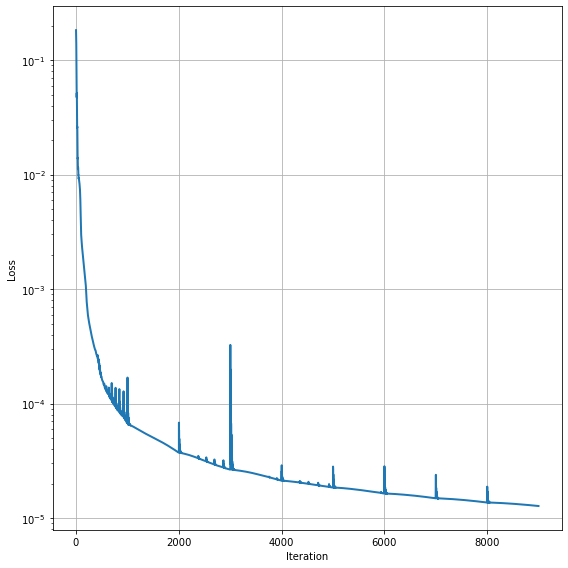

Loss = 1.2747488e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<36:51,  2.21s/it]

New min loss =  1.2747488e-05


Loss = 1.2743684e-05:   4%|█████▊                                                                                                                                                  | 38/1000 [01:11<30:52,  1.93s/it]

New min loss =  1.2743684e-05


Loss = 1.27415615e-05:   4%|██████▏                                                                                                                                                | 41/1000 [01:19<38:37,  2.42s/it]

New min loss =  1.27415615e-05


Loss = 1.2739536e-05:   4%|██████▋                                                                                                                                                 | 44/1000 [01:27<39:43,  2.49s/it]

New min loss =  1.2739536e-05


Loss = 1.27383855e-05:   5%|███████▏                                                                                                                                               | 48/1000 [01:35<33:36,  2.12s/it]

New min loss =  1.27383855e-05


Loss = 1.2737323e-05:   5%|███████▉                                                                                                                                                | 52/1000 [01:45<38:26,  2.43s/it]

New min loss =  1.2737323e-05


Loss = 1.2736842e-05:   5%|████████▏                                                                                                                                               | 54/1000 [01:51<41:54,  2.66s/it]

New min loss =  1.2736842e-05


Loss = 1.2734592e-05:   6%|████████▎                                                                                                                                               | 55/1000 [01:53<42:43,  2.71s/it]

New min loss =  1.2734592e-05


Loss = 1.2732422e-05:   6%|████████▉                                                                                                                                               | 59/1000 [02:02<38:07,  2.43s/it]

New min loss =  1.2732422e-05


Loss = 1.2731717e-05:   6%|█████████▍                                                                                                                                              | 62/1000 [02:10<41:35,  2.66s/it]

New min loss =  1.2731717e-05


Loss = 1.2730934e-05:   6%|█████████▋                                                                                                                                              | 64/1000 [02:15<40:48,  2.62s/it]

New min loss =  1.2730934e-05


Loss = 1.2730393e-05:   6%|█████████▉                                                                                                                                              | 65/1000 [02:18<40:51,  2.62s/it]

New min loss =  1.2730393e-05


Loss = 1.2729755e-05:   7%|██████████▎                                                                                                                                             | 68/1000 [02:23<30:31,  1.96s/it]

New min loss =  1.2729755e-05


Loss = 1.2728822e-05:   7%|██████████▍                                                                                                                                             | 69/1000 [02:26<33:03,  2.13s/it]

New min loss =  1.2728822e-05


Loss = 1.2728619e-05:   7%|██████████▋                                                                                                                                             | 70/1000 [02:28<35:08,  2.27s/it]

New min loss =  1.2728619e-05


Loss = 1.2728392e-05:   7%|██████████▊                                                                                                                                             | 71/1000 [02:31<36:12,  2.34s/it]

New min loss =  1.2728392e-05


Loss = 1.2727436e-05:   7%|██████████▉                                                                                                                                             | 72/1000 [02:33<36:49,  2.38s/it]

New min loss =  1.2727436e-05


Loss = 1.2727323e-05:   7%|███████████                                                                                                                                             | 73/1000 [02:36<37:54,  2.45s/it]

New min loss =  1.2727323e-05


Loss = 1.2726593e-05:   7%|███████████▏                                                                                                                                            | 74/1000 [02:39<38:52,  2.52s/it]

New min loss =  1.2726593e-05


Loss = 1.2725932e-05:   8%|███████████▍                                                                                                                                            | 75/1000 [02:41<40:10,  2.61s/it]

New min loss =  1.2725932e-05


Loss = 1.2725069e-05:   8%|███████████▋                                                                                                                                            | 77/1000 [02:47<42:16,  2.75s/it]

New min loss =  1.2725069e-05


Loss = 1.2724647e-05:   8%|███████████▊                                                                                                                                            | 78/1000 [02:50<42:15,  2.75s/it]

New min loss =  1.2724647e-05


Loss = 1.272425e-05:   8%|████████████▏                                                                                                                                            | 80/1000 [02:53<32:24,  2.11s/it]

New min loss =  1.272425e-05


Loss = 1.2723615e-05:   8%|████████████▎                                                                                                                                           | 81/1000 [02:55<33:48,  2.21s/it]

New min loss =  1.2723615e-05


Loss = 1.27232815e-05:   8%|████████████▍                                                                                                                                          | 82/1000 [02:58<35:22,  2.31s/it]

New min loss =  1.27232815e-05


Loss = 1.2722734e-05:   8%|████████████▌                                                                                                                                           | 83/1000 [03:00<36:51,  2.41s/it]

New min loss =  1.2722734e-05


Loss = 1.2722135e-05:   8%|████████████▊                                                                                                                                           | 84/1000 [03:03<37:46,  2.47s/it]

New min loss =  1.2722135e-05


Loss = 1.2721736e-05:   8%|████████████▉                                                                                                                                           | 85/1000 [03:05<36:58,  2.42s/it]

New min loss =  1.2721736e-05


Loss = 1.2721303e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:08<37:46,  2.48s/it]

New min loss =  1.2721303e-05


Loss = 1.2720637e-05:   9%|█████████████▏                                                                                                                                          | 87/1000 [03:10<38:10,  2.51s/it]

New min loss =  1.2720637e-05


Loss = 1.2720263e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [03:13<38:09,  2.51s/it]

New min loss =  1.2720263e-05


Loss = 1.27197e-05:   9%|█████████████▋                                                                                                                                            | 89/1000 [03:15<37:31,  2.47s/it]

New min loss =  1.27197e-05


Loss = 1.2719208e-05:   9%|█████████████▋                                                                                                                                          | 90/1000 [03:18<36:56,  2.44s/it]

New min loss =  1.2719208e-05


Loss = 1.2718752e-05:   9%|█████████████▊                                                                                                                                          | 91/1000 [03:20<37:25,  2.47s/it]

New min loss =  1.2718752e-05


Loss = 1.2718123e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:23<29:07,  1.93s/it]

New min loss =  1.2718123e-05


Loss = 1.2717718e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:25<30:48,  2.04s/it]

New min loss =  1.2717718e-05


Loss = 1.2717191e-05:  10%|██████████████▍                                                                                                                                         | 95/1000 [03:28<32:00,  2.12s/it]

New min loss =  1.2717191e-05


Loss = 1.2716645e-05:  10%|██████████████▌                                                                                                                                         | 96/1000 [03:30<33:25,  2.22s/it]

New min loss =  1.2716645e-05


Loss = 1.2716141e-05:  10%|██████████████▋                                                                                                                                         | 97/1000 [03:33<34:47,  2.31s/it]

New min loss =  1.2716141e-05


Loss = 1.2715621e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [03:35<36:09,  2.41s/it]

New min loss =  1.2715621e-05


Loss = 1.2715083e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:38<35:52,  2.39s/it]

New min loss =  1.2715083e-05


Loss = 1.2714589e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:40<37:56,  2.53s/it]

New min loss =  1.2714589e-05


Loss = 1.2714012e-05:  10%|███████████████▎                                                                                                                                       | 101/1000 [03:44<40:32,  2.71s/it]

New min loss =  1.2714012e-05


Loss = 1.2713513e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [03:46<39:40,  2.65s/it]

New min loss =  1.2713513e-05


Loss = 1.27129915e-05:  10%|███████████████▍                                                                                                                                      | 103/1000 [03:49<39:30,  2.64s/it]

New min loss =  1.27129915e-05


Loss = 1.2712431e-05:  10%|███████████████▋                                                                                                                                       | 104/1000 [03:52<40:16,  2.70s/it]

New min loss =  1.2712431e-05


Loss = 1.2711912e-05:  10%|███████████████▊                                                                                                                                       | 105/1000 [03:54<40:07,  2.69s/it]

New min loss =  1.2711912e-05


Loss = 1.2711349e-05:  11%|████████████████▏                                                                                                                                      | 107/1000 [03:57<30:19,  2.04s/it]

New min loss =  1.2711349e-05


Loss = 1.2710826e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [03:59<32:41,  2.20s/it]

New min loss =  1.2710826e-05


Loss = 1.2710278e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [04:02<33:03,  2.23s/it]

New min loss =  1.2710278e-05


Loss = 1.2709715e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:04<33:59,  2.29s/it]

New min loss =  1.2709715e-05


Loss = 1.2709175e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [04:07<36:16,  2.45s/it]

New min loss =  1.2709175e-05


Loss = 1.270862e-05:  11%|█████████████████                                                                                                                                       | 112/1000 [04:10<37:45,  2.55s/it]

New min loss =  1.270862e-05


Loss = 1.27080675e-05:  11%|████████████████▉                                                                                                                                     | 113/1000 [04:13<38:38,  2.61s/it]

New min loss =  1.27080675e-05


Loss = 1.2707511e-05:  11%|█████████████████▏                                                                                                                                     | 114/1000 [04:15<37:38,  2.55s/it]

New min loss =  1.2707511e-05


Loss = 1.2706944e-05:  12%|█████████████████▎                                                                                                                                     | 115/1000 [04:18<37:26,  2.54s/it]

New min loss =  1.2706944e-05


Loss = 1.270639e-05:  12%|█████████████████▋                                                                                                                                      | 116/1000 [04:20<37:35,  2.55s/it]

New min loss =  1.270639e-05


Loss = 1.2705809e-05:  12%|█████████████████▋                                                                                                                                     | 117/1000 [04:23<37:48,  2.57s/it]

New min loss =  1.2705809e-05


Loss = 1.2705243e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [04:25<36:23,  2.48s/it]

New min loss =  1.2705243e-05


Loss = 1.2704676e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:28<37:35,  2.56s/it]

New min loss =  1.2704676e-05


Loss = 1.2704111e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [04:31<38:36,  2.63s/it]

New min loss =  1.2704111e-05


Loss = 1.2703534e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:33<29:43,  2.03s/it]

New min loss =  1.2703534e-05


Loss = 1.2702948e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:37<34:27,  2.36s/it]

New min loss =  1.2702948e-05


Loss = 1.2702374e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [04:40<37:42,  2.58s/it]

New min loss =  1.2702374e-05


Loss = 1.2701795e-05:  12%|██████████████████▉                                                                                                                                    | 125/1000 [04:43<40:41,  2.79s/it]

New min loss =  1.2701795e-05


Loss = 1.2701206e-05:  13%|███████████████████                                                                                                                                    | 126/1000 [04:46<41:32,  2.85s/it]

New min loss =  1.2701206e-05


Loss = 1.2700632e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [04:49<41:07,  2.83s/it]

New min loss =  1.2700632e-05


Loss = 1.270006e-05:  13%|███████████████████▍                                                                                                                                    | 128/1000 [04:52<40:34,  2.79s/it]

New min loss =  1.270006e-05


Loss = 1.2699489e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [04:54<40:46,  2.81s/it]

New min loss =  1.2699489e-05


Loss = 1.2698975e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [04:58<41:50,  2.89s/it]

New min loss =  1.2698975e-05


Loss = 1.2698579e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [05:00<42:01,  2.90s/it]

New min loss =  1.2698579e-05


Loss = 1.2698499e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [05:04<42:59,  2.97s/it]

New min loss =  1.2698499e-05


Loss = 1.269438e-05:  14%|█████████████████████▎                                                                                                                                  | 140/1000 [05:26<42:09,  2.94s/it]

New min loss =  1.269438e-05


Loss = 1.2691374e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [05:38<42:02,  2.95s/it]

New min loss =  1.2691374e-05


Loss = 1.2688817e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [05:50<42:17,  2.98s/it]

New min loss =  1.2688817e-05


Loss = 1.2687851e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [05:59<42:33,  3.01s/it]

New min loss =  1.2687851e-05


Loss = 1.2687534e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [06:02<42:03,  2.98s/it]

New min loss =  1.2687534e-05


Loss = 1.2684397e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [06:11<34:03,  2.42s/it]

New min loss =  1.2684397e-05


Loss = 1.2683659e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [06:21<40:42,  2.90s/it]

New min loss =  1.2683659e-05


Loss = 1.2682104e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [06:24<39:37,  2.83s/it]

New min loss =  1.2682104e-05


Loss = 1.2680323e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [06:31<35:34,  2.55s/it]

New min loss =  1.2680323e-05


Loss = 1.2679875e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:33<33:58,  2.44s/it]

New min loss =  1.2679875e-05


Loss = 1.2679419e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [06:38<32:23,  2.33s/it]

New min loss =  1.2679419e-05


Loss = 1.2677585e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [06:40<31:09,  2.24s/it]

New min loss =  1.2677585e-05


Loss = 1.26773775e-05:  17%|█████████████████████████▏                                                                                                                            | 168/1000 [06:42<30:27,  2.20s/it]

New min loss =  1.26773775e-05


Loss = 1.2676382e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [06:46<30:19,  2.19s/it]

New min loss =  1.2676382e-05


Loss = 1.2674981e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [06:48<29:50,  2.16s/it]

New min loss =  1.2674981e-05


Loss = 1.2674693e-05:  17%|██████████████████████████                                                                                                                             | 173/1000 [06:51<24:03,  1.75s/it]

New min loss =  1.2674693e-05


Loss = 1.2674569e-05:  17%|██████████████████████████▎                                                                                                                            | 174/1000 [06:53<27:44,  2.02s/it]

New min loss =  1.2674569e-05


Loss = 1.2673576e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [06:57<31:41,  2.30s/it]

New min loss =  1.2673576e-05


Loss = 1.2672413e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [07:00<34:18,  2.50s/it]

New min loss =  1.2672413e-05


Loss = 1.2671935e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [07:02<34:25,  2.51s/it]

New min loss =  1.2671935e-05


Loss = 1.2671664e-05:  18%|██████████████████████████▉                                                                                                                            | 178/1000 [07:06<38:19,  2.80s/it]

New min loss =  1.2671664e-05


Loss = 1.2670872e-05:  18%|███████████████████████████                                                                                                                            | 179/1000 [07:09<38:58,  2.85s/it]

New min loss =  1.2670872e-05


Loss = 1.2669831e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [07:12<41:23,  3.03s/it]

New min loss =  1.2669831e-05


Loss = 1.266917e-05:  18%|███████████████████████████▌                                                                                                                            | 181/1000 [07:15<41:04,  3.01s/it]

New min loss =  1.266917e-05


Loss = 1.2668788e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [07:18<40:30,  2.97s/it]

New min loss =  1.2668788e-05


Loss = 1.2668164e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [07:20<38:40,  2.84s/it]

New min loss =  1.2668164e-05


Loss = 1.26672685e-05:  18%|███████████████████████████▌                                                                                                                          | 184/1000 [07:23<39:16,  2.89s/it]

New min loss =  1.26672685e-05


Loss = 1.2666464e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [07:26<39:34,  2.91s/it]

New min loss =  1.2666464e-05


Loss = 1.2665912e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [07:29<39:32,  2.91s/it]

New min loss =  1.2665912e-05


Loss = 1.2665391e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [07:32<39:21,  2.91s/it]

New min loss =  1.2665391e-05


Loss = 1.2664652e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [07:35<39:33,  2.92s/it]

New min loss =  1.2664652e-05


Loss = 1.2663826e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [07:38<40:31,  3.00s/it]

New min loss =  1.2663826e-05


Loss = 1.2663102e-05:  19%|████████████████████████████▋                                                                                                                          | 190/1000 [07:42<41:53,  3.10s/it]

New min loss =  1.2663102e-05


Loss = 1.26625355e-05:  19%|████████████████████████████▊                                                                                                                         | 192/1000 [07:44<31:03,  2.31s/it]

New min loss =  1.26625355e-05


Loss = 1.2661922e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [07:48<35:02,  2.60s/it]

New min loss =  1.2661922e-05


Loss = 1.2661183e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [07:51<36:25,  2.71s/it]

New min loss =  1.2661183e-05


Loss = 1.2660411e-05:  20%|█████████████████████████████▍                                                                                                                         | 195/1000 [07:54<37:34,  2.80s/it]

New min loss =  1.2660411e-05


Loss = 1.2659692e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [07:57<37:57,  2.83s/it]

New min loss =  1.2659692e-05


Loss = 1.2659052e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [08:00<38:04,  2.85s/it]

New min loss =  1.2659052e-05


Loss = 1.2658423e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [08:03<38:28,  2.88s/it]

New min loss =  1.2658423e-05


Loss = 1.2657714e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [08:06<38:43,  2.90s/it]

New min loss =  1.2657714e-05


Loss = 1.2656956e-05:  20%|██████████████████████████████▏                                                                                                                        | 200/1000 [08:09<41:55,  3.14s/it]

New min loss =  1.2656956e-05


Loss = 1.2656224e-05:  20%|██████████████████████████████▎                                                                                                                        | 201/1000 [08:12<41:16,  3.10s/it]

New min loss =  1.2656224e-05


Loss = 1.2655534e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [08:16<41:16,  3.10s/it]

New min loss =  1.2655534e-05


Loss = 1.26548675e-05:  20%|██████████████████████████████▍                                                                                                                       | 203/1000 [08:19<42:33,  3.20s/it]

New min loss =  1.26548675e-05


Loss = 1.2654187e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [08:22<42:47,  3.22s/it]

New min loss =  1.2654187e-05


Loss = 1.2653461e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [08:25<41:22,  3.12s/it]

New min loss =  1.2653461e-05


Loss = 1.2652727e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [08:28<39:49,  3.01s/it]

New min loss =  1.2652727e-05


Loss = 1.2651999e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [08:31<40:27,  3.06s/it]

New min loss =  1.2651999e-05


Loss = 1.2651284e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [08:34<40:28,  3.07s/it]

New min loss =  1.2651284e-05


Loss = 1.2650593e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [08:37<39:29,  3.00s/it]

New min loss =  1.2650593e-05


Loss = 1.2649897e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [08:41<41:46,  3.17s/it]

New min loss =  1.2649897e-05


Loss = 1.2649179e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [08:43<30:58,  2.36s/it]

New min loss =  1.2649179e-05


Loss = 1.2648448e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [08:46<32:38,  2.49s/it]

New min loss =  1.2648448e-05


Loss = 1.2647715e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [08:49<34:32,  2.64s/it]

New min loss =  1.2647715e-05


Loss = 1.26469795e-05:  22%|████████████████████████████████▎                                                                                                                     | 215/1000 [08:52<35:32,  2.72s/it]

New min loss =  1.26469795e-05


Loss = 1.264625e-05:  22%|████████████████████████████████▊                                                                                                                       | 216/1000 [08:56<37:34,  2.88s/it]

New min loss =  1.264625e-05


Loss = 1.2645535e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [08:59<38:34,  2.96s/it]

New min loss =  1.2645535e-05


Loss = 1.2644809e-05:  22%|████████████████████████████████▉                                                                                                                      | 218/1000 [09:01<37:45,  2.90s/it]

New min loss =  1.2644809e-05


Loss = 1.2644083e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [09:04<35:22,  2.72s/it]

New min loss =  1.2644083e-05


Loss = 1.2643355e-05:  22%|█████████████████████████████████▏                                                                                                                     | 220/1000 [09:06<33:38,  2.59s/it]

New min loss =  1.2643355e-05


Loss = 1.2642619e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [09:08<31:54,  2.46s/it]

New min loss =  1.2642619e-05


Loss = 1.2641875e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [09:10<31:10,  2.40s/it]

New min loss =  1.2641875e-05


Loss = 1.2641144e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [09:12<29:18,  2.26s/it]

New min loss =  1.2641144e-05


Loss = 1.2640403e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [09:15<29:01,  2.24s/it]

New min loss =  1.2640403e-05


Loss = 1.26396535e-05:  22%|█████████████████████████████████▊                                                                                                                    | 225/1000 [09:17<27:56,  2.16s/it]

New min loss =  1.26396535e-05


Loss = 1.263892e-05:  23%|██████████████████████████████████▎                                                                                                                     | 226/1000 [09:19<27:21,  2.12s/it]

New min loss =  1.263892e-05


Loss = 1.2638176e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [09:21<27:17,  2.12s/it]

New min loss =  1.2638176e-05


Loss = 1.2637429e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [09:23<29:17,  2.28s/it]

New min loss =  1.2637429e-05


Loss = 1.2636684e-05:  23%|██████████████████████████████████▌                                                                                                                    | 229/1000 [09:26<30:01,  2.34s/it]

New min loss =  1.2636684e-05


Loss = 1.2635944e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [09:28<30:33,  2.38s/it]

New min loss =  1.2635944e-05


Loss = 1.2635195e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [09:32<34:46,  2.71s/it]

New min loss =  1.2635195e-05


Loss = 1.2634452e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [09:35<28:49,  2.25s/it]

New min loss =  1.2634452e-05


Loss = 1.2633699e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [09:39<33:14,  2.60s/it]

New min loss =  1.2633699e-05


Loss = 1.2632947e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [09:43<38:51,  3.05s/it]

New min loss =  1.2632947e-05


Loss = 1.2632203e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [09:46<39:33,  3.11s/it]

New min loss =  1.2632203e-05


Loss = 1.2631451e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [09:49<38:50,  3.05s/it]

New min loss =  1.2631451e-05


Loss = 1.2630701e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [09:52<35:52,  2.82s/it]

New min loss =  1.2630701e-05


Loss = 1.26299765e-05:  24%|███████████████████████████████████▊                                                                                                                  | 239/1000 [09:54<33:05,  2.61s/it]

New min loss =  1.26299765e-05


Loss = 1.2629264e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [09:56<30:44,  2.43s/it]

New min loss =  1.2629264e-05


Loss = 1.2628585e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [09:58<30:58,  2.45s/it]

New min loss =  1.2628585e-05


Loss = 1.26279665e-05:  24%|████████████████████████████████████▎                                                                                                                 | 242/1000 [10:01<30:27,  2.41s/it]

New min loss =  1.26279665e-05


Loss = 1.2627474e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [10:03<29:18,  2.32s/it]

New min loss =  1.2627474e-05


Loss = 1.2627205e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [10:05<29:02,  2.30s/it]

New min loss =  1.2627205e-05


Loss = 1.2620268e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [10:33<26:41,  2.15s/it]

New min loss =  1.2620268e-05


Loss = 1.2617362e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [10:44<26:27,  2.14s/it]

New min loss =  1.2617362e-05


Loss = 1.2614762e-05:  26%|███████████████████████████████████████▍                                                                                                               | 261/1000 [10:46<25:38,  2.08s/it]

New min loss =  1.2614762e-05


Loss = 1.26122695e-05:  26%|███████████████████████████████████████▊                                                                                                              | 265/1000 [10:55<28:38,  2.34s/it]

New min loss =  1.26122695e-05


Loss = 1.2610871e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [10:59<32:26,  2.65s/it]

New min loss =  1.2610871e-05


Loss = 1.2607703e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [11:12<38:09,  3.14s/it]

New min loss =  1.2607703e-05


Loss = 1.2606973e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [11:15<38:22,  3.16s/it]

New min loss =  1.2606973e-05


Loss = 1.2606973e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [11:25<41:00,  3.39s/it]

New min loss =  1.2606973e-05


Loss = 1.2603685e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [11:29<41:28,  3.43s/it]

New min loss =  1.2603685e-05


Loss = 1.26028835e-05:  28%|█████████████████████████████████████████▍                                                                                                            | 276/1000 [11:32<39:35,  3.28s/it]

New min loss =  1.26028835e-05


Loss = 1.2602267e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [11:41<32:10,  2.68s/it]

New min loss =  1.2602267e-05


Loss = 1.2599898e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [11:44<34:03,  2.84s/it]

New min loss =  1.2599898e-05


Loss = 1.2598798e-05:  28%|██████████████████████████████████████████▌                                                                                                            | 282/1000 [11:48<37:59,  3.18s/it]

New min loss =  1.2598798e-05


Loss = 1.2597957e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [11:57<36:48,  3.09s/it]

New min loss =  1.2597957e-05


Loss = 1.2596226e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [12:00<35:52,  3.01s/it]

New min loss =  1.2596226e-05


Loss = 1.259487e-05:  29%|███████████████████████████████████████████▌                                                                                                            | 287/1000 [12:03<35:49,  3.01s/it]

New min loss =  1.259487e-05


Loss = 1.2594372e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [12:07<36:43,  3.09s/it]

New min loss =  1.2594372e-05


Loss = 1.2594205e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [12:10<37:01,  3.13s/it]

New min loss =  1.2594205e-05


Loss = 1.2593647e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [12:13<36:01,  3.04s/it]

New min loss =  1.2593647e-05


Loss = 1.2592499e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [12:16<36:29,  3.09s/it]

New min loss =  1.2592499e-05


Loss = 1.2591191e-05:  29%|████████████████████████████████████████████                                                                                                           | 292/1000 [12:19<37:23,  3.17s/it]

New min loss =  1.2591191e-05


Loss = 1.25901925e-05:  29%|███████████████████████████████████████████▉                                                                                                          | 293/1000 [12:22<36:43,  3.12s/it]

New min loss =  1.25901925e-05


Loss = 1.2589617e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [12:26<37:55,  3.22s/it]

New min loss =  1.2589617e-05


Loss = 1.2589163e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [12:28<36:05,  3.07s/it]

New min loss =  1.2589163e-05


Loss = 1.25884935e-05:  30%|████████████████████████████████████████████▍                                                                                                         | 296/1000 [12:31<36:01,  3.07s/it]

New min loss =  1.25884935e-05


Loss = 1.2587513e-05:  30%|████████████████████████████████████████████▊                                                                                                          | 297/1000 [12:34<33:42,  2.88s/it]

New min loss =  1.2587513e-05


Loss = 1.2586433e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [12:36<30:36,  2.62s/it]

New min loss =  1.2586433e-05


Loss = 1.258548e-05:  30%|█████████████████████████████████████████████▍                                                                                                          | 299/1000 [12:38<28:36,  2.45s/it]

New min loss =  1.258548e-05


Loss = 1.2584754e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [12:40<26:43,  2.29s/it]

New min loss =  1.2584754e-05


Loss = 1.2584141e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [12:42<19:13,  1.65s/it]

New min loss =  1.2584141e-05


Loss = 1.2583473e-05:  30%|█████████████████████████████████████████████▊                                                                                                         | 303/1000 [12:44<20:29,  1.76s/it]

New min loss =  1.2583473e-05


Loss = 1.2582656e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [12:46<22:02,  1.90s/it]

New min loss =  1.2582656e-05


Loss = 1.25817405e-05:  30%|█████████████████████████████████████████████▊                                                                                                        | 305/1000 [12:48<22:31,  1.94s/it]

New min loss =  1.25817405e-05


Loss = 1.2580797e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [12:50<22:59,  1.99s/it]

New min loss =  1.2580797e-05


Loss = 1.2579932e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [12:52<23:17,  2.02s/it]

New min loss =  1.2579932e-05


Loss = 1.2579155e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [12:55<24:35,  2.13s/it]

New min loss =  1.2579155e-05


Loss = 1.2578419e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [12:57<26:38,  2.31s/it]

New min loss =  1.2578419e-05


Loss = 1.2577707e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [13:00<27:48,  2.42s/it]

New min loss =  1.2577707e-05


Loss = 1.2576917e-05:  31%|██████████████████████████████████████████████▉                                                                                                        | 311/1000 [13:03<29:33,  2.57s/it]

New min loss =  1.2576917e-05


Loss = 1.2576085e-05:  31%|███████████████████████████████████████████████                                                                                                        | 312/1000 [13:05<28:59,  2.53s/it]

New min loss =  1.2576085e-05


Loss = 1.2575221e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [13:09<30:44,  2.68s/it]

New min loss =  1.2575221e-05


Loss = 1.257434e-05:  31%|███████████████████████████████████████████████▋                                                                                                        | 314/1000 [13:12<34:26,  3.01s/it]

New min loss =  1.257434e-05


Loss = 1.2573501e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [13:15<33:08,  2.90s/it]

New min loss =  1.2573501e-05


Loss = 1.2572687e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [13:18<32:19,  2.84s/it]

New min loss =  1.2572687e-05


Loss = 1.2571901e-05:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [13:20<31:45,  2.79s/it]

New min loss =  1.2571901e-05


Loss = 1.2571111e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [13:23<33:00,  2.90s/it]

New min loss =  1.2571111e-05


Loss = 1.2570332e-05:  32%|████████████████████████████████████████████████▏                                                                                                      | 319/1000 [13:27<33:37,  2.96s/it]

New min loss =  1.2570332e-05


Loss = 1.25695315e-05:  32%|████████████████████████████████████████████████                                                                                                      | 320/1000 [13:29<32:48,  2.89s/it]

New min loss =  1.25695315e-05


Loss = 1.2568714e-05:  32%|████████████████████████████████████████████████▍                                                                                                      | 321/1000 [13:33<34:03,  3.01s/it]

New min loss =  1.2568714e-05


Loss = 1.2567883e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [13:36<34:56,  3.09s/it]

New min loss =  1.2567883e-05


Loss = 1.2567049e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [13:39<35:50,  3.18s/it]

New min loss =  1.2567049e-05


Loss = 1.2566209e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [13:43<36:22,  3.23s/it]

New min loss =  1.2566209e-05


Loss = 1.2565374e-05:  32%|█████████████████████████████████████████████████                                                                                                      | 325/1000 [13:46<36:18,  3.23s/it]

New min loss =  1.2565374e-05


Loss = 1.25645365e-05:  33%|█████████████████████████████████████████████████                                                                                                     | 327/1000 [13:50<30:14,  2.70s/it]

New min loss =  1.25645365e-05


Loss = 1.2563707e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [13:53<30:35,  2.73s/it]

New min loss =  1.2563707e-05


Loss = 1.256288e-05:  33%|██████████████████████████████████████████████████                                                                                                      | 329/1000 [13:55<30:07,  2.69s/it]

New min loss =  1.256288e-05


Loss = 1.2562052e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [13:59<31:56,  2.86s/it]

New min loss =  1.2562052e-05


Loss = 1.256122e-05:  33%|██████████████████████████████████████████████████▎                                                                                                     | 331/1000 [14:02<31:49,  2.85s/it]

New min loss =  1.256122e-05


Loss = 1.25604065e-05:  33%|█████████████████████████████████████████████████▊                                                                                                    | 332/1000 [14:04<31:49,  2.86s/it]

New min loss =  1.25604065e-05


Loss = 1.2559588e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [14:07<31:52,  2.87s/it]

New min loss =  1.2559588e-05


Loss = 1.2558776e-05:  33%|██████████████████████████████████████████████████▍                                                                                                    | 334/1000 [14:10<32:27,  2.92s/it]

New min loss =  1.2558776e-05


Loss = 1.2557939e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [14:14<33:30,  3.02s/it]

New min loss =  1.2557939e-05


Loss = 1.25571205e-05:  34%|██████████████████████████████████████████████████▍                                                                                                   | 336/1000 [14:17<34:24,  3.11s/it]

New min loss =  1.25571205e-05


Loss = 1.2556306e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [14:20<34:21,  3.11s/it]

New min loss =  1.2556306e-05


Loss = 1.2555492e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [14:23<33:41,  3.05s/it]

New min loss =  1.2555492e-05


Loss = 1.2554688e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [14:26<32:57,  2.99s/it]

New min loss =  1.2554688e-05


Loss = 1.2553888e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [14:29<32:28,  2.95s/it]

New min loss =  1.2553888e-05


Loss = 1.2553115e-05:  34%|███████████████████████████████████████████████████▍                                                                                                   | 341/1000 [14:32<32:45,  2.98s/it]

New min loss =  1.2553115e-05


Loss = 1.2552361e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [14:35<33:23,  3.04s/it]

New min loss =  1.2552361e-05


Loss = 1.2551686e-05:  34%|███████████████████████████████████████████████████▊                                                                                                   | 343/1000 [14:38<34:17,  3.13s/it]

New min loss =  1.2551686e-05


Loss = 1.2551103e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [14:41<33:12,  3.04s/it]

New min loss =  1.2551103e-05


Loss = 1.25506995e-05:  34%|███████████████████████████████████████████████████▋                                                                                                  | 345/1000 [14:44<33:10,  3.04s/it]

New min loss =  1.25506995e-05


Loss = 1.25505985e-05:  35%|███████████████████████████████████████████████████▉                                                                                                  | 346/1000 [14:47<32:50,  3.01s/it]

New min loss =  1.25505985e-05


Loss = 1.2544954e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [15:18<28:37,  2.67s/it]

New min loss =  1.2544954e-05


Loss = 1.2540198e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [15:21<29:40,  2.78s/it]

New min loss =  1.2540198e-05


Loss = 1.2535244e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [15:36<32:33,  3.07s/it]

New min loss =  1.2535244e-05


Loss = 1.2532105e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [15:51<30:41,  2.92s/it]

New min loss =  1.2532105e-05


Loss = 1.2530978e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [15:53<29:18,  2.79s/it]

New min loss =  1.2530978e-05


Loss = 1.2528343e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [16:04<28:44,  2.75s/it]

New min loss =  1.2528343e-05


Loss = 1.2526072e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [16:07<29:02,  2.79s/it]

New min loss =  1.2526072e-05


Loss = 1.252445e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                              | 380/1000 [16:18<22:20,  2.16s/it]

New min loss =  1.252445e-05


Loss = 1.25218585e-05:  38%|█████████████████████████████████████████████████████████▏                                                                                            | 381/1000 [16:21<24:12,  2.35s/it]

New min loss =  1.25218585e-05


Loss = 1.2520519e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [16:32<26:54,  2.63s/it]

New min loss =  1.2520519e-05


Loss = 1.2518037e-05:  39%|██████████████████████████████████████████████████████████▎                                                                                            | 386/1000 [16:35<27:46,  2.71s/it]

New min loss =  1.2518037e-05


Loss = 1.2517178e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [16:38<28:15,  2.77s/it]

New min loss =  1.2517178e-05


Loss = 1.2516305e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [16:46<28:44,  2.83s/it]

New min loss =  1.2516305e-05


Loss = 1.2514394e-05:  39%|███████████████████████████████████████████████████████████                                                                                            | 391/1000 [16:49<28:39,  2.82s/it]

New min loss =  1.2514394e-05


Loss = 1.2512898e-05:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [16:52<29:15,  2.89s/it]

New min loss =  1.2512898e-05


Loss = 1.2512317e-05:  39%|███████████████████████████████████████████████████████████▎                                                                                           | 393/1000 [16:55<28:43,  2.84s/it]

New min loss =  1.2512317e-05


Loss = 1.2512165e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [16:58<29:33,  2.93s/it]

New min loss =  1.2512165e-05


Loss = 1.2511674e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [17:01<28:54,  2.87s/it]

New min loss =  1.2511674e-05


Loss = 1.2510553e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [17:04<28:35,  2.84s/it]

New min loss =  1.2510553e-05


Loss = 1.2509121e-05:  40%|███████████████████████████████████████████████████████████▉                                                                                           | 397/1000 [17:07<28:50,  2.87s/it]

New min loss =  1.2509121e-05


Loss = 1.2507949e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [17:10<30:31,  3.04s/it]

New min loss =  1.2507949e-05


Loss = 1.2507226e-05:  40%|████████████████████████████████████████████████████████████▏                                                                                          | 399/1000 [17:13<29:16,  2.92s/it]

New min loss =  1.2507226e-05


Loss = 1.2506756e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [17:15<28:51,  2.89s/it]

New min loss =  1.2506756e-05


Loss = 1.2506154e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [17:18<28:53,  2.89s/it]

New min loss =  1.2506154e-05


Loss = 1.250523e-05:  40%|█████████████████████████████████████████████████████████████                                                                                           | 402/1000 [17:21<29:11,  2.93s/it]

New min loss =  1.250523e-05


Loss = 1.2504101e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [17:24<29:14,  2.94s/it]

New min loss =  1.2504101e-05


Loss = 1.2503007e-05:  40%|█████████████████████████████████████████████████████████████                                                                                          | 404/1000 [17:27<28:36,  2.88s/it]

New min loss =  1.2503007e-05


Loss = 1.2502137e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [17:30<28:46,  2.90s/it]

New min loss =  1.2502137e-05


Loss = 1.2501447e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [17:33<28:38,  2.89s/it]

New min loss =  1.2501447e-05


Loss = 1.2500784e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [17:36<22:04,  2.24s/it]

New min loss =  1.2500784e-05


Loss = 1.2500003e-05:  41%|█████████████████████████████████████████████████████████████▊                                                                                         | 409/1000 [17:39<23:15,  2.36s/it]

New min loss =  1.2500003e-05


Loss = 1.2499085e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [17:42<24:58,  2.54s/it]

New min loss =  1.2499085e-05


Loss = 1.2498103e-05:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [17:44<24:24,  2.49s/it]

New min loss =  1.2498103e-05


Loss = 1.2497144e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [17:46<23:10,  2.36s/it]

New min loss =  1.2497144e-05


Loss = 1.2496267e-05:  41%|██████████████████████████████████████████████████████████████▎                                                                                        | 413/1000 [17:48<22:30,  2.30s/it]

New min loss =  1.2496267e-05


Loss = 1.2495491e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [17:50<21:03,  2.16s/it]

New min loss =  1.2495491e-05


Loss = 1.2494733e-05:  42%|██████████████████████████████████████████████████████████████▋                                                                                        | 415/1000 [17:52<20:15,  2.08s/it]

New min loss =  1.2494733e-05


Loss = 1.24939415e-05:  42%|██████████████████████████████████████████████████████████████▍                                                                                       | 416/1000 [17:54<19:35,  2.01s/it]

New min loss =  1.24939415e-05


Loss = 1.249309e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                        | 417/1000 [17:56<19:24,  2.00s/it]

New min loss =  1.249309e-05


Loss = 1.2492196e-05:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [17:58<19:21,  2.00s/it]

New min loss =  1.2492196e-05


Loss = 1.24912685e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                       | 419/1000 [18:00<19:17,  1.99s/it]

New min loss =  1.24912685e-05


Loss = 1.2490389e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [18:01<18:38,  1.93s/it]

New min loss =  1.2490389e-05


Loss = 1.2489523e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [18:03<18:58,  1.97s/it]

New min loss =  1.2489523e-05


Loss = 1.24887065e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                      | 422/1000 [18:05<19:14,  2.00s/it]

New min loss =  1.24887065e-05


Loss = 1.2487889e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                       | 423/1000 [18:08<20:51,  2.17s/it]

New min loss =  1.2487889e-05


Loss = 1.2487063e-05:  42%|████████████████████████████████████████████████████████████████                                                                                       | 424/1000 [18:10<20:55,  2.18s/it]

New min loss =  1.2487063e-05


Loss = 1.2486227e-05:  42%|████████████████████████████████████████████████████████████████▏                                                                                      | 425/1000 [18:13<21:47,  2.27s/it]

New min loss =  1.2486227e-05


Loss = 1.2485362e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [18:15<22:40,  2.37s/it]

New min loss =  1.2485362e-05


Loss = 1.2484485e-05:  43%|████████████████████████████████████████████████████████████████▍                                                                                      | 427/1000 [18:18<23:12,  2.43s/it]

New min loss =  1.2484485e-05


Loss = 1.24836015e-05:  43%|████████████████████████████████████████████████████████████████▏                                                                                     | 428/1000 [18:20<22:59,  2.41s/it]

New min loss =  1.24836015e-05


Loss = 1.2482715e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [18:23<23:02,  2.42s/it]

New min loss =  1.2482715e-05


Loss = 1.2481847e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [18:25<23:16,  2.45s/it]

New min loss =  1.2481847e-05


Loss = 1.2480992e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [18:28<23:23,  2.47s/it]

New min loss =  1.2480992e-05


Loss = 1.2480133e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [18:30<23:54,  2.53s/it]

New min loss =  1.2480133e-05


Loss = 1.2479293e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [18:33<23:09,  2.45s/it]

New min loss =  1.2479293e-05


Loss = 1.2478438e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [18:35<23:27,  2.49s/it]

New min loss =  1.2478438e-05


Loss = 1.247759e-05:  44%|██████████████████████████████████████████████████████████████████                                                                                      | 435/1000 [18:37<22:39,  2.41s/it]

New min loss =  1.247759e-05


Loss = 1.247673e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                     | 437/1000 [18:40<17:29,  1.86s/it]

New min loss =  1.247673e-05


Loss = 1.2475862e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 438/1000 [18:42<18:45,  2.00s/it]

New min loss =  1.2475862e-05


Loss = 1.2475002e-05:  44%|██████████████████████████████████████████████████████████████████▎                                                                                    | 439/1000 [18:45<19:28,  2.08s/it]

New min loss =  1.2475002e-05


Loss = 1.2474118e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [18:47<20:11,  2.16s/it]

New min loss =  1.2474118e-05


Loss = 1.2473249e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 441/1000 [18:49<20:28,  2.20s/it]

New min loss =  1.2473249e-05


Loss = 1.2472388e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [18:52<20:59,  2.26s/it]

New min loss =  1.2472388e-05


Loss = 1.2471511e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [18:54<22:07,  2.38s/it]

New min loss =  1.2471511e-05


Loss = 1.2470633e-05:  44%|███████████████████████████████████████████████████████████████████                                                                                    | 444/1000 [18:57<21:39,  2.34s/it]

New min loss =  1.2470633e-05


Loss = 1.24697535e-05:  44%|██████████████████████████████████████████████████████████████████▊                                                                                   | 445/1000 [18:59<21:25,  2.32s/it]

New min loss =  1.24697535e-05


Loss = 1.2468885e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [19:02<22:06,  2.39s/it]

New min loss =  1.2468885e-05


Loss = 1.2468015e-05:  45%|███████████████████████████████████████████████████████████████████▍                                                                                   | 447/1000 [19:04<22:06,  2.40s/it]

New min loss =  1.2468015e-05


Loss = 1.246714e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                    | 448/1000 [19:07<22:31,  2.45s/it]

New min loss =  1.246714e-05


Loss = 1.2466264e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [19:09<22:10,  2.42s/it]

New min loss =  1.2466264e-05


Loss = 1.2465388e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                   | 450/1000 [19:11<22:02,  2.40s/it]

New min loss =  1.2465388e-05


Loss = 1.2464511e-05:  45%|████████████████████████████████████████████████████████████████████                                                                                   | 451/1000 [19:14<22:13,  2.43s/it]

New min loss =  1.2464511e-05


Loss = 1.2463643e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [19:16<22:43,  2.49s/it]

New min loss =  1.2463643e-05


Loss = 1.2462765e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [19:19<22:15,  2.44s/it]

New min loss =  1.2462765e-05


Loss = 1.2461889e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [19:21<22:12,  2.44s/it]

New min loss =  1.2461889e-05


Loss = 1.2461023e-05:  46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 455/1000 [19:24<22:14,  2.45s/it]

New min loss =  1.2461023e-05


Loss = 1.2460147e-05:  46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 456/1000 [19:26<22:09,  2.44s/it]

New min loss =  1.2460147e-05


Loss = 1.2459279e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [19:29<22:30,  2.49s/it]

New min loss =  1.2459279e-05


Loss = 1.2458426e-05:  46%|█████████████████████████████████████████████████████████████████████▏                                                                                 | 458/1000 [19:31<21:45,  2.41s/it]

New min loss =  1.2458426e-05


Loss = 1.2457571e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [19:33<21:44,  2.41s/it]

New min loss =  1.2457571e-05


Loss = 1.24567505e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                 | 460/1000 [19:36<21:43,  2.41s/it]

New min loss =  1.24567505e-05


Loss = 1.2455952e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                 | 461/1000 [19:38<21:43,  2.42s/it]

New min loss =  1.2455952e-05


Loss = 1.2455228e-05:  46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 462/1000 [19:41<22:05,  2.46s/it]

New min loss =  1.2455228e-05


Loss = 1.24546195e-05:  46%|█████████████████████████████████████████████████████████████████████▍                                                                                | 463/1000 [19:43<21:19,  2.38s/it]

New min loss =  1.24546195e-05


Loss = 1.24542175e-05:  46%|█████████████████████████████████████████████████████████████████████▌                                                                                | 464/1000 [19:45<21:02,  2.36s/it]

New min loss =  1.24542175e-05


Loss = 1.2454181e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [19:48<21:29,  2.41s/it]

New min loss =  1.2454181e-05


Loss = 1.244275e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 478/1000 [20:16<20:05,  2.31s/it]

New min loss =  1.244275e-05


Loss = 1.24375465e-05:  48%|████████████████████████████████████████████████████████████████████████▍                                                                             | 483/1000 [20:28<19:45,  2.29s/it]

New min loss =  1.24375465e-05


Loss = 1.2433362e-05:  49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 488/1000 [20:39<19:11,  2.25s/it]

New min loss =  1.2433362e-05


Loss = 1.2433221e-05:  49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 492/1000 [20:49<20:38,  2.44s/it]

New min loss =  1.2433221e-05


Loss = 1.2429594e-05:  49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 493/1000 [20:51<20:11,  2.39s/it]

New min loss =  1.2429594e-05


Loss = 1.24267835e-05:  50%|██████████████████████████████████████████████████████████████████████████▋                                                                           | 498/1000 [21:01<15:54,  1.90s/it]

New min loss =  1.24267835e-05


Loss = 1.2425839e-05:  50%|███████████████████████████████████████████████████████████████████████████▎                                                                           | 499/1000 [21:03<16:41,  2.00s/it]

New min loss =  1.2425839e-05


Loss = 1.2421892e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [21:13<18:27,  2.23s/it]

New min loss =  1.2421892e-05


Loss = 1.2421705e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [21:15<18:54,  2.29s/it]

New min loss =  1.2421705e-05


Loss = 1.2420113e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [21:22<18:55,  2.30s/it]

New min loss =  1.2420113e-05


Loss = 1.2417544e-05:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [21:24<18:46,  2.29s/it]

New min loss =  1.2417544e-05


Loss = 1.2417301e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [21:27<19:17,  2.36s/it]

New min loss =  1.2417301e-05


Loss = 1.2415197e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [21:34<19:47,  2.43s/it]

New min loss =  1.2415197e-05


Loss = 1.2413331e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [21:37<19:44,  2.43s/it]

New min loss =  1.2413331e-05


Loss = 1.2412813e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [21:39<20:05,  2.48s/it]

New min loss =  1.2412813e-05


Loss = 1.2412229e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [21:44<20:07,  2.50s/it]

New min loss =  1.2412229e-05


Loss = 1.2410676e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [21:47<19:46,  2.46s/it]

New min loss =  1.2410676e-05


Loss = 1.240915e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                         | 518/1000 [21:49<19:25,  2.42s/it]

New min loss =  1.240915e-05


Loss = 1.2408377e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [21:51<19:21,  2.41s/it]

New min loss =  1.2408377e-05


Loss = 1.2408075e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [21:54<19:22,  2.42s/it]

New min loss =  1.2408075e-05


Loss = 1.2407464e-05:  52%|██████████████████████████████████████████████████████████████████████████████▋                                                                        | 521/1000 [21:56<19:21,  2.42s/it]

New min loss =  1.2407464e-05


Loss = 1.2406303e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [21:59<18:50,  2.37s/it]

New min loss =  1.2406303e-05


Loss = 1.2404991e-05:  52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 523/1000 [22:01<19:11,  2.41s/it]

New min loss =  1.2404991e-05


Loss = 1.240404e-05:  52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 524/1000 [22:04<19:35,  2.47s/it]

New min loss =  1.240404e-05


Loss = 1.2403461e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [22:06<19:40,  2.49s/it]

New min loss =  1.2403461e-05


Loss = 1.2402849e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [22:09<19:16,  2.44s/it]

New min loss =  1.2402849e-05


Loss = 1.2401948e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [22:11<19:24,  2.46s/it]

New min loss =  1.2401948e-05


Loss = 1.2400831e-05:  53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 528/1000 [22:14<19:22,  2.46s/it]

New min loss =  1.2400831e-05


Loss = 1.2399799e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [22:16<14:45,  1.88s/it]

New min loss =  1.2399799e-05


Loss = 1.2399007e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [22:18<15:58,  2.04s/it]

New min loss =  1.2399007e-05


Loss = 1.23983245e-05:  53%|███████████████████████████████████████████████████████████████████████████████▊                                                                      | 532/1000 [22:21<16:23,  2.10s/it]

New min loss =  1.23983245e-05


Loss = 1.239756e-05:  53%|█████████████████████████████████████████████████████████████████████████████████                                                                       | 533/1000 [22:23<16:36,  2.13s/it]

New min loss =  1.239756e-05


Loss = 1.239662e-05:  53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 534/1000 [22:25<17:02,  2.19s/it]

New min loss =  1.239662e-05


Loss = 1.2395616e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [22:28<17:32,  2.26s/it]

New min loss =  1.2395616e-05


Loss = 1.2394691e-05:  54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 536/1000 [22:30<17:50,  2.31s/it]

New min loss =  1.2394691e-05


Loss = 1.2393883e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [22:33<18:32,  2.40s/it]

New min loss =  1.2393883e-05


Loss = 1.2393132e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [22:35<18:16,  2.37s/it]

New min loss =  1.2393132e-05


Loss = 1.2392312e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [22:38<18:32,  2.41s/it]

New min loss =  1.2392312e-05


Loss = 1.2391396e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [22:40<18:30,  2.41s/it]

New min loss =  1.2391396e-05


Loss = 1.2390469e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [22:42<18:24,  2.41s/it]

New min loss =  1.2390469e-05


Loss = 1.23895625e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▎                                                                    | 542/1000 [22:45<17:59,  2.36s/it]

New min loss =  1.23895625e-05


Loss = 1.2388726e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [22:47<18:17,  2.40s/it]

New min loss =  1.2388726e-05


Loss = 1.2387919e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [22:50<18:14,  2.40s/it]

New min loss =  1.2387919e-05


Loss = 1.2387091e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [22:52<18:36,  2.45s/it]

New min loss =  1.2387091e-05


Loss = 1.2386211e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [22:55<18:45,  2.48s/it]

New min loss =  1.2386211e-05


Loss = 1.2385319e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [22:57<18:13,  2.41s/it]

New min loss =  1.2385319e-05


Loss = 1.2384429e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [22:59<18:08,  2.41s/it]

New min loss =  1.2384429e-05


Loss = 1.2383557e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                    | 549/1000 [23:02<18:17,  2.43s/it]

New min loss =  1.2383557e-05


Loss = 1.2382717e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [23:04<18:38,  2.49s/it]

New min loss =  1.2382717e-05


Loss = 1.2381878e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [23:07<18:31,  2.48s/it]

New min loss =  1.2381878e-05


Loss = 1.2381023e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [23:09<18:02,  2.42s/it]

New min loss =  1.2381023e-05


Loss = 1.2380147e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                   | 553/1000 [23:12<18:13,  2.45s/it]

New min loss =  1.2380147e-05


Loss = 1.2379256e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [23:14<18:14,  2.45s/it]

New min loss =  1.2379256e-05


Loss = 1.2378381e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [23:17<18:31,  2.50s/it]

New min loss =  1.2378381e-05


Loss = 1.2377518e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [23:19<17:50,  2.41s/it]

New min loss =  1.2377518e-05


Loss = 1.2376653e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [23:21<17:46,  2.41s/it]

New min loss =  1.2376653e-05


Loss = 1.2375799e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [23:24<17:49,  2.42s/it]

New min loss =  1.2375799e-05


Loss = 1.2374928e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [23:26<18:08,  2.47s/it]

New min loss =  1.2374928e-05


Loss = 1.23740565e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 560/1000 [23:29<17:52,  2.44s/it]

New min loss =  1.23740565e-05


Loss = 1.2373175e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [23:31<17:40,  2.42s/it]

New min loss =  1.2373175e-05


Loss = 1.23722975e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 563/1000 [23:33<13:24,  1.84s/it]

New min loss =  1.23722975e-05


Loss = 1.2371419e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 564/1000 [23:36<14:41,  2.02s/it]

New min loss =  1.2371419e-05


Loss = 1.2370547e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 565/1000 [23:38<15:13,  2.10s/it]

New min loss =  1.2370547e-05


Loss = 1.2369686e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [23:41<15:40,  2.17s/it]

New min loss =  1.2369686e-05


Loss = 1.2368818e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 567/1000 [23:43<16:07,  2.23s/it]

New min loss =  1.2368818e-05


Loss = 1.2367949e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [23:45<16:14,  2.26s/it]

New min loss =  1.2367949e-05


Loss = 1.2367074e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [23:48<16:40,  2.32s/it]

New min loss =  1.2367074e-05


Loss = 1.2366195e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [23:50<17:01,  2.38s/it]

New min loss =  1.2366195e-05


Loss = 1.2365308e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [23:53<16:46,  2.35s/it]

New min loss =  1.2365308e-05


Loss = 1.2364423e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [23:55<17:25,  2.44s/it]

New min loss =  1.2364423e-05


Loss = 1.2363548e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 573/1000 [23:58<17:43,  2.49s/it]

New min loss =  1.2363548e-05


Loss = 1.2362681e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 574/1000 [24:00<17:45,  2.50s/it]

New min loss =  1.2362681e-05


Loss = 1.23618e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 575/1000 [24:03<17:16,  2.44s/it]

New min loss =  1.23618e-05


Loss = 1.2360931e-05:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 576/1000 [24:05<17:01,  2.41s/it]

New min loss =  1.2360931e-05


Loss = 1.2360047e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [24:08<17:05,  2.43s/it]

New min loss =  1.2360047e-05


Loss = 1.2359157e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 578/1000 [24:10<17:11,  2.44s/it]

New min loss =  1.2359157e-05


Loss = 1.235829e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                                | 579/1000 [24:13<17:25,  2.48s/it]

New min loss =  1.235829e-05


Loss = 1.2357404e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [24:15<17:04,  2.44s/it]

New min loss =  1.2357404e-05


Loss = 1.2356514e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [24:17<17:04,  2.45s/it]

New min loss =  1.2356514e-05


Loss = 1.2355627e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [24:20<17:03,  2.45s/it]

New min loss =  1.2355627e-05


Loss = 1.2354738e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████                                                               | 583/1000 [24:22<16:50,  2.42s/it]

New min loss =  1.2354738e-05


Loss = 1.2353861e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [24:25<16:56,  2.44s/it]

New min loss =  1.2353861e-05


Loss = 1.2352971e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 585/1000 [24:27<16:33,  2.39s/it]

New min loss =  1.2352971e-05


Loss = 1.2352089e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [24:29<16:30,  2.39s/it]

New min loss =  1.2352089e-05


Loss = 1.2351205e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [24:32<16:43,  2.43s/it]

New min loss =  1.2351205e-05


Loss = 1.2350314e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 588/1000 [24:34<16:39,  2.43s/it]

New min loss =  1.2350314e-05


Loss = 1.2349419e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [24:37<16:34,  2.42s/it]

New min loss =  1.2349419e-05


Loss = 1.23485315e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 590/1000 [24:39<16:38,  2.44s/it]

New min loss =  1.23485315e-05


Loss = 1.2347629e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [24:42<16:27,  2.41s/it]

New min loss =  1.2347629e-05


Loss = 1.2346729e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [24:44<16:25,  2.42s/it]

New min loss =  1.2346729e-05


Loss = 1.2345844e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 593/1000 [24:46<16:20,  2.41s/it]

New min loss =  1.2345844e-05


Loss = 1.2344946e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 594/1000 [24:49<16:01,  2.37s/it]

New min loss =  1.2344946e-05


Loss = 1.23440495e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 595/1000 [24:51<16:01,  2.37s/it]

New min loss =  1.23440495e-05


Loss = 1.2343148e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 597/1000 [24:53<12:18,  1.83s/it]

New min loss =  1.2343148e-05


Loss = 1.234225e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 598/1000 [24:56<13:25,  2.00s/it]

New min loss =  1.234225e-05


Loss = 1.23413565e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 599/1000 [24:58<14:06,  2.11s/it]

New min loss =  1.23413565e-05


Loss = 1.2340458e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [25:01<14:19,  2.15s/it]

New min loss =  1.2340458e-05


Loss = 1.2339557e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [25:03<14:52,  2.24s/it]

New min loss =  1.2339557e-05


Loss = 1.2338652e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [25:06<15:10,  2.29s/it]

New min loss =  1.2338652e-05


Loss = 1.2337761e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 603/1000 [25:08<16:04,  2.43s/it]

New min loss =  1.2337761e-05


Loss = 1.2336845e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [25:11<15:36,  2.36s/it]

New min loss =  1.2336845e-05


Loss = 1.23359505e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 605/1000 [25:13<15:30,  2.36s/it]

New min loss =  1.23359505e-05


Loss = 1.2335048e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [25:15<15:30,  2.36s/it]

New min loss =  1.2335048e-05


Loss = 1.2334147e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [25:18<15:37,  2.39s/it]

New min loss =  1.2334147e-05


Loss = 1.2333243e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [25:20<15:55,  2.44s/it]

New min loss =  1.2333243e-05


Loss = 1.2332345e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [25:22<15:20,  2.36s/it]

New min loss =  1.2332345e-05


Loss = 1.2331426e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [25:25<15:29,  2.38s/it]

New min loss =  1.2331426e-05


Loss = 1.2330519e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [25:27<15:33,  2.40s/it]

New min loss =  1.2330519e-05


Loss = 1.2329626e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 612/1000 [25:30<15:18,  2.37s/it]

New min loss =  1.2329626e-05


Loss = 1.23287255e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 613/1000 [25:32<15:39,  2.43s/it]

New min loss =  1.23287255e-05


Loss = 1.2327832e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [25:34<15:17,  2.38s/it]

New min loss =  1.2327832e-05


Loss = 1.23269365e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 615/1000 [25:37<15:07,  2.36s/it]

New min loss =  1.23269365e-05


Loss = 1.2326054e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [25:39<15:11,  2.37s/it]

New min loss =  1.2326054e-05


Loss = 1.23251875e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 617/1000 [25:42<15:24,  2.41s/it]

New min loss =  1.23251875e-05


Loss = 1.2324353e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 618/1000 [25:44<15:28,  2.43s/it]

New min loss =  1.2324353e-05


Loss = 1.2323568e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [25:46<15:16,  2.41s/it]

New min loss =  1.2323568e-05


Loss = 1.2322843e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 620/1000 [25:49<15:02,  2.38s/it]

New min loss =  1.2322843e-05


Loss = 1.2322265e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [25:51<15:05,  2.39s/it]

New min loss =  1.2322265e-05


Loss = 1.2321914e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 622/1000 [25:54<15:12,  2.41s/it]

New min loss =  1.2321914e-05


Loss = 1.2311402e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [26:24<12:44,  2.10s/it]

New min loss =  1.2311402e-05


Loss = 1.230367e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 642/1000 [26:38<13:57,  2.34s/it]

New min loss =  1.230367e-05


Loss = 1.2299286e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [26:51<14:25,  2.45s/it]

New min loss =  1.2299286e-05


Loss = 1.2294994e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [27:03<13:57,  2.41s/it]

New min loss =  1.2294994e-05


Loss = 1.2290658e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [27:15<14:25,  2.52s/it]

New min loss =  1.2290658e-05


Loss = 1.2289798e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [27:24<13:10,  2.33s/it]

New min loss =  1.2289798e-05


Loss = 1.228634e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 662/1000 [27:27<13:33,  2.41s/it]

New min loss =  1.228634e-05


Loss = 1.228617e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 663/1000 [27:29<13:45,  2.45s/it]

New min loss =  1.228617e-05


Loss = 1.2284681e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [27:36<13:13,  2.38s/it]

New min loss =  1.2284681e-05


Loss = 1.2282078e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [27:39<10:18,  1.86s/it]

New min loss =  1.2282078e-05


Loss = 1.2281245e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [27:41<11:06,  2.01s/it]

New min loss =  1.2281245e-05


Loss = 1.2279831e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [27:49<12:24,  2.27s/it]

New min loss =  1.2279831e-05


Loss = 1.2277801e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [27:51<12:34,  2.31s/it]

New min loss =  1.2277801e-05


Loss = 1.2276618e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [27:53<12:47,  2.35s/it]

New min loss =  1.2276618e-05


Loss = 1.2276351e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [27:56<12:48,  2.36s/it]

New min loss =  1.2276351e-05


Loss = 1.2276076e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [27:58<12:49,  2.37s/it]

New min loss =  1.2276076e-05


Loss = 1.22750625e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 677/1000 [28:01<12:44,  2.37s/it]

New min loss =  1.22750625e-05


Loss = 1.2273523e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [28:03<12:59,  2.42s/it]

New min loss =  1.2273523e-05


Loss = 1.2272209e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [28:05<12:47,  2.39s/it]

New min loss =  1.2272209e-05


Loss = 1.2271471e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [28:08<12:47,  2.40s/it]

New min loss =  1.2271471e-05


Loss = 1.2271001e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [28:10<12:44,  2.40s/it]

New min loss =  1.2271001e-05


Loss = 1.2270285e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 682/1000 [28:13<12:33,  2.37s/it]

New min loss =  1.2270285e-05


Loss = 1.22691445e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 683/1000 [28:15<12:51,  2.43s/it]

New min loss =  1.22691445e-05


Loss = 1.2267906e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [28:17<12:27,  2.37s/it]

New min loss =  1.2267906e-05


Loss = 1.2266894e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [28:20<12:32,  2.39s/it]

New min loss =  1.2266894e-05


Loss = 1.2266181e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 686/1000 [28:22<12:28,  2.38s/it]

New min loss =  1.2266181e-05


Loss = 1.2265508e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [28:25<12:33,  2.41s/it]

New min loss =  1.2265508e-05


Loss = 1.2264638e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [28:27<12:37,  2.43s/it]

New min loss =  1.2264638e-05


Loss = 1.226357e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 689/1000 [28:29<12:32,  2.42s/it]

New min loss =  1.226357e-05


Loss = 1.2262518e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [28:32<12:50,  2.48s/it]

New min loss =  1.2262518e-05


Loss = 1.2261595e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [28:35<12:49,  2.49s/it]

New min loss =  1.2261595e-05


Loss = 1.2260801e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 692/1000 [28:37<12:45,  2.49s/it]

New min loss =  1.2260801e-05


Loss = 1.2260033e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 693/1000 [28:39<12:28,  2.44s/it]

New min loss =  1.2260033e-05


Loss = 1.2259136e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [28:42<12:36,  2.47s/it]

New min loss =  1.2259136e-05


Loss = 1.22581605e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 695/1000 [28:44<12:36,  2.48s/it]

New min loss =  1.22581605e-05


Loss = 1.2257159e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [28:47<13:03,  2.58s/it]

New min loss =  1.2257159e-05


Loss = 1.2256241e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 697/1000 [28:49<12:20,  2.44s/it]

New min loss =  1.2256241e-05


Loss = 1.2255399e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [28:52<12:45,  2.53s/it]

New min loss =  1.2255399e-05


Loss = 1.22545725e-05:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 699/1000 [28:55<12:41,  2.53s/it]

New min loss =  1.22545725e-05


Loss = 1.2253692e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 700/1000 [28:57<12:27,  2.49s/it]

New min loss =  1.2253692e-05


Loss = 1.2252748e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [28:59<12:00,  2.41s/it]

New min loss =  1.2252748e-05


Loss = 1.2251805e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [29:02<11:47,  2.37s/it]

New min loss =  1.2251805e-05


Loss = 1.2250878e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [29:04<11:57,  2.41s/it]

New min loss =  1.2250878e-05


Loss = 1.2249985e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [29:07<09:14,  1.88s/it]

New min loss =  1.2249985e-05


Loss = 1.2249119e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [29:09<10:00,  2.04s/it]

New min loss =  1.2249119e-05


Loss = 1.2248244e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [29:11<10:19,  2.11s/it]

New min loss =  1.2248244e-05


Loss = 1.2247338e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [29:14<11:02,  2.27s/it]

New min loss =  1.2247338e-05


Loss = 1.22464035e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 709/1000 [29:17<11:26,  2.36s/it]

New min loss =  1.22464035e-05


Loss = 1.2245479e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [29:19<11:39,  2.41s/it]

New min loss =  1.2245479e-05


Loss = 1.224456e-05:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 711/1000 [29:22<11:25,  2.37s/it]

New min loss =  1.224456e-05


Loss = 1.2243664e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [29:24<11:37,  2.42s/it]

New min loss =  1.2243664e-05


Loss = 1.2242773e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [29:27<11:39,  2.44s/it]

New min loss =  1.2242773e-05


Loss = 1.22418805e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 714/1000 [29:29<11:50,  2.48s/it]

New min loss =  1.22418805e-05


Loss = 1.2240968e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [29:31<11:30,  2.42s/it]

New min loss =  1.2240968e-05


Loss = 1.2240049e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [29:34<11:21,  2.40s/it]

New min loss =  1.2240049e-05


Loss = 1.2239122e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [29:36<11:22,  2.41s/it]

New min loss =  1.2239122e-05


Loss = 1.2238208e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 718/1000 [29:39<11:26,  2.44s/it]

New min loss =  1.2238208e-05


Loss = 1.2237291e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [29:41<11:38,  2.48s/it]

New min loss =  1.2237291e-05


Loss = 1.2236398e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [29:44<11:13,  2.40s/it]

New min loss =  1.2236398e-05


Loss = 1.2235482e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [29:46<11:14,  2.42s/it]

New min loss =  1.2235482e-05


Loss = 1.2234575e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [29:48<11:20,  2.45s/it]

New min loss =  1.2234575e-05


Loss = 1.2233643e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [29:51<11:13,  2.43s/it]

New min loss =  1.2233643e-05


Loss = 1.22327265e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 724/1000 [29:53<11:11,  2.43s/it]

New min loss =  1.22327265e-05


Loss = 1.2231786e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 725/1000 [29:56<10:52,  2.37s/it]

New min loss =  1.2231786e-05


Loss = 1.2230878e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [29:58<10:43,  2.35s/it]

New min loss =  1.2230878e-05


Loss = 1.2229954e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [30:00<10:46,  2.37s/it]

New min loss =  1.2229954e-05


Loss = 1.2229026e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 728/1000 [30:03<10:58,  2.42s/it]

New min loss =  1.2229026e-05


Loss = 1.2228119e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [30:05<11:15,  2.49s/it]

New min loss =  1.2228119e-05


Loss = 1.2227196e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 730/1000 [30:08<11:28,  2.55s/it]

New min loss =  1.2227196e-05


Loss = 1.22262645e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 731/1000 [30:11<12:21,  2.76s/it]

New min loss =  1.22262645e-05


Loss = 1.22253405e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 732/1000 [30:14<12:01,  2.69s/it]

New min loss =  1.22253405e-05


Loss = 1.2224406e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [30:17<12:20,  2.77s/it]

New min loss =  1.2224406e-05


Loss = 1.2223488e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [30:20<12:14,  2.76s/it]

New min loss =  1.2223488e-05


Loss = 1.2222556e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [30:23<12:38,  2.86s/it]

New min loss =  1.2222556e-05


Loss = 1.222162e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 736/1000 [30:25<12:24,  2.82s/it]

New min loss =  1.222162e-05


Loss = 1.22206975e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 737/1000 [30:28<12:12,  2.78s/it]

New min loss =  1.22206975e-05


Loss = 1.2219766e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [30:31<12:08,  2.78s/it]

New min loss =  1.2219766e-05


Loss = 1.2218833e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [30:34<11:56,  2.75s/it]

New min loss =  1.2218833e-05


Loss = 1.2217897e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [30:36<11:59,  2.77s/it]

New min loss =  1.2217897e-05


Loss = 1.2216958e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 741/1000 [30:39<12:13,  2.83s/it]

New min loss =  1.2216958e-05


Loss = 1.2216033e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [30:42<09:06,  2.13s/it]

New min loss =  1.2216033e-05


Loss = 1.221511e-05:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 744/1000 [30:44<09:27,  2.22s/it]

New min loss =  1.221511e-05


Loss = 1.2214162e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [30:47<10:05,  2.38s/it]

New min loss =  1.2214162e-05


Loss = 1.2213226e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [30:50<10:32,  2.49s/it]

New min loss =  1.2213226e-05


Loss = 1.2212294e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [30:53<11:15,  2.67s/it]

New min loss =  1.2212294e-05


Loss = 1.221135e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 748/1000 [30:56<11:03,  2.63s/it]

New min loss =  1.221135e-05


Loss = 1.2210421e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [30:58<10:49,  2.59s/it]

New min loss =  1.2210421e-05


Loss = 1.2209478e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [31:01<10:46,  2.58s/it]

New min loss =  1.2209478e-05


Loss = 1.2208542e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 751/1000 [31:04<11:01,  2.66s/it]

New min loss =  1.2208542e-05


Loss = 1.22076e-05:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 752/1000 [31:06<10:48,  2.62s/it]

New min loss =  1.22076e-05


Loss = 1.2206653e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [31:09<10:48,  2.63s/it]

New min loss =  1.2206653e-05


Loss = 1.2205704e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 754/1000 [31:11<10:24,  2.54s/it]

New min loss =  1.2205704e-05


Loss = 1.2204763e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [31:14<10:25,  2.55s/it]

New min loss =  1.2204763e-05


Loss = 1.2203822e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [31:17<10:50,  2.67s/it]

New min loss =  1.2203822e-05


Loss = 1.2202877e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [31:19<10:40,  2.64s/it]

New min loss =  1.2202877e-05


Loss = 1.2201919e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 758/1000 [31:22<10:25,  2.58s/it]

New min loss =  1.2201919e-05


Loss = 1.2200968e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 759/1000 [31:24<10:15,  2.55s/it]

New min loss =  1.2200968e-05


Loss = 1.2200017e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [31:27<10:03,  2.51s/it]

New min loss =  1.2200017e-05


Loss = 1.2199063e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [31:29<09:57,  2.50s/it]

New min loss =  1.2199063e-05


Loss = 1.2198113e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 762/1000 [31:32<10:22,  2.61s/it]

New min loss =  1.2198113e-05


Loss = 1.2197157e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [31:35<10:30,  2.66s/it]

New min loss =  1.2197157e-05


Loss = 1.2196201e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [31:37<10:17,  2.62s/it]

New min loss =  1.2196201e-05


Loss = 1.2195239e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [31:40<10:07,  2.58s/it]

New min loss =  1.2195239e-05


Loss = 1.2194288e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 766/1000 [31:42<09:59,  2.56s/it]

New min loss =  1.2194288e-05


Loss = 1.2193326e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 767/1000 [31:45<09:58,  2.57s/it]

New min loss =  1.2193326e-05


Loss = 1.2192357e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [31:47<10:01,  2.59s/it]

New min loss =  1.2192357e-05


Loss = 1.2191406e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [31:50<09:37,  2.50s/it]

New min loss =  1.2191406e-05


Loss = 1.2190439e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [31:52<09:30,  2.48s/it]

New min loss =  1.2190439e-05


Loss = 1.2189471e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [31:55<09:36,  2.52s/it]

New min loss =  1.2189471e-05


Loss = 1.2188513e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [31:57<09:37,  2.53s/it]

New min loss =  1.2188513e-05


Loss = 1.2187553e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [32:00<09:25,  2.49s/it]

New min loss =  1.2187553e-05


Loss = 1.2186584e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 774/1000 [32:02<09:04,  2.41s/it]

New min loss =  1.2186584e-05


Loss = 1.21856165e-05:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 775/1000 [32:04<09:00,  2.40s/it]

New min loss =  1.21856165e-05


Loss = 1.2184659e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [32:07<09:02,  2.42s/it]

New min loss =  1.2184659e-05


Loss = 1.2183686e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [32:09<09:10,  2.47s/it]

New min loss =  1.2183686e-05


Loss = 1.2182715e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 778/1000 [32:12<09:22,  2.54s/it]

New min loss =  1.2182715e-05


Loss = 1.2181751e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 779/1000 [32:14<08:59,  2.44s/it]

New min loss =  1.2181751e-05


Loss = 1.2180784e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [32:17<09:08,  2.49s/it]

New min loss =  1.2180784e-05


Loss = 1.2179818e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [32:20<07:07,  1.96s/it]

New min loss =  1.2179818e-05


Loss = 1.2178874e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [32:22<07:54,  2.19s/it]

New min loss =  1.2178874e-05


Loss = 1.2177939e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [32:25<08:12,  2.28s/it]

New min loss =  1.2177939e-05


Loss = 1.21770245e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 785/1000 [32:28<08:26,  2.35s/it]

New min loss =  1.21770245e-05


Loss = 1.2176141e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [32:30<08:44,  2.45s/it]

New min loss =  1.2176141e-05


Loss = 1.2175295e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [32:33<08:55,  2.51s/it]

New min loss =  1.2175295e-05


Loss = 1.2174563e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [32:36<08:55,  2.53s/it]

New min loss =  1.2174563e-05


Loss = 1.217395e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 789/1000 [32:38<09:05,  2.59s/it]

New min loss =  1.217395e-05


Loss = 1.2173571e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 790/1000 [32:41<08:47,  2.51s/it]

New min loss =  1.2173571e-05


Loss = 1.21735675e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 791/1000 [32:43<08:44,  2.51s/it]

New min loss =  1.21735675e-05


Loss = 1.2159198e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [33:16<08:11,  2.51s/it]

New min loss =  1.2159198e-05


Loss = 1.2153743e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [33:30<07:30,  2.37s/it]

New min loss =  1.2153743e-05


Loss = 1.2146607e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [33:44<07:06,  2.32s/it]

New min loss =  1.2146607e-05


Loss = 1.2143468e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [33:57<05:31,  1.86s/it]

New min loss =  1.2143468e-05


Loss = 1.2140987e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [33:59<05:57,  2.02s/it]

New min loss =  1.2140987e-05


Loss = 1.21401445e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 827/1000 [34:09<06:41,  2.32s/it]

New min loss =  1.21401445e-05


Loss = 1.2136262e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 828/1000 [34:11<06:54,  2.41s/it]

New min loss =  1.2136262e-05


Loss = 1.2135591e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 829/1000 [34:14<07:09,  2.51s/it]

New min loss =  1.2135591e-05


Loss = 1.2135546e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [34:22<07:28,  2.67s/it]

New min loss =  1.2135546e-05


Loss = 1.2132468e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 833/1000 [34:25<07:45,  2.79s/it]

New min loss =  1.2132468e-05


Loss = 1.2130286e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [34:29<08:05,  2.92s/it]

New min loss =  1.2130286e-05


Loss = 1.2129851e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [34:32<08:04,  2.94s/it]

New min loss =  1.2129851e-05


Loss = 1.2129818e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [34:38<08:12,  3.02s/it]

New min loss =  1.2129818e-05


Loss = 1.2128208e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [34:41<08:05,  3.00s/it]

New min loss =  1.2128208e-05


Loss = 1.2126097e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 839/1000 [34:44<07:51,  2.93s/it]

New min loss =  1.2126097e-05


Loss = 1.212455e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 840/1000 [34:47<08:05,  3.03s/it]

New min loss =  1.212455e-05


Loss = 1.2123911e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [34:50<08:15,  3.12s/it]

New min loss =  1.2123911e-05


Loss = 1.21236535e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 842/1000 [34:53<07:58,  3.03s/it]

New min loss =  1.21236535e-05


Loss = 1.2123012e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [34:56<07:56,  3.03s/it]

New min loss =  1.2123012e-05


Loss = 1.2121719e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [34:59<07:52,  3.03s/it]

New min loss =  1.2121719e-05


Loss = 1.2120152e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [35:02<08:02,  3.11s/it]

New min loss =  1.2120152e-05


Loss = 1.21188405e-05:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 846/1000 [35:05<07:56,  3.09s/it]

New min loss =  1.21188405e-05


Loss = 1.2117998e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 847/1000 [35:08<07:36,  2.98s/it]

New min loss =  1.2117998e-05


Loss = 1.2117404e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [35:11<07:28,  2.95s/it]

New min loss =  1.2117404e-05


Loss = 1.2116675e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [35:14<07:28,  2.97s/it]

New min loss =  1.2116675e-05


Loss = 1.21156045e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 850/1000 [35:18<07:50,  3.14s/it]

New min loss =  1.21156045e-05


Loss = 1.2114348e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 851/1000 [35:21<08:05,  3.26s/it]

New min loss =  1.2114348e-05


Loss = 1.2113134e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 852/1000 [35:24<07:47,  3.16s/it]

New min loss =  1.2113134e-05


Loss = 1.2112161e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [35:27<07:43,  3.15s/it]

New min loss =  1.2112161e-05


Loss = 1.2111372e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [35:31<07:48,  3.21s/it]

New min loss =  1.2111372e-05


Loss = 1.211057e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 855/1000 [35:34<07:41,  3.19s/it]

New min loss =  1.211057e-05


Loss = 1.21096455e-05:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 856/1000 [35:37<07:39,  3.19s/it]

New min loss =  1.21096455e-05


Loss = 1.2108575e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [35:40<07:39,  3.22s/it]

New min loss =  1.2108575e-05


Loss = 1.2107447e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [35:43<07:41,  3.25s/it]

New min loss =  1.2107447e-05


Loss = 1.2106396e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [35:47<07:44,  3.30s/it]

New min loss =  1.2106396e-05


Loss = 1.2105471e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [35:50<07:33,  3.24s/it]

New min loss =  1.2105471e-05


Loss = 1.2104616e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [35:53<07:19,  3.16s/it]

New min loss =  1.2104616e-05


Loss = 1.2103721e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [35:56<05:39,  2.48s/it]

New min loss =  1.2103721e-05


Loss = 1.2102765e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [36:00<06:22,  2.81s/it]

New min loss =  1.2102765e-05


Loss = 1.2101753e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [36:04<06:47,  3.02s/it]

New min loss =  1.2101753e-05


Loss = 1.2100718e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [36:07<06:48,  3.05s/it]

New min loss =  1.2100718e-05


Loss = 1.2099731e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [36:10<06:36,  2.98s/it]

New min loss =  1.2099731e-05


Loss = 1.2098781e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [36:12<06:23,  2.91s/it]

New min loss =  1.2098781e-05


Loss = 1.2097864e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [36:15<06:25,  2.94s/it]

New min loss =  1.2097864e-05


Loss = 1.2096942e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [36:18<06:26,  2.97s/it]

New min loss =  1.2096942e-05


Loss = 1.20959985e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 871/1000 [36:21<06:21,  2.96s/it]

New min loss =  1.20959985e-05


Loss = 1.2095013e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [36:24<06:11,  2.90s/it]

New min loss =  1.2095013e-05


Loss = 1.2094012e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [36:27<06:18,  2.98s/it]

New min loss =  1.2094012e-05


Loss = 1.2093017e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [36:31<06:26,  3.07s/it]

New min loss =  1.2093017e-05


Loss = 1.2092064e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [36:34<06:43,  3.23s/it]

New min loss =  1.2092064e-05


Loss = 1.2091113e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [36:38<06:43,  3.26s/it]

New min loss =  1.2091113e-05


Loss = 1.209018e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 877/1000 [36:40<06:22,  3.11s/it]

New min loss =  1.209018e-05


Loss = 1.2089239e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [36:43<06:07,  3.01s/it]

New min loss =  1.2089239e-05


Loss = 1.2088273e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [36:46<05:57,  2.96s/it]

New min loss =  1.2088273e-05


Loss = 1.2087304e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 880/1000 [36:49<05:55,  2.96s/it]

New min loss =  1.2087304e-05


Loss = 1.2086317e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [36:52<06:02,  3.04s/it]

New min loss =  1.2086317e-05


Loss = 1.2085344e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 882/1000 [36:55<05:39,  2.88s/it]

New min loss =  1.2085344e-05


Loss = 1.2084377e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [36:57<05:14,  2.69s/it]

New min loss =  1.2084377e-05


Loss = 1.2083426e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [36:59<04:46,  2.47s/it]

New min loss =  1.2083426e-05


Loss = 1.2082468e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [37:01<04:37,  2.41s/it]

New min loss =  1.2082468e-05


Loss = 1.2081524e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 886/1000 [37:03<04:20,  2.28s/it]

New min loss =  1.2081524e-05


Loss = 1.2080569e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [37:05<04:06,  2.18s/it]

New min loss =  1.2080569e-05


Loss = 1.2079598e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [37:07<03:59,  2.14s/it]

New min loss =  1.2079598e-05


Loss = 1.207864e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 889/1000 [37:09<03:54,  2.11s/it]

New min loss =  1.207864e-05


Loss = 1.2077679e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [37:11<03:50,  2.10s/it]

New min loss =  1.2077679e-05


Loss = 1.2076716e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [37:13<03:48,  2.10s/it]

New min loss =  1.2076716e-05


Loss = 1.2075767e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 892/1000 [37:15<03:48,  2.12s/it]

New min loss =  1.2075767e-05


Loss = 1.2074809e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [37:18<03:52,  2.17s/it]

New min loss =  1.2074809e-05


Loss = 1.2073859e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [37:20<04:03,  2.30s/it]

New min loss =  1.2073859e-05


Loss = 1.2072912e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [37:23<04:25,  2.53s/it]

New min loss =  1.2072912e-05


Loss = 1.2071969e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [37:26<04:37,  2.67s/it]

New min loss =  1.2071969e-05


Loss = 1.2071006e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 897/1000 [37:30<04:56,  2.88s/it]

New min loss =  1.2071006e-05


Loss = 1.2070054e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [37:33<05:08,  3.02s/it]

New min loss =  1.2070054e-05


Loss = 1.2069092e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [37:36<05:15,  3.12s/it]

New min loss =  1.2069092e-05


Loss = 1.2068142e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [37:39<04:41,  2.81s/it]

New min loss =  1.2068142e-05


Loss = 1.2067187e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [37:40<04:10,  2.53s/it]

New min loss =  1.2067187e-05


Loss = 1.20662435e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 902/1000 [37:42<03:54,  2.39s/it]

New min loss =  1.20662435e-05


Loss = 1.2065286e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 903/1000 [37:45<03:44,  2.32s/it]

New min loss =  1.2065286e-05


Loss = 1.2064334e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 905/1000 [37:46<02:39,  1.68s/it]

New min loss =  1.2064334e-05


Loss = 1.206338e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 906/1000 [37:48<02:40,  1.71s/it]

New min loss =  1.206338e-05


Loss = 1.2062438e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 907/1000 [37:50<02:49,  1.82s/it]

New min loss =  1.2062438e-05


Loss = 1.2061482e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [37:53<02:54,  1.89s/it]

New min loss =  1.2061482e-05


Loss = 1.2060527e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [37:55<02:56,  1.94s/it]

New min loss =  1.2060527e-05


Loss = 1.2059566e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 910/1000 [37:57<02:55,  1.95s/it]

New min loss =  1.2059566e-05


Loss = 1.2058623e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [37:59<02:59,  2.02s/it]

New min loss =  1.2058623e-05


Loss = 1.2057662e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [38:01<03:07,  2.13s/it]

New min loss =  1.2057662e-05


Loss = 1.2056715e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [38:04<03:27,  2.38s/it]

New min loss =  1.2056715e-05


Loss = 1.2055754e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 914/1000 [38:07<03:36,  2.51s/it]

New min loss =  1.2055754e-05


Loss = 1.205481e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 915/1000 [38:09<03:28,  2.46s/it]

New min loss =  1.205481e-05


Loss = 1.2053854e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [38:12<03:21,  2.39s/it]

New min loss =  1.2053854e-05


Loss = 1.2052893e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [38:14<03:22,  2.44s/it]

New min loss =  1.2052893e-05


Loss = 1.2051946e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [38:17<03:22,  2.47s/it]

New min loss =  1.2051946e-05


Loss = 1.2050982e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [38:19<03:25,  2.54s/it]

New min loss =  1.2050982e-05


Loss = 1.205003e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 920/1000 [38:22<03:25,  2.57s/it]

New min loss =  1.205003e-05


Loss = 1.2049071e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [38:25<03:25,  2.61s/it]

New min loss =  1.2049071e-05


Loss = 1.2048124e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [38:27<03:26,  2.65s/it]

New min loss =  1.2048124e-05


Loss = 1.2047169e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [38:30<03:21,  2.61s/it]

New min loss =  1.2047169e-05


Loss = 1.20461955e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [38:32<03:10,  2.51s/it]

New min loss =  1.20461955e-05


Loss = 1.20452405e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 925/1000 [38:35<03:08,  2.51s/it]

New min loss =  1.20452405e-05


Loss = 1.2044286e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [38:37<03:06,  2.52s/it]

New min loss =  1.2044286e-05


Loss = 1.2043326e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [38:40<03:02,  2.50s/it]

New min loss =  1.2043326e-05


Loss = 1.2042363e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [38:42<03:06,  2.58s/it]

New min loss =  1.2042363e-05


Loss = 1.2041408e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [38:45<03:05,  2.61s/it]

New min loss =  1.2041408e-05


Loss = 1.2040445e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 930/1000 [38:48<02:57,  2.53s/it]

New min loss =  1.2040445e-05


Loss = 1.2039489e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [38:50<02:54,  2.53s/it]

New min loss =  1.2039489e-05


Loss = 1.2038529e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [38:52<02:50,  2.51s/it]

New min loss =  1.2038529e-05


Loss = 1.20375735e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [38:55<02:42,  2.43s/it]

New min loss =  1.20375735e-05


Loss = 1.2036614e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [38:57<02:40,  2.43s/it]

New min loss =  1.2036614e-05


Loss = 1.2035649e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [39:00<02:43,  2.52s/it]

New min loss =  1.2035649e-05


Loss = 1.2034687e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [39:03<02:43,  2.56s/it]

New min loss =  1.2034687e-05


Loss = 1.2033735e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [39:05<02:42,  2.58s/it]

New min loss =  1.2033735e-05


Loss = 1.20327695e-05:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [39:08<02:40,  2.59s/it]

New min loss =  1.20327695e-05


Loss = 1.2031812e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [39:10<02:37,  2.58s/it]

New min loss =  1.2031812e-05


Loss = 1.2030869e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [39:13<02:35,  2.60s/it]

New min loss =  1.2030869e-05


Loss = 1.20299055e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 941/1000 [39:15<02:31,  2.57s/it]

New min loss =  1.20299055e-05


Loss = 1.2028948e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [39:18<02:29,  2.58s/it]

New min loss =  1.2028948e-05


Loss = 1.2028005e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [39:21<02:26,  2.57s/it]

New min loss =  1.2028005e-05


Loss = 1.2027075e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [39:23<02:22,  2.55s/it]

New min loss =  1.2027075e-05


Loss = 1.20261475e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 945/1000 [39:26<02:20,  2.56s/it]

New min loss =  1.20261475e-05


Loss = 1.202525e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 946/1000 [39:28<02:16,  2.53s/it]

New min loss =  1.202525e-05


Loss = 1.202439e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 948/1000 [39:31<01:42,  1.96s/it]

New min loss =  1.202439e-05


Loss = 1.2023576e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 949/1000 [39:33<01:46,  2.08s/it]

New min loss =  1.2023576e-05


Loss = 1.2022858e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [39:36<01:51,  2.23s/it]

New min loss =  1.2022858e-05


Loss = 1.2022292e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [39:39<01:54,  2.33s/it]

New min loss =  1.2022292e-05


Loss = 1.2021957e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [39:41<01:57,  2.44s/it]

New min loss =  1.2021957e-05


Loss = 1.2012203e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [40:19<01:32,  2.72s/it]

New min loss =  1.2012203e-05


Loss = 1.2008478e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [40:22<01:37,  2.96s/it]

New min loss =  1.2008478e-05


Loss = 1.2007776e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [40:38<01:28,  3.15s/it]

New min loss =  1.2007776e-05


Loss = 1.2000671e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [40:41<01:25,  3.17s/it]

New min loss =  1.2000671e-05


Loss = 1.199807e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [40:58<01:11,  3.27s/it]

New min loss =  1.199807e-05


Loss = 1.1995515e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [41:01<01:09,  3.31s/it]

New min loss =  1.1995515e-05


Loss = 1.1990666e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [41:17<00:52,  3.30s/it]

New min loss =  1.1990666e-05


Loss = 1.19904225e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 985/1000 [41:20<00:47,  3.14s/it]

New min loss =  1.19904225e-05


Loss = 1.198778e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [41:33<00:36,  3.31s/it]

New min loss =  1.198778e-05


Loss = 1.1984745e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [41:36<00:32,  3.24s/it]

New min loss =  1.1984745e-05


Loss = 1.1983975e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [41:49<00:14,  2.93s/it]

New min loss =  1.1983975e-05


Loss = 1.1980991e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [41:52<00:12,  3.05s/it]

New min loss =  1.1980991e-05


Loss = 1.1979183e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [41:55<00:08,  2.98s/it]

New min loss =  1.1979183e-05


Loss = 1.1979003e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [41:58<00:06,  3.10s/it]

New min loss =  1.1979003e-05


Loss = 1.1978753e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [42:05<00:00,  3.27s/it]

New min loss =  1.1978753e-05


Loss = 1.1977048e-05: : 1001it [42:09,  3.40s/it]                                                                                                                                                                    

New min loss =  1.1977048e-05


Loss = 1.1975014e-05: : 1002it [42:12,  3.29s/it]

New min loss =  1.1975014e-05


Loss = 1.19736205e-05: : 1003it [42:15,  3.22s/it]

New min loss =  1.19736205e-05


Loss = 1.1973067e-05: : 1004it [42:18,  3.05s/it] 

New min loss =  1.1973067e-05


Loss = 1.197281e-05: : 1005it [42:21,  3.00s/it] 

New min loss =  1.197281e-05


Loss = 1.1972133e-05: : 1006it [42:23,  2.98s/it]

New min loss =  1.1972133e-05


Loss = 1.1970828e-05: : 1007it [42:27,  3.00s/it]

New min loss =  1.1970828e-05


Loss = 1.1969298e-05: : 1008it [42:29,  2.98s/it]

New min loss =  1.1969298e-05


Loss = 1.19680435e-05: : 1009it [42:32,  2.92s/it]

New min loss =  1.19680435e-05


Loss = 1.1967236e-05: : 1010it [42:35,  2.96s/it] 

New min loss =  1.1967236e-05


Loss = 1.1966647e-05: : 1011it [42:39,  3.06s/it]

New min loss =  1.1966647e-05


Loss = 1.1965911e-05: : 1012it [42:42,  3.06s/it]

New min loss =  1.1965911e-05


Loss = 1.1964869e-05: : 1013it [42:45,  3.01s/it]

New min loss =  1.1964869e-05


Loss = 1.1963636e-05: : 1014it [42:47,  2.94s/it]

New min loss =  1.1963636e-05


Loss = 1.1962469e-05: : 1015it [42:51,  3.04s/it]

New min loss =  1.1962469e-05


Loss = 1.1961509e-05: : 1016it [42:54,  3.10s/it]

New min loss =  1.1961509e-05


Loss = 1.1960726e-05: : 1017it [42:56,  2.97s/it]

New min loss =  1.1960726e-05


Loss = 1.1959942e-05: : 1018it [42:58,  2.68s/it]

New min loss =  1.1959942e-05


Loss = 1.1959027e-05: : 1019it [43:01,  2.55s/it]

New min loss =  1.1959027e-05


Loss = 1.1957985e-05: : 1020it [43:03,  2.40s/it]

New min loss =  1.1957985e-05


Loss = 1.19568995e-05: : 1021it [43:05,  2.36s/it]

New min loss =  1.19568995e-05


Loss = 1.1955881e-05: : 1022it [43:07,  2.28s/it] 

New min loss =  1.1955881e-05


Loss = 1.1954961e-05: : 1023it [43:09,  2.19s/it]

New min loss =  1.1954961e-05


Loss = 1.1954089e-05: : 1024it [43:11,  2.16s/it]

New min loss =  1.1954089e-05


Loss = 1.1953227e-05: : 1025it [43:13,  2.18s/it]

New min loss =  1.1953227e-05


Loss = 1.1952291e-05: : 1026it [43:16,  2.15s/it]

New min loss =  1.1952291e-05


Loss = 1.1951285e-05: : 1027it [43:18,  2.21s/it]

New min loss =  1.1951285e-05


Loss = 1.1950272e-05: : 1028it [43:20,  2.23s/it]

New min loss =  1.1950272e-05


Loss = 1.1949291e-05: : 1029it [43:23,  2.33s/it]

New min loss =  1.1949291e-05


Loss = 1.1948359e-05: : 1030it [43:26,  2.49s/it]

New min loss =  1.1948359e-05


Loss = 1.194745e-05: : 1031it [43:28,  2.57s/it] 

New min loss =  1.194745e-05


Loss = 1.194654e-05: : 1032it [43:31,  2.69s/it]

New min loss =  1.194654e-05


Loss = 1.19456e-05: : 1033it [43:34,  2.65s/it] 

New min loss =  1.19456e-05


Loss = 1.1944634e-05: : 1034it [43:37,  2.69s/it]

New min loss =  1.1944634e-05


Loss = 1.1943647e-05: : 1035it [43:39,  2.70s/it]

New min loss =  1.1943647e-05


Loss = 1.19426795e-05: : 1037it [43:42,  2.10s/it]

New min loss =  1.19426795e-05


Loss = 1.1941721e-05: : 1038it [43:45,  2.23s/it] 

New min loss =  1.1941721e-05


Loss = 1.1940779e-05: : 1039it [43:47,  2.28s/it]

New min loss =  1.1940779e-05


Loss = 1.19398455e-05: : 1040it [43:50,  2.45s/it]

New min loss =  1.19398455e-05


Loss = 1.1938902e-05: : 1041it [43:53,  2.50s/it] 

New min loss =  1.1938902e-05


Loss = 1.1937947e-05: : 1042it [43:56,  2.59s/it]

New min loss =  1.1937947e-05


Loss = 1.1936988e-05: : 1043it [43:58,  2.61s/it]

New min loss =  1.1936988e-05


Loss = 1.1936008e-05: : 1044it [44:01,  2.64s/it]

New min loss =  1.1936008e-05


Loss = 1.1935042e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [44:04<00:00,  2.64s/it]


New min loss =  1.1935042e-05


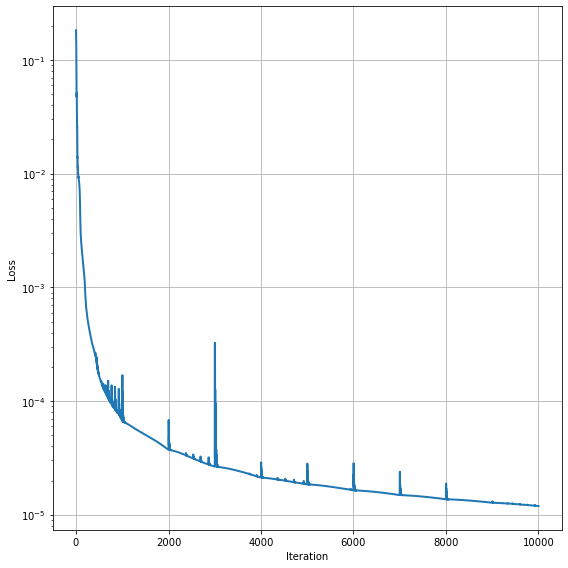

Loss = 1.1934085e-05:   0%|▏                                                                                                                                                        | 1/1000 [00:02<45:57,  2.76s/it]

New min loss =  1.1934085e-05


Loss = 1.1933001e-05:   3%|█████                                                                                                                                                   | 33/1000 [01:05<32:43,  2.03s/it]

New min loss =  1.1933001e-05


Loss = 1.1931207e-05:   4%|█████▊                                                                                                                                                  | 38/1000 [01:15<29:42,  1.85s/it]

New min loss =  1.1931207e-05


Loss = 1.1929855e-05:   4%|██████▍                                                                                                                                                 | 42/1000 [01:26<38:38,  2.42s/it]

New min loss =  1.1929855e-05


Loss = 1.1929304e-05:   5%|███████▏                                                                                                                                                | 47/1000 [01:37<32:42,  2.06s/it]

New min loss =  1.1929304e-05


Loss = 1.19279775e-05:   5%|████████▏                                                                                                                                              | 54/1000 [01:54<38:34,  2.45s/it]

New min loss =  1.19279775e-05


Loss = 1.1927388e-05:   6%|████████▉                                                                                                                                               | 59/1000 [02:05<36:59,  2.36s/it]

New min loss =  1.1927388e-05


Loss = 1.1926632e-05:   6%|█████████▍                                                                                                                                              | 62/1000 [02:13<38:37,  2.47s/it]

New min loss =  1.1926632e-05


Loss = 1.1926416e-05:   6%|█████████▉                                                                                                                                              | 65/1000 [02:20<38:53,  2.50s/it]

New min loss =  1.1926416e-05


Loss = 1.1925989e-05:   7%|██████████                                                                                                                                              | 66/1000 [02:23<39:14,  2.52s/it]

New min loss =  1.1925989e-05


Loss = 1.1925179e-05:   7%|██████████▋                                                                                                                                             | 70/1000 [02:31<34:06,  2.20s/it]

New min loss =  1.1925179e-05


Loss = 1.1924602e-05:   7%|███████████                                                                                                                                             | 73/1000 [02:38<37:07,  2.40s/it]

New min loss =  1.1924602e-05


Loss = 1.1924052e-05:   8%|███████████▌                                                                                                                                            | 76/1000 [02:46<38:19,  2.49s/it]

New min loss =  1.1924052e-05


Loss = 1.1923787e-05:   8%|███████████▋                                                                                                                                            | 77/1000 [02:48<38:21,  2.49s/it]

New min loss =  1.1923787e-05


Loss = 1.19234455e-05:   8%|████████████                                                                                                                                           | 80/1000 [02:53<29:06,  1.90s/it]

New min loss =  1.19234455e-05


Loss = 1.1923034e-05:   8%|████████████▎                                                                                                                                           | 81/1000 [02:55<31:11,  2.04s/it]

New min loss =  1.1923034e-05


Loss = 1.192279e-05:   8%|████████████▋                                                                                                                                            | 83/1000 [03:01<34:54,  2.28s/it]

New min loss =  1.192279e-05


Loss = 1.1922344e-05:   8%|████████████▊                                                                                                                                           | 84/1000 [03:03<35:58,  2.36s/it]

New min loss =  1.1922344e-05


Loss = 1.1922311e-05:   8%|████████████▉                                                                                                                                           | 85/1000 [03:06<36:55,  2.42s/it]

New min loss =  1.1922311e-05


Loss = 1.1922069e-05:   9%|█████████████                                                                                                                                           | 86/1000 [03:08<37:36,  2.47s/it]

New min loss =  1.1922069e-05


Loss = 1.1921641e-05:   9%|█████████████▏                                                                                                                                          | 87/1000 [03:11<37:26,  2.46s/it]

New min loss =  1.1921641e-05


Loss = 1.1921536e-05:   9%|█████████████▍                                                                                                                                          | 88/1000 [03:13<36:56,  2.43s/it]

New min loss =  1.1921536e-05


Loss = 1.1921337e-05:   9%|█████████████▌                                                                                                                                          | 89/1000 [03:16<37:20,  2.46s/it]

New min loss =  1.1921337e-05


Loss = 1.1920953e-05:   9%|█████████████▋                                                                                                                                          | 90/1000 [03:18<37:26,  2.47s/it]

New min loss =  1.1920953e-05


Loss = 1.192078e-05:   9%|█████████████▉                                                                                                                                           | 91/1000 [03:21<37:40,  2.49s/it]

New min loss =  1.192078e-05


Loss = 1.1920588e-05:   9%|██████████████▏                                                                                                                                         | 93/1000 [03:23<29:03,  1.92s/it]

New min loss =  1.1920588e-05


Loss = 1.1920236e-05:   9%|██████████████▎                                                                                                                                         | 94/1000 [03:25<30:22,  2.01s/it]

New min loss =  1.1920236e-05


Loss = 1.1920029e-05:  10%|██████████████▍                                                                                                                                         | 95/1000 [03:28<31:26,  2.08s/it]

New min loss =  1.1920029e-05


Loss = 1.191983e-05:  10%|██████████████▋                                                                                                                                          | 96/1000 [03:30<32:56,  2.19s/it]

New min loss =  1.191983e-05


Loss = 1.191951e-05:  10%|██████████████▊                                                                                                                                          | 97/1000 [03:33<33:42,  2.24s/it]

New min loss =  1.191951e-05


Loss = 1.1919277e-05:  10%|██████████████▉                                                                                                                                         | 98/1000 [03:35<34:52,  2.32s/it]

New min loss =  1.1919277e-05


Loss = 1.1919062e-05:  10%|███████████████                                                                                                                                         | 99/1000 [03:38<35:34,  2.37s/it]

New min loss =  1.1919062e-05


Loss = 1.1918747e-05:  10%|███████████████                                                                                                                                        | 100/1000 [03:40<35:22,  2.36s/it]

New min loss =  1.1918747e-05


Loss = 1.1918518e-05:  10%|███████████████▎                                                                                                                                       | 101/1000 [03:42<35:52,  2.39s/it]

New min loss =  1.1918518e-05


Loss = 1.1918282e-05:  10%|███████████████▍                                                                                                                                       | 102/1000 [03:45<36:53,  2.47s/it]

New min loss =  1.1918282e-05


Loss = 1.1917988e-05:  10%|███████████████▌                                                                                                                                       | 103/1000 [03:48<37:08,  2.48s/it]

New min loss =  1.1917988e-05


Loss = 1.1917749e-05:  10%|███████████████▋                                                                                                                                       | 104/1000 [03:50<36:28,  2.44s/it]

New min loss =  1.1917749e-05


Loss = 1.19175165e-05:  10%|███████████████▊                                                                                                                                      | 105/1000 [03:52<36:29,  2.45s/it]

New min loss =  1.19175165e-05


Loss = 1.19172155e-05:  11%|████████████████                                                                                                                                      | 107/1000 [03:55<28:59,  1.95s/it]

New min loss =  1.19172155e-05


Loss = 1.1916966e-05:  11%|████████████████▎                                                                                                                                      | 108/1000 [03:58<31:54,  2.15s/it]

New min loss =  1.1916966e-05


Loss = 1.1916718e-05:  11%|████████████████▍                                                                                                                                      | 109/1000 [04:00<32:54,  2.22s/it]

New min loss =  1.1916718e-05


Loss = 1.1916438e-05:  11%|████████████████▌                                                                                                                                      | 110/1000 [04:03<33:33,  2.26s/it]

New min loss =  1.1916438e-05


Loss = 1.1916186e-05:  11%|████████████████▊                                                                                                                                      | 111/1000 [04:05<34:20,  2.32s/it]

New min loss =  1.1916186e-05


Loss = 1.1915918e-05:  11%|████████████████▉                                                                                                                                      | 112/1000 [04:08<35:06,  2.37s/it]

New min loss =  1.1915918e-05


Loss = 1.1915639e-05:  11%|█████████████████                                                                                                                                      | 113/1000 [04:10<35:59,  2.43s/it]

New min loss =  1.1915639e-05


Loss = 1.1915386e-05:  11%|█████████████████▏                                                                                                                                     | 114/1000 [04:13<36:18,  2.46s/it]

New min loss =  1.1915386e-05


Loss = 1.19151055e-05:  12%|█████████████████▎                                                                                                                                    | 115/1000 [04:15<36:09,  2.45s/it]

New min loss =  1.19151055e-05


Loss = 1.1914828e-05:  12%|█████████████████▌                                                                                                                                     | 116/1000 [04:17<35:14,  2.39s/it]

New min loss =  1.1914828e-05


Loss = 1.19145725e-05:  12%|█████████████████▌                                                                                                                                    | 117/1000 [04:20<35:49,  2.43s/it]

New min loss =  1.19145725e-05


Loss = 1.1914302e-05:  12%|█████████████████▊                                                                                                                                     | 118/1000 [04:23<36:35,  2.49s/it]

New min loss =  1.1914302e-05


Loss = 1.1914006e-05:  12%|█████████████████▉                                                                                                                                     | 119/1000 [04:25<37:14,  2.54s/it]

New min loss =  1.1914006e-05


Loss = 1.1913747e-05:  12%|██████████████████                                                                                                                                     | 120/1000 [04:28<37:20,  2.55s/it]

New min loss =  1.1913747e-05


Loss = 1.1913474e-05:  12%|██████████████████▍                                                                                                                                    | 122/1000 [04:30<28:28,  1.95s/it]

New min loss =  1.1913474e-05


Loss = 1.1913186e-05:  12%|██████████████████▌                                                                                                                                    | 123/1000 [04:33<30:59,  2.12s/it]

New min loss =  1.1913186e-05


Loss = 1.1912914e-05:  12%|██████████████████▋                                                                                                                                    | 124/1000 [04:36<32:42,  2.24s/it]

New min loss =  1.1912914e-05


Loss = 1.191262e-05:  12%|███████████████████                                                                                                                                     | 125/1000 [04:38<33:43,  2.31s/it]

New min loss =  1.191262e-05


Loss = 1.191234e-05:  13%|███████████████████▏                                                                                                                                    | 126/1000 [04:41<34:43,  2.38s/it]

New min loss =  1.191234e-05


Loss = 1.1912065e-05:  13%|███████████████████▏                                                                                                                                   | 127/1000 [04:43<35:12,  2.42s/it]

New min loss =  1.1912065e-05


Loss = 1.1911775e-05:  13%|███████████████████▎                                                                                                                                   | 128/1000 [04:45<34:51,  2.40s/it]

New min loss =  1.1911775e-05


Loss = 1.1911492e-05:  13%|███████████████████▍                                                                                                                                   | 129/1000 [04:48<34:45,  2.39s/it]

New min loss =  1.1911492e-05


Loss = 1.1911199e-05:  13%|███████████████████▋                                                                                                                                   | 130/1000 [04:50<35:45,  2.47s/it]

New min loss =  1.1911199e-05


Loss = 1.1910915e-05:  13%|███████████████████▊                                                                                                                                   | 131/1000 [04:53<35:52,  2.48s/it]

New min loss =  1.1910915e-05


Loss = 1.1910627e-05:  13%|███████████████████▉                                                                                                                                   | 132/1000 [04:55<35:41,  2.47s/it]

New min loss =  1.1910627e-05


Loss = 1.1910333e-05:  13%|████████████████████                                                                                                                                   | 133/1000 [04:58<35:43,  2.47s/it]

New min loss =  1.1910333e-05


Loss = 1.191005e-05:  13%|████████████████████▎                                                                                                                                   | 134/1000 [05:00<35:48,  2.48s/it]

New min loss =  1.191005e-05


Loss = 1.1909747e-05:  14%|████████████████████▍                                                                                                                                  | 135/1000 [05:03<36:27,  2.53s/it]

New min loss =  1.1909747e-05


Loss = 1.1909457e-05:  14%|████████████████████▌                                                                                                                                  | 136/1000 [05:06<36:24,  2.53s/it]

New min loss =  1.1909457e-05


Loss = 1.190916e-05:  14%|████████████████████▉                                                                                                                                   | 138/1000 [05:08<28:03,  1.95s/it]

New min loss =  1.190916e-05


Loss = 1.1908862e-05:  14%|████████████████████▉                                                                                                                                  | 139/1000 [05:10<27:43,  1.93s/it]

New min loss =  1.1908862e-05


Loss = 1.1908569e-05:  14%|█████████████████████▏                                                                                                                                 | 140/1000 [05:12<27:34,  1.92s/it]

New min loss =  1.1908569e-05


Loss = 1.1908272e-05:  14%|█████████████████████▎                                                                                                                                 | 141/1000 [05:14<27:56,  1.95s/it]

New min loss =  1.1908272e-05


Loss = 1.1907964e-05:  14%|█████████████████████▍                                                                                                                                 | 142/1000 [05:16<28:38,  2.00s/it]

New min loss =  1.1907964e-05


Loss = 1.1907669e-05:  14%|█████████████████████▌                                                                                                                                 | 143/1000 [05:18<28:36,  2.00s/it]

New min loss =  1.1907669e-05


Loss = 1.1907375e-05:  14%|█████████████████████▋                                                                                                                                 | 144/1000 [05:20<28:14,  1.98s/it]

New min loss =  1.1907375e-05


Loss = 1.1907062e-05:  14%|█████████████████████▉                                                                                                                                 | 145/1000 [05:22<28:14,  1.98s/it]

New min loss =  1.1907062e-05


Loss = 1.1906754e-05:  15%|██████████████████████                                                                                                                                 | 146/1000 [05:24<29:05,  2.04s/it]

New min loss =  1.1906754e-05


Loss = 1.1906454e-05:  15%|██████████████████████▏                                                                                                                                | 147/1000 [05:26<28:26,  2.00s/it]

New min loss =  1.1906454e-05


Loss = 1.1906147e-05:  15%|██████████████████████▎                                                                                                                                | 148/1000 [05:28<28:05,  1.98s/it]

New min loss =  1.1906147e-05


Loss = 1.1905836e-05:  15%|██████████████████████▍                                                                                                                                | 149/1000 [05:30<28:40,  2.02s/it]

New min loss =  1.1905836e-05


Loss = 1.1905523e-05:  15%|██████████████████████▋                                                                                                                                | 150/1000 [05:33<30:40,  2.16s/it]

New min loss =  1.1905523e-05


Loss = 1.1905222e-05:  15%|██████████████████████▊                                                                                                                                | 151/1000 [05:35<32:30,  2.30s/it]

New min loss =  1.1905222e-05


Loss = 1.1904903e-05:  15%|██████████████████████▉                                                                                                                                | 152/1000 [05:38<36:20,  2.57s/it]

New min loss =  1.1904903e-05


Loss = 1.1904595e-05:  15%|███████████████████████                                                                                                                                | 153/1000 [05:41<38:08,  2.70s/it]

New min loss =  1.1904595e-05


Loss = 1.1904276e-05:  16%|███████████████████████▍                                                                                                                               | 155/1000 [05:45<31:01,  2.20s/it]

New min loss =  1.1904276e-05


Loss = 1.1903963e-05:  16%|███████████████████████▌                                                                                                                               | 156/1000 [05:48<34:34,  2.46s/it]

New min loss =  1.1903963e-05


Loss = 1.1903647e-05:  16%|███████████████████████▋                                                                                                                               | 157/1000 [05:51<37:55,  2.70s/it]

New min loss =  1.1903647e-05


Loss = 1.1903335e-05:  16%|███████████████████████▊                                                                                                                               | 158/1000 [05:53<35:54,  2.56s/it]

New min loss =  1.1903335e-05


Loss = 1.1903026e-05:  16%|████████████████████████                                                                                                                               | 159/1000 [05:55<32:55,  2.35s/it]

New min loss =  1.1903026e-05


Loss = 1.1902699e-05:  16%|████████████████████████▏                                                                                                                              | 160/1000 [05:57<31:11,  2.23s/it]

New min loss =  1.1902699e-05


Loss = 1.1902377e-05:  16%|████████████████████████▎                                                                                                                              | 161/1000 [05:59<30:00,  2.15s/it]

New min loss =  1.1902377e-05


Loss = 1.1902053e-05:  16%|████████████████████████▍                                                                                                                              | 162/1000 [06:01<29:19,  2.10s/it]

New min loss =  1.1902053e-05


Loss = 1.1901738e-05:  16%|████████████████████████▌                                                                                                                              | 163/1000 [06:03<29:41,  2.13s/it]

New min loss =  1.1901738e-05


Loss = 1.1901413e-05:  16%|████████████████████████▊                                                                                                                              | 164/1000 [06:05<28:27,  2.04s/it]

New min loss =  1.1901413e-05


Loss = 1.1901103e-05:  16%|████████████████████████▉                                                                                                                              | 165/1000 [06:07<28:05,  2.02s/it]

New min loss =  1.1901103e-05


Loss = 1.1900754e-05:  17%|█████████████████████████                                                                                                                              | 166/1000 [06:09<28:09,  2.03s/it]

New min loss =  1.1900754e-05


Loss = 1.1900442e-05:  17%|█████████████████████████▏                                                                                                                             | 167/1000 [06:11<28:51,  2.08s/it]

New min loss =  1.1900442e-05


Loss = 1.1900113e-05:  17%|█████████████████████████▎                                                                                                                             | 168/1000 [06:13<28:56,  2.09s/it]

New min loss =  1.1900113e-05


Loss = 1.1899783e-05:  17%|█████████████████████████▌                                                                                                                             | 169/1000 [06:16<29:24,  2.12s/it]

New min loss =  1.1899783e-05


Loss = 1.1899459e-05:  17%|█████████████████████████▋                                                                                                                             | 170/1000 [06:18<31:12,  2.26s/it]

New min loss =  1.1899459e-05


Loss = 1.1899124e-05:  17%|█████████████████████████▊                                                                                                                             | 171/1000 [06:21<32:22,  2.34s/it]

New min loss =  1.1899124e-05


Loss = 1.18987855e-05:  17%|█████████████████████████▉                                                                                                                            | 173/1000 [06:23<25:45,  1.87s/it]

New min loss =  1.18987855e-05


Loss = 1.18984635e-05:  17%|██████████████████████████                                                                                                                            | 174/1000 [06:26<27:41,  2.01s/it]

New min loss =  1.18984635e-05


Loss = 1.1898126e-05:  18%|██████████████████████████▍                                                                                                                            | 175/1000 [06:28<29:31,  2.15s/it]

New min loss =  1.1898126e-05


Loss = 1.1897798e-05:  18%|██████████████████████████▌                                                                                                                            | 176/1000 [06:31<31:13,  2.27s/it]

New min loss =  1.1897798e-05


Loss = 1.1897457e-05:  18%|██████████████████████████▋                                                                                                                            | 177/1000 [06:34<31:58,  2.33s/it]

New min loss =  1.1897457e-05


Loss = 1.1897125e-05:  18%|██████████████████████████▉                                                                                                                            | 178/1000 [06:36<32:37,  2.38s/it]

New min loss =  1.1897125e-05


Loss = 1.18967955e-05:  18%|██████████████████████████▊                                                                                                                           | 179/1000 [06:38<32:14,  2.36s/it]

New min loss =  1.18967955e-05


Loss = 1.1896441e-05:  18%|███████████████████████████▏                                                                                                                           | 180/1000 [06:41<33:10,  2.43s/it]

New min loss =  1.1896441e-05


Loss = 1.1896119e-05:  18%|███████████████████████████▎                                                                                                                           | 181/1000 [06:44<34:32,  2.53s/it]

New min loss =  1.1896119e-05


Loss = 1.1895781e-05:  18%|███████████████████████████▍                                                                                                                           | 182/1000 [06:46<35:21,  2.59s/it]

New min loss =  1.1895781e-05


Loss = 1.1895431e-05:  18%|███████████████████████████▋                                                                                                                           | 183/1000 [06:50<37:18,  2.74s/it]

New min loss =  1.1895431e-05


Loss = 1.18950875e-05:  18%|███████████████████████████▌                                                                                                                          | 184/1000 [06:52<36:50,  2.71s/it]

New min loss =  1.18950875e-05


Loss = 1.1894743e-05:  18%|███████████████████████████▉                                                                                                                           | 185/1000 [06:55<36:47,  2.71s/it]

New min loss =  1.1894743e-05


Loss = 1.1894402e-05:  19%|████████████████████████████                                                                                                                           | 186/1000 [06:58<37:37,  2.77s/it]

New min loss =  1.1894402e-05


Loss = 1.1894061e-05:  19%|████████████████████████████▏                                                                                                                          | 187/1000 [07:01<37:56,  2.80s/it]

New min loss =  1.1894061e-05


Loss = 1.1893717e-05:  19%|████████████████████████████▍                                                                                                                          | 188/1000 [07:03<37:59,  2.81s/it]

New min loss =  1.1893717e-05


Loss = 1.1893374e-05:  19%|████████████████████████████▌                                                                                                                          | 189/1000 [07:06<36:57,  2.73s/it]

New min loss =  1.1893374e-05


Loss = 1.189302e-05:  19%|████████████████████████████▉                                                                                                                           | 190/1000 [07:09<37:39,  2.79s/it]

New min loss =  1.189302e-05


Loss = 1.1892672e-05:  19%|████████████████████████████▉                                                                                                                          | 192/1000 [07:12<29:30,  2.19s/it]

New min loss =  1.1892672e-05


Loss = 1.1892322e-05:  19%|█████████████████████████████▏                                                                                                                         | 193/1000 [07:15<31:41,  2.36s/it]

New min loss =  1.1892322e-05


Loss = 1.1891969e-05:  19%|█████████████████████████████▎                                                                                                                         | 194/1000 [07:18<33:14,  2.47s/it]

New min loss =  1.1891969e-05


Loss = 1.189162e-05:  20%|█████████████████████████████▋                                                                                                                          | 195/1000 [07:20<34:04,  2.54s/it]

New min loss =  1.189162e-05


Loss = 1.1891273e-05:  20%|█████████████████████████████▌                                                                                                                         | 196/1000 [07:23<34:48,  2.60s/it]

New min loss =  1.1891273e-05


Loss = 1.1890918e-05:  20%|█████████████████████████████▋                                                                                                                         | 197/1000 [07:26<35:24,  2.65s/it]

New min loss =  1.1890918e-05


Loss = 1.1890558e-05:  20%|█████████████████████████████▉                                                                                                                         | 198/1000 [07:29<36:02,  2.70s/it]

New min loss =  1.1890558e-05


Loss = 1.1890214e-05:  20%|██████████████████████████████                                                                                                                         | 199/1000 [07:31<36:09,  2.71s/it]

New min loss =  1.1890214e-05


Loss = 1.18898515e-05:  20%|██████████████████████████████                                                                                                                        | 200/1000 [07:34<37:02,  2.78s/it]

New min loss =  1.18898515e-05


Loss = 1.18895e-05:  20%|██████████████████████████████▊                                                                                                                          | 201/1000 [07:37<37:40,  2.83s/it]

New min loss =  1.18895e-05


Loss = 1.1889151e-05:  20%|██████████████████████████████▌                                                                                                                        | 202/1000 [07:40<38:03,  2.86s/it]

New min loss =  1.1889151e-05


Loss = 1.1888786e-05:  20%|██████████████████████████████▋                                                                                                                        | 203/1000 [07:43<37:09,  2.80s/it]

New min loss =  1.1888786e-05


Loss = 1.1888425e-05:  20%|██████████████████████████████▊                                                                                                                        | 204/1000 [07:45<35:21,  2.67s/it]

New min loss =  1.1888425e-05


Loss = 1.1888072e-05:  20%|██████████████████████████████▉                                                                                                                        | 205/1000 [07:47<32:51,  2.48s/it]

New min loss =  1.1888072e-05


Loss = 1.1887698e-05:  21%|███████████████████████████████                                                                                                                        | 206/1000 [07:49<30:27,  2.30s/it]

New min loss =  1.1887698e-05


Loss = 1.1887346e-05:  21%|███████████████████████████████▎                                                                                                                       | 207/1000 [07:51<30:06,  2.28s/it]

New min loss =  1.1887346e-05


Loss = 1.1886983e-05:  21%|███████████████████████████████▍                                                                                                                       | 208/1000 [07:53<28:19,  2.15s/it]

New min loss =  1.1886983e-05


Loss = 1.1886613e-05:  21%|███████████████████████████████▌                                                                                                                       | 209/1000 [07:55<28:04,  2.13s/it]

New min loss =  1.1886613e-05


Loss = 1.1886262e-05:  21%|███████████████████████████████▋                                                                                                                       | 210/1000 [07:57<28:12,  2.14s/it]

New min loss =  1.1886262e-05


Loss = 1.1885887e-05:  21%|████████████████████████████████                                                                                                                       | 212/1000 [08:00<21:22,  1.63s/it]

New min loss =  1.1885887e-05


Loss = 1.1885522e-05:  21%|████████████████████████████████▏                                                                                                                      | 213/1000 [08:01<22:01,  1.68s/it]

New min loss =  1.1885522e-05


Loss = 1.1885161e-05:  21%|████████████████████████████████▎                                                                                                                      | 214/1000 [08:03<23:14,  1.77s/it]

New min loss =  1.1885161e-05


Loss = 1.1884782e-05:  22%|████████████████████████████████▍                                                                                                                      | 215/1000 [08:05<23:59,  1.83s/it]

New min loss =  1.1884782e-05


Loss = 1.1884423e-05:  22%|████████████████████████████████▌                                                                                                                      | 216/1000 [08:07<24:40,  1.89s/it]

New min loss =  1.1884423e-05


Loss = 1.1884045e-05:  22%|████████████████████████████████▊                                                                                                                      | 217/1000 [08:10<25:38,  1.96s/it]

New min loss =  1.1884045e-05


Loss = 1.188368e-05:  22%|█████████████████████████████████▏                                                                                                                      | 218/1000 [08:12<26:40,  2.05s/it]

New min loss =  1.188368e-05


Loss = 1.1883305e-05:  22%|█████████████████████████████████                                                                                                                      | 219/1000 [08:14<28:06,  2.16s/it]

New min loss =  1.1883305e-05


Loss = 1.1882937e-05:  22%|█████████████████████████████████▏                                                                                                                     | 220/1000 [08:17<29:03,  2.24s/it]

New min loss =  1.1882937e-05


Loss = 1.1882558e-05:  22%|█████████████████████████████████▎                                                                                                                     | 221/1000 [08:19<30:42,  2.37s/it]

New min loss =  1.1882558e-05


Loss = 1.1882175e-05:  22%|█████████████████████████████████▌                                                                                                                     | 222/1000 [08:22<31:14,  2.41s/it]

New min loss =  1.1882175e-05


Loss = 1.1881806e-05:  22%|█████████████████████████████████▋                                                                                                                     | 223/1000 [08:24<31:40,  2.45s/it]

New min loss =  1.1881806e-05


Loss = 1.1881441e-05:  22%|█████████████████████████████████▊                                                                                                                     | 224/1000 [08:27<31:41,  2.45s/it]

New min loss =  1.1881441e-05


Loss = 1.1881048e-05:  22%|█████████████████████████████████▉                                                                                                                     | 225/1000 [08:29<31:52,  2.47s/it]

New min loss =  1.1881048e-05


Loss = 1.1880674e-05:  23%|██████████████████████████████████▏                                                                                                                    | 226/1000 [08:32<32:20,  2.51s/it]

New min loss =  1.1880674e-05


Loss = 1.1880301e-05:  23%|██████████████████████████████████▎                                                                                                                    | 227/1000 [08:34<31:41,  2.46s/it]

New min loss =  1.1880301e-05


Loss = 1.1879927e-05:  23%|██████████████████████████████████▍                                                                                                                    | 228/1000 [08:37<31:31,  2.45s/it]

New min loss =  1.1879927e-05


Loss = 1.187954e-05:  23%|██████████████████████████████████▊                                                                                                                     | 229/1000 [08:39<32:06,  2.50s/it]

New min loss =  1.187954e-05


Loss = 1.1879153e-05:  23%|██████████████████████████████████▋                                                                                                                    | 230/1000 [08:42<32:04,  2.50s/it]

New min loss =  1.1879153e-05


Loss = 1.1878777e-05:  23%|██████████████████████████████████▉                                                                                                                    | 231/1000 [08:45<32:49,  2.56s/it]

New min loss =  1.1878777e-05


Loss = 1.1878388e-05:  23%|███████████████████████████████████▏                                                                                                                   | 233/1000 [08:47<24:30,  1.92s/it]

New min loss =  1.1878388e-05


Loss = 1.1878011e-05:  23%|███████████████████████████████████▎                                                                                                                   | 234/1000 [08:50<26:42,  2.09s/it]

New min loss =  1.1878011e-05


Loss = 1.1877628e-05:  24%|███████████████████████████████████▍                                                                                                                   | 235/1000 [08:52<27:39,  2.17s/it]

New min loss =  1.1877628e-05


Loss = 1.1877238e-05:  24%|███████████████████████████████████▋                                                                                                                   | 236/1000 [08:55<29:11,  2.29s/it]

New min loss =  1.1877238e-05


Loss = 1.1876849e-05:  24%|███████████████████████████████████▊                                                                                                                   | 237/1000 [08:57<29:17,  2.30s/it]

New min loss =  1.1876849e-05


Loss = 1.1876458e-05:  24%|███████████████████████████████████▉                                                                                                                   | 238/1000 [08:59<30:17,  2.38s/it]

New min loss =  1.1876458e-05


Loss = 1.1876075e-05:  24%|████████████████████████████████████                                                                                                                   | 239/1000 [09:02<30:38,  2.42s/it]

New min loss =  1.1876075e-05


Loss = 1.1875675e-05:  24%|████████████████████████████████████▏                                                                                                                  | 240/1000 [09:05<31:15,  2.47s/it]

New min loss =  1.1875675e-05


Loss = 1.1875291e-05:  24%|████████████████████████████████████▍                                                                                                                  | 241/1000 [09:07<30:34,  2.42s/it]

New min loss =  1.1875291e-05


Loss = 1.18749e-05:  24%|█████████████████████████████████████                                                                                                                    | 242/1000 [09:09<31:09,  2.47s/it]

New min loss =  1.18749e-05


Loss = 1.1874515e-05:  24%|████████████████████████████████████▋                                                                                                                  | 243/1000 [09:12<30:59,  2.46s/it]

New min loss =  1.1874515e-05


Loss = 1.1874121e-05:  24%|████████████████████████████████████▊                                                                                                                  | 244/1000 [09:15<31:58,  2.54s/it]

New min loss =  1.1874121e-05


Loss = 1.1873723e-05:  24%|████████████████████████████████████▉                                                                                                                  | 245/1000 [09:17<31:23,  2.49s/it]

New min loss =  1.1873723e-05


Loss = 1.187333e-05:  25%|█████████████████████████████████████▍                                                                                                                  | 246/1000 [09:20<31:58,  2.54s/it]

New min loss =  1.187333e-05


Loss = 1.1872939e-05:  25%|█████████████████████████████████████▎                                                                                                                 | 247/1000 [09:22<31:25,  2.50s/it]

New min loss =  1.1872939e-05


Loss = 1.1872549e-05:  25%|█████████████████████████████████████▍                                                                                                                 | 248/1000 [09:25<31:40,  2.53s/it]

New min loss =  1.1872549e-05


Loss = 1.1872143e-05:  25%|█████████████████████████████████████▌                                                                                                                 | 249/1000 [09:27<30:46,  2.46s/it]

New min loss =  1.1872143e-05


Loss = 1.18717535e-05:  25%|█████████████████████████████████████▌                                                                                                                | 250/1000 [09:29<30:43,  2.46s/it]

New min loss =  1.18717535e-05


Loss = 1.1871347e-05:  25%|█████████████████████████████████████▉                                                                                                                 | 251/1000 [09:32<31:06,  2.49s/it]

New min loss =  1.1871347e-05


Loss = 1.18709495e-05:  25%|█████████████████████████████████████▊                                                                                                                | 252/1000 [09:35<31:22,  2.52s/it]

New min loss =  1.18709495e-05


Loss = 1.1870556e-05:  25%|██████████████████████████████████████▏                                                                                                                | 253/1000 [09:37<31:10,  2.50s/it]

New min loss =  1.1870556e-05


Loss = 1.1870149e-05:  26%|██████████████████████████████████████▌                                                                                                                | 255/1000 [09:39<23:06,  1.86s/it]

New min loss =  1.1870149e-05


Loss = 1.1869749e-05:  26%|██████████████████████████████████████▋                                                                                                                | 256/1000 [09:42<25:02,  2.02s/it]

New min loss =  1.1869749e-05


Loss = 1.1869348e-05:  26%|██████████████████████████████████████▊                                                                                                                | 257/1000 [09:44<26:43,  2.16s/it]

New min loss =  1.1869348e-05


Loss = 1.1868946e-05:  26%|██████████████████████████████████████▉                                                                                                                | 258/1000 [09:47<28:50,  2.33s/it]

New min loss =  1.1868946e-05


Loss = 1.1868538e-05:  26%|███████████████████████████████████████                                                                                                                | 259/1000 [09:49<29:04,  2.35s/it]

New min loss =  1.1868538e-05


Loss = 1.1868147e-05:  26%|███████████████████████████████████████▎                                                                                                               | 260/1000 [09:52<29:53,  2.42s/it]

New min loss =  1.1868147e-05


Loss = 1.18677335e-05:  26%|███████████████████████████████████████▏                                                                                                              | 261/1000 [09:55<31:01,  2.52s/it]

New min loss =  1.18677335e-05


Loss = 1.1867326e-05:  26%|███████████████████████████████████████▌                                                                                                               | 262/1000 [09:57<31:06,  2.53s/it]

New min loss =  1.1867326e-05


Loss = 1.1866926e-05:  26%|███████████████████████████████████████▋                                                                                                               | 263/1000 [10:00<30:37,  2.49s/it]

New min loss =  1.1866926e-05


Loss = 1.1866518e-05:  26%|███████████████████████████████████████▊                                                                                                               | 264/1000 [10:02<30:40,  2.50s/it]

New min loss =  1.1866518e-05


Loss = 1.1866105e-05:  26%|████████████████████████████████████████                                                                                                               | 265/1000 [10:05<31:14,  2.55s/it]

New min loss =  1.1866105e-05


Loss = 1.1865694e-05:  27%|████████████████████████████████████████▏                                                                                                              | 266/1000 [10:08<32:00,  2.62s/it]

New min loss =  1.1865694e-05


Loss = 1.1865285e-05:  27%|████████████████████████████████████████▎                                                                                                              | 267/1000 [10:10<31:13,  2.56s/it]

New min loss =  1.1865285e-05


Loss = 1.1864878e-05:  27%|████████████████████████████████████████▍                                                                                                              | 268/1000 [10:13<31:31,  2.58s/it]

New min loss =  1.1864878e-05


Loss = 1.186447e-05:  27%|████████████████████████████████████████▉                                                                                                               | 269/1000 [10:16<31:52,  2.62s/it]

New min loss =  1.186447e-05


Loss = 1.1864063e-05:  27%|████████████████████████████████████████▊                                                                                                              | 270/1000 [10:18<32:23,  2.66s/it]

New min loss =  1.1864063e-05


Loss = 1.1863652e-05:  27%|████████████████████████████████████████▉                                                                                                              | 271/1000 [10:21<31:24,  2.58s/it]

New min loss =  1.1863652e-05


Loss = 1.1863234e-05:  27%|█████████████████████████████████████████                                                                                                              | 272/1000 [10:23<31:12,  2.57s/it]

New min loss =  1.1863234e-05


Loss = 1.1862827e-05:  27%|█████████████████████████████████████████▏                                                                                                             | 273/1000 [10:26<31:30,  2.60s/it]

New min loss =  1.1862827e-05


Loss = 1.1862414e-05:  27%|█████████████████████████████████████████▎                                                                                                             | 274/1000 [10:28<31:03,  2.57s/it]

New min loss =  1.1862414e-05


Loss = 1.1861992e-05:  28%|█████████████████████████████████████████▌                                                                                                             | 275/1000 [10:31<30:23,  2.52s/it]

New min loss =  1.1861992e-05


Loss = 1.186157e-05:  28%|█████████████████████████████████████████▉                                                                                                              | 276/1000 [10:33<30:27,  2.52s/it]

New min loss =  1.186157e-05


Loss = 1.18611615e-05:  28%|█████████████████████████████████████████▋                                                                                                            | 278/1000 [10:36<23:31,  1.95s/it]

New min loss =  1.18611615e-05


Loss = 1.1860744e-05:  28%|██████████████████████████████████████████▏                                                                                                            | 279/1000 [10:39<26:24,  2.20s/it]

New min loss =  1.1860744e-05


Loss = 1.1860331e-05:  28%|██████████████████████████████████████████▎                                                                                                            | 280/1000 [10:41<26:53,  2.24s/it]

New min loss =  1.1860331e-05


Loss = 1.1859912e-05:  28%|██████████████████████████████████████████▍                                                                                                            | 281/1000 [10:44<27:37,  2.31s/it]

New min loss =  1.1859912e-05


Loss = 1.185949e-05:  28%|██████████████████████████████████████████▊                                                                                                             | 282/1000 [10:46<28:11,  2.36s/it]

New min loss =  1.185949e-05


Loss = 1.1859069e-05:  28%|██████████████████████████████████████████▋                                                                                                            | 283/1000 [10:49<29:19,  2.45s/it]

New min loss =  1.1859069e-05


Loss = 1.1858654e-05:  28%|██████████████████████████████████████████▉                                                                                                            | 284/1000 [10:51<29:46,  2.49s/it]

New min loss =  1.1858654e-05


Loss = 1.1858219e-05:  28%|███████████████████████████████████████████                                                                                                            | 285/1000 [10:54<29:39,  2.49s/it]

New min loss =  1.1858219e-05


Loss = 1.1857805e-05:  29%|███████████████████████████████████████████▏                                                                                                           | 286/1000 [10:57<30:07,  2.53s/it]

New min loss =  1.1857805e-05


Loss = 1.1857386e-05:  29%|███████████████████████████████████████████▎                                                                                                           | 287/1000 [10:59<30:30,  2.57s/it]

New min loss =  1.1857386e-05


Loss = 1.1856964e-05:  29%|███████████████████████████████████████████▍                                                                                                           | 288/1000 [11:02<30:24,  2.56s/it]

New min loss =  1.1856964e-05


Loss = 1.1856534e-05:  29%|███████████████████████████████████████████▋                                                                                                           | 289/1000 [11:04<30:01,  2.53s/it]

New min loss =  1.1856534e-05


Loss = 1.1856117e-05:  29%|███████████████████████████████████████████▊                                                                                                           | 290/1000 [11:07<29:44,  2.51s/it]

New min loss =  1.1856117e-05


Loss = 1.1855691e-05:  29%|███████████████████████████████████████████▉                                                                                                           | 291/1000 [11:09<30:06,  2.55s/it]

New min loss =  1.1855691e-05


Loss = 1.18552625e-05:  29%|███████████████████████████████████████████▊                                                                                                          | 292/1000 [11:12<30:15,  2.56s/it]

New min loss =  1.18552625e-05


Loss = 1.1854836e-05:  29%|████████████████████████████████████████████▏                                                                                                          | 293/1000 [11:14<30:06,  2.56s/it]

New min loss =  1.1854836e-05


Loss = 1.1854412e-05:  29%|████████████████████████████████████████████▍                                                                                                          | 294/1000 [11:17<30:14,  2.57s/it]

New min loss =  1.1854412e-05


Loss = 1.1853981e-05:  30%|████████████████████████████████████████████▌                                                                                                          | 295/1000 [11:20<30:11,  2.57s/it]

New min loss =  1.1853981e-05


Loss = 1.1853556e-05:  30%|████████████████████████████████████████████▋                                                                                                          | 296/1000 [11:22<30:17,  2.58s/it]

New min loss =  1.1853556e-05


Loss = 1.185312e-05:  30%|█████████████████████████████████████████████▏                                                                                                          | 297/1000 [11:25<30:08,  2.57s/it]

New min loss =  1.185312e-05


Loss = 1.1852683e-05:  30%|████████████████████████████████████████████▉                                                                                                          | 298/1000 [11:27<29:31,  2.52s/it]

New min loss =  1.1852683e-05


Loss = 1.18522585e-05:  30%|████████████████████████████████████████████▊                                                                                                         | 299/1000 [11:30<30:36,  2.62s/it]

New min loss =  1.18522585e-05


Loss = 1.1851816e-05:  30%|█████████████████████████████████████████████▎                                                                                                         | 300/1000 [11:32<27:42,  2.38s/it]

New min loss =  1.1851816e-05


Loss = 1.1851391e-05:  30%|█████████████████████████████████████████████▌                                                                                                         | 302/1000 [11:34<20:13,  1.74s/it]

New min loss =  1.1851391e-05


Loss = 1.185095e-05:  30%|██████████████████████████████████████████████                                                                                                          | 303/1000 [11:36<21:18,  1.83s/it]

New min loss =  1.185095e-05


Loss = 1.1850518e-05:  30%|█████████████████████████████████████████████▉                                                                                                         | 304/1000 [11:38<22:03,  1.90s/it]

New min loss =  1.1850518e-05


Loss = 1.1850078e-05:  30%|██████████████████████████████████████████████                                                                                                         | 305/1000 [11:40<21:43,  1.88s/it]

New min loss =  1.1850078e-05


Loss = 1.1849646e-05:  31%|██████████████████████████████████████████████▏                                                                                                        | 306/1000 [11:42<22:06,  1.91s/it]

New min loss =  1.1849646e-05


Loss = 1.1849212e-05:  31%|██████████████████████████████████████████████▎                                                                                                        | 307/1000 [11:44<22:20,  1.93s/it]

New min loss =  1.1849212e-05


Loss = 1.1848768e-05:  31%|██████████████████████████████████████████████▌                                                                                                        | 308/1000 [11:46<22:31,  1.95s/it]

New min loss =  1.1848768e-05


Loss = 1.1848329e-05:  31%|██████████████████████████████████████████████▋                                                                                                        | 309/1000 [11:48<23:00,  2.00s/it]

New min loss =  1.1848329e-05


Loss = 1.1847891e-05:  31%|██████████████████████████████████████████████▊                                                                                                        | 310/1000 [11:50<22:48,  1.98s/it]

New min loss =  1.1847891e-05


Loss = 1.18474445e-05:  31%|██████████████████████████████████████████████▋                                                                                                       | 311/1000 [11:52<23:03,  2.01s/it]

New min loss =  1.18474445e-05


Loss = 1.18470025e-05:  31%|██████████████████████████████████████████████▊                                                                                                       | 312/1000 [11:54<23:52,  2.08s/it]

New min loss =  1.18470025e-05


Loss = 1.1846569e-05:  31%|███████████████████████████████████████████████▎                                                                                                       | 313/1000 [11:57<26:21,  2.30s/it]

New min loss =  1.1846569e-05


Loss = 1.1846126e-05:  31%|███████████████████████████████████████████████▍                                                                                                       | 314/1000 [12:00<29:25,  2.57s/it]

New min loss =  1.1846126e-05


Loss = 1.1845681e-05:  32%|███████████████████████████████████████████████▌                                                                                                       | 315/1000 [12:04<31:40,  2.78s/it]

New min loss =  1.1845681e-05


Loss = 1.1845235e-05:  32%|███████████████████████████████████████████████▋                                                                                                       | 316/1000 [12:07<33:13,  2.91s/it]

New min loss =  1.1845235e-05


Loss = 1.1844796e-05:  32%|███████████████████████████████████████████████▊                                                                                                       | 317/1000 [12:10<34:32,  3.03s/it]

New min loss =  1.1844796e-05


Loss = 1.1844341e-05:  32%|████████████████████████████████████████████████                                                                                                       | 318/1000 [12:14<35:55,  3.16s/it]

New min loss =  1.1844341e-05


Loss = 1.18438975e-05:  32%|███████████████████████████████████████████████▊                                                                                                      | 319/1000 [12:17<36:01,  3.17s/it]

New min loss =  1.18438975e-05


Loss = 1.1843447e-05:  32%|████████████████████████████████████████████████▎                                                                                                      | 320/1000 [12:20<35:46,  3.16s/it]

New min loss =  1.1843447e-05


Loss = 1.18429925e-05:  32%|████████████████████████████████████████████████▏                                                                                                     | 321/1000 [12:23<35:58,  3.18s/it]

New min loss =  1.18429925e-05


Loss = 1.1842555e-05:  32%|████████████████████████████████████████████████▌                                                                                                      | 322/1000 [12:26<34:48,  3.08s/it]

New min loss =  1.1842555e-05


Loss = 1.1842103e-05:  32%|████████████████████████████████████████████████▊                                                                                                      | 323/1000 [12:28<31:27,  2.79s/it]

New min loss =  1.1842103e-05


Loss = 1.1841653e-05:  32%|████████████████████████████████████████████████▉                                                                                                      | 324/1000 [12:30<28:10,  2.50s/it]

New min loss =  1.1841653e-05


Loss = 1.18412045e-05:  32%|████████████████████████████████████████████████▊                                                                                                     | 325/1000 [12:32<25:50,  2.30s/it]

New min loss =  1.18412045e-05


Loss = 1.1840758e-05:  33%|█████████████████████████████████████████████████▍                                                                                                     | 327/1000 [12:34<19:15,  1.72s/it]

New min loss =  1.1840758e-05


Loss = 1.1840311e-05:  33%|█████████████████████████████████████████████████▌                                                                                                     | 328/1000 [12:36<19:49,  1.77s/it]

New min loss =  1.1840311e-05


Loss = 1.18398375e-05:  33%|█████████████████████████████████████████████████▎                                                                                                    | 329/1000 [12:38<20:25,  1.83s/it]

New min loss =  1.18398375e-05


Loss = 1.1839383e-05:  33%|█████████████████████████████████████████████████▊                                                                                                     | 330/1000 [12:40<20:38,  1.85s/it]

New min loss =  1.1839383e-05


Loss = 1.1838943e-05:  33%|█████████████████████████████████████████████████▉                                                                                                     | 331/1000 [12:42<21:01,  1.89s/it]

New min loss =  1.1838943e-05


Loss = 1.1838489e-05:  33%|██████████████████████████████████████████████████▏                                                                                                    | 332/1000 [12:44<21:42,  1.95s/it]

New min loss =  1.1838489e-05


Loss = 1.1838024e-05:  33%|██████████████████████████████████████████████████▎                                                                                                    | 333/1000 [12:46<22:06,  1.99s/it]

New min loss =  1.1838024e-05


Loss = 1.18375765e-05:  33%|██████████████████████████████████████████████████                                                                                                    | 334/1000 [12:48<22:37,  2.04s/it]

New min loss =  1.18375765e-05


Loss = 1.1837119e-05:  34%|██████████████████████████████████████████████████▌                                                                                                    | 335/1000 [12:50<23:34,  2.13s/it]

New min loss =  1.1837119e-05


Loss = 1.1836654e-05:  34%|██████████████████████████████████████████████████▋                                                                                                    | 336/1000 [12:53<25:55,  2.34s/it]

New min loss =  1.1836654e-05


Loss = 1.1836197e-05:  34%|██████████████████████████████████████████████████▉                                                                                                    | 337/1000 [12:56<26:17,  2.38s/it]

New min loss =  1.1836197e-05


Loss = 1.1835745e-05:  34%|███████████████████████████████████████████████████                                                                                                    | 338/1000 [12:58<26:26,  2.40s/it]

New min loss =  1.1835745e-05


Loss = 1.1835278e-05:  34%|███████████████████████████████████████████████████▏                                                                                                   | 339/1000 [13:00<26:25,  2.40s/it]

New min loss =  1.1835278e-05


Loss = 1.1834829e-05:  34%|███████████████████████████████████████████████████▎                                                                                                   | 340/1000 [13:03<26:38,  2.42s/it]

New min loss =  1.1834829e-05


Loss = 1.183436e-05:  34%|███████████████████████████████████████████████████▊                                                                                                    | 341/1000 [13:06<27:45,  2.53s/it]

New min loss =  1.183436e-05


Loss = 1.1833896e-05:  34%|███████████████████████████████████████████████████▋                                                                                                   | 342/1000 [13:09<29:27,  2.69s/it]

New min loss =  1.1833896e-05


Loss = 1.183344e-05:  34%|████████████████████████████████████████████████████▏                                                                                                   | 343/1000 [13:11<29:27,  2.69s/it]

New min loss =  1.183344e-05


Loss = 1.1832971e-05:  34%|███████████████████████████████████████████████████▉                                                                                                   | 344/1000 [13:14<30:38,  2.80s/it]

New min loss =  1.1832971e-05


Loss = 1.1832504e-05:  34%|████████████████████████████████████████████████████                                                                                                   | 345/1000 [13:17<30:59,  2.84s/it]

New min loss =  1.1832504e-05


Loss = 1.1832042e-05:  35%|████████████████████████████████████████████████████▏                                                                                                  | 346/1000 [13:20<30:39,  2.81s/it]

New min loss =  1.1832042e-05


Loss = 1.183158e-05:  35%|████████████████████████████████████████████████████▋                                                                                                   | 347/1000 [13:23<30:47,  2.83s/it]

New min loss =  1.183158e-05


Loss = 1.1831108e-05:  35%|████████████████████████████████████████████████████▌                                                                                                  | 348/1000 [13:26<30:39,  2.82s/it]

New min loss =  1.1831108e-05


Loss = 1.1830652e-05:  35%|████████████████████████████████████████████████████▋                                                                                                  | 349/1000 [13:29<31:15,  2.88s/it]

New min loss =  1.1830652e-05


Loss = 1.1830189e-05:  35%|████████████████████████████████████████████████████▊                                                                                                  | 350/1000 [13:31<30:04,  2.78s/it]

New min loss =  1.1830189e-05


Loss = 1.182971e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                  | 351/1000 [13:34<29:44,  2.75s/it]

New min loss =  1.182971e-05


Loss = 1.1829253e-05:  35%|█████████████████████████████████████████████████████▎                                                                                                 | 353/1000 [13:37<22:46,  2.11s/it]

New min loss =  1.1829253e-05


Loss = 1.1828782e-05:  35%|█████████████████████████████████████████████████████▍                                                                                                 | 354/1000 [13:40<24:53,  2.31s/it]

New min loss =  1.1828782e-05


Loss = 1.1828319e-05:  36%|█████████████████████████████████████████████████████▌                                                                                                 | 355/1000 [13:43<26:22,  2.45s/it]

New min loss =  1.1828319e-05


Loss = 1.1827837e-05:  36%|█████████████████████████████████████████████████████▊                                                                                                 | 356/1000 [13:45<26:52,  2.50s/it]

New min loss =  1.1827837e-05


Loss = 1.182737e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                 | 357/1000 [13:48<27:52,  2.60s/it]

New min loss =  1.182737e-05


Loss = 1.1826903e-05:  36%|██████████████████████████████████████████████████████                                                                                                 | 358/1000 [13:51<28:31,  2.67s/it]

New min loss =  1.1826903e-05


Loss = 1.1826439e-05:  36%|██████████████████████████████████████████████████████▏                                                                                                | 359/1000 [13:54<29:07,  2.73s/it]

New min loss =  1.1826439e-05


Loss = 1.1825957e-05:  36%|██████████████████████████████████████████████████████▎                                                                                                | 360/1000 [13:57<29:35,  2.77s/it]

New min loss =  1.1825957e-05


Loss = 1.1825482e-05:  36%|██████████████████████████████████████████████████████▌                                                                                                | 361/1000 [13:59<29:04,  2.73s/it]

New min loss =  1.1825482e-05


Loss = 1.18250155e-05:  36%|██████████████████████████████████████████████████████▎                                                                                               | 362/1000 [14:02<29:31,  2.78s/it]

New min loss =  1.18250155e-05


Loss = 1.1824548e-05:  36%|██████████████████████████████████████████████████████▊                                                                                                | 363/1000 [14:05<30:41,  2.89s/it]

New min loss =  1.1824548e-05


Loss = 1.1824078e-05:  36%|██████████████████████████████████████████████████████▉                                                                                                | 364/1000 [14:08<30:07,  2.84s/it]

New min loss =  1.1824078e-05


Loss = 1.18236e-05:  36%|███████████████████████████████████████████████████████▊                                                                                                 | 365/1000 [14:11<29:48,  2.82s/it]

New min loss =  1.18236e-05


Loss = 1.1823124e-05:  37%|███████████████████████████████████████████████████████▎                                                                                               | 366/1000 [14:14<29:50,  2.82s/it]

New min loss =  1.1823124e-05


Loss = 1.1822657e-05:  37%|███████████████████████████████████████████████████████▍                                                                                               | 367/1000 [14:17<30:06,  2.85s/it]

New min loss =  1.1822657e-05


Loss = 1.1822186e-05:  37%|███████████████████████████████████████████████████████▌                                                                                               | 368/1000 [14:19<29:59,  2.85s/it]

New min loss =  1.1822186e-05


Loss = 1.1821714e-05:  37%|███████████████████████████████████████████████████████▋                                                                                               | 369/1000 [14:22<28:52,  2.75s/it]

New min loss =  1.1821714e-05


Loss = 1.1821238e-05:  37%|███████████████████████████████████████████████████████▊                                                                                               | 370/1000 [14:25<29:02,  2.77s/it]

New min loss =  1.1821238e-05


Loss = 1.182076e-05:  37%|████████████████████████████████████████████████████████▍                                                                                               | 371/1000 [14:28<29:32,  2.82s/it]

New min loss =  1.182076e-05


Loss = 1.1820285e-05:  37%|████████████████████████████████████████████████████████▏                                                                                              | 372/1000 [14:31<29:31,  2.82s/it]

New min loss =  1.1820285e-05


Loss = 1.1819809e-05:  37%|████████████████████████████████████████████████████████▎                                                                                              | 373/1000 [14:33<29:14,  2.80s/it]

New min loss =  1.1819809e-05


Loss = 1.1819326e-05:  37%|████████████████████████████████████████████████████████▍                                                                                              | 374/1000 [14:36<28:19,  2.71s/it]

New min loss =  1.1819326e-05


Loss = 1.1818864e-05:  38%|████████████████████████████████████████████████████████▋                                                                                              | 375/1000 [14:39<28:30,  2.74s/it]

New min loss =  1.1818864e-05


Loss = 1.18183825e-05:  38%|████████████████████████████████████████████████████████▍                                                                                             | 376/1000 [14:41<27:45,  2.67s/it]

New min loss =  1.18183825e-05


Loss = 1.18179005e-05:  38%|████████████████████████████████████████████████████████▌                                                                                             | 377/1000 [14:43<26:06,  2.51s/it]

New min loss =  1.18179005e-05


Loss = 1.1817414e-05:  38%|█████████████████████████████████████████████████████████                                                                                              | 378/1000 [14:45<23:50,  2.30s/it]

New min loss =  1.1817414e-05


Loss = 1.18169455e-05:  38%|█████████████████████████████████████████████████████████                                                                                             | 380/1000 [14:47<17:34,  1.70s/it]

New min loss =  1.18169455e-05


Loss = 1.1816471e-05:  38%|█████████████████████████████████████████████████████████▌                                                                                             | 381/1000 [14:49<18:07,  1.76s/it]

New min loss =  1.1816471e-05


Loss = 1.1815991e-05:  38%|█████████████████████████████████████████████████████████▋                                                                                             | 382/1000 [14:51<18:53,  1.83s/it]

New min loss =  1.1815991e-05


Loss = 1.1815503e-05:  38%|█████████████████████████████████████████████████████████▊                                                                                             | 383/1000 [14:53<19:30,  1.90s/it]

New min loss =  1.1815503e-05


Loss = 1.1815019e-05:  38%|█████████████████████████████████████████████████████████▉                                                                                             | 384/1000 [14:55<19:17,  1.88s/it]

New min loss =  1.1815019e-05


Loss = 1.1814536e-05:  38%|██████████████████████████████████████████████████████████▏                                                                                            | 385/1000 [14:57<19:45,  1.93s/it]

New min loss =  1.1814536e-05


Loss = 1.18140515e-05:  39%|█████████████████████████████████████████████████████████▉                                                                                            | 386/1000 [14:59<19:34,  1.91s/it]

New min loss =  1.18140515e-05


Loss = 1.1813576e-05:  39%|██████████████████████████████████████████████████████████▍                                                                                            | 387/1000 [15:01<20:10,  1.98s/it]

New min loss =  1.1813576e-05


Loss = 1.1813091e-05:  39%|██████████████████████████████████████████████████████████▌                                                                                            | 388/1000 [15:03<19:53,  1.95s/it]

New min loss =  1.1813091e-05


Loss = 1.1812604e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                            | 389/1000 [15:05<20:58,  2.06s/it]

New min loss =  1.1812604e-05


Loss = 1.1812113e-05:  39%|██████████████████████████████████████████████████████████▉                                                                                            | 390/1000 [15:08<22:02,  2.17s/it]

New min loss =  1.1812113e-05


Loss = 1.18116395e-05:  39%|██████████████████████████████████████████████████████████▋                                                                                           | 391/1000 [15:10<22:59,  2.27s/it]

New min loss =  1.18116395e-05


Loss = 1.1811153e-05:  39%|███████████████████████████████████████████████████████████▏                                                                                           | 392/1000 [15:12<23:10,  2.29s/it]

New min loss =  1.1811153e-05


Loss = 1.181066e-05:  39%|███████████████████████████████████████████████████████████▋                                                                                            | 393/1000 [15:15<23:15,  2.30s/it]

New min loss =  1.181066e-05


Loss = 1.1810167e-05:  39%|███████████████████████████████████████████████████████████▍                                                                                           | 394/1000 [15:17<23:42,  2.35s/it]

New min loss =  1.1810167e-05


Loss = 1.1809689e-05:  40%|███████████████████████████████████████████████████████████▋                                                                                           | 395/1000 [15:20<23:52,  2.37s/it]

New min loss =  1.1809689e-05


Loss = 1.1809201e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                           | 396/1000 [15:22<24:13,  2.41s/it]

New min loss =  1.1809201e-05


Loss = 1.18087155e-05:  40%|███████████████████████████████████████████████████████████▌                                                                                          | 397/1000 [15:24<23:43,  2.36s/it]

New min loss =  1.18087155e-05


Loss = 1.1808236e-05:  40%|████████████████████████████████████████████████████████████                                                                                           | 398/1000 [15:27<23:49,  2.37s/it]

New min loss =  1.1808236e-05


Loss = 1.18077405e-05:  40%|███████████████████████████████████████████████████████████▊                                                                                          | 399/1000 [15:29<23:45,  2.37s/it]

New min loss =  1.18077405e-05


Loss = 1.1807239e-05:  40%|████████████████████████████████████████████████████████████▍                                                                                          | 400/1000 [15:32<24:51,  2.49s/it]

New min loss =  1.1807239e-05


Loss = 1.1806755e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                          | 401/1000 [15:34<24:21,  2.44s/it]

New min loss =  1.1806755e-05


Loss = 1.1806264e-05:  40%|████████████████████████████████████████████████████████████▋                                                                                          | 402/1000 [15:37<24:23,  2.45s/it]

New min loss =  1.1806264e-05


Loss = 1.1805779e-05:  40%|████████████████████████████████████████████████████████████▊                                                                                          | 403/1000 [15:39<24:24,  2.45s/it]

New min loss =  1.1805779e-05


Loss = 1.18052885e-05:  40%|████████████████████████████████████████████████████████████▌                                                                                         | 404/1000 [15:42<24:57,  2.51s/it]

New min loss =  1.18052885e-05


Loss = 1.1804789e-05:  40%|█████████████████████████████████████████████████████████████▏                                                                                         | 405/1000 [15:44<24:07,  2.43s/it]

New min loss =  1.1804789e-05


Loss = 1.1804306e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                         | 406/1000 [15:46<23:45,  2.40s/it]

New min loss =  1.1804306e-05


Loss = 1.1803811e-05:  41%|█████████████████████████████████████████████████████████████▌                                                                                         | 408/1000 [15:49<18:46,  1.90s/it]

New min loss =  1.1803811e-05


Loss = 1.18033095e-05:  41%|█████████████████████████████████████████████████████████████▎                                                                                        | 409/1000 [15:52<20:15,  2.06s/it]

New min loss =  1.18033095e-05


Loss = 1.1802822e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                         | 410/1000 [15:54<21:18,  2.17s/it]

New min loss =  1.1802822e-05


Loss = 1.1802338e-05:  41%|██████████████████████████████████████████████████████████████                                                                                         | 411/1000 [15:57<22:06,  2.25s/it]

New min loss =  1.1802338e-05


Loss = 1.1801834e-05:  41%|██████████████████████████████████████████████████████████████▏                                                                                        | 412/1000 [15:59<22:44,  2.32s/it]

New min loss =  1.1801834e-05


Loss = 1.18013295e-05:  41%|█████████████████████████████████████████████████████████████▉                                                                                        | 413/1000 [16:02<23:18,  2.38s/it]

New min loss =  1.18013295e-05


Loss = 1.1800847e-05:  41%|██████████████████████████████████████████████████████████████▌                                                                                        | 414/1000 [16:04<23:09,  2.37s/it]

New min loss =  1.1800847e-05


Loss = 1.18003445e-05:  42%|██████████████████████████████████████████████████████████████▎                                                                                       | 415/1000 [16:06<23:19,  2.39s/it]

New min loss =  1.18003445e-05


Loss = 1.1799847e-05:  42%|██████████████████████████████████████████████████████████████▊                                                                                        | 416/1000 [16:09<23:27,  2.41s/it]

New min loss =  1.1799847e-05


Loss = 1.1799344e-05:  42%|██████████████████████████████████████████████████████████████▉                                                                                        | 417/1000 [16:11<24:02,  2.48s/it]

New min loss =  1.1799344e-05


Loss = 1.1798851e-05:  42%|███████████████████████████████████████████████████████████████                                                                                        | 418/1000 [16:14<23:30,  2.42s/it]

New min loss =  1.1798851e-05


Loss = 1.1798354e-05:  42%|███████████████████████████████████████████████████████████████▎                                                                                       | 419/1000 [16:16<23:10,  2.39s/it]

New min loss =  1.1798354e-05


Loss = 1.1797854e-05:  42%|███████████████████████████████████████████████████████████████▍                                                                                       | 420/1000 [16:18<23:10,  2.40s/it]

New min loss =  1.1797854e-05


Loss = 1.1797345e-05:  42%|███████████████████████████████████████████████████████████████▌                                                                                       | 421/1000 [16:21<23:47,  2.46s/it]

New min loss =  1.1797345e-05


Loss = 1.1796846e-05:  42%|███████████████████████████████████████████████████████████████▋                                                                                       | 422/1000 [16:24<23:55,  2.48s/it]

New min loss =  1.1796846e-05


Loss = 1.179634e-05:  42%|████████████████████████████████████████████████████████████████▎                                                                                       | 423/1000 [16:26<23:07,  2.40s/it]

New min loss =  1.179634e-05


Loss = 1.179584e-05:  42%|████████████████████████████████████████████████████████████████▍                                                                                       | 424/1000 [16:28<23:20,  2.43s/it]

New min loss =  1.179584e-05


Loss = 1.17953305e-05:  42%|███████████████████████████████████████████████████████████████▊                                                                                      | 425/1000 [16:31<23:26,  2.45s/it]

New min loss =  1.17953305e-05


Loss = 1.1794831e-05:  43%|████████████████████████████████████████████████████████████████▎                                                                                      | 426/1000 [16:33<23:31,  2.46s/it]

New min loss =  1.1794831e-05


Loss = 1.17943255e-05:  43%|████████████████████████████████████████████████████████████████                                                                                      | 427/1000 [16:36<23:15,  2.44s/it]

New min loss =  1.17943255e-05


Loss = 1.1793828e-05:  43%|████████████████████████████████████████████████████████████████▋                                                                                      | 428/1000 [16:38<22:47,  2.39s/it]

New min loss =  1.1793828e-05


Loss = 1.1793313e-05:  43%|████████████████████████████████████████████████████████████████▊                                                                                      | 429/1000 [16:40<22:49,  2.40s/it]

New min loss =  1.1793313e-05


Loss = 1.1792818e-05:  43%|████████████████████████████████████████████████████████████████▉                                                                                      | 430/1000 [16:43<23:15,  2.45s/it]

New min loss =  1.1792818e-05


Loss = 1.1792301e-05:  43%|█████████████████████████████████████████████████████████████████                                                                                      | 431/1000 [16:46<23:34,  2.49s/it]

New min loss =  1.1792301e-05


Loss = 1.1791793e-05:  43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 432/1000 [16:48<23:10,  2.45s/it]

New min loss =  1.1791793e-05


Loss = 1.1791284e-05:  43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 433/1000 [16:50<22:33,  2.39s/it]

New min loss =  1.1791284e-05


Loss = 1.1790777e-05:  43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 434/1000 [16:53<23:15,  2.46s/it]

New min loss =  1.1790777e-05


Loss = 1.179027e-05:  44%|██████████████████████████████████████████████████████████████████                                                                                      | 435/1000 [16:55<23:35,  2.50s/it]

New min loss =  1.179027e-05


Loss = 1.1789759e-05:  44%|█████████████████████████████████████████████████████████████████▉                                                                                     | 437/1000 [16:58<17:38,  1.88s/it]

New min loss =  1.1789759e-05


Loss = 1.178924e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 438/1000 [17:00<19:00,  2.03s/it]

New min loss =  1.178924e-05


Loss = 1.17887375e-05:  44%|█████████████████████████████████████████████████████████████████▊                                                                                    | 439/1000 [17:03<20:03,  2.15s/it]

New min loss =  1.17887375e-05


Loss = 1.1788215e-05:  44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 440/1000 [17:05<20:57,  2.24s/it]

New min loss =  1.1788215e-05


Loss = 1.17877125e-05:  44%|██████████████████████████████████████████████████████████████████▏                                                                                   | 441/1000 [17:08<21:44,  2.33s/it]

New min loss =  1.17877125e-05


Loss = 1.1787192e-05:  44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 442/1000 [17:10<21:50,  2.35s/it]

New min loss =  1.1787192e-05


Loss = 1.1786684e-05:  44%|██████████████████████████████████████████████████████████████████▉                                                                                    | 443/1000 [17:13<23:01,  2.48s/it]

New min loss =  1.1786684e-05


Loss = 1.17861655e-05:  44%|██████████████████████████████████████████████████████████████████▌                                                                                   | 444/1000 [17:15<23:05,  2.49s/it]

New min loss =  1.17861655e-05


Loss = 1.1785652e-05:  44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 445/1000 [17:18<23:15,  2.51s/it]

New min loss =  1.1785652e-05


Loss = 1.1785136e-05:  45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 446/1000 [17:20<22:58,  2.49s/it]

New min loss =  1.1785136e-05


Loss = 1.178462e-05:  45%|███████████████████████████████████████████████████████████████████▉                                                                                    | 447/1000 [17:23<22:29,  2.44s/it]

New min loss =  1.178462e-05


Loss = 1.1784099e-05:  45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 448/1000 [17:25<22:21,  2.43s/it]

New min loss =  1.1784099e-05


Loss = 1.1783591e-05:  45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 449/1000 [17:28<22:28,  2.45s/it]

New min loss =  1.1783591e-05


Loss = 1.17830705e-05:  45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 450/1000 [17:30<22:41,  2.48s/it]

New min loss =  1.17830705e-05


Loss = 1.178254e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                   | 451/1000 [17:32<21:44,  2.38s/it]

New min loss =  1.178254e-05


Loss = 1.1782031e-05:  45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 452/1000 [17:35<21:15,  2.33s/it]

New min loss =  1.1782031e-05


Loss = 1.1781507e-05:  45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 453/1000 [17:37<20:53,  2.29s/it]

New min loss =  1.1781507e-05


Loss = 1.1780988e-05:  45%|████████████████████████████████████████████████████████████████████▌                                                                                  | 454/1000 [17:39<21:06,  2.32s/it]

New min loss =  1.1780988e-05


Loss = 1.17804675e-05:  46%|████████████████████████████████████████████████████████████████████▎                                                                                 | 455/1000 [17:42<22:09,  2.44s/it]

New min loss =  1.17804675e-05


Loss = 1.177994e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                  | 456/1000 [17:44<21:41,  2.39s/it]

New min loss =  1.177994e-05


Loss = 1.1779423e-05:  46%|█████████████████████████████████████████████████████████████████████                                                                                  | 457/1000 [17:46<21:19,  2.36s/it]

New min loss =  1.1779423e-05


Loss = 1.17789e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                   | 458/1000 [17:49<21:15,  2.35s/it]

New min loss =  1.17789e-05


Loss = 1.1778378e-05:  46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 459/1000 [17:51<21:14,  2.36s/it]

New min loss =  1.1778378e-05


Loss = 1.177786e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 460/1000 [17:54<22:03,  2.45s/it]

New min loss =  1.177786e-05


Loss = 1.177733e-05:  46%|██████████████████████████████████████████████████████████████████████                                                                                  | 461/1000 [17:56<21:31,  2.40s/it]

New min loss =  1.177733e-05


Loss = 1.177681e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                 | 462/1000 [17:58<21:26,  2.39s/it]

New min loss =  1.177681e-05


Loss = 1.1776284e-05:  46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 463/1000 [18:01<21:38,  2.42s/it]

New min loss =  1.1776284e-05


Loss = 1.177576e-05:  46%|██████████████████████████████████████████████████████████████████████▌                                                                                 | 464/1000 [18:03<21:52,  2.45s/it]

New min loss =  1.177576e-05


Loss = 1.1775233e-05:  46%|██████████████████████████████████████████████████████████████████████▏                                                                                | 465/1000 [18:06<21:24,  2.40s/it]

New min loss =  1.1775233e-05


Loss = 1.1774713e-05:  47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 467/1000 [18:08<16:00,  1.80s/it]

New min loss =  1.1774713e-05


Loss = 1.1774186e-05:  47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 468/1000 [18:10<17:18,  1.95s/it]

New min loss =  1.1774186e-05


Loss = 1.1773655e-05:  47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 469/1000 [18:13<18:06,  2.05s/it]

New min loss =  1.1773655e-05


Loss = 1.1773138e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                                | 470/1000 [18:15<18:49,  2.13s/it]

New min loss =  1.1773138e-05


Loss = 1.1772608e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                                | 471/1000 [18:17<19:39,  2.23s/it]

New min loss =  1.1772608e-05


Loss = 1.1772074e-05:  47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 472/1000 [18:20<19:25,  2.21s/it]

New min loss =  1.1772074e-05


Loss = 1.17715435e-05:  47%|██████████████████████████████████████████████████████████████████████▉                                                                               | 473/1000 [18:22<19:36,  2.23s/it]

New min loss =  1.17715435e-05


Loss = 1.17710215e-05:  47%|███████████████████████████████████████████████████████████████████████                                                                               | 474/1000 [18:24<20:21,  2.32s/it]

New min loss =  1.17710215e-05


Loss = 1.17704985e-05:  48%|███████████████████████████████████████████████████████████████████████▎                                                                              | 475/1000 [18:27<20:41,  2.37s/it]

New min loss =  1.17704985e-05


Loss = 1.1769969e-05:  48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 476/1000 [18:29<20:42,  2.37s/it]

New min loss =  1.1769969e-05


Loss = 1.1769424e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                               | 477/1000 [18:31<20:09,  2.31s/it]

New min loss =  1.1769424e-05


Loss = 1.1768897e-05:  48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 478/1000 [18:34<19:59,  2.30s/it]

New min loss =  1.1768897e-05


Loss = 1.1768358e-05:  48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 479/1000 [18:36<20:19,  2.34s/it]

New min loss =  1.1768358e-05


Loss = 1.17678355e-05:  48%|████████████████████████████████████████████████████████████████████████                                                                              | 480/1000 [18:38<20:04,  2.32s/it]

New min loss =  1.17678355e-05


Loss = 1.1767294e-05:  48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 481/1000 [18:41<20:03,  2.32s/it]

New min loss =  1.1767294e-05


Loss = 1.1766765e-05:  48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 482/1000 [18:43<19:50,  2.30s/it]

New min loss =  1.1766765e-05


Loss = 1.1766234e-05:  48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 483/1000 [18:46<20:17,  2.35s/it]

New min loss =  1.1766234e-05


Loss = 1.1765704e-05:  48%|█████████████████████████████████████████████████████████████████████████                                                                              | 484/1000 [18:48<20:31,  2.39s/it]

New min loss =  1.1765704e-05


Loss = 1.176516e-05:  48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 485/1000 [18:50<20:32,  2.39s/it]

New min loss =  1.176516e-05


Loss = 1.1764623e-05:  49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 486/1000 [18:53<20:19,  2.37s/it]

New min loss =  1.1764623e-05


Loss = 1.1764086e-05:  49%|█████████████████████████████████████████████████████████████████████████▌                                                                             | 487/1000 [18:55<19:59,  2.34s/it]

New min loss =  1.1764086e-05


Loss = 1.17635545e-05:  49%|█████████████████████████████████████████████████████████████████████████▏                                                                            | 488/1000 [18:58<20:29,  2.40s/it]

New min loss =  1.17635545e-05


Loss = 1.1763015e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 489/1000 [19:00<20:20,  2.39s/it]

New min loss =  1.1763015e-05


Loss = 1.1762467e-05:  49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 490/1000 [19:02<20:26,  2.41s/it]

New min loss =  1.1762467e-05


Loss = 1.1761933e-05:  49%|██████████████████████████████████████████████████████████████████████████▏                                                                            | 491/1000 [19:05<20:19,  2.40s/it]

New min loss =  1.1761933e-05


Loss = 1.17613945e-05:  49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 492/1000 [19:07<19:51,  2.34s/it]

New min loss =  1.17613945e-05


Loss = 1.176085e-05:  49%|██████████████████████████████████████████████████████████████████████████▉                                                                             | 493/1000 [19:09<20:12,  2.39s/it]

New min loss =  1.176085e-05


Loss = 1.1760316e-05:  49%|██████████████████████████████████████████████████████████████████████████▌                                                                            | 494/1000 [19:12<20:16,  2.40s/it]

New min loss =  1.1760316e-05


Loss = 1.17597665e-05:  50%|██████████████████████████████████████████████████████████████████████████▎                                                                           | 495/1000 [19:14<20:40,  2.46s/it]

New min loss =  1.17597665e-05


Loss = 1.1759231e-05:  50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 496/1000 [19:17<20:18,  2.42s/it]

New min loss =  1.1759231e-05


Loss = 1.1758688e-05:  50%|███████████████████████████████████████████████████████████████████████████▏                                                                           | 498/1000 [19:19<15:43,  1.88s/it]

New min loss =  1.1758688e-05


Loss = 1.17581385e-05:  50%|██████████████████████████████████████████████████████████████████████████▊                                                                           | 499/1000 [19:22<16:48,  2.01s/it]

New min loss =  1.17581385e-05


Loss = 1.1757593e-05:  50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 500/1000 [19:24<17:40,  2.12s/it]

New min loss =  1.1757593e-05


Loss = 1.1757051e-05:  50%|███████████████████████████████████████████████████████████████████████████▋                                                                           | 501/1000 [19:26<18:00,  2.16s/it]

New min loss =  1.1757051e-05


Loss = 1.1756516e-05:  50%|███████████████████████████████████████████████████████████████████████████▊                                                                           | 502/1000 [19:29<18:30,  2.23s/it]

New min loss =  1.1756516e-05


Loss = 1.1755957e-05:  50%|███████████████████████████████████████████████████████████████████████████▉                                                                           | 503/1000 [19:31<18:50,  2.28s/it]

New min loss =  1.1755957e-05


Loss = 1.1755416e-05:  50%|████████████████████████████████████████████████████████████████████████████                                                                           | 504/1000 [19:34<19:12,  2.32s/it]

New min loss =  1.1755416e-05


Loss = 1.1754863e-05:  50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 505/1000 [19:36<19:18,  2.34s/it]

New min loss =  1.1754863e-05


Loss = 1.175432e-05:  51%|████████████████████████████████████████████████████████████████████████████▉                                                                           | 506/1000 [19:38<18:59,  2.31s/it]

New min loss =  1.175432e-05


Loss = 1.1753771e-05:  51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 507/1000 [19:41<18:57,  2.31s/it]

New min loss =  1.1753771e-05


Loss = 1.1753223e-05:  51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 508/1000 [19:43<19:37,  2.39s/it]

New min loss =  1.1753223e-05


Loss = 1.1752671e-05:  51%|████████████████████████████████████████████████████████████████████████████▊                                                                          | 509/1000 [19:46<19:41,  2.41s/it]

New min loss =  1.1752671e-05


Loss = 1.1752123e-05:  51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 510/1000 [19:48<19:48,  2.43s/it]

New min loss =  1.1752123e-05


Loss = 1.1751559e-05:  51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 511/1000 [19:50<19:23,  2.38s/it]

New min loss =  1.1751559e-05


Loss = 1.1751018e-05:  51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 512/1000 [19:53<19:34,  2.41s/it]

New min loss =  1.1751018e-05


Loss = 1.1750455e-05:  51%|█████████████████████████████████████████████████████████████████████████████▍                                                                         | 513/1000 [19:55<20:00,  2.47s/it]

New min loss =  1.1750455e-05


Loss = 1.1749909e-05:  51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 514/1000 [19:58<19:53,  2.45s/it]

New min loss =  1.1749909e-05


Loss = 1.1749358e-05:  52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 515/1000 [20:00<19:17,  2.39s/it]

New min loss =  1.1749358e-05


Loss = 1.1748804e-05:  52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 516/1000 [20:02<19:24,  2.41s/it]

New min loss =  1.1748804e-05


Loss = 1.1748244e-05:  52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 517/1000 [20:05<19:11,  2.38s/it]

New min loss =  1.1748244e-05


Loss = 1.1747694e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                        | 518/1000 [20:07<19:43,  2.46s/it]

New min loss =  1.1747694e-05


Loss = 1.1747138e-05:  52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 519/1000 [20:10<19:15,  2.40s/it]

New min loss =  1.1747138e-05


Loss = 1.1746581e-05:  52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 520/1000 [20:12<19:22,  2.42s/it]

New min loss =  1.1746581e-05


Loss = 1.17460295e-05:  52%|██████████████████████████████████████████████████████████████████████████████▏                                                                       | 521/1000 [20:15<19:41,  2.47s/it]

New min loss =  1.17460295e-05


Loss = 1.1745467e-05:  52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 522/1000 [20:17<19:49,  2.49s/it]

New min loss =  1.1745467e-05


Loss = 1.174491e-05:  52%|███████████████████████████████████████████████████████████████████████████████▍                                                                        | 523/1000 [20:19<19:02,  2.40s/it]

New min loss =  1.174491e-05


Loss = 1.1744349e-05:  52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 524/1000 [20:22<18:48,  2.37s/it]

New min loss =  1.1744349e-05


Loss = 1.1743796e-05:  52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 525/1000 [20:24<18:49,  2.38s/it]

New min loss =  1.1743796e-05


Loss = 1.1743233e-05:  53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 526/1000 [20:27<18:48,  2.38s/it]

New min loss =  1.1743233e-05


Loss = 1.1742669e-05:  53%|███████████████████████████████████████████████████████████████████████████████▌                                                                       | 527/1000 [20:29<18:39,  2.37s/it]

New min loss =  1.1742669e-05


Loss = 1.17421e-05:  53%|████████████████████████████████████████████████████████████████████████████████▊                                                                        | 528/1000 [20:31<19:00,  2.42s/it]

New min loss =  1.17421e-05


Loss = 1.1741544e-05:  53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 530/1000 [20:34<14:26,  1.84s/it]

New min loss =  1.1741544e-05


Loss = 1.1740978e-05:  53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 531/1000 [20:36<15:40,  2.01s/it]

New min loss =  1.1740978e-05


Loss = 1.1740415e-05:  53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 532/1000 [20:39<16:28,  2.11s/it]

New min loss =  1.1740415e-05


Loss = 1.1739859e-05:  53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 533/1000 [20:41<17:14,  2.21s/it]

New min loss =  1.1739859e-05


Loss = 1.173929e-05:  53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 534/1000 [20:43<17:22,  2.24s/it]

New min loss =  1.173929e-05


Loss = 1.1738731e-05:  54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 535/1000 [20:46<17:46,  2.29s/it]

New min loss =  1.1738731e-05


Loss = 1.17381605e-05:  54%|████████████████████████████████████████████████████████████████████████████████▍                                                                     | 536/1000 [20:49<18:33,  2.40s/it]

New min loss =  1.17381605e-05


Loss = 1.1737601e-05:  54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 537/1000 [20:51<18:27,  2.39s/it]

New min loss =  1.1737601e-05


Loss = 1.1737032e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 538/1000 [20:53<18:12,  2.37s/it]

New min loss =  1.1737032e-05


Loss = 1.1736467e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▍                                                                     | 539/1000 [20:55<17:53,  2.33s/it]

New min loss =  1.1736467e-05


Loss = 1.1735898e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 540/1000 [20:58<18:05,  2.36s/it]

New min loss =  1.1735898e-05


Loss = 1.1735322e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 541/1000 [21:00<18:07,  2.37s/it]

New min loss =  1.1735322e-05


Loss = 1.1734765e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                     | 542/1000 [21:03<18:18,  2.40s/it]

New min loss =  1.1734765e-05


Loss = 1.1734195e-05:  54%|█████████████████████████████████████████████████████████████████████████████████▉                                                                     | 543/1000 [21:05<17:59,  2.36s/it]

New min loss =  1.1734195e-05


Loss = 1.1733635e-05:  54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 544/1000 [21:08<18:14,  2.40s/it]

New min loss =  1.1733635e-05


Loss = 1.1733059e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 545/1000 [21:10<18:11,  2.40s/it]

New min loss =  1.1733059e-05


Loss = 1.1732489e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                    | 546/1000 [21:12<18:05,  2.39s/it]

New min loss =  1.1732489e-05


Loss = 1.1731924e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                    | 547/1000 [21:15<18:25,  2.44s/it]

New min loss =  1.1731924e-05


Loss = 1.1731361e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 548/1000 [21:17<17:52,  2.37s/it]

New min loss =  1.1731361e-05


Loss = 1.17307845e-05:  55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                   | 549/1000 [21:19<17:42,  2.36s/it]

New min loss =  1.17307845e-05


Loss = 1.1730212e-05:  55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 550/1000 [21:22<18:01,  2.40s/it]

New min loss =  1.1730212e-05


Loss = 1.1729651e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▏                                                                   | 551/1000 [21:24<18:01,  2.41s/it]

New min loss =  1.1729651e-05


Loss = 1.1729075e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 552/1000 [21:27<17:53,  2.40s/it]

New min loss =  1.1729075e-05


Loss = 1.172851e-05:  55%|████████████████████████████████████████████████████████████████████████████████████                                                                    | 553/1000 [21:29<17:29,  2.35s/it]

New min loss =  1.172851e-05


Loss = 1.1727933e-05:  55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                   | 554/1000 [21:31<17:25,  2.34s/it]

New min loss =  1.1727933e-05


Loss = 1.1727354e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 555/1000 [21:34<17:31,  2.36s/it]

New min loss =  1.1727354e-05


Loss = 1.1726787e-05:  56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 556/1000 [21:36<17:43,  2.40s/it]

New min loss =  1.1726787e-05


Loss = 1.1726208e-05:  56%|████████████████████████████████████████████████████████████████████████████████████                                                                   | 557/1000 [21:39<17:59,  2.44s/it]

New min loss =  1.1726208e-05


Loss = 1.1725631e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 558/1000 [21:41<17:28,  2.37s/it]

New min loss =  1.1725631e-05


Loss = 1.1725059e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 559/1000 [21:43<17:40,  2.40s/it]

New min loss =  1.1725059e-05


Loss = 1.1724481e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 560/1000 [21:46<17:47,  2.43s/it]

New min loss =  1.1724481e-05


Loss = 1.1723902e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 561/1000 [21:48<17:51,  2.44s/it]

New min loss =  1.1723902e-05


Loss = 1.17233185e-05:  56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 563/1000 [21:51<13:19,  1.83s/it]

New min loss =  1.17233185e-05


Loss = 1.1722744e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 564/1000 [21:53<14:22,  1.98s/it]

New min loss =  1.1722744e-05


Loss = 1.172216e-05:  56%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 565/1000 [21:55<15:06,  2.08s/it]

New min loss =  1.172216e-05


Loss = 1.1721582e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 566/1000 [21:58<15:42,  2.17s/it]

New min loss =  1.1721582e-05


Loss = 1.172101e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 567/1000 [22:00<16:15,  2.25s/it]

New min loss =  1.172101e-05


Loss = 1.1720426e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 568/1000 [22:03<16:20,  2.27s/it]

New min loss =  1.1720426e-05


Loss = 1.1719847e-05:  57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 569/1000 [22:05<16:54,  2.35s/it]

New min loss =  1.1719847e-05


Loss = 1.1719266e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 570/1000 [22:08<17:51,  2.49s/it]

New min loss =  1.1719266e-05


Loss = 1.1718682e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 571/1000 [22:10<17:31,  2.45s/it]

New min loss =  1.1718682e-05


Loss = 1.1718099e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 572/1000 [22:13<17:23,  2.44s/it]

New min loss =  1.1718099e-05


Loss = 1.171751e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████                                                                 | 573/1000 [22:15<17:44,  2.49s/it]

New min loss =  1.171751e-05


Loss = 1.171693e-05:  57%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                | 574/1000 [22:18<17:29,  2.46s/it]

New min loss =  1.171693e-05


Loss = 1.1716347e-05:  57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 575/1000 [22:20<17:18,  2.44s/it]

New min loss =  1.1716347e-05


Loss = 1.1715759e-05:  58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 576/1000 [22:22<16:41,  2.36s/it]

New min loss =  1.1715759e-05


Loss = 1.1715171e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 577/1000 [22:25<16:52,  2.39s/it]

New min loss =  1.1715171e-05


Loss = 1.1714593e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▎                                                               | 578/1000 [22:27<17:10,  2.44s/it]

New min loss =  1.1714593e-05


Loss = 1.1714007e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 579/1000 [22:30<17:26,  2.48s/it]

New min loss =  1.1714007e-05


Loss = 1.1713428e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 580/1000 [22:32<17:16,  2.47s/it]

New min loss =  1.1713428e-05


Loss = 1.1712843e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 581/1000 [22:35<16:56,  2.43s/it]

New min loss =  1.1712843e-05


Loss = 1.1712249e-05:  58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 582/1000 [22:37<17:05,  2.45s/it]

New min loss =  1.1712249e-05


Loss = 1.171166e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 583/1000 [22:40<16:49,  2.42s/it]

New min loss =  1.171166e-05


Loss = 1.1711078e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 584/1000 [22:42<16:49,  2.43s/it]

New min loss =  1.1711078e-05


Loss = 1.171049e-05:  58%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 585/1000 [22:44<16:26,  2.38s/it]

New min loss =  1.171049e-05


Loss = 1.1709894e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 586/1000 [22:47<16:30,  2.39s/it]

New min loss =  1.1709894e-05


Loss = 1.1709311e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 587/1000 [22:49<16:26,  2.39s/it]

New min loss =  1.1709311e-05


Loss = 1.17087175e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 588/1000 [22:52<16:43,  2.43s/it]

New min loss =  1.17087175e-05


Loss = 1.1708132e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 589/1000 [22:54<16:07,  2.36s/it]

New min loss =  1.1708132e-05


Loss = 1.1707534e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 590/1000 [22:56<16:31,  2.42s/it]

New min loss =  1.1707534e-05


Loss = 1.1706944e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 591/1000 [22:59<16:34,  2.43s/it]

New min loss =  1.1706944e-05


Loss = 1.1706349e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 592/1000 [23:01<17:02,  2.51s/it]

New min loss =  1.1706349e-05


Loss = 1.17057625e-05:  59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 593/1000 [23:04<16:22,  2.41s/it]

New min loss =  1.17057625e-05


Loss = 1.1705159e-05:  59%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 594/1000 [23:06<16:07,  2.38s/it]

New min loss =  1.1705159e-05


Loss = 1.1704559e-05:  60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 595/1000 [23:09<16:30,  2.45s/it]

New min loss =  1.1704559e-05


Loss = 1.170398e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 597/1000 [23:11<12:29,  1.86s/it]

New min loss =  1.170398e-05


Loss = 1.1703384e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 598/1000 [23:13<13:29,  2.01s/it]

New min loss =  1.1703384e-05


Loss = 1.1702794e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 599/1000 [23:16<13:53,  2.08s/it]

New min loss =  1.1702794e-05


Loss = 1.1702181e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 600/1000 [23:18<14:31,  2.18s/it]

New min loss =  1.1702181e-05


Loss = 1.1701588e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 601/1000 [23:20<14:52,  2.24s/it]

New min loss =  1.1701588e-05


Loss = 1.1700995e-05:  60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 602/1000 [23:23<15:21,  2.32s/it]

New min loss =  1.1700995e-05


Loss = 1.1700393e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 603/1000 [23:25<15:15,  2.31s/it]

New min loss =  1.1700393e-05


Loss = 1.1699792e-05:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 604/1000 [23:28<15:25,  2.34s/it]

New min loss =  1.1699792e-05


Loss = 1.16992e-05:  60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 605/1000 [23:30<15:45,  2.39s/it]

New min loss =  1.16992e-05


Loss = 1.1698592e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 606/1000 [23:33<15:42,  2.39s/it]

New min loss =  1.1698592e-05


Loss = 1.1697993e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 607/1000 [23:35<15:51,  2.42s/it]

New min loss =  1.1697993e-05


Loss = 1.1697397e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 608/1000 [23:37<15:14,  2.33s/it]

New min loss =  1.1697397e-05


Loss = 1.1696795e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 609/1000 [23:40<15:29,  2.38s/it]

New min loss =  1.1696795e-05


Loss = 1.1696186e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 610/1000 [23:42<15:30,  2.39s/it]

New min loss =  1.1696186e-05


Loss = 1.1695596e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 611/1000 [23:45<15:42,  2.42s/it]

New min loss =  1.1695596e-05


Loss = 1.16949905e-05:  61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 612/1000 [23:47<15:46,  2.44s/it]

New min loss =  1.16949905e-05


Loss = 1.1694383e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 613/1000 [23:49<15:07,  2.34s/it]

New min loss =  1.1694383e-05


Loss = 1.1693783e-05:  61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 614/1000 [23:52<15:05,  2.35s/it]

New min loss =  1.1693783e-05


Loss = 1.1693169e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 615/1000 [23:54<15:07,  2.36s/it]

New min loss =  1.1693169e-05


Loss = 1.1692575e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 616/1000 [23:56<15:24,  2.41s/it]

New min loss =  1.1692575e-05


Loss = 1.1691974e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 617/1000 [23:59<15:43,  2.46s/it]

New min loss =  1.1691974e-05


Loss = 1.16913725e-05:  62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 618/1000 [24:01<15:05,  2.37s/it]

New min loss =  1.16913725e-05


Loss = 1.1690765e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 619/1000 [24:04<15:22,  2.42s/it]

New min loss =  1.1690765e-05


Loss = 1.169016e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 620/1000 [24:06<15:11,  2.40s/it]

New min loss =  1.169016e-05


Loss = 1.1689555e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 621/1000 [24:09<15:30,  2.45s/it]

New min loss =  1.1689555e-05


Loss = 1.1688954e-05:  62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 622/1000 [24:11<14:57,  2.37s/it]

New min loss =  1.1688954e-05


Loss = 1.1688344e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                         | 623/1000 [24:13<14:51,  2.36s/it]

New min loss =  1.1688344e-05


Loss = 1.1687734e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 624/1000 [24:16<14:55,  2.38s/it]

New min loss =  1.1687734e-05


Loss = 1.1687131e-05:  62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 625/1000 [24:18<15:00,  2.40s/it]

New min loss =  1.1687131e-05


Loss = 1.1686534e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 626/1000 [24:20<14:40,  2.35s/it]

New min loss =  1.1686534e-05


Loss = 1.1685921e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 627/1000 [24:23<14:49,  2.38s/it]

New min loss =  1.1685921e-05


Loss = 1.1685312e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 628/1000 [24:25<14:38,  2.36s/it]

New min loss =  1.1685312e-05


Loss = 1.16847095e-05:  63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 629/1000 [24:28<14:49,  2.40s/it]

New min loss =  1.16847095e-05


Loss = 1.1684095e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 630/1000 [24:30<15:26,  2.50s/it]

New min loss =  1.1684095e-05


Loss = 1.1683494e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 632/1000 [24:33<11:56,  1.95s/it]

New min loss =  1.1683494e-05


Loss = 1.1682882e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 633/1000 [24:35<12:34,  2.05s/it]

New min loss =  1.1682882e-05


Loss = 1.1682287e-05:  63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 634/1000 [24:38<13:04,  2.14s/it]

New min loss =  1.1682287e-05


Loss = 1.168167e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 635/1000 [24:40<13:32,  2.23s/it]

New min loss =  1.168167e-05


Loss = 1.1681068e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 636/1000 [24:43<14:04,  2.32s/it]

New min loss =  1.1681068e-05


Loss = 1.1680451e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 637/1000 [24:45<14:03,  2.32s/it]

New min loss =  1.1680451e-05


Loss = 1.1679838e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 638/1000 [24:48<14:27,  2.40s/it]

New min loss =  1.1679838e-05


Loss = 1.1679236e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 639/1000 [24:50<14:31,  2.41s/it]

New min loss =  1.1679236e-05


Loss = 1.1678623e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 640/1000 [24:52<14:28,  2.41s/it]

New min loss =  1.1678623e-05


Loss = 1.1678008e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 641/1000 [24:55<13:58,  2.33s/it]

New min loss =  1.1678008e-05


Loss = 1.1677405e-05:  64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 642/1000 [24:57<13:57,  2.34s/it]

New min loss =  1.1677405e-05


Loss = 1.167679e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 643/1000 [24:59<14:11,  2.38s/it]

New min loss =  1.167679e-05


Loss = 1.1676179e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 644/1000 [25:02<14:08,  2.38s/it]

New min loss =  1.1676179e-05


Loss = 1.1675574e-05:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 645/1000 [25:04<13:54,  2.35s/it]

New min loss =  1.1675574e-05


Loss = 1.1674951e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 646/1000 [25:06<13:53,  2.35s/it]

New min loss =  1.1674951e-05


Loss = 1.1674339e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 647/1000 [25:09<14:11,  2.41s/it]

New min loss =  1.1674339e-05


Loss = 1.1673731e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 648/1000 [25:12<14:28,  2.47s/it]

New min loss =  1.1673731e-05


Loss = 1.1673119e-05:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 649/1000 [25:14<14:27,  2.47s/it]

New min loss =  1.1673119e-05


Loss = 1.1672509e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 650/1000 [25:16<14:05,  2.42s/it]

New min loss =  1.1672509e-05


Loss = 1.1671895e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 651/1000 [25:19<14:15,  2.45s/it]

New min loss =  1.1671895e-05


Loss = 1.1671269e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 652/1000 [25:21<14:03,  2.42s/it]

New min loss =  1.1671269e-05


Loss = 1.1670665e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 653/1000 [25:24<14:00,  2.42s/it]

New min loss =  1.1670665e-05


Loss = 1.1670044e-05:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 654/1000 [25:26<13:40,  2.37s/it]

New min loss =  1.1670044e-05


Loss = 1.1669434e-05:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 655/1000 [25:28<13:31,  2.35s/it]

New min loss =  1.1669434e-05


Loss = 1.1668813e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 656/1000 [25:31<13:36,  2.37s/it]

New min loss =  1.1668813e-05


Loss = 1.1668203e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 657/1000 [25:33<13:32,  2.37s/it]

New min loss =  1.1668203e-05


Loss = 1.1667581e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 658/1000 [25:36<13:41,  2.40s/it]

New min loss =  1.1667581e-05


Loss = 1.1666968e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 659/1000 [25:38<13:23,  2.36s/it]

New min loss =  1.1666968e-05


Loss = 1.1666346e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 660/1000 [25:40<13:09,  2.32s/it]

New min loss =  1.1666346e-05


Loss = 1.1665737e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 661/1000 [25:42<13:12,  2.34s/it]

New min loss =  1.1665737e-05


Loss = 1.16651145e-05:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 662/1000 [25:45<13:17,  2.36s/it]

New min loss =  1.16651145e-05


Loss = 1.1664493e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 663/1000 [25:47<13:21,  2.38s/it]

New min loss =  1.1664493e-05


Loss = 1.1663876e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 664/1000 [25:50<13:45,  2.46s/it]

New min loss =  1.1663876e-05


Loss = 1.1663256e-05:  66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 665/1000 [25:52<13:24,  2.40s/it]

New min loss =  1.1663256e-05


Loss = 1.1662631e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 666/1000 [25:55<13:20,  2.40s/it]

New min loss =  1.1662631e-05


Loss = 1.1662022e-05:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 668/1000 [25:57<10:20,  1.87s/it]

New min loss =  1.1662022e-05


Loss = 1.1661392e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 669/1000 [25:59<11:03,  2.01s/it]

New min loss =  1.1661392e-05


Loss = 1.1660768e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 670/1000 [26:02<11:21,  2.06s/it]

New min loss =  1.1660768e-05


Loss = 1.1660163e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 671/1000 [26:04<11:41,  2.13s/it]

New min loss =  1.1660163e-05


Loss = 1.1659536e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 672/1000 [26:06<11:58,  2.19s/it]

New min loss =  1.1659536e-05


Loss = 1.1658907e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 673/1000 [26:09<12:08,  2.23s/it]

New min loss =  1.1658907e-05


Loss = 1.1658287e-05:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 674/1000 [26:11<12:42,  2.34s/it]

New min loss =  1.1658287e-05


Loss = 1.1657657e-05:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 675/1000 [26:14<12:42,  2.35s/it]

New min loss =  1.1657657e-05


Loss = 1.1657043e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 676/1000 [26:16<12:54,  2.39s/it]

New min loss =  1.1657043e-05


Loss = 1.1656405e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 677/1000 [26:19<12:58,  2.41s/it]

New min loss =  1.1656405e-05


Loss = 1.1655786e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 678/1000 [26:21<13:01,  2.43s/it]

New min loss =  1.1655786e-05


Loss = 1.1655164e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 679/1000 [26:24<13:01,  2.43s/it]

New min loss =  1.1655164e-05


Loss = 1.1654544e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 680/1000 [26:26<12:49,  2.41s/it]

New min loss =  1.1654544e-05


Loss = 1.1653906e-05:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 681/1000 [26:28<12:57,  2.44s/it]

New min loss =  1.1653906e-05


Loss = 1.165329e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 682/1000 [26:31<12:55,  2.44s/it]

New min loss =  1.165329e-05


Loss = 1.1652661e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 683/1000 [26:33<12:29,  2.36s/it]

New min loss =  1.1652661e-05


Loss = 1.1652037e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 684/1000 [26:35<12:15,  2.33s/it]

New min loss =  1.1652037e-05


Loss = 1.1651418e-05:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 685/1000 [26:38<12:28,  2.38s/it]

New min loss =  1.1651418e-05


Loss = 1.16507845e-05:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 686/1000 [26:40<12:37,  2.41s/it]

New min loss =  1.16507845e-05


Loss = 1.1650157e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 687/1000 [26:43<12:22,  2.37s/it]

New min loss =  1.1650157e-05


Loss = 1.1649533e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 688/1000 [26:45<12:31,  2.41s/it]

New min loss =  1.1649533e-05


Loss = 1.164891e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 689/1000 [26:47<12:12,  2.36s/it]

New min loss =  1.164891e-05


Loss = 1.1648275e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 690/1000 [26:50<12:18,  2.38s/it]

New min loss =  1.1648275e-05


Loss = 1.1647643e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 691/1000 [26:52<12:22,  2.40s/it]

New min loss =  1.1647643e-05


Loss = 1.16470255e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 692/1000 [26:55<12:29,  2.43s/it]

New min loss =  1.16470255e-05


Loss = 1.16463925e-05:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 693/1000 [26:57<12:09,  2.38s/it]

New min loss =  1.16463925e-05


Loss = 1.1645752e-05:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 694/1000 [26:59<12:15,  2.40s/it]

New min loss =  1.1645752e-05


Loss = 1.164514e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 695/1000 [27:02<12:10,  2.40s/it]

New min loss =  1.164514e-05


Loss = 1.1644499e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 696/1000 [27:04<12:04,  2.38s/it]

New min loss =  1.1644499e-05


Loss = 1.1643868e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 697/1000 [27:07<12:22,  2.45s/it]

New min loss =  1.1643868e-05


Loss = 1.1643239e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 698/1000 [27:09<12:03,  2.40s/it]

New min loss =  1.1643239e-05


Loss = 1.164261e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 699/1000 [27:11<11:40,  2.33s/it]

New min loss =  1.164261e-05


Loss = 1.16419715e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 700/1000 [27:14<11:46,  2.35s/it]

New min loss =  1.16419715e-05


Loss = 1.1641347e-05:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 701/1000 [27:16<11:57,  2.40s/it]

New min loss =  1.1641347e-05


Loss = 1.1640702e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 702/1000 [27:18<11:57,  2.41s/it]

New min loss =  1.1640702e-05


Loss = 1.1640076e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 703/1000 [27:21<12:08,  2.45s/it]

New min loss =  1.1640076e-05


Loss = 1.1639445e-05:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 705/1000 [27:23<09:13,  1.88s/it]

New min loss =  1.1639445e-05


Loss = 1.1638806e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 706/1000 [27:26<10:02,  2.05s/it]

New min loss =  1.1638806e-05


Loss = 1.1638172e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 707/1000 [27:29<10:39,  2.18s/it]

New min loss =  1.1638172e-05


Loss = 1.1637542e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 708/1000 [27:31<10:42,  2.20s/it]

New min loss =  1.1637542e-05


Loss = 1.1636903e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 709/1000 [27:33<11:13,  2.31s/it]

New min loss =  1.1636903e-05


Loss = 1.1636268e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 710/1000 [27:36<11:23,  2.36s/it]

New min loss =  1.1636268e-05


Loss = 1.16356305e-05:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 711/1000 [27:38<11:20,  2.36s/it]

New min loss =  1.16356305e-05


Loss = 1.1634993e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 712/1000 [27:41<11:25,  2.38s/it]

New min loss =  1.1634993e-05


Loss = 1.1634355e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 713/1000 [27:43<12:00,  2.51s/it]

New min loss =  1.1634355e-05


Loss = 1.1633724e-05:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 714/1000 [27:46<11:54,  2.50s/it]

New min loss =  1.1633724e-05


Loss = 1.1633085e-05:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 715/1000 [27:49<11:59,  2.52s/it]

New min loss =  1.1633085e-05


Loss = 1.1632447e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 716/1000 [27:51<11:42,  2.48s/it]

New min loss =  1.1632447e-05


Loss = 1.1631805e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 717/1000 [27:53<11:36,  2.46s/it]

New min loss =  1.1631805e-05


Loss = 1.163117e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 718/1000 [27:56<11:43,  2.50s/it]

New min loss =  1.163117e-05


Loss = 1.1630527e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 719/1000 [27:58<11:36,  2.48s/it]

New min loss =  1.1630527e-05


Loss = 1.1629887e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 720/1000 [28:01<11:30,  2.47s/it]

New min loss =  1.1629887e-05


Loss = 1.1629252e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 721/1000 [28:03<11:27,  2.46s/it]

New min loss =  1.1629252e-05


Loss = 1.1628603e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 722/1000 [28:06<11:26,  2.47s/it]

New min loss =  1.1628603e-05


Loss = 1.1627956e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 723/1000 [28:08<11:34,  2.51s/it]

New min loss =  1.1627956e-05


Loss = 1.1627313e-05:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 724/1000 [28:11<11:37,  2.53s/it]

New min loss =  1.1627313e-05


Loss = 1.16266865e-05:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 725/1000 [28:13<11:29,  2.51s/it]

New min loss =  1.16266865e-05


Loss = 1.1626049e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 726/1000 [28:16<11:32,  2.53s/it]

New min loss =  1.1626049e-05


Loss = 1.1625405e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 727/1000 [28:18<11:28,  2.52s/it]

New min loss =  1.1625405e-05


Loss = 1.162477e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 728/1000 [28:21<11:17,  2.49s/it]

New min loss =  1.162477e-05


Loss = 1.1624119e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 729/1000 [28:23<10:57,  2.43s/it]

New min loss =  1.1624119e-05


Loss = 1.16234805e-05:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 730/1000 [28:26<10:52,  2.42s/it]

New min loss =  1.16234805e-05


Loss = 1.1622831e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 731/1000 [28:28<10:58,  2.45s/it]

New min loss =  1.1622831e-05


Loss = 1.1622187e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 732/1000 [28:31<11:10,  2.50s/it]

New min loss =  1.1622187e-05


Loss = 1.1621554e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 733/1000 [28:33<11:17,  2.54s/it]

New min loss =  1.1621554e-05


Loss = 1.1620906e-05:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 734/1000 [28:36<11:04,  2.50s/it]

New min loss =  1.1620906e-05


Loss = 1.1620256e-05:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 735/1000 [28:38<11:09,  2.53s/it]

New min loss =  1.1620256e-05


Loss = 1.1619612e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 736/1000 [28:41<11:09,  2.54s/it]

New min loss =  1.1619612e-05


Loss = 1.1618969e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 737/1000 [28:43<11:12,  2.56s/it]

New min loss =  1.1618969e-05


Loss = 1.1618314e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 738/1000 [28:46<10:57,  2.51s/it]

New min loss =  1.1618314e-05


Loss = 1.1617677e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 739/1000 [28:48<10:46,  2.48s/it]

New min loss =  1.1617677e-05


Loss = 1.1617029e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 740/1000 [28:51<10:44,  2.48s/it]

New min loss =  1.1617029e-05


Loss = 1.1616388e-05:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 741/1000 [28:53<10:49,  2.51s/it]

New min loss =  1.1616388e-05


Loss = 1.1615745e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 743/1000 [28:56<08:22,  1.96s/it]

New min loss =  1.1615745e-05


Loss = 1.1615092e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 744/1000 [28:58<08:56,  2.10s/it]

New min loss =  1.1615092e-05


Loss = 1.1614449e-05:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 745/1000 [29:01<09:21,  2.20s/it]

New min loss =  1.1614449e-05


Loss = 1.1613798e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 746/1000 [29:04<09:51,  2.33s/it]

New min loss =  1.1613798e-05


Loss = 1.1613142e-05:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 747/1000 [29:06<09:58,  2.37s/it]

New min loss =  1.1613142e-05


Loss = 1.16125e-05:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 748/1000 [29:08<09:51,  2.35s/it]

New min loss =  1.16125e-05


Loss = 1.1611854e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 749/1000 [29:11<10:11,  2.44s/it]

New min loss =  1.1611854e-05


Loss = 1.1611214e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 750/1000 [29:14<10:16,  2.47s/it]

New min loss =  1.1611214e-05


Loss = 1.1610557e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 751/1000 [29:16<10:17,  2.48s/it]

New min loss =  1.1610557e-05


Loss = 1.1609896e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 752/1000 [29:19<10:23,  2.51s/it]

New min loss =  1.1609896e-05


Loss = 1.1609267e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 753/1000 [29:21<10:34,  2.57s/it]

New min loss =  1.1609267e-05


Loss = 1.16086085e-05:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 754/1000 [29:24<10:39,  2.60s/it]

New min loss =  1.16086085e-05


Loss = 1.1607964e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 755/1000 [29:27<10:31,  2.58s/it]

New min loss =  1.1607964e-05


Loss = 1.1607306e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 756/1000 [29:29<10:04,  2.48s/it]

New min loss =  1.1607306e-05


Loss = 1.1606662e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 757/1000 [29:31<10:00,  2.47s/it]

New min loss =  1.1606662e-05


Loss = 1.1606006e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 758/1000 [29:34<09:57,  2.47s/it]

New min loss =  1.1606006e-05


Loss = 1.1605349e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 759/1000 [29:36<10:07,  2.52s/it]

New min loss =  1.1605349e-05


Loss = 1.1604697e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 760/1000 [29:39<09:50,  2.46s/it]

New min loss =  1.1604697e-05


Loss = 1.1604046e-05:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 761/1000 [29:41<09:44,  2.44s/it]

New min loss =  1.1604046e-05


Loss = 1.16034e-05:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 762/1000 [29:44<09:52,  2.49s/it]

New min loss =  1.16034e-05


Loss = 1.1602752e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 763/1000 [29:46<09:49,  2.49s/it]

New min loss =  1.1602752e-05


Loss = 1.1602094e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 764/1000 [29:48<09:28,  2.41s/it]

New min loss =  1.1602094e-05


Loss = 1.1601461e-05:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 765/1000 [29:51<09:18,  2.38s/it]

New min loss =  1.1601461e-05


Loss = 1.1600792e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 766/1000 [29:53<09:14,  2.37s/it]

New min loss =  1.1600792e-05


Loss = 1.160015e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 767/1000 [29:56<09:31,  2.45s/it]

New min loss =  1.160015e-05


Loss = 1.1599492e-05:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 768/1000 [29:58<09:30,  2.46s/it]

New min loss =  1.1599492e-05


Loss = 1.1598846e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 769/1000 [30:01<09:17,  2.41s/it]

New min loss =  1.1598846e-05


Loss = 1.1598195e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 770/1000 [30:03<09:09,  2.39s/it]

New min loss =  1.1598195e-05


Loss = 1.1597534e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 771/1000 [30:05<09:12,  2.41s/it]

New min loss =  1.1597534e-05


Loss = 1.1596882e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 772/1000 [30:08<09:18,  2.45s/it]

New min loss =  1.1596882e-05


Loss = 1.1596233e-05:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 773/1000 [30:10<08:56,  2.37s/it]

New min loss =  1.1596233e-05


Loss = 1.159557e-05:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 774/1000 [30:12<08:52,  2.36s/it]

New min loss =  1.159557e-05


Loss = 1.15949115e-05:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 775/1000 [30:15<09:01,  2.41s/it]

New min loss =  1.15949115e-05


Loss = 1.1594266e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 776/1000 [30:17<08:58,  2.41s/it]

New min loss =  1.1594266e-05


Loss = 1.1593609e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 777/1000 [30:20<08:54,  2.40s/it]

New min loss =  1.1593609e-05


Loss = 1.1592952e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 778/1000 [30:22<08:44,  2.36s/it]

New min loss =  1.1592952e-05


Loss = 1.15922985e-05:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 779/1000 [30:24<08:50,  2.40s/it]

New min loss =  1.15922985e-05


Loss = 1.1591641e-05:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 780/1000 [30:27<08:51,  2.42s/it]

New min loss =  1.1591641e-05


Loss = 1.1590996e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 782/1000 [30:30<06:55,  1.91s/it]

New min loss =  1.1590996e-05


Loss = 1.1590338e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 783/1000 [30:32<07:16,  2.01s/it]

New min loss =  1.1590338e-05


Loss = 1.1589674e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 784/1000 [30:34<07:32,  2.10s/it]

New min loss =  1.1589674e-05


Loss = 1.1589022e-05:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 785/1000 [30:37<07:56,  2.22s/it]

New min loss =  1.1589022e-05


Loss = 1.1588363e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 786/1000 [30:39<08:04,  2.26s/it]

New min loss =  1.1588363e-05


Loss = 1.1587705e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 787/1000 [30:41<08:04,  2.27s/it]

New min loss =  1.1587705e-05


Loss = 1.1587056e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 788/1000 [30:44<08:10,  2.31s/it]

New min loss =  1.1587056e-05


Loss = 1.1586398e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 789/1000 [30:46<08:10,  2.32s/it]

New min loss =  1.1586398e-05


Loss = 1.1585735e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 790/1000 [30:49<08:24,  2.40s/it]

New min loss =  1.1585735e-05


Loss = 1.1585082e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 791/1000 [30:51<08:25,  2.42s/it]

New min loss =  1.1585082e-05


Loss = 1.15844205e-05:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 792/1000 [30:54<08:21,  2.41s/it]

New min loss =  1.15844205e-05


Loss = 1.1583751e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 793/1000 [30:56<08:19,  2.41s/it]

New min loss =  1.1583751e-05


Loss = 1.1583111e-05:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 794/1000 [30:58<08:17,  2.42s/it]

New min loss =  1.1583111e-05


Loss = 1.1582443e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 795/1000 [31:01<08:25,  2.47s/it]

New min loss =  1.1582443e-05


Loss = 1.1581792e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 796/1000 [31:03<08:07,  2.39s/it]

New min loss =  1.1581792e-05


Loss = 1.1581129e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 797/1000 [31:06<08:00,  2.37s/it]

New min loss =  1.1581129e-05


Loss = 1.1580468e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 798/1000 [31:08<08:03,  2.40s/it]

New min loss =  1.1580468e-05


Loss = 1.157981e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 799/1000 [31:11<08:10,  2.44s/it]

New min loss =  1.157981e-05


Loss = 1.1579156e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 800/1000 [31:13<08:09,  2.45s/it]

New min loss =  1.1579156e-05


Loss = 1.1578499e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 801/1000 [31:15<07:56,  2.39s/it]

New min loss =  1.1578499e-05


Loss = 1.15778375e-05:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 802/1000 [31:18<07:50,  2.38s/it]

New min loss =  1.15778375e-05


Loss = 1.1577173e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 803/1000 [31:20<07:51,  2.39s/it]

New min loss =  1.1577173e-05


Loss = 1.1576519e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 804/1000 [31:22<07:51,  2.41s/it]

New min loss =  1.1576519e-05


Loss = 1.1575851e-05:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 805/1000 [31:25<07:51,  2.42s/it]

New min loss =  1.1575851e-05


Loss = 1.15751955e-05:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 806/1000 [31:27<07:40,  2.37s/it]

New min loss =  1.15751955e-05


Loss = 1.1574529e-05:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 807/1000 [31:30<07:43,  2.40s/it]

New min loss =  1.1574529e-05


Loss = 1.1573864e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 808/1000 [31:32<07:47,  2.44s/it]

New min loss =  1.1573864e-05


Loss = 1.1573202e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 809/1000 [31:35<07:51,  2.47s/it]

New min loss =  1.1573202e-05


Loss = 1.1572538e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 810/1000 [31:37<07:32,  2.38s/it]

New min loss =  1.1572538e-05


Loss = 1.1571883e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 811/1000 [31:39<07:26,  2.36s/it]

New min loss =  1.1571883e-05


Loss = 1.1571207e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 812/1000 [31:42<07:21,  2.35s/it]

New min loss =  1.1571207e-05


Loss = 1.1570543e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 813/1000 [31:44<07:26,  2.39s/it]

New min loss =  1.1570543e-05


Loss = 1.1569875e-05:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 814/1000 [31:46<07:21,  2.37s/it]

New min loss =  1.1569875e-05


Loss = 1.1569211e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 815/1000 [31:49<07:10,  2.33s/it]

New min loss =  1.1569211e-05


Loss = 1.1568541e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 816/1000 [31:51<07:16,  2.37s/it]

New min loss =  1.1568541e-05


Loss = 1.1567861e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 817/1000 [31:54<07:17,  2.39s/it]

New min loss =  1.1567861e-05


Loss = 1.1567204e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 818/1000 [31:56<07:27,  2.46s/it]

New min loss =  1.1567204e-05


Loss = 1.1566532e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 819/1000 [31:58<07:10,  2.38s/it]

New min loss =  1.1566532e-05


Loss = 1.1565869e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 820/1000 [32:01<07:07,  2.38s/it]

New min loss =  1.1565869e-05


Loss = 1.1565192e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 822/1000 [32:03<05:28,  1.84s/it]

New min loss =  1.1565192e-05


Loss = 1.1564525e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 823/1000 [32:06<05:53,  2.00s/it]

New min loss =  1.1564525e-05


Loss = 1.1563863e-05:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 824/1000 [32:08<06:12,  2.11s/it]

New min loss =  1.1563863e-05


Loss = 1.15631865e-05:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 825/1000 [32:11<06:26,  2.21s/it]

New min loss =  1.15631865e-05


Loss = 1.1562519e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 826/1000 [32:13<06:36,  2.28s/it]

New min loss =  1.1562519e-05


Loss = 1.1561848e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 827/1000 [32:15<06:37,  2.30s/it]

New min loss =  1.1561848e-05


Loss = 1.156118e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 828/1000 [32:18<06:38,  2.32s/it]

New min loss =  1.156118e-05


Loss = 1.15605e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 829/1000 [32:20<06:38,  2.33s/it]

New min loss =  1.15605e-05


Loss = 1.1559833e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 830/1000 [32:23<06:49,  2.41s/it]

New min loss =  1.1559833e-05


Loss = 1.155916e-05:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 831/1000 [32:25<06:56,  2.46s/it]

New min loss =  1.155916e-05


Loss = 1.1558489e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 832/1000 [32:27<06:36,  2.36s/it]

New min loss =  1.1558489e-05


Loss = 1.15578105e-05:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 833/1000 [32:30<06:33,  2.36s/it]

New min loss =  1.15578105e-05


Loss = 1.1557142e-05:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 834/1000 [32:32<06:35,  2.38s/it]

New min loss =  1.1557142e-05


Loss = 1.1556472e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 835/1000 [32:35<06:41,  2.43s/it]

New min loss =  1.1556472e-05


Loss = 1.1555778e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 836/1000 [32:37<06:29,  2.38s/it]

New min loss =  1.1555778e-05


Loss = 1.1555112e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 837/1000 [32:39<06:21,  2.34s/it]

New min loss =  1.1555112e-05


Loss = 1.1554439e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 838/1000 [32:42<06:20,  2.35s/it]

New min loss =  1.1554439e-05


Loss = 1.15537605e-05:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 839/1000 [32:44<06:18,  2.35s/it]

New min loss =  1.15537605e-05


Loss = 1.1553078e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 840/1000 [32:47<06:30,  2.44s/it]

New min loss =  1.1553078e-05


Loss = 1.1552413e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 841/1000 [32:49<06:23,  2.41s/it]

New min loss =  1.1552413e-05


Loss = 1.15517305e-05:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 842/1000 [32:51<06:13,  2.37s/it]

New min loss =  1.15517305e-05


Loss = 1.1551049e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 843/1000 [32:54<06:16,  2.40s/it]

New min loss =  1.1551049e-05


Loss = 1.1550373e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 844/1000 [32:56<06:12,  2.39s/it]

New min loss =  1.1550373e-05


Loss = 1.1549693e-05:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 845/1000 [32:58<06:05,  2.36s/it]

New min loss =  1.1549693e-05


Loss = 1.1549014e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 846/1000 [33:01<05:57,  2.32s/it]

New min loss =  1.1549014e-05


Loss = 1.15483335e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 847/1000 [33:03<05:56,  2.33s/it]

New min loss =  1.15483335e-05


Loss = 1.1547663e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 848/1000 [33:05<05:57,  2.35s/it]

New min loss =  1.1547663e-05


Loss = 1.1546982e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 849/1000 [33:08<05:59,  2.38s/it]

New min loss =  1.1546982e-05


Loss = 1.1546294e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 850/1000 [33:10<05:52,  2.35s/it]

New min loss =  1.1546294e-05


Loss = 1.15456205e-05:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 851/1000 [33:12<05:46,  2.33s/it]

New min loss =  1.15456205e-05


Loss = 1.154494e-05:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 852/1000 [33:15<05:49,  2.36s/it]

New min loss =  1.154494e-05


Loss = 1.1544256e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 853/1000 [33:17<05:44,  2.34s/it]

New min loss =  1.1544256e-05


Loss = 1.1543572e-05:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 854/1000 [33:19<05:46,  2.38s/it]

New min loss =  1.1543572e-05


Loss = 1.1542887e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 855/1000 [33:22<05:34,  2.30s/it]

New min loss =  1.1542887e-05


Loss = 1.1542213e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 856/1000 [33:24<05:29,  2.29s/it]

New min loss =  1.1542213e-05


Loss = 1.1541534e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 857/1000 [33:26<05:34,  2.34s/it]

New min loss =  1.1541534e-05


Loss = 1.1540848e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 858/1000 [33:29<05:29,  2.32s/it]

New min loss =  1.1540848e-05


Loss = 1.1540156e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 859/1000 [33:31<05:25,  2.31s/it]

New min loss =  1.1540156e-05


Loss = 1.1539474e-05:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 860/1000 [33:33<05:15,  2.25s/it]

New min loss =  1.1539474e-05


Loss = 1.1538797e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 861/1000 [33:35<05:15,  2.27s/it]

New min loss =  1.1538797e-05


Loss = 1.1538099e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 863/1000 [33:38<04:02,  1.77s/it]

New min loss =  1.1538099e-05


Loss = 1.1537433e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 864/1000 [33:40<04:27,  1.97s/it]

New min loss =  1.1537433e-05


Loss = 1.1536738e-05:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 865/1000 [33:43<04:38,  2.06s/it]

New min loss =  1.1536738e-05


Loss = 1.1536052e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 866/1000 [33:45<04:48,  2.15s/it]

New min loss =  1.1536052e-05


Loss = 1.1535376e-05:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 867/1000 [33:47<04:55,  2.22s/it]

New min loss =  1.1535376e-05


Loss = 1.1534689e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 868/1000 [33:50<04:58,  2.26s/it]

New min loss =  1.1534689e-05


Loss = 1.1534005e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 869/1000 [33:52<04:59,  2.29s/it]

New min loss =  1.1534005e-05


Loss = 1.1533312e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 870/1000 [33:54<05:01,  2.32s/it]

New min loss =  1.1533312e-05


Loss = 1.1532624e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 871/1000 [33:57<04:57,  2.30s/it]

New min loss =  1.1532624e-05


Loss = 1.1531939e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 872/1000 [33:59<05:00,  2.35s/it]

New min loss =  1.1531939e-05


Loss = 1.1531251e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 873/1000 [34:02<05:00,  2.37s/it]

New min loss =  1.1531251e-05


Loss = 1.1530569e-05:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 874/1000 [34:04<04:55,  2.34s/it]

New min loss =  1.1530569e-05


Loss = 1.1529878e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 875/1000 [34:06<04:48,  2.31s/it]

New min loss =  1.1529878e-05


Loss = 1.1529188e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 876/1000 [34:08<04:44,  2.29s/it]

New min loss =  1.1529188e-05


Loss = 1.1528501e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 877/1000 [34:11<04:42,  2.29s/it]

New min loss =  1.1528501e-05


Loss = 1.1527812e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 878/1000 [34:13<04:47,  2.36s/it]

New min loss =  1.1527812e-05


Loss = 1.1527126e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 879/1000 [34:16<04:45,  2.36s/it]

New min loss =  1.1527126e-05


Loss = 1.15264365e-05:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 880/1000 [34:18<04:39,  2.33s/it]

New min loss =  1.15264365e-05


Loss = 1.1525745e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 881/1000 [34:20<04:34,  2.31s/it]

New min loss =  1.1525745e-05


Loss = 1.1525042e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 882/1000 [34:23<04:37,  2.35s/it]

New min loss =  1.1525042e-05


Loss = 1.1524368e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 883/1000 [34:25<04:40,  2.40s/it]

New min loss =  1.1524368e-05


Loss = 1.1523672e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 884/1000 [34:27<04:37,  2.39s/it]

New min loss =  1.1523672e-05


Loss = 1.1522976e-05:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 885/1000 [34:30<04:25,  2.31s/it]

New min loss =  1.1522976e-05


Loss = 1.1522299e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 886/1000 [34:32<04:25,  2.33s/it]

New min loss =  1.1522299e-05


Loss = 1.1521597e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 887/1000 [34:34<04:31,  2.40s/it]

New min loss =  1.1521597e-05


Loss = 1.1520911e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 888/1000 [34:37<04:33,  2.45s/it]

New min loss =  1.1520911e-05


Loss = 1.15202265e-05:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 889/1000 [34:39<04:21,  2.36s/it]

New min loss =  1.15202265e-05


Loss = 1.1519539e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 890/1000 [34:41<04:17,  2.34s/it]

New min loss =  1.1519539e-05


Loss = 1.1518851e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 891/1000 [34:44<04:16,  2.35s/it]

New min loss =  1.1518851e-05


Loss = 1.151815e-05:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 892/1000 [34:46<04:19,  2.41s/it]

New min loss =  1.151815e-05


Loss = 1.1517468e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 893/1000 [34:49<04:14,  2.38s/it]

New min loss =  1.1517468e-05


Loss = 1.1516779e-05:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 894/1000 [34:51<04:07,  2.33s/it]

New min loss =  1.1516779e-05


Loss = 1.1516075e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 895/1000 [34:53<04:07,  2.35s/it]

New min loss =  1.1516075e-05


Loss = 1.1515386e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 896/1000 [34:56<04:11,  2.42s/it]

New min loss =  1.1515386e-05


Loss = 1.15146995e-05:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 897/1000 [34:58<04:06,  2.40s/it]

New min loss =  1.15146995e-05


Loss = 1.1514001e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 898/1000 [35:00<03:57,  2.33s/it]

New min loss =  1.1514001e-05


Loss = 1.1513302e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 899/1000 [35:03<03:54,  2.32s/it]

New min loss =  1.1513302e-05


Loss = 1.1512612e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 900/1000 [35:05<03:57,  2.37s/it]

New min loss =  1.1512612e-05


Loss = 1.1511916e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 901/1000 [35:08<04:00,  2.43s/it]

New min loss =  1.1511916e-05


Loss = 1.1511215e-05:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 902/1000 [35:10<03:48,  2.33s/it]

New min loss =  1.1511215e-05


Loss = 1.15105295e-05:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 903/1000 [35:12<03:49,  2.36s/it]

New min loss =  1.15105295e-05


Loss = 1.150983e-05:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 905/1000 [35:15<02:52,  1.81s/it]

New min loss =  1.150983e-05


Loss = 1.150914e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 906/1000 [35:17<03:03,  1.95s/it]

New min loss =  1.150914e-05


Loss = 1.1508443e-05:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 907/1000 [35:19<03:11,  2.06s/it]

New min loss =  1.1508443e-05


Loss = 1.1507741e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 908/1000 [35:22<03:14,  2.11s/it]

New min loss =  1.1507741e-05


Loss = 1.1507055e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 909/1000 [35:24<03:13,  2.13s/it]

New min loss =  1.1507055e-05


Loss = 1.150635e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 910/1000 [35:26<03:19,  2.21s/it]

New min loss =  1.150635e-05


Loss = 1.1505659e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 911/1000 [35:29<03:25,  2.31s/it]

New min loss =  1.1505659e-05


Loss = 1.1504952e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 912/1000 [35:31<03:21,  2.29s/it]

New min loss =  1.1504952e-05


Loss = 1.1504265e-05:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 913/1000 [35:33<03:23,  2.33s/it]

New min loss =  1.1504265e-05


Loss = 1.150357e-05:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 914/1000 [35:36<03:23,  2.37s/it]

New min loss =  1.150357e-05


Loss = 1.1502863e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 915/1000 [35:38<03:23,  2.39s/it]

New min loss =  1.1502863e-05


Loss = 1.1502165e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 916/1000 [35:41<03:17,  2.35s/it]

New min loss =  1.1502165e-05


Loss = 1.1501463e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 917/1000 [35:43<03:14,  2.35s/it]

New min loss =  1.1501463e-05


Loss = 1.150077e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 918/1000 [35:45<03:10,  2.32s/it]

New min loss =  1.150077e-05


Loss = 1.1500063e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 919/1000 [35:48<03:12,  2.37s/it]

New min loss =  1.1500063e-05


Loss = 1.1499364e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 920/1000 [35:50<03:10,  2.38s/it]

New min loss =  1.1499364e-05


Loss = 1.1498657e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 921/1000 [35:52<03:05,  2.35s/it]

New min loss =  1.1498657e-05


Loss = 1.149796e-05:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 922/1000 [35:55<03:03,  2.35s/it]

New min loss =  1.149796e-05


Loss = 1.1497264e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 923/1000 [35:57<03:02,  2.37s/it]

New min loss =  1.1497264e-05


Loss = 1.14965505e-05:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 924/1000 [36:00<02:59,  2.37s/it]

New min loss =  1.14965505e-05


Loss = 1.1495856e-05:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 925/1000 [36:02<02:54,  2.32s/it]

New min loss =  1.1495856e-05


Loss = 1.1495146e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 926/1000 [36:04<02:50,  2.31s/it]

New min loss =  1.1495146e-05


Loss = 1.1494439e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 927/1000 [36:07<02:53,  2.37s/it]

New min loss =  1.1494439e-05


Loss = 1.1493735e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 928/1000 [36:09<02:50,  2.37s/it]

New min loss =  1.1493735e-05


Loss = 1.1493037e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 929/1000 [36:11<02:48,  2.37s/it]

New min loss =  1.1493037e-05


Loss = 1.14923305e-05:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 930/1000 [36:14<02:43,  2.33s/it]

New min loss =  1.14923305e-05


Loss = 1.1491636e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 931/1000 [36:16<02:37,  2.29s/it]

New min loss =  1.1491636e-05


Loss = 1.1490928e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 932/1000 [36:18<02:37,  2.32s/it]

New min loss =  1.1490928e-05


Loss = 1.1490223e-05:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 933/1000 [36:20<02:35,  2.31s/it]

New min loss =  1.1490223e-05


Loss = 1.1489518e-05:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 934/1000 [36:23<02:35,  2.36s/it]

New min loss =  1.1489518e-05


Loss = 1.1488811e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 935/1000 [36:25<02:31,  2.34s/it]

New min loss =  1.1488811e-05


Loss = 1.1488105e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 936/1000 [36:28<02:30,  2.36s/it]

New min loss =  1.1488105e-05


Loss = 1.1487398e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 937/1000 [36:30<02:25,  2.31s/it]

New min loss =  1.1487398e-05


Loss = 1.1486695e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 938/1000 [36:32<02:26,  2.36s/it]

New min loss =  1.1486695e-05


Loss = 1.1485991e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 939/1000 [36:35<02:25,  2.38s/it]

New min loss =  1.1485991e-05


Loss = 1.1485289e-05:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 940/1000 [36:37<02:19,  2.33s/it]

New min loss =  1.1485289e-05


Loss = 1.1484591e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 941/1000 [36:39<02:17,  2.32s/it]

New min loss =  1.1484591e-05


Loss = 1.1483876e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 942/1000 [36:42<02:15,  2.34s/it]

New min loss =  1.1483876e-05


Loss = 1.1483175e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 943/1000 [36:44<02:15,  2.38s/it]

New min loss =  1.1483175e-05


Loss = 1.1482476e-05:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 944/1000 [36:46<02:09,  2.32s/it]

New min loss =  1.1482476e-05


Loss = 1.148176e-05:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 945/1000 [36:49<02:10,  2.37s/it]

New min loss =  1.148176e-05


Loss = 1.14810555e-05:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 946/1000 [36:51<02:07,  2.36s/it]

New min loss =  1.14810555e-05


Loss = 1.1480341e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 948/1000 [36:53<01:35,  1.84s/it]

New min loss =  1.1480341e-05


Loss = 1.14796385e-05:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 949/1000 [36:56<01:38,  1.93s/it]

New min loss =  1.14796385e-05


Loss = 1.1478929e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 950/1000 [36:58<01:43,  2.06s/it]

New min loss =  1.1478929e-05


Loss = 1.1478223e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 951/1000 [37:01<01:48,  2.21s/it]

New min loss =  1.1478223e-05


Loss = 1.1477514e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 952/1000 [37:03<01:49,  2.29s/it]

New min loss =  1.1477514e-05


Loss = 1.1476805e-05:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 953/1000 [37:05<01:46,  2.26s/it]

New min loss =  1.1476805e-05


Loss = 1.1476104e-05:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 954/1000 [37:08<01:45,  2.29s/it]

New min loss =  1.1476104e-05


Loss = 1.1475386e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 955/1000 [37:10<01:44,  2.32s/it]

New min loss =  1.1475386e-05


Loss = 1.147469e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 956/1000 [37:13<01:43,  2.35s/it]

New min loss =  1.147469e-05


Loss = 1.1473973e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 957/1000 [37:15<01:41,  2.35s/it]

New min loss =  1.1473973e-05


Loss = 1.1473258e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 958/1000 [37:17<01:40,  2.39s/it]

New min loss =  1.1473258e-05


Loss = 1.1472544e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 959/1000 [37:20<01:35,  2.33s/it]

New min loss =  1.1472544e-05


Loss = 1.1471831e-05:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 960/1000 [37:22<01:33,  2.34s/it]

New min loss =  1.1471831e-05


Loss = 1.1471121e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 961/1000 [37:24<01:32,  2.38s/it]

New min loss =  1.1471121e-05


Loss = 1.1470412e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 962/1000 [37:27<01:29,  2.36s/it]

New min loss =  1.1470412e-05


Loss = 1.1469703e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 963/1000 [37:29<01:28,  2.40s/it]

New min loss =  1.1469703e-05


Loss = 1.1468983e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 964/1000 [37:32<01:25,  2.36s/it]

New min loss =  1.1468983e-05


Loss = 1.1468274e-05:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 965/1000 [37:34<01:24,  2.40s/it]

New min loss =  1.1468274e-05


Loss = 1.1467547e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 966/1000 [37:36<01:20,  2.37s/it]

New min loss =  1.1467547e-05


Loss = 1.1466841e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 967/1000 [37:39<01:21,  2.48s/it]

New min loss =  1.1466841e-05


Loss = 1.1466117e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 968/1000 [37:41<01:15,  2.37s/it]

New min loss =  1.1466117e-05


Loss = 1.1465403e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 969/1000 [37:44<01:14,  2.42s/it]

New min loss =  1.1465403e-05


Loss = 1.1464702e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 970/1000 [37:46<01:12,  2.40s/it]

New min loss =  1.1464702e-05


Loss = 1.14639715e-05:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 971/1000 [37:49<01:09,  2.41s/it]

New min loss =  1.14639715e-05


Loss = 1.1463252e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 972/1000 [37:51<01:06,  2.37s/it]

New min loss =  1.1463252e-05


Loss = 1.1462541e-05:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 973/1000 [37:53<01:02,  2.32s/it]

New min loss =  1.1462541e-05


Loss = 1.1461818e-05:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 974/1000 [37:55<01:00,  2.34s/it]

New min loss =  1.1461818e-05


Loss = 1.14611e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 975/1000 [37:58<00:59,  2.38s/it]

New min loss =  1.14611e-05


Loss = 1.1460384e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 976/1000 [38:00<00:56,  2.37s/it]

New min loss =  1.1460384e-05


Loss = 1.1459664e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 977/1000 [38:03<00:55,  2.42s/it]

New min loss =  1.1459664e-05


Loss = 1.1458941e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 978/1000 [38:05<00:51,  2.33s/it]

New min loss =  1.1458941e-05


Loss = 1.1458228e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 979/1000 [38:07<00:48,  2.31s/it]

New min loss =  1.1458228e-05


Loss = 1.1457506e-05:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 980/1000 [38:10<00:46,  2.33s/it]

New min loss =  1.1457506e-05


Loss = 1.1456783e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 981/1000 [38:12<00:44,  2.35s/it]

New min loss =  1.1456783e-05


Loss = 1.1456061e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 982/1000 [38:14<00:42,  2.36s/it]

New min loss =  1.1456061e-05


Loss = 1.1455341e-05:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 983/1000 [38:17<00:39,  2.34s/it]

New min loss =  1.1455341e-05


Loss = 1.145463e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 984/1000 [38:19<00:37,  2.34s/it]

New min loss =  1.145463e-05


Loss = 1.145391e-05:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 985/1000 [38:21<00:34,  2.32s/it]

New min loss =  1.145391e-05


Loss = 1.145319e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 986/1000 [38:24<00:32,  2.33s/it]

New min loss =  1.145319e-05


Loss = 1.1452462e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 987/1000 [38:26<00:30,  2.35s/it]

New min loss =  1.1452462e-05


Loss = 1.1451751e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 988/1000 [38:28<00:27,  2.32s/it]

New min loss =  1.1451751e-05


Loss = 1.1451025e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 989/1000 [38:31<00:25,  2.32s/it]

New min loss =  1.1451025e-05


Loss = 1.1450308e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 990/1000 [38:33<00:23,  2.36s/it]

New min loss =  1.1450308e-05


Loss = 1.1449588e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 992/1000 [38:35<00:14,  1.85s/it]

New min loss =  1.1449588e-05


Loss = 1.1448867e-05:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 993/1000 [38:38<00:13,  1.96s/it]

New min loss =  1.1448867e-05


Loss = 1.1448144e-05:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [38:40<00:12,  2.01s/it]

New min loss =  1.1448144e-05


Loss = 1.1447435e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [38:42<00:10,  2.15s/it]

New min loss =  1.1447435e-05


Loss = 1.1446718e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 996/1000 [38:45<00:08,  2.22s/it]

New min loss =  1.1446718e-05


Loss = 1.1446004e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 997/1000 [38:47<00:06,  2.28s/it]

New min loss =  1.1446004e-05


Loss = 1.1445312e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [38:50<00:04,  2.29s/it]

New min loss =  1.1445312e-05


Loss = 1.1444635e-05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [38:52<00:02,  2.32s/it]

New min loss =  1.1444635e-05


Loss = 1.144397e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [38:54<00:00,  2.32s/it]

New min loss =  1.144397e-05


Loss = 1.1443338e-05: : 1001it [38:57,  2.34s/it]                                                                                                                                                                    

New min loss =  1.1443338e-05


Loss = 1.1442755e-05: : 1002it [38:59,  2.34s/it]

New min loss =  1.1442755e-05


Loss = 1.1442261e-05: : 1003it [39:01,  2.30s/it]

New min loss =  1.1442261e-05


Loss = 1.1441891e-05: : 1004it [39:04,  2.34s/it]

New min loss =  1.1441891e-05


Loss = 1.1441721e-05: : 1005it [39:06,  2.37s/it]

New min loss =  1.1441721e-05


Loss = 1.14362665e-05: : 1016it [39:31,  2.20s/it]

New min loss =  1.14362665e-05


Loss = 1.1431719e-05: : 1017it [39:34,  2.21s/it] 

New min loss =  1.1431719e-05


Loss = 1.1428796e-05: : 1023it [39:47,  2.28s/it]

New min loss =  1.1428796e-05


Loss = 1.142667e-05: : 1024it [39:49,  2.25s/it] 

New min loss =  1.142667e-05


Loss = 1.1424544e-05: : 1029it [40:01,  2.28s/it]

New min loss =  1.1424544e-05


Loss = 1.1422554e-05: : 1030it [40:03,  2.32s/it]

New min loss =  1.1422554e-05


Loss = 1.1422121e-05: : 1031it [40:06,  2.36s/it]

New min loss =  1.1422121e-05


Loss = 1.1421738e-05: : 1034it [40:13,  2.36s/it]

New min loss =  1.1421738e-05


Loss = 1.1420002e-05: : 1035it [40:15,  2.41s/it]

New min loss =  1.1420002e-05


Loss = 1.1418445e-05: : 1037it [40:17,  1.84s/it]

New min loss =  1.1418445e-05


Loss = 1.1417651e-05: : 1038it [40:20,  1.91s/it]

New min loss =  1.1417651e-05


Loss = 1.1417506e-05: : 1039it [40:22,  2.04s/it]

New min loss =  1.1417506e-05


Loss = 1.1417337e-05: : 1040it [40:24,  2.15s/it]

New min loss =  1.1417337e-05


Loss = 1.1416675e-05: : 1041it [40:27,  2.23s/it]

New min loss =  1.1416675e-05


Loss = 1.1415522e-05: : 1042it [40:29,  2.26s/it]

New min loss =  1.1415522e-05


Loss = 1.1414303e-05: : 1043it [40:31,  2.25s/it]

New min loss =  1.1414303e-05


Loss = 1.1413397e-05: : 1044it [40:34,  2.24s/it]

New min loss =  1.1413397e-05


Loss = 1.141288e-05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:36<00:00,  2.44s/it]


New min loss =  1.141288e-05


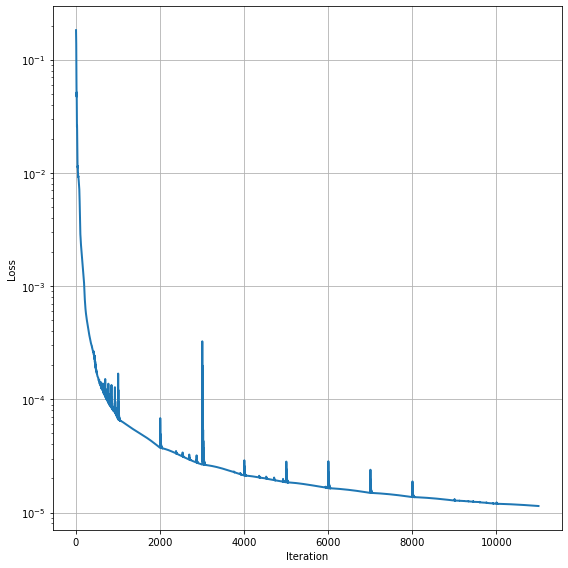

In [80]:
Adam   = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Adam   = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Adam   = tf.keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Adam   = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

Adam   = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)


nIter = 1000
losses = entrenar( dataset,  nIter, trainable_vars, losses )

plt.figure(figsize = (8,8))
plt.plot(losses, lw=2)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Analisis de precisión

In [77]:
def new_single_eval(arg):
    x,u,y = arg
    return model_test([x,u,y])[0]

def dom_eval(x,u,y):
    out = tf.vectorized_map(lambda t: new_single_eval((x,u,t)) , y)
    return out

## Analisis de precisión $u(x)=x \hspace{5mm} s(x)= \frac{x^2}{2}$

100
tf.Tensor([  1   1 100], shape=(3,), dtype=int32)
51


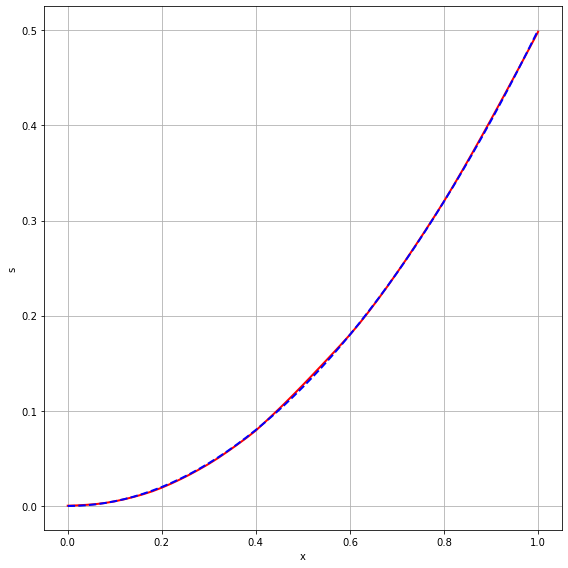

In [83]:
Nx = 100
u_x = onp.linspace(0,1,Nx)
print(onp.shape(u_x)[0])
u_tf_x = tf.constant(u_x,shape = [1,1,onp.shape(u_x)[0]])
print(tf.shape(u_tf_x))
y = onp.linspace(0,1,51)
len_y = onp.shape(y)[0]
print(len_y)
y_test = tf.constant(y, shape = [onp.shape(y)[0],1,1,1] )
s_analitic = 0.5*(y)**2

x_tf = tf.zeros(shape = [1,1])

test_eval = dom_eval(x_tf,u_tf_x,y_test).numpy()


plt.figure(figsize = (8,8))
plt.plot(y,test_eval,'r-',y,s_analitic,'b--',lw=2)
plt.grid()
plt.xlabel('x')
plt.ylabel('s')
#plt.yscale('log')
plt.tight_layout()
plt.show()

## Analisis de precisión $u(x) = cos(x) \hspace{5mm} s(x)= sin(x)$

100
tf.Tensor([  1   1 100], shape=(3,), dtype=int32)
51


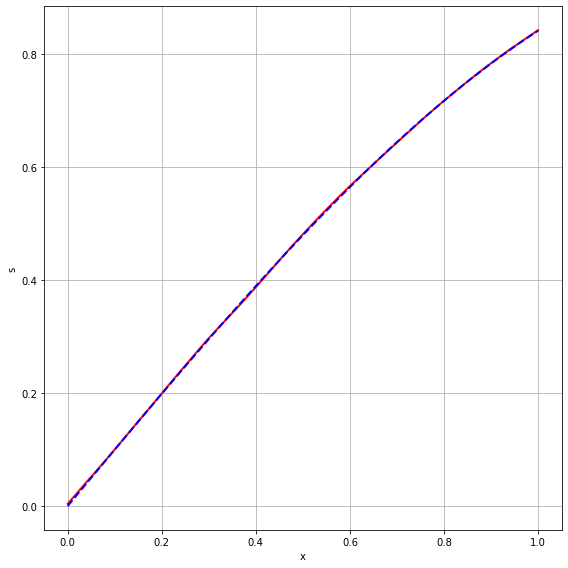

In [82]:
Nx = 100
u_x = onp.cos(onp.linspace(0,1,Nx)) 
print(onp.shape(u_x)[0])
u_tf_x = tf.constant(u_x,shape = [1,1,onp.shape(u_x)[0]])
print(tf.shape(u_tf_x))
y =  onp.linspace(0,1,51)
len_y = onp.shape(y)[0]
print(len_y)
y_test = tf.constant(y, shape = [onp.shape(y)[0],1,1,1] )
s_analitic = onp.sin(y)


test_eval = dom_eval(x_tf,u_tf_x,y_test).numpy()


plt.figure(figsize = (8,8))
plt.plot(y,test_eval,'r-',y,s_analitic,'b--',lw=2)
plt.grid()
plt.xlabel('x')
plt.ylabel('s')
#plt.yscale('log')
plt.tight_layout()
plt.show()